In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import keras
import random
import math
import scipy
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet
import skimage.io as io
import scipy.ndimage as nd
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
from skimage.filters import gaussian
from scipy.spatial.distance import pdist
import cv2
import pickle
from glob import glob
from tqdm import tqdm
import gc
import time

C:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
# !pip install opencv-python

In [3]:
# !pip install keras

In [4]:

target_shape = (200, 200)
batch_size = 32

num_classes =2
mode ='easy'
dataset_type='cifar-10'
augmentation_mode='_original_images'

!pip install image-classifiers==1.0.0b1
!pip install git+https://github.com/qubvel/classification_models.git

Defaulting to user installation because normal site-packages is not writeable
  Using cached image_classifiers-1.0.0b1-py3-none-any.whl
  Attempting uninstall: image-classifiers
    Found existing installation: image-classifiers 1.0.0
    Uninstalling image-classifiers-1.0.0:
      Successfully uninstalled image-classifiers-1.0.0
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/qubvel/classification_models.git to c:\users\htk\appdata\local\temp\pip-req-build-ygqh1s2j
  Resolved https://github.com/qubvel/classification_models.git to commit a0f006e05485a34ccf871c421279864b0ccd220b
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0-py3-none-any.whl size=20209 sha256=a6ea605e5a00b0d2afcfbb88f06f2d9602f0664c730ba95faf21b3eeee3cb5f3
  Stored in directory: C:\Users\HTK\AppData\Local\Temp\pip-ephem-wheel-cache-d7wkw

  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/classification_models.git 'C:\Users\HTK\AppData\Local\Temp\pip-req-build-ygqh1s2j'
  Running command git submodule update --init --recursive -q


In [5]:
training_paths = glob('Downloads/skincancer/train_set/*/*.jpg')
testing_paths = glob('Downloads/skincancer/test_set/*/*.jpg')
print(len(testing_paths))
print(len(training_paths))
print(testing_paths)



1100
9200
['Downloads/skincancer/test_set\\benign\\ISIC_0191734_640x360.jpg', 'Downloads/skincancer/test_set\\benign\\ISIC_0192893_640x478.jpg', 'Downloads/skincancer/test_set\\benign\\ISIC_0193785_640x427.jpg', 'Downloads/skincancer/test_set\\benign\\ISIC_0196403_640x425.jpg', 'Downloads/skincancer/test_set\\benign\\ISIC_0196694_640x360.jpg', 'Downloads/skincancer/test_set\\benign\\ISIC_0197873_640x427.jpg', 'Downloads/skincancer/test_set\\benign\\ISIC_0200153_640x427.jpg', 'Downloads/skincancer/test_set\\benign\\ISIC_0200174_640x427.jpg', 'Downloads/skincancer/test_set\\benign\\ISIC_0202120_640x427.jpg', 'Downloads/skincancer/test_set\\benign\\ISIC_0202808_640x427.jpg', 'Downloads/skincancer/test_set\\benign\\ISIC_0204355_640x427.jpg', 'Downloads/skincancer/test_set\\benign\\ISIC_0204580_640x478.jpg', 'Downloads/skincancer/test_set\\benign\\ISIC_0204819_640x428.jpg', 'Downloads/skincancer/test_set\\benign\\ISIC_0208378_640x360.jpg', 'Downloads/skincancer/test_set\\benign\\ISIC_021028

In [6]:
def get_label_from_path(path, pos=2):
  arr_split= path.split('\\')
  print(arr_split)
  return arr_split[len(arr_split)-pos]

def get_labels(paths_array):
    labels=[]
    for paths_and_labels in paths_array:
      tot_lab= get_label_from_path(paths_and_labels,pos = 2)
      print(tot_lab)
#       print(tot_lab.split('_')[0])
      labels.append(tot_lab.split('_')[0])
    return labels

training_labels= get_labels(training_paths)
print(training_labels)
testing_labels= get_labels(testing_paths)

pd.Series(training_labels).value_counts()

pd.Series(testing_labels).value_counts()

testing_labels

def read_preprocess_and_augment_image(filename):
    '''
      Accepts a file path and returns the image stored in the file path
    '''
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape,method='bilinear')
    ##image = alter_image(image)
    aug_image = generate_augmentation(image)
    return aug_image

def read_and_preprocess_image(filename):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape,method='bilinear')
    return image

def generate_augmentation(image):
    '''
     Inputs an image and returns its augmentation
    '''
    augmentations_mode=['Resized Crop','Random Brightness','Random_Contrast','Gaussian Blur']
    aug_mode_idx= random.randint(0,len(augmentations_mode))
    aug_image= image

    aug_image = tf.image.random_crop(image, size=[120,120,3])
    aug_image = tf.image.resize(aug_image, target_shape, method='bilinear')

    aug_image= tf.image.random_brightness(aug_image,0.3)
    aug_image= tf.image.random_contrast(aug_image, 0.3, 0.7)
    aug_image= tf.image.random_jpeg_quality(aug_image,min_jpeg_quality=10, max_jpeg_quality = 100)
    return aug_image
    '''
    print(aug_mode_idx)
    if(aug_mode_idx==0):
      aug_image = tf.image.random_crop(image, size=[120,120,3])
      aug_image = tf.image.resize(aug_image, target_shape, method='bilinear')

    elif(aug_mode_idx==1):
      aug_image= tf.image.random_brightness(image,0.5)

    elif(aug_mode_idx==2):
      aug_image= tf.image.random_contrast(image, 0.3, 0.7)

    elif(aug_mode_idx==3):
      aug_image= tf.image.random_jpeg_quality(image,min_jpeg_quality=6, max_jpeg_quality = 7)
    
    return aug_image
    '''

image_paths= training_paths

dataset_len= len(image_paths)

print(dataset_len)

image_count = dataset_len

dataset_a = tf.data.Dataset.from_tensor_slices(image_paths)
dataset_b = tf.data.Dataset.from_tensor_slices(image_paths)

dataset_a = dataset_a.map(read_preprocess_and_augment_image)
dataset_b = dataset_b.map(read_preprocess_and_augment_image)

dataset= tf.data.Dataset.zip((dataset_a,dataset_b))

##dataset= dataset.shuffle(10000)

train_dataset = dataset.take(round(image_count))
print(train_dataset)
val_dataset = dataset.skip(round(image_count * 0.9))

train_dataset = train_dataset.batch(batch_size, drop_remainder=True)
train_dataset = train_dataset.prefetch(batch_size)

val_dataset = val_dataset.batch(batch_size, drop_remainder=True)
val_dataset = val_dataset.prefetch(batch_size)


['Downloads/skincancer/train_set', 'benign', 'ISIC_1821821_640x480.jpg']
benign
['Downloads/skincancer/train_set', 'benign', 'ISIC_1825481_640x360.jpg']
benign
['Downloads/skincancer/train_set', 'benign', 'ISIC_1826094_640x480.jpg']
benign
['Downloads/skincancer/train_set', 'benign', 'ISIC_1832586_640x480.jpg']
benign
['Downloads/skincancer/train_set', 'benign', 'ISIC_1834367_640x480.jpg']
benign
['Downloads/skincancer/train_set', 'benign', 'ISIC_1835426_640x480.jpg']
benign
['Downloads/skincancer/train_set', 'benign', 'ISIC_1836410_640x427.jpg']
benign
['Downloads/skincancer/train_set', 'benign', 'ISIC_1836914_640x480.jpg']
benign
['Downloads/skincancer/train_set', 'benign', 'ISIC_1838216_640x427.jpg']
benign
['Downloads/skincancer/train_set', 'benign', 'ISIC_1841825_640x427.jpg']
benign
['Downloads/skincancer/train_set', 'benign', 'ISIC_1842239_640x480.jpg']
benign
['Downloads/skincancer/train_set', 'benign', 'ISIC_1843053_640x360.jpg']
benign
['Downloads/skincancer/train_set', 'beni

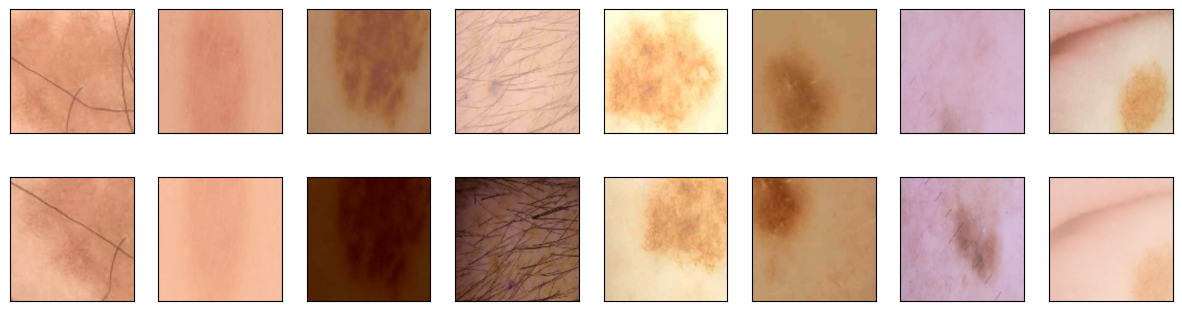

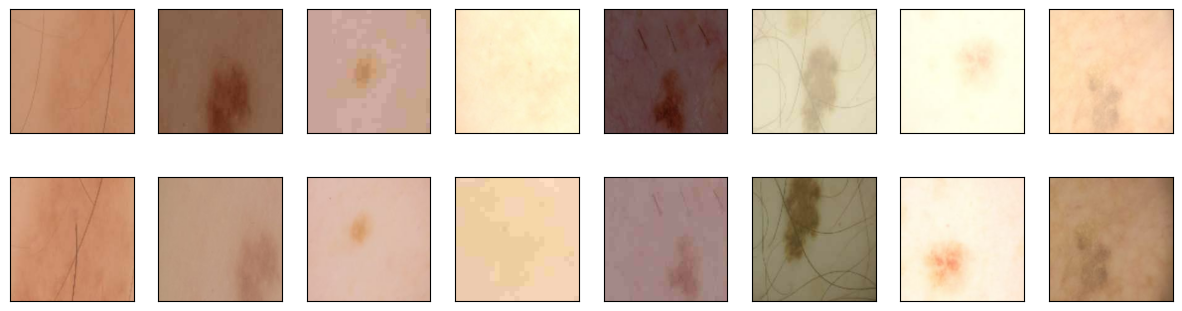

In [7]:
"""## Visualising the Dataset"""

def visualize_dataset(anchor, positive):
    """Visualize samples of dataset """

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(15, 4))

    axs = fig.subplots(2, 8)
    for i in range(8):
        cv2.imwrite(f'aug_1_{i}.jpg', anchor[i]*255.0)
        cv2.imwrite(f'aug_2_{i}.jpg', positive[i]*255.0)
        show(axs[0, i], anchor[i])
        show(axs[1, i], positive[i])

data_for_visualization= list(train_dataset.take(10).as_numpy_iterator())

visualize_dataset(*data_for_visualization[0])

ctr=0
for path in image_paths[:batch_size]:
  img= cv2.imread(path)
  cv2.imwrite(f'original_image_{ctr}.jpg',img)
  ctr+=1

visualize_dataset(*data_for_visualization[1])

In [8]:
"""## Initializing the Instance Level Contrastive Head"""

embedding_layer_output_dimension = 128

from classification_models.tfkeras import Classifiers

ResNet18, preprocess_input = Classifiers.get('resnet18')
base_cnn = ResNet18(target_shape+(3,), weights=None, include_top=False)

'''
Base CNN and the EMBEDDING LAYER
'''
base_cnn = resnet.ResNet50(
    weights='imagenet', input_shape=target_shape + (3,), include_top=False
)

base_cnn.summary()

for layer in base_cnn.layers:
    layer.trainable = True
    
last_layer1 = base_cnn.get_layer('conv5_block3_3_bn')
last_output1 = last_layer1.output
x1 = tf.keras.layers.Flatten()(last_output1)
x1 = tf.keras.layers.Dropout(0.4)(x1)
x1 = tf.keras.layers.Dense(1024, activation='relu')(x1)

last_layer3  =  base_cnn.get_layer('conv5_block3_out')#get the layer 
last_output3 =  last_layer3.output                       #get the layer output
x3 =  tf.keras.layers.Flatten()(last_output3)
x3 =  tf.keras.layers.Dropout(0.4)(x3)
x3 =  tf.keras.layers.Dense(1024, activation='relu')(x3)  

from keras.layers import concatenate
y = concatenate([x1, x3])
y = tf.keras.layers.BatchNormalization()(y)
y = tf.keras.layers.Flatten()(y)
y = tf.keras.layers.Dropout(0.4)(y)

x2 = tf.keras.layers.Dense(2, activation='softmax')(y)
supervised_nn = Model(base_cnn.input, x2, name="Embedding")

base_cnn.summary()





Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 206, 206, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 100, 100, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 100, 100, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                     

In [9]:
# print('Training Labels')
# print(training_labels)
y_values= pd.get_dummies(pd.DataFrame(training_labels))
# print('y_values')
# print(y_values)

y_values= y_values.values
# print(y_values)

from tensorflow.keras.optimizers import SGD
supervised_nn.compile(loss='categorical_crossentropy',
            optimizer=SGD(learning_rate=0.0001, momentum=0.95, nesterov=True,clipnorm=1.0),
            metrics=['accuracy'])

supervised_train_x = tf.data.Dataset.from_tensor_slices(image_paths)
# print('image_paths')
# print(image_paths)
supervised_train_x= supervised_train_x.map(read_and_preprocess_image)
supervised_train_y = tf.data.Dataset.from_tensor_slices(y_values)
# print(supervised_train_x)
# print(supervised_train_y)
supervised_dataset= tf.data.Dataset.zip((supervised_train_x, supervised_train_y))
supervised_dataset = supervised_dataset.batch(batch_size, drop_remainder= True)





supervised_train_x= []
for path in training_paths:
#     print(path)
    img = cv2.imread(path)
 
    
    img = cv2.resize(img, (200, 200))

    
    supervised_train_x.append(img)
supervised_train_x= np.array(supervised_train_x, dtype='float32')


gc.collect()

print(supervised_train_x.shape)

# print(y_values)

# from tensorflow.keras.utils import to_categorical

# y_values = to_categorical(y_values, num_classes=2)

# print(y_values)

supervised_nn.fit(supervised_train_x,y_values,batch_size=16, epochs=10)

(9200, 200, 200, 3)
Epoch 1/10


575/575 [==============================] - 1109s 2s/step - loss: 0.6524 - accuracy: 0.7484
Epoch 2/10
575/575 [==============================] - 1054s 2s/step - loss: 0.4279 - accuracy: 0.8600
Epoch 3/10
575/575 [==============================] - 1033s 2s/step - loss: 0.3607 - accuracy: 0.8816
Epoch 4/10
575/575 [==============================] - 1033s 2s/step - loss: 0.3221 - accuracy: 0.9022
Epoch 5/10
575/575 [==============================] - 1031s 2s/step - loss: 0.2974 - accuracy: 0.9051
Epoch 6/10
575/575 [==============================] - 1030s 2s/step - loss: 0.2753 - accuracy: 0.9132
Epoch 7/10
575/575 [==============================] - 1047s 2s/step - loss: 0.2588 - accuracy: 0.9142
Epoch 8/10
575/575 [==============================] - 1055s 2s/step - loss: 0.2461 - accuracy: 0.9218
Epoch 9/10
575/575 [==============================] - 1053s 2s/step - loss: 0.2228 - accuracy: 0.9255
Epoch 10/10
575/575 [==============================] - 1052s

In [10]:
for layer in base_cnn.layers:
  layer.trainable= True

last_layer1 = base_cnn.get_layer('conv5_block3_3_bn')
last_output1 = last_layer1.output
x1 = tf.keras.layers.Flatten()(last_output1)
##x1 = tf.keras.layers.Dropout(0.4)(x1)
x1 = tf.keras.layers.Dense(1024, activation='relu')(x1)

last_layer3 = base_cnn.get_layer('conv5_block3_out') #get the layer
last_output3 = last_layer3.output                       #get the layer output
x3 = tf.keras.layers.Flatten()(last_output3)
##x3= tf.keras.layers.Dropout(0.4)(x3)
x3 = tf.keras.layers.Dense(1024, activation='relu')(x3)  

from keras.layers import concatenate
y = concatenate([x1, x3])
y = tf.keras.layers.BatchNormalization()(y)
y = tf.keras.layers.Flatten()(y)
##y= tf.keras.layers.Dropout(0.5)(y)

x2 = tf.keras.layers.Dense(128, activation='relu')(y)
embedding_layer = Model(base_cnn.input, x2, name="Embedding")

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.Dense(512, activation="relu")(dense1)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
dense3 = layers.Dense(256, activation='relu')(dense2)
dense3 = layers.Dropout(0.4)(dense3)
output = layers.Dense(embedding_layer_output_dimension)(dense3)

embedding_layer = Model(base_cnn.input, output, name="Embedding")

In [11]:
"""## The Contrastive Clustering Model"""

class Contrastive_loss:
  
    def __init__(self, temperature):
      self.temperature=temperature
    
    '''

    def compute_loss(self,xi, xj,  tau=0.5, normalize=True):

        x = tf.keras.backend.concatenate((xi, xj), axis=0)

        sim_mat = tf.keras.backend.dot(x, tf.keras.backend.transpose(x))

        if normalize:
            sim_mat_denom = tf.keras.backend.dot(tf.keras.backend.l2_normalize(x, axis=1).unsqueeze(1), tf.keras.backend.l2_normalize(x, axis=1).unsqueeze(1).T)
            sim_mat = sim_mat / sim_mat_denom.clamp(min=1e-8)

        sim_mat = tf.keras.backend.exp(sim_mat /tau)

        if normalize:
            sim_mat_denom = tf.keras.backend.l2_normalize(xi, dim=1) * tf.keras.backend.l2_normalize(xj, axis=1)
            sim_match = tf.keras.backend.exp(tf.keras.backend.sum(xi * xj, axis=-1) / sim_mat_denom / tau)
        else:
            sim_match = tf.keras.backend.exp(tf.keras.backend.sum(xi * xj, axis=-1) / tau)

        sim_match = tf.keras.backend.concatenate((sim_match, sim_match), axis=0)

        norm_sum = tf.keras.backend.exp(tf.keras.backend.ones(tf.keras.backend.shape(x)[0]) / tau)

        return tf.math.reduce_mean(-tf.keras.backend.log(sim_match / (tf.keras.backend.sum(sim_mat, axis=-1) - norm_sum)), name='contrastive_loss')
      '''
    '''


    def compute_loss(self,zi, zj, tau=0.5):
         Calculates the contrastive loss of the input data using NT_Xent. The
        equation can be found in the paper: https://arxiv.org/pdf/2002.05709.pdf
        (This is the Tensorflow implementation of the standard numpy version found
        in the NT_Xent function).
        
        Args:
            zi: One half of the input data, shape = (batch_size, feature_1, feature_2, ..., feature_N)
            zj: Other half of the input data, must have the same shape as zi
            tau: Temperature parameter (a constant), default = 1.

        Returns:
            loss: The complete NT_Xent constrastive loss
        
        z = tf.keras.backend.concatenate((zi, zj), axis=0)
        loss = 0
        for k in range(zi.shape[0]):
            # Numerator (compare i,j & j,i)
            i = k
            j = k + zi.shape[0]
            # Instantiate the cosine similarity loss function
            cosine_sim = tf.keras.losses.CosineSimilarity(axis=-1, reduction=tf.keras.losses.Reduction.NONE)
            sim = tf.squeeze(- cosine_sim(tf.reshape(z[i], (1, -1)), tf.reshape(z[j], (1, -1))))
            numerator = tf.math.exp(sim / tau)

            # Denominator (compare i & j to all samples apart from themselves)
            sim_ik = - cosine_sim(tf.reshape(z[i], (1, -1)), z[tf.range(z.shape[0]) != i])
            sim_jk = - cosine_sim(tf.reshape(z[j], (1, -1)), z[tf.range(z.shape[0]) != j])
            denominator_ik = tf.reduce_sum(tf.math.exp(sim_ik / tau))
            denominator_jk = tf.reduce_sum(tf.math.exp(sim_jk / tau))

            # Calculate individual and combined losses
            loss_ij = - tf.math.log(numerator / denominator_ik)
            loss_ji = - tf.math.log(numerator / denominator_jk)
            loss += loss_ij + loss_ji
        
        # Divide by the total number of samples
        loss /= z.shape[0]

        return loss
      '''
    '''
    def compute_loss(self, embeddings_a, embeddings_b, temperature= 0.5):
      
      sum_loss=tf.Variable(0.0)
      for i in range(batch_size):
        z_i_a= embeddings_a[i]
        z_i_b= embeddings_b[i]

        numr = tf.math.exp(tf.losses.cosine_similarity(z_i_a,z_i_b)/temperature)

        denomr_a= self.compute_denom_loss(z_i_a, embeddings_a, embeddings_b,temperature)
        
        denomr_b = self.compute_denom_loss(z_i_b, embeddings_b, embeddings_a, temperature)

        ins_loss_a= -1* tf.math.log(numr/denomr_a)
        ins_loss_b = -1* tf.math.log(numr/denomr_b)
        sum_loss= sum_loss+ ins_loss_a+ins_loss_b
      return sum_loss/(2*batch_size)

    def compute_denom_loss(self,vec, embeddings_a, embeddings_b, temperature, to_transpose=False):

      if(to_transpose):
        embeddings_a= tf.transpose(embeddings_a)
        embeddings_b= tf.transpose(embeddings_b)

      first_part= tf.math.exp(tf.losses.cosine_similarity(vec,embeddings_a)/temperature)
      second_part= tf.math.exp(tf.losses.cosine_similarity(vec, embeddings_b)/temperature)

      sum_parts = tf.reduce_sum(first_part+second_part)

      return sum_parts
    '''
    
    def compute_loss(self, hidden1, hidden2, temperature= 0.5):
      weights=1.0
      LARGE_NUM=1e9
      hidden1_large = hidden1
      hidden2_large = hidden2
      labels = tf.one_hot(tf.range(batch_size), batch_size * 2)
      masks = tf.one_hot(tf.range(batch_size), batch_size) 

      logits_aa = tf.matmul(hidden1, hidden1_large, transpose_b=True) / temperature
      logits_aa = logits_aa - masks * LARGE_NUM
      logits_bb = tf.matmul(hidden2, hidden2_large, transpose_b=True) / temperature
      logits_bb = logits_bb - masks * LARGE_NUM
      logits_ab = tf.matmul(hidden1, hidden2_large, transpose_b=True) / temperature
      logits_ba = tf.matmul(hidden2, hidden1_large, transpose_b=True) / temperature

      ##loss_a = tf.losses.softmax_cross_entropy(
          ##labels, tf.concat([logits_ab, logits_aa], 1), weights=weights)
      ##loss_b = tf.losses.softmax_cross_entropy(
          ##labels, tf.concat([logits_ba, logits_bb], 1), weights=weights)
      ##loss = loss_a + loss_b

      loss_a = tf.nn.softmax_cross_entropy_with_logits(
          labels, tf.concat([logits_ab, logits_aa], 1))
      loss_b = tf.nn.softmax_cross_entropy_with_logits(
          labels, tf.concat([logits_ba, logits_bb], 1))
      
      loss = tf.reduce_mean(loss_a + loss_b)

      return loss

class Contrastive_Clustering_Model:

    def __init__(self,base_network, len_mask=5000):
      self.base_network= base_network
      self.MOD= 1e30 + 7.0
      self.Contrastive_loss= Contrastive_loss(temperature=0.5)
      self.loss_tracker = metrics.Mean(name="loss")

    def fit(self, dataset,epochs=5):
      loss_logs= open("loss_logs.txt",'w')
      loss_logs.write(" starting ")
      loss_logs.close()

      for epoch in range(epochs):

        print("Running epoch -->   "+ str(epoch+1))
             
        sum_loss=[]
        for idx, mini_batch in tqdm(enumerate(dataset)):
          loss= self.__train_step(mini_batch, idx+1, epoch+1,int(dataset_len*0.45/32.0))
          ##print(loss['loss'])
          sum_loss.append(loss['loss'])
          loss_logs= open("loss_logs.txt",'a')
          loss_logs.write("  ||  "+str(loss['loss'].numpy())+"   ||  ")
          loss_logs.write("\n")
          loss_logs.close()

    def compile(self, optimizer=optimizers.Adam(0.0003,epsilon=0.1)):
      self.optimizer= optimizer
    
    def __train_step(self,data, iteration,epoch, max_iterations):

      w_contrastive=2.0
      if(epoch==1 or iteration < (max_iterations/2)):
        w_clustering=0.0
      else:
        w_clustering=10.0

      with tf.GradientTape() as tape:
        type_1_embeddings_contrastive= self.call_contrastive(data[0])
        type_2_embeddings_contrastive= self.call_contrastive(data[1])

        contrastive_loss= self.Contrastive_loss.compute_loss(type_1_embeddings_contrastive, type_2_embeddings_contrastive)

        loss = w_contrastive* contrastive_loss

      print('\n')
      print("loss -->  "+ str(loss))
      
      gradients= tape.gradient(loss, self.base_network.trainable_weights)
      
      self.optimizer.apply_gradients(
          zip(gradients, self.base_network.trainable_weights)
      )
  
      self.loss_tracker.update_state(loss)
      return {"loss": self.loss_tracker.result()}
    
    def increasing_alpha(self, alpha):
      return alpha

    def decreasing_alpha(self, alpha):
      return alpha

    def call(self,data):
      return self.base_network(data)

    def call_contrastive(self, data):
      base_cnn_output= self.call(data)
      return base_cnn_output

    def get_distances_mat_vec(self,mat,vec):
      dist_mat= tf.square(mat-vec)
      sum_squared_dist= tf.math.reduce_sum(dist_mat, axis=1)
      distances = tf.math.sqrt(sum_squared_dist)
      sum_distances = tf.cast(tf.math.reduce_sum(distances), dtype = tf.double)
      return sum_distances

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define a Sequential model
model = models.Sequential()

# Convolutional and Pooling Layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output for the Dense layers
model.add(layers.Flatten())

# Dense (Fully Connected) Layers
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 99, 99, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 23, 23, 128)       0

In [13]:
contrastiveClusteringModel =  Contrastive_Clustering_Model(base_network=model)
##contrastive_model_2.compile(optimizer=optimizers.Adam(0.000001, epsilon=0.1))
##contrastive_model_2.fit(train_dataset, epochs=2)

gc.collect()

contrastiveClusteringModel.compile()
contrastiveClusteringModel.fit(dataset=train_dataset, epochs=30)

# embedding_layer2.save('/content/drive/MyDrive/embedding_layer2.h5')

# embedding_layer.save_weights('embedding_layer_weights2')

Running epoch -->   1


0it [00:00, ?it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


1it [00:01,  1.34s/it]



loss -->  tf.Tensor(16.572529, shape=(), dtype=float32)


2it [00:02,  1.02s/it]



loss -->  tf.Tensor(16.572533, shape=(), dtype=float32)


3it [00:02,  1.08it/s]



loss -->  tf.Tensor(16.57253, shape=(), dtype=float32)


4it [00:03,  1.14it/s]



loss -->  tf.Tensor(16.572527, shape=(), dtype=float32)


5it [00:04,  1.17it/s]



loss -->  tf.Tensor(16.572536, shape=(), dtype=float32)


6it [00:05,  1.20it/s]



loss -->  tf.Tensor(16.572523, shape=(), dtype=float32)


7it [00:06,  1.20it/s]



loss -->  tf.Tensor(16.572536, shape=(), dtype=float32)


8it [00:07,  1.21it/s]



loss -->  tf.Tensor(16.572536, shape=(), dtype=float32)


9it [00:07,  1.22it/s]



loss -->  tf.Tensor(16.572521, shape=(), dtype=float32)


10it [00:08,  1.23it/s]



loss -->  tf.Tensor(16.572529, shape=(), dtype=float32)


11it [00:09,  1.23it/s]



loss -->  tf.Tensor(16.57253, shape=(), dtype=float32)


12it [00:10,  1.23it/s]



loss -->  tf.Tensor(16.572533, shape=(), dtype=float32)


13it [00:11,  1.23it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


14it [00:11,  1.23it/s]



loss -->  tf.Tensor(16.572533, shape=(), dtype=float32)


15it [00:12,  1.23it/s]



loss -->  tf.Tensor(16.57253, shape=(), dtype=float32)


16it [00:13,  1.23it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


17it [00:14,  1.23it/s]



loss -->  tf.Tensor(16.572536, shape=(), dtype=float32)


18it [00:15,  1.23it/s]



loss -->  tf.Tensor(16.57253, shape=(), dtype=float32)


19it [00:15,  1.23it/s]



loss -->  tf.Tensor(16.572527, shape=(), dtype=float32)


20it [00:16,  1.23it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


21it [00:17,  1.23it/s]



loss -->  tf.Tensor(16.572533, shape=(), dtype=float32)


22it [00:18,  1.21it/s]



loss -->  tf.Tensor(16.572533, shape=(), dtype=float32)


23it [00:19,  1.18it/s]



loss -->  tf.Tensor(16.572525, shape=(), dtype=float32)


24it [00:20,  1.17it/s]



loss -->  tf.Tensor(16.572535, shape=(), dtype=float32)


25it [00:21,  1.16it/s]



loss -->  tf.Tensor(16.572542, shape=(), dtype=float32)


26it [00:21,  1.16it/s]



loss -->  tf.Tensor(16.572533, shape=(), dtype=float32)


27it [00:22,  1.15it/s]



loss -->  tf.Tensor(16.572535, shape=(), dtype=float32)


28it [00:23,  1.15it/s]



loss -->  tf.Tensor(16.572529, shape=(), dtype=float32)


29it [00:24,  1.15it/s]



loss -->  tf.Tensor(16.572525, shape=(), dtype=float32)


30it [00:25,  1.15it/s]



loss -->  tf.Tensor(16.572527, shape=(), dtype=float32)


31it [00:26,  1.15it/s]



loss -->  tf.Tensor(16.572535, shape=(), dtype=float32)


32it [00:27,  1.15it/s]



loss -->  tf.Tensor(16.57253, shape=(), dtype=float32)


33it [00:27,  1.17it/s]



loss -->  tf.Tensor(16.572533, shape=(), dtype=float32)


34it [00:28,  1.19it/s]



loss -->  tf.Tensor(16.572521, shape=(), dtype=float32)


35it [00:29,  1.21it/s]



loss -->  tf.Tensor(16.572544, shape=(), dtype=float32)


36it [00:30,  1.21it/s]



loss -->  tf.Tensor(16.572529, shape=(), dtype=float32)


37it [00:31,  1.22it/s]



loss -->  tf.Tensor(16.572529, shape=(), dtype=float32)


38it [00:32,  1.22it/s]



loss -->  tf.Tensor(16.572529, shape=(), dtype=float32)


39it [00:32,  1.22it/s]



loss -->  tf.Tensor(16.572529, shape=(), dtype=float32)


40it [00:33,  1.23it/s]



loss -->  tf.Tensor(16.572535, shape=(), dtype=float32)


41it [00:34,  1.23it/s]



loss -->  tf.Tensor(16.572536, shape=(), dtype=float32)


42it [00:35,  1.22it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


43it [00:36,  1.23it/s]



loss -->  tf.Tensor(16.572536, shape=(), dtype=float32)


44it [00:36,  1.23it/s]



loss -->  tf.Tensor(16.572533, shape=(), dtype=float32)


45it [00:37,  1.23it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


46it [00:38,  1.23it/s]



loss -->  tf.Tensor(16.572529, shape=(), dtype=float32)


47it [00:39,  1.23it/s]



loss -->  tf.Tensor(16.572533, shape=(), dtype=float32)


48it [00:40,  1.23it/s]



loss -->  tf.Tensor(16.572525, shape=(), dtype=float32)


49it [00:40,  1.23it/s]



loss -->  tf.Tensor(16.57253, shape=(), dtype=float32)


50it [00:41,  1.23it/s]



loss -->  tf.Tensor(16.572527, shape=(), dtype=float32)


51it [00:42,  1.23it/s]



loss -->  tf.Tensor(16.572533, shape=(), dtype=float32)


52it [00:43,  1.23it/s]



loss -->  tf.Tensor(16.572535, shape=(), dtype=float32)


53it [00:44,  1.23it/s]



loss -->  tf.Tensor(16.572536, shape=(), dtype=float32)


54it [00:45,  1.23it/s]



loss -->  tf.Tensor(16.572529, shape=(), dtype=float32)


55it [00:45,  1.23it/s]



loss -->  tf.Tensor(16.57253, shape=(), dtype=float32)


56it [00:46,  1.23it/s]



loss -->  tf.Tensor(16.572533, shape=(), dtype=float32)


57it [00:47,  1.23it/s]



loss -->  tf.Tensor(16.572529, shape=(), dtype=float32)


58it [00:48,  1.22it/s]



loss -->  tf.Tensor(16.572527, shape=(), dtype=float32)


59it [00:49,  1.23it/s]



loss -->  tf.Tensor(16.572525, shape=(), dtype=float32)


60it [00:49,  1.23it/s]



loss -->  tf.Tensor(16.572523, shape=(), dtype=float32)


61it [00:50,  1.23it/s]



loss -->  tf.Tensor(16.572535, shape=(), dtype=float32)


62it [00:51,  1.23it/s]



loss -->  tf.Tensor(16.57253, shape=(), dtype=float32)


63it [00:52,  1.23it/s]



loss -->  tf.Tensor(16.572523, shape=(), dtype=float32)


64it [00:53,  1.23it/s]



loss -->  tf.Tensor(16.572529, shape=(), dtype=float32)


65it [00:53,  1.23it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


66it [00:54,  1.23it/s]



loss -->  tf.Tensor(16.572533, shape=(), dtype=float32)


67it [00:55,  1.23it/s]



loss -->  tf.Tensor(16.572527, shape=(), dtype=float32)


68it [00:56,  1.23it/s]



loss -->  tf.Tensor(16.572529, shape=(), dtype=float32)


69it [00:57,  1.23it/s]



loss -->  tf.Tensor(16.572523, shape=(), dtype=float32)


70it [00:58,  1.23it/s]



loss -->  tf.Tensor(16.572525, shape=(), dtype=float32)


71it [00:58,  1.23it/s]



loss -->  tf.Tensor(16.572533, shape=(), dtype=float32)


72it [00:59,  1.24it/s]



loss -->  tf.Tensor(16.572529, shape=(), dtype=float32)


73it [01:00,  1.23it/s]



loss -->  tf.Tensor(16.572529, shape=(), dtype=float32)


74it [01:01,  1.23it/s]



loss -->  tf.Tensor(16.572544, shape=(), dtype=float32)


75it [01:02,  1.23it/s]



loss -->  tf.Tensor(16.572533, shape=(), dtype=float32)


76it [01:02,  1.23it/s]



loss -->  tf.Tensor(16.57253, shape=(), dtype=float32)


77it [01:03,  1.23it/s]



loss -->  tf.Tensor(16.572525, shape=(), dtype=float32)


78it [01:04,  1.23it/s]



loss -->  tf.Tensor(16.57253, shape=(), dtype=float32)


79it [01:05,  1.23it/s]



loss -->  tf.Tensor(16.57253, shape=(), dtype=float32)


80it [01:06,  1.22it/s]



loss -->  tf.Tensor(16.572525, shape=(), dtype=float32)


81it [01:07,  1.22it/s]



loss -->  tf.Tensor(16.572529, shape=(), dtype=float32)


82it [01:07,  1.23it/s]



loss -->  tf.Tensor(16.572529, shape=(), dtype=float32)


83it [01:08,  1.23it/s]



loss -->  tf.Tensor(16.572525, shape=(), dtype=float32)


84it [01:09,  1.23it/s]



loss -->  tf.Tensor(16.572533, shape=(), dtype=float32)


85it [01:10,  1.23it/s]



loss -->  tf.Tensor(16.57253, shape=(), dtype=float32)


86it [01:11,  1.23it/s]



loss -->  tf.Tensor(16.57253, shape=(), dtype=float32)


87it [01:11,  1.22it/s]



loss -->  tf.Tensor(16.57253, shape=(), dtype=float32)


88it [01:12,  1.22it/s]



loss -->  tf.Tensor(16.572529, shape=(), dtype=float32)


89it [01:13,  1.22it/s]



loss -->  tf.Tensor(16.572538, shape=(), dtype=float32)


90it [01:14,  1.23it/s]



loss -->  tf.Tensor(16.57253, shape=(), dtype=float32)


91it [01:15,  1.23it/s]



loss -->  tf.Tensor(16.572527, shape=(), dtype=float32)


92it [01:15,  1.23it/s]



loss -->  tf.Tensor(16.572527, shape=(), dtype=float32)


93it [01:16,  1.23it/s]



loss -->  tf.Tensor(16.572533, shape=(), dtype=float32)


94it [01:17,  1.24it/s]



loss -->  tf.Tensor(16.572523, shape=(), dtype=float32)


95it [01:18,  1.24it/s]



loss -->  tf.Tensor(16.572533, shape=(), dtype=float32)


96it [01:19,  1.24it/s]



loss -->  tf.Tensor(16.572527, shape=(), dtype=float32)


97it [01:19,  1.23it/s]



loss -->  tf.Tensor(16.572525, shape=(), dtype=float32)


98it [01:20,  1.23it/s]



loss -->  tf.Tensor(16.572525, shape=(), dtype=float32)


99it [01:21,  1.23it/s]



loss -->  tf.Tensor(16.572521, shape=(), dtype=float32)


100it [01:22,  1.23it/s]



loss -->  tf.Tensor(16.572525, shape=(), dtype=float32)


101it [01:23,  1.24it/s]



loss -->  tf.Tensor(16.572536, shape=(), dtype=float32)


102it [01:24,  1.23it/s]



loss -->  tf.Tensor(16.572517, shape=(), dtype=float32)


103it [01:24,  1.22it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


104it [01:25,  1.22it/s]



loss -->  tf.Tensor(16.572536, shape=(), dtype=float32)


105it [01:26,  1.22it/s]



loss -->  tf.Tensor(16.572523, shape=(), dtype=float32)


106it [01:27,  1.22it/s]



loss -->  tf.Tensor(16.572527, shape=(), dtype=float32)


107it [01:28,  1.23it/s]



loss -->  tf.Tensor(16.572523, shape=(), dtype=float32)


108it [01:28,  1.23it/s]



loss -->  tf.Tensor(16.572521, shape=(), dtype=float32)


109it [01:29,  1.23it/s]



loss -->  tf.Tensor(16.572525, shape=(), dtype=float32)


110it [01:30,  1.22it/s]



loss -->  tf.Tensor(16.572529, shape=(), dtype=float32)


111it [01:31,  1.22it/s]



loss -->  tf.Tensor(16.572514, shape=(), dtype=float32)


112it [01:32,  1.22it/s]



loss -->  tf.Tensor(16.572533, shape=(), dtype=float32)


113it [01:33,  1.22it/s]



loss -->  tf.Tensor(16.57253, shape=(), dtype=float32)


114it [01:33,  1.23it/s]



loss -->  tf.Tensor(16.572525, shape=(), dtype=float32)


115it [01:34,  1.23it/s]



loss -->  tf.Tensor(16.572521, shape=(), dtype=float32)


116it [01:35,  1.22it/s]



loss -->  tf.Tensor(16.572529, shape=(), dtype=float32)


117it [01:36,  1.23it/s]



loss -->  tf.Tensor(16.572529, shape=(), dtype=float32)


118it [01:37,  1.23it/s]



loss -->  tf.Tensor(16.572529, shape=(), dtype=float32)


119it [01:37,  1.23it/s]



loss -->  tf.Tensor(16.572536, shape=(), dtype=float32)


120it [01:38,  1.24it/s]



loss -->  tf.Tensor(16.572536, shape=(), dtype=float32)


121it [01:39,  1.24it/s]



loss -->  tf.Tensor(16.572521, shape=(), dtype=float32)


122it [01:40,  1.24it/s]



loss -->  tf.Tensor(16.572521, shape=(), dtype=float32)


123it [01:41,  1.24it/s]



loss -->  tf.Tensor(16.572533, shape=(), dtype=float32)


124it [01:41,  1.25it/s]



loss -->  tf.Tensor(16.572525, shape=(), dtype=float32)


125it [01:42,  1.24it/s]



loss -->  tf.Tensor(16.57253, shape=(), dtype=float32)


126it [01:43,  1.24it/s]



loss -->  tf.Tensor(16.572529, shape=(), dtype=float32)


127it [01:44,  1.23it/s]



loss -->  tf.Tensor(16.572527, shape=(), dtype=float32)


128it [01:45,  1.24it/s]



loss -->  tf.Tensor(16.572521, shape=(), dtype=float32)


129it [01:45,  1.24it/s]



loss -->  tf.Tensor(16.572536, shape=(), dtype=float32)


130it [01:46,  1.24it/s]



loss -->  tf.Tensor(16.572533, shape=(), dtype=float32)


131it [01:47,  1.24it/s]



loss -->  tf.Tensor(16.572525, shape=(), dtype=float32)


132it [01:48,  1.24it/s]



loss -->  tf.Tensor(16.572535, shape=(), dtype=float32)


133it [01:49,  1.24it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


134it [01:50,  1.24it/s]



loss -->  tf.Tensor(16.572521, shape=(), dtype=float32)


135it [01:50,  1.24it/s]



loss -->  tf.Tensor(16.572521, shape=(), dtype=float32)


136it [01:51,  1.24it/s]



loss -->  tf.Tensor(16.572529, shape=(), dtype=float32)


137it [01:52,  1.24it/s]



loss -->  tf.Tensor(16.572527, shape=(), dtype=float32)


138it [01:53,  1.24it/s]



loss -->  tf.Tensor(16.572533, shape=(), dtype=float32)


139it [01:54,  1.23it/s]



loss -->  tf.Tensor(16.572529, shape=(), dtype=float32)


140it [01:54,  1.23it/s]



loss -->  tf.Tensor(16.572523, shape=(), dtype=float32)


141it [01:55,  1.23it/s]



loss -->  tf.Tensor(16.572536, shape=(), dtype=float32)


142it [01:56,  1.23it/s]



loss -->  tf.Tensor(16.572533, shape=(), dtype=float32)


143it [01:57,  1.23it/s]



loss -->  tf.Tensor(16.57253, shape=(), dtype=float32)


144it [01:58,  1.23it/s]



loss -->  tf.Tensor(16.572515, shape=(), dtype=float32)


145it [01:58,  1.23it/s]



loss -->  tf.Tensor(16.57253, shape=(), dtype=float32)


146it [01:59,  1.23it/s]



loss -->  tf.Tensor(16.572529, shape=(), dtype=float32)


147it [02:00,  1.23it/s]



loss -->  tf.Tensor(16.572521, shape=(), dtype=float32)


148it [02:01,  1.23it/s]



loss -->  tf.Tensor(16.572529, shape=(), dtype=float32)


149it [02:02,  1.24it/s]



loss -->  tf.Tensor(16.572521, shape=(), dtype=float32)


150it [02:02,  1.24it/s]



loss -->  tf.Tensor(16.57252, shape=(), dtype=float32)


151it [02:03,  1.24it/s]



loss -->  tf.Tensor(16.572529, shape=(), dtype=float32)


152it [02:04,  1.24it/s]



loss -->  tf.Tensor(16.572535, shape=(), dtype=float32)


153it [02:05,  1.24it/s]



loss -->  tf.Tensor(16.572525, shape=(), dtype=float32)


154it [02:06,  1.24it/s]



loss -->  tf.Tensor(16.572521, shape=(), dtype=float32)


155it [02:06,  1.24it/s]



loss -->  tf.Tensor(16.57252, shape=(), dtype=float32)


156it [02:07,  1.24it/s]



loss -->  tf.Tensor(16.572529, shape=(), dtype=float32)


157it [02:08,  1.25it/s]



loss -->  tf.Tensor(16.57252, shape=(), dtype=float32)


158it [02:09,  1.25it/s]



loss -->  tf.Tensor(16.572533, shape=(), dtype=float32)


159it [02:10,  1.25it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


160it [02:10,  1.25it/s]



loss -->  tf.Tensor(16.57251, shape=(), dtype=float32)


161it [02:11,  1.25it/s]



loss -->  tf.Tensor(16.572533, shape=(), dtype=float32)


162it [02:12,  1.26it/s]



loss -->  tf.Tensor(16.572521, shape=(), dtype=float32)


163it [02:13,  1.25it/s]



loss -->  tf.Tensor(16.572538, shape=(), dtype=float32)


164it [02:14,  1.25it/s]



loss -->  tf.Tensor(16.572529, shape=(), dtype=float32)


165it [02:14,  1.24it/s]



loss -->  tf.Tensor(16.572546, shape=(), dtype=float32)


166it [02:15,  1.24it/s]



loss -->  tf.Tensor(16.572515, shape=(), dtype=float32)


167it [02:16,  1.24it/s]



loss -->  tf.Tensor(16.572548, shape=(), dtype=float32)


168it [02:17,  1.24it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


169it [02:18,  1.24it/s]



loss -->  tf.Tensor(16.572544, shape=(), dtype=float32)


170it [02:19,  1.24it/s]



loss -->  tf.Tensor(16.57253, shape=(), dtype=float32)


171it [02:19,  1.24it/s]



loss -->  tf.Tensor(16.572527, shape=(), dtype=float32)


172it [02:20,  1.24it/s]



loss -->  tf.Tensor(16.572533, shape=(), dtype=float32)


173it [02:21,  1.25it/s]



loss -->  tf.Tensor(16.572552, shape=(), dtype=float32)


174it [02:22,  1.25it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


175it [02:23,  1.25it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


176it [02:23,  1.24it/s]



loss -->  tf.Tensor(16.57253, shape=(), dtype=float32)


177it [02:24,  1.25it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


178it [02:25,  1.25it/s]



loss -->  tf.Tensor(16.572552, shape=(), dtype=float32)


179it [02:26,  1.25it/s]



loss -->  tf.Tensor(16.57253, shape=(), dtype=float32)


180it [02:27,  1.25it/s]



loss -->  tf.Tensor(16.572561, shape=(), dtype=float32)


181it [02:27,  1.25it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


182it [02:28,  1.25it/s]



loss -->  tf.Tensor(16.572536, shape=(), dtype=float32)


183it [02:29,  1.25it/s]



loss -->  tf.Tensor(16.572542, shape=(), dtype=float32)


184it [02:30,  1.25it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


185it [02:31,  1.25it/s]



loss -->  tf.Tensor(16.57256, shape=(), dtype=float32)


186it [02:31,  1.25it/s]



loss -->  tf.Tensor(16.57256, shape=(), dtype=float32)


187it [02:32,  1.25it/s]



loss -->  tf.Tensor(16.572548, shape=(), dtype=float32)


188it [02:33,  1.25it/s]



loss -->  tf.Tensor(16.572544, shape=(), dtype=float32)


189it [02:34,  1.25it/s]



loss -->  tf.Tensor(16.572533, shape=(), dtype=float32)


190it [02:35,  1.25it/s]



loss -->  tf.Tensor(16.57253, shape=(), dtype=float32)


191it [02:35,  1.24it/s]



loss -->  tf.Tensor(16.572546, shape=(), dtype=float32)


192it [02:36,  1.24it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


193it [02:37,  1.24it/s]



loss -->  tf.Tensor(16.572542, shape=(), dtype=float32)


194it [02:38,  1.24it/s]



loss -->  tf.Tensor(16.572533, shape=(), dtype=float32)


195it [02:39,  1.25it/s]



loss -->  tf.Tensor(16.572542, shape=(), dtype=float32)


196it [02:39,  1.25it/s]



loss -->  tf.Tensor(16.572552, shape=(), dtype=float32)


197it [02:40,  1.24it/s]



loss -->  tf.Tensor(16.572544, shape=(), dtype=float32)


198it [02:41,  1.24it/s]



loss -->  tf.Tensor(16.572552, shape=(), dtype=float32)


199it [02:42,  1.24it/s]



loss -->  tf.Tensor(16.57255, shape=(), dtype=float32)


200it [02:43,  1.24it/s]



loss -->  tf.Tensor(16.572544, shape=(), dtype=float32)


201it [02:43,  1.25it/s]



loss -->  tf.Tensor(16.572536, shape=(), dtype=float32)


202it [02:44,  1.25it/s]



loss -->  tf.Tensor(16.572533, shape=(), dtype=float32)


203it [02:45,  1.26it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


204it [02:46,  1.25it/s]



loss -->  tf.Tensor(16.572538, shape=(), dtype=float32)


205it [02:47,  1.25it/s]



loss -->  tf.Tensor(16.572529, shape=(), dtype=float32)


206it [02:47,  1.25it/s]



loss -->  tf.Tensor(16.572517, shape=(), dtype=float32)


207it [02:48,  1.25it/s]



loss -->  tf.Tensor(16.572538, shape=(), dtype=float32)


208it [02:49,  1.25it/s]



loss -->  tf.Tensor(16.572538, shape=(), dtype=float32)


209it [02:50,  1.25it/s]



loss -->  tf.Tensor(16.572542, shape=(), dtype=float32)


210it [02:51,  1.25it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


211it [02:51,  1.25it/s]



loss -->  tf.Tensor(16.572552, shape=(), dtype=float32)


212it [02:52,  1.25it/s]



loss -->  tf.Tensor(16.572544, shape=(), dtype=float32)


213it [02:53,  1.25it/s]



loss -->  tf.Tensor(16.57256, shape=(), dtype=float32)


214it [02:54,  1.25it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


215it [02:55,  1.25it/s]



loss -->  tf.Tensor(16.57255, shape=(), dtype=float32)


216it [02:55,  1.24it/s]



loss -->  tf.Tensor(16.572542, shape=(), dtype=float32)


217it [02:56,  1.25it/s]



loss -->  tf.Tensor(16.57255, shape=(), dtype=float32)


218it [02:57,  1.25it/s]



loss -->  tf.Tensor(16.572544, shape=(), dtype=float32)


219it [02:58,  1.25it/s]



loss -->  tf.Tensor(16.572544, shape=(), dtype=float32)


220it [02:59,  1.25it/s]



loss -->  tf.Tensor(16.572529, shape=(), dtype=float32)


221it [02:59,  1.25it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


222it [03:00,  1.25it/s]



loss -->  tf.Tensor(16.572521, shape=(), dtype=float32)


223it [03:01,  1.24it/s]



loss -->  tf.Tensor(16.572557, shape=(), dtype=float32)


224it [03:02,  1.25it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


225it [03:03,  1.25it/s]



loss -->  tf.Tensor(16.572538, shape=(), dtype=float32)


226it [03:03,  1.25it/s]



loss -->  tf.Tensor(16.572533, shape=(), dtype=float32)


227it [03:04,  1.25it/s]



loss -->  tf.Tensor(16.572538, shape=(), dtype=float32)


228it [03:05,  1.25it/s]



loss -->  tf.Tensor(16.572544, shape=(), dtype=float32)


229it [03:06,  1.25it/s]



loss -->  tf.Tensor(16.572542, shape=(), dtype=float32)


230it [03:07,  1.25it/s]



loss -->  tf.Tensor(16.572546, shape=(), dtype=float32)


231it [03:07,  1.25it/s]



loss -->  tf.Tensor(16.572548, shape=(), dtype=float32)


232it [03:08,  1.25it/s]



loss -->  tf.Tensor(16.572544, shape=(), dtype=float32)


233it [03:09,  1.25it/s]



loss -->  tf.Tensor(16.572538, shape=(), dtype=float32)


234it [03:10,  1.25it/s]



loss -->  tf.Tensor(16.572544, shape=(), dtype=float32)


235it [03:11,  1.24it/s]



loss -->  tf.Tensor(16.572529, shape=(), dtype=float32)


236it [03:11,  1.24it/s]



loss -->  tf.Tensor(16.572536, shape=(), dtype=float32)


237it [03:12,  1.24it/s]



loss -->  tf.Tensor(16.572544, shape=(), dtype=float32)


238it [03:13,  1.24it/s]



loss -->  tf.Tensor(16.572535, shape=(), dtype=float32)


239it [03:14,  1.24it/s]



loss -->  tf.Tensor(16.57255, shape=(), dtype=float32)


240it [03:15,  1.23it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


241it [03:15,  1.23it/s]



loss -->  tf.Tensor(16.572533, shape=(), dtype=float32)


242it [03:16,  1.23it/s]



loss -->  tf.Tensor(16.572544, shape=(), dtype=float32)


243it [03:17,  1.23it/s]



loss -->  tf.Tensor(16.572552, shape=(), dtype=float32)


244it [03:18,  1.23it/s]



loss -->  tf.Tensor(16.57255, shape=(), dtype=float32)


245it [03:19,  1.23it/s]



loss -->  tf.Tensor(16.572535, shape=(), dtype=float32)


246it [03:20,  1.24it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


247it [03:20,  1.24it/s]



loss -->  tf.Tensor(16.572542, shape=(), dtype=float32)


248it [03:21,  1.24it/s]



loss -->  tf.Tensor(16.572525, shape=(), dtype=float32)


249it [03:22,  1.24it/s]



loss -->  tf.Tensor(16.57256, shape=(), dtype=float32)


250it [03:23,  1.24it/s]



loss -->  tf.Tensor(16.572536, shape=(), dtype=float32)


251it [03:24,  1.24it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


252it [03:24,  1.24it/s]



loss -->  tf.Tensor(16.572542, shape=(), dtype=float32)


253it [03:25,  1.24it/s]



loss -->  tf.Tensor(16.572536, shape=(), dtype=float32)


254it [03:26,  1.24it/s]



loss -->  tf.Tensor(16.572536, shape=(), dtype=float32)


255it [03:27,  1.24it/s]



loss -->  tf.Tensor(16.572556, shape=(), dtype=float32)


256it [03:28,  1.25it/s]



loss -->  tf.Tensor(16.572533, shape=(), dtype=float32)


257it [03:28,  1.27it/s]



loss -->  tf.Tensor(16.572544, shape=(), dtype=float32)


258it [03:29,  1.28it/s]



loss -->  tf.Tensor(16.572542, shape=(), dtype=float32)


259it [03:30,  1.28it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


260it [03:31,  1.29it/s]



loss -->  tf.Tensor(16.572536, shape=(), dtype=float32)


261it [03:31,  1.30it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


262it [03:32,  1.30it/s]



loss -->  tf.Tensor(16.572556, shape=(), dtype=float32)


263it [03:33,  1.30it/s]



loss -->  tf.Tensor(16.572525, shape=(), dtype=float32)


264it [03:34,  1.30it/s]



loss -->  tf.Tensor(16.572563, shape=(), dtype=float32)


265it [03:34,  1.30it/s]



loss -->  tf.Tensor(16.572548, shape=(), dtype=float32)


266it [03:35,  1.31it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


267it [03:36,  1.30it/s]



loss -->  tf.Tensor(16.57255, shape=(), dtype=float32)


268it [03:37,  1.30it/s]



loss -->  tf.Tensor(16.572544, shape=(), dtype=float32)


269it [03:38,  1.30it/s]



loss -->  tf.Tensor(16.572536, shape=(), dtype=float32)


270it [03:38,  1.30it/s]



loss -->  tf.Tensor(16.572527, shape=(), dtype=float32)


271it [03:39,  1.31it/s]



loss -->  tf.Tensor(16.572525, shape=(), dtype=float32)


272it [03:40,  1.31it/s]



loss -->  tf.Tensor(16.572529, shape=(), dtype=float32)


273it [03:41,  1.30it/s]



loss -->  tf.Tensor(16.572525, shape=(), dtype=float32)


274it [03:41,  1.31it/s]



loss -->  tf.Tensor(16.572525, shape=(), dtype=float32)


275it [03:42,  1.31it/s]



loss -->  tf.Tensor(16.572521, shape=(), dtype=float32)


276it [03:43,  1.31it/s]



loss -->  tf.Tensor(16.572533, shape=(), dtype=float32)


277it [03:44,  1.31it/s]



loss -->  tf.Tensor(16.572535, shape=(), dtype=float32)


278it [03:44,  1.31it/s]



loss -->  tf.Tensor(16.572533, shape=(), dtype=float32)


279it [03:45,  1.31it/s]



loss -->  tf.Tensor(16.572533, shape=(), dtype=float32)


280it [03:46,  1.30it/s]



loss -->  tf.Tensor(16.572521, shape=(), dtype=float32)


281it [03:47,  1.30it/s]



loss -->  tf.Tensor(16.572514, shape=(), dtype=float32)


282it [03:47,  1.31it/s]



loss -->  tf.Tensor(16.572529, shape=(), dtype=float32)


283it [03:48,  1.31it/s]



loss -->  tf.Tensor(16.572529, shape=(), dtype=float32)


284it [03:49,  1.30it/s]



loss -->  tf.Tensor(16.572525, shape=(), dtype=float32)


285it [03:50,  1.31it/s]



loss -->  tf.Tensor(16.572529, shape=(), dtype=float32)


286it [03:51,  1.31it/s]



loss -->  tf.Tensor(16.572525, shape=(), dtype=float32)


287it [03:51,  1.24it/s]


Running epoch -->   2


0it [00:00, ?it/s]



loss -->  tf.Tensor(16.572538, shape=(), dtype=float32)


1it [00:01,  1.02s/it]



loss -->  tf.Tensor(16.572514, shape=(), dtype=float32)


2it [00:01,  1.10it/s]



loss -->  tf.Tensor(16.572521, shape=(), dtype=float32)


3it [00:02,  1.16it/s]



loss -->  tf.Tensor(16.57252, shape=(), dtype=float32)


4it [00:03,  1.18it/s]



loss -->  tf.Tensor(16.572533, shape=(), dtype=float32)


5it [00:04,  1.19it/s]



loss -->  tf.Tensor(16.572529, shape=(), dtype=float32)


6it [00:05,  1.20it/s]



loss -->  tf.Tensor(16.572533, shape=(), dtype=float32)


7it [00:05,  1.20it/s]



loss -->  tf.Tensor(16.572517, shape=(), dtype=float32)


8it [00:06,  1.20it/s]



loss -->  tf.Tensor(16.572527, shape=(), dtype=float32)


9it [00:07,  1.20it/s]



loss -->  tf.Tensor(16.572527, shape=(), dtype=float32)


10it [00:08,  1.20it/s]



loss -->  tf.Tensor(16.57251, shape=(), dtype=float32)


11it [00:09,  1.20it/s]



loss -->  tf.Tensor(16.572514, shape=(), dtype=float32)


12it [00:10,  1.20it/s]



loss -->  tf.Tensor(16.572533, shape=(), dtype=float32)


13it [00:10,  1.21it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


14it [00:11,  1.21it/s]



loss -->  tf.Tensor(16.572536, shape=(), dtype=float32)


15it [00:12,  1.21it/s]



loss -->  tf.Tensor(16.572506, shape=(), dtype=float32)


16it [00:13,  1.21it/s]



loss -->  tf.Tensor(16.572525, shape=(), dtype=float32)


17it [00:14,  1.22it/s]



loss -->  tf.Tensor(16.572521, shape=(), dtype=float32)


18it [00:15,  1.21it/s]



loss -->  tf.Tensor(16.572527, shape=(), dtype=float32)


19it [00:15,  1.22it/s]



loss -->  tf.Tensor(16.57252, shape=(), dtype=float32)


20it [00:16,  1.22it/s]



loss -->  tf.Tensor(16.572525, shape=(), dtype=float32)


21it [00:17,  1.22it/s]



loss -->  tf.Tensor(16.57253, shape=(), dtype=float32)


22it [00:18,  1.21it/s]



loss -->  tf.Tensor(16.57251, shape=(), dtype=float32)


23it [00:19,  1.21it/s]



loss -->  tf.Tensor(16.57251, shape=(), dtype=float32)


24it [00:19,  1.22it/s]



loss -->  tf.Tensor(16.572535, shape=(), dtype=float32)


25it [00:20,  1.21it/s]



loss -->  tf.Tensor(16.572523, shape=(), dtype=float32)


26it [00:21,  1.21it/s]



loss -->  tf.Tensor(16.572523, shape=(), dtype=float32)


27it [00:22,  1.21it/s]



loss -->  tf.Tensor(16.572529, shape=(), dtype=float32)


28it [00:23,  1.22it/s]



loss -->  tf.Tensor(16.57252, shape=(), dtype=float32)


29it [00:24,  1.21it/s]



loss -->  tf.Tensor(16.572529, shape=(), dtype=float32)


30it [00:24,  1.21it/s]



loss -->  tf.Tensor(16.57251, shape=(), dtype=float32)


31it [00:25,  1.21it/s]



loss -->  tf.Tensor(16.572521, shape=(), dtype=float32)


32it [00:26,  1.21it/s]



loss -->  tf.Tensor(16.572521, shape=(), dtype=float32)


33it [00:27,  1.21it/s]



loss -->  tf.Tensor(16.572514, shape=(), dtype=float32)


34it [00:28,  1.21it/s]



loss -->  tf.Tensor(16.572517, shape=(), dtype=float32)


35it [00:29,  1.21it/s]



loss -->  tf.Tensor(16.572521, shape=(), dtype=float32)


36it [00:29,  1.22it/s]



loss -->  tf.Tensor(16.57251, shape=(), dtype=float32)


37it [00:30,  1.22it/s]



loss -->  tf.Tensor(16.572521, shape=(), dtype=float32)


38it [00:31,  1.22it/s]



loss -->  tf.Tensor(16.572515, shape=(), dtype=float32)


39it [00:32,  1.21it/s]



loss -->  tf.Tensor(16.572502, shape=(), dtype=float32)


40it [00:33,  1.20it/s]



loss -->  tf.Tensor(16.572512, shape=(), dtype=float32)


41it [00:34,  1.20it/s]



loss -->  tf.Tensor(16.572514, shape=(), dtype=float32)


42it [00:34,  1.21it/s]



loss -->  tf.Tensor(16.572536, shape=(), dtype=float32)


43it [00:35,  1.20it/s]



loss -->  tf.Tensor(16.572506, shape=(), dtype=float32)


44it [00:36,  1.21it/s]



loss -->  tf.Tensor(16.572517, shape=(), dtype=float32)


45it [00:37,  1.21it/s]



loss -->  tf.Tensor(16.57251, shape=(), dtype=float32)


46it [00:38,  1.21it/s]



loss -->  tf.Tensor(16.572525, shape=(), dtype=float32)


47it [00:39,  1.21it/s]



loss -->  tf.Tensor(16.572521, shape=(), dtype=float32)


48it [00:39,  1.21it/s]



loss -->  tf.Tensor(16.572487, shape=(), dtype=float32)


49it [00:40,  1.21it/s]



loss -->  tf.Tensor(16.572498, shape=(), dtype=float32)


50it [00:41,  1.21it/s]



loss -->  tf.Tensor(16.572529, shape=(), dtype=float32)


51it [00:42,  1.21it/s]



loss -->  tf.Tensor(16.572502, shape=(), dtype=float32)


52it [00:43,  1.21it/s]



loss -->  tf.Tensor(16.57251, shape=(), dtype=float32)


53it [00:43,  1.21it/s]



loss -->  tf.Tensor(16.572508, shape=(), dtype=float32)


54it [00:44,  1.21it/s]



loss -->  tf.Tensor(16.572495, shape=(), dtype=float32)


55it [00:45,  1.21it/s]



loss -->  tf.Tensor(16.572514, shape=(), dtype=float32)


56it [00:46,  1.21it/s]



loss -->  tf.Tensor(16.572521, shape=(), dtype=float32)


57it [00:47,  1.21it/s]



loss -->  tf.Tensor(16.572495, shape=(), dtype=float32)


58it [00:48,  1.21it/s]



loss -->  tf.Tensor(16.57251, shape=(), dtype=float32)


59it [00:48,  1.22it/s]



loss -->  tf.Tensor(16.572515, shape=(), dtype=float32)


60it [00:49,  1.23it/s]



loss -->  tf.Tensor(16.572498, shape=(), dtype=float32)


61it [00:50,  1.23it/s]



loss -->  tf.Tensor(16.572506, shape=(), dtype=float32)


62it [00:51,  1.24it/s]



loss -->  tf.Tensor(16.572504, shape=(), dtype=float32)


63it [00:52,  1.24it/s]



loss -->  tf.Tensor(16.572498, shape=(), dtype=float32)


64it [00:52,  1.24it/s]



loss -->  tf.Tensor(16.572498, shape=(), dtype=float32)


65it [00:53,  1.24it/s]



loss -->  tf.Tensor(16.572521, shape=(), dtype=float32)


66it [00:54,  1.24it/s]



loss -->  tf.Tensor(16.57251, shape=(), dtype=float32)


67it [00:55,  1.25it/s]



loss -->  tf.Tensor(16.572506, shape=(), dtype=float32)


68it [00:56,  1.25it/s]



loss -->  tf.Tensor(16.572508, shape=(), dtype=float32)


69it [00:56,  1.25it/s]



loss -->  tf.Tensor(16.572481, shape=(), dtype=float32)


70it [00:57,  1.25it/s]



loss -->  tf.Tensor(16.57251, shape=(), dtype=float32)


71it [00:58,  1.25it/s]



loss -->  tf.Tensor(16.572521, shape=(), dtype=float32)


72it [00:59,  1.24it/s]



loss -->  tf.Tensor(16.572502, shape=(), dtype=float32)


73it [01:00,  1.24it/s]



loss -->  tf.Tensor(16.572498, shape=(), dtype=float32)


74it [01:00,  1.25it/s]



loss -->  tf.Tensor(16.572512, shape=(), dtype=float32)


75it [01:01,  1.24it/s]



loss -->  tf.Tensor(16.572498, shape=(), dtype=float32)


76it [01:02,  1.24it/s]



loss -->  tf.Tensor(16.572527, shape=(), dtype=float32)


77it [01:03,  1.24it/s]



loss -->  tf.Tensor(16.572517, shape=(), dtype=float32)


78it [01:04,  1.25it/s]



loss -->  tf.Tensor(16.572495, shape=(), dtype=float32)


79it [01:04,  1.25it/s]



loss -->  tf.Tensor(16.57249, shape=(), dtype=float32)


80it [01:05,  1.24it/s]



loss -->  tf.Tensor(16.57252, shape=(), dtype=float32)


81it [01:06,  1.24it/s]



loss -->  tf.Tensor(16.57248, shape=(), dtype=float32)


82it [01:07,  1.24it/s]



loss -->  tf.Tensor(16.57249, shape=(), dtype=float32)


83it [01:08,  1.24it/s]



loss -->  tf.Tensor(16.572498, shape=(), dtype=float32)


84it [01:09,  1.24it/s]



loss -->  tf.Tensor(16.57251, shape=(), dtype=float32)


85it [01:09,  1.24it/s]



loss -->  tf.Tensor(16.57252, shape=(), dtype=float32)


86it [01:10,  1.24it/s]



loss -->  tf.Tensor(16.572449, shape=(), dtype=float32)


87it [01:11,  1.24it/s]



loss -->  tf.Tensor(16.572523, shape=(), dtype=float32)


88it [01:12,  1.24it/s]



loss -->  tf.Tensor(16.572456, shape=(), dtype=float32)


89it [01:13,  1.24it/s]



loss -->  tf.Tensor(16.572498, shape=(), dtype=float32)


90it [01:13,  1.24it/s]



loss -->  tf.Tensor(16.572475, shape=(), dtype=float32)


91it [01:14,  1.24it/s]



loss -->  tf.Tensor(16.572521, shape=(), dtype=float32)


92it [01:15,  1.24it/s]



loss -->  tf.Tensor(16.572498, shape=(), dtype=float32)


93it [01:16,  1.24it/s]



loss -->  tf.Tensor(16.572517, shape=(), dtype=float32)


94it [01:17,  1.24it/s]



loss -->  tf.Tensor(16.572485, shape=(), dtype=float32)


95it [01:17,  1.24it/s]



loss -->  tf.Tensor(16.572498, shape=(), dtype=float32)


96it [01:18,  1.24it/s]



loss -->  tf.Tensor(16.5725, shape=(), dtype=float32)


97it [01:19,  1.23it/s]



loss -->  tf.Tensor(16.572527, shape=(), dtype=float32)


98it [01:20,  1.23it/s]



loss -->  tf.Tensor(16.57248, shape=(), dtype=float32)


99it [01:21,  1.23it/s]



loss -->  tf.Tensor(16.572485, shape=(), dtype=float32)


100it [01:21,  1.23it/s]



loss -->  tf.Tensor(16.572483, shape=(), dtype=float32)


101it [01:22,  1.24it/s]



loss -->  tf.Tensor(16.572487, shape=(), dtype=float32)


102it [01:23,  1.24it/s]



loss -->  tf.Tensor(16.572502, shape=(), dtype=float32)


103it [01:24,  1.24it/s]



loss -->  tf.Tensor(16.572538, shape=(), dtype=float32)


104it [01:25,  1.24it/s]



loss -->  tf.Tensor(16.572487, shape=(), dtype=float32)


105it [01:25,  1.24it/s]



loss -->  tf.Tensor(16.572498, shape=(), dtype=float32)


106it [01:26,  1.24it/s]



loss -->  tf.Tensor(16.572512, shape=(), dtype=float32)


107it [01:27,  1.24it/s]



loss -->  tf.Tensor(16.572521, shape=(), dtype=float32)


108it [01:28,  1.24it/s]



loss -->  tf.Tensor(16.572472, shape=(), dtype=float32)


109it [01:29,  1.24it/s]



loss -->  tf.Tensor(16.572472, shape=(), dtype=float32)


110it [01:30,  1.24it/s]



loss -->  tf.Tensor(16.572529, shape=(), dtype=float32)


111it [01:30,  1.24it/s]



loss -->  tf.Tensor(16.572481, shape=(), dtype=float32)


112it [01:31,  1.24it/s]



loss -->  tf.Tensor(16.572527, shape=(), dtype=float32)


113it [01:32,  1.24it/s]



loss -->  tf.Tensor(16.572515, shape=(), dtype=float32)


114it [01:33,  1.24it/s]



loss -->  tf.Tensor(16.572435, shape=(), dtype=float32)


115it [01:34,  1.24it/s]



loss -->  tf.Tensor(16.572483, shape=(), dtype=float32)


116it [01:34,  1.24it/s]



loss -->  tf.Tensor(16.572521, shape=(), dtype=float32)


117it [01:35,  1.24it/s]



loss -->  tf.Tensor(16.572483, shape=(), dtype=float32)


118it [01:36,  1.24it/s]



loss -->  tf.Tensor(16.572498, shape=(), dtype=float32)


119it [01:37,  1.24it/s]



loss -->  tf.Tensor(16.57252, shape=(), dtype=float32)


120it [01:38,  1.24it/s]



loss -->  tf.Tensor(16.572462, shape=(), dtype=float32)


121it [01:38,  1.24it/s]



loss -->  tf.Tensor(16.572495, shape=(), dtype=float32)


122it [01:39,  1.24it/s]



loss -->  tf.Tensor(16.572481, shape=(), dtype=float32)


123it [01:40,  1.25it/s]



loss -->  tf.Tensor(16.572472, shape=(), dtype=float32)


124it [01:41,  1.24it/s]



loss -->  tf.Tensor(16.57249, shape=(), dtype=float32)


125it [01:42,  1.24it/s]



loss -->  tf.Tensor(16.572416, shape=(), dtype=float32)


126it [01:42,  1.24it/s]



loss -->  tf.Tensor(16.572514, shape=(), dtype=float32)


127it [01:43,  1.24it/s]



loss -->  tf.Tensor(16.572487, shape=(), dtype=float32)


128it [01:44,  1.24it/s]



loss -->  tf.Tensor(16.57241, shape=(), dtype=float32)


129it [01:45,  1.24it/s]



loss -->  tf.Tensor(16.572512, shape=(), dtype=float32)


130it [01:46,  1.24it/s]



loss -->  tf.Tensor(16.572475, shape=(), dtype=float32)


131it [01:46,  1.24it/s]



loss -->  tf.Tensor(16.572489, shape=(), dtype=float32)


132it [01:47,  1.24it/s]



loss -->  tf.Tensor(16.57246, shape=(), dtype=float32)


133it [01:48,  1.23it/s]



loss -->  tf.Tensor(16.572506, shape=(), dtype=float32)


134it [01:49,  1.24it/s]



loss -->  tf.Tensor(16.572466, shape=(), dtype=float32)


135it [01:50,  1.24it/s]



loss -->  tf.Tensor(16.572449, shape=(), dtype=float32)


136it [01:50,  1.24it/s]



loss -->  tf.Tensor(16.572487, shape=(), dtype=float32)


137it [01:51,  1.24it/s]



loss -->  tf.Tensor(16.572481, shape=(), dtype=float32)


138it [01:52,  1.24it/s]



loss -->  tf.Tensor(16.572514, shape=(), dtype=float32)


139it [01:53,  1.24it/s]



loss -->  tf.Tensor(16.572441, shape=(), dtype=float32)


140it [01:54,  1.24it/s]



loss -->  tf.Tensor(16.572485, shape=(), dtype=float32)


141it [01:55,  1.24it/s]



loss -->  tf.Tensor(16.572495, shape=(), dtype=float32)


142it [01:55,  1.24it/s]



loss -->  tf.Tensor(16.572453, shape=(), dtype=float32)


143it [01:56,  1.24it/s]



loss -->  tf.Tensor(16.572472, shape=(), dtype=float32)


144it [01:57,  1.24it/s]



loss -->  tf.Tensor(16.572514, shape=(), dtype=float32)


145it [01:58,  1.24it/s]



loss -->  tf.Tensor(16.572426, shape=(), dtype=float32)


146it [01:59,  1.23it/s]



loss -->  tf.Tensor(16.57251, shape=(), dtype=float32)


147it [01:59,  1.24it/s]



loss -->  tf.Tensor(16.57242, shape=(), dtype=float32)


148it [02:00,  1.23it/s]



loss -->  tf.Tensor(16.57248, shape=(), dtype=float32)


149it [02:01,  1.24it/s]



loss -->  tf.Tensor(16.572506, shape=(), dtype=float32)


150it [02:02,  1.24it/s]



loss -->  tf.Tensor(16.572468, shape=(), dtype=float32)


151it [02:03,  1.24it/s]



loss -->  tf.Tensor(16.572456, shape=(), dtype=float32)


152it [02:03,  1.25it/s]



loss -->  tf.Tensor(16.572483, shape=(), dtype=float32)


153it [02:04,  1.25it/s]



loss -->  tf.Tensor(16.572487, shape=(), dtype=float32)


154it [02:05,  1.25it/s]



loss -->  tf.Tensor(16.57248, shape=(), dtype=float32)


155it [02:06,  1.25it/s]



loss -->  tf.Tensor(16.572466, shape=(), dtype=float32)


156it [02:07,  1.25it/s]



loss -->  tf.Tensor(16.572433, shape=(), dtype=float32)


157it [02:07,  1.25it/s]



loss -->  tf.Tensor(16.57243, shape=(), dtype=float32)


158it [02:08,  1.25it/s]



loss -->  tf.Tensor(16.572485, shape=(), dtype=float32)


159it [02:09,  1.25it/s]



loss -->  tf.Tensor(16.572449, shape=(), dtype=float32)


160it [02:10,  1.25it/s]



loss -->  tf.Tensor(16.572433, shape=(), dtype=float32)


161it [02:11,  1.25it/s]



loss -->  tf.Tensor(16.57247, shape=(), dtype=float32)


162it [02:11,  1.25it/s]



loss -->  tf.Tensor(16.572445, shape=(), dtype=float32)


163it [02:12,  1.25it/s]



loss -->  tf.Tensor(16.572575, shape=(), dtype=float32)


164it [02:13,  1.25it/s]



loss -->  tf.Tensor(16.572577, shape=(), dtype=float32)


165it [02:14,  1.24it/s]



loss -->  tf.Tensor(16.57256, shape=(), dtype=float32)


166it [02:15,  1.25it/s]



loss -->  tf.Tensor(16.572605, shape=(), dtype=float32)


167it [02:15,  1.24it/s]



loss -->  tf.Tensor(16.572514, shape=(), dtype=float32)


168it [02:16,  1.24it/s]



loss -->  tf.Tensor(16.572565, shape=(), dtype=float32)


169it [02:17,  1.24it/s]



loss -->  tf.Tensor(16.572578, shape=(), dtype=float32)


170it [02:18,  1.24it/s]



loss -->  tf.Tensor(16.572517, shape=(), dtype=float32)


171it [02:19,  1.24it/s]



loss -->  tf.Tensor(16.572521, shape=(), dtype=float32)


172it [02:19,  1.24it/s]



loss -->  tf.Tensor(16.572565, shape=(), dtype=float32)


173it [02:20,  1.24it/s]



loss -->  tf.Tensor(16.572493, shape=(), dtype=float32)


174it [02:21,  1.25it/s]



loss -->  tf.Tensor(16.572548, shape=(), dtype=float32)


175it [02:22,  1.25it/s]



loss -->  tf.Tensor(16.57251, shape=(), dtype=float32)


176it [02:23,  1.25it/s]



loss -->  tf.Tensor(16.572527, shape=(), dtype=float32)


177it [02:23,  1.25it/s]



loss -->  tf.Tensor(16.572607, shape=(), dtype=float32)


178it [02:24,  1.24it/s]



loss -->  tf.Tensor(16.572613, shape=(), dtype=float32)


179it [02:25,  1.25it/s]



loss -->  tf.Tensor(16.572533, shape=(), dtype=float32)


180it [02:26,  1.25it/s]



loss -->  tf.Tensor(16.572515, shape=(), dtype=float32)


181it [02:27,  1.25it/s]



loss -->  tf.Tensor(16.572536, shape=(), dtype=float32)


182it [02:27,  1.25it/s]



loss -->  tf.Tensor(16.572563, shape=(), dtype=float32)


183it [02:28,  1.25it/s]



loss -->  tf.Tensor(16.572556, shape=(), dtype=float32)


184it [02:29,  1.25it/s]



loss -->  tf.Tensor(16.57255, shape=(), dtype=float32)


185it [02:30,  1.25it/s]



loss -->  tf.Tensor(16.572472, shape=(), dtype=float32)


186it [02:31,  1.25it/s]



loss -->  tf.Tensor(16.572544, shape=(), dtype=float32)


187it [02:31,  1.25it/s]



loss -->  tf.Tensor(16.572575, shape=(), dtype=float32)


188it [02:32,  1.25it/s]



loss -->  tf.Tensor(16.57257, shape=(), dtype=float32)


189it [02:33,  1.24it/s]



loss -->  tf.Tensor(16.572514, shape=(), dtype=float32)


190it [02:34,  1.24it/s]



loss -->  tf.Tensor(16.572557, shape=(), dtype=float32)


191it [02:35,  1.24it/s]



loss -->  tf.Tensor(16.572601, shape=(), dtype=float32)


192it [02:35,  1.24it/s]



loss -->  tf.Tensor(16.572548, shape=(), dtype=float32)


193it [02:36,  1.24it/s]



loss -->  tf.Tensor(16.572506, shape=(), dtype=float32)


194it [02:37,  1.24it/s]



loss -->  tf.Tensor(16.572538, shape=(), dtype=float32)


195it [02:38,  1.24it/s]



loss -->  tf.Tensor(16.572586, shape=(), dtype=float32)


196it [02:39,  1.25it/s]



loss -->  tf.Tensor(16.572533, shape=(), dtype=float32)


197it [02:40,  1.24it/s]



loss -->  tf.Tensor(16.572502, shape=(), dtype=float32)


198it [02:40,  1.24it/s]



loss -->  tf.Tensor(16.572515, shape=(), dtype=float32)


199it [02:41,  1.24it/s]



loss -->  tf.Tensor(16.572582, shape=(), dtype=float32)


200it [02:42,  1.24it/s]



loss -->  tf.Tensor(16.572481, shape=(), dtype=float32)


201it [02:43,  1.24it/s]



loss -->  tf.Tensor(16.572556, shape=(), dtype=float32)


202it [02:44,  1.24it/s]



loss -->  tf.Tensor(16.572578, shape=(), dtype=float32)


203it [02:44,  1.24it/s]



loss -->  tf.Tensor(16.572542, shape=(), dtype=float32)


204it [02:45,  1.24it/s]



loss -->  tf.Tensor(16.57251, shape=(), dtype=float32)


205it [02:46,  1.24it/s]



loss -->  tf.Tensor(16.572533, shape=(), dtype=float32)


206it [02:47,  1.24it/s]



loss -->  tf.Tensor(16.572573, shape=(), dtype=float32)


207it [02:48,  1.24it/s]



loss -->  tf.Tensor(16.572521, shape=(), dtype=float32)


208it [02:48,  1.24it/s]



loss -->  tf.Tensor(16.572475, shape=(), dtype=float32)


209it [02:49,  1.24it/s]



loss -->  tf.Tensor(16.572517, shape=(), dtype=float32)


210it [02:50,  1.25it/s]



loss -->  tf.Tensor(16.572556, shape=(), dtype=float32)


211it [02:51,  1.24it/s]



loss -->  tf.Tensor(16.572496, shape=(), dtype=float32)


212it [02:52,  1.24it/s]



loss -->  tf.Tensor(16.572517, shape=(), dtype=float32)


213it [02:52,  1.24it/s]



loss -->  tf.Tensor(16.572495, shape=(), dtype=float32)


214it [02:53,  1.24it/s]



loss -->  tf.Tensor(16.572527, shape=(), dtype=float32)


215it [02:54,  1.25it/s]



loss -->  tf.Tensor(16.572529, shape=(), dtype=float32)


216it [02:55,  1.24it/s]



loss -->  tf.Tensor(16.572552, shape=(), dtype=float32)


217it [02:56,  1.24it/s]



loss -->  tf.Tensor(16.57263, shape=(), dtype=float32)


218it [02:56,  1.25it/s]



loss -->  tf.Tensor(16.572554, shape=(), dtype=float32)


219it [02:57,  1.25it/s]



loss -->  tf.Tensor(16.572557, shape=(), dtype=float32)


220it [02:58,  1.24it/s]



loss -->  tf.Tensor(16.572552, shape=(), dtype=float32)


221it [02:59,  1.24it/s]



loss -->  tf.Tensor(16.572557, shape=(), dtype=float32)


222it [03:00,  1.23it/s]



loss -->  tf.Tensor(16.572536, shape=(), dtype=float32)


223it [03:00,  1.23it/s]



loss -->  tf.Tensor(16.57256, shape=(), dtype=float32)


224it [03:01,  1.23it/s]



loss -->  tf.Tensor(16.572552, shape=(), dtype=float32)


225it [03:02,  1.23it/s]



loss -->  tf.Tensor(16.572496, shape=(), dtype=float32)


226it [03:03,  1.22it/s]



loss -->  tf.Tensor(16.572514, shape=(), dtype=float32)


227it [03:04,  1.22it/s]



loss -->  tf.Tensor(16.572533, shape=(), dtype=float32)


228it [03:05,  1.23it/s]



loss -->  tf.Tensor(16.572546, shape=(), dtype=float32)


229it [03:05,  1.22it/s]



loss -->  tf.Tensor(16.572594, shape=(), dtype=float32)


230it [03:06,  1.22it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


231it [03:07,  1.22it/s]



loss -->  tf.Tensor(16.572514, shape=(), dtype=float32)


232it [03:08,  1.21it/s]



loss -->  tf.Tensor(16.572577, shape=(), dtype=float32)


233it [03:09,  1.21it/s]



loss -->  tf.Tensor(16.57242, shape=(), dtype=float32)


234it [03:10,  1.21it/s]



loss -->  tf.Tensor(16.572588, shape=(), dtype=float32)


235it [03:10,  1.21it/s]



loss -->  tf.Tensor(16.572552, shape=(), dtype=float32)


236it [03:11,  1.21it/s]



loss -->  tf.Tensor(16.572535, shape=(), dtype=float32)


237it [03:12,  1.22it/s]



loss -->  tf.Tensor(16.572535, shape=(), dtype=float32)


238it [03:13,  1.21it/s]



loss -->  tf.Tensor(16.572536, shape=(), dtype=float32)


239it [03:14,  1.21it/s]



loss -->  tf.Tensor(16.57257, shape=(), dtype=float32)


240it [03:14,  1.21it/s]



loss -->  tf.Tensor(16.572535, shape=(), dtype=float32)


241it [03:15,  1.21it/s]



loss -->  tf.Tensor(16.572596, shape=(), dtype=float32)


242it [03:16,  1.20it/s]



loss -->  tf.Tensor(16.572582, shape=(), dtype=float32)


243it [03:17,  1.20it/s]



loss -->  tf.Tensor(16.572554, shape=(), dtype=float32)


244it [03:18,  1.20it/s]



loss -->  tf.Tensor(16.572525, shape=(), dtype=float32)


245it [03:19,  1.20it/s]



loss -->  tf.Tensor(16.572521, shape=(), dtype=float32)


246it [03:20,  1.19it/s]



loss -->  tf.Tensor(16.572517, shape=(), dtype=float32)


247it [03:20,  1.20it/s]



loss -->  tf.Tensor(16.57251, shape=(), dtype=float32)


248it [03:21,  1.20it/s]



loss -->  tf.Tensor(16.572567, shape=(), dtype=float32)


249it [03:22,  1.20it/s]



loss -->  tf.Tensor(16.57255, shape=(), dtype=float32)


250it [03:23,  1.19it/s]



loss -->  tf.Tensor(16.572557, shape=(), dtype=float32)


251it [03:24,  1.20it/s]



loss -->  tf.Tensor(16.572544, shape=(), dtype=float32)


252it [03:24,  1.20it/s]



loss -->  tf.Tensor(16.572588, shape=(), dtype=float32)


253it [03:25,  1.20it/s]



loss -->  tf.Tensor(16.572504, shape=(), dtype=float32)


254it [03:26,  1.20it/s]



loss -->  tf.Tensor(16.572567, shape=(), dtype=float32)


255it [03:27,  1.20it/s]



loss -->  tf.Tensor(16.572525, shape=(), dtype=float32)


256it [03:28,  1.21it/s]



loss -->  tf.Tensor(16.572538, shape=(), dtype=float32)


257it [03:29,  1.22it/s]



loss -->  tf.Tensor(16.572594, shape=(), dtype=float32)


258it [03:29,  1.23it/s]



loss -->  tf.Tensor(16.572504, shape=(), dtype=float32)


259it [03:30,  1.24it/s]



loss -->  tf.Tensor(16.572548, shape=(), dtype=float32)


260it [03:31,  1.25it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


261it [03:32,  1.26it/s]



loss -->  tf.Tensor(16.572535, shape=(), dtype=float32)


262it [03:33,  1.26it/s]



loss -->  tf.Tensor(16.572544, shape=(), dtype=float32)


263it [03:33,  1.26it/s]



loss -->  tf.Tensor(16.572582, shape=(), dtype=float32)


264it [03:34,  1.27it/s]



loss -->  tf.Tensor(16.572521, shape=(), dtype=float32)


265it [03:35,  1.26it/s]



loss -->  tf.Tensor(16.572578, shape=(), dtype=float32)


266it [03:36,  1.27it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


267it [03:37,  1.26it/s]



loss -->  tf.Tensor(16.572546, shape=(), dtype=float32)


268it [03:37,  1.27it/s]



loss -->  tf.Tensor(16.572578, shape=(), dtype=float32)


269it [03:38,  1.27it/s]



loss -->  tf.Tensor(16.572485, shape=(), dtype=float32)


270it [03:39,  1.27it/s]



loss -->  tf.Tensor(16.57248, shape=(), dtype=float32)


271it [03:40,  1.26it/s]



loss -->  tf.Tensor(16.572472, shape=(), dtype=float32)


272it [03:40,  1.27it/s]



loss -->  tf.Tensor(16.572453, shape=(), dtype=float32)


273it [03:41,  1.28it/s]



loss -->  tf.Tensor(16.572477, shape=(), dtype=float32)


274it [03:42,  1.29it/s]



loss -->  tf.Tensor(16.572472, shape=(), dtype=float32)


275it [03:43,  1.28it/s]



loss -->  tf.Tensor(16.572403, shape=(), dtype=float32)


276it [03:44,  1.29it/s]



loss -->  tf.Tensor(16.572458, shape=(), dtype=float32)


277it [03:44,  1.28it/s]



loss -->  tf.Tensor(16.572487, shape=(), dtype=float32)


278it [03:45,  1.28it/s]



loss -->  tf.Tensor(16.572472, shape=(), dtype=float32)


279it [03:46,  1.27it/s]



loss -->  tf.Tensor(16.57249, shape=(), dtype=float32)


280it [03:47,  1.27it/s]



loss -->  tf.Tensor(16.572538, shape=(), dtype=float32)


281it [03:48,  1.26it/s]



loss -->  tf.Tensor(16.572414, shape=(), dtype=float32)


282it [03:48,  1.26it/s]



loss -->  tf.Tensor(16.572483, shape=(), dtype=float32)


283it [03:49,  1.26it/s]



loss -->  tf.Tensor(16.572456, shape=(), dtype=float32)


284it [03:50,  1.26it/s]



loss -->  tf.Tensor(16.572456, shape=(), dtype=float32)


285it [03:51,  1.26it/s]



loss -->  tf.Tensor(16.572462, shape=(), dtype=float32)


286it [03:51,  1.26it/s]



loss -->  tf.Tensor(16.572472, shape=(), dtype=float32)


287it [03:52,  1.23it/s]


Running epoch -->   3


0it [00:00, ?it/s]



loss -->  tf.Tensor(16.572487, shape=(), dtype=float32)


1it [00:01,  1.04s/it]



loss -->  tf.Tensor(16.572495, shape=(), dtype=float32)


2it [00:01,  1.08it/s]



loss -->  tf.Tensor(16.57239, shape=(), dtype=float32)


3it [00:02,  1.12it/s]



loss -->  tf.Tensor(16.57244, shape=(), dtype=float32)


4it [00:03,  1.14it/s]



loss -->  tf.Tensor(16.572416, shape=(), dtype=float32)


5it [00:04,  1.16it/s]



loss -->  tf.Tensor(16.57241, shape=(), dtype=float32)


6it [00:05,  1.16it/s]



loss -->  tf.Tensor(16.572536, shape=(), dtype=float32)


7it [00:06,  1.17it/s]



loss -->  tf.Tensor(16.572433, shape=(), dtype=float32)


8it [00:06,  1.17it/s]



loss -->  tf.Tensor(16.57244, shape=(), dtype=float32)


9it [00:07,  1.19it/s]



loss -->  tf.Tensor(16.572443, shape=(), dtype=float32)


10it [00:08,  1.19it/s]



loss -->  tf.Tensor(16.57246, shape=(), dtype=float32)


11it [00:09,  1.20it/s]



loss -->  tf.Tensor(16.572403, shape=(), dtype=float32)


12it [00:10,  1.20it/s]



loss -->  tf.Tensor(16.572474, shape=(), dtype=float32)


13it [00:11,  1.20it/s]



loss -->  tf.Tensor(16.572437, shape=(), dtype=float32)


14it [00:11,  1.18it/s]



loss -->  tf.Tensor(16.572529, shape=(), dtype=float32)


15it [00:12,  1.18it/s]



loss -->  tf.Tensor(16.572426, shape=(), dtype=float32)


16it [00:13,  1.19it/s]



loss -->  tf.Tensor(16.57244, shape=(), dtype=float32)


17it [00:14,  1.18it/s]



loss -->  tf.Tensor(16.572403, shape=(), dtype=float32)


18it [00:15,  1.18it/s]



loss -->  tf.Tensor(16.572542, shape=(), dtype=float32)


19it [00:16,  1.19it/s]



loss -->  tf.Tensor(16.572372, shape=(), dtype=float32)


20it [00:17,  1.19it/s]



loss -->  tf.Tensor(16.572382, shape=(), dtype=float32)


21it [00:17,  1.19it/s]



loss -->  tf.Tensor(16.572395, shape=(), dtype=float32)


22it [00:18,  1.19it/s]



loss -->  tf.Tensor(16.572363, shape=(), dtype=float32)


23it [00:19,  1.18it/s]



loss -->  tf.Tensor(16.572392, shape=(), dtype=float32)


24it [00:20,  1.19it/s]



loss -->  tf.Tensor(16.572456, shape=(), dtype=float32)


25it [00:21,  1.19it/s]



loss -->  tf.Tensor(16.57247, shape=(), dtype=float32)


26it [00:22,  1.18it/s]



loss -->  tf.Tensor(16.572412, shape=(), dtype=float32)


27it [00:22,  1.18it/s]



loss -->  tf.Tensor(16.572453, shape=(), dtype=float32)


28it [00:23,  1.18it/s]



loss -->  tf.Tensor(16.572428, shape=(), dtype=float32)


29it [00:24,  1.18it/s]



loss -->  tf.Tensor(16.572453, shape=(), dtype=float32)


30it [00:25,  1.18it/s]



loss -->  tf.Tensor(16.57235, shape=(), dtype=float32)


31it [00:26,  1.19it/s]



loss -->  tf.Tensor(16.572357, shape=(), dtype=float32)


32it [00:27,  1.19it/s]



loss -->  tf.Tensor(16.572365, shape=(), dtype=float32)


33it [00:28,  1.19it/s]



loss -->  tf.Tensor(16.572342, shape=(), dtype=float32)


34it [00:28,  1.19it/s]



loss -->  tf.Tensor(16.572395, shape=(), dtype=float32)


35it [00:29,  1.18it/s]



loss -->  tf.Tensor(16.572502, shape=(), dtype=float32)


36it [00:30,  1.19it/s]



loss -->  tf.Tensor(16.572372, shape=(), dtype=float32)


37it [00:31,  1.19it/s]



loss -->  tf.Tensor(16.57239, shape=(), dtype=float32)


38it [00:32,  1.19it/s]



loss -->  tf.Tensor(16.572407, shape=(), dtype=float32)


39it [00:33,  1.18it/s]



loss -->  tf.Tensor(16.572336, shape=(), dtype=float32)


40it [00:33,  1.19it/s]



loss -->  tf.Tensor(16.572369, shape=(), dtype=float32)


41it [00:34,  1.19it/s]



loss -->  tf.Tensor(16.572422, shape=(), dtype=float32)


42it [00:35,  1.19it/s]



loss -->  tf.Tensor(16.57244, shape=(), dtype=float32)


43it [00:36,  1.20it/s]



loss -->  tf.Tensor(16.572544, shape=(), dtype=float32)


44it [00:37,  1.19it/s]



loss -->  tf.Tensor(16.572418, shape=(), dtype=float32)


45it [00:38,  1.18it/s]



loss -->  tf.Tensor(16.572416, shape=(), dtype=float32)


46it [00:38,  1.18it/s]



loss -->  tf.Tensor(16.572432, shape=(), dtype=float32)


47it [00:39,  1.18it/s]



loss -->  tf.Tensor(16.572466, shape=(), dtype=float32)


48it [00:40,  1.18it/s]



loss -->  tf.Tensor(16.572327, shape=(), dtype=float32)


49it [00:41,  1.18it/s]



loss -->  tf.Tensor(16.572334, shape=(), dtype=float32)


50it [00:42,  1.17it/s]



loss -->  tf.Tensor(16.572315, shape=(), dtype=float32)


51it [00:43,  1.18it/s]



loss -->  tf.Tensor(16.572327, shape=(), dtype=float32)


52it [00:44,  1.18it/s]



loss -->  tf.Tensor(16.572435, shape=(), dtype=float32)


53it [00:44,  1.18it/s]



loss -->  tf.Tensor(16.572401, shape=(), dtype=float32)


54it [00:45,  1.18it/s]



loss -->  tf.Tensor(16.572243, shape=(), dtype=float32)


55it [00:46,  1.18it/s]



loss -->  tf.Tensor(16.572285, shape=(), dtype=float32)


56it [00:47,  1.18it/s]



loss -->  tf.Tensor(16.572285, shape=(), dtype=float32)


57it [00:48,  1.18it/s]



loss -->  tf.Tensor(16.572342, shape=(), dtype=float32)


58it [00:49,  1.19it/s]



loss -->  tf.Tensor(16.572266, shape=(), dtype=float32)


59it [00:49,  1.18it/s]



loss -->  tf.Tensor(16.572306, shape=(), dtype=float32)


60it [00:50,  1.18it/s]



loss -->  tf.Tensor(16.57249, shape=(), dtype=float32)


61it [00:51,  1.18it/s]



loss -->  tf.Tensor(16.572418, shape=(), dtype=float32)


62it [00:52,  1.18it/s]



loss -->  tf.Tensor(16.572365, shape=(), dtype=float32)


63it [00:53,  1.18it/s]



loss -->  tf.Tensor(16.572338, shape=(), dtype=float32)


64it [00:54,  1.18it/s]



loss -->  tf.Tensor(16.572487, shape=(), dtype=float32)


65it [00:55,  1.18it/s]



loss -->  tf.Tensor(16.572435, shape=(), dtype=float32)


66it [00:55,  1.18it/s]



loss -->  tf.Tensor(16.572224, shape=(), dtype=float32)


67it [00:56,  1.19it/s]



loss -->  tf.Tensor(16.572186, shape=(), dtype=float32)


68it [00:57,  1.20it/s]



loss -->  tf.Tensor(16.572395, shape=(), dtype=float32)


69it [00:58,  1.20it/s]



loss -->  tf.Tensor(16.57213, shape=(), dtype=float32)


70it [00:59,  1.20it/s]



loss -->  tf.Tensor(16.57218, shape=(), dtype=float32)


71it [01:00,  1.20it/s]



loss -->  tf.Tensor(16.57251, shape=(), dtype=float32)


72it [01:00,  1.20it/s]



loss -->  tf.Tensor(16.572475, shape=(), dtype=float32)


73it [01:01,  1.20it/s]



loss -->  tf.Tensor(16.572311, shape=(), dtype=float32)


74it [01:02,  1.21it/s]



loss -->  tf.Tensor(16.57247, shape=(), dtype=float32)


75it [01:03,  1.21it/s]



loss -->  tf.Tensor(16.572367, shape=(), dtype=float32)


76it [01:04,  1.21it/s]



loss -->  tf.Tensor(16.572388, shape=(), dtype=float32)


77it [01:05,  1.21it/s]



loss -->  tf.Tensor(16.572332, shape=(), dtype=float32)


78it [01:05,  1.21it/s]



loss -->  tf.Tensor(16.57238, shape=(), dtype=float32)


79it [01:06,  1.21it/s]



loss -->  tf.Tensor(16.572327, shape=(), dtype=float32)


80it [01:07,  1.21it/s]



loss -->  tf.Tensor(16.572372, shape=(), dtype=float32)


81it [01:08,  1.21it/s]



loss -->  tf.Tensor(16.572248, shape=(), dtype=float32)


82it [01:09,  1.21it/s]



loss -->  tf.Tensor(16.572266, shape=(), dtype=float32)


83it [01:09,  1.21it/s]



loss -->  tf.Tensor(16.572292, shape=(), dtype=float32)


84it [01:10,  1.21it/s]



loss -->  tf.Tensor(16.572392, shape=(), dtype=float32)


85it [01:11,  1.21it/s]



loss -->  tf.Tensor(16.57241, shape=(), dtype=float32)


86it [01:12,  1.21it/s]



loss -->  tf.Tensor(16.572393, shape=(), dtype=float32)


87it [01:13,  1.21it/s]



loss -->  tf.Tensor(16.572468, shape=(), dtype=float32)


88it [01:14,  1.21it/s]



loss -->  tf.Tensor(16.571896, shape=(), dtype=float32)


89it [01:14,  1.21it/s]



loss -->  tf.Tensor(16.572285, shape=(), dtype=float32)


90it [01:15,  1.21it/s]



loss -->  tf.Tensor(16.572289, shape=(), dtype=float32)


91it [01:16,  1.21it/s]



loss -->  tf.Tensor(16.572472, shape=(), dtype=float32)


92it [01:17,  1.21it/s]



loss -->  tf.Tensor(16.57216, shape=(), dtype=float32)


93it [01:18,  1.20it/s]



loss -->  tf.Tensor(16.572363, shape=(), dtype=float32)


94it [01:19,  1.21it/s]



loss -->  tf.Tensor(16.572273, shape=(), dtype=float32)


95it [01:19,  1.21it/s]



loss -->  tf.Tensor(16.572407, shape=(), dtype=float32)


96it [01:20,  1.20it/s]



loss -->  tf.Tensor(16.572166, shape=(), dtype=float32)


97it [01:21,  1.20it/s]



loss -->  tf.Tensor(16.572163, shape=(), dtype=float32)


98it [01:22,  1.20it/s]



loss -->  tf.Tensor(16.572151, shape=(), dtype=float32)


99it [01:23,  1.20it/s]



loss -->  tf.Tensor(16.572218, shape=(), dtype=float32)


100it [01:24,  1.21it/s]



loss -->  tf.Tensor(16.572111, shape=(), dtype=float32)


101it [01:24,  1.21it/s]



loss -->  tf.Tensor(16.57227, shape=(), dtype=float32)


102it [01:25,  1.21it/s]



loss -->  tf.Tensor(16.572372, shape=(), dtype=float32)


103it [01:26,  1.20it/s]



loss -->  tf.Tensor(16.572208, shape=(), dtype=float32)


104it [01:27,  1.20it/s]



loss -->  tf.Tensor(16.572372, shape=(), dtype=float32)


105it [01:28,  1.20it/s]



loss -->  tf.Tensor(16.572206, shape=(), dtype=float32)


106it [01:29,  1.20it/s]



loss -->  tf.Tensor(16.572369, shape=(), dtype=float32)


107it [01:29,  1.20it/s]



loss -->  tf.Tensor(16.572239, shape=(), dtype=float32)


108it [01:30,  1.20it/s]



loss -->  tf.Tensor(16.57226, shape=(), dtype=float32)


109it [01:31,  1.20it/s]



loss -->  tf.Tensor(16.572018, shape=(), dtype=float32)


110it [01:32,  1.20it/s]



loss -->  tf.Tensor(16.572273, shape=(), dtype=float32)


111it [01:33,  1.20it/s]



loss -->  tf.Tensor(16.572151, shape=(), dtype=float32)


112it [01:34,  1.20it/s]



loss -->  tf.Tensor(16.572418, shape=(), dtype=float32)


113it [01:34,  1.19it/s]



loss -->  tf.Tensor(16.57212, shape=(), dtype=float32)


114it [01:35,  1.20it/s]



loss -->  tf.Tensor(16.572098, shape=(), dtype=float32)


115it [01:36,  1.20it/s]



loss -->  tf.Tensor(16.5721, shape=(), dtype=float32)


116it [01:37,  1.20it/s]



loss -->  tf.Tensor(16.572174, shape=(), dtype=float32)


117it [01:38,  1.20it/s]



loss -->  tf.Tensor(16.572178, shape=(), dtype=float32)


118it [01:39,  1.20it/s]



loss -->  tf.Tensor(16.572174, shape=(), dtype=float32)


119it [01:39,  1.20it/s]



loss -->  tf.Tensor(16.57222, shape=(), dtype=float32)


120it [01:40,  1.20it/s]



loss -->  tf.Tensor(16.572287, shape=(), dtype=float32)


121it [01:41,  1.20it/s]



loss -->  tf.Tensor(16.572147, shape=(), dtype=float32)


122it [01:42,  1.19it/s]



loss -->  tf.Tensor(16.572065, shape=(), dtype=float32)


123it [01:43,  1.19it/s]



loss -->  tf.Tensor(16.572351, shape=(), dtype=float32)


124it [01:44,  1.19it/s]



loss -->  tf.Tensor(16.572021, shape=(), dtype=float32)


125it [01:44,  1.20it/s]



loss -->  tf.Tensor(16.5719, shape=(), dtype=float32)


126it [01:45,  1.18it/s]



loss -->  tf.Tensor(16.572062, shape=(), dtype=float32)


127it [01:46,  1.15it/s]



loss -->  tf.Tensor(16.572186, shape=(), dtype=float32)


128it [01:47,  1.14it/s]



loss -->  tf.Tensor(16.572144, shape=(), dtype=float32)


129it [01:48,  1.14it/s]



loss -->  tf.Tensor(16.572372, shape=(), dtype=float32)


130it [01:49,  1.13it/s]



loss -->  tf.Tensor(16.572086, shape=(), dtype=float32)


131it [01:50,  1.12it/s]



loss -->  tf.Tensor(16.571789, shape=(), dtype=float32)


132it [01:51,  1.11it/s]



loss -->  tf.Tensor(16.572138, shape=(), dtype=float32)


133it [01:52,  1.10it/s]



loss -->  tf.Tensor(16.571888, shape=(), dtype=float32)


134it [01:53,  1.09it/s]



loss -->  tf.Tensor(16.572153, shape=(), dtype=float32)


135it [01:53,  1.11it/s]



loss -->  tf.Tensor(16.5718, shape=(), dtype=float32)


136it [01:54,  1.12it/s]



loss -->  tf.Tensor(16.572048, shape=(), dtype=float32)


137it [01:55,  1.15it/s]



loss -->  tf.Tensor(16.572247, shape=(), dtype=float32)


138it [01:56,  1.16it/s]



loss -->  tf.Tensor(16.572577, shape=(), dtype=float32)


139it [01:57,  1.17it/s]



loss -->  tf.Tensor(16.57227, shape=(), dtype=float32)


140it [01:58,  1.18it/s]



loss -->  tf.Tensor(16.57185, shape=(), dtype=float32)


141it [01:59,  1.18it/s]



loss -->  tf.Tensor(16.572182, shape=(), dtype=float32)


142it [01:59,  1.19it/s]



loss -->  tf.Tensor(16.571898, shape=(), dtype=float32)


143it [02:00,  1.20it/s]



loss -->  tf.Tensor(16.572302, shape=(), dtype=float32)


144it [02:01,  1.21it/s]



loss -->  tf.Tensor(16.572012, shape=(), dtype=float32)


145it [02:02,  1.21it/s]



loss -->  tf.Tensor(16.571945, shape=(), dtype=float32)


146it [02:03,  1.21it/s]



loss -->  tf.Tensor(16.572004, shape=(), dtype=float32)


147it [02:03,  1.22it/s]



loss -->  tf.Tensor(16.571922, shape=(), dtype=float32)


148it [02:04,  1.22it/s]



loss -->  tf.Tensor(16.572174, shape=(), dtype=float32)


149it [02:05,  1.22it/s]



loss -->  tf.Tensor(16.572088, shape=(), dtype=float32)


150it [02:06,  1.23it/s]



loss -->  tf.Tensor(16.571701, shape=(), dtype=float32)


151it [02:07,  1.23it/s]



loss -->  tf.Tensor(16.571945, shape=(), dtype=float32)


152it [02:07,  1.23it/s]



loss -->  tf.Tensor(16.572205, shape=(), dtype=float32)


153it [02:08,  1.24it/s]



loss -->  tf.Tensor(16.57198, shape=(), dtype=float32)


154it [02:09,  1.23it/s]



loss -->  tf.Tensor(16.571674, shape=(), dtype=float32)


155it [02:10,  1.24it/s]



loss -->  tf.Tensor(16.57203, shape=(), dtype=float32)


156it [02:11,  1.24it/s]



loss -->  tf.Tensor(16.572079, shape=(), dtype=float32)


157it [02:12,  1.24it/s]



loss -->  tf.Tensor(16.571774, shape=(), dtype=float32)


158it [02:12,  1.24it/s]



loss -->  tf.Tensor(16.57226, shape=(), dtype=float32)


159it [02:13,  1.24it/s]



loss -->  tf.Tensor(16.572033, shape=(), dtype=float32)


160it [02:14,  1.24it/s]



loss -->  tf.Tensor(16.572071, shape=(), dtype=float32)


161it [02:15,  1.23it/s]



loss -->  tf.Tensor(16.57177, shape=(), dtype=float32)


162it [02:16,  1.23it/s]



loss -->  tf.Tensor(16.572384, shape=(), dtype=float32)


163it [02:16,  1.23it/s]



loss -->  tf.Tensor(16.572687, shape=(), dtype=float32)


164it [02:17,  1.23it/s]



loss -->  tf.Tensor(16.572304, shape=(), dtype=float32)


165it [02:18,  1.23it/s]



loss -->  tf.Tensor(16.572987, shape=(), dtype=float32)


166it [02:19,  1.23it/s]



loss -->  tf.Tensor(16.572813, shape=(), dtype=float32)


167it [02:20,  1.23it/s]



loss -->  tf.Tensor(16.573103, shape=(), dtype=float32)


168it [02:20,  1.23it/s]



loss -->  tf.Tensor(16.572235, shape=(), dtype=float32)


169it [02:21,  1.23it/s]



loss -->  tf.Tensor(16.572708, shape=(), dtype=float32)


170it [02:22,  1.23it/s]



loss -->  tf.Tensor(16.57272, shape=(), dtype=float32)


171it [02:23,  1.23it/s]



loss -->  tf.Tensor(16.572397, shape=(), dtype=float32)


172it [02:24,  1.23it/s]



loss -->  tf.Tensor(16.572548, shape=(), dtype=float32)


173it [02:25,  1.23it/s]



loss -->  tf.Tensor(16.572874, shape=(), dtype=float32)


174it [02:25,  1.22it/s]



loss -->  tf.Tensor(16.572908, shape=(), dtype=float32)


175it [02:26,  1.22it/s]



loss -->  tf.Tensor(16.572536, shape=(), dtype=float32)


176it [02:27,  1.21it/s]



loss -->  tf.Tensor(16.572483, shape=(), dtype=float32)


177it [02:28,  1.22it/s]



loss -->  tf.Tensor(16.57265, shape=(), dtype=float32)


178it [02:29,  1.22it/s]



loss -->  tf.Tensor(16.57257, shape=(), dtype=float32)


179it [02:29,  1.23it/s]



loss -->  tf.Tensor(16.572365, shape=(), dtype=float32)


180it [02:30,  1.23it/s]



loss -->  tf.Tensor(16.57301, shape=(), dtype=float32)


181it [02:31,  1.23it/s]



loss -->  tf.Tensor(16.572855, shape=(), dtype=float32)


182it [02:32,  1.23it/s]



loss -->  tf.Tensor(16.572372, shape=(), dtype=float32)


183it [02:33,  1.23it/s]



loss -->  tf.Tensor(16.571997, shape=(), dtype=float32)


184it [02:34,  1.23it/s]



loss -->  tf.Tensor(16.572659, shape=(), dtype=float32)


185it [02:34,  1.24it/s]



loss -->  tf.Tensor(16.572845, shape=(), dtype=float32)


186it [02:35,  1.23it/s]



loss -->  tf.Tensor(16.572617, shape=(), dtype=float32)


187it [02:36,  1.24it/s]



loss -->  tf.Tensor(16.572666, shape=(), dtype=float32)


188it [02:37,  1.23it/s]



loss -->  tf.Tensor(16.573029, shape=(), dtype=float32)


189it [02:38,  1.23it/s]



loss -->  tf.Tensor(16.572733, shape=(), dtype=float32)


190it [02:38,  1.24it/s]



loss -->  tf.Tensor(16.572819, shape=(), dtype=float32)


191it [02:39,  1.23it/s]



loss -->  tf.Tensor(16.57268, shape=(), dtype=float32)


192it [02:40,  1.23it/s]



loss -->  tf.Tensor(16.572662, shape=(), dtype=float32)


193it [02:41,  1.23it/s]



loss -->  tf.Tensor(16.572367, shape=(), dtype=float32)


194it [02:42,  1.23it/s]



loss -->  tf.Tensor(16.572678, shape=(), dtype=float32)


195it [02:42,  1.23it/s]



loss -->  tf.Tensor(16.572002, shape=(), dtype=float32)


196it [02:43,  1.23it/s]



loss -->  tf.Tensor(16.572418, shape=(), dtype=float32)


197it [02:44,  1.23it/s]



loss -->  tf.Tensor(16.572342, shape=(), dtype=float32)


198it [02:45,  1.23it/s]



loss -->  tf.Tensor(16.572525, shape=(), dtype=float32)


199it [02:46,  1.23it/s]



loss -->  tf.Tensor(16.572264, shape=(), dtype=float32)


200it [02:46,  1.23it/s]



loss -->  tf.Tensor(16.572718, shape=(), dtype=float32)


201it [02:47,  1.23it/s]



loss -->  tf.Tensor(16.572708, shape=(), dtype=float32)


202it [02:48,  1.23it/s]



loss -->  tf.Tensor(16.572817, shape=(), dtype=float32)


203it [02:49,  1.24it/s]



loss -->  tf.Tensor(16.572464, shape=(), dtype=float32)


204it [02:50,  1.23it/s]



loss -->  tf.Tensor(16.572252, shape=(), dtype=float32)


205it [02:51,  1.24it/s]



loss -->  tf.Tensor(16.572906, shape=(), dtype=float32)


206it [02:51,  1.23it/s]



loss -->  tf.Tensor(16.572607, shape=(), dtype=float32)


207it [02:52,  1.23it/s]



loss -->  tf.Tensor(16.572355, shape=(), dtype=float32)


208it [02:53,  1.23it/s]



loss -->  tf.Tensor(16.572124, shape=(), dtype=float32)


209it [02:54,  1.23it/s]



loss -->  tf.Tensor(16.572502, shape=(), dtype=float32)


210it [02:55,  1.23it/s]



loss -->  tf.Tensor(16.572248, shape=(), dtype=float32)


211it [02:55,  1.22it/s]



loss -->  tf.Tensor(16.572443, shape=(), dtype=float32)


212it [02:56,  1.23it/s]



loss -->  tf.Tensor(16.572578, shape=(), dtype=float32)


213it [02:57,  1.23it/s]



loss -->  tf.Tensor(16.572348, shape=(), dtype=float32)


214it [02:58,  1.23it/s]



loss -->  tf.Tensor(16.57238, shape=(), dtype=float32)


215it [02:59,  1.23it/s]



loss -->  tf.Tensor(16.572407, shape=(), dtype=float32)


216it [03:00,  1.23it/s]



loss -->  tf.Tensor(16.572601, shape=(), dtype=float32)


217it [03:00,  1.23it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


218it [03:01,  1.23it/s]



loss -->  tf.Tensor(16.572311, shape=(), dtype=float32)


219it [03:02,  1.24it/s]



loss -->  tf.Tensor(16.572926, shape=(), dtype=float32)


220it [03:03,  1.24it/s]



loss -->  tf.Tensor(16.572311, shape=(), dtype=float32)


221it [03:04,  1.23it/s]



loss -->  tf.Tensor(16.572504, shape=(), dtype=float32)


222it [03:04,  1.23it/s]



loss -->  tf.Tensor(16.572641, shape=(), dtype=float32)


223it [03:05,  1.23it/s]



loss -->  tf.Tensor(16.572435, shape=(), dtype=float32)


224it [03:06,  1.23it/s]



loss -->  tf.Tensor(16.572357, shape=(), dtype=float32)


225it [03:07,  1.23it/s]



loss -->  tf.Tensor(16.571877, shape=(), dtype=float32)


226it [03:08,  1.23it/s]



loss -->  tf.Tensor(16.572578, shape=(), dtype=float32)


227it [03:08,  1.23it/s]



loss -->  tf.Tensor(16.572876, shape=(), dtype=float32)


228it [03:09,  1.24it/s]



loss -->  tf.Tensor(16.572962, shape=(), dtype=float32)


229it [03:10,  1.24it/s]



loss -->  tf.Tensor(16.572609, shape=(), dtype=float32)


230it [03:11,  1.24it/s]



loss -->  tf.Tensor(16.572132, shape=(), dtype=float32)


231it [03:12,  1.24it/s]



loss -->  tf.Tensor(16.572243, shape=(), dtype=float32)


232it [03:12,  1.24it/s]



loss -->  tf.Tensor(16.572258, shape=(), dtype=float32)


233it [03:13,  1.24it/s]



loss -->  tf.Tensor(16.571941, shape=(), dtype=float32)


234it [03:14,  1.24it/s]



loss -->  tf.Tensor(16.572653, shape=(), dtype=float32)


235it [03:15,  1.25it/s]



loss -->  tf.Tensor(16.572912, shape=(), dtype=float32)


236it [03:16,  1.24it/s]



loss -->  tf.Tensor(16.573158, shape=(), dtype=float32)


237it [03:16,  1.24it/s]



loss -->  tf.Tensor(16.572475, shape=(), dtype=float32)


238it [03:17,  1.24it/s]



loss -->  tf.Tensor(16.572445, shape=(), dtype=float32)


239it [03:18,  1.23it/s]



loss -->  tf.Tensor(16.572561, shape=(), dtype=float32)


240it [03:19,  1.23it/s]



loss -->  tf.Tensor(16.572893, shape=(), dtype=float32)


241it [03:20,  1.22it/s]



loss -->  tf.Tensor(16.572998, shape=(), dtype=float32)


242it [03:21,  1.22it/s]



loss -->  tf.Tensor(16.572166, shape=(), dtype=float32)


243it [03:21,  1.22it/s]



loss -->  tf.Tensor(16.572514, shape=(), dtype=float32)


244it [03:22,  1.22it/s]



loss -->  tf.Tensor(16.572079, shape=(), dtype=float32)


245it [03:23,  1.23it/s]



loss -->  tf.Tensor(16.572098, shape=(), dtype=float32)


246it [03:24,  1.22it/s]



loss -->  tf.Tensor(16.572763, shape=(), dtype=float32)


247it [03:25,  1.23it/s]



loss -->  tf.Tensor(16.572647, shape=(), dtype=float32)


248it [03:25,  1.22it/s]



loss -->  tf.Tensor(16.572493, shape=(), dtype=float32)


249it [03:26,  1.21it/s]



loss -->  tf.Tensor(16.572197, shape=(), dtype=float32)


250it [03:27,  1.22it/s]



loss -->  tf.Tensor(16.572601, shape=(), dtype=float32)


251it [03:28,  1.22it/s]



loss -->  tf.Tensor(16.572598, shape=(), dtype=float32)


252it [03:29,  1.22it/s]



loss -->  tf.Tensor(16.572964, shape=(), dtype=float32)


253it [03:30,  1.22it/s]



loss -->  tf.Tensor(16.572285, shape=(), dtype=float32)


254it [03:30,  1.22it/s]



loss -->  tf.Tensor(16.572714, shape=(), dtype=float32)


255it [03:31,  1.22it/s]



loss -->  tf.Tensor(16.572357, shape=(), dtype=float32)


256it [03:32,  1.23it/s]



loss -->  tf.Tensor(16.57252, shape=(), dtype=float32)


257it [03:33,  1.25it/s]



loss -->  tf.Tensor(16.572617, shape=(), dtype=float32)


258it [03:34,  1.25it/s]



loss -->  tf.Tensor(16.57238, shape=(), dtype=float32)


259it [03:34,  1.27it/s]



loss -->  tf.Tensor(16.5727, shape=(), dtype=float32)


260it [03:35,  1.28it/s]



loss -->  tf.Tensor(16.572348, shape=(), dtype=float32)


261it [03:36,  1.28it/s]



loss -->  tf.Tensor(16.57253, shape=(), dtype=float32)


262it [03:37,  1.29it/s]



loss -->  tf.Tensor(16.572655, shape=(), dtype=float32)


263it [03:37,  1.29it/s]



loss -->  tf.Tensor(16.572475, shape=(), dtype=float32)


264it [03:38,  1.28it/s]



loss -->  tf.Tensor(16.572735, shape=(), dtype=float32)


265it [03:39,  1.29it/s]



loss -->  tf.Tensor(16.572994, shape=(), dtype=float32)


266it [03:40,  1.28it/s]



loss -->  tf.Tensor(16.572584, shape=(), dtype=float32)


267it [03:41,  1.29it/s]



loss -->  tf.Tensor(16.572693, shape=(), dtype=float32)


268it [03:41,  1.29it/s]



loss -->  tf.Tensor(16.572279, shape=(), dtype=float32)


269it [03:42,  1.29it/s]



loss -->  tf.Tensor(16.571993, shape=(), dtype=float32)


270it [03:43,  1.29it/s]



loss -->  tf.Tensor(16.572132, shape=(), dtype=float32)


271it [03:44,  1.29it/s]



loss -->  tf.Tensor(16.572529, shape=(), dtype=float32)


272it [03:44,  1.29it/s]



loss -->  tf.Tensor(16.572054, shape=(), dtype=float32)


273it [03:45,  1.29it/s]



loss -->  tf.Tensor(16.572052, shape=(), dtype=float32)


274it [03:46,  1.29it/s]



loss -->  tf.Tensor(16.571993, shape=(), dtype=float32)


275it [03:47,  1.29it/s]



loss -->  tf.Tensor(16.571445, shape=(), dtype=float32)


276it [03:48,  1.30it/s]



loss -->  tf.Tensor(16.572275, shape=(), dtype=float32)


277it [03:48,  1.29it/s]



loss -->  tf.Tensor(16.572521, shape=(), dtype=float32)


278it [03:49,  1.30it/s]



loss -->  tf.Tensor(16.572617, shape=(), dtype=float32)


279it [03:50,  1.29it/s]



loss -->  tf.Tensor(16.572031, shape=(), dtype=float32)


280it [03:51,  1.30it/s]



loss -->  tf.Tensor(16.572107, shape=(), dtype=float32)


281it [03:51,  1.30it/s]



loss -->  tf.Tensor(16.572369, shape=(), dtype=float32)


282it [03:52,  1.29it/s]



loss -->  tf.Tensor(16.57243, shape=(), dtype=float32)


283it [03:53,  1.29it/s]



loss -->  tf.Tensor(16.571651, shape=(), dtype=float32)


284it [03:54,  1.29it/s]



loss -->  tf.Tensor(16.572412, shape=(), dtype=float32)


285it [03:54,  1.29it/s]



loss -->  tf.Tensor(16.572456, shape=(), dtype=float32)


286it [03:55,  1.29it/s]



loss -->  tf.Tensor(16.571747, shape=(), dtype=float32)


287it [03:56,  1.21it/s]


Running epoch -->   4


0it [00:00, ?it/s]



loss -->  tf.Tensor(16.571709, shape=(), dtype=float32)


1it [00:01,  1.01s/it]



loss -->  tf.Tensor(16.572218, shape=(), dtype=float32)


2it [00:01,  1.09it/s]



loss -->  tf.Tensor(16.571041, shape=(), dtype=float32)


3it [00:02,  1.15it/s]



loss -->  tf.Tensor(16.572205, shape=(), dtype=float32)


4it [00:03,  1.16it/s]



loss -->  tf.Tensor(16.571854, shape=(), dtype=float32)


5it [00:04,  1.17it/s]



loss -->  tf.Tensor(16.572338, shape=(), dtype=float32)


6it [00:05,  1.19it/s]



loss -->  tf.Tensor(16.571836, shape=(), dtype=float32)


7it [00:06,  1.19it/s]



loss -->  tf.Tensor(16.571983, shape=(), dtype=float32)


8it [00:06,  1.18it/s]



loss -->  tf.Tensor(16.571556, shape=(), dtype=float32)


9it [00:07,  1.18it/s]



loss -->  tf.Tensor(16.571396, shape=(), dtype=float32)


10it [00:08,  1.18it/s]



loss -->  tf.Tensor(16.572021, shape=(), dtype=float32)


11it [00:09,  1.18it/s]



loss -->  tf.Tensor(16.571157, shape=(), dtype=float32)


12it [00:10,  1.18it/s]



loss -->  tf.Tensor(16.571915, shape=(), dtype=float32)


13it [00:11,  1.19it/s]



loss -->  tf.Tensor(16.571917, shape=(), dtype=float32)


14it [00:11,  1.19it/s]



loss -->  tf.Tensor(16.571953, shape=(), dtype=float32)


15it [00:12,  1.20it/s]



loss -->  tf.Tensor(16.571754, shape=(), dtype=float32)


16it [00:13,  1.20it/s]



loss -->  tf.Tensor(16.571964, shape=(), dtype=float32)


17it [00:14,  1.20it/s]



loss -->  tf.Tensor(16.5714, shape=(), dtype=float32)


18it [00:15,  1.19it/s]



loss -->  tf.Tensor(16.571619, shape=(), dtype=float32)


19it [00:16,  1.19it/s]



loss -->  tf.Tensor(16.571533, shape=(), dtype=float32)


20it [00:16,  1.19it/s]



loss -->  tf.Tensor(16.572155, shape=(), dtype=float32)


21it [00:17,  1.19it/s]



loss -->  tf.Tensor(16.571918, shape=(), dtype=float32)


22it [00:18,  1.20it/s]



loss -->  tf.Tensor(16.571835, shape=(), dtype=float32)


23it [00:19,  1.20it/s]



loss -->  tf.Tensor(16.571468, shape=(), dtype=float32)


24it [00:20,  1.20it/s]



loss -->  tf.Tensor(16.571754, shape=(), dtype=float32)


25it [00:21,  1.20it/s]



loss -->  tf.Tensor(16.572113, shape=(), dtype=float32)


26it [00:21,  1.20it/s]



loss -->  tf.Tensor(16.571388, shape=(), dtype=float32)


27it [00:22,  1.19it/s]



loss -->  tf.Tensor(16.571915, shape=(), dtype=float32)


28it [00:23,  1.20it/s]



loss -->  tf.Tensor(16.571712, shape=(), dtype=float32)


29it [00:24,  1.20it/s]



loss -->  tf.Tensor(16.571579, shape=(), dtype=float32)


30it [00:25,  1.19it/s]



loss -->  tf.Tensor(16.571941, shape=(), dtype=float32)


31it [00:26,  1.20it/s]



loss -->  tf.Tensor(16.571703, shape=(), dtype=float32)


32it [00:26,  1.20it/s]



loss -->  tf.Tensor(16.570717, shape=(), dtype=float32)


33it [00:27,  1.20it/s]



loss -->  tf.Tensor(16.570564, shape=(), dtype=float32)


34it [00:28,  1.20it/s]



loss -->  tf.Tensor(16.571537, shape=(), dtype=float32)


35it [00:29,  1.20it/s]



loss -->  tf.Tensor(16.57146, shape=(), dtype=float32)


36it [00:30,  1.21it/s]



loss -->  tf.Tensor(16.571405, shape=(), dtype=float32)


37it [00:31,  1.20it/s]



loss -->  tf.Tensor(16.57119, shape=(), dtype=float32)


38it [00:31,  1.20it/s]



loss -->  tf.Tensor(16.571522, shape=(), dtype=float32)


39it [00:32,  1.21it/s]



loss -->  tf.Tensor(16.57112, shape=(), dtype=float32)


40it [00:33,  1.21it/s]



loss -->  tf.Tensor(16.570969, shape=(), dtype=float32)


41it [00:34,  1.21it/s]



loss -->  tf.Tensor(16.571522, shape=(), dtype=float32)


42it [00:35,  1.20it/s]



loss -->  tf.Tensor(16.571976, shape=(), dtype=float32)


43it [00:36,  1.20it/s]



loss -->  tf.Tensor(16.570995, shape=(), dtype=float32)


44it [00:36,  1.20it/s]



loss -->  tf.Tensor(16.570492, shape=(), dtype=float32)


45it [00:37,  1.21it/s]



loss -->  tf.Tensor(16.571394, shape=(), dtype=float32)


46it [00:38,  1.21it/s]



loss -->  tf.Tensor(16.571474, shape=(), dtype=float32)


47it [00:39,  1.20it/s]



loss -->  tf.Tensor(16.571342, shape=(), dtype=float32)


48it [00:40,  1.20it/s]



loss -->  tf.Tensor(16.572285, shape=(), dtype=float32)


49it [00:41,  1.21it/s]



loss -->  tf.Tensor(16.571377, shape=(), dtype=float32)


50it [00:41,  1.20it/s]



loss -->  tf.Tensor(16.570978, shape=(), dtype=float32)


51it [00:42,  1.20it/s]



loss -->  tf.Tensor(16.570604, shape=(), dtype=float32)


52it [00:43,  1.20it/s]



loss -->  tf.Tensor(16.570896, shape=(), dtype=float32)


53it [00:44,  1.20it/s]



loss -->  tf.Tensor(16.571009, shape=(), dtype=float32)


54it [00:45,  1.20it/s]



loss -->  tf.Tensor(16.571014, shape=(), dtype=float32)


55it [00:46,  1.20it/s]



loss -->  tf.Tensor(16.570885, shape=(), dtype=float32)


56it [00:46,  1.21it/s]



loss -->  tf.Tensor(16.57123, shape=(), dtype=float32)


57it [00:47,  1.20it/s]



loss -->  tf.Tensor(16.571682, shape=(), dtype=float32)


58it [00:48,  1.21it/s]



loss -->  tf.Tensor(16.570354, shape=(), dtype=float32)


59it [00:49,  1.21it/s]



loss -->  tf.Tensor(16.570366, shape=(), dtype=float32)


60it [00:50,  1.21it/s]



loss -->  tf.Tensor(16.570454, shape=(), dtype=float32)


61it [00:51,  1.22it/s]



loss -->  tf.Tensor(16.571728, shape=(), dtype=float32)


62it [00:51,  1.22it/s]



loss -->  tf.Tensor(16.57106, shape=(), dtype=float32)


63it [00:52,  1.22it/s]



loss -->  tf.Tensor(16.571243, shape=(), dtype=float32)


64it [00:53,  1.23it/s]



loss -->  tf.Tensor(16.570412, shape=(), dtype=float32)


65it [00:54,  1.23it/s]



loss -->  tf.Tensor(16.571606, shape=(), dtype=float32)


66it [00:55,  1.23it/s]



loss -->  tf.Tensor(16.570004, shape=(), dtype=float32)


67it [00:55,  1.23it/s]



loss -->  tf.Tensor(16.57048, shape=(), dtype=float32)


68it [00:56,  1.23it/s]



loss -->  tf.Tensor(16.570557, shape=(), dtype=float32)


69it [00:57,  1.23it/s]



loss -->  tf.Tensor(16.570234, shape=(), dtype=float32)


70it [00:58,  1.23it/s]



loss -->  tf.Tensor(16.571249, shape=(), dtype=float32)


71it [00:59,  1.23it/s]



loss -->  tf.Tensor(16.570616, shape=(), dtype=float32)


72it [00:59,  1.22it/s]



loss -->  tf.Tensor(16.571838, shape=(), dtype=float32)


73it [01:00,  1.22it/s]



loss -->  tf.Tensor(16.569756, shape=(), dtype=float32)


74it [01:01,  1.23it/s]



loss -->  tf.Tensor(16.570885, shape=(), dtype=float32)


75it [01:02,  1.22it/s]



loss -->  tf.Tensor(16.570057, shape=(), dtype=float32)


76it [01:03,  1.23it/s]



loss -->  tf.Tensor(16.571594, shape=(), dtype=float32)


77it [01:04,  1.23it/s]



loss -->  tf.Tensor(16.57094, shape=(), dtype=float32)


78it [01:04,  1.23it/s]



loss -->  tf.Tensor(16.571613, shape=(), dtype=float32)


79it [01:05,  1.23it/s]



loss -->  tf.Tensor(16.57177, shape=(), dtype=float32)


80it [01:06,  1.23it/s]



loss -->  tf.Tensor(16.569405, shape=(), dtype=float32)


81it [01:07,  1.23it/s]



loss -->  tf.Tensor(16.571236, shape=(), dtype=float32)


82it [01:08,  1.23it/s]



loss -->  tf.Tensor(16.572273, shape=(), dtype=float32)


83it [01:08,  1.23it/s]



loss -->  tf.Tensor(16.570541, shape=(), dtype=float32)


84it [01:09,  1.23it/s]



loss -->  tf.Tensor(16.570847, shape=(), dtype=float32)


85it [01:10,  1.23it/s]



loss -->  tf.Tensor(16.572083, shape=(), dtype=float32)


86it [01:11,  1.23it/s]



loss -->  tf.Tensor(16.569527, shape=(), dtype=float32)


87it [01:12,  1.23it/s]



loss -->  tf.Tensor(16.569752, shape=(), dtype=float32)


88it [01:12,  1.23it/s]



loss -->  tf.Tensor(16.567335, shape=(), dtype=float32)


89it [01:13,  1.24it/s]



loss -->  tf.Tensor(16.57006, shape=(), dtype=float32)


90it [01:14,  1.23it/s]



loss -->  tf.Tensor(16.569225, shape=(), dtype=float32)


91it [01:15,  1.23it/s]



loss -->  tf.Tensor(16.571922, shape=(), dtype=float32)


92it [01:16,  1.23it/s]



loss -->  tf.Tensor(16.569904, shape=(), dtype=float32)


93it [01:17,  1.23it/s]



loss -->  tf.Tensor(16.570103, shape=(), dtype=float32)


94it [01:17,  1.24it/s]



loss -->  tf.Tensor(16.569494, shape=(), dtype=float32)


95it [01:18,  1.23it/s]



loss -->  tf.Tensor(16.569736, shape=(), dtype=float32)


96it [01:19,  1.23it/s]



loss -->  tf.Tensor(16.568857, shape=(), dtype=float32)


97it [01:20,  1.24it/s]



loss -->  tf.Tensor(16.572254, shape=(), dtype=float32)


98it [01:21,  1.24it/s]



loss -->  tf.Tensor(16.569515, shape=(), dtype=float32)


99it [01:21,  1.24it/s]



loss -->  tf.Tensor(16.569294, shape=(), dtype=float32)


100it [01:22,  1.23it/s]



loss -->  tf.Tensor(16.568193, shape=(), dtype=float32)


101it [01:23,  1.23it/s]



loss -->  tf.Tensor(16.571297, shape=(), dtype=float32)


102it [01:24,  1.23it/s]



loss -->  tf.Tensor(16.570988, shape=(), dtype=float32)


103it [01:25,  1.23it/s]



loss -->  tf.Tensor(16.571121, shape=(), dtype=float32)


104it [01:25,  1.23it/s]



loss -->  tf.Tensor(16.57108, shape=(), dtype=float32)


105it [01:26,  1.23it/s]



loss -->  tf.Tensor(16.566849, shape=(), dtype=float32)


106it [01:27,  1.23it/s]



loss -->  tf.Tensor(16.570366, shape=(), dtype=float32)


107it [01:28,  1.23it/s]



loss -->  tf.Tensor(16.570957, shape=(), dtype=float32)


108it [01:29,  1.23it/s]



loss -->  tf.Tensor(16.570406, shape=(), dtype=float32)


109it [01:30,  1.22it/s]



loss -->  tf.Tensor(16.568378, shape=(), dtype=float32)


110it [01:30,  1.22it/s]



loss -->  tf.Tensor(16.572176, shape=(), dtype=float32)


111it [01:31,  1.23it/s]



loss -->  tf.Tensor(16.566917, shape=(), dtype=float32)


112it [01:32,  1.23it/s]



loss -->  tf.Tensor(16.570372, shape=(), dtype=float32)


113it [01:33,  1.23it/s]



loss -->  tf.Tensor(16.571438, shape=(), dtype=float32)


114it [01:34,  1.23it/s]



loss -->  tf.Tensor(16.56665, shape=(), dtype=float32)


115it [01:34,  1.22it/s]



loss -->  tf.Tensor(16.569502, shape=(), dtype=float32)


116it [01:35,  1.23it/s]



loss -->  tf.Tensor(16.569733, shape=(), dtype=float32)


117it [01:36,  1.23it/s]



loss -->  tf.Tensor(16.566442, shape=(), dtype=float32)


118it [01:37,  1.23it/s]



loss -->  tf.Tensor(16.571035, shape=(), dtype=float32)


119it [01:38,  1.24it/s]



loss -->  tf.Tensor(16.570461, shape=(), dtype=float32)


120it [01:38,  1.23it/s]



loss -->  tf.Tensor(16.564867, shape=(), dtype=float32)


121it [01:39,  1.23it/s]



loss -->  tf.Tensor(16.56705, shape=(), dtype=float32)


122it [01:40,  1.24it/s]



loss -->  tf.Tensor(16.568157, shape=(), dtype=float32)


123it [01:41,  1.23it/s]



loss -->  tf.Tensor(16.572626, shape=(), dtype=float32)


124it [01:42,  1.23it/s]



loss -->  tf.Tensor(16.567963, shape=(), dtype=float32)


125it [01:43,  1.23it/s]



loss -->  tf.Tensor(16.56908, shape=(), dtype=float32)


126it [01:43,  1.23it/s]



loss -->  tf.Tensor(16.57014, shape=(), dtype=float32)


127it [01:44,  1.23it/s]



loss -->  tf.Tensor(16.570107, shape=(), dtype=float32)


128it [01:45,  1.23it/s]



loss -->  tf.Tensor(16.56585, shape=(), dtype=float32)


129it [01:46,  1.23it/s]



loss -->  tf.Tensor(16.567734, shape=(), dtype=float32)


130it [01:47,  1.23it/s]



loss -->  tf.Tensor(16.56882, shape=(), dtype=float32)


131it [01:47,  1.23it/s]



loss -->  tf.Tensor(16.56658, shape=(), dtype=float32)


132it [01:48,  1.23it/s]



loss -->  tf.Tensor(16.569115, shape=(), dtype=float32)


133it [01:49,  1.23it/s]



loss -->  tf.Tensor(16.564808, shape=(), dtype=float32)


134it [01:50,  1.23it/s]



loss -->  tf.Tensor(16.567024, shape=(), dtype=float32)


135it [01:51,  1.23it/s]



loss -->  tf.Tensor(16.568764, shape=(), dtype=float32)


136it [01:51,  1.23it/s]



loss -->  tf.Tensor(16.570543, shape=(), dtype=float32)


137it [01:52,  1.23it/s]



loss -->  tf.Tensor(16.569233, shape=(), dtype=float32)


138it [01:53,  1.23it/s]



loss -->  tf.Tensor(16.568665, shape=(), dtype=float32)


139it [01:54,  1.23it/s]



loss -->  tf.Tensor(16.567554, shape=(), dtype=float32)


140it [01:55,  1.23it/s]



loss -->  tf.Tensor(16.566212, shape=(), dtype=float32)


141it [01:56,  1.23it/s]



loss -->  tf.Tensor(16.568832, shape=(), dtype=float32)


142it [01:56,  1.23it/s]



loss -->  tf.Tensor(16.569328, shape=(), dtype=float32)


143it [01:57,  1.23it/s]



loss -->  tf.Tensor(16.56659, shape=(), dtype=float32)


144it [01:58,  1.23it/s]



loss -->  tf.Tensor(16.568737, shape=(), dtype=float32)


145it [01:59,  1.23it/s]



loss -->  tf.Tensor(16.565845, shape=(), dtype=float32)


146it [02:00,  1.23it/s]



loss -->  tf.Tensor(16.570166, shape=(), dtype=float32)


147it [02:00,  1.22it/s]



loss -->  tf.Tensor(16.567833, shape=(), dtype=float32)


148it [02:01,  1.22it/s]



loss -->  tf.Tensor(16.568394, shape=(), dtype=float32)


149it [02:02,  1.23it/s]



loss -->  tf.Tensor(16.568989, shape=(), dtype=float32)


150it [02:03,  1.23it/s]



loss -->  tf.Tensor(16.565857, shape=(), dtype=float32)


151it [02:04,  1.22it/s]



loss -->  tf.Tensor(16.569115, shape=(), dtype=float32)


152it [02:04,  1.23it/s]



loss -->  tf.Tensor(16.567451, shape=(), dtype=float32)


153it [02:05,  1.23it/s]



loss -->  tf.Tensor(16.569092, shape=(), dtype=float32)


154it [02:06,  1.23it/s]



loss -->  tf.Tensor(16.564034, shape=(), dtype=float32)


155it [02:07,  1.24it/s]



loss -->  tf.Tensor(16.570576, shape=(), dtype=float32)


156it [02:08,  1.24it/s]



loss -->  tf.Tensor(16.568169, shape=(), dtype=float32)


157it [02:09,  1.23it/s]



loss -->  tf.Tensor(16.563278, shape=(), dtype=float32)


158it [02:09,  1.23it/s]



loss -->  tf.Tensor(16.56459, shape=(), dtype=float32)


159it [02:10,  1.23it/s]



loss -->  tf.Tensor(16.56653, shape=(), dtype=float32)


160it [02:11,  1.24it/s]



loss -->  tf.Tensor(16.569065, shape=(), dtype=float32)


161it [02:12,  1.23it/s]



loss -->  tf.Tensor(16.567669, shape=(), dtype=float32)


162it [02:13,  1.24it/s]



loss -->  tf.Tensor(16.569578, shape=(), dtype=float32)


163it [02:13,  1.23it/s]



loss -->  tf.Tensor(16.573864, shape=(), dtype=float32)


164it [02:14,  1.23it/s]



loss -->  tf.Tensor(16.575117, shape=(), dtype=float32)


165it [02:15,  1.24it/s]



loss -->  tf.Tensor(16.572264, shape=(), dtype=float32)


166it [02:16,  1.23it/s]



loss -->  tf.Tensor(16.569635, shape=(), dtype=float32)


167it [02:17,  1.24it/s]



loss -->  tf.Tensor(16.574085, shape=(), dtype=float32)


168it [02:17,  1.23it/s]



loss -->  tf.Tensor(16.575544, shape=(), dtype=float32)


169it [02:18,  1.23it/s]



loss -->  tf.Tensor(16.573124, shape=(), dtype=float32)


170it [02:19,  1.23it/s]



loss -->  tf.Tensor(16.57123, shape=(), dtype=float32)


171it [02:20,  1.23it/s]



loss -->  tf.Tensor(16.573896, shape=(), dtype=float32)


172it [02:21,  1.23it/s]



loss -->  tf.Tensor(16.571312, shape=(), dtype=float32)


173it [02:22,  1.24it/s]



loss -->  tf.Tensor(16.566547, shape=(), dtype=float32)


174it [02:22,  1.23it/s]



loss -->  tf.Tensor(16.5755, shape=(), dtype=float32)


175it [02:23,  1.23it/s]



loss -->  tf.Tensor(16.57105, shape=(), dtype=float32)


176it [02:24,  1.22it/s]



loss -->  tf.Tensor(16.56801, shape=(), dtype=float32)


177it [02:25,  1.23it/s]



loss -->  tf.Tensor(16.571957, shape=(), dtype=float32)


178it [02:26,  1.23it/s]



loss -->  tf.Tensor(16.576925, shape=(), dtype=float32)


179it [02:26,  1.23it/s]



loss -->  tf.Tensor(16.577896, shape=(), dtype=float32)


180it [02:27,  1.23it/s]



loss -->  tf.Tensor(16.57302, shape=(), dtype=float32)


181it [02:28,  1.22it/s]



loss -->  tf.Tensor(16.571201, shape=(), dtype=float32)


182it [02:29,  1.22it/s]



loss -->  tf.Tensor(16.574642, shape=(), dtype=float32)


183it [02:30,  1.23it/s]



loss -->  tf.Tensor(16.57594, shape=(), dtype=float32)


184it [02:30,  1.23it/s]



loss -->  tf.Tensor(16.573135, shape=(), dtype=float32)


185it [02:31,  1.23it/s]



loss -->  tf.Tensor(16.577417, shape=(), dtype=float32)


186it [02:32,  1.23it/s]



loss -->  tf.Tensor(16.574966, shape=(), dtype=float32)


187it [02:33,  1.24it/s]



loss -->  tf.Tensor(16.568506, shape=(), dtype=float32)


188it [02:34,  1.24it/s]



loss -->  tf.Tensor(16.572716, shape=(), dtype=float32)


189it [02:35,  1.24it/s]



loss -->  tf.Tensor(16.56839, shape=(), dtype=float32)


190it [02:35,  1.24it/s]



loss -->  tf.Tensor(16.568844, shape=(), dtype=float32)


191it [02:36,  1.24it/s]



loss -->  tf.Tensor(16.575659, shape=(), dtype=float32)


192it [02:37,  1.24it/s]



loss -->  tf.Tensor(16.5775, shape=(), dtype=float32)


193it [02:38,  1.24it/s]



loss -->  tf.Tensor(16.566195, shape=(), dtype=float32)


194it [02:39,  1.23it/s]



loss -->  tf.Tensor(16.572124, shape=(), dtype=float32)


195it [02:39,  1.24it/s]



loss -->  tf.Tensor(16.572742, shape=(), dtype=float32)


196it [02:40,  1.23it/s]



loss -->  tf.Tensor(16.573334, shape=(), dtype=float32)


197it [02:41,  1.23it/s]



loss -->  tf.Tensor(16.566895, shape=(), dtype=float32)


198it [02:42,  1.24it/s]



loss -->  tf.Tensor(16.572893, shape=(), dtype=float32)


199it [02:43,  1.24it/s]



loss -->  tf.Tensor(16.576805, shape=(), dtype=float32)


200it [02:43,  1.23it/s]



loss -->  tf.Tensor(16.572065, shape=(), dtype=float32)


201it [02:44,  1.22it/s]



loss -->  tf.Tensor(16.572933, shape=(), dtype=float32)


202it [02:45,  1.21it/s]



loss -->  tf.Tensor(16.570864, shape=(), dtype=float32)


203it [02:46,  1.21it/s]



loss -->  tf.Tensor(16.575253, shape=(), dtype=float32)


204it [02:47,  1.22it/s]



loss -->  tf.Tensor(16.569849, shape=(), dtype=float32)


205it [02:48,  1.21it/s]



loss -->  tf.Tensor(16.569576, shape=(), dtype=float32)


206it [02:48,  1.22it/s]



loss -->  tf.Tensor(16.569519, shape=(), dtype=float32)


207it [02:49,  1.22it/s]



loss -->  tf.Tensor(16.566107, shape=(), dtype=float32)


208it [02:50,  1.22it/s]



loss -->  tf.Tensor(16.56989, shape=(), dtype=float32)


209it [02:51,  1.22it/s]



loss -->  tf.Tensor(16.568687, shape=(), dtype=float32)


210it [02:52,  1.22it/s]



loss -->  tf.Tensor(16.573513, shape=(), dtype=float32)


211it [02:52,  1.22it/s]



loss -->  tf.Tensor(16.56882, shape=(), dtype=float32)


212it [02:53,  1.21it/s]



loss -->  tf.Tensor(16.573019, shape=(), dtype=float32)


213it [02:54,  1.20it/s]



loss -->  tf.Tensor(16.573496, shape=(), dtype=float32)


214it [02:55,  1.21it/s]



loss -->  tf.Tensor(16.578737, shape=(), dtype=float32)


215it [02:56,  1.21it/s]



loss -->  tf.Tensor(16.572357, shape=(), dtype=float32)


216it [02:57,  1.21it/s]



loss -->  tf.Tensor(16.570726, shape=(), dtype=float32)


217it [02:57,  1.21it/s]



loss -->  tf.Tensor(16.570196, shape=(), dtype=float32)


218it [02:58,  1.21it/s]



loss -->  tf.Tensor(16.567913, shape=(), dtype=float32)


219it [02:59,  1.21it/s]



loss -->  tf.Tensor(16.573236, shape=(), dtype=float32)


220it [03:00,  1.21it/s]



loss -->  tf.Tensor(16.571295, shape=(), dtype=float32)


221it [03:01,  1.20it/s]



loss -->  tf.Tensor(16.571598, shape=(), dtype=float32)


222it [03:02,  1.21it/s]



loss -->  tf.Tensor(16.573364, shape=(), dtype=float32)


223it [03:02,  1.21it/s]



loss -->  tf.Tensor(16.574463, shape=(), dtype=float32)


224it [03:03,  1.19it/s]



loss -->  tf.Tensor(16.573872, shape=(), dtype=float32)


225it [03:04,  1.19it/s]



loss -->  tf.Tensor(16.571545, shape=(), dtype=float32)


226it [03:05,  1.19it/s]



loss -->  tf.Tensor(16.574963, shape=(), dtype=float32)


227it [03:06,  1.18it/s]



loss -->  tf.Tensor(16.576517, shape=(), dtype=float32)


228it [03:07,  1.19it/s]



loss -->  tf.Tensor(16.566721, shape=(), dtype=float32)


229it [03:08,  1.19it/s]



loss -->  tf.Tensor(16.573984, shape=(), dtype=float32)


230it [03:08,  1.18it/s]



loss -->  tf.Tensor(16.5713, shape=(), dtype=float32)


231it [03:09,  1.18it/s]



loss -->  tf.Tensor(16.571869, shape=(), dtype=float32)


232it [03:10,  1.18it/s]



loss -->  tf.Tensor(16.571562, shape=(), dtype=float32)


233it [03:11,  1.17it/s]



loss -->  tf.Tensor(16.569551, shape=(), dtype=float32)


234it [03:12,  1.18it/s]



loss -->  tf.Tensor(16.569124, shape=(), dtype=float32)


235it [03:13,  1.19it/s]



loss -->  tf.Tensor(16.569315, shape=(), dtype=float32)


236it [03:13,  1.20it/s]



loss -->  tf.Tensor(16.573242, shape=(), dtype=float32)


237it [03:14,  1.20it/s]



loss -->  tf.Tensor(16.574066, shape=(), dtype=float32)


238it [03:15,  1.20it/s]



loss -->  tf.Tensor(16.574387, shape=(), dtype=float32)


239it [03:16,  1.20it/s]



loss -->  tf.Tensor(16.577126, shape=(), dtype=float32)


240it [03:17,  1.20it/s]



loss -->  tf.Tensor(16.579378, shape=(), dtype=float32)


241it [03:18,  1.20it/s]



loss -->  tf.Tensor(16.574722, shape=(), dtype=float32)


242it [03:18,  1.20it/s]



loss -->  tf.Tensor(16.570831, shape=(), dtype=float32)


243it [03:19,  1.20it/s]



loss -->  tf.Tensor(16.567951, shape=(), dtype=float32)


244it [03:20,  1.20it/s]



loss -->  tf.Tensor(16.570675, shape=(), dtype=float32)


245it [03:21,  1.21it/s]



loss -->  tf.Tensor(16.568104, shape=(), dtype=float32)


246it [03:22,  1.20it/s]



loss -->  tf.Tensor(16.571589, shape=(), dtype=float32)


247it [03:23,  1.21it/s]



loss -->  tf.Tensor(16.56895, shape=(), dtype=float32)


248it [03:23,  1.20it/s]



loss -->  tf.Tensor(16.57042, shape=(), dtype=float32)


249it [03:24,  1.21it/s]



loss -->  tf.Tensor(16.57713, shape=(), dtype=float32)


250it [03:25,  1.20it/s]



loss -->  tf.Tensor(16.572163, shape=(), dtype=float32)


251it [03:26,  1.21it/s]



loss -->  tf.Tensor(16.576237, shape=(), dtype=float32)


252it [03:27,  1.21it/s]



loss -->  tf.Tensor(16.570591, shape=(), dtype=float32)


253it [03:28,  1.20it/s]



loss -->  tf.Tensor(16.57053, shape=(), dtype=float32)


254it [03:28,  1.20it/s]



loss -->  tf.Tensor(16.572353, shape=(), dtype=float32)


255it [03:29,  1.20it/s]



loss -->  tf.Tensor(16.573416, shape=(), dtype=float32)


256it [03:30,  1.20it/s]



loss -->  tf.Tensor(16.56838, shape=(), dtype=float32)


257it [03:31,  1.22it/s]



loss -->  tf.Tensor(16.57465, shape=(), dtype=float32)


258it [03:32,  1.23it/s]



loss -->  tf.Tensor(16.570637, shape=(), dtype=float32)


259it [03:32,  1.24it/s]



loss -->  tf.Tensor(16.574251, shape=(), dtype=float32)


260it [03:33,  1.25it/s]



loss -->  tf.Tensor(16.57115, shape=(), dtype=float32)


261it [03:34,  1.25it/s]



loss -->  tf.Tensor(16.569313, shape=(), dtype=float32)


262it [03:35,  1.25it/s]



loss -->  tf.Tensor(16.571465, shape=(), dtype=float32)


263it [03:36,  1.25it/s]



loss -->  tf.Tensor(16.57562, shape=(), dtype=float32)


264it [03:36,  1.25it/s]



loss -->  tf.Tensor(16.569393, shape=(), dtype=float32)


265it [03:37,  1.26it/s]



loss -->  tf.Tensor(16.569252, shape=(), dtype=float32)


266it [03:38,  1.25it/s]



loss -->  tf.Tensor(16.566095, shape=(), dtype=float32)


267it [03:39,  1.26it/s]



loss -->  tf.Tensor(16.576237, shape=(), dtype=float32)


268it [03:40,  1.25it/s]



loss -->  tf.Tensor(16.569178, shape=(), dtype=float32)


269it [03:40,  1.25it/s]



loss -->  tf.Tensor(16.563978, shape=(), dtype=float32)


270it [03:41,  1.25it/s]



loss -->  tf.Tensor(16.566305, shape=(), dtype=float32)


271it [03:42,  1.25it/s]



loss -->  tf.Tensor(16.566582, shape=(), dtype=float32)


272it [03:43,  1.25it/s]



loss -->  tf.Tensor(16.564667, shape=(), dtype=float32)


273it [03:44,  1.25it/s]



loss -->  tf.Tensor(16.566011, shape=(), dtype=float32)


274it [03:44,  1.26it/s]



loss -->  tf.Tensor(16.561117, shape=(), dtype=float32)


275it [03:45,  1.26it/s]



loss -->  tf.Tensor(16.56358, shape=(), dtype=float32)


276it [03:46,  1.26it/s]



loss -->  tf.Tensor(16.561611, shape=(), dtype=float32)


277it [03:47,  1.26it/s]



loss -->  tf.Tensor(16.569796, shape=(), dtype=float32)


278it [03:48,  1.25it/s]



loss -->  tf.Tensor(16.56833, shape=(), dtype=float32)


279it [03:48,  1.26it/s]



loss -->  tf.Tensor(16.570923, shape=(), dtype=float32)


280it [03:49,  1.26it/s]



loss -->  tf.Tensor(16.564106, shape=(), dtype=float32)


281it [03:50,  1.26it/s]



loss -->  tf.Tensor(16.553709, shape=(), dtype=float32)


282it [03:51,  1.26it/s]



loss -->  tf.Tensor(16.566772, shape=(), dtype=float32)


283it [03:52,  1.26it/s]



loss -->  tf.Tensor(16.56135, shape=(), dtype=float32)


284it [03:52,  1.27it/s]



loss -->  tf.Tensor(16.562363, shape=(), dtype=float32)


285it [03:53,  1.27it/s]



loss -->  tf.Tensor(16.56771, shape=(), dtype=float32)


286it [03:54,  1.28it/s]



loss -->  tf.Tensor(16.568974, shape=(), dtype=float32)


287it [03:55,  1.22it/s]


Running epoch -->   5


0it [00:00, ?it/s]



loss -->  tf.Tensor(16.564428, shape=(), dtype=float32)


1it [00:01,  1.04s/it]



loss -->  tf.Tensor(16.557022, shape=(), dtype=float32)


2it [00:01,  1.08it/s]



loss -->  tf.Tensor(16.555143, shape=(), dtype=float32)


3it [00:02,  1.12it/s]



loss -->  tf.Tensor(16.564594, shape=(), dtype=float32)


4it [00:03,  1.14it/s]



loss -->  tf.Tensor(16.560825, shape=(), dtype=float32)


5it [00:04,  1.16it/s]



loss -->  tf.Tensor(16.568172, shape=(), dtype=float32)


6it [00:05,  1.16it/s]



loss -->  tf.Tensor(16.558233, shape=(), dtype=float32)


7it [00:06,  1.17it/s]



loss -->  tf.Tensor(16.555542, shape=(), dtype=float32)


8it [00:06,  1.16it/s]



loss -->  tf.Tensor(16.557308, shape=(), dtype=float32)


9it [00:07,  1.16it/s]



loss -->  tf.Tensor(16.563803, shape=(), dtype=float32)


10it [00:08,  1.17it/s]



loss -->  tf.Tensor(16.558397, shape=(), dtype=float32)


11it [00:09,  1.17it/s]



loss -->  tf.Tensor(16.56884, shape=(), dtype=float32)


12it [00:10,  1.17it/s]



loss -->  tf.Tensor(16.55967, shape=(), dtype=float32)


13it [00:11,  1.18it/s]



loss -->  tf.Tensor(16.561338, shape=(), dtype=float32)


14it [00:12,  1.17it/s]



loss -->  tf.Tensor(16.563866, shape=(), dtype=float32)


15it [00:12,  1.18it/s]



loss -->  tf.Tensor(16.552029, shape=(), dtype=float32)


16it [00:13,  1.18it/s]



loss -->  tf.Tensor(16.564632, shape=(), dtype=float32)


17it [00:14,  1.18it/s]



loss -->  tf.Tensor(16.565125, shape=(), dtype=float32)


18it [00:15,  1.18it/s]



loss -->  tf.Tensor(16.553482, shape=(), dtype=float32)


19it [00:16,  1.18it/s]



loss -->  tf.Tensor(16.56154, shape=(), dtype=float32)


20it [00:17,  1.18it/s]



loss -->  tf.Tensor(16.564169, shape=(), dtype=float32)


21it [00:17,  1.19it/s]



loss -->  tf.Tensor(16.562788, shape=(), dtype=float32)


22it [00:18,  1.19it/s]



loss -->  tf.Tensor(16.561169, shape=(), dtype=float32)


23it [00:19,  1.19it/s]



loss -->  tf.Tensor(16.55751, shape=(), dtype=float32)


24it [00:20,  1.19it/s]



loss -->  tf.Tensor(16.554737, shape=(), dtype=float32)


25it [00:21,  1.18it/s]



loss -->  tf.Tensor(16.560497, shape=(), dtype=float32)


26it [00:22,  1.19it/s]



loss -->  tf.Tensor(16.555233, shape=(), dtype=float32)


27it [00:23,  1.18it/s]



loss -->  tf.Tensor(16.563873, shape=(), dtype=float32)


28it [00:23,  1.18it/s]



loss -->  tf.Tensor(16.557789, shape=(), dtype=float32)


29it [00:24,  1.18it/s]



loss -->  tf.Tensor(16.559563, shape=(), dtype=float32)


30it [00:25,  1.18it/s]



loss -->  tf.Tensor(16.566414, shape=(), dtype=float32)


31it [00:26,  1.18it/s]



loss -->  tf.Tensor(16.556164, shape=(), dtype=float32)


32it [00:27,  1.19it/s]



loss -->  tf.Tensor(16.548553, shape=(), dtype=float32)


33it [00:28,  1.19it/s]



loss -->  tf.Tensor(16.552399, shape=(), dtype=float32)


34it [00:28,  1.19it/s]



loss -->  tf.Tensor(16.554846, shape=(), dtype=float32)


35it [00:29,  1.19it/s]



loss -->  tf.Tensor(16.56301, shape=(), dtype=float32)


36it [00:30,  1.18it/s]



loss -->  tf.Tensor(16.550106, shape=(), dtype=float32)


37it [00:31,  1.18it/s]



loss -->  tf.Tensor(16.565369, shape=(), dtype=float32)


38it [00:32,  1.18it/s]



loss -->  tf.Tensor(16.552238, shape=(), dtype=float32)


39it [00:33,  1.18it/s]



loss -->  tf.Tensor(16.54773, shape=(), dtype=float32)


40it [00:34,  1.18it/s]



loss -->  tf.Tensor(16.554981, shape=(), dtype=float32)


41it [00:34,  1.18it/s]



loss -->  tf.Tensor(16.553333, shape=(), dtype=float32)


42it [00:35,  1.18it/s]



loss -->  tf.Tensor(16.567745, shape=(), dtype=float32)


43it [00:36,  1.18it/s]



loss -->  tf.Tensor(16.54773, shape=(), dtype=float32)


44it [00:37,  1.18it/s]



loss -->  tf.Tensor(16.543043, shape=(), dtype=float32)


45it [00:38,  1.18it/s]



loss -->  tf.Tensor(16.561462, shape=(), dtype=float32)


46it [00:39,  1.18it/s]



loss -->  tf.Tensor(16.55385, shape=(), dtype=float32)


47it [00:39,  1.18it/s]



loss -->  tf.Tensor(16.556864, shape=(), dtype=float32)


48it [00:40,  1.18it/s]



loss -->  tf.Tensor(16.540031, shape=(), dtype=float32)


49it [00:41,  1.18it/s]



loss -->  tf.Tensor(16.551857, shape=(), dtype=float32)


50it [00:42,  1.17it/s]



loss -->  tf.Tensor(16.5472, shape=(), dtype=float32)


51it [00:43,  1.17it/s]



loss -->  tf.Tensor(16.540415, shape=(), dtype=float32)


52it [00:44,  1.17it/s]



loss -->  tf.Tensor(16.549793, shape=(), dtype=float32)


53it [00:45,  1.17it/s]



loss -->  tf.Tensor(16.548717, shape=(), dtype=float32)


54it [00:45,  1.17it/s]



loss -->  tf.Tensor(16.539764, shape=(), dtype=float32)


55it [00:46,  1.17it/s]



loss -->  tf.Tensor(16.543804, shape=(), dtype=float32)


56it [00:47,  1.17it/s]



loss -->  tf.Tensor(16.540146, shape=(), dtype=float32)


57it [00:48,  1.17it/s]



loss -->  tf.Tensor(16.548904, shape=(), dtype=float32)


58it [00:49,  1.17it/s]



loss -->  tf.Tensor(16.548096, shape=(), dtype=float32)


59it [00:50,  1.17it/s]



loss -->  tf.Tensor(16.519825, shape=(), dtype=float32)


60it [00:51,  1.18it/s]



loss -->  tf.Tensor(16.543709, shape=(), dtype=float32)


61it [00:51,  1.18it/s]



loss -->  tf.Tensor(16.55143, shape=(), dtype=float32)


62it [00:52,  1.19it/s]



loss -->  tf.Tensor(16.54285, shape=(), dtype=float32)


63it [00:53,  1.20it/s]



loss -->  tf.Tensor(16.549152, shape=(), dtype=float32)


64it [00:54,  1.20it/s]



loss -->  tf.Tensor(16.522514, shape=(), dtype=float32)


65it [00:55,  1.21it/s]



loss -->  tf.Tensor(16.547766, shape=(), dtype=float32)


66it [00:56,  1.20it/s]



loss -->  tf.Tensor(16.537169, shape=(), dtype=float32)


67it [00:56,  1.20it/s]



loss -->  tf.Tensor(16.54201, shape=(), dtype=float32)


68it [00:57,  1.20it/s]



loss -->  tf.Tensor(16.542986, shape=(), dtype=float32)


69it [00:58,  1.20it/s]



loss -->  tf.Tensor(16.545103, shape=(), dtype=float32)


70it [00:59,  1.20it/s]



loss -->  tf.Tensor(16.540398, shape=(), dtype=float32)


71it [01:00,  1.20it/s]



loss -->  tf.Tensor(16.535824, shape=(), dtype=float32)


72it [01:01,  1.20it/s]



loss -->  tf.Tensor(16.559704, shape=(), dtype=float32)


73it [01:01,  1.20it/s]



loss -->  tf.Tensor(16.522243, shape=(), dtype=float32)


74it [01:02,  1.20it/s]



loss -->  tf.Tensor(16.560083, shape=(), dtype=float32)


75it [01:03,  1.20it/s]



loss -->  tf.Tensor(16.54943, shape=(), dtype=float32)


76it [01:04,  1.20it/s]



loss -->  tf.Tensor(16.532974, shape=(), dtype=float32)


77it [01:05,  1.20it/s]



loss -->  tf.Tensor(16.539642, shape=(), dtype=float32)


78it [01:06,  1.20it/s]



loss -->  tf.Tensor(16.53145, shape=(), dtype=float32)


79it [01:06,  1.20it/s]



loss -->  tf.Tensor(16.55781, shape=(), dtype=float32)


80it [01:07,  1.19it/s]



loss -->  tf.Tensor(16.542143, shape=(), dtype=float32)


81it [01:08,  1.19it/s]



loss -->  tf.Tensor(16.520658, shape=(), dtype=float32)


82it [01:09,  1.19it/s]



loss -->  tf.Tensor(16.534786, shape=(), dtype=float32)


83it [01:10,  1.19it/s]



loss -->  tf.Tensor(16.531626, shape=(), dtype=float32)


84it [01:11,  1.20it/s]



loss -->  tf.Tensor(16.550034, shape=(), dtype=float32)


85it [01:11,  1.20it/s]



loss -->  tf.Tensor(16.54609, shape=(), dtype=float32)


86it [01:12,  1.21it/s]



loss -->  tf.Tensor(16.517029, shape=(), dtype=float32)


87it [01:13,  1.21it/s]



loss -->  tf.Tensor(16.54241, shape=(), dtype=float32)


88it [01:14,  1.21it/s]



loss -->  tf.Tensor(16.547985, shape=(), dtype=float32)


89it [01:15,  1.20it/s]



loss -->  tf.Tensor(16.526737, shape=(), dtype=float32)


90it [01:16,  1.20it/s]



loss -->  tf.Tensor(16.526663, shape=(), dtype=float32)


91it [01:16,  1.20it/s]



loss -->  tf.Tensor(16.565632, shape=(), dtype=float32)


92it [01:17,  1.20it/s]



loss -->  tf.Tensor(16.557127, shape=(), dtype=float32)


93it [01:18,  1.20it/s]



loss -->  tf.Tensor(16.550571, shape=(), dtype=float32)


94it [01:19,  1.20it/s]



loss -->  tf.Tensor(16.527534, shape=(), dtype=float32)


95it [01:20,  1.20it/s]



loss -->  tf.Tensor(16.566711, shape=(), dtype=float32)


96it [01:21,  1.20it/s]



loss -->  tf.Tensor(16.534168, shape=(), dtype=float32)


97it [01:21,  1.20it/s]



loss -->  tf.Tensor(16.547974, shape=(), dtype=float32)


98it [01:22,  1.20it/s]



loss -->  tf.Tensor(16.549454, shape=(), dtype=float32)


99it [01:23,  1.20it/s]



loss -->  tf.Tensor(16.542477, shape=(), dtype=float32)


100it [01:24,  1.21it/s]



loss -->  tf.Tensor(16.5344, shape=(), dtype=float32)


101it [01:25,  1.21it/s]



loss -->  tf.Tensor(16.540081, shape=(), dtype=float32)


102it [01:26,  1.20it/s]



loss -->  tf.Tensor(16.541037, shape=(), dtype=float32)


103it [01:26,  1.20it/s]



loss -->  tf.Tensor(16.534285, shape=(), dtype=float32)


104it [01:27,  1.20it/s]



loss -->  tf.Tensor(16.550495, shape=(), dtype=float32)


105it [01:28,  1.20it/s]



loss -->  tf.Tensor(16.521706, shape=(), dtype=float32)


106it [01:29,  1.20it/s]



loss -->  tf.Tensor(16.524803, shape=(), dtype=float32)


107it [01:30,  1.20it/s]



loss -->  tf.Tensor(16.533075, shape=(), dtype=float32)


108it [01:31,  1.20it/s]



loss -->  tf.Tensor(16.52581, shape=(), dtype=float32)


109it [01:31,  1.20it/s]



loss -->  tf.Tensor(16.487665, shape=(), dtype=float32)


110it [01:32,  1.20it/s]



loss -->  tf.Tensor(16.521889, shape=(), dtype=float32)


111it [01:33,  1.20it/s]



loss -->  tf.Tensor(16.522327, shape=(), dtype=float32)


112it [01:34,  1.20it/s]



loss -->  tf.Tensor(16.52854, shape=(), dtype=float32)


113it [01:35,  1.20it/s]



loss -->  tf.Tensor(16.514214, shape=(), dtype=float32)


114it [01:36,  1.20it/s]



loss -->  tf.Tensor(16.523842, shape=(), dtype=float32)


115it [01:36,  1.18it/s]



loss -->  tf.Tensor(16.52606, shape=(), dtype=float32)


116it [01:37,  1.19it/s]



loss -->  tf.Tensor(16.531141, shape=(), dtype=float32)


117it [01:38,  1.19it/s]



loss -->  tf.Tensor(16.50863, shape=(), dtype=float32)


118it [01:39,  1.19it/s]



loss -->  tf.Tensor(16.537062, shape=(), dtype=float32)


119it [01:40,  1.19it/s]



loss -->  tf.Tensor(16.541618, shape=(), dtype=float32)


120it [01:41,  1.19it/s]



loss -->  tf.Tensor(16.506159, shape=(), dtype=float32)


121it [01:41,  1.20it/s]



loss -->  tf.Tensor(16.547226, shape=(), dtype=float32)


122it [01:42,  1.20it/s]



loss -->  tf.Tensor(16.503063, shape=(), dtype=float32)


123it [01:43,  1.20it/s]



loss -->  tf.Tensor(16.532516, shape=(), dtype=float32)


124it [01:44,  1.20it/s]



loss -->  tf.Tensor(16.509144, shape=(), dtype=float32)


125it [01:45,  1.20it/s]



loss -->  tf.Tensor(16.509556, shape=(), dtype=float32)


126it [01:46,  1.20it/s]



loss -->  tf.Tensor(16.549862, shape=(), dtype=float32)


127it [01:46,  1.21it/s]



loss -->  tf.Tensor(16.537552, shape=(), dtype=float32)


128it [01:47,  1.20it/s]



loss -->  tf.Tensor(16.533012, shape=(), dtype=float32)


129it [01:48,  1.20it/s]



loss -->  tf.Tensor(16.53161, shape=(), dtype=float32)


130it [01:49,  1.20it/s]



loss -->  tf.Tensor(16.531494, shape=(), dtype=float32)


131it [01:50,  1.19it/s]



loss -->  tf.Tensor(16.506504, shape=(), dtype=float32)


132it [01:51,  1.19it/s]



loss -->  tf.Tensor(16.52755, shape=(), dtype=float32)


133it [01:51,  1.19it/s]



loss -->  tf.Tensor(16.514927, shape=(), dtype=float32)


134it [01:52,  1.20it/s]



loss -->  tf.Tensor(16.529745, shape=(), dtype=float32)


135it [01:53,  1.20it/s]



loss -->  tf.Tensor(16.476128, shape=(), dtype=float32)


136it [01:54,  1.19it/s]



loss -->  tf.Tensor(16.516068, shape=(), dtype=float32)


137it [01:55,  1.20it/s]



loss -->  tf.Tensor(16.496996, shape=(), dtype=float32)


138it [01:56,  1.20it/s]



loss -->  tf.Tensor(16.564169, shape=(), dtype=float32)


139it [01:56,  1.21it/s]



loss -->  tf.Tensor(16.551287, shape=(), dtype=float32)


140it [01:57,  1.21it/s]



loss -->  tf.Tensor(16.524868, shape=(), dtype=float32)


141it [01:58,  1.21it/s]



loss -->  tf.Tensor(16.523796, shape=(), dtype=float32)


142it [01:59,  1.22it/s]



loss -->  tf.Tensor(16.506565, shape=(), dtype=float32)


143it [02:00,  1.22it/s]



loss -->  tf.Tensor(16.523834, shape=(), dtype=float32)


144it [02:01,  1.22it/s]



loss -->  tf.Tensor(16.50759, shape=(), dtype=float32)


145it [02:01,  1.22it/s]



loss -->  tf.Tensor(16.521296, shape=(), dtype=float32)


146it [02:02,  1.21it/s]



loss -->  tf.Tensor(16.520752, shape=(), dtype=float32)


147it [02:03,  1.22it/s]



loss -->  tf.Tensor(16.494835, shape=(), dtype=float32)


148it [02:04,  1.21it/s]



loss -->  tf.Tensor(16.524544, shape=(), dtype=float32)


149it [02:05,  1.22it/s]



loss -->  tf.Tensor(16.51294, shape=(), dtype=float32)


150it [02:05,  1.22it/s]



loss -->  tf.Tensor(16.475159, shape=(), dtype=float32)


151it [02:06,  1.22it/s]



loss -->  tf.Tensor(16.508532, shape=(), dtype=float32)


152it [02:07,  1.22it/s]



loss -->  tf.Tensor(16.515299, shape=(), dtype=float32)


153it [02:08,  1.21it/s]



loss -->  tf.Tensor(16.489273, shape=(), dtype=float32)


154it [02:09,  1.21it/s]



loss -->  tf.Tensor(16.483952, shape=(), dtype=float32)


155it [02:10,  1.21it/s]



loss -->  tf.Tensor(16.550743, shape=(), dtype=float32)


156it [02:10,  1.21it/s]



loss -->  tf.Tensor(16.53329, shape=(), dtype=float32)


157it [02:11,  1.21it/s]



loss -->  tf.Tensor(16.484703, shape=(), dtype=float32)


158it [02:12,  1.21it/s]



loss -->  tf.Tensor(16.492817, shape=(), dtype=float32)


159it [02:13,  1.21it/s]



loss -->  tf.Tensor(16.48793, shape=(), dtype=float32)


160it [02:14,  1.22it/s]



loss -->  tf.Tensor(16.48075, shape=(), dtype=float32)


161it [02:15,  1.22it/s]



loss -->  tf.Tensor(16.533005, shape=(), dtype=float32)


162it [02:15,  1.22it/s]



loss -->  tf.Tensor(16.538912, shape=(), dtype=float32)


163it [02:16,  1.21it/s]



loss -->  tf.Tensor(16.542223, shape=(), dtype=float32)


164it [02:17,  1.22it/s]



loss -->  tf.Tensor(16.550938, shape=(), dtype=float32)


165it [02:18,  1.21it/s]



loss -->  tf.Tensor(16.521873, shape=(), dtype=float32)


166it [02:19,  1.21it/s]



loss -->  tf.Tensor(16.539814, shape=(), dtype=float32)


167it [02:19,  1.22it/s]



loss -->  tf.Tensor(16.563461, shape=(), dtype=float32)


168it [02:20,  1.21it/s]



loss -->  tf.Tensor(16.52946, shape=(), dtype=float32)


169it [02:21,  1.21it/s]



loss -->  tf.Tensor(16.532959, shape=(), dtype=float32)


170it [02:22,  1.21it/s]



loss -->  tf.Tensor(16.541079, shape=(), dtype=float32)


171it [02:23,  1.21it/s]



loss -->  tf.Tensor(16.533714, shape=(), dtype=float32)


172it [02:24,  1.22it/s]



loss -->  tf.Tensor(16.588573, shape=(), dtype=float32)


173it [02:24,  1.22it/s]



loss -->  tf.Tensor(16.523945, shape=(), dtype=float32)


174it [02:25,  1.22it/s]



loss -->  tf.Tensor(16.568075, shape=(), dtype=float32)


175it [02:26,  1.22it/s]



loss -->  tf.Tensor(16.574215, shape=(), dtype=float32)


176it [02:27,  1.22it/s]



loss -->  tf.Tensor(16.554089, shape=(), dtype=float32)


177it [02:28,  1.21it/s]



loss -->  tf.Tensor(16.564642, shape=(), dtype=float32)


178it [02:28,  1.22it/s]



loss -->  tf.Tensor(16.554214, shape=(), dtype=float32)


179it [02:29,  1.22it/s]



loss -->  tf.Tensor(16.554974, shape=(), dtype=float32)


180it [02:30,  1.21it/s]



loss -->  tf.Tensor(16.55325, shape=(), dtype=float32)


181it [02:31,  1.21it/s]



loss -->  tf.Tensor(16.524986, shape=(), dtype=float32)


182it [02:32,  1.21it/s]



loss -->  tf.Tensor(16.572094, shape=(), dtype=float32)


183it [02:33,  1.20it/s]



loss -->  tf.Tensor(16.540783, shape=(), dtype=float32)


184it [02:33,  1.21it/s]



loss -->  tf.Tensor(16.577734, shape=(), dtype=float32)


185it [02:34,  1.21it/s]



loss -->  tf.Tensor(16.555616, shape=(), dtype=float32)


186it [02:35,  1.20it/s]



loss -->  tf.Tensor(16.58997, shape=(), dtype=float32)


187it [02:36,  1.20it/s]



loss -->  tf.Tensor(16.571339, shape=(), dtype=float32)


188it [02:37,  1.20it/s]



loss -->  tf.Tensor(16.513441, shape=(), dtype=float32)


189it [02:38,  1.21it/s]



loss -->  tf.Tensor(16.558775, shape=(), dtype=float32)


190it [02:38,  1.20it/s]



loss -->  tf.Tensor(16.573627, shape=(), dtype=float32)


191it [02:39,  1.20it/s]



loss -->  tf.Tensor(16.517595, shape=(), dtype=float32)


192it [02:40,  1.20it/s]



loss -->  tf.Tensor(16.575611, shape=(), dtype=float32)


193it [02:41,  1.21it/s]



loss -->  tf.Tensor(16.551338, shape=(), dtype=float32)


194it [02:42,  1.21it/s]



loss -->  tf.Tensor(16.537672, shape=(), dtype=float32)


195it [02:43,  1.21it/s]



loss -->  tf.Tensor(16.565025, shape=(), dtype=float32)


196it [02:43,  1.22it/s]



loss -->  tf.Tensor(16.540081, shape=(), dtype=float32)


197it [02:44,  1.21it/s]



loss -->  tf.Tensor(16.536587, shape=(), dtype=float32)


198it [02:45,  1.22it/s]



loss -->  tf.Tensor(16.55381, shape=(), dtype=float32)


199it [02:46,  1.21it/s]



loss -->  tf.Tensor(16.557436, shape=(), dtype=float32)


200it [02:47,  1.22it/s]



loss -->  tf.Tensor(16.545916, shape=(), dtype=float32)


201it [02:48,  1.22it/s]



loss -->  tf.Tensor(16.554283, shape=(), dtype=float32)


202it [02:48,  1.22it/s]



loss -->  tf.Tensor(16.531841, shape=(), dtype=float32)


203it [02:49,  1.21it/s]



loss -->  tf.Tensor(16.526146, shape=(), dtype=float32)


204it [02:50,  1.22it/s]



loss -->  tf.Tensor(16.525856, shape=(), dtype=float32)


205it [02:51,  1.21it/s]



loss -->  tf.Tensor(16.524773, shape=(), dtype=float32)


206it [02:52,  1.21it/s]



loss -->  tf.Tensor(16.539177, shape=(), dtype=float32)


207it [02:52,  1.21it/s]



loss -->  tf.Tensor(16.55339, shape=(), dtype=float32)


208it [02:53,  1.21it/s]



loss -->  tf.Tensor(16.564095, shape=(), dtype=float32)


209it [02:54,  1.21it/s]



loss -->  tf.Tensor(16.51857, shape=(), dtype=float32)


210it [02:55,  1.21it/s]



loss -->  tf.Tensor(16.566963, shape=(), dtype=float32)


211it [02:56,  1.21it/s]



loss -->  tf.Tensor(16.516342, shape=(), dtype=float32)


212it [02:57,  1.21it/s]



loss -->  tf.Tensor(16.524982, shape=(), dtype=float32)


213it [02:57,  1.21it/s]



loss -->  tf.Tensor(16.561169, shape=(), dtype=float32)


214it [02:58,  1.21it/s]



loss -->  tf.Tensor(16.573359, shape=(), dtype=float32)


215it [02:59,  1.21it/s]



loss -->  tf.Tensor(16.52958, shape=(), dtype=float32)


216it [03:00,  1.21it/s]



loss -->  tf.Tensor(16.529175, shape=(), dtype=float32)


217it [03:01,  1.21it/s]



loss -->  tf.Tensor(16.53018, shape=(), dtype=float32)


218it [03:02,  1.21it/s]



loss -->  tf.Tensor(16.534092, shape=(), dtype=float32)


219it [03:02,  1.21it/s]



loss -->  tf.Tensor(16.583202, shape=(), dtype=float32)


220it [03:03,  1.20it/s]



loss -->  tf.Tensor(16.533722, shape=(), dtype=float32)


221it [03:04,  1.20it/s]



loss -->  tf.Tensor(16.536373, shape=(), dtype=float32)


222it [03:05,  1.20it/s]



loss -->  tf.Tensor(16.585068, shape=(), dtype=float32)


223it [03:06,  1.20it/s]



loss -->  tf.Tensor(16.543798, shape=(), dtype=float32)


224it [03:07,  1.21it/s]



loss -->  tf.Tensor(16.58356, shape=(), dtype=float32)


225it [03:07,  1.21it/s]



loss -->  tf.Tensor(16.55252, shape=(), dtype=float32)


226it [03:08,  1.21it/s]



loss -->  tf.Tensor(16.547592, shape=(), dtype=float32)


227it [03:09,  1.20it/s]



loss -->  tf.Tensor(16.539106, shape=(), dtype=float32)


228it [03:10,  1.21it/s]



loss -->  tf.Tensor(16.527775, shape=(), dtype=float32)


229it [03:11,  1.20it/s]



loss -->  tf.Tensor(16.581863, shape=(), dtype=float32)


230it [03:12,  1.21it/s]



loss -->  tf.Tensor(16.529116, shape=(), dtype=float32)


231it [03:12,  1.21it/s]



loss -->  tf.Tensor(16.507318, shape=(), dtype=float32)


232it [03:13,  1.21it/s]



loss -->  tf.Tensor(16.58554, shape=(), dtype=float32)


233it [03:14,  1.22it/s]



loss -->  tf.Tensor(16.542282, shape=(), dtype=float32)


234it [03:15,  1.22it/s]



loss -->  tf.Tensor(16.523773, shape=(), dtype=float32)


235it [03:16,  1.22it/s]



loss -->  tf.Tensor(16.505638, shape=(), dtype=float32)


236it [03:16,  1.22it/s]



loss -->  tf.Tensor(16.547699, shape=(), dtype=float32)


237it [03:17,  1.22it/s]



loss -->  tf.Tensor(16.516823, shape=(), dtype=float32)


238it [03:18,  1.22it/s]



loss -->  tf.Tensor(16.53091, shape=(), dtype=float32)


239it [03:19,  1.21it/s]



loss -->  tf.Tensor(16.527721, shape=(), dtype=float32)


240it [03:20,  1.21it/s]



loss -->  tf.Tensor(16.527077, shape=(), dtype=float32)


241it [03:21,  1.20it/s]



loss -->  tf.Tensor(16.54061, shape=(), dtype=float32)


242it [03:21,  1.20it/s]



loss -->  tf.Tensor(16.539722, shape=(), dtype=float32)


243it [03:22,  1.20it/s]



loss -->  tf.Tensor(16.549381, shape=(), dtype=float32)


244it [03:23,  1.20it/s]



loss -->  tf.Tensor(16.531954, shape=(), dtype=float32)


245it [03:24,  1.20it/s]



loss -->  tf.Tensor(16.575865, shape=(), dtype=float32)


246it [03:25,  1.19it/s]



loss -->  tf.Tensor(16.541504, shape=(), dtype=float32)


247it [03:26,  1.20it/s]



loss -->  tf.Tensor(16.579117, shape=(), dtype=float32)


248it [03:26,  1.20it/s]



loss -->  tf.Tensor(16.546797, shape=(), dtype=float32)


249it [03:27,  1.19it/s]



loss -->  tf.Tensor(16.583836, shape=(), dtype=float32)


250it [03:28,  1.20it/s]



loss -->  tf.Tensor(16.523003, shape=(), dtype=float32)


251it [03:29,  1.20it/s]



loss -->  tf.Tensor(16.559788, shape=(), dtype=float32)


252it [03:30,  1.21it/s]



loss -->  tf.Tensor(16.55962, shape=(), dtype=float32)


253it [03:31,  1.20it/s]



loss -->  tf.Tensor(16.530895, shape=(), dtype=float32)


254it [03:31,  1.20it/s]



loss -->  tf.Tensor(16.566566, shape=(), dtype=float32)


255it [03:32,  1.20it/s]



loss -->  tf.Tensor(16.539383, shape=(), dtype=float32)


256it [03:33,  1.21it/s]



loss -->  tf.Tensor(16.555338, shape=(), dtype=float32)


257it [03:34,  1.22it/s]



loss -->  tf.Tensor(16.592916, shape=(), dtype=float32)


258it [03:35,  1.22it/s]



loss -->  tf.Tensor(16.554337, shape=(), dtype=float32)


259it [03:36,  1.23it/s]



loss -->  tf.Tensor(16.567974, shape=(), dtype=float32)


260it [03:36,  1.23it/s]



loss -->  tf.Tensor(16.609121, shape=(), dtype=float32)


261it [03:37,  1.23it/s]



loss -->  tf.Tensor(16.58549, shape=(), dtype=float32)


262it [03:38,  1.24it/s]



loss -->  tf.Tensor(16.523891, shape=(), dtype=float32)


263it [03:39,  1.25it/s]



loss -->  tf.Tensor(16.55772, shape=(), dtype=float32)


264it [03:39,  1.26it/s]



loss -->  tf.Tensor(16.522247, shape=(), dtype=float32)


265it [03:40,  1.27it/s]



loss -->  tf.Tensor(16.528866, shape=(), dtype=float32)


266it [03:41,  1.26it/s]



loss -->  tf.Tensor(16.528755, shape=(), dtype=float32)


267it [03:42,  1.26it/s]



loss -->  tf.Tensor(16.564293, shape=(), dtype=float32)


268it [03:43,  1.26it/s]



loss -->  tf.Tensor(16.559582, shape=(), dtype=float32)


269it [03:43,  1.26it/s]



loss -->  tf.Tensor(16.506813, shape=(), dtype=float32)


270it [03:44,  1.26it/s]



loss -->  tf.Tensor(16.56501, shape=(), dtype=float32)


271it [03:45,  1.26it/s]



loss -->  tf.Tensor(16.472279, shape=(), dtype=float32)


272it [03:46,  1.26it/s]



loss -->  tf.Tensor(16.487099, shape=(), dtype=float32)


273it [03:47,  1.26it/s]



loss -->  tf.Tensor(16.526646, shape=(), dtype=float32)


274it [03:47,  1.25it/s]



loss -->  tf.Tensor(16.453926, shape=(), dtype=float32)


275it [03:48,  1.25it/s]



loss -->  tf.Tensor(16.429653, shape=(), dtype=float32)


276it [03:49,  1.25it/s]



loss -->  tf.Tensor(16.496021, shape=(), dtype=float32)


277it [03:50,  1.26it/s]



loss -->  tf.Tensor(16.507147, shape=(), dtype=float32)


278it [03:51,  1.26it/s]



loss -->  tf.Tensor(16.557693, shape=(), dtype=float32)


279it [03:51,  1.26it/s]



loss -->  tf.Tensor(16.511467, shape=(), dtype=float32)


280it [03:52,  1.25it/s]



loss -->  tf.Tensor(16.421982, shape=(), dtype=float32)


281it [03:53,  1.25it/s]



loss -->  tf.Tensor(16.438137, shape=(), dtype=float32)


282it [03:54,  1.25it/s]



loss -->  tf.Tensor(16.466225, shape=(), dtype=float32)


283it [03:55,  1.24it/s]



loss -->  tf.Tensor(16.451183, shape=(), dtype=float32)


284it [03:55,  1.25it/s]



loss -->  tf.Tensor(16.52271, shape=(), dtype=float32)


285it [03:56,  1.25it/s]



loss -->  tf.Tensor(16.549751, shape=(), dtype=float32)


286it [03:57,  1.25it/s]



loss -->  tf.Tensor(16.464691, shape=(), dtype=float32)


287it [03:58,  1.20it/s]


Running epoch -->   6


0it [00:00, ?it/s]



loss -->  tf.Tensor(16.461592, shape=(), dtype=float32)


1it [00:01,  1.04s/it]



loss -->  tf.Tensor(16.455433, shape=(), dtype=float32)


2it [00:01,  1.07it/s]



loss -->  tf.Tensor(16.390366, shape=(), dtype=float32)


3it [00:02,  1.12it/s]



loss -->  tf.Tensor(16.35099, shape=(), dtype=float32)


4it [00:03,  1.14it/s]



loss -->  tf.Tensor(16.425934, shape=(), dtype=float32)


5it [00:04,  1.15it/s]



loss -->  tf.Tensor(16.522045, shape=(), dtype=float32)


6it [00:05,  1.15it/s]



loss -->  tf.Tensor(16.491493, shape=(), dtype=float32)


7it [00:06,  1.16it/s]



loss -->  tf.Tensor(16.398737, shape=(), dtype=float32)


8it [00:07,  1.16it/s]



loss -->  tf.Tensor(16.43817, shape=(), dtype=float32)


9it [00:07,  1.17it/s]



loss -->  tf.Tensor(16.413149, shape=(), dtype=float32)


10it [00:08,  1.17it/s]



loss -->  tf.Tensor(16.429995, shape=(), dtype=float32)


11it [00:09,  1.17it/s]



loss -->  tf.Tensor(16.451725, shape=(), dtype=float32)


12it [00:10,  1.17it/s]



loss -->  tf.Tensor(16.471899, shape=(), dtype=float32)


13it [00:11,  1.17it/s]



loss -->  tf.Tensor(16.360958, shape=(), dtype=float32)


14it [00:12,  1.17it/s]



loss -->  tf.Tensor(16.454163, shape=(), dtype=float32)


15it [00:13,  1.17it/s]



loss -->  tf.Tensor(16.402119, shape=(), dtype=float32)


16it [00:13,  1.17it/s]



loss -->  tf.Tensor(16.490843, shape=(), dtype=float32)


17it [00:14,  1.17it/s]



loss -->  tf.Tensor(16.37738, shape=(), dtype=float32)


18it [00:15,  1.17it/s]



loss -->  tf.Tensor(16.424679, shape=(), dtype=float32)


19it [00:16,  1.17it/s]



loss -->  tf.Tensor(16.293154, shape=(), dtype=float32)


20it [00:17,  1.18it/s]



loss -->  tf.Tensor(16.414772, shape=(), dtype=float32)


21it [00:18,  1.18it/s]



loss -->  tf.Tensor(16.349247, shape=(), dtype=float32)


22it [00:18,  1.18it/s]



loss -->  tf.Tensor(16.427532, shape=(), dtype=float32)


23it [00:19,  1.17it/s]



loss -->  tf.Tensor(16.408916, shape=(), dtype=float32)


24it [00:20,  1.18it/s]



loss -->  tf.Tensor(16.441936, shape=(), dtype=float32)


25it [00:21,  1.17it/s]



loss -->  tf.Tensor(16.425125, shape=(), dtype=float32)


26it [00:22,  1.17it/s]



loss -->  tf.Tensor(16.464046, shape=(), dtype=float32)


27it [00:23,  1.17it/s]



loss -->  tf.Tensor(16.390953, shape=(), dtype=float32)


28it [00:24,  1.17it/s]



loss -->  tf.Tensor(16.507082, shape=(), dtype=float32)


29it [00:24,  1.18it/s]



loss -->  tf.Tensor(16.40884, shape=(), dtype=float32)


30it [00:25,  1.18it/s]



loss -->  tf.Tensor(16.320332, shape=(), dtype=float32)


31it [00:26,  1.18it/s]



loss -->  tf.Tensor(16.311146, shape=(), dtype=float32)


32it [00:27,  1.18it/s]



loss -->  tf.Tensor(16.391682, shape=(), dtype=float32)


33it [00:28,  1.17it/s]



loss -->  tf.Tensor(16.25351, shape=(), dtype=float32)


34it [00:29,  1.17it/s]



loss -->  tf.Tensor(16.359459, shape=(), dtype=float32)


35it [00:30,  1.16it/s]



loss -->  tf.Tensor(16.438507, shape=(), dtype=float32)


36it [00:30,  1.17it/s]



loss -->  tf.Tensor(16.30785, shape=(), dtype=float32)


37it [00:31,  1.18it/s]



loss -->  tf.Tensor(16.429916, shape=(), dtype=float32)


38it [00:32,  1.18it/s]



loss -->  tf.Tensor(16.246567, shape=(), dtype=float32)


39it [00:33,  1.17it/s]



loss -->  tf.Tensor(16.305037, shape=(), dtype=float32)


40it [00:34,  1.18it/s]



loss -->  tf.Tensor(16.331806, shape=(), dtype=float32)


41it [00:35,  1.18it/s]



loss -->  tf.Tensor(16.41981, shape=(), dtype=float32)


42it [00:35,  1.18it/s]



loss -->  tf.Tensor(16.519691, shape=(), dtype=float32)


43it [00:36,  1.18it/s]



loss -->  tf.Tensor(16.22571, shape=(), dtype=float32)


44it [00:37,  1.18it/s]



loss -->  tf.Tensor(16.318586, shape=(), dtype=float32)


45it [00:38,  1.18it/s]



loss -->  tf.Tensor(16.32934, shape=(), dtype=float32)


46it [00:39,  1.18it/s]



loss -->  tf.Tensor(16.373081, shape=(), dtype=float32)


47it [00:40,  1.18it/s]



loss -->  tf.Tensor(16.403225, shape=(), dtype=float32)


48it [00:41,  1.18it/s]



loss -->  tf.Tensor(16.309174, shape=(), dtype=float32)


49it [00:41,  1.18it/s]



loss -->  tf.Tensor(16.337782, shape=(), dtype=float32)


50it [00:42,  1.18it/s]



loss -->  tf.Tensor(16.50505, shape=(), dtype=float32)


51it [00:43,  1.18it/s]



loss -->  tf.Tensor(16.323364, shape=(), dtype=float32)


52it [00:44,  1.18it/s]



loss -->  tf.Tensor(16.266087, shape=(), dtype=float32)


53it [00:45,  1.18it/s]



loss -->  tf.Tensor(16.299421, shape=(), dtype=float32)


54it [00:46,  1.18it/s]



loss -->  tf.Tensor(16.360287, shape=(), dtype=float32)


55it [00:46,  1.18it/s]



loss -->  tf.Tensor(16.325222, shape=(), dtype=float32)


56it [00:47,  1.18it/s]



loss -->  tf.Tensor(16.235085, shape=(), dtype=float32)


57it [00:48,  1.19it/s]



loss -->  tf.Tensor(16.265331, shape=(), dtype=float32)


58it [00:49,  1.19it/s]



loss -->  tf.Tensor(16.492847, shape=(), dtype=float32)


59it [00:50,  1.18it/s]



loss -->  tf.Tensor(16.081104, shape=(), dtype=float32)


60it [00:51,  1.19it/s]



loss -->  tf.Tensor(16.128958, shape=(), dtype=float32)


61it [00:52,  1.20it/s]



loss -->  tf.Tensor(16.321028, shape=(), dtype=float32)


62it [00:52,  1.20it/s]



loss -->  tf.Tensor(16.19145, shape=(), dtype=float32)


63it [00:53,  1.20it/s]



loss -->  tf.Tensor(16.501577, shape=(), dtype=float32)


64it [00:54,  1.20it/s]



loss -->  tf.Tensor(16.19236, shape=(), dtype=float32)


65it [00:55,  1.20it/s]



loss -->  tf.Tensor(16.539984, shape=(), dtype=float32)


66it [00:56,  1.20it/s]



loss -->  tf.Tensor(16.277027, shape=(), dtype=float32)


67it [00:57,  1.20it/s]



loss -->  tf.Tensor(16.255665, shape=(), dtype=float32)


68it [00:57,  1.20it/s]



loss -->  tf.Tensor(16.27261, shape=(), dtype=float32)


69it [00:58,  1.20it/s]



loss -->  tf.Tensor(16.211227, shape=(), dtype=float32)


70it [00:59,  1.20it/s]



loss -->  tf.Tensor(16.327393, shape=(), dtype=float32)


71it [01:00,  1.21it/s]



loss -->  tf.Tensor(16.288269, shape=(), dtype=float32)


72it [01:01,  1.21it/s]



loss -->  tf.Tensor(16.443024, shape=(), dtype=float32)


73it [01:01,  1.21it/s]



loss -->  tf.Tensor(16.274961, shape=(), dtype=float32)


74it [01:02,  1.21it/s]



loss -->  tf.Tensor(16.346087, shape=(), dtype=float32)


75it [01:03,  1.20it/s]



loss -->  tf.Tensor(16.146662, shape=(), dtype=float32)


76it [01:04,  1.20it/s]



loss -->  tf.Tensor(16.214905, shape=(), dtype=float32)


77it [01:05,  1.20it/s]



loss -->  tf.Tensor(16.550192, shape=(), dtype=float32)


78it [01:06,  1.19it/s]



loss -->  tf.Tensor(16.139065, shape=(), dtype=float32)


79it [01:07,  1.19it/s]



loss -->  tf.Tensor(16.369102, shape=(), dtype=float32)


80it [01:07,  1.19it/s]



loss -->  tf.Tensor(16.305187, shape=(), dtype=float32)


81it [01:08,  1.19it/s]



loss -->  tf.Tensor(16.162327, shape=(), dtype=float32)


82it [01:09,  1.19it/s]



loss -->  tf.Tensor(16.251389, shape=(), dtype=float32)


83it [01:10,  1.20it/s]



loss -->  tf.Tensor(16.201805, shape=(), dtype=float32)


84it [01:11,  1.20it/s]



loss -->  tf.Tensor(16.219275, shape=(), dtype=float32)


85it [01:12,  1.20it/s]



loss -->  tf.Tensor(16.531986, shape=(), dtype=float32)


86it [01:12,  1.21it/s]



loss -->  tf.Tensor(16.268246, shape=(), dtype=float32)


87it [01:13,  1.21it/s]



loss -->  tf.Tensor(16.109735, shape=(), dtype=float32)


88it [01:14,  1.21it/s]



loss -->  tf.Tensor(15.996059, shape=(), dtype=float32)


89it [01:15,  1.21it/s]



loss -->  tf.Tensor(16.059738, shape=(), dtype=float32)


90it [01:16,  1.22it/s]



loss -->  tf.Tensor(16.16386, shape=(), dtype=float32)


91it [01:16,  1.21it/s]



loss -->  tf.Tensor(16.411133, shape=(), dtype=float32)


92it [01:17,  1.21it/s]



loss -->  tf.Tensor(16.15474, shape=(), dtype=float32)


93it [01:18,  1.21it/s]



loss -->  tf.Tensor(16.06528, shape=(), dtype=float32)


94it [01:19,  1.22it/s]



loss -->  tf.Tensor(16.249722, shape=(), dtype=float32)


95it [01:20,  1.21it/s]



loss -->  tf.Tensor(16.289162, shape=(), dtype=float32)


96it [01:21,  1.21it/s]



loss -->  tf.Tensor(16.07335, shape=(), dtype=float32)


97it [01:21,  1.21it/s]



loss -->  tf.Tensor(16.16994, shape=(), dtype=float32)


98it [01:22,  1.20it/s]



loss -->  tf.Tensor(16.184422, shape=(), dtype=float32)


99it [01:23,  1.20it/s]



loss -->  tf.Tensor(16.155216, shape=(), dtype=float32)


100it [01:24,  1.21it/s]



loss -->  tf.Tensor(16.059185, shape=(), dtype=float32)


101it [01:25,  1.20it/s]



loss -->  tf.Tensor(16.432169, shape=(), dtype=float32)


102it [01:26,  1.20it/s]



loss -->  tf.Tensor(16.27412, shape=(), dtype=float32)


103it [01:26,  1.20it/s]



loss -->  tf.Tensor(16.347126, shape=(), dtype=float32)


104it [01:27,  1.21it/s]



loss -->  tf.Tensor(16.34269, shape=(), dtype=float32)


105it [01:28,  1.20it/s]



loss -->  tf.Tensor(16.254707, shape=(), dtype=float32)


106it [01:29,  1.21it/s]



loss -->  tf.Tensor(16.14596, shape=(), dtype=float32)


107it [01:30,  1.21it/s]



loss -->  tf.Tensor(16.158583, shape=(), dtype=float32)


108it [01:31,  1.21it/s]



loss -->  tf.Tensor(15.990006, shape=(), dtype=float32)


109it [01:31,  1.20it/s]



loss -->  tf.Tensor(16.20151, shape=(), dtype=float32)


110it [01:32,  1.20it/s]



loss -->  tf.Tensor(16.205158, shape=(), dtype=float32)


111it [01:33,  1.19it/s]



loss -->  tf.Tensor(16.281181, shape=(), dtype=float32)


112it [01:34,  1.20it/s]



loss -->  tf.Tensor(16.553211, shape=(), dtype=float32)


113it [01:35,  1.20it/s]



loss -->  tf.Tensor(16.365398, shape=(), dtype=float32)


114it [01:36,  1.20it/s]



loss -->  tf.Tensor(16.14743, shape=(), dtype=float32)


115it [01:36,  1.19it/s]



loss -->  tf.Tensor(15.928613, shape=(), dtype=float32)


116it [01:37,  1.19it/s]



loss -->  tf.Tensor(16.138882, shape=(), dtype=float32)


117it [01:38,  1.20it/s]



loss -->  tf.Tensor(16.248516, shape=(), dtype=float32)


118it [01:39,  1.20it/s]



loss -->  tf.Tensor(16.219181, shape=(), dtype=float32)


119it [01:40,  1.20it/s]



loss -->  tf.Tensor(16.305414, shape=(), dtype=float32)


120it [01:41,  1.20it/s]



loss -->  tf.Tensor(16.170881, shape=(), dtype=float32)


121it [01:41,  1.21it/s]



loss -->  tf.Tensor(16.340366, shape=(), dtype=float32)


122it [01:42,  1.21it/s]



loss -->  tf.Tensor(16.124075, shape=(), dtype=float32)


123it [01:43,  1.21it/s]



loss -->  tf.Tensor(16.15432, shape=(), dtype=float32)


124it [01:44,  1.21it/s]



loss -->  tf.Tensor(16.26158, shape=(), dtype=float32)


125it [01:45,  1.21it/s]



loss -->  tf.Tensor(16.072523, shape=(), dtype=float32)


126it [01:46,  1.21it/s]



loss -->  tf.Tensor(16.46355, shape=(), dtype=float32)


127it [01:46,  1.21it/s]



loss -->  tf.Tensor(16.256521, shape=(), dtype=float32)


128it [01:47,  1.21it/s]



loss -->  tf.Tensor(16.031265, shape=(), dtype=float32)


129it [01:48,  1.21it/s]



loss -->  tf.Tensor(16.271032, shape=(), dtype=float32)


130it [01:49,  1.21it/s]



loss -->  tf.Tensor(16.16231, shape=(), dtype=float32)


131it [01:50,  1.20it/s]



loss -->  tf.Tensor(16.256897, shape=(), dtype=float32)


132it [01:51,  1.20it/s]



loss -->  tf.Tensor(16.195213, shape=(), dtype=float32)


133it [01:51,  1.20it/s]



loss -->  tf.Tensor(16.147875, shape=(), dtype=float32)


134it [01:52,  1.21it/s]



loss -->  tf.Tensor(16.281937, shape=(), dtype=float32)


135it [01:53,  1.20it/s]



loss -->  tf.Tensor(15.99318, shape=(), dtype=float32)


136it [01:54,  1.20it/s]



loss -->  tf.Tensor(16.179422, shape=(), dtype=float32)


137it [01:55,  1.21it/s]



loss -->  tf.Tensor(16.175812, shape=(), dtype=float32)


138it [01:55,  1.20it/s]



loss -->  tf.Tensor(16.311117, shape=(), dtype=float32)


139it [01:56,  1.20it/s]



loss -->  tf.Tensor(16.308247, shape=(), dtype=float32)


140it [01:57,  1.20it/s]



loss -->  tf.Tensor(16.27092, shape=(), dtype=float32)


141it [01:58,  1.20it/s]



loss -->  tf.Tensor(16.232933, shape=(), dtype=float32)


142it [01:59,  1.20it/s]



loss -->  tf.Tensor(16.310158, shape=(), dtype=float32)


143it [02:00,  1.20it/s]



loss -->  tf.Tensor(16.119423, shape=(), dtype=float32)


144it [02:00,  1.20it/s]



loss -->  tf.Tensor(16.218908, shape=(), dtype=float32)


145it [02:01,  1.20it/s]



loss -->  tf.Tensor(15.946676, shape=(), dtype=float32)


146it [02:02,  1.20it/s]



loss -->  tf.Tensor(16.18446, shape=(), dtype=float32)


147it [02:03,  1.19it/s]



loss -->  tf.Tensor(16.090261, shape=(), dtype=float32)


148it [02:04,  1.19it/s]



loss -->  tf.Tensor(16.090944, shape=(), dtype=float32)


149it [02:05,  1.19it/s]



loss -->  tf.Tensor(16.362738, shape=(), dtype=float32)


150it [02:06,  1.19it/s]



loss -->  tf.Tensor(16.097145, shape=(), dtype=float32)


151it [02:06,  1.20it/s]



loss -->  tf.Tensor(16.071285, shape=(), dtype=float32)


152it [02:07,  1.20it/s]



loss -->  tf.Tensor(16.2573, shape=(), dtype=float32)


153it [02:08,  1.21it/s]



loss -->  tf.Tensor(16.018688, shape=(), dtype=float32)


154it [02:09,  1.20it/s]



loss -->  tf.Tensor(15.931898, shape=(), dtype=float32)


155it [02:10,  1.20it/s]



loss -->  tf.Tensor(16.168486, shape=(), dtype=float32)


156it [02:10,  1.20it/s]



loss -->  tf.Tensor(16.054361, shape=(), dtype=float32)


157it [02:11,  1.20it/s]



loss -->  tf.Tensor(16.075943, shape=(), dtype=float32)


158it [02:12,  1.20it/s]



loss -->  tf.Tensor(16.125286, shape=(), dtype=float32)


159it [02:13,  1.19it/s]



loss -->  tf.Tensor(16.083456, shape=(), dtype=float32)


160it [02:14,  1.20it/s]



loss -->  tf.Tensor(16.110157, shape=(), dtype=float32)


161it [02:15,  1.20it/s]



loss -->  tf.Tensor(16.118393, shape=(), dtype=float32)


162it [02:15,  1.20it/s]



loss -->  tf.Tensor(16.25428, shape=(), dtype=float32)


163it [02:16,  1.20it/s]



loss -->  tf.Tensor(16.485476, shape=(), dtype=float32)


164it [02:17,  1.20it/s]



loss -->  tf.Tensor(16.406624, shape=(), dtype=float32)


165it [02:18,  1.20it/s]



loss -->  tf.Tensor(16.399654, shape=(), dtype=float32)


166it [02:19,  1.20it/s]



loss -->  tf.Tensor(16.432138, shape=(), dtype=float32)


167it [02:20,  1.20it/s]



loss -->  tf.Tensor(16.571156, shape=(), dtype=float32)


168it [02:20,  1.21it/s]



loss -->  tf.Tensor(16.454174, shape=(), dtype=float32)


169it [02:21,  1.21it/s]



loss -->  tf.Tensor(16.495384, shape=(), dtype=float32)


170it [02:22,  1.21it/s]



loss -->  tf.Tensor(16.59106, shape=(), dtype=float32)


171it [02:23,  1.21it/s]



loss -->  tf.Tensor(16.307076, shape=(), dtype=float32)


172it [02:24,  1.20it/s]



loss -->  tf.Tensor(16.343895, shape=(), dtype=float32)


173it [02:25,  1.20it/s]



loss -->  tf.Tensor(16.541037, shape=(), dtype=float32)


174it [02:25,  1.20it/s]



loss -->  tf.Tensor(16.530418, shape=(), dtype=float32)


175it [02:26,  1.20it/s]



loss -->  tf.Tensor(16.199678, shape=(), dtype=float32)


176it [02:27,  1.20it/s]



loss -->  tf.Tensor(16.204403, shape=(), dtype=float32)


177it [02:28,  1.21it/s]



loss -->  tf.Tensor(16.428345, shape=(), dtype=float32)


178it [02:29,  1.21it/s]



loss -->  tf.Tensor(16.617924, shape=(), dtype=float32)


179it [02:30,  1.21it/s]



loss -->  tf.Tensor(16.253098, shape=(), dtype=float32)


180it [02:30,  1.20it/s]



loss -->  tf.Tensor(16.119446, shape=(), dtype=float32)


181it [02:31,  1.20it/s]



loss -->  tf.Tensor(16.306496, shape=(), dtype=float32)


182it [02:32,  1.20it/s]



loss -->  tf.Tensor(16.30253, shape=(), dtype=float32)


183it [02:33,  1.20it/s]



loss -->  tf.Tensor(16.345842, shape=(), dtype=float32)


184it [02:34,  1.21it/s]



loss -->  tf.Tensor(16.09467, shape=(), dtype=float32)


185it [02:35,  1.21it/s]



loss -->  tf.Tensor(16.277859, shape=(), dtype=float32)


186it [02:35,  1.21it/s]



loss -->  tf.Tensor(16.067776, shape=(), dtype=float32)


187it [02:36,  1.22it/s]



loss -->  tf.Tensor(16.05983, shape=(), dtype=float32)


188it [02:37,  1.21it/s]



loss -->  tf.Tensor(16.129711, shape=(), dtype=float32)


189it [02:38,  1.21it/s]



loss -->  tf.Tensor(16.017977, shape=(), dtype=float32)


190it [02:39,  1.21it/s]



loss -->  tf.Tensor(16.189106, shape=(), dtype=float32)


191it [02:40,  1.21it/s]



loss -->  tf.Tensor(16.143438, shape=(), dtype=float32)


192it [02:40,  1.21it/s]



loss -->  tf.Tensor(16.127995, shape=(), dtype=float32)


193it [02:41,  1.21it/s]



loss -->  tf.Tensor(16.226292, shape=(), dtype=float32)


194it [02:42,  1.20it/s]



loss -->  tf.Tensor(16.02591, shape=(), dtype=float32)


195it [02:43,  1.20it/s]



loss -->  tf.Tensor(16.003332, shape=(), dtype=float32)


196it [02:44,  1.20it/s]



loss -->  tf.Tensor(16.206947, shape=(), dtype=float32)


197it [02:45,  1.20it/s]



loss -->  tf.Tensor(16.185074, shape=(), dtype=float32)


198it [02:45,  1.20it/s]



loss -->  tf.Tensor(16.168503, shape=(), dtype=float32)


199it [02:46,  1.20it/s]



loss -->  tf.Tensor(16.217173, shape=(), dtype=float32)


200it [02:47,  1.21it/s]



loss -->  tf.Tensor(16.074625, shape=(), dtype=float32)


201it [02:48,  1.21it/s]



loss -->  tf.Tensor(16.11385, shape=(), dtype=float32)


202it [02:49,  1.21it/s]



loss -->  tf.Tensor(16.004883, shape=(), dtype=float32)


203it [02:49,  1.21it/s]



loss -->  tf.Tensor(16.086222, shape=(), dtype=float32)


204it [02:50,  1.21it/s]



loss -->  tf.Tensor(15.966369, shape=(), dtype=float32)


205it [02:51,  1.20it/s]



loss -->  tf.Tensor(16.232174, shape=(), dtype=float32)


206it [02:52,  1.21it/s]



loss -->  tf.Tensor(16.1123, shape=(), dtype=float32)


207it [02:53,  1.20it/s]



loss -->  tf.Tensor(16.199041, shape=(), dtype=float32)


208it [02:54,  1.20it/s]



loss -->  tf.Tensor(16.064266, shape=(), dtype=float32)


209it [02:54,  1.20it/s]



loss -->  tf.Tensor(16.123756, shape=(), dtype=float32)


210it [02:55,  1.20it/s]



loss -->  tf.Tensor(15.858932, shape=(), dtype=float32)


211it [02:56,  1.20it/s]



loss -->  tf.Tensor(16.048641, shape=(), dtype=float32)


212it [02:57,  1.19it/s]



loss -->  tf.Tensor(16.074276, shape=(), dtype=float32)


213it [02:58,  1.20it/s]



loss -->  tf.Tensor(15.898104, shape=(), dtype=float32)


214it [02:59,  1.20it/s]



loss -->  tf.Tensor(16.0435, shape=(), dtype=float32)


215it [02:59,  1.20it/s]



loss -->  tf.Tensor(15.874877, shape=(), dtype=float32)


216it [03:00,  1.20it/s]



loss -->  tf.Tensor(15.988173, shape=(), dtype=float32)


217it [03:01,  1.19it/s]



loss -->  tf.Tensor(15.913167, shape=(), dtype=float32)


218it [03:02,  1.19it/s]



loss -->  tf.Tensor(15.950348, shape=(), dtype=float32)


219it [03:03,  1.19it/s]



loss -->  tf.Tensor(15.927848, shape=(), dtype=float32)


220it [03:04,  1.20it/s]



loss -->  tf.Tensor(15.933773, shape=(), dtype=float32)


221it [03:05,  1.19it/s]



loss -->  tf.Tensor(16.058743, shape=(), dtype=float32)


222it [03:05,  1.20it/s]



loss -->  tf.Tensor(15.99057, shape=(), dtype=float32)


223it [03:06,  1.20it/s]



loss -->  tf.Tensor(15.999009, shape=(), dtype=float32)


224it [03:07,  1.20it/s]



loss -->  tf.Tensor(16.109646, shape=(), dtype=float32)


225it [03:08,  1.20it/s]



loss -->  tf.Tensor(15.821277, shape=(), dtype=float32)


226it [03:09,  1.20it/s]



loss -->  tf.Tensor(15.886087, shape=(), dtype=float32)


227it [03:10,  1.20it/s]



loss -->  tf.Tensor(15.860306, shape=(), dtype=float32)


228it [03:10,  1.20it/s]



loss -->  tf.Tensor(15.906765, shape=(), dtype=float32)


229it [03:11,  1.19it/s]



loss -->  tf.Tensor(15.928736, shape=(), dtype=float32)


230it [03:12,  1.19it/s]



loss -->  tf.Tensor(15.9851, shape=(), dtype=float32)


231it [03:13,  1.20it/s]



loss -->  tf.Tensor(16.086803, shape=(), dtype=float32)


232it [03:14,  1.19it/s]



loss -->  tf.Tensor(15.915831, shape=(), dtype=float32)


233it [03:15,  1.19it/s]



loss -->  tf.Tensor(16.12818, shape=(), dtype=float32)


234it [03:15,  1.20it/s]



loss -->  tf.Tensor(15.794454, shape=(), dtype=float32)


235it [03:16,  1.20it/s]



loss -->  tf.Tensor(15.702634, shape=(), dtype=float32)


236it [03:17,  1.20it/s]



loss -->  tf.Tensor(15.937012, shape=(), dtype=float32)


237it [03:18,  1.20it/s]



loss -->  tf.Tensor(15.782444, shape=(), dtype=float32)


238it [03:19,  1.20it/s]



loss -->  tf.Tensor(15.772995, shape=(), dtype=float32)


239it [03:20,  1.20it/s]



loss -->  tf.Tensor(15.873031, shape=(), dtype=float32)


240it [03:20,  1.20it/s]



loss -->  tf.Tensor(15.920335, shape=(), dtype=float32)


241it [03:21,  1.20it/s]



loss -->  tf.Tensor(15.9417095, shape=(), dtype=float32)


242it [03:22,  1.20it/s]



loss -->  tf.Tensor(15.98691, shape=(), dtype=float32)


243it [03:23,  1.19it/s]



loss -->  tf.Tensor(15.787254, shape=(), dtype=float32)


244it [03:24,  1.20it/s]



loss -->  tf.Tensor(16.117798, shape=(), dtype=float32)


245it [03:25,  1.19it/s]



loss -->  tf.Tensor(15.89233, shape=(), dtype=float32)


246it [03:25,  1.19it/s]



loss -->  tf.Tensor(15.922926, shape=(), dtype=float32)


247it [03:26,  1.19it/s]



loss -->  tf.Tensor(16.155327, shape=(), dtype=float32)


248it [03:27,  1.19it/s]



loss -->  tf.Tensor(15.797176, shape=(), dtype=float32)


249it [03:28,  1.19it/s]



loss -->  tf.Tensor(15.817509, shape=(), dtype=float32)


250it [03:29,  1.19it/s]



loss -->  tf.Tensor(16.017342, shape=(), dtype=float32)


251it [03:30,  1.19it/s]



loss -->  tf.Tensor(15.880126, shape=(), dtype=float32)


252it [03:30,  1.19it/s]



loss -->  tf.Tensor(15.701885, shape=(), dtype=float32)


253it [03:31,  1.20it/s]



loss -->  tf.Tensor(15.783472, shape=(), dtype=float32)


254it [03:32,  1.21it/s]



loss -->  tf.Tensor(15.815936, shape=(), dtype=float32)


255it [03:33,  1.20it/s]



loss -->  tf.Tensor(15.977191, shape=(), dtype=float32)


256it [03:34,  1.21it/s]



loss -->  tf.Tensor(15.814957, shape=(), dtype=float32)


257it [03:35,  1.22it/s]



loss -->  tf.Tensor(15.855322, shape=(), dtype=float32)


258it [03:35,  1.23it/s]



loss -->  tf.Tensor(15.839546, shape=(), dtype=float32)


259it [03:36,  1.22it/s]



loss -->  tf.Tensor(15.762483, shape=(), dtype=float32)


260it [03:37,  1.22it/s]



loss -->  tf.Tensor(15.870455, shape=(), dtype=float32)


261it [03:38,  1.24it/s]



loss -->  tf.Tensor(15.721334, shape=(), dtype=float32)


262it [03:39,  1.24it/s]



loss -->  tf.Tensor(15.904884, shape=(), dtype=float32)


263it [03:39,  1.24it/s]



loss -->  tf.Tensor(15.852076, shape=(), dtype=float32)


264it [03:40,  1.23it/s]



loss -->  tf.Tensor(15.738748, shape=(), dtype=float32)


265it [03:41,  1.24it/s]



loss -->  tf.Tensor(15.861493, shape=(), dtype=float32)


266it [03:42,  1.24it/s]



loss -->  tf.Tensor(15.860789, shape=(), dtype=float32)


267it [03:43,  1.25it/s]



loss -->  tf.Tensor(16.004908, shape=(), dtype=float32)


268it [03:43,  1.25it/s]



loss -->  tf.Tensor(15.584504, shape=(), dtype=float32)


269it [03:44,  1.25it/s]



loss -->  tf.Tensor(16.115202, shape=(), dtype=float32)


270it [03:45,  1.25it/s]



loss -->  tf.Tensor(16.173485, shape=(), dtype=float32)


271it [03:46,  1.25it/s]



loss -->  tf.Tensor(16.202454, shape=(), dtype=float32)


272it [03:47,  1.26it/s]



loss -->  tf.Tensor(16.064459, shape=(), dtype=float32)


273it [03:47,  1.25it/s]



loss -->  tf.Tensor(16.021679, shape=(), dtype=float32)


274it [03:48,  1.25it/s]



loss -->  tf.Tensor(15.818161, shape=(), dtype=float32)


275it [03:49,  1.25it/s]



loss -->  tf.Tensor(15.911184, shape=(), dtype=float32)


276it [03:50,  1.25it/s]



loss -->  tf.Tensor(16.079247, shape=(), dtype=float32)


277it [03:51,  1.25it/s]



loss -->  tf.Tensor(15.846588, shape=(), dtype=float32)


278it [03:51,  1.25it/s]



loss -->  tf.Tensor(16.002577, shape=(), dtype=float32)


279it [03:52,  1.25it/s]



loss -->  tf.Tensor(15.874189, shape=(), dtype=float32)


280it [03:53,  1.25it/s]



loss -->  tf.Tensor(15.998314, shape=(), dtype=float32)


281it [03:54,  1.25it/s]



loss -->  tf.Tensor(15.86993, shape=(), dtype=float32)


282it [03:55,  1.25it/s]



loss -->  tf.Tensor(16.064041, shape=(), dtype=float32)


283it [03:55,  1.25it/s]



loss -->  tf.Tensor(15.972751, shape=(), dtype=float32)


284it [03:56,  1.25it/s]



loss -->  tf.Tensor(16.434204, shape=(), dtype=float32)


285it [03:57,  1.26it/s]



loss -->  tf.Tensor(15.8166275, shape=(), dtype=float32)


286it [03:58,  1.26it/s]



loss -->  tf.Tensor(16.05475, shape=(), dtype=float32)


287it [03:59,  1.20it/s]


Running epoch -->   7


0it [00:00, ?it/s]



loss -->  tf.Tensor(16.304663, shape=(), dtype=float32)


1it [00:01,  1.05s/it]



loss -->  tf.Tensor(16.058067, shape=(), dtype=float32)


2it [00:01,  1.07it/s]



loss -->  tf.Tensor(16.132593, shape=(), dtype=float32)


3it [00:02,  1.13it/s]



loss -->  tf.Tensor(15.804946, shape=(), dtype=float32)


4it [00:03,  1.15it/s]



loss -->  tf.Tensor(16.041208, shape=(), dtype=float32)


5it [00:04,  1.16it/s]



loss -->  tf.Tensor(16.026194, shape=(), dtype=float32)


6it [00:05,  1.16it/s]



loss -->  tf.Tensor(15.984179, shape=(), dtype=float32)


7it [00:06,  1.17it/s]



loss -->  tf.Tensor(15.93226, shape=(), dtype=float32)


8it [00:07,  1.16it/s]



loss -->  tf.Tensor(15.901242, shape=(), dtype=float32)


9it [00:07,  1.13it/s]



loss -->  tf.Tensor(15.871729, shape=(), dtype=float32)


10it [00:08,  1.14it/s]



loss -->  tf.Tensor(15.742621, shape=(), dtype=float32)


11it [00:09,  1.14it/s]



loss -->  tf.Tensor(15.679456, shape=(), dtype=float32)


12it [00:10,  1.14it/s]



loss -->  tf.Tensor(15.918519, shape=(), dtype=float32)


13it [00:11,  1.14it/s]



loss -->  tf.Tensor(15.952731, shape=(), dtype=float32)


14it [00:12,  1.15it/s]



loss -->  tf.Tensor(15.904715, shape=(), dtype=float32)


15it [00:13,  1.14it/s]



loss -->  tf.Tensor(16.017113, shape=(), dtype=float32)


16it [00:14,  1.14it/s]



loss -->  tf.Tensor(15.917319, shape=(), dtype=float32)


17it [00:14,  1.14it/s]



loss -->  tf.Tensor(15.743555, shape=(), dtype=float32)


18it [00:15,  1.16it/s]



loss -->  tf.Tensor(15.879002, shape=(), dtype=float32)


19it [00:16,  1.14it/s]



loss -->  tf.Tensor(15.762865, shape=(), dtype=float32)


20it [00:17,  1.12it/s]



loss -->  tf.Tensor(15.816692, shape=(), dtype=float32)


21it [00:18,  1.10it/s]



loss -->  tf.Tensor(15.909334, shape=(), dtype=float32)


22it [00:19,  1.09it/s]



loss -->  tf.Tensor(15.653937, shape=(), dtype=float32)


23it [00:20,  1.09it/s]



loss -->  tf.Tensor(15.804224, shape=(), dtype=float32)


24it [00:21,  1.10it/s]



loss -->  tf.Tensor(16.001335, shape=(), dtype=float32)


25it [00:22,  1.11it/s]



loss -->  tf.Tensor(15.754286, shape=(), dtype=float32)


26it [00:23,  1.09it/s]



loss -->  tf.Tensor(16.11576, shape=(), dtype=float32)


27it [00:24,  1.10it/s]



loss -->  tf.Tensor(15.716261, shape=(), dtype=float32)


28it [00:24,  1.09it/s]



loss -->  tf.Tensor(15.973741, shape=(), dtype=float32)


29it [00:25,  1.11it/s]



loss -->  tf.Tensor(16.03467, shape=(), dtype=float32)


30it [00:26,  1.12it/s]



loss -->  tf.Tensor(15.867245, shape=(), dtype=float32)


31it [00:27,  1.11it/s]



loss -->  tf.Tensor(15.887985, shape=(), dtype=float32)


32it [00:28,  1.09it/s]



loss -->  tf.Tensor(16.074356, shape=(), dtype=float32)


33it [00:29,  1.08it/s]



loss -->  tf.Tensor(15.8499565, shape=(), dtype=float32)


34it [00:30,  1.10it/s]



loss -->  tf.Tensor(16.070827, shape=(), dtype=float32)


35it [00:31,  1.10it/s]



loss -->  tf.Tensor(16.16835, shape=(), dtype=float32)


36it [00:32,  1.09it/s]



loss -->  tf.Tensor(15.75724, shape=(), dtype=float32)


37it [00:33,  1.10it/s]



loss -->  tf.Tensor(16.286583, shape=(), dtype=float32)


38it [00:34,  1.11it/s]



loss -->  tf.Tensor(15.986822, shape=(), dtype=float32)


39it [00:34,  1.14it/s]



loss -->  tf.Tensor(15.9017725, shape=(), dtype=float32)


40it [00:35,  1.15it/s]



loss -->  tf.Tensor(15.709224, shape=(), dtype=float32)


41it [00:36,  1.17it/s]



loss -->  tf.Tensor(15.990847, shape=(), dtype=float32)


42it [00:37,  1.18it/s]



loss -->  tf.Tensor(15.824748, shape=(), dtype=float32)


43it [00:38,  1.18it/s]



loss -->  tf.Tensor(15.9263315, shape=(), dtype=float32)


44it [00:38,  1.19it/s]



loss -->  tf.Tensor(15.996004, shape=(), dtype=float32)


45it [00:39,  1.19it/s]



loss -->  tf.Tensor(15.672954, shape=(), dtype=float32)


46it [00:40,  1.20it/s]



loss -->  tf.Tensor(15.883672, shape=(), dtype=float32)


47it [00:41,  1.20it/s]



loss -->  tf.Tensor(15.889166, shape=(), dtype=float32)


48it [00:42,  1.19it/s]



loss -->  tf.Tensor(15.721106, shape=(), dtype=float32)


49it [00:43,  1.20it/s]



loss -->  tf.Tensor(15.6770735, shape=(), dtype=float32)


50it [00:44,  1.19it/s]



loss -->  tf.Tensor(15.933203, shape=(), dtype=float32)


51it [00:44,  1.20it/s]



loss -->  tf.Tensor(15.912493, shape=(), dtype=float32)


52it [00:45,  1.20it/s]



loss -->  tf.Tensor(15.859434, shape=(), dtype=float32)


53it [00:46,  1.20it/s]



loss -->  tf.Tensor(15.922241, shape=(), dtype=float32)


54it [00:47,  1.21it/s]



loss -->  tf.Tensor(16.01025, shape=(), dtype=float32)


55it [00:48,  1.21it/s]



loss -->  tf.Tensor(15.803157, shape=(), dtype=float32)


56it [00:48,  1.21it/s]



loss -->  tf.Tensor(16.011087, shape=(), dtype=float32)


57it [00:49,  1.22it/s]



loss -->  tf.Tensor(16.120838, shape=(), dtype=float32)


58it [00:50,  1.22it/s]



loss -->  tf.Tensor(15.542535, shape=(), dtype=float32)


59it [00:51,  1.23it/s]



loss -->  tf.Tensor(15.615334, shape=(), dtype=float32)


60it [00:52,  1.23it/s]



loss -->  tf.Tensor(15.785138, shape=(), dtype=float32)


61it [00:53,  1.23it/s]



loss -->  tf.Tensor(15.863809, shape=(), dtype=float32)


62it [00:53,  1.23it/s]



loss -->  tf.Tensor(15.816765, shape=(), dtype=float32)


63it [00:54,  1.23it/s]



loss -->  tf.Tensor(15.998697, shape=(), dtype=float32)


64it [00:55,  1.23it/s]



loss -->  tf.Tensor(16.014008, shape=(), dtype=float32)


65it [00:56,  1.23it/s]



loss -->  tf.Tensor(15.782459, shape=(), dtype=float32)


66it [00:57,  1.23it/s]



loss -->  tf.Tensor(15.858601, shape=(), dtype=float32)


67it [00:57,  1.24it/s]



loss -->  tf.Tensor(15.782273, shape=(), dtype=float32)


68it [00:58,  1.24it/s]



loss -->  tf.Tensor(15.780234, shape=(), dtype=float32)


69it [00:59,  1.24it/s]



loss -->  tf.Tensor(15.818121, shape=(), dtype=float32)


70it [01:00,  1.24it/s]



loss -->  tf.Tensor(15.747231, shape=(), dtype=float32)


71it [01:01,  1.24it/s]



loss -->  tf.Tensor(15.977673, shape=(), dtype=float32)


72it [01:01,  1.24it/s]



loss -->  tf.Tensor(15.736692, shape=(), dtype=float32)


73it [01:02,  1.23it/s]



loss -->  tf.Tensor(15.941792, shape=(), dtype=float32)


74it [01:03,  1.23it/s]



loss -->  tf.Tensor(15.826666, shape=(), dtype=float32)


75it [01:04,  1.23it/s]



loss -->  tf.Tensor(15.845728, shape=(), dtype=float32)


76it [01:05,  1.23it/s]



loss -->  tf.Tensor(15.709584, shape=(), dtype=float32)


77it [01:05,  1.23it/s]



loss -->  tf.Tensor(15.8979845, shape=(), dtype=float32)


78it [01:06,  1.23it/s]



loss -->  tf.Tensor(15.612425, shape=(), dtype=float32)


79it [01:07,  1.23it/s]



loss -->  tf.Tensor(15.860473, shape=(), dtype=float32)


80it [01:08,  1.23it/s]



loss -->  tf.Tensor(15.817366, shape=(), dtype=float32)


81it [01:09,  1.23it/s]



loss -->  tf.Tensor(15.71999, shape=(), dtype=float32)


82it [01:10,  1.23it/s]



loss -->  tf.Tensor(15.6661, shape=(), dtype=float32)


83it [01:10,  1.23it/s]



loss -->  tf.Tensor(15.676843, shape=(), dtype=float32)


84it [01:11,  1.23it/s]



loss -->  tf.Tensor(15.958117, shape=(), dtype=float32)


85it [01:12,  1.24it/s]



loss -->  tf.Tensor(16.03196, shape=(), dtype=float32)


86it [01:13,  1.23it/s]



loss -->  tf.Tensor(15.835251, shape=(), dtype=float32)


87it [01:14,  1.23it/s]



loss -->  tf.Tensor(15.796156, shape=(), dtype=float32)


88it [01:14,  1.23it/s]



loss -->  tf.Tensor(15.81234, shape=(), dtype=float32)


89it [01:15,  1.23it/s]



loss -->  tf.Tensor(15.728451, shape=(), dtype=float32)


90it [01:16,  1.23it/s]



loss -->  tf.Tensor(15.743908, shape=(), dtype=float32)


91it [01:17,  1.23it/s]



loss -->  tf.Tensor(16.04357, shape=(), dtype=float32)


92it [01:18,  1.23it/s]



loss -->  tf.Tensor(15.920542, shape=(), dtype=float32)


93it [01:18,  1.23it/s]



loss -->  tf.Tensor(15.731201, shape=(), dtype=float32)


94it [01:19,  1.23it/s]



loss -->  tf.Tensor(15.669273, shape=(), dtype=float32)


95it [01:20,  1.24it/s]



loss -->  tf.Tensor(15.949966, shape=(), dtype=float32)


96it [01:21,  1.24it/s]



loss -->  tf.Tensor(15.769207, shape=(), dtype=float32)


97it [01:22,  1.24it/s]



loss -->  tf.Tensor(15.92894, shape=(), dtype=float32)


98it [01:23,  1.23it/s]



loss -->  tf.Tensor(15.731011, shape=(), dtype=float32)


99it [01:23,  1.24it/s]



loss -->  tf.Tensor(15.638342, shape=(), dtype=float32)


100it [01:24,  1.24it/s]



loss -->  tf.Tensor(15.97337, shape=(), dtype=float32)


101it [01:25,  1.24it/s]



loss -->  tf.Tensor(15.867769, shape=(), dtype=float32)


102it [01:26,  1.24it/s]



loss -->  tf.Tensor(16.107346, shape=(), dtype=float32)


103it [01:27,  1.24it/s]



loss -->  tf.Tensor(15.8376875, shape=(), dtype=float32)


104it [01:27,  1.24it/s]



loss -->  tf.Tensor(15.867247, shape=(), dtype=float32)


105it [01:28,  1.23it/s]



loss -->  tf.Tensor(15.888798, shape=(), dtype=float32)


106it [01:29,  1.24it/s]



loss -->  tf.Tensor(15.710293, shape=(), dtype=float32)


107it [01:30,  1.23it/s]



loss -->  tf.Tensor(15.6981, shape=(), dtype=float32)


108it [01:31,  1.24it/s]



loss -->  tf.Tensor(15.605106, shape=(), dtype=float32)


109it [01:31,  1.23it/s]



loss -->  tf.Tensor(15.765221, shape=(), dtype=float32)


110it [01:32,  1.23it/s]



loss -->  tf.Tensor(15.825018, shape=(), dtype=float32)


111it [01:33,  1.23it/s]



loss -->  tf.Tensor(15.747007, shape=(), dtype=float32)


112it [01:34,  1.23it/s]



loss -->  tf.Tensor(15.790923, shape=(), dtype=float32)


113it [01:35,  1.22it/s]



loss -->  tf.Tensor(15.886714, shape=(), dtype=float32)


114it [01:36,  1.22it/s]



loss -->  tf.Tensor(16.063755, shape=(), dtype=float32)


115it [01:36,  1.23it/s]



loss -->  tf.Tensor(15.644404, shape=(), dtype=float32)


116it [01:37,  1.22it/s]



loss -->  tf.Tensor(15.8516445, shape=(), dtype=float32)


117it [01:38,  1.22it/s]



loss -->  tf.Tensor(15.928541, shape=(), dtype=float32)


118it [01:39,  1.22it/s]



loss -->  tf.Tensor(15.966542, shape=(), dtype=float32)


119it [01:40,  1.22it/s]



loss -->  tf.Tensor(15.940408, shape=(), dtype=float32)


120it [01:40,  1.23it/s]



loss -->  tf.Tensor(15.831459, shape=(), dtype=float32)


121it [01:41,  1.23it/s]



loss -->  tf.Tensor(15.706766, shape=(), dtype=float32)


122it [01:42,  1.23it/s]



loss -->  tf.Tensor(15.628809, shape=(), dtype=float32)


123it [01:43,  1.24it/s]



loss -->  tf.Tensor(16.005577, shape=(), dtype=float32)


124it [01:44,  1.24it/s]



loss -->  tf.Tensor(16.051975, shape=(), dtype=float32)


125it [01:44,  1.23it/s]



loss -->  tf.Tensor(15.74213, shape=(), dtype=float32)


126it [01:45,  1.24it/s]



loss -->  tf.Tensor(15.929016, shape=(), dtype=float32)


127it [01:46,  1.24it/s]



loss -->  tf.Tensor(15.576157, shape=(), dtype=float32)


128it [01:47,  1.23it/s]



loss -->  tf.Tensor(16.008347, shape=(), dtype=float32)


129it [01:48,  1.24it/s]



loss -->  tf.Tensor(15.889709, shape=(), dtype=float32)


130it [01:48,  1.24it/s]



loss -->  tf.Tensor(15.922004, shape=(), dtype=float32)


131it [01:49,  1.23it/s]



loss -->  tf.Tensor(16.01639, shape=(), dtype=float32)


132it [01:50,  1.23it/s]



loss -->  tf.Tensor(16.059475, shape=(), dtype=float32)


133it [01:51,  1.23it/s]



loss -->  tf.Tensor(15.77555, shape=(), dtype=float32)


134it [01:52,  1.23it/s]



loss -->  tf.Tensor(15.807146, shape=(), dtype=float32)


135it [01:53,  1.23it/s]



loss -->  tf.Tensor(15.741185, shape=(), dtype=float32)


136it [01:53,  1.23it/s]



loss -->  tf.Tensor(15.746716, shape=(), dtype=float32)


137it [01:54,  1.22it/s]



loss -->  tf.Tensor(15.76684, shape=(), dtype=float32)


138it [01:55,  1.22it/s]



loss -->  tf.Tensor(15.655179, shape=(), dtype=float32)


139it [01:56,  1.23it/s]



loss -->  tf.Tensor(16.119766, shape=(), dtype=float32)


140it [01:57,  1.22it/s]



loss -->  tf.Tensor(15.939828, shape=(), dtype=float32)


141it [01:57,  1.22it/s]



loss -->  tf.Tensor(16.094938, shape=(), dtype=float32)


142it [01:58,  1.22it/s]



loss -->  tf.Tensor(15.845238, shape=(), dtype=float32)


143it [01:59,  1.23it/s]



loss -->  tf.Tensor(15.996637, shape=(), dtype=float32)


144it [02:00,  1.23it/s]



loss -->  tf.Tensor(15.927322, shape=(), dtype=float32)


145it [02:01,  1.22it/s]



loss -->  tf.Tensor(15.851218, shape=(), dtype=float32)


146it [02:02,  1.23it/s]



loss -->  tf.Tensor(15.772228, shape=(), dtype=float32)


147it [02:02,  1.22it/s]



loss -->  tf.Tensor(15.74632, shape=(), dtype=float32)


148it [02:03,  1.23it/s]



loss -->  tf.Tensor(15.783314, shape=(), dtype=float32)


149it [02:04,  1.23it/s]



loss -->  tf.Tensor(16.16182, shape=(), dtype=float32)


150it [02:05,  1.23it/s]



loss -->  tf.Tensor(15.807388, shape=(), dtype=float32)


151it [02:06,  1.23it/s]



loss -->  tf.Tensor(16.017195, shape=(), dtype=float32)


152it [02:06,  1.22it/s]



loss -->  tf.Tensor(15.878872, shape=(), dtype=float32)


153it [02:07,  1.23it/s]



loss -->  tf.Tensor(15.737755, shape=(), dtype=float32)


154it [02:08,  1.23it/s]



loss -->  tf.Tensor(15.752487, shape=(), dtype=float32)


155it [02:09,  1.23it/s]



loss -->  tf.Tensor(15.935656, shape=(), dtype=float32)


156it [02:10,  1.24it/s]



loss -->  tf.Tensor(15.758682, shape=(), dtype=float32)


157it [02:10,  1.24it/s]



loss -->  tf.Tensor(15.717957, shape=(), dtype=float32)


158it [02:11,  1.24it/s]



loss -->  tf.Tensor(16.003784, shape=(), dtype=float32)


159it [02:12,  1.24it/s]



loss -->  tf.Tensor(15.727863, shape=(), dtype=float32)


160it [02:13,  1.24it/s]



loss -->  tf.Tensor(15.768827, shape=(), dtype=float32)


161it [02:14,  1.24it/s]



loss -->  tf.Tensor(15.718978, shape=(), dtype=float32)


162it [02:15,  1.23it/s]



loss -->  tf.Tensor(15.716735, shape=(), dtype=float32)


163it [02:15,  1.23it/s]



loss -->  tf.Tensor(16.168844, shape=(), dtype=float32)


164it [02:16,  1.23it/s]



loss -->  tf.Tensor(16.060802, shape=(), dtype=float32)


165it [02:17,  1.23it/s]



loss -->  tf.Tensor(16.056595, shape=(), dtype=float32)


166it [02:18,  1.23it/s]



loss -->  tf.Tensor(15.754002, shape=(), dtype=float32)


167it [02:19,  1.23it/s]



loss -->  tf.Tensor(16.362888, shape=(), dtype=float32)


168it [02:19,  1.24it/s]



loss -->  tf.Tensor(16.033394, shape=(), dtype=float32)


169it [02:20,  1.24it/s]



loss -->  tf.Tensor(16.132996, shape=(), dtype=float32)


170it [02:21,  1.24it/s]



loss -->  tf.Tensor(16.336914, shape=(), dtype=float32)


171it [02:22,  1.24it/s]



loss -->  tf.Tensor(16.437843, shape=(), dtype=float32)


172it [02:23,  1.24it/s]



loss -->  tf.Tensor(16.53589, shape=(), dtype=float32)


173it [02:23,  1.23it/s]



loss -->  tf.Tensor(16.323399, shape=(), dtype=float32)


174it [02:24,  1.24it/s]



loss -->  tf.Tensor(16.173489, shape=(), dtype=float32)


175it [02:25,  1.23it/s]



loss -->  tf.Tensor(16.012627, shape=(), dtype=float32)


176it [02:26,  1.23it/s]



loss -->  tf.Tensor(16.000238, shape=(), dtype=float32)


177it [02:27,  1.24it/s]



loss -->  tf.Tensor(16.312447, shape=(), dtype=float32)


178it [02:27,  1.24it/s]



loss -->  tf.Tensor(16.288624, shape=(), dtype=float32)


179it [02:28,  1.24it/s]



loss -->  tf.Tensor(16.389877, shape=(), dtype=float32)


180it [02:29,  1.24it/s]



loss -->  tf.Tensor(16.038273, shape=(), dtype=float32)


181it [02:30,  1.24it/s]



loss -->  tf.Tensor(16.0251, shape=(), dtype=float32)


182it [02:31,  1.24it/s]



loss -->  tf.Tensor(16.09356, shape=(), dtype=float32)


183it [02:32,  1.24it/s]



loss -->  tf.Tensor(15.677727, shape=(), dtype=float32)


184it [02:32,  1.24it/s]



loss -->  tf.Tensor(15.743891, shape=(), dtype=float32)


185it [02:33,  1.23it/s]



loss -->  tf.Tensor(15.792255, shape=(), dtype=float32)


186it [02:34,  1.24it/s]



loss -->  tf.Tensor(15.769395, shape=(), dtype=float32)


187it [02:35,  1.24it/s]



loss -->  tf.Tensor(15.7599535, shape=(), dtype=float32)


188it [02:36,  1.24it/s]



loss -->  tf.Tensor(15.739453, shape=(), dtype=float32)


189it [02:36,  1.24it/s]



loss -->  tf.Tensor(15.701231, shape=(), dtype=float32)


190it [02:37,  1.23it/s]



loss -->  tf.Tensor(15.651869, shape=(), dtype=float32)


191it [02:38,  1.23it/s]



loss -->  tf.Tensor(15.9670315, shape=(), dtype=float32)


192it [02:39,  1.23it/s]



loss -->  tf.Tensor(15.785639, shape=(), dtype=float32)


193it [02:40,  1.23it/s]



loss -->  tf.Tensor(15.936965, shape=(), dtype=float32)


194it [02:40,  1.23it/s]



loss -->  tf.Tensor(15.784371, shape=(), dtype=float32)


195it [02:41,  1.23it/s]



loss -->  tf.Tensor(15.843477, shape=(), dtype=float32)


196it [02:42,  1.23it/s]



loss -->  tf.Tensor(15.907448, shape=(), dtype=float32)


197it [02:43,  1.23it/s]



loss -->  tf.Tensor(15.978628, shape=(), dtype=float32)


198it [02:44,  1.22it/s]



loss -->  tf.Tensor(15.807383, shape=(), dtype=float32)


199it [02:45,  1.23it/s]



loss -->  tf.Tensor(15.646562, shape=(), dtype=float32)


200it [02:45,  1.23it/s]



loss -->  tf.Tensor(15.696796, shape=(), dtype=float32)


201it [02:46,  1.23it/s]



loss -->  tf.Tensor(15.981726, shape=(), dtype=float32)


202it [02:47,  1.23it/s]



loss -->  tf.Tensor(16.202417, shape=(), dtype=float32)


203it [02:48,  1.23it/s]



loss -->  tf.Tensor(16.109386, shape=(), dtype=float32)


204it [02:49,  1.23it/s]



loss -->  tf.Tensor(15.611031, shape=(), dtype=float32)


205it [02:49,  1.24it/s]



loss -->  tf.Tensor(15.971033, shape=(), dtype=float32)


206it [02:50,  1.24it/s]



loss -->  tf.Tensor(15.74857, shape=(), dtype=float32)


207it [02:51,  1.24it/s]



loss -->  tf.Tensor(16.119087, shape=(), dtype=float32)


208it [02:52,  1.23it/s]



loss -->  tf.Tensor(15.847216, shape=(), dtype=float32)


209it [02:53,  1.23it/s]



loss -->  tf.Tensor(15.855443, shape=(), dtype=float32)


210it [02:53,  1.23it/s]



loss -->  tf.Tensor(16.04715, shape=(), dtype=float32)


211it [02:54,  1.23it/s]



loss -->  tf.Tensor(15.910634, shape=(), dtype=float32)


212it [02:55,  1.23it/s]



loss -->  tf.Tensor(16.18764, shape=(), dtype=float32)


213it [02:56,  1.23it/s]



loss -->  tf.Tensor(15.771222, shape=(), dtype=float32)


214it [02:57,  1.24it/s]



loss -->  tf.Tensor(15.993317, shape=(), dtype=float32)


215it [02:57,  1.23it/s]



loss -->  tf.Tensor(15.745837, shape=(), dtype=float32)


216it [02:58,  1.23it/s]



loss -->  tf.Tensor(15.895235, shape=(), dtype=float32)


217it [02:59,  1.23it/s]



loss -->  tf.Tensor(15.949842, shape=(), dtype=float32)


218it [03:00,  1.23it/s]



loss -->  tf.Tensor(15.85135, shape=(), dtype=float32)


219it [03:01,  1.23it/s]



loss -->  tf.Tensor(15.64259, shape=(), dtype=float32)


220it [03:02,  1.24it/s]



loss -->  tf.Tensor(15.886119, shape=(), dtype=float32)


221it [03:02,  1.23it/s]



loss -->  tf.Tensor(16.058752, shape=(), dtype=float32)


222it [03:03,  1.23it/s]



loss -->  tf.Tensor(16.031517, shape=(), dtype=float32)


223it [03:04,  1.24it/s]



loss -->  tf.Tensor(15.916316, shape=(), dtype=float32)


224it [03:05,  1.23it/s]



loss -->  tf.Tensor(16.051743, shape=(), dtype=float32)


225it [03:06,  1.23it/s]



loss -->  tf.Tensor(16.093613, shape=(), dtype=float32)


226it [03:06,  1.23it/s]



loss -->  tf.Tensor(15.955974, shape=(), dtype=float32)


227it [03:07,  1.23it/s]



loss -->  tf.Tensor(15.741746, shape=(), dtype=float32)


228it [03:08,  1.23it/s]



loss -->  tf.Tensor(15.690512, shape=(), dtype=float32)


229it [03:09,  1.24it/s]



loss -->  tf.Tensor(15.627346, shape=(), dtype=float32)


230it [03:10,  1.23it/s]



loss -->  tf.Tensor(15.783865, shape=(), dtype=float32)


231it [03:10,  1.24it/s]



loss -->  tf.Tensor(15.779163, shape=(), dtype=float32)


232it [03:11,  1.23it/s]



loss -->  tf.Tensor(16.022629, shape=(), dtype=float32)


233it [03:12,  1.24it/s]



loss -->  tf.Tensor(15.792018, shape=(), dtype=float32)


234it [03:13,  1.24it/s]



loss -->  tf.Tensor(15.675685, shape=(), dtype=float32)


235it [03:14,  1.24it/s]



loss -->  tf.Tensor(15.654027, shape=(), dtype=float32)


236it [03:15,  1.24it/s]



loss -->  tf.Tensor(15.7622795, shape=(), dtype=float32)


237it [03:15,  1.23it/s]



loss -->  tf.Tensor(15.740395, shape=(), dtype=float32)


238it [03:16,  1.22it/s]



loss -->  tf.Tensor(15.733083, shape=(), dtype=float32)


239it [03:17,  1.22it/s]



loss -->  tf.Tensor(15.720129, shape=(), dtype=float32)


240it [03:18,  1.22it/s]



loss -->  tf.Tensor(15.752216, shape=(), dtype=float32)


241it [03:19,  1.23it/s]



loss -->  tf.Tensor(15.807617, shape=(), dtype=float32)


242it [03:19,  1.23it/s]



loss -->  tf.Tensor(16.014334, shape=(), dtype=float32)


243it [03:20,  1.22it/s]



loss -->  tf.Tensor(15.818757, shape=(), dtype=float32)


244it [03:21,  1.23it/s]



loss -->  tf.Tensor(15.8247385, shape=(), dtype=float32)


245it [03:22,  1.22it/s]



loss -->  tf.Tensor(15.951072, shape=(), dtype=float32)


246it [03:23,  1.22it/s]



loss -->  tf.Tensor(16.117836, shape=(), dtype=float32)


247it [03:24,  1.22it/s]



loss -->  tf.Tensor(16.01269, shape=(), dtype=float32)


248it [03:24,  1.22it/s]



loss -->  tf.Tensor(15.635403, shape=(), dtype=float32)


249it [03:25,  1.23it/s]



loss -->  tf.Tensor(15.72097, shape=(), dtype=float32)


250it [03:26,  1.22it/s]



loss -->  tf.Tensor(15.885778, shape=(), dtype=float32)


251it [03:27,  1.22it/s]



loss -->  tf.Tensor(15.878452, shape=(), dtype=float32)


252it [03:28,  1.22it/s]



loss -->  tf.Tensor(15.532957, shape=(), dtype=float32)


253it [03:28,  1.22it/s]



loss -->  tf.Tensor(15.672234, shape=(), dtype=float32)


254it [03:29,  1.22it/s]



loss -->  tf.Tensor(15.751575, shape=(), dtype=float32)


255it [03:30,  1.23it/s]



loss -->  tf.Tensor(16.140747, shape=(), dtype=float32)


256it [03:31,  1.23it/s]



loss -->  tf.Tensor(15.65105, shape=(), dtype=float32)


257it [03:32,  1.25it/s]



loss -->  tf.Tensor(15.953735, shape=(), dtype=float32)


258it [03:32,  1.26it/s]



loss -->  tf.Tensor(15.924886, shape=(), dtype=float32)


259it [03:33,  1.27it/s]



loss -->  tf.Tensor(15.630047, shape=(), dtype=float32)


260it [03:34,  1.28it/s]



loss -->  tf.Tensor(15.999481, shape=(), dtype=float32)


261it [03:35,  1.28it/s]



loss -->  tf.Tensor(15.774754, shape=(), dtype=float32)


262it [03:35,  1.28it/s]



loss -->  tf.Tensor(15.957695, shape=(), dtype=float32)


263it [03:36,  1.28it/s]



loss -->  tf.Tensor(15.644358, shape=(), dtype=float32)


264it [03:37,  1.27it/s]



loss -->  tf.Tensor(15.6326275, shape=(), dtype=float32)


265it [03:38,  1.27it/s]



loss -->  tf.Tensor(15.629292, shape=(), dtype=float32)


266it [03:39,  1.28it/s]



loss -->  tf.Tensor(15.80793, shape=(), dtype=float32)


267it [03:39,  1.28it/s]



loss -->  tf.Tensor(15.912584, shape=(), dtype=float32)


268it [03:40,  1.28it/s]



loss -->  tf.Tensor(15.471676, shape=(), dtype=float32)


269it [03:41,  1.28it/s]



loss -->  tf.Tensor(15.89456, shape=(), dtype=float32)


270it [03:42,  1.29it/s]



loss -->  tf.Tensor(16.038666, shape=(), dtype=float32)


271it [03:43,  1.29it/s]



loss -->  tf.Tensor(16.557228, shape=(), dtype=float32)


272it [03:43,  1.29it/s]



loss -->  tf.Tensor(16.129177, shape=(), dtype=float32)


273it [03:44,  1.29it/s]



loss -->  tf.Tensor(16.216774, shape=(), dtype=float32)


274it [03:45,  1.29it/s]



loss -->  tf.Tensor(16.16721, shape=(), dtype=float32)


275it [03:46,  1.29it/s]



loss -->  tf.Tensor(16.122942, shape=(), dtype=float32)


276it [03:46,  1.29it/s]



loss -->  tf.Tensor(16.382984, shape=(), dtype=float32)


277it [03:47,  1.29it/s]



loss -->  tf.Tensor(15.855406, shape=(), dtype=float32)


278it [03:48,  1.29it/s]



loss -->  tf.Tensor(16.528727, shape=(), dtype=float32)


279it [03:49,  1.29it/s]



loss -->  tf.Tensor(16.161228, shape=(), dtype=float32)


280it [03:49,  1.29it/s]



loss -->  tf.Tensor(15.922803, shape=(), dtype=float32)


281it [03:50,  1.29it/s]



loss -->  tf.Tensor(15.804944, shape=(), dtype=float32)


282it [03:51,  1.29it/s]



loss -->  tf.Tensor(15.841525, shape=(), dtype=float32)


283it [03:52,  1.29it/s]



loss -->  tf.Tensor(15.95479, shape=(), dtype=float32)


284it [03:53,  1.29it/s]



loss -->  tf.Tensor(16.528727, shape=(), dtype=float32)


285it [03:53,  1.29it/s]



loss -->  tf.Tensor(16.103798, shape=(), dtype=float32)


286it [03:54,  1.29it/s]



loss -->  tf.Tensor(15.960281, shape=(), dtype=float32)


287it [03:55,  1.22it/s]


Running epoch -->   8


0it [00:00, ?it/s]



loss -->  tf.Tensor(16.155624, shape=(), dtype=float32)


1it [00:01,  1.02s/it]



loss -->  tf.Tensor(15.844034, shape=(), dtype=float32)


2it [00:01,  1.10it/s]



loss -->  tf.Tensor(15.974146, shape=(), dtype=float32)


3it [00:02,  1.14it/s]



loss -->  tf.Tensor(15.955332, shape=(), dtype=float32)


4it [00:03,  1.16it/s]



loss -->  tf.Tensor(15.94766, shape=(), dtype=float32)


5it [00:04,  1.18it/s]



loss -->  tf.Tensor(16.2433, shape=(), dtype=float32)


6it [00:05,  1.19it/s]



loss -->  tf.Tensor(15.924953, shape=(), dtype=float32)


7it [00:06,  1.19it/s]



loss -->  tf.Tensor(15.780957, shape=(), dtype=float32)


8it [00:06,  1.19it/s]



loss -->  tf.Tensor(15.931035, shape=(), dtype=float32)


9it [00:07,  1.20it/s]



loss -->  tf.Tensor(15.949898, shape=(), dtype=float32)


10it [00:08,  1.20it/s]



loss -->  tf.Tensor(15.899479, shape=(), dtype=float32)


11it [00:09,  1.20it/s]



loss -->  tf.Tensor(16.085773, shape=(), dtype=float32)


12it [00:10,  1.20it/s]



loss -->  tf.Tensor(16.23935, shape=(), dtype=float32)


13it [00:11,  1.20it/s]



loss -->  tf.Tensor(16.067719, shape=(), dtype=float32)


14it [00:11,  1.20it/s]



loss -->  tf.Tensor(16.258293, shape=(), dtype=float32)


15it [00:12,  1.19it/s]



loss -->  tf.Tensor(16.86325, shape=(), dtype=float32)


16it [00:13,  1.19it/s]



loss -->  tf.Tensor(16.36915, shape=(), dtype=float32)


17it [00:14,  1.20it/s]



loss -->  tf.Tensor(16.139568, shape=(), dtype=float32)


18it [00:15,  1.20it/s]



loss -->  tf.Tensor(16.36269, shape=(), dtype=float32)


19it [00:16,  1.20it/s]



loss -->  tf.Tensor(16.015804, shape=(), dtype=float32)


20it [00:16,  1.20it/s]



loss -->  tf.Tensor(16.35947, shape=(), dtype=float32)


21it [00:17,  1.20it/s]



loss -->  tf.Tensor(16.106169, shape=(), dtype=float32)


22it [00:18,  1.20it/s]



loss -->  tf.Tensor(15.854517, shape=(), dtype=float32)


23it [00:19,  1.20it/s]



loss -->  tf.Tensor(15.801699, shape=(), dtype=float32)


24it [00:20,  1.20it/s]



loss -->  tf.Tensor(16.016394, shape=(), dtype=float32)


25it [00:21,  1.19it/s]



loss -->  tf.Tensor(15.900602, shape=(), dtype=float32)


26it [00:21,  1.20it/s]



loss -->  tf.Tensor(16.033476, shape=(), dtype=float32)


27it [00:22,  1.20it/s]



loss -->  tf.Tensor(15.717009, shape=(), dtype=float32)


28it [00:23,  1.20it/s]



loss -->  tf.Tensor(16.134705, shape=(), dtype=float32)


29it [00:24,  1.20it/s]



loss -->  tf.Tensor(16.342207, shape=(), dtype=float32)


30it [00:25,  1.20it/s]



loss -->  tf.Tensor(15.818662, shape=(), dtype=float32)


31it [00:26,  1.20it/s]



loss -->  tf.Tensor(15.726725, shape=(), dtype=float32)


32it [00:26,  1.20it/s]



loss -->  tf.Tensor(16.042377, shape=(), dtype=float32)


33it [00:27,  1.19it/s]



loss -->  tf.Tensor(15.732453, shape=(), dtype=float32)


34it [00:28,  1.20it/s]



loss -->  tf.Tensor(16.257643, shape=(), dtype=float32)


35it [00:29,  1.19it/s]



loss -->  tf.Tensor(15.955852, shape=(), dtype=float32)


36it [00:30,  1.19it/s]



loss -->  tf.Tensor(16.061861, shape=(), dtype=float32)


37it [00:31,  1.19it/s]



loss -->  tf.Tensor(15.872465, shape=(), dtype=float32)


38it [00:31,  1.20it/s]



loss -->  tf.Tensor(15.934627, shape=(), dtype=float32)


39it [00:32,  1.20it/s]



loss -->  tf.Tensor(15.631716, shape=(), dtype=float32)


40it [00:33,  1.21it/s]



loss -->  tf.Tensor(15.76607, shape=(), dtype=float32)


41it [00:34,  1.21it/s]



loss -->  tf.Tensor(16.296234, shape=(), dtype=float32)


42it [00:35,  1.20it/s]



loss -->  tf.Tensor(16.11019, shape=(), dtype=float32)


43it [00:36,  1.20it/s]



loss -->  tf.Tensor(15.887951, shape=(), dtype=float32)


44it [00:36,  1.20it/s]



loss -->  tf.Tensor(15.821802, shape=(), dtype=float32)


45it [00:37,  1.20it/s]



loss -->  tf.Tensor(15.829939, shape=(), dtype=float32)


46it [00:38,  1.20it/s]



loss -->  tf.Tensor(16.089294, shape=(), dtype=float32)


47it [00:39,  1.20it/s]



loss -->  tf.Tensor(15.870704, shape=(), dtype=float32)


48it [00:40,  1.19it/s]



loss -->  tf.Tensor(15.803801, shape=(), dtype=float32)


49it [00:41,  1.20it/s]



loss -->  tf.Tensor(15.571539, shape=(), dtype=float32)


50it [00:41,  1.20it/s]



loss -->  tf.Tensor(16.134323, shape=(), dtype=float32)


51it [00:42,  1.20it/s]



loss -->  tf.Tensor(15.973994, shape=(), dtype=float32)


52it [00:43,  1.20it/s]



loss -->  tf.Tensor(15.848515, shape=(), dtype=float32)


53it [00:44,  1.20it/s]



loss -->  tf.Tensor(15.666599, shape=(), dtype=float32)


54it [00:45,  1.20it/s]



loss -->  tf.Tensor(15.879946, shape=(), dtype=float32)


55it [00:46,  1.20it/s]



loss -->  tf.Tensor(16.12291, shape=(), dtype=float32)


56it [00:46,  1.21it/s]



loss -->  tf.Tensor(15.888959, shape=(), dtype=float32)


57it [00:47,  1.22it/s]



loss -->  tf.Tensor(15.954601, shape=(), dtype=float32)


58it [00:48,  1.22it/s]



loss -->  tf.Tensor(15.599054, shape=(), dtype=float32)


59it [00:49,  1.23it/s]



loss -->  tf.Tensor(15.570536, shape=(), dtype=float32)


60it [00:50,  1.22it/s]



loss -->  tf.Tensor(15.598314, shape=(), dtype=float32)


61it [00:50,  1.23it/s]



loss -->  tf.Tensor(15.903721, shape=(), dtype=float32)


62it [00:51,  1.23it/s]



loss -->  tf.Tensor(15.787851, shape=(), dtype=float32)


63it [00:52,  1.23it/s]



loss -->  tf.Tensor(16.03691, shape=(), dtype=float32)


64it [00:53,  1.23it/s]



loss -->  tf.Tensor(15.761232, shape=(), dtype=float32)


65it [00:54,  1.23it/s]



loss -->  tf.Tensor(15.68816, shape=(), dtype=float32)


66it [00:54,  1.24it/s]



loss -->  tf.Tensor(15.647253, shape=(), dtype=float32)


67it [00:55,  1.24it/s]



loss -->  tf.Tensor(15.615282, shape=(), dtype=float32)


68it [00:56,  1.23it/s]



loss -->  tf.Tensor(15.86647, shape=(), dtype=float32)


69it [00:57,  1.23it/s]



loss -->  tf.Tensor(15.645634, shape=(), dtype=float32)


70it [00:58,  1.23it/s]



loss -->  tf.Tensor(15.653303, shape=(), dtype=float32)


71it [00:59,  1.23it/s]



loss -->  tf.Tensor(15.986832, shape=(), dtype=float32)


72it [00:59,  1.24it/s]



loss -->  tf.Tensor(15.634151, shape=(), dtype=float32)


73it [01:00,  1.24it/s]



loss -->  tf.Tensor(15.551188, shape=(), dtype=float32)


74it [01:01,  1.24it/s]



loss -->  tf.Tensor(15.844427, shape=(), dtype=float32)


75it [01:02,  1.23it/s]



loss -->  tf.Tensor(15.707099, shape=(), dtype=float32)


76it [01:03,  1.23it/s]



loss -->  tf.Tensor(16.1591, shape=(), dtype=float32)


77it [01:03,  1.23it/s]



loss -->  tf.Tensor(16.117378, shape=(), dtype=float32)


78it [01:04,  1.23it/s]



loss -->  tf.Tensor(15.461897, shape=(), dtype=float32)


79it [01:05,  1.23it/s]



loss -->  tf.Tensor(15.75168, shape=(), dtype=float32)


80it [01:06,  1.23it/s]



loss -->  tf.Tensor(15.835938, shape=(), dtype=float32)


81it [01:07,  1.24it/s]



loss -->  tf.Tensor(15.74375, shape=(), dtype=float32)


82it [01:07,  1.24it/s]



loss -->  tf.Tensor(15.876726, shape=(), dtype=float32)


83it [01:08,  1.24it/s]



loss -->  tf.Tensor(15.755341, shape=(), dtype=float32)


84it [01:09,  1.24it/s]



loss -->  tf.Tensor(15.767755, shape=(), dtype=float32)


85it [01:10,  1.24it/s]



loss -->  tf.Tensor(15.928462, shape=(), dtype=float32)


86it [01:11,  1.24it/s]



loss -->  tf.Tensor(15.81808, shape=(), dtype=float32)


87it [01:11,  1.24it/s]



loss -->  tf.Tensor(15.783471, shape=(), dtype=float32)


88it [01:12,  1.24it/s]



loss -->  tf.Tensor(15.685242, shape=(), dtype=float32)


89it [01:13,  1.23it/s]



loss -->  tf.Tensor(15.790456, shape=(), dtype=float32)


90it [01:14,  1.23it/s]



loss -->  tf.Tensor(16.184242, shape=(), dtype=float32)


91it [01:15,  1.23it/s]



loss -->  tf.Tensor(16.009611, shape=(), dtype=float32)


92it [01:16,  1.24it/s]



loss -->  tf.Tensor(15.972818, shape=(), dtype=float32)


93it [01:16,  1.23it/s]



loss -->  tf.Tensor(15.74449, shape=(), dtype=float32)


94it [01:17,  1.24it/s]



loss -->  tf.Tensor(15.590502, shape=(), dtype=float32)


95it [01:18,  1.23it/s]



loss -->  tf.Tensor(15.95923, shape=(), dtype=float32)


96it [01:19,  1.23it/s]



loss -->  tf.Tensor(15.773138, shape=(), dtype=float32)


97it [01:20,  1.23it/s]



loss -->  tf.Tensor(15.873779, shape=(), dtype=float32)


98it [01:20,  1.23it/s]



loss -->  tf.Tensor(15.652023, shape=(), dtype=float32)


99it [01:21,  1.23it/s]



loss -->  tf.Tensor(15.840651, shape=(), dtype=float32)


100it [01:22,  1.23it/s]



loss -->  tf.Tensor(15.733782, shape=(), dtype=float32)


101it [01:23,  1.23it/s]



loss -->  tf.Tensor(15.863514, shape=(), dtype=float32)


102it [01:24,  1.24it/s]



loss -->  tf.Tensor(16.236797, shape=(), dtype=float32)


103it [01:24,  1.23it/s]



loss -->  tf.Tensor(15.774769, shape=(), dtype=float32)


104it [01:25,  1.23it/s]



loss -->  tf.Tensor(15.678749, shape=(), dtype=float32)


105it [01:26,  1.23it/s]



loss -->  tf.Tensor(15.774326, shape=(), dtype=float32)


106it [01:27,  1.22it/s]



loss -->  tf.Tensor(15.68967, shape=(), dtype=float32)


107it [01:28,  1.23it/s]



loss -->  tf.Tensor(15.649504, shape=(), dtype=float32)


108it [01:29,  1.23it/s]



loss -->  tf.Tensor(15.709211, shape=(), dtype=float32)


109it [01:29,  1.23it/s]



loss -->  tf.Tensor(15.641433, shape=(), dtype=float32)


110it [01:30,  1.22it/s]



loss -->  tf.Tensor(15.75616, shape=(), dtype=float32)


111it [01:31,  1.22it/s]



loss -->  tf.Tensor(15.702332, shape=(), dtype=float32)


112it [01:32,  1.23it/s]



loss -->  tf.Tensor(15.900106, shape=(), dtype=float32)


113it [01:33,  1.23it/s]



loss -->  tf.Tensor(15.982622, shape=(), dtype=float32)


114it [01:33,  1.23it/s]



loss -->  tf.Tensor(15.906805, shape=(), dtype=float32)


115it [01:34,  1.23it/s]



loss -->  tf.Tensor(15.683147, shape=(), dtype=float32)


116it [01:35,  1.22it/s]



loss -->  tf.Tensor(16.09103, shape=(), dtype=float32)


117it [01:36,  1.22it/s]



loss -->  tf.Tensor(15.772459, shape=(), dtype=float32)


118it [01:37,  1.21it/s]



loss -->  tf.Tensor(16.251493, shape=(), dtype=float32)


119it [01:38,  1.21it/s]



loss -->  tf.Tensor(16.120033, shape=(), dtype=float32)


120it [01:38,  1.20it/s]



loss -->  tf.Tensor(15.845562, shape=(), dtype=float32)


121it [01:39,  1.20it/s]



loss -->  tf.Tensor(15.889901, shape=(), dtype=float32)


122it [01:40,  1.20it/s]



loss -->  tf.Tensor(15.65882, shape=(), dtype=float32)


123it [01:41,  1.21it/s]



loss -->  tf.Tensor(15.864398, shape=(), dtype=float32)


124it [01:42,  1.19it/s]



loss -->  tf.Tensor(15.767624, shape=(), dtype=float32)


125it [01:43,  1.19it/s]



loss -->  tf.Tensor(15.926341, shape=(), dtype=float32)


126it [01:43,  1.20it/s]



loss -->  tf.Tensor(15.929634, shape=(), dtype=float32)


127it [01:44,  1.19it/s]



loss -->  tf.Tensor(15.821184, shape=(), dtype=float32)


128it [01:45,  1.20it/s]



loss -->  tf.Tensor(16.38497, shape=(), dtype=float32)


129it [01:46,  1.20it/s]



loss -->  tf.Tensor(15.898191, shape=(), dtype=float32)


130it [01:47,  1.20it/s]



loss -->  tf.Tensor(16.093676, shape=(), dtype=float32)


131it [01:48,  1.20it/s]



loss -->  tf.Tensor(15.79438, shape=(), dtype=float32)


132it [01:48,  1.21it/s]



loss -->  tf.Tensor(15.827177, shape=(), dtype=float32)


133it [01:49,  1.20it/s]



loss -->  tf.Tensor(15.88153, shape=(), dtype=float32)


134it [01:50,  1.20it/s]



loss -->  tf.Tensor(15.7945385, shape=(), dtype=float32)


135it [01:51,  1.20it/s]



loss -->  tf.Tensor(15.819273, shape=(), dtype=float32)


136it [01:52,  1.20it/s]



loss -->  tf.Tensor(15.719715, shape=(), dtype=float32)


137it [01:53,  1.20it/s]



loss -->  tf.Tensor(15.74247, shape=(), dtype=float32)


138it [01:53,  1.20it/s]



loss -->  tf.Tensor(15.685343, shape=(), dtype=float32)


139it [01:54,  1.20it/s]



loss -->  tf.Tensor(16.151413, shape=(), dtype=float32)


140it [01:55,  1.20it/s]



loss -->  tf.Tensor(16.232334, shape=(), dtype=float32)


141it [01:56,  1.20it/s]



loss -->  tf.Tensor(15.924122, shape=(), dtype=float32)


142it [01:57,  1.20it/s]



loss -->  tf.Tensor(15.832402, shape=(), dtype=float32)


143it [01:58,  1.20it/s]



loss -->  tf.Tensor(15.730608, shape=(), dtype=float32)


144it [01:58,  1.21it/s]



loss -->  tf.Tensor(16.124624, shape=(), dtype=float32)


145it [01:59,  1.21it/s]



loss -->  tf.Tensor(15.970796, shape=(), dtype=float32)


146it [02:00,  1.21it/s]



loss -->  tf.Tensor(15.710968, shape=(), dtype=float32)


147it [02:01,  1.20it/s]



loss -->  tf.Tensor(15.947647, shape=(), dtype=float32)


148it [02:02,  1.20it/s]



loss -->  tf.Tensor(15.680704, shape=(), dtype=float32)


149it [02:03,  1.21it/s]



loss -->  tf.Tensor(15.934846, shape=(), dtype=float32)


150it [02:03,  1.21it/s]



loss -->  tf.Tensor(15.75125, shape=(), dtype=float32)


151it [02:04,  1.21it/s]



loss -->  tf.Tensor(15.664551, shape=(), dtype=float32)


152it [02:05,  1.21it/s]



loss -->  tf.Tensor(15.600699, shape=(), dtype=float32)


153it [02:06,  1.22it/s]



loss -->  tf.Tensor(15.802551, shape=(), dtype=float32)


154it [02:07,  1.21it/s]



loss -->  tf.Tensor(15.659977, shape=(), dtype=float32)


155it [02:07,  1.22it/s]



loss -->  tf.Tensor(16.016869, shape=(), dtype=float32)


156it [02:08,  1.22it/s]



loss -->  tf.Tensor(15.7247305, shape=(), dtype=float32)


157it [02:09,  1.21it/s]



loss -->  tf.Tensor(15.685634, shape=(), dtype=float32)


158it [02:10,  1.21it/s]



loss -->  tf.Tensor(15.997159, shape=(), dtype=float32)


159it [02:11,  1.21it/s]



loss -->  tf.Tensor(15.827305, shape=(), dtype=float32)


160it [02:12,  1.21it/s]



loss -->  tf.Tensor(15.740093, shape=(), dtype=float32)


161it [02:12,  1.21it/s]



loss -->  tf.Tensor(15.720684, shape=(), dtype=float32)


162it [02:13,  1.21it/s]



loss -->  tf.Tensor(15.75553, shape=(), dtype=float32)


163it [02:14,  1.21it/s]



loss -->  tf.Tensor(16.167507, shape=(), dtype=float32)


164it [02:15,  1.21it/s]



loss -->  tf.Tensor(16.176746, shape=(), dtype=float32)


165it [02:16,  1.21it/s]



loss -->  tf.Tensor(15.9311695, shape=(), dtype=float32)


166it [02:17,  1.21it/s]



loss -->  tf.Tensor(15.923195, shape=(), dtype=float32)


167it [02:17,  1.19it/s]



loss -->  tf.Tensor(16.52123, shape=(), dtype=float32)


168it [02:18,  1.20it/s]



loss -->  tf.Tensor(16.415657, shape=(), dtype=float32)


169it [02:19,  1.20it/s]



loss -->  tf.Tensor(16.443829, shape=(), dtype=float32)


170it [02:20,  1.20it/s]



loss -->  tf.Tensor(16.12513, shape=(), dtype=float32)


171it [02:21,  1.20it/s]



loss -->  tf.Tensor(16.104698, shape=(), dtype=float32)


172it [02:22,  1.20it/s]



loss -->  tf.Tensor(15.884551, shape=(), dtype=float32)


173it [02:22,  1.21it/s]



loss -->  tf.Tensor(15.924045, shape=(), dtype=float32)


174it [02:23,  1.21it/s]



loss -->  tf.Tensor(16.03793, shape=(), dtype=float32)


175it [02:24,  1.20it/s]



loss -->  tf.Tensor(15.945096, shape=(), dtype=float32)


176it [02:25,  1.20it/s]



loss -->  tf.Tensor(16.380741, shape=(), dtype=float32)


177it [02:26,  1.19it/s]



loss -->  tf.Tensor(16.40255, shape=(), dtype=float32)


178it [02:27,  1.19it/s]



loss -->  tf.Tensor(16.638866, shape=(), dtype=float32)


179it [02:27,  1.19it/s]



loss -->  tf.Tensor(16.314009, shape=(), dtype=float32)


180it [02:28,  1.18it/s]



loss -->  tf.Tensor(15.974341, shape=(), dtype=float32)


181it [02:29,  1.18it/s]



loss -->  tf.Tensor(15.962235, shape=(), dtype=float32)


182it [02:30,  1.18it/s]



loss -->  tf.Tensor(16.065685, shape=(), dtype=float32)


183it [02:31,  1.18it/s]



loss -->  tf.Tensor(15.848285, shape=(), dtype=float32)


184it [02:32,  1.19it/s]



loss -->  tf.Tensor(15.696309, shape=(), dtype=float32)


185it [02:33,  1.19it/s]



loss -->  tf.Tensor(16.026009, shape=(), dtype=float32)


186it [02:33,  1.19it/s]



loss -->  tf.Tensor(15.856096, shape=(), dtype=float32)


187it [02:34,  1.19it/s]



loss -->  tf.Tensor(15.848938, shape=(), dtype=float32)


188it [02:35,  1.20it/s]



loss -->  tf.Tensor(15.948481, shape=(), dtype=float32)


189it [02:36,  1.20it/s]



loss -->  tf.Tensor(15.808538, shape=(), dtype=float32)


190it [02:37,  1.20it/s]



loss -->  tf.Tensor(15.755132, shape=(), dtype=float32)


191it [02:38,  1.20it/s]



loss -->  tf.Tensor(15.57778, shape=(), dtype=float32)


192it [02:38,  1.20it/s]



loss -->  tf.Tensor(16.015194, shape=(), dtype=float32)


193it [02:39,  1.20it/s]



loss -->  tf.Tensor(15.75182, shape=(), dtype=float32)


194it [02:40,  1.20it/s]



loss -->  tf.Tensor(15.583979, shape=(), dtype=float32)


195it [02:41,  1.20it/s]



loss -->  tf.Tensor(15.911648, shape=(), dtype=float32)


196it [02:42,  1.20it/s]



loss -->  tf.Tensor(15.816439, shape=(), dtype=float32)


197it [02:43,  1.20it/s]



loss -->  tf.Tensor(15.792286, shape=(), dtype=float32)


198it [02:43,  1.20it/s]



loss -->  tf.Tensor(15.753728, shape=(), dtype=float32)


199it [02:44,  1.19it/s]



loss -->  tf.Tensor(15.759949, shape=(), dtype=float32)


200it [02:45,  1.20it/s]



loss -->  tf.Tensor(15.625456, shape=(), dtype=float32)


201it [02:46,  1.20it/s]



loss -->  tf.Tensor(16.066261, shape=(), dtype=float32)


202it [02:47,  1.20it/s]



loss -->  tf.Tensor(16.070175, shape=(), dtype=float32)


203it [02:48,  1.20it/s]



loss -->  tf.Tensor(16.194126, shape=(), dtype=float32)


204it [02:48,  1.20it/s]



loss -->  tf.Tensor(15.481169, shape=(), dtype=float32)


205it [02:49,  1.20it/s]



loss -->  tf.Tensor(15.923743, shape=(), dtype=float32)


206it [02:50,  1.20it/s]



loss -->  tf.Tensor(15.915466, shape=(), dtype=float32)


207it [02:51,  1.20it/s]



loss -->  tf.Tensor(16.180454, shape=(), dtype=float32)


208it [02:52,  1.20it/s]



loss -->  tf.Tensor(15.816957, shape=(), dtype=float32)


209it [02:53,  1.20it/s]



loss -->  tf.Tensor(15.676931, shape=(), dtype=float32)


210it [02:53,  1.20it/s]



loss -->  tf.Tensor(16.01216, shape=(), dtype=float32)


211it [02:54,  1.20it/s]



loss -->  tf.Tensor(15.8390465, shape=(), dtype=float32)


212it [02:55,  1.20it/s]



loss -->  tf.Tensor(15.929201, shape=(), dtype=float32)


213it [02:56,  1.20it/s]



loss -->  tf.Tensor(15.594819, shape=(), dtype=float32)


214it [02:57,  1.20it/s]



loss -->  tf.Tensor(15.90107, shape=(), dtype=float32)


215it [02:58,  1.19it/s]



loss -->  tf.Tensor(15.695093, shape=(), dtype=float32)


216it [02:58,  1.20it/s]



loss -->  tf.Tensor(15.83508, shape=(), dtype=float32)


217it [02:59,  1.20it/s]



loss -->  tf.Tensor(15.9145775, shape=(), dtype=float32)


218it [03:00,  1.20it/s]



loss -->  tf.Tensor(15.854091, shape=(), dtype=float32)


219it [03:01,  1.20it/s]



loss -->  tf.Tensor(15.666855, shape=(), dtype=float32)


220it [03:02,  1.20it/s]



loss -->  tf.Tensor(15.842907, shape=(), dtype=float32)


221it [03:03,  1.20it/s]



loss -->  tf.Tensor(15.927498, shape=(), dtype=float32)


222it [03:03,  1.18it/s]



loss -->  tf.Tensor(15.843713, shape=(), dtype=float32)


223it [03:04,  1.19it/s]



loss -->  tf.Tensor(15.648308, shape=(), dtype=float32)


224it [03:05,  1.20it/s]



loss -->  tf.Tensor(15.852172, shape=(), dtype=float32)


225it [03:06,  1.20it/s]



loss -->  tf.Tensor(15.84337, shape=(), dtype=float32)


226it [03:07,  1.21it/s]



loss -->  tf.Tensor(15.8364315, shape=(), dtype=float32)


227it [03:08,  1.20it/s]



loss -->  tf.Tensor(15.760231, shape=(), dtype=float32)


228it [03:08,  1.20it/s]



loss -->  tf.Tensor(15.964207, shape=(), dtype=float32)


229it [03:09,  1.20it/s]



loss -->  tf.Tensor(15.768706, shape=(), dtype=float32)


230it [03:10,  1.20it/s]



loss -->  tf.Tensor(15.812849, shape=(), dtype=float32)


231it [03:11,  1.20it/s]



loss -->  tf.Tensor(15.719711, shape=(), dtype=float32)


232it [03:12,  1.20it/s]



loss -->  tf.Tensor(15.903754, shape=(), dtype=float32)


233it [03:13,  1.21it/s]



loss -->  tf.Tensor(16.246124, shape=(), dtype=float32)


234it [03:13,  1.20it/s]



loss -->  tf.Tensor(15.789912, shape=(), dtype=float32)


235it [03:14,  1.21it/s]



loss -->  tf.Tensor(15.657475, shape=(), dtype=float32)


236it [03:15,  1.22it/s]



loss -->  tf.Tensor(16.061914, shape=(), dtype=float32)


237it [03:16,  1.22it/s]



loss -->  tf.Tensor(15.89613, shape=(), dtype=float32)


238it [03:17,  1.22it/s]



loss -->  tf.Tensor(15.730731, shape=(), dtype=float32)


239it [03:17,  1.23it/s]



loss -->  tf.Tensor(15.597357, shape=(), dtype=float32)


240it [03:18,  1.21it/s]



loss -->  tf.Tensor(15.794612, shape=(), dtype=float32)


241it [03:19,  1.21it/s]



loss -->  tf.Tensor(15.833143, shape=(), dtype=float32)


242it [03:20,  1.20it/s]



loss -->  tf.Tensor(16.022505, shape=(), dtype=float32)


243it [03:21,  1.20it/s]



loss -->  tf.Tensor(15.774658, shape=(), dtype=float32)


244it [03:22,  1.20it/s]



loss -->  tf.Tensor(15.957091, shape=(), dtype=float32)


245it [03:22,  1.20it/s]



loss -->  tf.Tensor(15.981993, shape=(), dtype=float32)


246it [03:23,  1.20it/s]



loss -->  tf.Tensor(15.901211, shape=(), dtype=float32)


247it [03:24,  1.20it/s]



loss -->  tf.Tensor(15.960687, shape=(), dtype=float32)


248it [03:25,  1.20it/s]



loss -->  tf.Tensor(15.775896, shape=(), dtype=float32)


249it [03:26,  1.20it/s]



loss -->  tf.Tensor(15.630089, shape=(), dtype=float32)


250it [03:27,  1.20it/s]



loss -->  tf.Tensor(15.799879, shape=(), dtype=float32)


251it [03:27,  1.20it/s]



loss -->  tf.Tensor(15.756084, shape=(), dtype=float32)


252it [03:28,  1.20it/s]



loss -->  tf.Tensor(15.505188, shape=(), dtype=float32)


253it [03:29,  1.20it/s]



loss -->  tf.Tensor(15.667641, shape=(), dtype=float32)


254it [03:30,  1.21it/s]



loss -->  tf.Tensor(15.617941, shape=(), dtype=float32)


255it [03:31,  1.20it/s]



loss -->  tf.Tensor(16.25756, shape=(), dtype=float32)


256it [03:32,  1.21it/s]



loss -->  tf.Tensor(15.724119, shape=(), dtype=float32)


257it [03:32,  1.22it/s]



loss -->  tf.Tensor(15.786559, shape=(), dtype=float32)


258it [03:33,  1.23it/s]



loss -->  tf.Tensor(15.834095, shape=(), dtype=float32)


259it [03:34,  1.24it/s]



loss -->  tf.Tensor(15.534496, shape=(), dtype=float32)


260it [03:35,  1.24it/s]



loss -->  tf.Tensor(15.844051, shape=(), dtype=float32)


261it [03:36,  1.24it/s]



loss -->  tf.Tensor(15.694009, shape=(), dtype=float32)


262it [03:36,  1.25it/s]



loss -->  tf.Tensor(15.925003, shape=(), dtype=float32)


263it [03:37,  1.25it/s]



loss -->  tf.Tensor(15.661881, shape=(), dtype=float32)


264it [03:38,  1.25it/s]



loss -->  tf.Tensor(15.487766, shape=(), dtype=float32)


265it [03:39,  1.25it/s]



loss -->  tf.Tensor(15.608713, shape=(), dtype=float32)


266it [03:40,  1.25it/s]



loss -->  tf.Tensor(15.810965, shape=(), dtype=float32)


267it [03:40,  1.26it/s]



loss -->  tf.Tensor(16.166605, shape=(), dtype=float32)


268it [03:41,  1.25it/s]



loss -->  tf.Tensor(15.617223, shape=(), dtype=float32)


269it [03:42,  1.24it/s]



loss -->  tf.Tensor(15.912345, shape=(), dtype=float32)


270it [03:43,  1.24it/s]



loss -->  tf.Tensor(16.0799, shape=(), dtype=float32)


271it [03:44,  1.25it/s]



loss -->  tf.Tensor(16.366404, shape=(), dtype=float32)


272it [03:44,  1.25it/s]



loss -->  tf.Tensor(16.232319, shape=(), dtype=float32)


273it [03:45,  1.26it/s]



loss -->  tf.Tensor(16.209276, shape=(), dtype=float32)


274it [03:46,  1.26it/s]



loss -->  tf.Tensor(16.022131, shape=(), dtype=float32)


275it [03:47,  1.25it/s]



loss -->  tf.Tensor(16.032637, shape=(), dtype=float32)


276it [03:48,  1.25it/s]



loss -->  tf.Tensor(16.20863, shape=(), dtype=float32)


277it [03:48,  1.26it/s]



loss -->  tf.Tensor(15.770447, shape=(), dtype=float32)


278it [03:49,  1.26it/s]



loss -->  tf.Tensor(16.362835, shape=(), dtype=float32)


279it [03:50,  1.26it/s]



loss -->  tf.Tensor(16.136745, shape=(), dtype=float32)


280it [03:51,  1.26it/s]



loss -->  tf.Tensor(15.87865, shape=(), dtype=float32)


281it [03:52,  1.26it/s]



loss -->  tf.Tensor(15.7848625, shape=(), dtype=float32)


282it [03:52,  1.26it/s]



loss -->  tf.Tensor(15.6950245, shape=(), dtype=float32)


283it [03:53,  1.26it/s]



loss -->  tf.Tensor(15.588746, shape=(), dtype=float32)


284it [03:54,  1.26it/s]



loss -->  tf.Tensor(15.684105, shape=(), dtype=float32)


285it [03:55,  1.26it/s]



loss -->  tf.Tensor(15.983096, shape=(), dtype=float32)


286it [03:55,  1.27it/s]



loss -->  tf.Tensor(15.741596, shape=(), dtype=float32)


287it [03:56,  1.21it/s]


Running epoch -->   9


0it [00:00, ?it/s]



loss -->  tf.Tensor(16.107042, shape=(), dtype=float32)


1it [00:01,  1.03s/it]



loss -->  tf.Tensor(15.721327, shape=(), dtype=float32)


2it [00:01,  1.10it/s]



loss -->  tf.Tensor(16.21675, shape=(), dtype=float32)


3it [00:02,  1.13it/s]



loss -->  tf.Tensor(15.925535, shape=(), dtype=float32)


4it [00:03,  1.15it/s]



loss -->  tf.Tensor(16.232115, shape=(), dtype=float32)


5it [00:04,  1.16it/s]



loss -->  tf.Tensor(15.942789, shape=(), dtype=float32)


6it [00:05,  1.17it/s]



loss -->  tf.Tensor(16.150934, shape=(), dtype=float32)


7it [00:06,  1.17it/s]



loss -->  tf.Tensor(15.777075, shape=(), dtype=float32)


8it [00:06,  1.18it/s]



loss -->  tf.Tensor(15.780872, shape=(), dtype=float32)


9it [00:07,  1.18it/s]



loss -->  tf.Tensor(15.981132, shape=(), dtype=float32)


10it [00:08,  1.17it/s]



loss -->  tf.Tensor(16.046413, shape=(), dtype=float32)


11it [00:09,  1.18it/s]



loss -->  tf.Tensor(15.780414, shape=(), dtype=float32)


12it [00:10,  1.18it/s]



loss -->  tf.Tensor(15.712268, shape=(), dtype=float32)


13it [00:11,  1.18it/s]



loss -->  tf.Tensor(15.688343, shape=(), dtype=float32)


14it [00:12,  1.18it/s]



loss -->  tf.Tensor(15.631809, shape=(), dtype=float32)


15it [00:12,  1.18it/s]



loss -->  tf.Tensor(15.719343, shape=(), dtype=float32)


16it [00:13,  1.18it/s]



loss -->  tf.Tensor(15.547319, shape=(), dtype=float32)


17it [00:14,  1.18it/s]



loss -->  tf.Tensor(15.687415, shape=(), dtype=float32)


18it [00:15,  1.17it/s]



loss -->  tf.Tensor(16.075895, shape=(), dtype=float32)


19it [00:16,  1.19it/s]



loss -->  tf.Tensor(15.837577, shape=(), dtype=float32)


20it [00:17,  1.19it/s]



loss -->  tf.Tensor(15.799588, shape=(), dtype=float32)


21it [00:17,  1.19it/s]



loss -->  tf.Tensor(16.111814, shape=(), dtype=float32)


22it [00:18,  1.18it/s]



loss -->  tf.Tensor(15.651897, shape=(), dtype=float32)


23it [00:19,  1.19it/s]



loss -->  tf.Tensor(15.856079, shape=(), dtype=float32)


24it [00:20,  1.19it/s]



loss -->  tf.Tensor(16.04441, shape=(), dtype=float32)


25it [00:21,  1.18it/s]



loss -->  tf.Tensor(15.822828, shape=(), dtype=float32)


26it [00:22,  1.17it/s]



loss -->  tf.Tensor(16.205069, shape=(), dtype=float32)


27it [00:23,  1.18it/s]



loss -->  tf.Tensor(15.681448, shape=(), dtype=float32)


28it [00:23,  1.18it/s]



loss -->  tf.Tensor(16.135988, shape=(), dtype=float32)


29it [00:24,  1.18it/s]



loss -->  tf.Tensor(16.022083, shape=(), dtype=float32)


30it [00:25,  1.18it/s]



loss -->  tf.Tensor(15.83649, shape=(), dtype=float32)


31it [00:26,  1.18it/s]



loss -->  tf.Tensor(15.685522, shape=(), dtype=float32)


32it [00:27,  1.18it/s]



loss -->  tf.Tensor(16.212797, shape=(), dtype=float32)


33it [00:28,  1.18it/s]



loss -->  tf.Tensor(15.790586, shape=(), dtype=float32)


34it [00:28,  1.18it/s]



loss -->  tf.Tensor(16.108679, shape=(), dtype=float32)


35it [00:29,  1.18it/s]



loss -->  tf.Tensor(15.879346, shape=(), dtype=float32)


36it [00:30,  1.19it/s]



loss -->  tf.Tensor(15.843864, shape=(), dtype=float32)


37it [00:31,  1.18it/s]



loss -->  tf.Tensor(16.114365, shape=(), dtype=float32)


38it [00:32,  1.18it/s]



loss -->  tf.Tensor(15.791395, shape=(), dtype=float32)


39it [00:33,  1.17it/s]



loss -->  tf.Tensor(15.670894, shape=(), dtype=float32)


40it [00:34,  1.18it/s]



loss -->  tf.Tensor(15.658797, shape=(), dtype=float32)


41it [00:34,  1.18it/s]



loss -->  tf.Tensor(16.175457, shape=(), dtype=float32)


42it [00:35,  1.18it/s]



loss -->  tf.Tensor(15.931425, shape=(), dtype=float32)


43it [00:36,  1.18it/s]



loss -->  tf.Tensor(15.873096, shape=(), dtype=float32)


44it [00:37,  1.18it/s]



loss -->  tf.Tensor(15.8725, shape=(), dtype=float32)


45it [00:38,  1.19it/s]



loss -->  tf.Tensor(15.838442, shape=(), dtype=float32)


46it [00:39,  1.18it/s]



loss -->  tf.Tensor(15.9624405, shape=(), dtype=float32)


47it [00:39,  1.18it/s]



loss -->  tf.Tensor(15.7469845, shape=(), dtype=float32)


48it [00:40,  1.17it/s]



loss -->  tf.Tensor(15.5126095, shape=(), dtype=float32)


49it [00:41,  1.18it/s]



loss -->  tf.Tensor(15.602667, shape=(), dtype=float32)


50it [00:42,  1.18it/s]



loss -->  tf.Tensor(16.004198, shape=(), dtype=float32)


51it [00:43,  1.18it/s]



loss -->  tf.Tensor(15.753619, shape=(), dtype=float32)


52it [00:44,  1.17it/s]



loss -->  tf.Tensor(15.9482975, shape=(), dtype=float32)


53it [00:45,  1.18it/s]



loss -->  tf.Tensor(15.923418, shape=(), dtype=float32)


54it [00:45,  1.18it/s]



loss -->  tf.Tensor(16.140226, shape=(), dtype=float32)


55it [00:46,  1.19it/s]



loss -->  tf.Tensor(15.86577, shape=(), dtype=float32)


56it [00:47,  1.18it/s]



loss -->  tf.Tensor(15.797106, shape=(), dtype=float32)


57it [00:48,  1.18it/s]



loss -->  tf.Tensor(16.07261, shape=(), dtype=float32)


58it [00:49,  1.18it/s]



loss -->  tf.Tensor(15.811008, shape=(), dtype=float32)


59it [00:50,  1.18it/s]



loss -->  tf.Tensor(15.522606, shape=(), dtype=float32)


60it [00:50,  1.18it/s]



loss -->  tf.Tensor(15.583698, shape=(), dtype=float32)


61it [00:51,  1.18it/s]



loss -->  tf.Tensor(15.967401, shape=(), dtype=float32)


62it [00:52,  1.19it/s]



loss -->  tf.Tensor(16.020035, shape=(), dtype=float32)


63it [00:53,  1.19it/s]



loss -->  tf.Tensor(16.146137, shape=(), dtype=float32)


64it [00:54,  1.20it/s]



loss -->  tf.Tensor(16.086292, shape=(), dtype=float32)


65it [00:55,  1.20it/s]



loss -->  tf.Tensor(15.839946, shape=(), dtype=float32)


66it [00:55,  1.20it/s]



loss -->  tf.Tensor(15.740482, shape=(), dtype=float32)


67it [00:56,  1.20it/s]



loss -->  tf.Tensor(15.715374, shape=(), dtype=float32)


68it [00:57,  1.20it/s]



loss -->  tf.Tensor(15.750939, shape=(), dtype=float32)


69it [00:58,  1.20it/s]



loss -->  tf.Tensor(15.645476, shape=(), dtype=float32)


70it [00:59,  1.20it/s]



loss -->  tf.Tensor(15.542128, shape=(), dtype=float32)


71it [01:00,  1.19it/s]



loss -->  tf.Tensor(16.263908, shape=(), dtype=float32)


72it [01:00,  1.20it/s]



loss -->  tf.Tensor(15.742596, shape=(), dtype=float32)


73it [01:01,  1.20it/s]



loss -->  tf.Tensor(15.577585, shape=(), dtype=float32)


74it [01:02,  1.21it/s]



loss -->  tf.Tensor(16.18623, shape=(), dtype=float32)


75it [01:03,  1.21it/s]



loss -->  tf.Tensor(15.914585, shape=(), dtype=float32)


76it [01:04,  1.21it/s]



loss -->  tf.Tensor(16.128624, shape=(), dtype=float32)


77it [01:05,  1.20it/s]



loss -->  tf.Tensor(16.208637, shape=(), dtype=float32)


78it [01:05,  1.20it/s]



loss -->  tf.Tensor(15.486025, shape=(), dtype=float32)


79it [01:06,  1.21it/s]



loss -->  tf.Tensor(15.805159, shape=(), dtype=float32)


80it [01:07,  1.21it/s]



loss -->  tf.Tensor(15.759908, shape=(), dtype=float32)


81it [01:08,  1.20it/s]



loss -->  tf.Tensor(15.815617, shape=(), dtype=float32)


82it [01:09,  1.20it/s]



loss -->  tf.Tensor(15.627735, shape=(), dtype=float32)


83it [01:10,  1.20it/s]



loss -->  tf.Tensor(15.547876, shape=(), dtype=float32)


84it [01:10,  1.21it/s]



loss -->  tf.Tensor(15.806358, shape=(), dtype=float32)


85it [01:11,  1.21it/s]



loss -->  tf.Tensor(15.894438, shape=(), dtype=float32)


86it [01:12,  1.21it/s]



loss -->  tf.Tensor(15.691424, shape=(), dtype=float32)


87it [01:13,  1.21it/s]



loss -->  tf.Tensor(15.509464, shape=(), dtype=float32)


88it [01:14,  1.21it/s]



loss -->  tf.Tensor(15.663558, shape=(), dtype=float32)


89it [01:15,  1.21it/s]



loss -->  tf.Tensor(15.822538, shape=(), dtype=float32)


90it [01:15,  1.21it/s]



loss -->  tf.Tensor(15.711538, shape=(), dtype=float32)


91it [01:16,  1.21it/s]



loss -->  tf.Tensor(16.113743, shape=(), dtype=float32)


92it [01:17,  1.21it/s]



loss -->  tf.Tensor(15.616393, shape=(), dtype=float32)


93it [01:18,  1.21it/s]



loss -->  tf.Tensor(15.817346, shape=(), dtype=float32)


94it [01:19,  1.21it/s]



loss -->  tf.Tensor(15.486988, shape=(), dtype=float32)


95it [01:20,  1.21it/s]



loss -->  tf.Tensor(15.547077, shape=(), dtype=float32)


96it [01:20,  1.21it/s]



loss -->  tf.Tensor(15.820774, shape=(), dtype=float32)


97it [01:21,  1.22it/s]



loss -->  tf.Tensor(15.951513, shape=(), dtype=float32)


98it [01:22,  1.21it/s]



loss -->  tf.Tensor(15.732876, shape=(), dtype=float32)


99it [01:23,  1.21it/s]



loss -->  tf.Tensor(15.580214, shape=(), dtype=float32)


100it [01:24,  1.21it/s]



loss -->  tf.Tensor(15.773279, shape=(), dtype=float32)


101it [01:24,  1.21it/s]



loss -->  tf.Tensor(16.201653, shape=(), dtype=float32)


102it [01:25,  1.21it/s]



loss -->  tf.Tensor(15.783495, shape=(), dtype=float32)


103it [01:26,  1.20it/s]



loss -->  tf.Tensor(15.939978, shape=(), dtype=float32)


104it [01:27,  1.20it/s]



loss -->  tf.Tensor(15.853604, shape=(), dtype=float32)


105it [01:28,  1.21it/s]



loss -->  tf.Tensor(15.908264, shape=(), dtype=float32)


106it [01:29,  1.21it/s]



loss -->  tf.Tensor(15.693306, shape=(), dtype=float32)


107it [01:29,  1.21it/s]



loss -->  tf.Tensor(15.552127, shape=(), dtype=float32)


108it [01:30,  1.21it/s]



loss -->  tf.Tensor(15.795587, shape=(), dtype=float32)


109it [01:31,  1.21it/s]



loss -->  tf.Tensor(15.813243, shape=(), dtype=float32)


110it [01:32,  1.21it/s]



loss -->  tf.Tensor(16.099133, shape=(), dtype=float32)


111it [01:33,  1.21it/s]



loss -->  tf.Tensor(15.678698, shape=(), dtype=float32)


112it [01:34,  1.21it/s]



loss -->  tf.Tensor(15.79026, shape=(), dtype=float32)


113it [01:34,  1.20it/s]



loss -->  tf.Tensor(15.990764, shape=(), dtype=float32)


114it [01:35,  1.20it/s]



loss -->  tf.Tensor(15.79347, shape=(), dtype=float32)


115it [01:36,  1.20it/s]



loss -->  tf.Tensor(15.736579, shape=(), dtype=float32)


116it [01:37,  1.20it/s]



loss -->  tf.Tensor(15.949532, shape=(), dtype=float32)


117it [01:38,  1.20it/s]



loss -->  tf.Tensor(15.912019, shape=(), dtype=float32)


118it [01:39,  1.20it/s]



loss -->  tf.Tensor(15.880213, shape=(), dtype=float32)


119it [01:39,  1.20it/s]



loss -->  tf.Tensor(16.014738, shape=(), dtype=float32)


120it [01:40,  1.21it/s]



loss -->  tf.Tensor(15.711519, shape=(), dtype=float32)


121it [01:41,  1.21it/s]



loss -->  tf.Tensor(15.815108, shape=(), dtype=float32)


122it [01:42,  1.21it/s]



loss -->  tf.Tensor(15.731567, shape=(), dtype=float32)


123it [01:43,  1.21it/s]



loss -->  tf.Tensor(15.864761, shape=(), dtype=float32)


124it [01:44,  1.21it/s]



loss -->  tf.Tensor(15.557583, shape=(), dtype=float32)


125it [01:44,  1.20it/s]



loss -->  tf.Tensor(15.783882, shape=(), dtype=float32)


126it [01:45,  1.20it/s]



loss -->  tf.Tensor(16.002613, shape=(), dtype=float32)


127it [01:46,  1.19it/s]



loss -->  tf.Tensor(15.640913, shape=(), dtype=float32)


128it [01:47,  1.20it/s]



loss -->  tf.Tensor(15.809422, shape=(), dtype=float32)


129it [01:48,  1.19it/s]



loss -->  tf.Tensor(15.982988, shape=(), dtype=float32)


130it [01:49,  1.19it/s]



loss -->  tf.Tensor(16.071089, shape=(), dtype=float32)


131it [01:49,  1.19it/s]



loss -->  tf.Tensor(15.909639, shape=(), dtype=float32)


132it [01:50,  1.19it/s]



loss -->  tf.Tensor(15.79956, shape=(), dtype=float32)


133it [01:51,  1.19it/s]



loss -->  tf.Tensor(15.592907, shape=(), dtype=float32)


134it [01:52,  1.19it/s]



loss -->  tf.Tensor(15.951973, shape=(), dtype=float32)


135it [01:53,  1.18it/s]



loss -->  tf.Tensor(15.662304, shape=(), dtype=float32)


136it [01:54,  1.19it/s]



loss -->  tf.Tensor(15.724826, shape=(), dtype=float32)


137it [01:54,  1.19it/s]



loss -->  tf.Tensor(15.760606, shape=(), dtype=float32)


138it [01:55,  1.19it/s]



loss -->  tf.Tensor(15.793351, shape=(), dtype=float32)


139it [01:56,  1.19it/s]



loss -->  tf.Tensor(16.333477, shape=(), dtype=float32)


140it [01:57,  1.20it/s]



loss -->  tf.Tensor(15.918354, shape=(), dtype=float32)


141it [01:58,  1.20it/s]



loss -->  tf.Tensor(15.898796, shape=(), dtype=float32)


142it [01:59,  1.20it/s]



loss -->  tf.Tensor(15.875755, shape=(), dtype=float32)


143it [01:59,  1.19it/s]



loss -->  tf.Tensor(15.8107395, shape=(), dtype=float32)


144it [02:00,  1.19it/s]



loss -->  tf.Tensor(15.690218, shape=(), dtype=float32)


145it [02:01,  1.19it/s]



loss -->  tf.Tensor(15.601321, shape=(), dtype=float32)


146it [02:02,  1.20it/s]



loss -->  tf.Tensor(15.672989, shape=(), dtype=float32)


147it [02:03,  1.20it/s]



loss -->  tf.Tensor(15.7814, shape=(), dtype=float32)


148it [02:04,  1.20it/s]



loss -->  tf.Tensor(15.850975, shape=(), dtype=float32)


149it [02:04,  1.21it/s]



loss -->  tf.Tensor(16.096628, shape=(), dtype=float32)


150it [02:05,  1.20it/s]



loss -->  tf.Tensor(15.943247, shape=(), dtype=float32)


151it [02:06,  1.20it/s]



loss -->  tf.Tensor(15.953121, shape=(), dtype=float32)


152it [02:07,  1.21it/s]



loss -->  tf.Tensor(15.751434, shape=(), dtype=float32)


153it [02:08,  1.20it/s]



loss -->  tf.Tensor(15.778106, shape=(), dtype=float32)


154it [02:09,  1.20it/s]



loss -->  tf.Tensor(15.75737, shape=(), dtype=float32)


155it [02:09,  1.21it/s]



loss -->  tf.Tensor(15.817472, shape=(), dtype=float32)


156it [02:10,  1.21it/s]



loss -->  tf.Tensor(15.668159, shape=(), dtype=float32)


157it [02:11,  1.20it/s]



loss -->  tf.Tensor(15.837445, shape=(), dtype=float32)


158it [02:12,  1.21it/s]



loss -->  tf.Tensor(16.340536, shape=(), dtype=float32)


159it [02:13,  1.21it/s]



loss -->  tf.Tensor(15.537991, shape=(), dtype=float32)


160it [02:14,  1.21it/s]



loss -->  tf.Tensor(15.696056, shape=(), dtype=float32)


161it [02:14,  1.20it/s]



loss -->  tf.Tensor(16.065577, shape=(), dtype=float32)


162it [02:15,  1.20it/s]



loss -->  tf.Tensor(15.847229, shape=(), dtype=float32)


163it [02:16,  1.21it/s]



loss -->  tf.Tensor(16.418285, shape=(), dtype=float32)


164it [02:17,  1.21it/s]



loss -->  tf.Tensor(16.324562, shape=(), dtype=float32)


165it [02:18,  1.20it/s]



loss -->  tf.Tensor(16.12811, shape=(), dtype=float32)


166it [02:19,  1.20it/s]



loss -->  tf.Tensor(16.325869, shape=(), dtype=float32)


167it [02:19,  1.20it/s]



loss -->  tf.Tensor(16.538591, shape=(), dtype=float32)


168it [02:20,  1.20it/s]



loss -->  tf.Tensor(16.567465, shape=(), dtype=float32)


169it [02:21,  1.20it/s]



loss -->  tf.Tensor(16.56771, shape=(), dtype=float32)


170it [02:22,  1.20it/s]



loss -->  tf.Tensor(16.554497, shape=(), dtype=float32)


171it [02:23,  1.20it/s]



loss -->  tf.Tensor(16.296741, shape=(), dtype=float32)


172it [02:24,  1.20it/s]



loss -->  tf.Tensor(16.069525, shape=(), dtype=float32)


173it [02:24,  1.20it/s]



loss -->  tf.Tensor(16.248356, shape=(), dtype=float32)


174it [02:25,  1.20it/s]



loss -->  tf.Tensor(15.824167, shape=(), dtype=float32)


175it [02:26,  1.19it/s]



loss -->  tf.Tensor(15.986334, shape=(), dtype=float32)


176it [02:27,  1.19it/s]



loss -->  tf.Tensor(16.029964, shape=(), dtype=float32)


177it [02:28,  1.19it/s]



loss -->  tf.Tensor(16.456182, shape=(), dtype=float32)


178it [02:29,  1.19it/s]



loss -->  tf.Tensor(16.648401, shape=(), dtype=float32)


179it [02:29,  1.20it/s]



loss -->  tf.Tensor(16.276798, shape=(), dtype=float32)


180it [02:30,  1.20it/s]



loss -->  tf.Tensor(15.941872, shape=(), dtype=float32)


181it [02:31,  1.20it/s]



loss -->  tf.Tensor(15.797384, shape=(), dtype=float32)


182it [02:32,  1.20it/s]



loss -->  tf.Tensor(16.071499, shape=(), dtype=float32)


183it [02:33,  1.20it/s]



loss -->  tf.Tensor(15.914858, shape=(), dtype=float32)


184it [02:34,  1.20it/s]



loss -->  tf.Tensor(15.940775, shape=(), dtype=float32)


185it [02:34,  1.20it/s]



loss -->  tf.Tensor(15.765709, shape=(), dtype=float32)


186it [02:35,  1.20it/s]



loss -->  tf.Tensor(15.91316, shape=(), dtype=float32)


187it [02:36,  1.20it/s]



loss -->  tf.Tensor(15.626021, shape=(), dtype=float32)


188it [02:37,  1.21it/s]



loss -->  tf.Tensor(16.052717, shape=(), dtype=float32)


189it [02:38,  1.21it/s]



loss -->  tf.Tensor(15.974139, shape=(), dtype=float32)


190it [02:39,  1.20it/s]



loss -->  tf.Tensor(15.696695, shape=(), dtype=float32)


191it [02:39,  1.20it/s]



loss -->  tf.Tensor(15.599556, shape=(), dtype=float32)


192it [02:40,  1.20it/s]



loss -->  tf.Tensor(16.00328, shape=(), dtype=float32)


193it [02:41,  1.20it/s]



loss -->  tf.Tensor(16.135881, shape=(), dtype=float32)


194it [02:42,  1.20it/s]



loss -->  tf.Tensor(15.6452465, shape=(), dtype=float32)


195it [02:43,  1.20it/s]



loss -->  tf.Tensor(15.901959, shape=(), dtype=float32)


196it [02:44,  1.20it/s]



loss -->  tf.Tensor(15.843489, shape=(), dtype=float32)


197it [02:44,  1.20it/s]



loss -->  tf.Tensor(16.012426, shape=(), dtype=float32)


198it [02:45,  1.20it/s]



loss -->  tf.Tensor(15.659371, shape=(), dtype=float32)


199it [02:46,  1.20it/s]



loss -->  tf.Tensor(15.6853075, shape=(), dtype=float32)


200it [02:47,  1.20it/s]



loss -->  tf.Tensor(15.665537, shape=(), dtype=float32)


201it [02:48,  1.20it/s]



loss -->  tf.Tensor(16.089746, shape=(), dtype=float32)


202it [02:49,  1.20it/s]



loss -->  tf.Tensor(16.103622, shape=(), dtype=float32)


203it [02:49,  1.20it/s]



loss -->  tf.Tensor(15.958721, shape=(), dtype=float32)


204it [02:50,  1.20it/s]



loss -->  tf.Tensor(15.75989, shape=(), dtype=float32)


205it [02:51,  1.20it/s]



loss -->  tf.Tensor(16.17194, shape=(), dtype=float32)


206it [02:52,  1.20it/s]



loss -->  tf.Tensor(16.219389, shape=(), dtype=float32)


207it [02:53,  1.20it/s]



loss -->  tf.Tensor(15.958532, shape=(), dtype=float32)


208it [02:54,  1.21it/s]



loss -->  tf.Tensor(15.756649, shape=(), dtype=float32)


209it [02:54,  1.21it/s]



loss -->  tf.Tensor(15.729835, shape=(), dtype=float32)


210it [02:55,  1.20it/s]



loss -->  tf.Tensor(15.882441, shape=(), dtype=float32)


211it [02:56,  1.20it/s]



loss -->  tf.Tensor(15.809608, shape=(), dtype=float32)


212it [02:57,  1.20it/s]



loss -->  tf.Tensor(16.04936, shape=(), dtype=float32)


213it [02:58,  1.20it/s]



loss -->  tf.Tensor(15.67015, shape=(), dtype=float32)


214it [02:59,  1.21it/s]



loss -->  tf.Tensor(16.247168, shape=(), dtype=float32)


215it [02:59,  1.20it/s]



loss -->  tf.Tensor(16.144245, shape=(), dtype=float32)


216it [03:00,  1.21it/s]



loss -->  tf.Tensor(15.962746, shape=(), dtype=float32)


217it [03:01,  1.21it/s]



loss -->  tf.Tensor(15.910097, shape=(), dtype=float32)


218it [03:02,  1.20it/s]



loss -->  tf.Tensor(15.775387, shape=(), dtype=float32)


219it [03:03,  1.20it/s]



loss -->  tf.Tensor(15.567855, shape=(), dtype=float32)


220it [03:04,  1.20it/s]



loss -->  tf.Tensor(15.893566, shape=(), dtype=float32)


221it [03:04,  1.20it/s]



loss -->  tf.Tensor(15.834259, shape=(), dtype=float32)


222it [03:05,  1.20it/s]



loss -->  tf.Tensor(15.758737, shape=(), dtype=float32)


223it [03:06,  1.20it/s]



loss -->  tf.Tensor(15.817898, shape=(), dtype=float32)


224it [03:07,  1.21it/s]



loss -->  tf.Tensor(15.9703865, shape=(), dtype=float32)


225it [03:08,  1.21it/s]



loss -->  tf.Tensor(15.8381405, shape=(), dtype=float32)


226it [03:09,  1.21it/s]



loss -->  tf.Tensor(15.844593, shape=(), dtype=float32)


227it [03:09,  1.22it/s]



loss -->  tf.Tensor(15.808556, shape=(), dtype=float32)


228it [03:10,  1.22it/s]



loss -->  tf.Tensor(15.734642, shape=(), dtype=float32)


229it [03:11,  1.21it/s]



loss -->  tf.Tensor(15.940403, shape=(), dtype=float32)


230it [03:12,  1.21it/s]



loss -->  tf.Tensor(15.930996, shape=(), dtype=float32)


231it [03:13,  1.21it/s]



loss -->  tf.Tensor(16.0921, shape=(), dtype=float32)


232it [03:13,  1.21it/s]



loss -->  tf.Tensor(15.675377, shape=(), dtype=float32)


233it [03:14,  1.21it/s]



loss -->  tf.Tensor(15.834457, shape=(), dtype=float32)


234it [03:15,  1.22it/s]



loss -->  tf.Tensor(15.633968, shape=(), dtype=float32)


235it [03:16,  1.22it/s]



loss -->  tf.Tensor(15.590656, shape=(), dtype=float32)


236it [03:17,  1.22it/s]



loss -->  tf.Tensor(15.678466, shape=(), dtype=float32)


237it [03:18,  1.22it/s]



loss -->  tf.Tensor(15.671595, shape=(), dtype=float32)


238it [03:18,  1.21it/s]



loss -->  tf.Tensor(15.783492, shape=(), dtype=float32)


239it [03:19,  1.20it/s]



loss -->  tf.Tensor(15.71851, shape=(), dtype=float32)


240it [03:20,  1.20it/s]



loss -->  tf.Tensor(15.649843, shape=(), dtype=float32)


241it [03:21,  1.20it/s]



loss -->  tf.Tensor(15.972748, shape=(), dtype=float32)


242it [03:22,  1.21it/s]



loss -->  tf.Tensor(15.700092, shape=(), dtype=float32)


243it [03:23,  1.20it/s]



loss -->  tf.Tensor(15.803028, shape=(), dtype=float32)


244it [03:23,  1.19it/s]



loss -->  tf.Tensor(15.851794, shape=(), dtype=float32)


245it [03:24,  1.20it/s]



loss -->  tf.Tensor(15.677746, shape=(), dtype=float32)


246it [03:25,  1.19it/s]



loss -->  tf.Tensor(15.771288, shape=(), dtype=float32)


247it [03:26,  1.20it/s]



loss -->  tf.Tensor(15.829578, shape=(), dtype=float32)


248it [03:27,  1.20it/s]



loss -->  tf.Tensor(15.719339, shape=(), dtype=float32)


249it [03:28,  1.19it/s]



loss -->  tf.Tensor(15.651781, shape=(), dtype=float32)


250it [03:28,  1.20it/s]



loss -->  tf.Tensor(16.031143, shape=(), dtype=float32)


251it [03:29,  1.21it/s]



loss -->  tf.Tensor(15.782145, shape=(), dtype=float32)


252it [03:30,  1.21it/s]



loss -->  tf.Tensor(15.697909, shape=(), dtype=float32)


253it [03:31,  1.21it/s]



loss -->  tf.Tensor(15.582682, shape=(), dtype=float32)


254it [03:32,  1.21it/s]



loss -->  tf.Tensor(15.657805, shape=(), dtype=float32)


255it [03:33,  1.21it/s]



loss -->  tf.Tensor(16.061815, shape=(), dtype=float32)


256it [03:33,  1.21it/s]



loss -->  tf.Tensor(15.628556, shape=(), dtype=float32)


257it [03:34,  1.23it/s]



loss -->  tf.Tensor(15.756277, shape=(), dtype=float32)


258it [03:35,  1.24it/s]



loss -->  tf.Tensor(15.558915, shape=(), dtype=float32)


259it [03:36,  1.24it/s]



loss -->  tf.Tensor(15.451251, shape=(), dtype=float32)


260it [03:37,  1.25it/s]



loss -->  tf.Tensor(15.747324, shape=(), dtype=float32)


261it [03:37,  1.25it/s]



loss -->  tf.Tensor(15.507253, shape=(), dtype=float32)


262it [03:38,  1.26it/s]



loss -->  tf.Tensor(15.767272, shape=(), dtype=float32)


263it [03:39,  1.25it/s]



loss -->  tf.Tensor(15.669208, shape=(), dtype=float32)


264it [03:40,  1.26it/s]



loss -->  tf.Tensor(15.749612, shape=(), dtype=float32)


265it [03:41,  1.25it/s]



loss -->  tf.Tensor(15.675426, shape=(), dtype=float32)


266it [03:41,  1.26it/s]



loss -->  tf.Tensor(15.675026, shape=(), dtype=float32)


267it [03:42,  1.26it/s]



loss -->  tf.Tensor(15.922827, shape=(), dtype=float32)


268it [03:43,  1.26it/s]



loss -->  tf.Tensor(15.502142, shape=(), dtype=float32)


269it [03:44,  1.26it/s]



loss -->  tf.Tensor(15.802734, shape=(), dtype=float32)


270it [03:44,  1.26it/s]



loss -->  tf.Tensor(15.962785, shape=(), dtype=float32)


271it [03:45,  1.25it/s]



loss -->  tf.Tensor(16.183336, shape=(), dtype=float32)


272it [03:46,  1.25it/s]



loss -->  tf.Tensor(15.912896, shape=(), dtype=float32)


273it [03:47,  1.26it/s]



loss -->  tf.Tensor(16.032207, shape=(), dtype=float32)


274it [03:48,  1.26it/s]



loss -->  tf.Tensor(16.031216, shape=(), dtype=float32)


275it [03:48,  1.27it/s]



loss -->  tf.Tensor(15.854372, shape=(), dtype=float32)


276it [03:49,  1.27it/s]



loss -->  tf.Tensor(15.842888, shape=(), dtype=float32)


277it [03:50,  1.27it/s]



loss -->  tf.Tensor(15.88428, shape=(), dtype=float32)


278it [03:51,  1.27it/s]



loss -->  tf.Tensor(16.154446, shape=(), dtype=float32)


279it [03:52,  1.27it/s]



loss -->  tf.Tensor(16.145752, shape=(), dtype=float32)


280it [03:52,  1.26it/s]



loss -->  tf.Tensor(15.601223, shape=(), dtype=float32)


281it [03:53,  1.26it/s]



loss -->  tf.Tensor(15.702523, shape=(), dtype=float32)


282it [03:54,  1.27it/s]



loss -->  tf.Tensor(15.763029, shape=(), dtype=float32)


283it [03:55,  1.26it/s]



loss -->  tf.Tensor(15.770721, shape=(), dtype=float32)


284it [03:56,  1.26it/s]



loss -->  tf.Tensor(15.837482, shape=(), dtype=float32)


285it [03:56,  1.25it/s]



loss -->  tf.Tensor(15.826974, shape=(), dtype=float32)


286it [03:57,  1.26it/s]



loss -->  tf.Tensor(15.775774, shape=(), dtype=float32)


287it [03:58,  1.20it/s]


Running epoch -->   10


0it [00:00, ?it/s]



loss -->  tf.Tensor(16.100655, shape=(), dtype=float32)


1it [00:01,  1.04s/it]



loss -->  tf.Tensor(15.979522, shape=(), dtype=float32)


2it [00:01,  1.08it/s]



loss -->  tf.Tensor(16.09023, shape=(), dtype=float32)


3it [00:02,  1.13it/s]



loss -->  tf.Tensor(16.160534, shape=(), dtype=float32)


4it [00:03,  1.15it/s]



loss -->  tf.Tensor(15.788466, shape=(), dtype=float32)


5it [00:04,  1.16it/s]



loss -->  tf.Tensor(16.01305, shape=(), dtype=float32)


6it [00:05,  1.17it/s]



loss -->  tf.Tensor(16.084066, shape=(), dtype=float32)


7it [00:06,  1.17it/s]



loss -->  tf.Tensor(16.239012, shape=(), dtype=float32)


8it [00:06,  1.17it/s]



loss -->  tf.Tensor(15.880722, shape=(), dtype=float32)


9it [00:07,  1.17it/s]



loss -->  tf.Tensor(15.623709, shape=(), dtype=float32)


10it [00:08,  1.18it/s]



loss -->  tf.Tensor(16.105259, shape=(), dtype=float32)


11it [00:09,  1.17it/s]



loss -->  tf.Tensor(15.972149, shape=(), dtype=float32)


12it [00:10,  1.17it/s]



loss -->  tf.Tensor(15.970867, shape=(), dtype=float32)


13it [00:11,  1.17it/s]



loss -->  tf.Tensor(15.654804, shape=(), dtype=float32)


14it [00:12,  1.18it/s]



loss -->  tf.Tensor(16.005594, shape=(), dtype=float32)


15it [00:12,  1.17it/s]



loss -->  tf.Tensor(15.898208, shape=(), dtype=float32)


16it [00:13,  1.18it/s]



loss -->  tf.Tensor(15.587343, shape=(), dtype=float32)


17it [00:14,  1.18it/s]



loss -->  tf.Tensor(15.839666, shape=(), dtype=float32)


18it [00:15,  1.18it/s]



loss -->  tf.Tensor(15.868263, shape=(), dtype=float32)


19it [00:16,  1.18it/s]



loss -->  tf.Tensor(15.764808, shape=(), dtype=float32)


20it [00:17,  1.18it/s]



loss -->  tf.Tensor(16.07884, shape=(), dtype=float32)


21it [00:17,  1.19it/s]



loss -->  tf.Tensor(15.679757, shape=(), dtype=float32)


22it [00:18,  1.18it/s]



loss -->  tf.Tensor(15.572691, shape=(), dtype=float32)


23it [00:19,  1.19it/s]



loss -->  tf.Tensor(15.85379, shape=(), dtype=float32)


24it [00:20,  1.18it/s]



loss -->  tf.Tensor(16.022991, shape=(), dtype=float32)


25it [00:21,  1.17it/s]



loss -->  tf.Tensor(15.7708, shape=(), dtype=float32)


26it [00:22,  1.17it/s]



loss -->  tf.Tensor(16.165813, shape=(), dtype=float32)


27it [00:23,  1.18it/s]



loss -->  tf.Tensor(15.647045, shape=(), dtype=float32)


28it [00:23,  1.18it/s]



loss -->  tf.Tensor(15.981722, shape=(), dtype=float32)


29it [00:24,  1.18it/s]



loss -->  tf.Tensor(15.959532, shape=(), dtype=float32)


30it [00:25,  1.18it/s]



loss -->  tf.Tensor(15.832257, shape=(), dtype=float32)


31it [00:26,  1.18it/s]



loss -->  tf.Tensor(15.702127, shape=(), dtype=float32)


32it [00:27,  1.18it/s]



loss -->  tf.Tensor(15.961358, shape=(), dtype=float32)


33it [00:28,  1.18it/s]



loss -->  tf.Tensor(15.779683, shape=(), dtype=float32)


34it [00:29,  1.18it/s]



loss -->  tf.Tensor(15.94469, shape=(), dtype=float32)


35it [00:29,  1.17it/s]



loss -->  tf.Tensor(15.775518, shape=(), dtype=float32)


36it [00:30,  1.18it/s]



loss -->  tf.Tensor(15.863778, shape=(), dtype=float32)


37it [00:31,  1.17it/s]



loss -->  tf.Tensor(15.789675, shape=(), dtype=float32)


38it [00:32,  1.18it/s]



loss -->  tf.Tensor(16.249199, shape=(), dtype=float32)


39it [00:33,  1.18it/s]



loss -->  tf.Tensor(15.6093855, shape=(), dtype=float32)


40it [00:34,  1.18it/s]



loss -->  tf.Tensor(15.613845, shape=(), dtype=float32)


41it [00:34,  1.19it/s]



loss -->  tf.Tensor(15.987525, shape=(), dtype=float32)


42it [00:35,  1.19it/s]



loss -->  tf.Tensor(15.960527, shape=(), dtype=float32)


43it [00:36,  1.18it/s]



loss -->  tf.Tensor(15.818021, shape=(), dtype=float32)


44it [00:37,  1.18it/s]



loss -->  tf.Tensor(15.961516, shape=(), dtype=float32)


45it [00:38,  1.18it/s]



loss -->  tf.Tensor(15.853907, shape=(), dtype=float32)


46it [00:39,  1.19it/s]



loss -->  tf.Tensor(16.105812, shape=(), dtype=float32)


47it [00:40,  1.19it/s]



loss -->  tf.Tensor(15.766538, shape=(), dtype=float32)


48it [00:40,  1.19it/s]



loss -->  tf.Tensor(15.5172, shape=(), dtype=float32)


49it [00:41,  1.19it/s]



loss -->  tf.Tensor(15.948774, shape=(), dtype=float32)


50it [00:42,  1.18it/s]



loss -->  tf.Tensor(16.114311, shape=(), dtype=float32)


51it [00:43,  1.18it/s]



loss -->  tf.Tensor(15.785557, shape=(), dtype=float32)


52it [00:44,  1.18it/s]



loss -->  tf.Tensor(15.5371685, shape=(), dtype=float32)


53it [00:45,  1.18it/s]



loss -->  tf.Tensor(16.105389, shape=(), dtype=float32)


54it [00:45,  1.18it/s]



loss -->  tf.Tensor(15.779879, shape=(), dtype=float32)


55it [00:46,  1.18it/s]



loss -->  tf.Tensor(15.73164, shape=(), dtype=float32)


56it [00:47,  1.18it/s]



loss -->  tf.Tensor(15.717781, shape=(), dtype=float32)


57it [00:48,  1.19it/s]



loss -->  tf.Tensor(15.977549, shape=(), dtype=float32)


58it [00:49,  1.19it/s]



loss -->  tf.Tensor(15.583006, shape=(), dtype=float32)


59it [00:50,  1.19it/s]



loss -->  tf.Tensor(15.711821, shape=(), dtype=float32)


60it [00:50,  1.19it/s]



loss -->  tf.Tensor(15.6900215, shape=(), dtype=float32)


61it [00:51,  1.18it/s]



loss -->  tf.Tensor(16.112572, shape=(), dtype=float32)


62it [00:52,  1.18it/s]



loss -->  tf.Tensor(15.81403, shape=(), dtype=float32)


63it [00:53,  1.19it/s]



loss -->  tf.Tensor(15.817914, shape=(), dtype=float32)


64it [00:54,  1.19it/s]



loss -->  tf.Tensor(15.724718, shape=(), dtype=float32)


65it [00:55,  1.20it/s]



loss -->  tf.Tensor(15.836645, shape=(), dtype=float32)


66it [00:56,  1.20it/s]



loss -->  tf.Tensor(15.742639, shape=(), dtype=float32)


67it [00:56,  1.20it/s]



loss -->  tf.Tensor(15.743189, shape=(), dtype=float32)


68it [00:57,  1.20it/s]



loss -->  tf.Tensor(15.673681, shape=(), dtype=float32)


69it [00:58,  1.21it/s]



loss -->  tf.Tensor(15.632004, shape=(), dtype=float32)


70it [00:59,  1.21it/s]



loss -->  tf.Tensor(15.7313385, shape=(), dtype=float32)


71it [01:00,  1.22it/s]



loss -->  tf.Tensor(16.175129, shape=(), dtype=float32)


72it [01:00,  1.22it/s]



loss -->  tf.Tensor(15.879391, shape=(), dtype=float32)


73it [01:01,  1.19it/s]



loss -->  tf.Tensor(15.555203, shape=(), dtype=float32)


74it [01:02,  1.20it/s]



loss -->  tf.Tensor(15.895226, shape=(), dtype=float32)


75it [01:03,  1.21it/s]



loss -->  tf.Tensor(15.886339, shape=(), dtype=float32)


76it [01:04,  1.21it/s]



loss -->  tf.Tensor(15.990551, shape=(), dtype=float32)


77it [01:05,  1.21it/s]



loss -->  tf.Tensor(16.11229, shape=(), dtype=float32)


78it [01:05,  1.21it/s]



loss -->  tf.Tensor(15.446968, shape=(), dtype=float32)


79it [01:06,  1.22it/s]



loss -->  tf.Tensor(16.150862, shape=(), dtype=float32)


80it [01:07,  1.21it/s]



loss -->  tf.Tensor(15.979563, shape=(), dtype=float32)


81it [01:08,  1.20it/s]



loss -->  tf.Tensor(15.778756, shape=(), dtype=float32)


82it [01:09,  1.20it/s]



loss -->  tf.Tensor(15.960918, shape=(), dtype=float32)


83it [01:10,  1.20it/s]



loss -->  tf.Tensor(15.667616, shape=(), dtype=float32)


84it [01:10,  1.20it/s]



loss -->  tf.Tensor(15.752001, shape=(), dtype=float32)


85it [01:11,  1.20it/s]



loss -->  tf.Tensor(16.005035, shape=(), dtype=float32)


86it [01:12,  1.20it/s]



loss -->  tf.Tensor(15.680291, shape=(), dtype=float32)


87it [01:13,  1.20it/s]



loss -->  tf.Tensor(15.872976, shape=(), dtype=float32)


88it [01:14,  1.20it/s]



loss -->  tf.Tensor(15.491228, shape=(), dtype=float32)


89it [01:15,  1.19it/s]



loss -->  tf.Tensor(15.753365, shape=(), dtype=float32)


90it [01:15,  1.19it/s]



loss -->  tf.Tensor(15.905893, shape=(), dtype=float32)


91it [01:16,  1.19it/s]



loss -->  tf.Tensor(16.097967, shape=(), dtype=float32)


92it [01:17,  1.19it/s]



loss -->  tf.Tensor(15.782311, shape=(), dtype=float32)


93it [01:18,  1.19it/s]



loss -->  tf.Tensor(15.737616, shape=(), dtype=float32)


94it [01:19,  1.19it/s]



loss -->  tf.Tensor(15.576854, shape=(), dtype=float32)


95it [01:20,  1.20it/s]



loss -->  tf.Tensor(16.055843, shape=(), dtype=float32)


96it [01:20,  1.20it/s]



loss -->  tf.Tensor(15.637276, shape=(), dtype=float32)


97it [01:21,  1.19it/s]



loss -->  tf.Tensor(15.794668, shape=(), dtype=float32)


98it [01:22,  1.20it/s]



loss -->  tf.Tensor(15.523308, shape=(), dtype=float32)


99it [01:23,  1.20it/s]



loss -->  tf.Tensor(15.686283, shape=(), dtype=float32)


100it [01:24,  1.20it/s]



loss -->  tf.Tensor(15.651693, shape=(), dtype=float32)


101it [01:25,  1.20it/s]



loss -->  tf.Tensor(15.862131, shape=(), dtype=float32)


102it [01:25,  1.20it/s]



loss -->  tf.Tensor(16.018597, shape=(), dtype=float32)


103it [01:26,  1.20it/s]



loss -->  tf.Tensor(15.864072, shape=(), dtype=float32)


104it [01:27,  1.20it/s]



loss -->  tf.Tensor(15.785805, shape=(), dtype=float32)


105it [01:28,  1.20it/s]



loss -->  tf.Tensor(15.704563, shape=(), dtype=float32)


106it [01:29,  1.20it/s]



loss -->  tf.Tensor(15.82374, shape=(), dtype=float32)


107it [01:30,  1.20it/s]



loss -->  tf.Tensor(15.475611, shape=(), dtype=float32)


108it [01:30,  1.19it/s]



loss -->  tf.Tensor(15.658384, shape=(), dtype=float32)


109it [01:31,  1.19it/s]



loss -->  tf.Tensor(15.670296, shape=(), dtype=float32)


110it [01:32,  1.20it/s]



loss -->  tf.Tensor(15.762006, shape=(), dtype=float32)


111it [01:33,  1.20it/s]



loss -->  tf.Tensor(15.903942, shape=(), dtype=float32)


112it [01:34,  1.20it/s]



loss -->  tf.Tensor(15.617267, shape=(), dtype=float32)


113it [01:35,  1.19it/s]



loss -->  tf.Tensor(15.790445, shape=(), dtype=float32)


114it [01:35,  1.20it/s]



loss -->  tf.Tensor(16.050678, shape=(), dtype=float32)


115it [01:36,  1.19it/s]



loss -->  tf.Tensor(15.608786, shape=(), dtype=float32)


116it [01:37,  1.20it/s]



loss -->  tf.Tensor(15.907375, shape=(), dtype=float32)


117it [01:38,  1.20it/s]



loss -->  tf.Tensor(15.915278, shape=(), dtype=float32)


118it [01:39,  1.20it/s]



loss -->  tf.Tensor(16.018124, shape=(), dtype=float32)


119it [01:40,  1.20it/s]



loss -->  tf.Tensor(15.780539, shape=(), dtype=float32)


120it [01:40,  1.21it/s]



loss -->  tf.Tensor(15.764325, shape=(), dtype=float32)


121it [01:41,  1.21it/s]



loss -->  tf.Tensor(15.886226, shape=(), dtype=float32)


122it [01:42,  1.21it/s]



loss -->  tf.Tensor(15.708771, shape=(), dtype=float32)


123it [01:43,  1.21it/s]



loss -->  tf.Tensor(15.79299, shape=(), dtype=float32)


124it [01:44,  1.20it/s]



loss -->  tf.Tensor(15.786178, shape=(), dtype=float32)


125it [01:45,  1.20it/s]



loss -->  tf.Tensor(15.758934, shape=(), dtype=float32)


126it [01:46,  1.19it/s]



loss -->  tf.Tensor(15.668686, shape=(), dtype=float32)


127it [01:46,  1.19it/s]



loss -->  tf.Tensor(15.648217, shape=(), dtype=float32)


128it [01:47,  1.19it/s]



loss -->  tf.Tensor(15.628643, shape=(), dtype=float32)


129it [01:48,  1.19it/s]



loss -->  tf.Tensor(16.017689, shape=(), dtype=float32)


130it [01:49,  1.20it/s]



loss -->  tf.Tensor(15.854649, shape=(), dtype=float32)


131it [01:50,  1.20it/s]



loss -->  tf.Tensor(15.845425, shape=(), dtype=float32)


132it [01:51,  1.20it/s]



loss -->  tf.Tensor(15.907572, shape=(), dtype=float32)


133it [01:51,  1.20it/s]



loss -->  tf.Tensor(15.81613, shape=(), dtype=float32)


134it [01:52,  1.20it/s]



loss -->  tf.Tensor(15.88172, shape=(), dtype=float32)


135it [01:53,  1.20it/s]



loss -->  tf.Tensor(15.90167, shape=(), dtype=float32)


136it [01:54,  1.20it/s]



loss -->  tf.Tensor(15.493958, shape=(), dtype=float32)


137it [01:55,  1.20it/s]



loss -->  tf.Tensor(15.555387, shape=(), dtype=float32)


138it [01:56,  1.20it/s]



loss -->  tf.Tensor(15.806404, shape=(), dtype=float32)


139it [01:56,  1.19it/s]



loss -->  tf.Tensor(16.090546, shape=(), dtype=float32)


140it [01:57,  1.19it/s]



loss -->  tf.Tensor(15.855003, shape=(), dtype=float32)


141it [01:58,  1.20it/s]



loss -->  tf.Tensor(15.851941, shape=(), dtype=float32)


142it [01:59,  1.20it/s]



loss -->  tf.Tensor(15.914575, shape=(), dtype=float32)


143it [02:00,  1.20it/s]



loss -->  tf.Tensor(15.658497, shape=(), dtype=float32)


144it [02:01,  1.20it/s]



loss -->  tf.Tensor(16.04094, shape=(), dtype=float32)


145it [02:01,  1.20it/s]



loss -->  tf.Tensor(15.683289, shape=(), dtype=float32)


146it [02:02,  1.19it/s]



loss -->  tf.Tensor(15.594915, shape=(), dtype=float32)


147it [02:03,  1.19it/s]



loss -->  tf.Tensor(15.716562, shape=(), dtype=float32)


148it [02:04,  1.20it/s]



loss -->  tf.Tensor(15.885838, shape=(), dtype=float32)


149it [02:05,  1.21it/s]



loss -->  tf.Tensor(15.868109, shape=(), dtype=float32)


150it [02:06,  1.21it/s]



loss -->  tf.Tensor(15.627468, shape=(), dtype=float32)


151it [02:06,  1.21it/s]



loss -->  tf.Tensor(15.849131, shape=(), dtype=float32)


152it [02:07,  1.22it/s]



loss -->  tf.Tensor(15.689029, shape=(), dtype=float32)


153it [02:08,  1.22it/s]



loss -->  tf.Tensor(15.80569, shape=(), dtype=float32)


154it [02:09,  1.22it/s]



loss -->  tf.Tensor(15.677389, shape=(), dtype=float32)


155it [02:10,  1.22it/s]



loss -->  tf.Tensor(15.929671, shape=(), dtype=float32)


156it [02:10,  1.23it/s]



loss -->  tf.Tensor(15.743896, shape=(), dtype=float32)


157it [02:11,  1.22it/s]



loss -->  tf.Tensor(15.5626955, shape=(), dtype=float32)


158it [02:12,  1.21it/s]



loss -->  tf.Tensor(15.874983, shape=(), dtype=float32)


159it [02:13,  1.20it/s]



loss -->  tf.Tensor(15.536752, shape=(), dtype=float32)


160it [02:14,  1.20it/s]



loss -->  tf.Tensor(15.659664, shape=(), dtype=float32)


161it [02:15,  1.20it/s]



loss -->  tf.Tensor(15.770026, shape=(), dtype=float32)


162it [02:15,  1.20it/s]



loss -->  tf.Tensor(16.111061, shape=(), dtype=float32)


163it [02:16,  1.20it/s]



loss -->  tf.Tensor(16.218256, shape=(), dtype=float32)


164it [02:17,  1.20it/s]



loss -->  tf.Tensor(16.25606, shape=(), dtype=float32)


165it [02:18,  1.21it/s]



loss -->  tf.Tensor(16.39531, shape=(), dtype=float32)


166it [02:19,  1.21it/s]



loss -->  tf.Tensor(16.240448, shape=(), dtype=float32)


167it [02:20,  1.21it/s]



loss -->  tf.Tensor(16.572048, shape=(), dtype=float32)


168it [02:20,  1.20it/s]



loss -->  tf.Tensor(16.572155, shape=(), dtype=float32)


169it [02:21,  1.20it/s]



loss -->  tf.Tensor(16.572227, shape=(), dtype=float32)


170it [02:22,  1.20it/s]



loss -->  tf.Tensor(16.561619, shape=(), dtype=float32)


171it [02:23,  1.20it/s]



loss -->  tf.Tensor(16.523941, shape=(), dtype=float32)


172it [02:24,  1.20it/s]



loss -->  tf.Tensor(16.129742, shape=(), dtype=float32)


173it [02:25,  1.21it/s]



loss -->  tf.Tensor(16.57233, shape=(), dtype=float32)


174it [02:25,  1.21it/s]



loss -->  tf.Tensor(16.052547, shape=(), dtype=float32)


175it [02:26,  1.21it/s]



loss -->  tf.Tensor(15.93858, shape=(), dtype=float32)


176it [02:27,  1.21it/s]



loss -->  tf.Tensor(15.944722, shape=(), dtype=float32)


177it [02:28,  1.21it/s]



loss -->  tf.Tensor(16.109764, shape=(), dtype=float32)


178it [02:29,  1.21it/s]



loss -->  tf.Tensor(15.876358, shape=(), dtype=float32)


179it [02:30,  1.21it/s]



loss -->  tf.Tensor(15.983584, shape=(), dtype=float32)


180it [02:30,  1.21it/s]



loss -->  tf.Tensor(16.248678, shape=(), dtype=float32)


181it [02:31,  1.20it/s]



loss -->  tf.Tensor(16.01692, shape=(), dtype=float32)


182it [02:32,  1.21it/s]



loss -->  tf.Tensor(16.009783, shape=(), dtype=float32)


183it [02:33,  1.20it/s]



loss -->  tf.Tensor(16.092539, shape=(), dtype=float32)


184it [02:34,  1.20it/s]



loss -->  tf.Tensor(15.511577, shape=(), dtype=float32)


185it [02:35,  1.20it/s]



loss -->  tf.Tensor(15.560661, shape=(), dtype=float32)


186it [02:35,  1.20it/s]



loss -->  tf.Tensor(15.752101, shape=(), dtype=float32)


187it [02:36,  1.21it/s]



loss -->  tf.Tensor(15.577692, shape=(), dtype=float32)


188it [02:37,  1.20it/s]



loss -->  tf.Tensor(15.882386, shape=(), dtype=float32)


189it [02:38,  1.20it/s]



loss -->  tf.Tensor(15.894429, shape=(), dtype=float32)


190it [02:39,  1.20it/s]



loss -->  tf.Tensor(15.709736, shape=(), dtype=float32)


191it [02:40,  1.20it/s]



loss -->  tf.Tensor(15.801936, shape=(), dtype=float32)


192it [02:40,  1.21it/s]



loss -->  tf.Tensor(15.886538, shape=(), dtype=float32)


193it [02:41,  1.20it/s]



loss -->  tf.Tensor(15.843168, shape=(), dtype=float32)


194it [02:42,  1.21it/s]



loss -->  tf.Tensor(15.807237, shape=(), dtype=float32)


195it [02:43,  1.20it/s]



loss -->  tf.Tensor(16.081278, shape=(), dtype=float32)


196it [02:44,  1.21it/s]



loss -->  tf.Tensor(15.880785, shape=(), dtype=float32)


197it [02:44,  1.21it/s]



loss -->  tf.Tensor(16.06491, shape=(), dtype=float32)


198it [02:45,  1.21it/s]



loss -->  tf.Tensor(15.689591, shape=(), dtype=float32)


199it [02:46,  1.20it/s]



loss -->  tf.Tensor(15.683136, shape=(), dtype=float32)


200it [02:47,  1.20it/s]



loss -->  tf.Tensor(15.615831, shape=(), dtype=float32)


201it [02:48,  1.21it/s]



loss -->  tf.Tensor(16.051163, shape=(), dtype=float32)


202it [02:49,  1.21it/s]



loss -->  tf.Tensor(16.079277, shape=(), dtype=float32)


203it [02:49,  1.21it/s]



loss -->  tf.Tensor(15.812332, shape=(), dtype=float32)


204it [02:50,  1.21it/s]



loss -->  tf.Tensor(15.651677, shape=(), dtype=float32)


205it [02:51,  1.21it/s]



loss -->  tf.Tensor(15.945606, shape=(), dtype=float32)


206it [02:52,  1.21it/s]



loss -->  tf.Tensor(15.873531, shape=(), dtype=float32)


207it [02:53,  1.21it/s]



loss -->  tf.Tensor(16.030842, shape=(), dtype=float32)


208it [02:54,  1.21it/s]



loss -->  tf.Tensor(15.73868, shape=(), dtype=float32)


209it [02:54,  1.21it/s]



loss -->  tf.Tensor(15.698072, shape=(), dtype=float32)


210it [02:55,  1.21it/s]



loss -->  tf.Tensor(15.872758, shape=(), dtype=float32)


211it [02:56,  1.20it/s]



loss -->  tf.Tensor(15.9088745, shape=(), dtype=float32)


212it [02:57,  1.20it/s]



loss -->  tf.Tensor(15.927114, shape=(), dtype=float32)


213it [02:58,  1.20it/s]



loss -->  tf.Tensor(15.966003, shape=(), dtype=float32)


214it [02:59,  1.21it/s]



loss -->  tf.Tensor(15.771081, shape=(), dtype=float32)


215it [02:59,  1.21it/s]



loss -->  tf.Tensor(15.699063, shape=(), dtype=float32)


216it [03:00,  1.21it/s]



loss -->  tf.Tensor(15.970875, shape=(), dtype=float32)


217it [03:01,  1.21it/s]



loss -->  tf.Tensor(15.72448, shape=(), dtype=float32)


218it [03:02,  1.21it/s]



loss -->  tf.Tensor(15.753111, shape=(), dtype=float32)


219it [03:03,  1.21it/s]



loss -->  tf.Tensor(15.698406, shape=(), dtype=float32)


220it [03:04,  1.22it/s]



loss -->  tf.Tensor(15.685115, shape=(), dtype=float32)


221it [03:04,  1.21it/s]



loss -->  tf.Tensor(15.809357, shape=(), dtype=float32)


222it [03:05,  1.22it/s]



loss -->  tf.Tensor(15.749794, shape=(), dtype=float32)


223it [03:06,  1.21it/s]



loss -->  tf.Tensor(15.746914, shape=(), dtype=float32)


224it [03:07,  1.22it/s]



loss -->  tf.Tensor(16.052454, shape=(), dtype=float32)


225it [03:08,  1.22it/s]



loss -->  tf.Tensor(15.804048, shape=(), dtype=float32)


226it [03:08,  1.21it/s]



loss -->  tf.Tensor(15.633422, shape=(), dtype=float32)


227it [03:09,  1.21it/s]



loss -->  tf.Tensor(15.584959, shape=(), dtype=float32)


228it [03:10,  1.21it/s]



loss -->  tf.Tensor(15.770567, shape=(), dtype=float32)


229it [03:11,  1.21it/s]



loss -->  tf.Tensor(15.782696, shape=(), dtype=float32)


230it [03:12,  1.21it/s]



loss -->  tf.Tensor(15.67131, shape=(), dtype=float32)


231it [03:13,  1.21it/s]



loss -->  tf.Tensor(15.916174, shape=(), dtype=float32)


232it [03:13,  1.21it/s]



loss -->  tf.Tensor(15.984131, shape=(), dtype=float32)


233it [03:14,  1.21it/s]



loss -->  tf.Tensor(15.915815, shape=(), dtype=float32)


234it [03:15,  1.21it/s]



loss -->  tf.Tensor(15.720302, shape=(), dtype=float32)


235it [03:16,  1.20it/s]



loss -->  tf.Tensor(15.473141, shape=(), dtype=float32)


236it [03:17,  1.21it/s]



loss -->  tf.Tensor(15.6906805, shape=(), dtype=float32)


237it [03:18,  1.21it/s]



loss -->  tf.Tensor(15.50442, shape=(), dtype=float32)


238it [03:18,  1.20it/s]



loss -->  tf.Tensor(15.699276, shape=(), dtype=float32)


239it [03:19,  1.20it/s]



loss -->  tf.Tensor(15.740818, shape=(), dtype=float32)


240it [03:20,  1.20it/s]



loss -->  tf.Tensor(15.939168, shape=(), dtype=float32)


241it [03:21,  1.20it/s]



loss -->  tf.Tensor(15.944292, shape=(), dtype=float32)


242it [03:22,  1.19it/s]



loss -->  tf.Tensor(15.691373, shape=(), dtype=float32)


243it [03:23,  1.19it/s]



loss -->  tf.Tensor(15.755692, shape=(), dtype=float32)


244it [03:23,  1.19it/s]



loss -->  tf.Tensor(16.046986, shape=(), dtype=float32)


245it [03:24,  1.20it/s]



loss -->  tf.Tensor(15.81163, shape=(), dtype=float32)


246it [03:25,  1.20it/s]



loss -->  tf.Tensor(15.809299, shape=(), dtype=float32)


247it [03:26,  1.20it/s]



loss -->  tf.Tensor(15.775283, shape=(), dtype=float32)


248it [03:27,  1.20it/s]



loss -->  tf.Tensor(15.924686, shape=(), dtype=float32)


249it [03:28,  1.20it/s]



loss -->  tf.Tensor(15.76027, shape=(), dtype=float32)


250it [03:28,  1.20it/s]



loss -->  tf.Tensor(15.756449, shape=(), dtype=float32)


251it [03:29,  1.20it/s]



loss -->  tf.Tensor(15.929719, shape=(), dtype=float32)


252it [03:30,  1.20it/s]



loss -->  tf.Tensor(15.593724, shape=(), dtype=float32)


253it [03:31,  1.20it/s]



loss -->  tf.Tensor(15.598906, shape=(), dtype=float32)


254it [03:32,  1.19it/s]



loss -->  tf.Tensor(15.630631, shape=(), dtype=float32)


255it [03:33,  1.19it/s]



loss -->  tf.Tensor(16.0772, shape=(), dtype=float32)


256it [03:33,  1.21it/s]



loss -->  tf.Tensor(16.089663, shape=(), dtype=float32)


257it [03:34,  1.21it/s]



loss -->  tf.Tensor(15.589357, shape=(), dtype=float32)


258it [03:35,  1.22it/s]



loss -->  tf.Tensor(15.787934, shape=(), dtype=float32)


259it [03:36,  1.23it/s]



loss -->  tf.Tensor(15.4486885, shape=(), dtype=float32)


260it [03:37,  1.23it/s]



loss -->  tf.Tensor(15.872395, shape=(), dtype=float32)


261it [03:37,  1.25it/s]



loss -->  tf.Tensor(15.515694, shape=(), dtype=float32)


262it [03:38,  1.25it/s]



loss -->  tf.Tensor(15.82559, shape=(), dtype=float32)


263it [03:39,  1.25it/s]



loss -->  tf.Tensor(15.6155405, shape=(), dtype=float32)


264it [03:40,  1.25it/s]



loss -->  tf.Tensor(15.648387, shape=(), dtype=float32)


265it [03:41,  1.25it/s]



loss -->  tf.Tensor(15.606331, shape=(), dtype=float32)


266it [03:41,  1.24it/s]



loss -->  tf.Tensor(15.629761, shape=(), dtype=float32)


267it [03:42,  1.25it/s]



loss -->  tf.Tensor(15.718852, shape=(), dtype=float32)


268it [03:43,  1.25it/s]



loss -->  tf.Tensor(15.504063, shape=(), dtype=float32)


269it [03:44,  1.25it/s]



loss -->  tf.Tensor(15.828054, shape=(), dtype=float32)


270it [03:45,  1.26it/s]



loss -->  tf.Tensor(15.9750595, shape=(), dtype=float32)


271it [03:45,  1.27it/s]



loss -->  tf.Tensor(15.942439, shape=(), dtype=float32)


272it [03:46,  1.26it/s]



loss -->  tf.Tensor(15.837859, shape=(), dtype=float32)


273it [03:47,  1.25it/s]



loss -->  tf.Tensor(16.084942, shape=(), dtype=float32)


274it [03:48,  1.25it/s]



loss -->  tf.Tensor(15.945143, shape=(), dtype=float32)


275it [03:49,  1.25it/s]



loss -->  tf.Tensor(16.048244, shape=(), dtype=float32)


276it [03:49,  1.25it/s]



loss -->  tf.Tensor(16.133879, shape=(), dtype=float32)


277it [03:50,  1.25it/s]



loss -->  tf.Tensor(15.817396, shape=(), dtype=float32)


278it [03:51,  1.25it/s]



loss -->  tf.Tensor(16.125834, shape=(), dtype=float32)


279it [03:52,  1.25it/s]



loss -->  tf.Tensor(16.022278, shape=(), dtype=float32)


280it [03:53,  1.26it/s]



loss -->  tf.Tensor(15.752245, shape=(), dtype=float32)


281it [03:53,  1.26it/s]



loss -->  tf.Tensor(15.538437, shape=(), dtype=float32)


282it [03:54,  1.26it/s]



loss -->  tf.Tensor(15.814423, shape=(), dtype=float32)


283it [03:55,  1.26it/s]



loss -->  tf.Tensor(15.722157, shape=(), dtype=float32)


284it [03:56,  1.26it/s]



loss -->  tf.Tensor(15.838879, shape=(), dtype=float32)


285it [03:57,  1.26it/s]



loss -->  tf.Tensor(15.605396, shape=(), dtype=float32)


286it [03:57,  1.26it/s]



loss -->  tf.Tensor(15.865413, shape=(), dtype=float32)


287it [03:58,  1.20it/s]


Running epoch -->   11


0it [00:00, ?it/s]



loss -->  tf.Tensor(16.06713, shape=(), dtype=float32)


1it [00:01,  1.07s/it]



loss -->  tf.Tensor(16.15363, shape=(), dtype=float32)


2it [00:01,  1.07it/s]



loss -->  tf.Tensor(15.951378, shape=(), dtype=float32)


3it [00:02,  1.12it/s]



loss -->  tf.Tensor(16.23857, shape=(), dtype=float32)


4it [00:03,  1.15it/s]



loss -->  tf.Tensor(15.725165, shape=(), dtype=float32)


5it [00:04,  1.17it/s]



loss -->  tf.Tensor(15.824248, shape=(), dtype=float32)


6it [00:05,  1.17it/s]



loss -->  tf.Tensor(15.941029, shape=(), dtype=float32)


7it [00:06,  1.17it/s]



loss -->  tf.Tensor(16.03986, shape=(), dtype=float32)


8it [00:06,  1.18it/s]



loss -->  tf.Tensor(15.703392, shape=(), dtype=float32)


9it [00:07,  1.18it/s]



loss -->  tf.Tensor(15.757349, shape=(), dtype=float32)


10it [00:08,  1.18it/s]



loss -->  tf.Tensor(15.772621, shape=(), dtype=float32)


11it [00:09,  1.19it/s]



loss -->  tf.Tensor(15.71588, shape=(), dtype=float32)


12it [00:10,  1.20it/s]



loss -->  tf.Tensor(15.729616, shape=(), dtype=float32)


13it [00:11,  1.19it/s]



loss -->  tf.Tensor(15.883792, shape=(), dtype=float32)


14it [00:11,  1.19it/s]



loss -->  tf.Tensor(15.627354, shape=(), dtype=float32)


15it [00:12,  1.19it/s]



loss -->  tf.Tensor(15.600243, shape=(), dtype=float32)


16it [00:13,  1.19it/s]



loss -->  tf.Tensor(15.932316, shape=(), dtype=float32)


17it [00:14,  1.19it/s]



loss -->  tf.Tensor(15.753116, shape=(), dtype=float32)


18it [00:15,  1.20it/s]



loss -->  tf.Tensor(15.879816, shape=(), dtype=float32)


19it [00:16,  1.19it/s]



loss -->  tf.Tensor(15.6480665, shape=(), dtype=float32)


20it [00:17,  1.18it/s]



loss -->  tf.Tensor(15.947072, shape=(), dtype=float32)


21it [00:17,  1.18it/s]



loss -->  tf.Tensor(15.762898, shape=(), dtype=float32)


22it [00:18,  1.17it/s]



loss -->  tf.Tensor(15.885369, shape=(), dtype=float32)


23it [00:19,  1.18it/s]



loss -->  tf.Tensor(15.68181, shape=(), dtype=float32)


24it [00:20,  1.17it/s]



loss -->  tf.Tensor(16.17664, shape=(), dtype=float32)


25it [00:21,  1.17it/s]



loss -->  tf.Tensor(15.86206, shape=(), dtype=float32)


26it [00:22,  1.17it/s]



loss -->  tf.Tensor(16.071297, shape=(), dtype=float32)


27it [00:23,  1.17it/s]



loss -->  tf.Tensor(15.6880245, shape=(), dtype=float32)


28it [00:23,  1.17it/s]



loss -->  tf.Tensor(16.063955, shape=(), dtype=float32)


29it [00:24,  1.17it/s]



loss -->  tf.Tensor(15.817895, shape=(), dtype=float32)


30it [00:25,  1.17it/s]



loss -->  tf.Tensor(15.779469, shape=(), dtype=float32)


31it [00:26,  1.17it/s]



loss -->  tf.Tensor(16.1122, shape=(), dtype=float32)


32it [00:27,  1.17it/s]



loss -->  tf.Tensor(15.993435, shape=(), dtype=float32)


33it [00:28,  1.17it/s]



loss -->  tf.Tensor(15.888557, shape=(), dtype=float32)


34it [00:29,  1.17it/s]



loss -->  tf.Tensor(16.044825, shape=(), dtype=float32)


35it [00:29,  1.17it/s]



loss -->  tf.Tensor(16.146278, shape=(), dtype=float32)


36it [00:30,  1.17it/s]



loss -->  tf.Tensor(16.189932, shape=(), dtype=float32)


37it [00:31,  1.17it/s]



loss -->  tf.Tensor(16.298025, shape=(), dtype=float32)


38it [00:32,  1.17it/s]



loss -->  tf.Tensor(16.049038, shape=(), dtype=float32)


39it [00:33,  1.17it/s]



loss -->  tf.Tensor(15.840315, shape=(), dtype=float32)


40it [00:34,  1.17it/s]



loss -->  tf.Tensor(15.87484, shape=(), dtype=float32)


41it [00:35,  1.16it/s]



loss -->  tf.Tensor(15.905695, shape=(), dtype=float32)


42it [00:35,  1.17it/s]



loss -->  tf.Tensor(16.223022, shape=(), dtype=float32)


43it [00:36,  1.16it/s]



loss -->  tf.Tensor(15.906826, shape=(), dtype=float32)


44it [00:37,  1.16it/s]



loss -->  tf.Tensor(15.770924, shape=(), dtype=float32)


45it [00:38,  1.17it/s]



loss -->  tf.Tensor(15.843509, shape=(), dtype=float32)


46it [00:39,  1.17it/s]



loss -->  tf.Tensor(15.983513, shape=(), dtype=float32)


47it [00:40,  1.17it/s]



loss -->  tf.Tensor(15.972081, shape=(), dtype=float32)


48it [00:41,  1.17it/s]



loss -->  tf.Tensor(15.7302065, shape=(), dtype=float32)


49it [00:41,  1.18it/s]



loss -->  tf.Tensor(15.716076, shape=(), dtype=float32)


50it [00:42,  1.17it/s]



loss -->  tf.Tensor(16.012287, shape=(), dtype=float32)


51it [00:43,  1.17it/s]



loss -->  tf.Tensor(15.857848, shape=(), dtype=float32)


52it [00:44,  1.17it/s]



loss -->  tf.Tensor(15.936722, shape=(), dtype=float32)


53it [00:45,  1.17it/s]



loss -->  tf.Tensor(15.655059, shape=(), dtype=float32)


54it [00:46,  1.17it/s]



loss -->  tf.Tensor(15.764673, shape=(), dtype=float32)


55it [00:46,  1.17it/s]



loss -->  tf.Tensor(15.858004, shape=(), dtype=float32)


56it [00:47,  1.17it/s]



loss -->  tf.Tensor(15.620869, shape=(), dtype=float32)


57it [00:48,  1.17it/s]



loss -->  tf.Tensor(15.939903, shape=(), dtype=float32)


58it [00:49,  1.18it/s]



loss -->  tf.Tensor(15.562955, shape=(), dtype=float32)


59it [00:50,  1.18it/s]



loss -->  tf.Tensor(15.599712, shape=(), dtype=float32)


60it [00:51,  1.19it/s]



loss -->  tf.Tensor(15.770311, shape=(), dtype=float32)


61it [00:52,  1.19it/s]



loss -->  tf.Tensor(15.9614105, shape=(), dtype=float32)


62it [00:52,  1.20it/s]



loss -->  tf.Tensor(15.688218, shape=(), dtype=float32)


63it [00:53,  1.20it/s]



loss -->  tf.Tensor(16.070698, shape=(), dtype=float32)


64it [00:54,  1.20it/s]



loss -->  tf.Tensor(15.791146, shape=(), dtype=float32)


65it [00:55,  1.19it/s]



loss -->  tf.Tensor(15.796495, shape=(), dtype=float32)


66it [00:56,  1.19it/s]



loss -->  tf.Tensor(15.903465, shape=(), dtype=float32)


67it [00:57,  1.20it/s]



loss -->  tf.Tensor(15.742203, shape=(), dtype=float32)


68it [00:57,  1.20it/s]



loss -->  tf.Tensor(15.752492, shape=(), dtype=float32)


69it [00:58,  1.20it/s]



loss -->  tf.Tensor(15.698838, shape=(), dtype=float32)


70it [00:59,  1.20it/s]



loss -->  tf.Tensor(15.695174, shape=(), dtype=float32)


71it [01:00,  1.20it/s]



loss -->  tf.Tensor(16.164297, shape=(), dtype=float32)


72it [01:01,  1.20it/s]



loss -->  tf.Tensor(15.59716, shape=(), dtype=float32)


73it [01:02,  1.20it/s]



loss -->  tf.Tensor(15.686202, shape=(), dtype=float32)


74it [01:02,  1.20it/s]



loss -->  tf.Tensor(16.12726, shape=(), dtype=float32)


75it [01:03,  1.20it/s]



loss -->  tf.Tensor(15.755768, shape=(), dtype=float32)


76it [01:04,  1.20it/s]



loss -->  tf.Tensor(15.775179, shape=(), dtype=float32)


77it [01:05,  1.20it/s]



loss -->  tf.Tensor(15.933561, shape=(), dtype=float32)


78it [01:06,  1.20it/s]



loss -->  tf.Tensor(15.538305, shape=(), dtype=float32)


79it [01:07,  1.20it/s]



loss -->  tf.Tensor(15.742409, shape=(), dtype=float32)


80it [01:07,  1.20it/s]



loss -->  tf.Tensor(15.804964, shape=(), dtype=float32)


81it [01:08,  1.20it/s]



loss -->  tf.Tensor(15.557739, shape=(), dtype=float32)


82it [01:09,  1.20it/s]



loss -->  tf.Tensor(15.809582, shape=(), dtype=float32)


83it [01:10,  1.20it/s]



loss -->  tf.Tensor(15.877359, shape=(), dtype=float32)


84it [01:11,  1.20it/s]



loss -->  tf.Tensor(15.7930355, shape=(), dtype=float32)


85it [01:12,  1.20it/s]



loss -->  tf.Tensor(16.017414, shape=(), dtype=float32)


86it [01:12,  1.20it/s]



loss -->  tf.Tensor(15.815363, shape=(), dtype=float32)


87it [01:13,  1.20it/s]



loss -->  tf.Tensor(15.638918, shape=(), dtype=float32)


88it [01:14,  1.20it/s]



loss -->  tf.Tensor(15.531115, shape=(), dtype=float32)


89it [01:15,  1.20it/s]



loss -->  tf.Tensor(15.967275, shape=(), dtype=float32)


90it [01:16,  1.20it/s]



loss -->  tf.Tensor(16.007196, shape=(), dtype=float32)


91it [01:17,  1.20it/s]



loss -->  tf.Tensor(15.934759, shape=(), dtype=float32)


92it [01:17,  1.20it/s]



loss -->  tf.Tensor(15.523609, shape=(), dtype=float32)


93it [01:18,  1.20it/s]



loss -->  tf.Tensor(15.762335, shape=(), dtype=float32)


94it [01:19,  1.21it/s]



loss -->  tf.Tensor(15.526007, shape=(), dtype=float32)


95it [01:20,  1.21it/s]



loss -->  tf.Tensor(15.925625, shape=(), dtype=float32)


96it [01:21,  1.21it/s]



loss -->  tf.Tensor(15.906977, shape=(), dtype=float32)


97it [01:21,  1.21it/s]



loss -->  tf.Tensor(15.828232, shape=(), dtype=float32)


98it [01:22,  1.20it/s]



loss -->  tf.Tensor(15.70893, shape=(), dtype=float32)


99it [01:23,  1.20it/s]



loss -->  tf.Tensor(15.788481, shape=(), dtype=float32)


100it [01:24,  1.20it/s]



loss -->  tf.Tensor(15.737074, shape=(), dtype=float32)


101it [01:25,  1.20it/s]



loss -->  tf.Tensor(15.807231, shape=(), dtype=float32)


102it [01:26,  1.20it/s]



loss -->  tf.Tensor(16.067379, shape=(), dtype=float32)


103it [01:26,  1.20it/s]



loss -->  tf.Tensor(15.608101, shape=(), dtype=float32)


104it [01:27,  1.20it/s]



loss -->  tf.Tensor(15.940577, shape=(), dtype=float32)


105it [01:28,  1.20it/s]



loss -->  tf.Tensor(15.989746, shape=(), dtype=float32)


106it [01:29,  1.20it/s]



loss -->  tf.Tensor(15.730972, shape=(), dtype=float32)


107it [01:30,  1.20it/s]



loss -->  tf.Tensor(15.478462, shape=(), dtype=float32)


108it [01:31,  1.20it/s]



loss -->  tf.Tensor(15.808328, shape=(), dtype=float32)


109it [01:31,  1.20it/s]



loss -->  tf.Tensor(15.672226, shape=(), dtype=float32)


110it [01:32,  1.20it/s]



loss -->  tf.Tensor(15.949062, shape=(), dtype=float32)


111it [01:33,  1.20it/s]



loss -->  tf.Tensor(15.663052, shape=(), dtype=float32)


112it [01:34,  1.19it/s]



loss -->  tf.Tensor(15.717976, shape=(), dtype=float32)


113it [01:35,  1.19it/s]



loss -->  tf.Tensor(15.843208, shape=(), dtype=float32)


114it [01:36,  1.19it/s]



loss -->  tf.Tensor(15.575933, shape=(), dtype=float32)


115it [01:37,  1.19it/s]



loss -->  tf.Tensor(15.640855, shape=(), dtype=float32)


116it [01:37,  1.20it/s]



loss -->  tf.Tensor(15.9194145, shape=(), dtype=float32)


117it [01:38,  1.20it/s]



loss -->  tf.Tensor(15.722403, shape=(), dtype=float32)


118it [01:39,  1.20it/s]



loss -->  tf.Tensor(15.808831, shape=(), dtype=float32)


119it [01:40,  1.20it/s]



loss -->  tf.Tensor(15.970687, shape=(), dtype=float32)


120it [01:41,  1.20it/s]



loss -->  tf.Tensor(15.714691, shape=(), dtype=float32)


121it [01:42,  1.21it/s]



loss -->  tf.Tensor(15.728978, shape=(), dtype=float32)


122it [01:42,  1.20it/s]



loss -->  tf.Tensor(15.682227, shape=(), dtype=float32)


123it [01:43,  1.20it/s]



loss -->  tf.Tensor(15.658724, shape=(), dtype=float32)


124it [01:44,  1.21it/s]



loss -->  tf.Tensor(15.889779, shape=(), dtype=float32)


125it [01:45,  1.21it/s]



loss -->  tf.Tensor(15.653662, shape=(), dtype=float32)


126it [01:46,  1.21it/s]



loss -->  tf.Tensor(15.840449, shape=(), dtype=float32)


127it [01:46,  1.21it/s]



loss -->  tf.Tensor(15.539099, shape=(), dtype=float32)


128it [01:47,  1.21it/s]



loss -->  tf.Tensor(15.938244, shape=(), dtype=float32)


129it [01:48,  1.20it/s]



loss -->  tf.Tensor(15.932273, shape=(), dtype=float32)


130it [01:49,  1.19it/s]



loss -->  tf.Tensor(15.696112, shape=(), dtype=float32)


131it [01:50,  1.20it/s]



loss -->  tf.Tensor(15.548857, shape=(), dtype=float32)


132it [01:51,  1.20it/s]



loss -->  tf.Tensor(15.722128, shape=(), dtype=float32)


133it [01:51,  1.19it/s]



loss -->  tf.Tensor(15.79791, shape=(), dtype=float32)


134it [01:52,  1.20it/s]



loss -->  tf.Tensor(15.581144, shape=(), dtype=float32)


135it [01:53,  1.20it/s]



loss -->  tf.Tensor(15.632974, shape=(), dtype=float32)


136it [01:54,  1.20it/s]



loss -->  tf.Tensor(15.86918, shape=(), dtype=float32)


137it [01:55,  1.20it/s]



loss -->  tf.Tensor(15.630894, shape=(), dtype=float32)


138it [01:56,  1.20it/s]



loss -->  tf.Tensor(15.706552, shape=(), dtype=float32)


139it [01:57,  1.19it/s]



loss -->  tf.Tensor(16.011461, shape=(), dtype=float32)


140it [01:57,  1.20it/s]



loss -->  tf.Tensor(15.912875, shape=(), dtype=float32)


141it [01:58,  1.20it/s]



loss -->  tf.Tensor(16.059765, shape=(), dtype=float32)


142it [01:59,  1.20it/s]



loss -->  tf.Tensor(15.99032, shape=(), dtype=float32)


143it [02:00,  1.20it/s]



loss -->  tf.Tensor(15.882421, shape=(), dtype=float32)


144it [02:01,  1.20it/s]



loss -->  tf.Tensor(16.421019, shape=(), dtype=float32)


145it [02:02,  1.19it/s]



loss -->  tf.Tensor(15.860386, shape=(), dtype=float32)


146it [02:02,  1.20it/s]



loss -->  tf.Tensor(15.817207, shape=(), dtype=float32)


147it [02:03,  1.20it/s]



loss -->  tf.Tensor(15.918003, shape=(), dtype=float32)


148it [02:04,  1.21it/s]



loss -->  tf.Tensor(15.873882, shape=(), dtype=float32)


149it [02:05,  1.21it/s]



loss -->  tf.Tensor(15.945306, shape=(), dtype=float32)


150it [02:06,  1.21it/s]



loss -->  tf.Tensor(15.929604, shape=(), dtype=float32)


151it [02:06,  1.20it/s]



loss -->  tf.Tensor(15.849029, shape=(), dtype=float32)


152it [02:07,  1.20it/s]



loss -->  tf.Tensor(15.943352, shape=(), dtype=float32)


153it [02:08,  1.20it/s]



loss -->  tf.Tensor(15.892958, shape=(), dtype=float32)


154it [02:09,  1.21it/s]



loss -->  tf.Tensor(15.786518, shape=(), dtype=float32)


155it [02:10,  1.21it/s]



loss -->  tf.Tensor(15.683044, shape=(), dtype=float32)


156it [02:11,  1.21it/s]



loss -->  tf.Tensor(15.633962, shape=(), dtype=float32)


157it [02:11,  1.21it/s]



loss -->  tf.Tensor(15.641615, shape=(), dtype=float32)


158it [02:12,  1.22it/s]



loss -->  tf.Tensor(15.888882, shape=(), dtype=float32)


159it [02:13,  1.22it/s]



loss -->  tf.Tensor(15.544926, shape=(), dtype=float32)


160it [02:14,  1.22it/s]



loss -->  tf.Tensor(15.532128, shape=(), dtype=float32)


161it [02:15,  1.22it/s]



loss -->  tf.Tensor(15.798674, shape=(), dtype=float32)


162it [02:16,  1.22it/s]



loss -->  tf.Tensor(15.66547, shape=(), dtype=float32)


163it [02:16,  1.22it/s]



loss -->  tf.Tensor(16.1884, shape=(), dtype=float32)


164it [02:17,  1.22it/s]



loss -->  tf.Tensor(16.11278, shape=(), dtype=float32)


165it [02:18,  1.21it/s]



loss -->  tf.Tensor(15.9191475, shape=(), dtype=float32)


166it [02:19,  1.20it/s]



loss -->  tf.Tensor(15.987069, shape=(), dtype=float32)


167it [02:20,  1.21it/s]



loss -->  tf.Tensor(16.516785, shape=(), dtype=float32)


168it [02:21,  1.20it/s]



loss -->  tf.Tensor(16.232533, shape=(), dtype=float32)


169it [02:21,  1.21it/s]



loss -->  tf.Tensor(16.54977, shape=(), dtype=float32)


170it [02:22,  1.21it/s]



loss -->  tf.Tensor(16.484926, shape=(), dtype=float32)


171it [02:23,  1.21it/s]



loss -->  tf.Tensor(15.989547, shape=(), dtype=float32)


172it [02:24,  1.21it/s]



loss -->  tf.Tensor(16.008572, shape=(), dtype=float32)


173it [02:25,  1.21it/s]



loss -->  tf.Tensor(16.268496, shape=(), dtype=float32)


174it [02:25,  1.21it/s]



loss -->  tf.Tensor(15.988514, shape=(), dtype=float32)


175it [02:26,  1.21it/s]



loss -->  tf.Tensor(16.225044, shape=(), dtype=float32)


176it [02:27,  1.20it/s]



loss -->  tf.Tensor(16.140501, shape=(), dtype=float32)


177it [02:28,  1.20it/s]



loss -->  tf.Tensor(16.186028, shape=(), dtype=float32)


178it [02:29,  1.21it/s]



loss -->  tf.Tensor(16.180662, shape=(), dtype=float32)


179it [02:30,  1.21it/s]



loss -->  tf.Tensor(16.054, shape=(), dtype=float32)


180it [02:30,  1.21it/s]



loss -->  tf.Tensor(15.873779, shape=(), dtype=float32)


181it [02:31,  1.20it/s]



loss -->  tf.Tensor(16.017075, shape=(), dtype=float32)


182it [02:32,  1.20it/s]



loss -->  tf.Tensor(16.13431, shape=(), dtype=float32)


183it [02:33,  1.20it/s]



loss -->  tf.Tensor(15.914599, shape=(), dtype=float32)


184it [02:34,  1.20it/s]



loss -->  tf.Tensor(15.6302395, shape=(), dtype=float32)


185it [02:35,  1.19it/s]



loss -->  tf.Tensor(16.15146, shape=(), dtype=float32)


186it [02:35,  1.20it/s]



loss -->  tf.Tensor(15.623029, shape=(), dtype=float32)


187it [02:36,  1.20it/s]



loss -->  tf.Tensor(15.7778225, shape=(), dtype=float32)


188it [02:37,  1.20it/s]



loss -->  tf.Tensor(15.839408, shape=(), dtype=float32)


189it [02:38,  1.21it/s]



loss -->  tf.Tensor(15.957466, shape=(), dtype=float32)


190it [02:39,  1.21it/s]



loss -->  tf.Tensor(15.611439, shape=(), dtype=float32)


191it [02:40,  1.21it/s]



loss -->  tf.Tensor(15.75728, shape=(), dtype=float32)


192it [02:40,  1.21it/s]



loss -->  tf.Tensor(15.863329, shape=(), dtype=float32)


193it [02:41,  1.21it/s]



loss -->  tf.Tensor(15.902801, shape=(), dtype=float32)


194it [02:42,  1.20it/s]



loss -->  tf.Tensor(15.660777, shape=(), dtype=float32)


195it [02:43,  1.21it/s]



loss -->  tf.Tensor(16.01119, shape=(), dtype=float32)


196it [02:44,  1.21it/s]



loss -->  tf.Tensor(15.823945, shape=(), dtype=float32)


197it [02:45,  1.21it/s]



loss -->  tf.Tensor(15.9809475, shape=(), dtype=float32)


198it [02:45,  1.21it/s]



loss -->  tf.Tensor(15.686423, shape=(), dtype=float32)


199it [02:46,  1.21it/s]



loss -->  tf.Tensor(15.57337, shape=(), dtype=float32)


200it [02:47,  1.21it/s]



loss -->  tf.Tensor(15.68286, shape=(), dtype=float32)


201it [02:48,  1.21it/s]



loss -->  tf.Tensor(15.86748, shape=(), dtype=float32)


202it [02:49,  1.21it/s]



loss -->  tf.Tensor(15.890568, shape=(), dtype=float32)


203it [02:50,  1.21it/s]



loss -->  tf.Tensor(16.023647, shape=(), dtype=float32)


204it [02:50,  1.21it/s]



loss -->  tf.Tensor(15.528906, shape=(), dtype=float32)


205it [02:51,  1.20it/s]



loss -->  tf.Tensor(15.874886, shape=(), dtype=float32)


206it [02:52,  1.20it/s]



loss -->  tf.Tensor(15.852211, shape=(), dtype=float32)


207it [02:53,  1.20it/s]



loss -->  tf.Tensor(16.12461, shape=(), dtype=float32)


208it [02:54,  1.20it/s]



loss -->  tf.Tensor(15.714846, shape=(), dtype=float32)


209it [02:55,  1.20it/s]



loss -->  tf.Tensor(15.855114, shape=(), dtype=float32)


210it [02:55,  1.21it/s]



loss -->  tf.Tensor(15.797821, shape=(), dtype=float32)


211it [02:56,  1.20it/s]



loss -->  tf.Tensor(15.831434, shape=(), dtype=float32)


212it [02:57,  1.20it/s]



loss -->  tf.Tensor(15.930862, shape=(), dtype=float32)


213it [02:58,  1.21it/s]



loss -->  tf.Tensor(15.611881, shape=(), dtype=float32)


214it [02:59,  1.21it/s]



loss -->  tf.Tensor(15.676169, shape=(), dtype=float32)


215it [03:00,  1.21it/s]



loss -->  tf.Tensor(15.617193, shape=(), dtype=float32)


216it [03:00,  1.21it/s]



loss -->  tf.Tensor(15.740417, shape=(), dtype=float32)


217it [03:01,  1.20it/s]



loss -->  tf.Tensor(15.849245, shape=(), dtype=float32)


218it [03:02,  1.21it/s]



loss -->  tf.Tensor(15.922902, shape=(), dtype=float32)


219it [03:03,  1.21it/s]



loss -->  tf.Tensor(15.5687475, shape=(), dtype=float32)


220it [03:04,  1.20it/s]



loss -->  tf.Tensor(15.683225, shape=(), dtype=float32)


221it [03:05,  1.20it/s]



loss -->  tf.Tensor(15.865759, shape=(), dtype=float32)


222it [03:05,  1.21it/s]



loss -->  tf.Tensor(15.811892, shape=(), dtype=float32)


223it [03:06,  1.20it/s]



loss -->  tf.Tensor(15.632437, shape=(), dtype=float32)


224it [03:07,  1.20it/s]



loss -->  tf.Tensor(16.190338, shape=(), dtype=float32)


225it [03:08,  1.20it/s]



loss -->  tf.Tensor(15.816034, shape=(), dtype=float32)


226it [03:09,  1.20it/s]



loss -->  tf.Tensor(15.567537, shape=(), dtype=float32)


227it [03:10,  1.20it/s]



loss -->  tf.Tensor(15.878326, shape=(), dtype=float32)


228it [03:10,  1.21it/s]



loss -->  tf.Tensor(16.028439, shape=(), dtype=float32)


229it [03:11,  1.21it/s]



loss -->  tf.Tensor(15.711989, shape=(), dtype=float32)


230it [03:12,  1.21it/s]



loss -->  tf.Tensor(15.646566, shape=(), dtype=float32)


231it [03:13,  1.21it/s]



loss -->  tf.Tensor(15.902502, shape=(), dtype=float32)


232it [03:14,  1.21it/s]



loss -->  tf.Tensor(15.734579, shape=(), dtype=float32)


233it [03:14,  1.20it/s]



loss -->  tf.Tensor(16.007526, shape=(), dtype=float32)


234it [03:15,  1.20it/s]



loss -->  tf.Tensor(15.763834, shape=(), dtype=float32)


235it [03:16,  1.21it/s]



loss -->  tf.Tensor(15.592459, shape=(), dtype=float32)


236it [03:17,  1.20it/s]



loss -->  tf.Tensor(15.9861355, shape=(), dtype=float32)


237it [03:18,  1.20it/s]



loss -->  tf.Tensor(15.672343, shape=(), dtype=float32)


238it [03:19,  1.20it/s]



loss -->  tf.Tensor(15.846922, shape=(), dtype=float32)


239it [03:19,  1.20it/s]



loss -->  tf.Tensor(15.788498, shape=(), dtype=float32)


240it [03:20,  1.20it/s]



loss -->  tf.Tensor(15.696259, shape=(), dtype=float32)


241it [03:21,  1.20it/s]



loss -->  tf.Tensor(15.917114, shape=(), dtype=float32)


242it [03:22,  1.20it/s]



loss -->  tf.Tensor(16.014793, shape=(), dtype=float32)


243it [03:23,  1.20it/s]



loss -->  tf.Tensor(15.74205, shape=(), dtype=float32)


244it [03:24,  1.20it/s]



loss -->  tf.Tensor(16.164732, shape=(), dtype=float32)


245it [03:24,  1.20it/s]



loss -->  tf.Tensor(15.79847, shape=(), dtype=float32)


246it [03:25,  1.20it/s]



loss -->  tf.Tensor(15.789776, shape=(), dtype=float32)


247it [03:26,  1.20it/s]



loss -->  tf.Tensor(15.8499565, shape=(), dtype=float32)


248it [03:27,  1.20it/s]



loss -->  tf.Tensor(16.004616, shape=(), dtype=float32)


249it [03:28,  1.19it/s]



loss -->  tf.Tensor(16.064793, shape=(), dtype=float32)


250it [03:29,  1.19it/s]



loss -->  tf.Tensor(15.981736, shape=(), dtype=float32)


251it [03:30,  1.19it/s]



loss -->  tf.Tensor(15.8740225, shape=(), dtype=float32)


252it [03:30,  1.20it/s]



loss -->  tf.Tensor(15.842602, shape=(), dtype=float32)


253it [03:31,  1.19it/s]



loss -->  tf.Tensor(15.570185, shape=(), dtype=float32)


254it [03:32,  1.20it/s]



loss -->  tf.Tensor(15.785933, shape=(), dtype=float32)


255it [03:33,  1.20it/s]



loss -->  tf.Tensor(16.037859, shape=(), dtype=float32)


256it [03:34,  1.22it/s]



loss -->  tf.Tensor(15.894793, shape=(), dtype=float32)


257it [03:34,  1.24it/s]



loss -->  tf.Tensor(15.811621, shape=(), dtype=float32)


258it [03:35,  1.24it/s]



loss -->  tf.Tensor(15.579088, shape=(), dtype=float32)


259it [03:36,  1.24it/s]



loss -->  tf.Tensor(15.535532, shape=(), dtype=float32)


260it [03:37,  1.24it/s]



loss -->  tf.Tensor(15.906706, shape=(), dtype=float32)


261it [03:38,  1.24it/s]



loss -->  tf.Tensor(15.669624, shape=(), dtype=float32)


262it [03:38,  1.24it/s]



loss -->  tf.Tensor(16.114986, shape=(), dtype=float32)


263it [03:39,  1.24it/s]



loss -->  tf.Tensor(15.674431, shape=(), dtype=float32)


264it [03:40,  1.25it/s]



loss -->  tf.Tensor(15.690557, shape=(), dtype=float32)


265it [03:41,  1.25it/s]



loss -->  tf.Tensor(15.942402, shape=(), dtype=float32)


266it [03:42,  1.25it/s]



loss -->  tf.Tensor(15.787769, shape=(), dtype=float32)


267it [03:42,  1.26it/s]



loss -->  tf.Tensor(15.86009, shape=(), dtype=float32)


268it [03:43,  1.25it/s]



loss -->  tf.Tensor(15.594793, shape=(), dtype=float32)


269it [03:44,  1.25it/s]



loss -->  tf.Tensor(15.889233, shape=(), dtype=float32)


270it [03:45,  1.24it/s]



loss -->  tf.Tensor(16.049164, shape=(), dtype=float32)


271it [03:46,  1.24it/s]



loss -->  tf.Tensor(16.090687, shape=(), dtype=float32)


272it [03:46,  1.25it/s]



loss -->  tf.Tensor(16.056068, shape=(), dtype=float32)


273it [03:47,  1.24it/s]



loss -->  tf.Tensor(16.142124, shape=(), dtype=float32)


274it [03:48,  1.24it/s]



loss -->  tf.Tensor(16.046595, shape=(), dtype=float32)


275it [03:49,  1.23it/s]



loss -->  tf.Tensor(15.980749, shape=(), dtype=float32)


276it [03:50,  1.24it/s]



loss -->  tf.Tensor(16.058187, shape=(), dtype=float32)


277it [03:50,  1.25it/s]



loss -->  tf.Tensor(15.7871, shape=(), dtype=float32)


278it [03:51,  1.24it/s]



loss -->  tf.Tensor(16.28696, shape=(), dtype=float32)


279it [03:52,  1.24it/s]



loss -->  tf.Tensor(16.02868, shape=(), dtype=float32)


280it [03:53,  1.24it/s]



loss -->  tf.Tensor(15.731911, shape=(), dtype=float32)


281it [03:54,  1.25it/s]



loss -->  tf.Tensor(15.838566, shape=(), dtype=float32)


282it [03:54,  1.25it/s]



loss -->  tf.Tensor(15.940899, shape=(), dtype=float32)


283it [03:55,  1.26it/s]



loss -->  tf.Tensor(15.553059, shape=(), dtype=float32)


284it [03:56,  1.26it/s]



loss -->  tf.Tensor(16.005367, shape=(), dtype=float32)


285it [03:57,  1.25it/s]



loss -->  tf.Tensor(15.630793, shape=(), dtype=float32)


286it [03:58,  1.26it/s]



loss -->  tf.Tensor(15.698067, shape=(), dtype=float32)


287it [03:58,  1.20it/s]


Running epoch -->   12


0it [00:00, ?it/s]



loss -->  tf.Tensor(16.11729, shape=(), dtype=float32)


1it [00:01,  1.05s/it]



loss -->  tf.Tensor(15.789722, shape=(), dtype=float32)


2it [00:01,  1.07it/s]



loss -->  tf.Tensor(16.372738, shape=(), dtype=float32)


3it [00:02,  1.11it/s]



loss -->  tf.Tensor(16.241833, shape=(), dtype=float32)


4it [00:03,  1.14it/s]



loss -->  tf.Tensor(15.804611, shape=(), dtype=float32)


5it [00:04,  1.15it/s]



loss -->  tf.Tensor(15.682061, shape=(), dtype=float32)


6it [00:05,  1.16it/s]



loss -->  tf.Tensor(15.917896, shape=(), dtype=float32)


7it [00:06,  1.16it/s]



loss -->  tf.Tensor(15.905853, shape=(), dtype=float32)


8it [00:07,  1.17it/s]



loss -->  tf.Tensor(15.416159, shape=(), dtype=float32)


9it [00:07,  1.17it/s]



loss -->  tf.Tensor(15.995578, shape=(), dtype=float32)


10it [00:08,  1.17it/s]



loss -->  tf.Tensor(15.812933, shape=(), dtype=float32)


11it [00:09,  1.18it/s]



loss -->  tf.Tensor(15.683355, shape=(), dtype=float32)


12it [00:10,  1.18it/s]



loss -->  tf.Tensor(15.664013, shape=(), dtype=float32)


13it [00:11,  1.18it/s]



loss -->  tf.Tensor(16.001438, shape=(), dtype=float32)


14it [00:12,  1.17it/s]



loss -->  tf.Tensor(15.970298, shape=(), dtype=float32)


15it [00:12,  1.17it/s]



loss -->  tf.Tensor(15.660634, shape=(), dtype=float32)


16it [00:13,  1.17it/s]



loss -->  tf.Tensor(15.809262, shape=(), dtype=float32)


17it [00:14,  1.18it/s]



loss -->  tf.Tensor(15.687265, shape=(), dtype=float32)


18it [00:15,  1.17it/s]



loss -->  tf.Tensor(15.985823, shape=(), dtype=float32)


19it [00:16,  1.17it/s]



loss -->  tf.Tensor(15.805016, shape=(), dtype=float32)


20it [00:17,  1.18it/s]



loss -->  tf.Tensor(15.714279, shape=(), dtype=float32)


21it [00:18,  1.18it/s]



loss -->  tf.Tensor(15.671463, shape=(), dtype=float32)


22it [00:18,  1.18it/s]



loss -->  tf.Tensor(15.509876, shape=(), dtype=float32)


23it [00:19,  1.18it/s]



loss -->  tf.Tensor(15.831978, shape=(), dtype=float32)


24it [00:20,  1.17it/s]



loss -->  tf.Tensor(15.868064, shape=(), dtype=float32)


25it [00:21,  1.18it/s]



loss -->  tf.Tensor(15.817134, shape=(), dtype=float32)


26it [00:22,  1.18it/s]



loss -->  tf.Tensor(15.824015, shape=(), dtype=float32)


27it [00:23,  1.17it/s]



loss -->  tf.Tensor(15.80304, shape=(), dtype=float32)


28it [00:24,  1.17it/s]



loss -->  tf.Tensor(15.7038, shape=(), dtype=float32)


29it [00:24,  1.17it/s]



loss -->  tf.Tensor(16.13446, shape=(), dtype=float32)


30it [00:25,  1.17it/s]



loss -->  tf.Tensor(16.073486, shape=(), dtype=float32)


31it [00:26,  1.18it/s]



loss -->  tf.Tensor(15.681614, shape=(), dtype=float32)


32it [00:27,  1.18it/s]



loss -->  tf.Tensor(15.9982605, shape=(), dtype=float32)


33it [00:28,  1.17it/s]



loss -->  tf.Tensor(15.730939, shape=(), dtype=float32)


34it [00:29,  1.18it/s]



loss -->  tf.Tensor(15.946747, shape=(), dtype=float32)


35it [00:29,  1.18it/s]



loss -->  tf.Tensor(16.130962, shape=(), dtype=float32)


36it [00:30,  1.18it/s]



loss -->  tf.Tensor(15.719456, shape=(), dtype=float32)


37it [00:31,  1.18it/s]



loss -->  tf.Tensor(15.756054, shape=(), dtype=float32)


38it [00:32,  1.18it/s]



loss -->  tf.Tensor(16.018877, shape=(), dtype=float32)


39it [00:33,  1.18it/s]



loss -->  tf.Tensor(15.818104, shape=(), dtype=float32)


40it [00:34,  1.18it/s]



loss -->  tf.Tensor(15.666895, shape=(), dtype=float32)


41it [00:35,  1.18it/s]



loss -->  tf.Tensor(16.2806, shape=(), dtype=float32)


42it [00:35,  1.18it/s]



loss -->  tf.Tensor(15.840832, shape=(), dtype=float32)


43it [00:36,  1.18it/s]



loss -->  tf.Tensor(15.878936, shape=(), dtype=float32)


44it [00:37,  1.18it/s]



loss -->  tf.Tensor(15.670326, shape=(), dtype=float32)


45it [00:38,  1.18it/s]



loss -->  tf.Tensor(15.886124, shape=(), dtype=float32)


46it [00:39,  1.18it/s]



loss -->  tf.Tensor(16.053925, shape=(), dtype=float32)


47it [00:40,  1.18it/s]



loss -->  tf.Tensor(15.91833, shape=(), dtype=float32)


48it [00:40,  1.18it/s]



loss -->  tf.Tensor(15.6814375, shape=(), dtype=float32)


49it [00:41,  1.18it/s]



loss -->  tf.Tensor(15.759206, shape=(), dtype=float32)


50it [00:42,  1.18it/s]



loss -->  tf.Tensor(16.27436, shape=(), dtype=float32)


51it [00:43,  1.18it/s]



loss -->  tf.Tensor(15.672256, shape=(), dtype=float32)


52it [00:44,  1.18it/s]



loss -->  tf.Tensor(15.803844, shape=(), dtype=float32)


53it [00:45,  1.18it/s]



loss -->  tf.Tensor(15.704894, shape=(), dtype=float32)


54it [00:46,  1.18it/s]



loss -->  tf.Tensor(15.824524, shape=(), dtype=float32)


55it [00:46,  1.18it/s]



loss -->  tf.Tensor(16.056726, shape=(), dtype=float32)


56it [00:47,  1.18it/s]



loss -->  tf.Tensor(15.934216, shape=(), dtype=float32)


57it [00:48,  1.18it/s]



loss -->  tf.Tensor(15.884054, shape=(), dtype=float32)


58it [00:49,  1.19it/s]



loss -->  tf.Tensor(15.813602, shape=(), dtype=float32)


59it [00:50,  1.18it/s]



loss -->  tf.Tensor(15.470783, shape=(), dtype=float32)


60it [00:51,  1.18it/s]



loss -->  tf.Tensor(15.610651, shape=(), dtype=float32)


61it [00:51,  1.18it/s]



loss -->  tf.Tensor(15.664139, shape=(), dtype=float32)


62it [00:52,  1.18it/s]



loss -->  tf.Tensor(16.037415, shape=(), dtype=float32)


63it [00:53,  1.18it/s]



loss -->  tf.Tensor(16.067593, shape=(), dtype=float32)


64it [00:54,  1.19it/s]



loss -->  tf.Tensor(15.882221, shape=(), dtype=float32)


65it [00:55,  1.20it/s]



loss -->  tf.Tensor(15.5915785, shape=(), dtype=float32)


66it [00:56,  1.20it/s]



loss -->  tf.Tensor(15.94073, shape=(), dtype=float32)


67it [00:56,  1.21it/s]



loss -->  tf.Tensor(15.649134, shape=(), dtype=float32)


68it [00:57,  1.21it/s]



loss -->  tf.Tensor(15.834044, shape=(), dtype=float32)


69it [00:58,  1.21it/s]



loss -->  tf.Tensor(15.686251, shape=(), dtype=float32)


70it [00:59,  1.21it/s]



loss -->  tf.Tensor(15.620816, shape=(), dtype=float32)


71it [01:00,  1.20it/s]



loss -->  tf.Tensor(16.021423, shape=(), dtype=float32)


72it [01:01,  1.21it/s]



loss -->  tf.Tensor(15.675887, shape=(), dtype=float32)


73it [01:01,  1.21it/s]



loss -->  tf.Tensor(15.569485, shape=(), dtype=float32)


74it [01:02,  1.20it/s]



loss -->  tf.Tensor(15.840836, shape=(), dtype=float32)


75it [01:03,  1.20it/s]



loss -->  tf.Tensor(15.780874, shape=(), dtype=float32)


76it [01:04,  1.20it/s]



loss -->  tf.Tensor(16.125225, shape=(), dtype=float32)


77it [01:05,  1.20it/s]



loss -->  tf.Tensor(15.844757, shape=(), dtype=float32)


78it [01:06,  1.21it/s]



loss -->  tf.Tensor(15.501402, shape=(), dtype=float32)


79it [01:06,  1.21it/s]



loss -->  tf.Tensor(15.878109, shape=(), dtype=float32)


80it [01:07,  1.21it/s]



loss -->  tf.Tensor(15.764551, shape=(), dtype=float32)


81it [01:08,  1.21it/s]



loss -->  tf.Tensor(15.45288, shape=(), dtype=float32)


82it [01:09,  1.21it/s]



loss -->  tf.Tensor(15.925446, shape=(), dtype=float32)


83it [01:10,  1.20it/s]



loss -->  tf.Tensor(15.532861, shape=(), dtype=float32)


84it [01:11,  1.20it/s]



loss -->  tf.Tensor(15.843138, shape=(), dtype=float32)


85it [01:11,  1.20it/s]



loss -->  tf.Tensor(15.815987, shape=(), dtype=float32)


86it [01:12,  1.20it/s]



loss -->  tf.Tensor(15.548167, shape=(), dtype=float32)


87it [01:13,  1.20it/s]



loss -->  tf.Tensor(15.522711, shape=(), dtype=float32)


88it [01:14,  1.21it/s]



loss -->  tf.Tensor(15.6798935, shape=(), dtype=float32)


89it [01:15,  1.21it/s]



loss -->  tf.Tensor(15.853016, shape=(), dtype=float32)


90it [01:16,  1.21it/s]



loss -->  tf.Tensor(15.63842, shape=(), dtype=float32)


91it [01:16,  1.21it/s]



loss -->  tf.Tensor(16.266222, shape=(), dtype=float32)


92it [01:17,  1.21it/s]



loss -->  tf.Tensor(15.64134, shape=(), dtype=float32)


93it [01:18,  1.21it/s]



loss -->  tf.Tensor(15.646569, shape=(), dtype=float32)


94it [01:19,  1.21it/s]



loss -->  tf.Tensor(15.633839, shape=(), dtype=float32)


95it [01:20,  1.21it/s]



loss -->  tf.Tensor(15.834053, shape=(), dtype=float32)


96it [01:21,  1.21it/s]



loss -->  tf.Tensor(15.809577, shape=(), dtype=float32)


97it [01:21,  1.21it/s]



loss -->  tf.Tensor(15.80578, shape=(), dtype=float32)


98it [01:22,  1.21it/s]



loss -->  tf.Tensor(15.629987, shape=(), dtype=float32)


99it [01:23,  1.21it/s]



loss -->  tf.Tensor(15.595623, shape=(), dtype=float32)


100it [01:24,  1.22it/s]



loss -->  tf.Tensor(15.857386, shape=(), dtype=float32)


101it [01:25,  1.22it/s]



loss -->  tf.Tensor(15.775894, shape=(), dtype=float32)


102it [01:25,  1.20it/s]



loss -->  tf.Tensor(15.926691, shape=(), dtype=float32)


103it [01:26,  1.20it/s]



loss -->  tf.Tensor(16.033268, shape=(), dtype=float32)


104it [01:27,  1.20it/s]



loss -->  tf.Tensor(15.822285, shape=(), dtype=float32)


105it [01:28,  1.21it/s]



loss -->  tf.Tensor(15.970747, shape=(), dtype=float32)


106it [01:29,  1.21it/s]



loss -->  tf.Tensor(15.753257, shape=(), dtype=float32)


107it [01:30,  1.21it/s]



loss -->  tf.Tensor(15.4766865, shape=(), dtype=float32)


108it [01:30,  1.21it/s]



loss -->  tf.Tensor(15.5267935, shape=(), dtype=float32)


109it [01:31,  1.22it/s]



loss -->  tf.Tensor(15.833435, shape=(), dtype=float32)


110it [01:32,  1.21it/s]



loss -->  tf.Tensor(15.792645, shape=(), dtype=float32)


111it [01:33,  1.21it/s]



loss -->  tf.Tensor(15.970466, shape=(), dtype=float32)


112it [01:34,  1.21it/s]



loss -->  tf.Tensor(15.659577, shape=(), dtype=float32)


113it [01:35,  1.20it/s]



loss -->  tf.Tensor(15.718882, shape=(), dtype=float32)


114it [01:35,  1.21it/s]



loss -->  tf.Tensor(15.531977, shape=(), dtype=float32)


115it [01:36,  1.22it/s]



loss -->  tf.Tensor(15.59256, shape=(), dtype=float32)


116it [01:37,  1.21it/s]



loss -->  tf.Tensor(15.876596, shape=(), dtype=float32)


117it [01:38,  1.22it/s]



loss -->  tf.Tensor(15.857151, shape=(), dtype=float32)


118it [01:39,  1.22it/s]



loss -->  tf.Tensor(16.055222, shape=(), dtype=float32)


119it [01:39,  1.21it/s]



loss -->  tf.Tensor(15.942354, shape=(), dtype=float32)


120it [01:40,  1.21it/s]



loss -->  tf.Tensor(15.76772, shape=(), dtype=float32)


121it [01:41,  1.20it/s]



loss -->  tf.Tensor(15.814142, shape=(), dtype=float32)


122it [01:42,  1.20it/s]



loss -->  tf.Tensor(15.713745, shape=(), dtype=float32)


123it [01:43,  1.20it/s]



loss -->  tf.Tensor(15.982967, shape=(), dtype=float32)


124it [01:44,  1.19it/s]



loss -->  tf.Tensor(15.738288, shape=(), dtype=float32)


125it [01:45,  1.19it/s]



loss -->  tf.Tensor(15.894388, shape=(), dtype=float32)


126it [01:45,  1.20it/s]



loss -->  tf.Tensor(16.002459, shape=(), dtype=float32)


127it [01:46,  1.20it/s]



loss -->  tf.Tensor(15.589728, shape=(), dtype=float32)


128it [01:47,  1.19it/s]



loss -->  tf.Tensor(15.981858, shape=(), dtype=float32)


129it [01:48,  1.19it/s]



loss -->  tf.Tensor(15.721121, shape=(), dtype=float32)


130it [01:49,  1.18it/s]



loss -->  tf.Tensor(15.963518, shape=(), dtype=float32)


131it [01:50,  1.17it/s]



loss -->  tf.Tensor(15.491101, shape=(), dtype=float32)


132it [01:50,  1.17it/s]



loss -->  tf.Tensor(15.817139, shape=(), dtype=float32)


133it [01:51,  1.18it/s]



loss -->  tf.Tensor(15.910517, shape=(), dtype=float32)


134it [01:52,  1.18it/s]



loss -->  tf.Tensor(15.504408, shape=(), dtype=float32)


135it [01:53,  1.19it/s]



loss -->  tf.Tensor(15.615344, shape=(), dtype=float32)


136it [01:54,  1.19it/s]



loss -->  tf.Tensor(15.783867, shape=(), dtype=float32)


137it [01:55,  1.19it/s]



loss -->  tf.Tensor(15.504467, shape=(), dtype=float32)


138it [01:55,  1.20it/s]



loss -->  tf.Tensor(15.618221, shape=(), dtype=float32)


139it [01:56,  1.19it/s]



loss -->  tf.Tensor(16.022747, shape=(), dtype=float32)


140it [01:57,  1.20it/s]



loss -->  tf.Tensor(15.721639, shape=(), dtype=float32)


141it [01:58,  1.20it/s]



loss -->  tf.Tensor(15.894451, shape=(), dtype=float32)


142it [01:59,  1.20it/s]



loss -->  tf.Tensor(15.736656, shape=(), dtype=float32)


143it [02:00,  1.20it/s]



loss -->  tf.Tensor(15.581846, shape=(), dtype=float32)


144it [02:00,  1.19it/s]



loss -->  tf.Tensor(15.693715, shape=(), dtype=float32)


145it [02:01,  1.19it/s]



loss -->  tf.Tensor(15.581683, shape=(), dtype=float32)


146it [02:02,  1.20it/s]



loss -->  tf.Tensor(15.983761, shape=(), dtype=float32)


147it [02:03,  1.20it/s]



loss -->  tf.Tensor(15.572254, shape=(), dtype=float32)


148it [02:04,  1.21it/s]



loss -->  tf.Tensor(15.799528, shape=(), dtype=float32)


149it [02:05,  1.21it/s]



loss -->  tf.Tensor(16.077978, shape=(), dtype=float32)


150it [02:05,  1.21it/s]



loss -->  tf.Tensor(15.971296, shape=(), dtype=float32)


151it [02:06,  1.21it/s]



loss -->  tf.Tensor(15.805779, shape=(), dtype=float32)


152it [02:07,  1.21it/s]



loss -->  tf.Tensor(15.672159, shape=(), dtype=float32)


153it [02:08,  1.21it/s]



loss -->  tf.Tensor(16.008942, shape=(), dtype=float32)


154it [02:09,  1.21it/s]



loss -->  tf.Tensor(15.587379, shape=(), dtype=float32)


155it [02:10,  1.21it/s]



loss -->  tf.Tensor(15.953582, shape=(), dtype=float32)


156it [02:10,  1.21it/s]



loss -->  tf.Tensor(15.853471, shape=(), dtype=float32)


157it [02:11,  1.21it/s]



loss -->  tf.Tensor(15.593588, shape=(), dtype=float32)


158it [02:12,  1.21it/s]



loss -->  tf.Tensor(15.769247, shape=(), dtype=float32)


159it [02:13,  1.21it/s]



loss -->  tf.Tensor(15.581047, shape=(), dtype=float32)


160it [02:14,  1.21it/s]



loss -->  tf.Tensor(15.682292, shape=(), dtype=float32)


161it [02:15,  1.21it/s]



loss -->  tf.Tensor(15.86014, shape=(), dtype=float32)


162it [02:15,  1.21it/s]



loss -->  tf.Tensor(15.805922, shape=(), dtype=float32)


163it [02:16,  1.21it/s]



loss -->  tf.Tensor(16.502352, shape=(), dtype=float32)


164it [02:17,  1.21it/s]



loss -->  tf.Tensor(16.35289, shape=(), dtype=float32)


165it [02:18,  1.20it/s]



loss -->  tf.Tensor(16.180916, shape=(), dtype=float32)


166it [02:19,  1.20it/s]



loss -->  tf.Tensor(16.283033, shape=(), dtype=float32)


167it [02:20,  1.20it/s]



loss -->  tf.Tensor(16.57243, shape=(), dtype=float32)


168it [02:20,  1.20it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


169it [02:21,  1.20it/s]



loss -->  tf.Tensor(16.572538, shape=(), dtype=float32)


170it [02:22,  1.21it/s]



loss -->  tf.Tensor(16.572308, shape=(), dtype=float32)


171it [02:23,  1.20it/s]



loss -->  tf.Tensor(16.462994, shape=(), dtype=float32)


172it [02:24,  1.21it/s]



loss -->  tf.Tensor(16.57202, shape=(), dtype=float32)


173it [02:25,  1.21it/s]



loss -->  tf.Tensor(16.572535, shape=(), dtype=float32)


174it [02:25,  1.20it/s]



loss -->  tf.Tensor(16.561924, shape=(), dtype=float32)


175it [02:26,  1.20it/s]



loss -->  tf.Tensor(16.269732, shape=(), dtype=float32)


176it [02:27,  1.20it/s]



loss -->  tf.Tensor(16.527245, shape=(), dtype=float32)


177it [02:28,  1.21it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


178it [02:29,  1.21it/s]



loss -->  tf.Tensor(16.570038, shape=(), dtype=float32)


179it [02:29,  1.21it/s]



loss -->  tf.Tensor(16.572035, shape=(), dtype=float32)


180it [02:30,  1.21it/s]



loss -->  tf.Tensor(16.450623, shape=(), dtype=float32)


181it [02:31,  1.21it/s]



loss -->  tf.Tensor(16.158312, shape=(), dtype=float32)


182it [02:32,  1.21it/s]



loss -->  tf.Tensor(16.514084, shape=(), dtype=float32)


183it [02:33,  1.21it/s]



loss -->  tf.Tensor(15.878551, shape=(), dtype=float32)


184it [02:34,  1.21it/s]



loss -->  tf.Tensor(15.98887, shape=(), dtype=float32)


185it [02:34,  1.21it/s]



loss -->  tf.Tensor(15.948402, shape=(), dtype=float32)


186it [02:35,  1.22it/s]



loss -->  tf.Tensor(15.8461685, shape=(), dtype=float32)


187it [02:36,  1.21it/s]



loss -->  tf.Tensor(15.697243, shape=(), dtype=float32)


188it [02:37,  1.20it/s]



loss -->  tf.Tensor(16.0797, shape=(), dtype=float32)


189it [02:38,  1.20it/s]



loss -->  tf.Tensor(15.940546, shape=(), dtype=float32)


190it [02:39,  1.19it/s]



loss -->  tf.Tensor(15.745979, shape=(), dtype=float32)


191it [02:39,  1.20it/s]



loss -->  tf.Tensor(15.704151, shape=(), dtype=float32)


192it [02:40,  1.20it/s]



loss -->  tf.Tensor(15.880339, shape=(), dtype=float32)


193it [02:41,  1.20it/s]



loss -->  tf.Tensor(16.14456, shape=(), dtype=float32)


194it [02:42,  1.20it/s]



loss -->  tf.Tensor(15.693386, shape=(), dtype=float32)


195it [02:43,  1.20it/s]



loss -->  tf.Tensor(15.830502, shape=(), dtype=float32)


196it [02:44,  1.20it/s]



loss -->  tf.Tensor(16.185606, shape=(), dtype=float32)


197it [02:44,  1.20it/s]



loss -->  tf.Tensor(16.025223, shape=(), dtype=float32)


198it [02:45,  1.20it/s]



loss -->  tf.Tensor(15.807504, shape=(), dtype=float32)


199it [02:46,  1.20it/s]



loss -->  tf.Tensor(15.898683, shape=(), dtype=float32)


200it [02:47,  1.21it/s]



loss -->  tf.Tensor(15.729614, shape=(), dtype=float32)


201it [02:48,  1.20it/s]



loss -->  tf.Tensor(15.937544, shape=(), dtype=float32)


202it [02:49,  1.20it/s]



loss -->  tf.Tensor(15.993486, shape=(), dtype=float32)


203it [02:49,  1.19it/s]



loss -->  tf.Tensor(16.033722, shape=(), dtype=float32)


204it [02:50,  1.20it/s]



loss -->  tf.Tensor(15.64596, shape=(), dtype=float32)


205it [02:51,  1.20it/s]



loss -->  tf.Tensor(16.196762, shape=(), dtype=float32)


206it [02:52,  1.20it/s]



loss -->  tf.Tensor(15.960796, shape=(), dtype=float32)


207it [02:53,  1.20it/s]



loss -->  tf.Tensor(16.118488, shape=(), dtype=float32)


208it [02:54,  1.20it/s]



loss -->  tf.Tensor(15.714754, shape=(), dtype=float32)


209it [02:54,  1.20it/s]



loss -->  tf.Tensor(15.600513, shape=(), dtype=float32)


210it [02:55,  1.20it/s]



loss -->  tf.Tensor(15.914426, shape=(), dtype=float32)


211it [02:56,  1.20it/s]



loss -->  tf.Tensor(15.59567, shape=(), dtype=float32)


212it [02:57,  1.20it/s]



loss -->  tf.Tensor(15.913188, shape=(), dtype=float32)


213it [02:58,  1.20it/s]



loss -->  tf.Tensor(15.673823, shape=(), dtype=float32)


214it [02:59,  1.20it/s]



loss -->  tf.Tensor(15.870367, shape=(), dtype=float32)


215it [02:59,  1.20it/s]



loss -->  tf.Tensor(15.571702, shape=(), dtype=float32)


216it [03:00,  1.20it/s]



loss -->  tf.Tensor(15.945542, shape=(), dtype=float32)


217it [03:01,  1.20it/s]



loss -->  tf.Tensor(15.8894005, shape=(), dtype=float32)


218it [03:02,  1.20it/s]



loss -->  tf.Tensor(15.929058, shape=(), dtype=float32)


219it [03:03,  1.20it/s]



loss -->  tf.Tensor(15.678423, shape=(), dtype=float32)


220it [03:04,  1.20it/s]



loss -->  tf.Tensor(15.833826, shape=(), dtype=float32)


221it [03:04,  1.20it/s]



loss -->  tf.Tensor(15.850464, shape=(), dtype=float32)


222it [03:05,  1.20it/s]



loss -->  tf.Tensor(15.75951, shape=(), dtype=float32)


223it [03:06,  1.20it/s]



loss -->  tf.Tensor(15.806892, shape=(), dtype=float32)


224it [03:07,  1.21it/s]



loss -->  tf.Tensor(15.983788, shape=(), dtype=float32)


225it [03:08,  1.21it/s]



loss -->  tf.Tensor(15.811946, shape=(), dtype=float32)


226it [03:09,  1.21it/s]



loss -->  tf.Tensor(15.737448, shape=(), dtype=float32)


227it [03:09,  1.21it/s]



loss -->  tf.Tensor(15.610121, shape=(), dtype=float32)


228it [03:10,  1.20it/s]



loss -->  tf.Tensor(15.886696, shape=(), dtype=float32)


229it [03:11,  1.20it/s]



loss -->  tf.Tensor(15.525028, shape=(), dtype=float32)


230it [03:12,  1.20it/s]



loss -->  tf.Tensor(15.977922, shape=(), dtype=float32)


231it [03:13,  1.21it/s]



loss -->  tf.Tensor(15.952495, shape=(), dtype=float32)


232it [03:14,  1.20it/s]



loss -->  tf.Tensor(15.969686, shape=(), dtype=float32)


233it [03:14,  1.20it/s]



loss -->  tf.Tensor(15.887874, shape=(), dtype=float32)


234it [03:15,  1.20it/s]



loss -->  tf.Tensor(15.705151, shape=(), dtype=float32)


235it [03:16,  1.20it/s]



loss -->  tf.Tensor(15.54343, shape=(), dtype=float32)


236it [03:17,  1.20it/s]



loss -->  tf.Tensor(15.692297, shape=(), dtype=float32)


237it [03:18,  1.20it/s]



loss -->  tf.Tensor(15.601348, shape=(), dtype=float32)


238it [03:19,  1.20it/s]



loss -->  tf.Tensor(15.78668, shape=(), dtype=float32)


239it [03:19,  1.19it/s]



loss -->  tf.Tensor(15.601482, shape=(), dtype=float32)


240it [03:20,  1.20it/s]



loss -->  tf.Tensor(15.666269, shape=(), dtype=float32)


241it [03:21,  1.20it/s]



loss -->  tf.Tensor(15.814955, shape=(), dtype=float32)


242it [03:22,  1.20it/s]



loss -->  tf.Tensor(15.863042, shape=(), dtype=float32)


243it [03:23,  1.19it/s]



loss -->  tf.Tensor(15.7713375, shape=(), dtype=float32)


244it [03:24,  1.19it/s]



loss -->  tf.Tensor(16.213642, shape=(), dtype=float32)


245it [03:24,  1.19it/s]



loss -->  tf.Tensor(15.631018, shape=(), dtype=float32)


246it [03:25,  1.19it/s]



loss -->  tf.Tensor(15.753052, shape=(), dtype=float32)


247it [03:26,  1.20it/s]



loss -->  tf.Tensor(15.992069, shape=(), dtype=float32)


248it [03:27,  1.21it/s]



loss -->  tf.Tensor(15.818513, shape=(), dtype=float32)


249it [03:28,  1.20it/s]



loss -->  tf.Tensor(15.727945, shape=(), dtype=float32)


250it [03:29,  1.19it/s]



loss -->  tf.Tensor(16.01933, shape=(), dtype=float32)


251it [03:29,  1.19it/s]



loss -->  tf.Tensor(15.856042, shape=(), dtype=float32)


252it [03:30,  1.19it/s]



loss -->  tf.Tensor(15.647159, shape=(), dtype=float32)


253it [03:31,  1.20it/s]



loss -->  tf.Tensor(15.487455, shape=(), dtype=float32)


254it [03:32,  1.20it/s]



loss -->  tf.Tensor(15.911081, shape=(), dtype=float32)


255it [03:33,  1.20it/s]



loss -->  tf.Tensor(15.858725, shape=(), dtype=float32)


256it [03:34,  1.21it/s]



loss -->  tf.Tensor(15.872665, shape=(), dtype=float32)


257it [03:34,  1.22it/s]



loss -->  tf.Tensor(15.687876, shape=(), dtype=float32)


258it [03:35,  1.23it/s]



loss -->  tf.Tensor(15.63161, shape=(), dtype=float32)


259it [03:36,  1.24it/s]



loss -->  tf.Tensor(15.546593, shape=(), dtype=float32)


260it [03:37,  1.24it/s]



loss -->  tf.Tensor(15.975475, shape=(), dtype=float32)


261it [03:38,  1.25it/s]



loss -->  tf.Tensor(15.750248, shape=(), dtype=float32)


262it [03:38,  1.24it/s]



loss -->  tf.Tensor(15.656318, shape=(), dtype=float32)


263it [03:39,  1.25it/s]



loss -->  tf.Tensor(15.704799, shape=(), dtype=float32)


264it [03:40,  1.25it/s]



loss -->  tf.Tensor(15.593691, shape=(), dtype=float32)


265it [03:41,  1.25it/s]



loss -->  tf.Tensor(15.7438755, shape=(), dtype=float32)


266it [03:42,  1.25it/s]



loss -->  tf.Tensor(15.591215, shape=(), dtype=float32)


267it [03:42,  1.26it/s]



loss -->  tf.Tensor(16.138695, shape=(), dtype=float32)


268it [03:43,  1.26it/s]



loss -->  tf.Tensor(15.4813175, shape=(), dtype=float32)


269it [03:44,  1.26it/s]



loss -->  tf.Tensor(15.7972, shape=(), dtype=float32)


270it [03:45,  1.25it/s]



loss -->  tf.Tensor(16.030226, shape=(), dtype=float32)


271it [03:46,  1.25it/s]



loss -->  tf.Tensor(16.393969, shape=(), dtype=float32)


272it [03:46,  1.25it/s]



loss -->  tf.Tensor(16.099306, shape=(), dtype=float32)


273it [03:47,  1.26it/s]



loss -->  tf.Tensor(16.155602, shape=(), dtype=float32)


274it [03:48,  1.26it/s]



loss -->  tf.Tensor(16.083078, shape=(), dtype=float32)


275it [03:49,  1.25it/s]



loss -->  tf.Tensor(16.054775, shape=(), dtype=float32)


276it [03:50,  1.23it/s]



loss -->  tf.Tensor(16.014341, shape=(), dtype=float32)


277it [03:50,  1.25it/s]



loss -->  tf.Tensor(16.08564, shape=(), dtype=float32)


278it [03:51,  1.25it/s]



loss -->  tf.Tensor(16.208807, shape=(), dtype=float32)


279it [03:52,  1.25it/s]



loss -->  tf.Tensor(16.009539, shape=(), dtype=float32)


280it [03:53,  1.25it/s]



loss -->  tf.Tensor(15.546345, shape=(), dtype=float32)


281it [03:54,  1.25it/s]



loss -->  tf.Tensor(15.741674, shape=(), dtype=float32)


282it [03:54,  1.26it/s]



loss -->  tf.Tensor(15.741386, shape=(), dtype=float32)


283it [03:55,  1.26it/s]



loss -->  tf.Tensor(15.610839, shape=(), dtype=float32)


284it [03:56,  1.25it/s]



loss -->  tf.Tensor(15.632877, shape=(), dtype=float32)


285it [03:57,  1.25it/s]



loss -->  tf.Tensor(15.62069, shape=(), dtype=float32)


286it [03:58,  1.26it/s]



loss -->  tf.Tensor(15.872433, shape=(), dtype=float32)


287it [03:58,  1.20it/s]


Running epoch -->   13


0it [00:00, ?it/s]



loss -->  tf.Tensor(15.906622, shape=(), dtype=float32)


1it [00:01,  1.05s/it]



loss -->  tf.Tensor(16.069748, shape=(), dtype=float32)


2it [00:01,  1.07it/s]



loss -->  tf.Tensor(15.9469385, shape=(), dtype=float32)


3it [00:02,  1.12it/s]



loss -->  tf.Tensor(16.281927, shape=(), dtype=float32)


4it [00:03,  1.14it/s]



loss -->  tf.Tensor(16.235195, shape=(), dtype=float32)


5it [00:04,  1.15it/s]



loss -->  tf.Tensor(15.840298, shape=(), dtype=float32)


6it [00:05,  1.16it/s]



loss -->  tf.Tensor(16.118614, shape=(), dtype=float32)


7it [00:06,  1.16it/s]



loss -->  tf.Tensor(16.033047, shape=(), dtype=float32)


8it [00:06,  1.18it/s]



loss -->  tf.Tensor(15.999172, shape=(), dtype=float32)


9it [00:07,  1.18it/s]



loss -->  tf.Tensor(15.656025, shape=(), dtype=float32)


10it [00:08,  1.18it/s]



loss -->  tf.Tensor(15.69717, shape=(), dtype=float32)


11it [00:09,  1.18it/s]



loss -->  tf.Tensor(15.732813, shape=(), dtype=float32)


12it [00:10,  1.17it/s]



loss -->  tf.Tensor(15.611134, shape=(), dtype=float32)


13it [00:11,  1.17it/s]



loss -->  tf.Tensor(15.891647, shape=(), dtype=float32)


14it [00:12,  1.17it/s]



loss -->  tf.Tensor(15.719505, shape=(), dtype=float32)


15it [00:12,  1.17it/s]



loss -->  tf.Tensor(15.968151, shape=(), dtype=float32)


16it [00:13,  1.18it/s]



loss -->  tf.Tensor(15.843196, shape=(), dtype=float32)


17it [00:14,  1.18it/s]



loss -->  tf.Tensor(15.553049, shape=(), dtype=float32)


18it [00:15,  1.18it/s]



loss -->  tf.Tensor(15.85471, shape=(), dtype=float32)


19it [00:16,  1.17it/s]



loss -->  tf.Tensor(15.717632, shape=(), dtype=float32)


20it [00:17,  1.18it/s]



loss -->  tf.Tensor(15.970841, shape=(), dtype=float32)


21it [00:18,  1.18it/s]



loss -->  tf.Tensor(15.966087, shape=(), dtype=float32)


22it [00:18,  1.18it/s]



loss -->  tf.Tensor(15.600647, shape=(), dtype=float32)


23it [00:19,  1.18it/s]



loss -->  tf.Tensor(15.4972725, shape=(), dtype=float32)


24it [00:20,  1.18it/s]



loss -->  tf.Tensor(16.065554, shape=(), dtype=float32)


25it [00:21,  1.18it/s]



loss -->  tf.Tensor(15.620115, shape=(), dtype=float32)


26it [00:22,  1.18it/s]



loss -->  tf.Tensor(16.014091, shape=(), dtype=float32)


27it [00:23,  1.18it/s]



loss -->  tf.Tensor(15.833488, shape=(), dtype=float32)


28it [00:23,  1.18it/s]



loss -->  tf.Tensor(16.133392, shape=(), dtype=float32)


29it [00:24,  1.19it/s]



loss -->  tf.Tensor(15.885721, shape=(), dtype=float32)


30it [00:25,  1.18it/s]



loss -->  tf.Tensor(16.106884, shape=(), dtype=float32)


31it [00:26,  1.18it/s]



loss -->  tf.Tensor(15.722576, shape=(), dtype=float32)


32it [00:27,  1.19it/s]



loss -->  tf.Tensor(15.841341, shape=(), dtype=float32)


33it [00:28,  1.19it/s]



loss -->  tf.Tensor(16.084171, shape=(), dtype=float32)


34it [00:29,  1.18it/s]



loss -->  tf.Tensor(15.836546, shape=(), dtype=float32)


35it [00:29,  1.18it/s]



loss -->  tf.Tensor(15.963499, shape=(), dtype=float32)


36it [00:30,  1.18it/s]



loss -->  tf.Tensor(15.974133, shape=(), dtype=float32)


37it [00:31,  1.18it/s]



loss -->  tf.Tensor(15.76269, shape=(), dtype=float32)


38it [00:32,  1.18it/s]



loss -->  tf.Tensor(15.698681, shape=(), dtype=float32)


39it [00:33,  1.18it/s]



loss -->  tf.Tensor(15.787197, shape=(), dtype=float32)


40it [00:34,  1.18it/s]



loss -->  tf.Tensor(15.71968, shape=(), dtype=float32)


41it [00:34,  1.18it/s]



loss -->  tf.Tensor(15.980423, shape=(), dtype=float32)


42it [00:35,  1.18it/s]



loss -->  tf.Tensor(16.117996, shape=(), dtype=float32)


43it [00:36,  1.18it/s]



loss -->  tf.Tensor(15.848919, shape=(), dtype=float32)


44it [00:37,  1.19it/s]



loss -->  tf.Tensor(15.866365, shape=(), dtype=float32)


45it [00:38,  1.19it/s]



loss -->  tf.Tensor(15.683737, shape=(), dtype=float32)


46it [00:39,  1.18it/s]



loss -->  tf.Tensor(15.904085, shape=(), dtype=float32)


47it [00:40,  1.19it/s]



loss -->  tf.Tensor(15.638023, shape=(), dtype=float32)


48it [00:40,  1.18it/s]



loss -->  tf.Tensor(15.656409, shape=(), dtype=float32)


49it [00:41,  1.18it/s]



loss -->  tf.Tensor(15.640659, shape=(), dtype=float32)


50it [00:42,  1.18it/s]



loss -->  tf.Tensor(15.908272, shape=(), dtype=float32)


51it [00:43,  1.18it/s]



loss -->  tf.Tensor(15.8560705, shape=(), dtype=float32)


52it [00:44,  1.18it/s]



loss -->  tf.Tensor(15.901619, shape=(), dtype=float32)


53it [00:45,  1.18it/s]



loss -->  tf.Tensor(15.747215, shape=(), dtype=float32)


54it [00:45,  1.18it/s]



loss -->  tf.Tensor(15.817651, shape=(), dtype=float32)


55it [00:46,  1.17it/s]



loss -->  tf.Tensor(15.768259, shape=(), dtype=float32)


56it [00:47,  1.18it/s]



loss -->  tf.Tensor(15.66625, shape=(), dtype=float32)


57it [00:48,  1.17it/s]



loss -->  tf.Tensor(15.868938, shape=(), dtype=float32)


58it [00:49,  1.18it/s]



loss -->  tf.Tensor(15.66958, shape=(), dtype=float32)


59it [00:50,  1.18it/s]



loss -->  tf.Tensor(15.488417, shape=(), dtype=float32)


60it [00:51,  1.18it/s]



loss -->  tf.Tensor(15.716569, shape=(), dtype=float32)


61it [00:51,  1.19it/s]



loss -->  tf.Tensor(15.735312, shape=(), dtype=float32)


62it [00:52,  1.19it/s]



loss -->  tf.Tensor(15.878487, shape=(), dtype=float32)


63it [00:53,  1.20it/s]



loss -->  tf.Tensor(16.041908, shape=(), dtype=float32)


64it [00:54,  1.21it/s]



loss -->  tf.Tensor(15.956227, shape=(), dtype=float32)


65it [00:55,  1.21it/s]



loss -->  tf.Tensor(15.638837, shape=(), dtype=float32)


66it [00:56,  1.21it/s]



loss -->  tf.Tensor(15.796236, shape=(), dtype=float32)


67it [00:56,  1.21it/s]



loss -->  tf.Tensor(15.770749, shape=(), dtype=float32)


68it [00:57,  1.21it/s]



loss -->  tf.Tensor(15.639917, shape=(), dtype=float32)


69it [00:58,  1.20it/s]



loss -->  tf.Tensor(15.765185, shape=(), dtype=float32)


70it [00:59,  1.20it/s]



loss -->  tf.Tensor(15.691721, shape=(), dtype=float32)


71it [01:00,  1.20it/s]



loss -->  tf.Tensor(16.31321, shape=(), dtype=float32)


72it [01:01,  1.20it/s]



loss -->  tf.Tensor(15.917847, shape=(), dtype=float32)


73it [01:01,  1.20it/s]



loss -->  tf.Tensor(15.603786, shape=(), dtype=float32)


74it [01:02,  1.20it/s]



loss -->  tf.Tensor(16.240587, shape=(), dtype=float32)


75it [01:03,  1.21it/s]



loss -->  tf.Tensor(15.6885605, shape=(), dtype=float32)


76it [01:04,  1.21it/s]



loss -->  tf.Tensor(16.008514, shape=(), dtype=float32)


77it [01:05,  1.21it/s]



loss -->  tf.Tensor(15.8869915, shape=(), dtype=float32)


78it [01:05,  1.20it/s]



loss -->  tf.Tensor(15.659694, shape=(), dtype=float32)


79it [01:06,  1.21it/s]



loss -->  tf.Tensor(15.719742, shape=(), dtype=float32)


80it [01:07,  1.21it/s]



loss -->  tf.Tensor(16.034847, shape=(), dtype=float32)


81it [01:08,  1.20it/s]



loss -->  tf.Tensor(15.688679, shape=(), dtype=float32)


82it [01:09,  1.20it/s]



loss -->  tf.Tensor(15.883161, shape=(), dtype=float32)


83it [01:10,  1.20it/s]



loss -->  tf.Tensor(15.545557, shape=(), dtype=float32)


84it [01:10,  1.20it/s]



loss -->  tf.Tensor(15.768333, shape=(), dtype=float32)


85it [01:11,  1.20it/s]



loss -->  tf.Tensor(15.868414, shape=(), dtype=float32)


86it [01:12,  1.20it/s]



loss -->  tf.Tensor(15.533274, shape=(), dtype=float32)


87it [01:13,  1.20it/s]



loss -->  tf.Tensor(15.783734, shape=(), dtype=float32)


88it [01:14,  1.21it/s]



loss -->  tf.Tensor(15.681926, shape=(), dtype=float32)


89it [01:15,  1.21it/s]



loss -->  tf.Tensor(15.82122, shape=(), dtype=float32)


90it [01:15,  1.21it/s]



loss -->  tf.Tensor(15.933947, shape=(), dtype=float32)


91it [01:16,  1.21it/s]



loss -->  tf.Tensor(15.8834915, shape=(), dtype=float32)


92it [01:17,  1.21it/s]



loss -->  tf.Tensor(15.653389, shape=(), dtype=float32)


93it [01:18,  1.21it/s]



loss -->  tf.Tensor(15.998013, shape=(), dtype=float32)


94it [01:19,  1.20it/s]



loss -->  tf.Tensor(15.551605, shape=(), dtype=float32)


95it [01:20,  1.20it/s]



loss -->  tf.Tensor(15.726992, shape=(), dtype=float32)


96it [01:20,  1.20it/s]



loss -->  tf.Tensor(15.717875, shape=(), dtype=float32)


97it [01:21,  1.21it/s]



loss -->  tf.Tensor(15.913668, shape=(), dtype=float32)


98it [01:22,  1.21it/s]



loss -->  tf.Tensor(15.661858, shape=(), dtype=float32)


99it [01:23,  1.21it/s]



loss -->  tf.Tensor(15.537329, shape=(), dtype=float32)


100it [01:24,  1.21it/s]



loss -->  tf.Tensor(15.590191, shape=(), dtype=float32)


101it [01:25,  1.21it/s]



loss -->  tf.Tensor(15.82234, shape=(), dtype=float32)


102it [01:25,  1.21it/s]



loss -->  tf.Tensor(15.752939, shape=(), dtype=float32)


103it [01:26,  1.22it/s]



loss -->  tf.Tensor(15.989357, shape=(), dtype=float32)


104it [01:27,  1.21it/s]



loss -->  tf.Tensor(15.569918, shape=(), dtype=float32)


105it [01:28,  1.21it/s]



loss -->  tf.Tensor(15.68367, shape=(), dtype=float32)


106it [01:29,  1.20it/s]



loss -->  tf.Tensor(15.694215, shape=(), dtype=float32)


107it [01:30,  1.20it/s]



loss -->  tf.Tensor(15.64924, shape=(), dtype=float32)


108it [01:30,  1.21it/s]



loss -->  tf.Tensor(15.610317, shape=(), dtype=float32)


109it [01:31,  1.21it/s]



loss -->  tf.Tensor(15.697628, shape=(), dtype=float32)


110it [01:32,  1.20it/s]



loss -->  tf.Tensor(15.947323, shape=(), dtype=float32)


111it [01:33,  1.21it/s]



loss -->  tf.Tensor(15.781952, shape=(), dtype=float32)


112it [01:34,  1.20it/s]



loss -->  tf.Tensor(15.985693, shape=(), dtype=float32)


113it [01:35,  1.21it/s]



loss -->  tf.Tensor(15.848104, shape=(), dtype=float32)


114it [01:35,  1.20it/s]



loss -->  tf.Tensor(15.8217325, shape=(), dtype=float32)


115it [01:36,  1.20it/s]



loss -->  tf.Tensor(15.783556, shape=(), dtype=float32)


116it [01:37,  1.20it/s]



loss -->  tf.Tensor(15.954664, shape=(), dtype=float32)


117it [01:38,  1.21it/s]



loss -->  tf.Tensor(15.948404, shape=(), dtype=float32)


118it [01:39,  1.21it/s]



loss -->  tf.Tensor(15.8827915, shape=(), dtype=float32)


119it [01:39,  1.21it/s]



loss -->  tf.Tensor(15.81815, shape=(), dtype=float32)


120it [01:40,  1.20it/s]



loss -->  tf.Tensor(15.700179, shape=(), dtype=float32)


121it [01:41,  1.20it/s]



loss -->  tf.Tensor(15.673519, shape=(), dtype=float32)


122it [01:42,  1.20it/s]



loss -->  tf.Tensor(15.543795, shape=(), dtype=float32)


123it [01:43,  1.21it/s]



loss -->  tf.Tensor(16.0843, shape=(), dtype=float32)


124it [01:44,  1.20it/s]



loss -->  tf.Tensor(15.692703, shape=(), dtype=float32)


125it [01:44,  1.20it/s]



loss -->  tf.Tensor(15.672844, shape=(), dtype=float32)


126it [01:45,  1.20it/s]



loss -->  tf.Tensor(15.642814, shape=(), dtype=float32)


127it [01:46,  1.20it/s]



loss -->  tf.Tensor(15.758641, shape=(), dtype=float32)


128it [01:47,  1.21it/s]



loss -->  tf.Tensor(16.098785, shape=(), dtype=float32)


129it [01:48,  1.22it/s]



loss -->  tf.Tensor(15.795716, shape=(), dtype=float32)


130it [01:49,  1.22it/s]



loss -->  tf.Tensor(15.8059635, shape=(), dtype=float32)


131it [01:49,  1.20it/s]



loss -->  tf.Tensor(15.824505, shape=(), dtype=float32)


132it [01:50,  1.19it/s]



loss -->  tf.Tensor(15.955505, shape=(), dtype=float32)


133it [01:51,  1.19it/s]



loss -->  tf.Tensor(15.899075, shape=(), dtype=float32)


134it [01:52,  1.18it/s]



loss -->  tf.Tensor(15.6656065, shape=(), dtype=float32)


135it [01:53,  1.18it/s]



loss -->  tf.Tensor(15.715038, shape=(), dtype=float32)


136it [01:54,  1.19it/s]



loss -->  tf.Tensor(15.934879, shape=(), dtype=float32)


137it [01:55,  1.19it/s]



loss -->  tf.Tensor(15.671892, shape=(), dtype=float32)


138it [01:55,  1.19it/s]



loss -->  tf.Tensor(15.658113, shape=(), dtype=float32)


139it [01:56,  1.19it/s]



loss -->  tf.Tensor(16.229317, shape=(), dtype=float32)


140it [01:57,  1.19it/s]



loss -->  tf.Tensor(15.959991, shape=(), dtype=float32)


141it [01:58,  1.19it/s]



loss -->  tf.Tensor(15.6231985, shape=(), dtype=float32)


142it [01:59,  1.19it/s]



loss -->  tf.Tensor(15.629668, shape=(), dtype=float32)


143it [02:00,  1.19it/s]



loss -->  tf.Tensor(15.6202755, shape=(), dtype=float32)


144it [02:00,  1.19it/s]



loss -->  tf.Tensor(15.835638, shape=(), dtype=float32)


145it [02:01,  1.19it/s]



loss -->  tf.Tensor(15.612547, shape=(), dtype=float32)


146it [02:02,  1.19it/s]



loss -->  tf.Tensor(15.688925, shape=(), dtype=float32)


147it [02:03,  1.19it/s]



loss -->  tf.Tensor(15.549919, shape=(), dtype=float32)


148it [02:04,  1.19it/s]



loss -->  tf.Tensor(15.758316, shape=(), dtype=float32)


149it [02:05,  1.19it/s]



loss -->  tf.Tensor(16.24995, shape=(), dtype=float32)


150it [02:05,  1.19it/s]



loss -->  tf.Tensor(16.060665, shape=(), dtype=float32)


151it [02:06,  1.20it/s]



loss -->  tf.Tensor(15.768766, shape=(), dtype=float32)


152it [02:07,  1.19it/s]



loss -->  tf.Tensor(15.817302, shape=(), dtype=float32)


153it [02:08,  1.20it/s]



loss -->  tf.Tensor(15.788071, shape=(), dtype=float32)


154it [02:09,  1.20it/s]



loss -->  tf.Tensor(15.585877, shape=(), dtype=float32)


155it [02:10,  1.20it/s]



loss -->  tf.Tensor(15.835978, shape=(), dtype=float32)


156it [02:10,  1.20it/s]



loss -->  tf.Tensor(15.749781, shape=(), dtype=float32)


157it [02:11,  1.20it/s]



loss -->  tf.Tensor(15.445504, shape=(), dtype=float32)


158it [02:12,  1.20it/s]



loss -->  tf.Tensor(16.320438, shape=(), dtype=float32)


159it [02:13,  1.20it/s]



loss -->  tf.Tensor(15.62777, shape=(), dtype=float32)


160it [02:14,  1.20it/s]



loss -->  tf.Tensor(15.676811, shape=(), dtype=float32)


161it [02:15,  1.20it/s]



loss -->  tf.Tensor(15.801111, shape=(), dtype=float32)


162it [02:15,  1.21it/s]



loss -->  tf.Tensor(15.733323, shape=(), dtype=float32)


163it [02:16,  1.20it/s]



loss -->  tf.Tensor(16.0579, shape=(), dtype=float32)


164it [02:17,  1.20it/s]



loss -->  tf.Tensor(16.331085, shape=(), dtype=float32)


165it [02:18,  1.20it/s]



loss -->  tf.Tensor(15.926455, shape=(), dtype=float32)


166it [02:19,  1.19it/s]



loss -->  tf.Tensor(16.095266, shape=(), dtype=float32)


167it [02:20,  1.19it/s]



loss -->  tf.Tensor(16.375923, shape=(), dtype=float32)


168it [02:20,  1.19it/s]



loss -->  tf.Tensor(16.571617, shape=(), dtype=float32)


169it [02:21,  1.19it/s]



loss -->  tf.Tensor(16.456112, shape=(), dtype=float32)


170it [02:22,  1.20it/s]



loss -->  tf.Tensor(16.5593, shape=(), dtype=float32)


171it [02:23,  1.20it/s]



loss -->  tf.Tensor(16.454288, shape=(), dtype=float32)


172it [02:24,  1.20it/s]



loss -->  tf.Tensor(16.106071, shape=(), dtype=float32)


173it [02:25,  1.20it/s]



loss -->  tf.Tensor(16.431837, shape=(), dtype=float32)


174it [02:25,  1.20it/s]



loss -->  tf.Tensor(16.044744, shape=(), dtype=float32)


175it [02:26,  1.20it/s]



loss -->  tf.Tensor(15.741289, shape=(), dtype=float32)


176it [02:27,  1.20it/s]



loss -->  tf.Tensor(16.233006, shape=(), dtype=float32)


177it [02:28,  1.19it/s]



loss -->  tf.Tensor(16.26936, shape=(), dtype=float32)


178it [02:29,  1.20it/s]



loss -->  tf.Tensor(15.913546, shape=(), dtype=float32)


179it [02:30,  1.20it/s]



loss -->  tf.Tensor(16.410103, shape=(), dtype=float32)


180it [02:30,  1.20it/s]



loss -->  tf.Tensor(16.042847, shape=(), dtype=float32)


181it [02:31,  1.20it/s]



loss -->  tf.Tensor(16.23985, shape=(), dtype=float32)


182it [02:32,  1.20it/s]



loss -->  tf.Tensor(15.981637, shape=(), dtype=float32)


183it [02:33,  1.21it/s]



loss -->  tf.Tensor(16.207924, shape=(), dtype=float32)


184it [02:34,  1.21it/s]



loss -->  tf.Tensor(15.920735, shape=(), dtype=float32)


185it [02:35,  1.21it/s]



loss -->  tf.Tensor(15.869644, shape=(), dtype=float32)


186it [02:35,  1.20it/s]



loss -->  tf.Tensor(15.701002, shape=(), dtype=float32)


187it [02:36,  1.20it/s]



loss -->  tf.Tensor(15.511141, shape=(), dtype=float32)


188it [02:37,  1.20it/s]



loss -->  tf.Tensor(15.771788, shape=(), dtype=float32)


189it [02:38,  1.20it/s]



loss -->  tf.Tensor(15.8155985, shape=(), dtype=float32)


190it [02:39,  1.21it/s]



loss -->  tf.Tensor(15.910862, shape=(), dtype=float32)


191it [02:40,  1.21it/s]



loss -->  tf.Tensor(15.838794, shape=(), dtype=float32)


192it [02:40,  1.21it/s]



loss -->  tf.Tensor(15.735322, shape=(), dtype=float32)


193it [02:41,  1.20it/s]



loss -->  tf.Tensor(15.77852, shape=(), dtype=float32)


194it [02:42,  1.20it/s]



loss -->  tf.Tensor(15.787756, shape=(), dtype=float32)


195it [02:43,  1.20it/s]



loss -->  tf.Tensor(15.856434, shape=(), dtype=float32)


196it [02:44,  1.20it/s]



loss -->  tf.Tensor(16.067509, shape=(), dtype=float32)


197it [02:45,  1.20it/s]



loss -->  tf.Tensor(15.88236, shape=(), dtype=float32)


198it [02:45,  1.20it/s]



loss -->  tf.Tensor(15.911874, shape=(), dtype=float32)


199it [02:46,  1.20it/s]



loss -->  tf.Tensor(15.530518, shape=(), dtype=float32)


200it [02:47,  1.20it/s]



loss -->  tf.Tensor(15.674633, shape=(), dtype=float32)


201it [02:48,  1.20it/s]



loss -->  tf.Tensor(15.794523, shape=(), dtype=float32)


202it [02:49,  1.21it/s]



loss -->  tf.Tensor(15.79879, shape=(), dtype=float32)


203it [02:50,  1.20it/s]



loss -->  tf.Tensor(15.707527, shape=(), dtype=float32)


204it [02:50,  1.20it/s]



loss -->  tf.Tensor(15.845198, shape=(), dtype=float32)


205it [02:51,  1.20it/s]



loss -->  tf.Tensor(15.896238, shape=(), dtype=float32)


206it [02:52,  1.20it/s]



loss -->  tf.Tensor(15.981899, shape=(), dtype=float32)


207it [02:53,  1.19it/s]



loss -->  tf.Tensor(16.076317, shape=(), dtype=float32)


208it [02:54,  1.20it/s]



loss -->  tf.Tensor(15.66438, shape=(), dtype=float32)


209it [02:55,  1.19it/s]



loss -->  tf.Tensor(15.783663, shape=(), dtype=float32)


210it [02:55,  1.19it/s]



loss -->  tf.Tensor(15.873264, shape=(), dtype=float32)


211it [02:56,  1.20it/s]



loss -->  tf.Tensor(15.6692915, shape=(), dtype=float32)


212it [02:57,  1.20it/s]



loss -->  tf.Tensor(15.981041, shape=(), dtype=float32)


213it [02:58,  1.20it/s]



loss -->  tf.Tensor(15.63435, shape=(), dtype=float32)


214it [02:59,  1.20it/s]



loss -->  tf.Tensor(15.682575, shape=(), dtype=float32)


215it [03:00,  1.21it/s]



loss -->  tf.Tensor(15.724728, shape=(), dtype=float32)


216it [03:00,  1.20it/s]



loss -->  tf.Tensor(15.838176, shape=(), dtype=float32)


217it [03:01,  1.20it/s]



loss -->  tf.Tensor(15.841051, shape=(), dtype=float32)


218it [03:02,  1.21it/s]



loss -->  tf.Tensor(15.889853, shape=(), dtype=float32)


219it [03:03,  1.21it/s]



loss -->  tf.Tensor(15.942535, shape=(), dtype=float32)


220it [03:04,  1.21it/s]



loss -->  tf.Tensor(15.963583, shape=(), dtype=float32)


221it [03:05,  1.21it/s]



loss -->  tf.Tensor(15.8843775, shape=(), dtype=float32)


222it [03:05,  1.21it/s]



loss -->  tf.Tensor(15.787741, shape=(), dtype=float32)


223it [03:06,  1.21it/s]



loss -->  tf.Tensor(15.644631, shape=(), dtype=float32)


224it [03:07,  1.20it/s]



loss -->  tf.Tensor(15.8741455, shape=(), dtype=float32)


225it [03:08,  1.21it/s]



loss -->  tf.Tensor(15.881626, shape=(), dtype=float32)


226it [03:09,  1.21it/s]



loss -->  tf.Tensor(15.806091, shape=(), dtype=float32)


227it [03:09,  1.22it/s]



loss -->  tf.Tensor(15.659394, shape=(), dtype=float32)


228it [03:10,  1.22it/s]



loss -->  tf.Tensor(15.579534, shape=(), dtype=float32)


229it [03:11,  1.22it/s]



loss -->  tf.Tensor(15.878929, shape=(), dtype=float32)


230it [03:12,  1.23it/s]



loss -->  tf.Tensor(15.9223175, shape=(), dtype=float32)


231it [03:13,  1.22it/s]



loss -->  tf.Tensor(15.73062, shape=(), dtype=float32)


232it [03:14,  1.22it/s]



loss -->  tf.Tensor(15.696668, shape=(), dtype=float32)


233it [03:14,  1.22it/s]



loss -->  tf.Tensor(15.788431, shape=(), dtype=float32)


234it [03:15,  1.22it/s]



loss -->  tf.Tensor(15.606918, shape=(), dtype=float32)


235it [03:16,  1.22it/s]



loss -->  tf.Tensor(15.553841, shape=(), dtype=float32)


236it [03:17,  1.21it/s]



loss -->  tf.Tensor(15.64384, shape=(), dtype=float32)


237it [03:18,  1.21it/s]



loss -->  tf.Tensor(15.639231, shape=(), dtype=float32)


238it [03:19,  1.20it/s]



loss -->  tf.Tensor(15.817209, shape=(), dtype=float32)


239it [03:19,  1.20it/s]



loss -->  tf.Tensor(15.5918, shape=(), dtype=float32)


240it [03:20,  1.21it/s]



loss -->  tf.Tensor(15.733467, shape=(), dtype=float32)


241it [03:21,  1.21it/s]



loss -->  tf.Tensor(15.7291355, shape=(), dtype=float32)


242it [03:22,  1.21it/s]



loss -->  tf.Tensor(15.792414, shape=(), dtype=float32)


243it [03:23,  1.20it/s]



loss -->  tf.Tensor(15.760761, shape=(), dtype=float32)


244it [03:24,  1.20it/s]



loss -->  tf.Tensor(15.967205, shape=(), dtype=float32)


245it [03:24,  1.20it/s]



loss -->  tf.Tensor(15.846395, shape=(), dtype=float32)


246it [03:25,  1.20it/s]



loss -->  tf.Tensor(15.648453, shape=(), dtype=float32)


247it [03:26,  1.21it/s]



loss -->  tf.Tensor(16.001091, shape=(), dtype=float32)


248it [03:27,  1.21it/s]



loss -->  tf.Tensor(15.779741, shape=(), dtype=float32)


249it [03:28,  1.21it/s]



loss -->  tf.Tensor(15.768328, shape=(), dtype=float32)


250it [03:29,  1.21it/s]



loss -->  tf.Tensor(15.749822, shape=(), dtype=float32)


251it [03:29,  1.21it/s]



loss -->  tf.Tensor(15.725401, shape=(), dtype=float32)


252it [03:30,  1.21it/s]



loss -->  tf.Tensor(15.573952, shape=(), dtype=float32)


253it [03:31,  1.20it/s]



loss -->  tf.Tensor(15.588387, shape=(), dtype=float32)


254it [03:32,  1.20it/s]



loss -->  tf.Tensor(15.693377, shape=(), dtype=float32)


255it [03:33,  1.20it/s]



loss -->  tf.Tensor(16.185947, shape=(), dtype=float32)


256it [03:33,  1.21it/s]



loss -->  tf.Tensor(15.755346, shape=(), dtype=float32)


257it [03:34,  1.22it/s]



loss -->  tf.Tensor(15.749036, shape=(), dtype=float32)


258it [03:35,  1.23it/s]



loss -->  tf.Tensor(15.642183, shape=(), dtype=float32)


259it [03:36,  1.24it/s]



loss -->  tf.Tensor(15.521069, shape=(), dtype=float32)


260it [03:37,  1.25it/s]



loss -->  tf.Tensor(15.872423, shape=(), dtype=float32)


261it [03:37,  1.25it/s]



loss -->  tf.Tensor(15.585838, shape=(), dtype=float32)


262it [03:38,  1.26it/s]



loss -->  tf.Tensor(15.708524, shape=(), dtype=float32)


263it [03:39,  1.26it/s]



loss -->  tf.Tensor(15.534019, shape=(), dtype=float32)


264it [03:40,  1.26it/s]



loss -->  tf.Tensor(15.77553, shape=(), dtype=float32)


265it [03:41,  1.26it/s]



loss -->  tf.Tensor(15.630921, shape=(), dtype=float32)


266it [03:41,  1.25it/s]



loss -->  tf.Tensor(15.565083, shape=(), dtype=float32)


267it [03:42,  1.25it/s]



loss -->  tf.Tensor(15.838417, shape=(), dtype=float32)


268it [03:43,  1.25it/s]



loss -->  tf.Tensor(15.667456, shape=(), dtype=float32)


269it [03:44,  1.26it/s]



loss -->  tf.Tensor(15.923776, shape=(), dtype=float32)


270it [03:45,  1.27it/s]



loss -->  tf.Tensor(16.018171, shape=(), dtype=float32)


271it [03:45,  1.27it/s]



loss -->  tf.Tensor(16.409527, shape=(), dtype=float32)


272it [03:46,  1.27it/s]



loss -->  tf.Tensor(16.043602, shape=(), dtype=float32)


273it [03:47,  1.26it/s]



loss -->  tf.Tensor(16.077692, shape=(), dtype=float32)


274it [03:48,  1.26it/s]



loss -->  tf.Tensor(16.037743, shape=(), dtype=float32)


275it [03:49,  1.26it/s]



loss -->  tf.Tensor(16.10518, shape=(), dtype=float32)


276it [03:49,  1.25it/s]



loss -->  tf.Tensor(16.14878, shape=(), dtype=float32)


277it [03:50,  1.24it/s]



loss -->  tf.Tensor(15.820219, shape=(), dtype=float32)


278it [03:51,  1.23it/s]



loss -->  tf.Tensor(16.373045, shape=(), dtype=float32)


279it [03:52,  1.24it/s]



loss -->  tf.Tensor(16.364265, shape=(), dtype=float32)


280it [03:53,  1.25it/s]



loss -->  tf.Tensor(15.80866, shape=(), dtype=float32)


281it [03:53,  1.26it/s]



loss -->  tf.Tensor(15.811523, shape=(), dtype=float32)


282it [03:54,  1.25it/s]



loss -->  tf.Tensor(15.890516, shape=(), dtype=float32)


283it [03:55,  1.26it/s]



loss -->  tf.Tensor(15.92868, shape=(), dtype=float32)


284it [03:56,  1.26it/s]



loss -->  tf.Tensor(15.954258, shape=(), dtype=float32)


285it [03:57,  1.25it/s]



loss -->  tf.Tensor(15.7164545, shape=(), dtype=float32)


286it [03:57,  1.26it/s]



loss -->  tf.Tensor(15.478001, shape=(), dtype=float32)


287it [03:58,  1.20it/s]


Running epoch -->   14


0it [00:00, ?it/s]



loss -->  tf.Tensor(16.006989, shape=(), dtype=float32)


1it [00:01,  1.05s/it]



loss -->  tf.Tensor(16.105846, shape=(), dtype=float32)


2it [00:01,  1.08it/s]



loss -->  tf.Tensor(16.155476, shape=(), dtype=float32)


3it [00:02,  1.13it/s]



loss -->  tf.Tensor(16.389269, shape=(), dtype=float32)


4it [00:03,  1.16it/s]



loss -->  tf.Tensor(15.872629, shape=(), dtype=float32)


5it [00:04,  1.16it/s]



loss -->  tf.Tensor(15.716257, shape=(), dtype=float32)


6it [00:05,  1.17it/s]



loss -->  tf.Tensor(15.749431, shape=(), dtype=float32)


7it [00:06,  1.18it/s]



loss -->  tf.Tensor(15.588411, shape=(), dtype=float32)


8it [00:06,  1.18it/s]



loss -->  tf.Tensor(15.707537, shape=(), dtype=float32)


9it [00:07,  1.18it/s]



loss -->  tf.Tensor(15.831927, shape=(), dtype=float32)


10it [00:08,  1.18it/s]



loss -->  tf.Tensor(15.912811, shape=(), dtype=float32)


11it [00:09,  1.19it/s]



loss -->  tf.Tensor(15.50185, shape=(), dtype=float32)


12it [00:10,  1.18it/s]



loss -->  tf.Tensor(15.783983, shape=(), dtype=float32)


13it [00:11,  1.17it/s]



loss -->  tf.Tensor(16.090635, shape=(), dtype=float32)


14it [00:12,  1.18it/s]



loss -->  tf.Tensor(16.046589, shape=(), dtype=float32)


15it [00:12,  1.18it/s]



loss -->  tf.Tensor(15.824621, shape=(), dtype=float32)


16it [00:13,  1.18it/s]



loss -->  tf.Tensor(15.974984, shape=(), dtype=float32)


17it [00:14,  1.18it/s]



loss -->  tf.Tensor(15.5607815, shape=(), dtype=float32)


18it [00:15,  1.18it/s]



loss -->  tf.Tensor(15.802343, shape=(), dtype=float32)


19it [00:16,  1.18it/s]



loss -->  tf.Tensor(15.608929, shape=(), dtype=float32)


20it [00:17,  1.18it/s]



loss -->  tf.Tensor(15.901344, shape=(), dtype=float32)


21it [00:17,  1.18it/s]



loss -->  tf.Tensor(15.982466, shape=(), dtype=float32)


22it [00:18,  1.18it/s]



loss -->  tf.Tensor(15.59457, shape=(), dtype=float32)


23it [00:19,  1.18it/s]



loss -->  tf.Tensor(15.573824, shape=(), dtype=float32)


24it [00:20,  1.18it/s]



loss -->  tf.Tensor(16.1304, shape=(), dtype=float32)


25it [00:21,  1.17it/s]



loss -->  tf.Tensor(15.837828, shape=(), dtype=float32)


26it [00:22,  1.17it/s]



loss -->  tf.Tensor(15.942258, shape=(), dtype=float32)


27it [00:23,  1.18it/s]



loss -->  tf.Tensor(15.59946, shape=(), dtype=float32)


28it [00:23,  1.18it/s]



loss -->  tf.Tensor(15.764244, shape=(), dtype=float32)


29it [00:24,  1.18it/s]



loss -->  tf.Tensor(16.155134, shape=(), dtype=float32)


30it [00:25,  1.18it/s]



loss -->  tf.Tensor(15.8849125, shape=(), dtype=float32)


31it [00:26,  1.18it/s]



loss -->  tf.Tensor(15.86014, shape=(), dtype=float32)


32it [00:27,  1.18it/s]



loss -->  tf.Tensor(15.882632, shape=(), dtype=float32)


33it [00:28,  1.17it/s]



loss -->  tf.Tensor(15.698058, shape=(), dtype=float32)


34it [00:29,  1.18it/s]



loss -->  tf.Tensor(15.87693, shape=(), dtype=float32)


35it [00:29,  1.18it/s]



loss -->  tf.Tensor(15.680035, shape=(), dtype=float32)


36it [00:30,  1.17it/s]



loss -->  tf.Tensor(15.975202, shape=(), dtype=float32)


37it [00:31,  1.17it/s]



loss -->  tf.Tensor(15.927446, shape=(), dtype=float32)


38it [00:32,  1.17it/s]



loss -->  tf.Tensor(15.803688, shape=(), dtype=float32)


39it [00:33,  1.17it/s]



loss -->  tf.Tensor(15.544238, shape=(), dtype=float32)


40it [00:34,  1.17it/s]



loss -->  tf.Tensor(15.811462, shape=(), dtype=float32)


41it [00:34,  1.18it/s]



loss -->  tf.Tensor(16.023727, shape=(), dtype=float32)


42it [00:35,  1.18it/s]



loss -->  tf.Tensor(16.500736, shape=(), dtype=float32)


43it [00:36,  1.18it/s]



loss -->  tf.Tensor(15.699807, shape=(), dtype=float32)


44it [00:37,  1.18it/s]



loss -->  tf.Tensor(15.803094, shape=(), dtype=float32)


45it [00:38,  1.18it/s]



loss -->  tf.Tensor(15.801847, shape=(), dtype=float32)


46it [00:39,  1.18it/s]



loss -->  tf.Tensor(15.984982, shape=(), dtype=float32)


47it [00:40,  1.18it/s]



loss -->  tf.Tensor(15.661394, shape=(), dtype=float32)


48it [00:40,  1.17it/s]



loss -->  tf.Tensor(15.595745, shape=(), dtype=float32)


49it [00:41,  1.18it/s]



loss -->  tf.Tensor(15.513109, shape=(), dtype=float32)


50it [00:42,  1.18it/s]



loss -->  tf.Tensor(16.064411, shape=(), dtype=float32)


51it [00:43,  1.19it/s]



loss -->  tf.Tensor(15.862484, shape=(), dtype=float32)


52it [00:44,  1.18it/s]



loss -->  tf.Tensor(15.628273, shape=(), dtype=float32)


53it [00:45,  1.17it/s]



loss -->  tf.Tensor(15.892283, shape=(), dtype=float32)


54it [00:46,  1.18it/s]



loss -->  tf.Tensor(15.823833, shape=(), dtype=float32)


55it [00:46,  1.18it/s]



loss -->  tf.Tensor(16.008945, shape=(), dtype=float32)


56it [00:47,  1.18it/s]



loss -->  tf.Tensor(15.816241, shape=(), dtype=float32)


57it [00:48,  1.18it/s]



loss -->  tf.Tensor(15.716436, shape=(), dtype=float32)


58it [00:49,  1.19it/s]



loss -->  tf.Tensor(15.537387, shape=(), dtype=float32)


59it [00:50,  1.20it/s]



loss -->  tf.Tensor(15.49955, shape=(), dtype=float32)


60it [00:51,  1.20it/s]



loss -->  tf.Tensor(15.459313, shape=(), dtype=float32)


61it [00:51,  1.20it/s]



loss -->  tf.Tensor(15.5707855, shape=(), dtype=float32)


62it [00:52,  1.20it/s]



loss -->  tf.Tensor(15.636515, shape=(), dtype=float32)


63it [00:53,  1.21it/s]



loss -->  tf.Tensor(16.17625, shape=(), dtype=float32)


64it [00:54,  1.20it/s]



loss -->  tf.Tensor(16.088175, shape=(), dtype=float32)


65it [00:55,  1.20it/s]



loss -->  tf.Tensor(15.599332, shape=(), dtype=float32)


66it [00:56,  1.20it/s]



loss -->  tf.Tensor(15.868513, shape=(), dtype=float32)


67it [00:56,  1.21it/s]



loss -->  tf.Tensor(15.716214, shape=(), dtype=float32)


68it [00:57,  1.21it/s]



loss -->  tf.Tensor(15.775719, shape=(), dtype=float32)


69it [00:58,  1.21it/s]



loss -->  tf.Tensor(15.823411, shape=(), dtype=float32)


70it [00:59,  1.21it/s]



loss -->  tf.Tensor(15.722012, shape=(), dtype=float32)


71it [01:00,  1.21it/s]



loss -->  tf.Tensor(15.957319, shape=(), dtype=float32)


72it [01:00,  1.21it/s]



loss -->  tf.Tensor(15.696682, shape=(), dtype=float32)


73it [01:01,  1.21it/s]



loss -->  tf.Tensor(15.607737, shape=(), dtype=float32)


74it [01:02,  1.21it/s]



loss -->  tf.Tensor(15.82498, shape=(), dtype=float32)


75it [01:03,  1.20it/s]



loss -->  tf.Tensor(15.655418, shape=(), dtype=float32)


76it [01:04,  1.21it/s]



loss -->  tf.Tensor(15.8069105, shape=(), dtype=float32)


77it [01:05,  1.21it/s]



loss -->  tf.Tensor(15.878096, shape=(), dtype=float32)


78it [01:05,  1.21it/s]



loss -->  tf.Tensor(15.426584, shape=(), dtype=float32)


79it [01:06,  1.21it/s]



loss -->  tf.Tensor(15.790373, shape=(), dtype=float32)


80it [01:07,  1.20it/s]



loss -->  tf.Tensor(15.49767, shape=(), dtype=float32)


81it [01:08,  1.21it/s]



loss -->  tf.Tensor(15.686087, shape=(), dtype=float32)


82it [01:09,  1.21it/s]



loss -->  tf.Tensor(15.534315, shape=(), dtype=float32)


83it [01:10,  1.21it/s]



loss -->  tf.Tensor(15.795443, shape=(), dtype=float32)


84it [01:10,  1.21it/s]



loss -->  tf.Tensor(15.74825, shape=(), dtype=float32)


85it [01:11,  1.21it/s]



loss -->  tf.Tensor(15.934006, shape=(), dtype=float32)


86it [01:12,  1.21it/s]



loss -->  tf.Tensor(15.624245, shape=(), dtype=float32)


87it [01:13,  1.21it/s]



loss -->  tf.Tensor(15.757315, shape=(), dtype=float32)


88it [01:14,  1.20it/s]



loss -->  tf.Tensor(15.555386, shape=(), dtype=float32)


89it [01:15,  1.20it/s]



loss -->  tf.Tensor(15.712063, shape=(), dtype=float32)


90it [01:15,  1.20it/s]



loss -->  tf.Tensor(16.239058, shape=(), dtype=float32)


91it [01:16,  1.20it/s]



loss -->  tf.Tensor(15.924246, shape=(), dtype=float32)


92it [01:17,  1.20it/s]



loss -->  tf.Tensor(15.602285, shape=(), dtype=float32)


93it [01:18,  1.20it/s]



loss -->  tf.Tensor(15.587096, shape=(), dtype=float32)


94it [01:19,  1.20it/s]



loss -->  tf.Tensor(15.498518, shape=(), dtype=float32)


95it [01:20,  1.20it/s]



loss -->  tf.Tensor(15.842608, shape=(), dtype=float32)


96it [01:20,  1.19it/s]



loss -->  tf.Tensor(15.736576, shape=(), dtype=float32)


97it [01:21,  1.19it/s]



loss -->  tf.Tensor(16.029644, shape=(), dtype=float32)


98it [01:22,  1.19it/s]



loss -->  tf.Tensor(15.628275, shape=(), dtype=float32)


99it [01:23,  1.18it/s]



loss -->  tf.Tensor(15.491502, shape=(), dtype=float32)


100it [01:24,  1.19it/s]



loss -->  tf.Tensor(15.672804, shape=(), dtype=float32)


101it [01:25,  1.19it/s]



loss -->  tf.Tensor(15.936815, shape=(), dtype=float32)


102it [01:25,  1.19it/s]



loss -->  tf.Tensor(15.780964, shape=(), dtype=float32)


103it [01:26,  1.20it/s]



loss -->  tf.Tensor(15.649321, shape=(), dtype=float32)


104it [01:27,  1.20it/s]



loss -->  tf.Tensor(15.920887, shape=(), dtype=float32)


105it [01:28,  1.20it/s]



loss -->  tf.Tensor(15.79107, shape=(), dtype=float32)


106it [01:29,  1.20it/s]



loss -->  tf.Tensor(15.727727, shape=(), dtype=float32)


107it [01:30,  1.20it/s]



loss -->  tf.Tensor(15.660821, shape=(), dtype=float32)


108it [01:30,  1.20it/s]



loss -->  tf.Tensor(15.683157, shape=(), dtype=float32)


109it [01:31,  1.20it/s]



loss -->  tf.Tensor(15.578733, shape=(), dtype=float32)


110it [01:32,  1.20it/s]



loss -->  tf.Tensor(15.929249, shape=(), dtype=float32)


111it [01:33,  1.20it/s]



loss -->  tf.Tensor(15.642009, shape=(), dtype=float32)


112it [01:34,  1.20it/s]



loss -->  tf.Tensor(15.733104, shape=(), dtype=float32)


113it [01:35,  1.20it/s]



loss -->  tf.Tensor(15.880236, shape=(), dtype=float32)


114it [01:35,  1.20it/s]



loss -->  tf.Tensor(15.758837, shape=(), dtype=float32)


115it [01:36,  1.20it/s]



loss -->  tf.Tensor(15.565868, shape=(), dtype=float32)


116it [01:37,  1.20it/s]



loss -->  tf.Tensor(15.918934, shape=(), dtype=float32)


117it [01:38,  1.20it/s]



loss -->  tf.Tensor(15.915198, shape=(), dtype=float32)


118it [01:39,  1.21it/s]



loss -->  tf.Tensor(16.11519, shape=(), dtype=float32)


119it [01:40,  1.20it/s]



loss -->  tf.Tensor(15.949164, shape=(), dtype=float32)


120it [01:40,  1.20it/s]



loss -->  tf.Tensor(15.581049, shape=(), dtype=float32)


121it [01:41,  1.20it/s]



loss -->  tf.Tensor(15.793143, shape=(), dtype=float32)


122it [01:42,  1.20it/s]



loss -->  tf.Tensor(15.681305, shape=(), dtype=float32)


123it [01:43,  1.20it/s]



loss -->  tf.Tensor(15.600498, shape=(), dtype=float32)


124it [01:44,  1.20it/s]



loss -->  tf.Tensor(15.684174, shape=(), dtype=float32)


125it [01:45,  1.20it/s]



loss -->  tf.Tensor(15.896641, shape=(), dtype=float32)


126it [01:45,  1.20it/s]



loss -->  tf.Tensor(15.719218, shape=(), dtype=float32)


127it [01:46,  1.20it/s]



loss -->  tf.Tensor(15.535398, shape=(), dtype=float32)


128it [01:47,  1.20it/s]



loss -->  tf.Tensor(15.723991, shape=(), dtype=float32)


129it [01:48,  1.21it/s]



loss -->  tf.Tensor(15.637433, shape=(), dtype=float32)


130it [01:49,  1.21it/s]



loss -->  tf.Tensor(15.731957, shape=(), dtype=float32)


131it [01:50,  1.20it/s]



loss -->  tf.Tensor(15.92967, shape=(), dtype=float32)


132it [01:50,  1.19it/s]



loss -->  tf.Tensor(15.903904, shape=(), dtype=float32)


133it [01:51,  1.18it/s]



loss -->  tf.Tensor(15.734383, shape=(), dtype=float32)


134it [01:52,  1.17it/s]



loss -->  tf.Tensor(15.680151, shape=(), dtype=float32)


135it [01:53,  1.18it/s]



loss -->  tf.Tensor(15.889664, shape=(), dtype=float32)


136it [01:54,  1.18it/s]



loss -->  tf.Tensor(16.068314, shape=(), dtype=float32)


137it [01:55,  1.18it/s]



loss -->  tf.Tensor(15.614037, shape=(), dtype=float32)


138it [01:56,  1.19it/s]



loss -->  tf.Tensor(16.221426, shape=(), dtype=float32)


139it [01:56,  1.20it/s]



loss -->  tf.Tensor(16.014587, shape=(), dtype=float32)


140it [01:57,  1.20it/s]



loss -->  tf.Tensor(15.852981, shape=(), dtype=float32)


141it [01:58,  1.20it/s]



loss -->  tf.Tensor(15.743446, shape=(), dtype=float32)


142it [01:59,  1.20it/s]



loss -->  tf.Tensor(15.918228, shape=(), dtype=float32)


143it [02:00,  1.20it/s]



loss -->  tf.Tensor(15.656812, shape=(), dtype=float32)


144it [02:01,  1.20it/s]



loss -->  tf.Tensor(15.861154, shape=(), dtype=float32)


145it [02:01,  1.20it/s]



loss -->  tf.Tensor(15.962757, shape=(), dtype=float32)


146it [02:02,  1.20it/s]



loss -->  tf.Tensor(15.786074, shape=(), dtype=float32)


147it [02:03,  1.20it/s]



loss -->  tf.Tensor(15.609545, shape=(), dtype=float32)


148it [02:04,  1.20it/s]



loss -->  tf.Tensor(15.612478, shape=(), dtype=float32)


149it [02:05,  1.21it/s]



loss -->  tf.Tensor(15.999234, shape=(), dtype=float32)


150it [02:06,  1.20it/s]



loss -->  tf.Tensor(15.644665, shape=(), dtype=float32)


151it [02:06,  1.20it/s]



loss -->  tf.Tensor(15.698805, shape=(), dtype=float32)


152it [02:07,  1.20it/s]



loss -->  tf.Tensor(15.764684, shape=(), dtype=float32)


153it [02:08,  1.21it/s]



loss -->  tf.Tensor(15.823818, shape=(), dtype=float32)


154it [02:09,  1.21it/s]



loss -->  tf.Tensor(15.5534, shape=(), dtype=float32)


155it [02:10,  1.21it/s]



loss -->  tf.Tensor(15.950035, shape=(), dtype=float32)


156it [02:10,  1.21it/s]



loss -->  tf.Tensor(15.819002, shape=(), dtype=float32)


157it [02:11,  1.21it/s]



loss -->  tf.Tensor(15.551653, shape=(), dtype=float32)


158it [02:12,  1.21it/s]



loss -->  tf.Tensor(15.674051, shape=(), dtype=float32)


159it [02:13,  1.21it/s]



loss -->  tf.Tensor(15.60745, shape=(), dtype=float32)


160it [02:14,  1.21it/s]



loss -->  tf.Tensor(15.653028, shape=(), dtype=float32)


161it [02:15,  1.21it/s]



loss -->  tf.Tensor(15.7276325, shape=(), dtype=float32)


162it [02:15,  1.21it/s]



loss -->  tf.Tensor(15.730651, shape=(), dtype=float32)


163it [02:16,  1.21it/s]



loss -->  tf.Tensor(16.19321, shape=(), dtype=float32)


164it [02:17,  1.22it/s]



loss -->  tf.Tensor(16.097277, shape=(), dtype=float32)


165it [02:18,  1.22it/s]



loss -->  tf.Tensor(16.037655, shape=(), dtype=float32)


166it [02:19,  1.22it/s]



loss -->  tf.Tensor(16.292389, shape=(), dtype=float32)


167it [02:20,  1.23it/s]



loss -->  tf.Tensor(16.56619, shape=(), dtype=float32)


168it [02:20,  1.22it/s]



loss -->  tf.Tensor(16.572538, shape=(), dtype=float32)


169it [02:21,  1.23it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


170it [02:22,  1.22it/s]



loss -->  tf.Tensor(16.572361, shape=(), dtype=float32)


171it [02:23,  1.23it/s]



loss -->  tf.Tensor(16.406727, shape=(), dtype=float32)


172it [02:24,  1.23it/s]



loss -->  tf.Tensor(16.565819, shape=(), dtype=float32)


173it [02:24,  1.22it/s]



loss -->  tf.Tensor(16.572002, shape=(), dtype=float32)


174it [02:25,  1.22it/s]



loss -->  tf.Tensor(16.36377, shape=(), dtype=float32)


175it [02:26,  1.21it/s]



loss -->  tf.Tensor(16.335, shape=(), dtype=float32)


176it [02:27,  1.21it/s]



loss -->  tf.Tensor(16.54943, shape=(), dtype=float32)


177it [02:28,  1.21it/s]



loss -->  tf.Tensor(16.572536, shape=(), dtype=float32)


178it [02:29,  1.21it/s]



loss -->  tf.Tensor(16.57091, shape=(), dtype=float32)


179it [02:29,  1.21it/s]



loss -->  tf.Tensor(16.571281, shape=(), dtype=float32)


180it [02:30,  1.21it/s]



loss -->  tf.Tensor(16.325363, shape=(), dtype=float32)


181it [02:31,  1.21it/s]



loss -->  tf.Tensor(16.028332, shape=(), dtype=float32)


182it [02:32,  1.21it/s]



loss -->  tf.Tensor(16.365349, shape=(), dtype=float32)


183it [02:33,  1.21it/s]



loss -->  tf.Tensor(16.094604, shape=(), dtype=float32)


184it [02:34,  1.20it/s]



loss -->  tf.Tensor(15.773369, shape=(), dtype=float32)


185it [02:34,  1.20it/s]



loss -->  tf.Tensor(16.328608, shape=(), dtype=float32)


186it [02:35,  1.20it/s]



loss -->  tf.Tensor(15.882809, shape=(), dtype=float32)


187it [02:36,  1.20it/s]



loss -->  tf.Tensor(15.656762, shape=(), dtype=float32)


188it [02:37,  1.20it/s]



loss -->  tf.Tensor(16.015858, shape=(), dtype=float32)


189it [02:38,  1.20it/s]



loss -->  tf.Tensor(15.897172, shape=(), dtype=float32)


190it [02:39,  1.20it/s]



loss -->  tf.Tensor(15.679014, shape=(), dtype=float32)


191it [02:39,  1.20it/s]



loss -->  tf.Tensor(15.661825, shape=(), dtype=float32)


192it [02:40,  1.21it/s]



loss -->  tf.Tensor(15.64693, shape=(), dtype=float32)


193it [02:41,  1.20it/s]



loss -->  tf.Tensor(15.995056, shape=(), dtype=float32)


194it [02:42,  1.20it/s]



loss -->  tf.Tensor(15.774147, shape=(), dtype=float32)


195it [02:43,  1.20it/s]



loss -->  tf.Tensor(15.882074, shape=(), dtype=float32)


196it [02:44,  1.21it/s]



loss -->  tf.Tensor(16.076218, shape=(), dtype=float32)


197it [02:44,  1.21it/s]



loss -->  tf.Tensor(15.9112425, shape=(), dtype=float32)


198it [02:45,  1.21it/s]



loss -->  tf.Tensor(15.975568, shape=(), dtype=float32)


199it [02:46,  1.21it/s]



loss -->  tf.Tensor(15.610235, shape=(), dtype=float32)


200it [02:47,  1.21it/s]



loss -->  tf.Tensor(15.769227, shape=(), dtype=float32)


201it [02:48,  1.21it/s]



loss -->  tf.Tensor(15.879248, shape=(), dtype=float32)


202it [02:48,  1.21it/s]



loss -->  tf.Tensor(16.050465, shape=(), dtype=float32)


203it [02:49,  1.22it/s]



loss -->  tf.Tensor(15.807464, shape=(), dtype=float32)


204it [02:50,  1.22it/s]



loss -->  tf.Tensor(15.715635, shape=(), dtype=float32)


205it [02:51,  1.21it/s]



loss -->  tf.Tensor(15.961992, shape=(), dtype=float32)


206it [02:52,  1.20it/s]



loss -->  tf.Tensor(15.720043, shape=(), dtype=float32)


207it [02:53,  1.20it/s]



loss -->  tf.Tensor(16.168243, shape=(), dtype=float32)


208it [02:53,  1.21it/s]



loss -->  tf.Tensor(15.862497, shape=(), dtype=float32)


209it [02:54,  1.21it/s]



loss -->  tf.Tensor(15.530222, shape=(), dtype=float32)


210it [02:55,  1.21it/s]



loss -->  tf.Tensor(15.941687, shape=(), dtype=float32)


211it [02:56,  1.21it/s]



loss -->  tf.Tensor(15.806786, shape=(), dtype=float32)


212it [02:57,  1.20it/s]



loss -->  tf.Tensor(15.996392, shape=(), dtype=float32)


213it [02:58,  1.20it/s]



loss -->  tf.Tensor(15.520699, shape=(), dtype=float32)


214it [02:58,  1.20it/s]



loss -->  tf.Tensor(15.928523, shape=(), dtype=float32)


215it [02:59,  1.20it/s]



loss -->  tf.Tensor(15.804781, shape=(), dtype=float32)


216it [03:00,  1.20it/s]



loss -->  tf.Tensor(15.866847, shape=(), dtype=float32)


217it [03:01,  1.20it/s]



loss -->  tf.Tensor(15.694781, shape=(), dtype=float32)


218it [03:02,  1.20it/s]



loss -->  tf.Tensor(15.967583, shape=(), dtype=float32)


219it [03:03,  1.20it/s]



loss -->  tf.Tensor(15.427018, shape=(), dtype=float32)


220it [03:03,  1.20it/s]



loss -->  tf.Tensor(15.579838, shape=(), dtype=float32)


221it [03:04,  1.21it/s]



loss -->  tf.Tensor(15.946911, shape=(), dtype=float32)


222it [03:05,  1.21it/s]



loss -->  tf.Tensor(15.947376, shape=(), dtype=float32)


223it [03:06,  1.21it/s]



loss -->  tf.Tensor(15.658405, shape=(), dtype=float32)


224it [03:07,  1.21it/s]



loss -->  tf.Tensor(15.805704, shape=(), dtype=float32)


225it [03:08,  1.21it/s]



loss -->  tf.Tensor(15.708019, shape=(), dtype=float32)


226it [03:08,  1.21it/s]



loss -->  tf.Tensor(15.730077, shape=(), dtype=float32)


227it [03:09,  1.21it/s]



loss -->  tf.Tensor(15.687679, shape=(), dtype=float32)


228it [03:10,  1.21it/s]



loss -->  tf.Tensor(15.524208, shape=(), dtype=float32)


229it [03:11,  1.20it/s]



loss -->  tf.Tensor(15.833639, shape=(), dtype=float32)


230it [03:12,  1.20it/s]



loss -->  tf.Tensor(15.77841, shape=(), dtype=float32)


231it [03:13,  1.21it/s]



loss -->  tf.Tensor(15.7934065, shape=(), dtype=float32)


232it [03:13,  1.21it/s]



loss -->  tf.Tensor(15.777938, shape=(), dtype=float32)


233it [03:14,  1.21it/s]



loss -->  tf.Tensor(15.7926655, shape=(), dtype=float32)


234it [03:15,  1.21it/s]



loss -->  tf.Tensor(15.793533, shape=(), dtype=float32)


235it [03:16,  1.21it/s]



loss -->  tf.Tensor(15.596617, shape=(), dtype=float32)


236it [03:17,  1.20it/s]



loss -->  tf.Tensor(15.818552, shape=(), dtype=float32)


237it [03:17,  1.21it/s]



loss -->  tf.Tensor(15.498331, shape=(), dtype=float32)


238it [03:18,  1.21it/s]



loss -->  tf.Tensor(15.858635, shape=(), dtype=float32)


239it [03:19,  1.21it/s]



loss -->  tf.Tensor(15.766307, shape=(), dtype=float32)


240it [03:20,  1.20it/s]



loss -->  tf.Tensor(15.692877, shape=(), dtype=float32)


241it [03:21,  1.20it/s]



loss -->  tf.Tensor(15.732321, shape=(), dtype=float32)


242it [03:22,  1.20it/s]



loss -->  tf.Tensor(15.910984, shape=(), dtype=float32)


243it [03:22,  1.20it/s]



loss -->  tf.Tensor(15.669218, shape=(), dtype=float32)


244it [03:23,  1.20it/s]



loss -->  tf.Tensor(15.9105835, shape=(), dtype=float32)


245it [03:24,  1.20it/s]



loss -->  tf.Tensor(15.73132, shape=(), dtype=float32)


246it [03:25,  1.20it/s]



loss -->  tf.Tensor(15.691128, shape=(), dtype=float32)


247it [03:26,  1.21it/s]



loss -->  tf.Tensor(15.7145405, shape=(), dtype=float32)


248it [03:27,  1.20it/s]



loss -->  tf.Tensor(15.8953, shape=(), dtype=float32)


249it [03:27,  1.20it/s]



loss -->  tf.Tensor(15.82011, shape=(), dtype=float32)


250it [03:28,  1.20it/s]



loss -->  tf.Tensor(15.910326, shape=(), dtype=float32)


251it [03:29,  1.20it/s]



loss -->  tf.Tensor(15.936377, shape=(), dtype=float32)


252it [03:30,  1.19it/s]



loss -->  tf.Tensor(15.607745, shape=(), dtype=float32)


253it [03:31,  1.19it/s]



loss -->  tf.Tensor(15.556554, shape=(), dtype=float32)


254it [03:32,  1.20it/s]



loss -->  tf.Tensor(15.779183, shape=(), dtype=float32)


255it [03:32,  1.20it/s]



loss -->  tf.Tensor(15.906501, shape=(), dtype=float32)


256it [03:33,  1.20it/s]



loss -->  tf.Tensor(15.910915, shape=(), dtype=float32)


257it [03:34,  1.21it/s]



loss -->  tf.Tensor(15.755946, shape=(), dtype=float32)


258it [03:35,  1.23it/s]



loss -->  tf.Tensor(15.734819, shape=(), dtype=float32)


259it [03:36,  1.23it/s]



loss -->  tf.Tensor(15.505043, shape=(), dtype=float32)


260it [03:37,  1.24it/s]



loss -->  tf.Tensor(15.596628, shape=(), dtype=float32)


261it [03:37,  1.25it/s]



loss -->  tf.Tensor(15.549574, shape=(), dtype=float32)


262it [03:38,  1.25it/s]



loss -->  tf.Tensor(16.080357, shape=(), dtype=float32)


263it [03:39,  1.25it/s]



loss -->  tf.Tensor(15.761433, shape=(), dtype=float32)


264it [03:40,  1.25it/s]



loss -->  tf.Tensor(15.615711, shape=(), dtype=float32)


265it [03:41,  1.24it/s]



loss -->  tf.Tensor(15.606297, shape=(), dtype=float32)


266it [03:41,  1.25it/s]



loss -->  tf.Tensor(15.657211, shape=(), dtype=float32)


267it [03:42,  1.26it/s]



loss -->  tf.Tensor(15.912407, shape=(), dtype=float32)


268it [03:43,  1.26it/s]



loss -->  tf.Tensor(15.561966, shape=(), dtype=float32)


269it [03:44,  1.26it/s]



loss -->  tf.Tensor(15.757483, shape=(), dtype=float32)


270it [03:44,  1.26it/s]



loss -->  tf.Tensor(15.9962225, shape=(), dtype=float32)


271it [03:45,  1.26it/s]



loss -->  tf.Tensor(16.16999, shape=(), dtype=float32)


272it [03:46,  1.26it/s]



loss -->  tf.Tensor(15.866123, shape=(), dtype=float32)


273it [03:47,  1.26it/s]



loss -->  tf.Tensor(16.004614, shape=(), dtype=float32)


274it [03:48,  1.26it/s]



loss -->  tf.Tensor(15.9835415, shape=(), dtype=float32)


275it [03:48,  1.26it/s]



loss -->  tf.Tensor(15.959203, shape=(), dtype=float32)


276it [03:49,  1.26it/s]



loss -->  tf.Tensor(15.928423, shape=(), dtype=float32)


277it [03:50,  1.26it/s]



loss -->  tf.Tensor(15.738628, shape=(), dtype=float32)


278it [03:51,  1.26it/s]



loss -->  tf.Tensor(15.751993, shape=(), dtype=float32)


279it [03:52,  1.25it/s]



loss -->  tf.Tensor(15.795723, shape=(), dtype=float32)


280it [03:52,  1.24it/s]



loss -->  tf.Tensor(15.494325, shape=(), dtype=float32)


281it [03:53,  1.25it/s]



loss -->  tf.Tensor(16.113338, shape=(), dtype=float32)


282it [03:54,  1.25it/s]



loss -->  tf.Tensor(15.590185, shape=(), dtype=float32)


283it [03:55,  1.24it/s]



loss -->  tf.Tensor(15.716783, shape=(), dtype=float32)


284it [03:56,  1.24it/s]



loss -->  tf.Tensor(16.073832, shape=(), dtype=float32)


285it [03:56,  1.25it/s]



loss -->  tf.Tensor(15.762301, shape=(), dtype=float32)


286it [03:57,  1.25it/s]



loss -->  tf.Tensor(15.9597845, shape=(), dtype=float32)


287it [03:58,  1.20it/s]


Running epoch -->   15


0it [00:00, ?it/s]



loss -->  tf.Tensor(16.211695, shape=(), dtype=float32)


1it [00:01,  1.02s/it]



loss -->  tf.Tensor(15.7329445, shape=(), dtype=float32)


2it [00:01,  1.10it/s]



loss -->  tf.Tensor(16.06623, shape=(), dtype=float32)


3it [00:02,  1.14it/s]



loss -->  tf.Tensor(16.124176, shape=(), dtype=float32)


4it [00:03,  1.16it/s]



loss -->  tf.Tensor(15.584775, shape=(), dtype=float32)


5it [00:04,  1.16it/s]



loss -->  tf.Tensor(15.922788, shape=(), dtype=float32)


6it [00:05,  1.17it/s]



loss -->  tf.Tensor(16.001099, shape=(), dtype=float32)


7it [00:06,  1.16it/s]



loss -->  tf.Tensor(15.567713, shape=(), dtype=float32)


8it [00:06,  1.17it/s]



loss -->  tf.Tensor(15.466866, shape=(), dtype=float32)


9it [00:07,  1.17it/s]



loss -->  tf.Tensor(15.945099, shape=(), dtype=float32)


10it [00:08,  1.18it/s]



loss -->  tf.Tensor(15.912336, shape=(), dtype=float32)


11it [00:09,  1.17it/s]



loss -->  tf.Tensor(15.755878, shape=(), dtype=float32)


12it [00:10,  1.18it/s]



loss -->  tf.Tensor(15.836004, shape=(), dtype=float32)


13it [00:11,  1.18it/s]



loss -->  tf.Tensor(15.849848, shape=(), dtype=float32)


14it [00:12,  1.18it/s]



loss -->  tf.Tensor(15.793538, shape=(), dtype=float32)


15it [00:12,  1.19it/s]



loss -->  tf.Tensor(15.717706, shape=(), dtype=float32)


16it [00:13,  1.19it/s]



loss -->  tf.Tensor(15.886627, shape=(), dtype=float32)


17it [00:14,  1.19it/s]



loss -->  tf.Tensor(15.559123, shape=(), dtype=float32)


18it [00:15,  1.19it/s]



loss -->  tf.Tensor(15.720785, shape=(), dtype=float32)


19it [00:16,  1.19it/s]



loss -->  tf.Tensor(15.602802, shape=(), dtype=float32)


20it [00:17,  1.18it/s]



loss -->  tf.Tensor(15.722416, shape=(), dtype=float32)


21it [00:17,  1.19it/s]



loss -->  tf.Tensor(16.003244, shape=(), dtype=float32)


22it [00:18,  1.19it/s]



loss -->  tf.Tensor(15.428552, shape=(), dtype=float32)


23it [00:19,  1.18it/s]



loss -->  tf.Tensor(15.803733, shape=(), dtype=float32)


24it [00:20,  1.19it/s]



loss -->  tf.Tensor(16.262281, shape=(), dtype=float32)


25it [00:21,  1.19it/s]



loss -->  tf.Tensor(15.570427, shape=(), dtype=float32)


26it [00:22,  1.18it/s]



loss -->  tf.Tensor(15.627958, shape=(), dtype=float32)


27it [00:22,  1.19it/s]



loss -->  tf.Tensor(15.721448, shape=(), dtype=float32)


28it [00:23,  1.19it/s]



loss -->  tf.Tensor(15.977556, shape=(), dtype=float32)


29it [00:24,  1.19it/s]



loss -->  tf.Tensor(16.215315, shape=(), dtype=float32)


30it [00:25,  1.19it/s]



loss -->  tf.Tensor(15.756881, shape=(), dtype=float32)


31it [00:26,  1.19it/s]



loss -->  tf.Tensor(15.626806, shape=(), dtype=float32)


32it [00:27,  1.19it/s]



loss -->  tf.Tensor(15.776033, shape=(), dtype=float32)


33it [00:28,  1.19it/s]



loss -->  tf.Tensor(15.688917, shape=(), dtype=float32)


34it [00:28,  1.19it/s]



loss -->  tf.Tensor(15.680567, shape=(), dtype=float32)


35it [00:29,  1.18it/s]



loss -->  tf.Tensor(15.821364, shape=(), dtype=float32)


36it [00:30,  1.18it/s]



loss -->  tf.Tensor(15.824865, shape=(), dtype=float32)


37it [00:31,  1.18it/s]



loss -->  tf.Tensor(15.78068, shape=(), dtype=float32)


38it [00:32,  1.18it/s]



loss -->  tf.Tensor(15.706793, shape=(), dtype=float32)


39it [00:33,  1.18it/s]



loss -->  tf.Tensor(15.441263, shape=(), dtype=float32)


40it [00:33,  1.18it/s]



loss -->  tf.Tensor(15.621596, shape=(), dtype=float32)


41it [00:34,  1.18it/s]



loss -->  tf.Tensor(15.7317295, shape=(), dtype=float32)


42it [00:35,  1.17it/s]



loss -->  tf.Tensor(16.549547, shape=(), dtype=float32)


43it [00:36,  1.17it/s]



loss -->  tf.Tensor(15.615738, shape=(), dtype=float32)


44it [00:37,  1.18it/s]



loss -->  tf.Tensor(15.78031, shape=(), dtype=float32)


45it [00:38,  1.18it/s]



loss -->  tf.Tensor(15.770193, shape=(), dtype=float32)


46it [00:39,  1.18it/s]



loss -->  tf.Tensor(16.007214, shape=(), dtype=float32)


47it [00:39,  1.17it/s]



loss -->  tf.Tensor(15.823147, shape=(), dtype=float32)


48it [00:40,  1.17it/s]



loss -->  tf.Tensor(15.614485, shape=(), dtype=float32)


49it [00:41,  1.16it/s]



loss -->  tf.Tensor(15.499803, shape=(), dtype=float32)


50it [00:42,  1.16it/s]



loss -->  tf.Tensor(15.789948, shape=(), dtype=float32)


51it [00:43,  1.17it/s]



loss -->  tf.Tensor(15.852825, shape=(), dtype=float32)


52it [00:44,  1.17it/s]



loss -->  tf.Tensor(15.838629, shape=(), dtype=float32)


53it [00:45,  1.18it/s]



loss -->  tf.Tensor(15.578982, shape=(), dtype=float32)


54it [00:45,  1.18it/s]



loss -->  tf.Tensor(15.854759, shape=(), dtype=float32)


55it [00:46,  1.18it/s]



loss -->  tf.Tensor(15.650974, shape=(), dtype=float32)


56it [00:47,  1.17it/s]



loss -->  tf.Tensor(15.796457, shape=(), dtype=float32)


57it [00:48,  1.18it/s]



loss -->  tf.Tensor(15.845269, shape=(), dtype=float32)


58it [00:49,  1.18it/s]



loss -->  tf.Tensor(15.917339, shape=(), dtype=float32)


59it [00:50,  1.18it/s]



loss -->  tf.Tensor(15.713623, shape=(), dtype=float32)


60it [00:50,  1.18it/s]



loss -->  tf.Tensor(15.5696535, shape=(), dtype=float32)


61it [00:51,  1.18it/s]



loss -->  tf.Tensor(15.577427, shape=(), dtype=float32)


62it [00:52,  1.17it/s]



loss -->  tf.Tensor(15.703287, shape=(), dtype=float32)


63it [00:53,  1.17it/s]



loss -->  tf.Tensor(16.043774, shape=(), dtype=float32)


64it [00:54,  1.18it/s]



loss -->  tf.Tensor(15.692841, shape=(), dtype=float32)


65it [00:55,  1.19it/s]



loss -->  tf.Tensor(15.655782, shape=(), dtype=float32)


66it [00:56,  1.19it/s]



loss -->  tf.Tensor(15.631964, shape=(), dtype=float32)


67it [00:56,  1.19it/s]



loss -->  tf.Tensor(15.466047, shape=(), dtype=float32)


68it [00:57,  1.19it/s]



loss -->  tf.Tensor(15.623826, shape=(), dtype=float32)


69it [00:58,  1.19it/s]



loss -->  tf.Tensor(15.885272, shape=(), dtype=float32)


70it [00:59,  1.20it/s]



loss -->  tf.Tensor(15.803176, shape=(), dtype=float32)


71it [01:00,  1.20it/s]



loss -->  tf.Tensor(16.254421, shape=(), dtype=float32)


72it [01:01,  1.20it/s]



loss -->  tf.Tensor(15.5693035, shape=(), dtype=float32)


73it [01:01,  1.20it/s]



loss -->  tf.Tensor(15.481951, shape=(), dtype=float32)


74it [01:02,  1.20it/s]



loss -->  tf.Tensor(15.782885, shape=(), dtype=float32)


75it [01:03,  1.20it/s]



loss -->  tf.Tensor(15.701514, shape=(), dtype=float32)


76it [01:04,  1.20it/s]



loss -->  tf.Tensor(16.02825, shape=(), dtype=float32)


77it [01:05,  1.20it/s]



loss -->  tf.Tensor(15.960782, shape=(), dtype=float32)


78it [01:06,  1.20it/s]



loss -->  tf.Tensor(15.543011, shape=(), dtype=float32)


79it [01:06,  1.20it/s]



loss -->  tf.Tensor(15.786843, shape=(), dtype=float32)


80it [01:07,  1.20it/s]



loss -->  tf.Tensor(15.891338, shape=(), dtype=float32)


81it [01:08,  1.20it/s]



loss -->  tf.Tensor(15.549398, shape=(), dtype=float32)


82it [01:09,  1.20it/s]



loss -->  tf.Tensor(15.688288, shape=(), dtype=float32)


83it [01:10,  1.20it/s]



loss -->  tf.Tensor(15.535183, shape=(), dtype=float32)


84it [01:11,  1.20it/s]



loss -->  tf.Tensor(15.752172, shape=(), dtype=float32)


85it [01:11,  1.20it/s]



loss -->  tf.Tensor(15.867586, shape=(), dtype=float32)


86it [01:12,  1.20it/s]



loss -->  tf.Tensor(15.589819, shape=(), dtype=float32)


87it [01:13,  1.21it/s]



loss -->  tf.Tensor(15.581116, shape=(), dtype=float32)


88it [01:14,  1.20it/s]



loss -->  tf.Tensor(15.500109, shape=(), dtype=float32)


89it [01:15,  1.19it/s]



loss -->  tf.Tensor(15.85145, shape=(), dtype=float32)


90it [01:16,  1.19it/s]



loss -->  tf.Tensor(15.81272, shape=(), dtype=float32)


91it [01:16,  1.19it/s]



loss -->  tf.Tensor(15.811766, shape=(), dtype=float32)


92it [01:17,  1.20it/s]



loss -->  tf.Tensor(15.673647, shape=(), dtype=float32)


93it [01:18,  1.20it/s]



loss -->  tf.Tensor(15.575607, shape=(), dtype=float32)


94it [01:19,  1.20it/s]



loss -->  tf.Tensor(15.463427, shape=(), dtype=float32)


95it [01:20,  1.20it/s]



loss -->  tf.Tensor(15.813347, shape=(), dtype=float32)


96it [01:21,  1.20it/s]



loss -->  tf.Tensor(15.499359, shape=(), dtype=float32)


97it [01:21,  1.20it/s]



loss -->  tf.Tensor(15.865837, shape=(), dtype=float32)


98it [01:22,  1.20it/s]



loss -->  tf.Tensor(15.465468, shape=(), dtype=float32)


99it [01:23,  1.20it/s]



loss -->  tf.Tensor(15.6604185, shape=(), dtype=float32)


100it [01:24,  1.21it/s]



loss -->  tf.Tensor(15.7491865, shape=(), dtype=float32)


101it [01:25,  1.20it/s]



loss -->  tf.Tensor(15.96722, shape=(), dtype=float32)


102it [01:26,  1.20it/s]



loss -->  tf.Tensor(16.09149, shape=(), dtype=float32)


103it [01:26,  1.20it/s]



loss -->  tf.Tensor(15.888791, shape=(), dtype=float32)


104it [01:27,  1.19it/s]



loss -->  tf.Tensor(15.812096, shape=(), dtype=float32)


105it [01:28,  1.19it/s]



loss -->  tf.Tensor(15.76125, shape=(), dtype=float32)


106it [01:29,  1.20it/s]



loss -->  tf.Tensor(15.685213, shape=(), dtype=float32)


107it [01:30,  1.20it/s]



loss -->  tf.Tensor(15.755112, shape=(), dtype=float32)


108it [01:31,  1.20it/s]



loss -->  tf.Tensor(15.614317, shape=(), dtype=float32)


109it [01:31,  1.20it/s]



loss -->  tf.Tensor(15.503321, shape=(), dtype=float32)


110it [01:32,  1.20it/s]



loss -->  tf.Tensor(15.587969, shape=(), dtype=float32)


111it [01:33,  1.21it/s]



loss -->  tf.Tensor(15.541434, shape=(), dtype=float32)


112it [01:34,  1.20it/s]



loss -->  tf.Tensor(15.686665, shape=(), dtype=float32)


113it [01:35,  1.21it/s]



loss -->  tf.Tensor(15.672279, shape=(), dtype=float32)


114it [01:35,  1.22it/s]



loss -->  tf.Tensor(16.052837, shape=(), dtype=float32)


115it [01:36,  1.22it/s]



loss -->  tf.Tensor(15.449673, shape=(), dtype=float32)


116it [01:37,  1.22it/s]



loss -->  tf.Tensor(15.976008, shape=(), dtype=float32)


117it [01:38,  1.22it/s]



loss -->  tf.Tensor(16.117455, shape=(), dtype=float32)


118it [01:39,  1.22it/s]



loss -->  tf.Tensor(15.79578, shape=(), dtype=float32)


119it [01:40,  1.22it/s]



loss -->  tf.Tensor(15.619087, shape=(), dtype=float32)


120it [01:40,  1.22it/s]



loss -->  tf.Tensor(15.625355, shape=(), dtype=float32)


121it [01:41,  1.23it/s]



loss -->  tf.Tensor(15.624256, shape=(), dtype=float32)


122it [01:42,  1.23it/s]



loss -->  tf.Tensor(15.614731, shape=(), dtype=float32)


123it [01:43,  1.22it/s]



loss -->  tf.Tensor(16.066498, shape=(), dtype=float32)


124it [01:44,  1.22it/s]



loss -->  tf.Tensor(15.606129, shape=(), dtype=float32)


125it [01:44,  1.21it/s]



loss -->  tf.Tensor(15.824313, shape=(), dtype=float32)


126it [01:45,  1.21it/s]



loss -->  tf.Tensor(15.6580105, shape=(), dtype=float32)


127it [01:46,  1.21it/s]



loss -->  tf.Tensor(15.537172, shape=(), dtype=float32)


128it [01:47,  1.20it/s]



loss -->  tf.Tensor(15.986261, shape=(), dtype=float32)


129it [01:48,  1.20it/s]



loss -->  tf.Tensor(15.869919, shape=(), dtype=float32)


130it [01:49,  1.20it/s]



loss -->  tf.Tensor(15.989517, shape=(), dtype=float32)


131it [01:50,  1.20it/s]



loss -->  tf.Tensor(15.593362, shape=(), dtype=float32)


132it [01:50,  1.20it/s]



loss -->  tf.Tensor(15.73159, shape=(), dtype=float32)


133it [01:51,  1.19it/s]



loss -->  tf.Tensor(15.942566, shape=(), dtype=float32)


134it [01:52,  1.19it/s]



loss -->  tf.Tensor(15.739679, shape=(), dtype=float32)


135it [01:53,  1.19it/s]



loss -->  tf.Tensor(15.844099, shape=(), dtype=float32)


136it [01:54,  1.18it/s]



loss -->  tf.Tensor(15.81817, shape=(), dtype=float32)


137it [01:55,  1.18it/s]



loss -->  tf.Tensor(15.595682, shape=(), dtype=float32)


138it [01:55,  1.19it/s]



loss -->  tf.Tensor(15.642357, shape=(), dtype=float32)


139it [01:56,  1.19it/s]



loss -->  tf.Tensor(16.057154, shape=(), dtype=float32)


140it [01:57,  1.20it/s]



loss -->  tf.Tensor(15.679594, shape=(), dtype=float32)


141it [01:58,  1.21it/s]



loss -->  tf.Tensor(15.7402115, shape=(), dtype=float32)


142it [01:59,  1.20it/s]



loss -->  tf.Tensor(15.885301, shape=(), dtype=float32)


143it [02:00,  1.20it/s]



loss -->  tf.Tensor(15.744049, shape=(), dtype=float32)


144it [02:00,  1.20it/s]



loss -->  tf.Tensor(15.686859, shape=(), dtype=float32)


145it [02:01,  1.20it/s]



loss -->  tf.Tensor(15.623148, shape=(), dtype=float32)


146it [02:02,  1.20it/s]



loss -->  tf.Tensor(15.677448, shape=(), dtype=float32)


147it [02:03,  1.20it/s]



loss -->  tf.Tensor(15.674567, shape=(), dtype=float32)


148it [02:04,  1.21it/s]



loss -->  tf.Tensor(15.52962, shape=(), dtype=float32)


149it [02:05,  1.20it/s]



loss -->  tf.Tensor(15.885159, shape=(), dtype=float32)


150it [02:05,  1.21it/s]



loss -->  tf.Tensor(15.960751, shape=(), dtype=float32)


151it [02:06,  1.22it/s]



loss -->  tf.Tensor(15.68798, shape=(), dtype=float32)


152it [02:07,  1.22it/s]



loss -->  tf.Tensor(15.754755, shape=(), dtype=float32)


153it [02:08,  1.21it/s]



loss -->  tf.Tensor(15.77006, shape=(), dtype=float32)


154it [02:09,  1.21it/s]



loss -->  tf.Tensor(15.627067, shape=(), dtype=float32)


155it [02:09,  1.21it/s]



loss -->  tf.Tensor(15.718882, shape=(), dtype=float32)


156it [02:10,  1.21it/s]



loss -->  tf.Tensor(15.903823, shape=(), dtype=float32)


157it [02:11,  1.21it/s]



loss -->  tf.Tensor(15.622265, shape=(), dtype=float32)


158it [02:12,  1.22it/s]



loss -->  tf.Tensor(15.878274, shape=(), dtype=float32)


159it [02:13,  1.22it/s]



loss -->  tf.Tensor(15.617132, shape=(), dtype=float32)


160it [02:14,  1.21it/s]



loss -->  tf.Tensor(15.767024, shape=(), dtype=float32)


161it [02:14,  1.21it/s]



loss -->  tf.Tensor(15.925351, shape=(), dtype=float32)


162it [02:15,  1.21it/s]



loss -->  tf.Tensor(15.832993, shape=(), dtype=float32)


163it [02:16,  1.21it/s]



loss -->  tf.Tensor(16.13831, shape=(), dtype=float32)


164it [02:17,  1.21it/s]



loss -->  tf.Tensor(16.275436, shape=(), dtype=float32)


165it [02:18,  1.21it/s]



loss -->  tf.Tensor(16.176903, shape=(), dtype=float32)


166it [02:19,  1.21it/s]



loss -->  tf.Tensor(16.189613, shape=(), dtype=float32)


167it [02:19,  1.21it/s]



loss -->  tf.Tensor(16.417072, shape=(), dtype=float32)


168it [02:20,  1.21it/s]



loss -->  tf.Tensor(16.572498, shape=(), dtype=float32)


169it [02:21,  1.21it/s]



loss -->  tf.Tensor(16.572481, shape=(), dtype=float32)


170it [02:22,  1.21it/s]



loss -->  tf.Tensor(16.57186, shape=(), dtype=float32)


171it [02:23,  1.21it/s]



loss -->  tf.Tensor(16.547285, shape=(), dtype=float32)


172it [02:24,  1.21it/s]



loss -->  tf.Tensor(16.551125, shape=(), dtype=float32)


173it [02:24,  1.20it/s]



loss -->  tf.Tensor(16.56551, shape=(), dtype=float32)


174it [02:25,  1.21it/s]



loss -->  tf.Tensor(16.452333, shape=(), dtype=float32)


175it [02:26,  1.21it/s]



loss -->  tf.Tensor(16.150257, shape=(), dtype=float32)


176it [02:27,  1.21it/s]



loss -->  tf.Tensor(16.284504, shape=(), dtype=float32)


177it [02:28,  1.22it/s]



loss -->  tf.Tensor(16.478909, shape=(), dtype=float32)


178it [02:28,  1.21it/s]



loss -->  tf.Tensor(16.329397, shape=(), dtype=float32)


179it [02:29,  1.21it/s]



loss -->  tf.Tensor(16.336246, shape=(), dtype=float32)


180it [02:30,  1.21it/s]



loss -->  tf.Tensor(15.991289, shape=(), dtype=float32)


181it [02:31,  1.22it/s]



loss -->  tf.Tensor(15.852989, shape=(), dtype=float32)


182it [02:32,  1.22it/s]



loss -->  tf.Tensor(16.048115, shape=(), dtype=float32)


183it [02:33,  1.21it/s]



loss -->  tf.Tensor(15.870758, shape=(), dtype=float32)


184it [02:33,  1.21it/s]



loss -->  tf.Tensor(15.862951, shape=(), dtype=float32)


185it [02:34,  1.21it/s]



loss -->  tf.Tensor(16.02884, shape=(), dtype=float32)


186it [02:35,  1.20it/s]



loss -->  tf.Tensor(15.525234, shape=(), dtype=float32)


187it [02:36,  1.21it/s]



loss -->  tf.Tensor(15.861825, shape=(), dtype=float32)


188it [02:37,  1.21it/s]



loss -->  tf.Tensor(16.073677, shape=(), dtype=float32)


189it [02:38,  1.21it/s]



loss -->  tf.Tensor(16.227884, shape=(), dtype=float32)


190it [02:38,  1.21it/s]



loss -->  tf.Tensor(16.06858, shape=(), dtype=float32)


191it [02:39,  1.21it/s]



loss -->  tf.Tensor(16.144981, shape=(), dtype=float32)


192it [02:40,  1.20it/s]



loss -->  tf.Tensor(15.779814, shape=(), dtype=float32)


193it [02:41,  1.21it/s]



loss -->  tf.Tensor(16.032757, shape=(), dtype=float32)


194it [02:42,  1.21it/s]



loss -->  tf.Tensor(15.737799, shape=(), dtype=float32)


195it [02:43,  1.21it/s]



loss -->  tf.Tensor(16.033508, shape=(), dtype=float32)


196it [02:43,  1.21it/s]



loss -->  tf.Tensor(15.959441, shape=(), dtype=float32)


197it [02:44,  1.21it/s]



loss -->  tf.Tensor(15.72435, shape=(), dtype=float32)


198it [02:45,  1.21it/s]



loss -->  tf.Tensor(15.920371, shape=(), dtype=float32)


199it [02:46,  1.21it/s]



loss -->  tf.Tensor(15.691423, shape=(), dtype=float32)


200it [02:47,  1.21it/s]



loss -->  tf.Tensor(15.616596, shape=(), dtype=float32)


201it [02:47,  1.21it/s]



loss -->  tf.Tensor(15.766121, shape=(), dtype=float32)


202it [02:48,  1.20it/s]



loss -->  tf.Tensor(16.038742, shape=(), dtype=float32)


203it [02:49,  1.20it/s]



loss -->  tf.Tensor(16.089876, shape=(), dtype=float32)


204it [02:50,  1.20it/s]



loss -->  tf.Tensor(15.75783, shape=(), dtype=float32)


205it [02:51,  1.20it/s]



loss -->  tf.Tensor(16.182137, shape=(), dtype=float32)


206it [02:52,  1.21it/s]



loss -->  tf.Tensor(15.897352, shape=(), dtype=float32)


207it [02:52,  1.20it/s]



loss -->  tf.Tensor(16.015316, shape=(), dtype=float32)


208it [02:53,  1.20it/s]



loss -->  tf.Tensor(15.8155985, shape=(), dtype=float32)


209it [02:54,  1.20it/s]



loss -->  tf.Tensor(15.712324, shape=(), dtype=float32)


210it [02:55,  1.20it/s]



loss -->  tf.Tensor(15.780702, shape=(), dtype=float32)


211it [02:56,  1.20it/s]



loss -->  tf.Tensor(15.843163, shape=(), dtype=float32)


212it [02:57,  1.20it/s]



loss -->  tf.Tensor(15.885574, shape=(), dtype=float32)


213it [02:57,  1.20it/s]



loss -->  tf.Tensor(15.66151, shape=(), dtype=float32)


214it [02:58,  1.20it/s]



loss -->  tf.Tensor(16.083803, shape=(), dtype=float32)


215it [02:59,  1.20it/s]



loss -->  tf.Tensor(15.742725, shape=(), dtype=float32)


216it [03:00,  1.21it/s]



loss -->  tf.Tensor(15.88006, shape=(), dtype=float32)


217it [03:01,  1.21it/s]



loss -->  tf.Tensor(15.851326, shape=(), dtype=float32)


218it [03:02,  1.21it/s]



loss -->  tf.Tensor(15.700025, shape=(), dtype=float32)


219it [03:02,  1.21it/s]



loss -->  tf.Tensor(15.740091, shape=(), dtype=float32)


220it [03:03,  1.21it/s]



loss -->  tf.Tensor(15.679981, shape=(), dtype=float32)


221it [03:04,  1.20it/s]



loss -->  tf.Tensor(15.895657, shape=(), dtype=float32)


222it [03:05,  1.20it/s]



loss -->  tf.Tensor(15.8161125, shape=(), dtype=float32)


223it [03:06,  1.21it/s]



loss -->  tf.Tensor(15.6560755, shape=(), dtype=float32)


224it [03:07,  1.21it/s]



loss -->  tf.Tensor(16.128923, shape=(), dtype=float32)


225it [03:07,  1.21it/s]



loss -->  tf.Tensor(15.765548, shape=(), dtype=float32)


226it [03:08,  1.21it/s]



loss -->  tf.Tensor(15.822151, shape=(), dtype=float32)


227it [03:09,  1.20it/s]



loss -->  tf.Tensor(15.702732, shape=(), dtype=float32)


228it [03:10,  1.20it/s]



loss -->  tf.Tensor(15.809809, shape=(), dtype=float32)


229it [03:11,  1.21it/s]



loss -->  tf.Tensor(15.885963, shape=(), dtype=float32)


230it [03:12,  1.20it/s]



loss -->  tf.Tensor(15.817005, shape=(), dtype=float32)


231it [03:12,  1.20it/s]



loss -->  tf.Tensor(15.961071, shape=(), dtype=float32)


232it [03:13,  1.20it/s]



loss -->  tf.Tensor(15.747726, shape=(), dtype=float32)


233it [03:14,  1.20it/s]



loss -->  tf.Tensor(15.999851, shape=(), dtype=float32)


234it [03:15,  1.20it/s]



loss -->  tf.Tensor(15.889414, shape=(), dtype=float32)


235it [03:16,  1.21it/s]



loss -->  tf.Tensor(15.487068, shape=(), dtype=float32)


236it [03:17,  1.20it/s]



loss -->  tf.Tensor(15.978157, shape=(), dtype=float32)


237it [03:17,  1.21it/s]



loss -->  tf.Tensor(15.649082, shape=(), dtype=float32)


238it [03:18,  1.21it/s]



loss -->  tf.Tensor(15.841421, shape=(), dtype=float32)


239it [03:19,  1.20it/s]



loss -->  tf.Tensor(15.730615, shape=(), dtype=float32)


240it [03:20,  1.21it/s]



loss -->  tf.Tensor(15.668119, shape=(), dtype=float32)


241it [03:21,  1.21it/s]



loss -->  tf.Tensor(15.991292, shape=(), dtype=float32)


242it [03:22,  1.20it/s]



loss -->  tf.Tensor(16.031927, shape=(), dtype=float32)


243it [03:22,  1.20it/s]



loss -->  tf.Tensor(15.642906, shape=(), dtype=float32)


244it [03:23,  1.19it/s]



loss -->  tf.Tensor(15.983282, shape=(), dtype=float32)


245it [03:24,  1.19it/s]



loss -->  tf.Tensor(15.792366, shape=(), dtype=float32)


246it [03:25,  1.20it/s]



loss -->  tf.Tensor(15.783769, shape=(), dtype=float32)


247it [03:26,  1.20it/s]



loss -->  tf.Tensor(15.930209, shape=(), dtype=float32)


248it [03:27,  1.21it/s]



loss -->  tf.Tensor(15.581495, shape=(), dtype=float32)


249it [03:27,  1.20it/s]



loss -->  tf.Tensor(15.713064, shape=(), dtype=float32)


250it [03:28,  1.21it/s]



loss -->  tf.Tensor(15.836276, shape=(), dtype=float32)


251it [03:29,  1.21it/s]



loss -->  tf.Tensor(16.136944, shape=(), dtype=float32)


252it [03:30,  1.20it/s]



loss -->  tf.Tensor(15.569808, shape=(), dtype=float32)


253it [03:31,  1.21it/s]



loss -->  tf.Tensor(15.546896, shape=(), dtype=float32)


254it [03:32,  1.20it/s]



loss -->  tf.Tensor(15.759176, shape=(), dtype=float32)


255it [03:32,  1.20it/s]



loss -->  tf.Tensor(15.916393, shape=(), dtype=float32)


256it [03:33,  1.21it/s]



loss -->  tf.Tensor(15.649845, shape=(), dtype=float32)


257it [03:34,  1.22it/s]



loss -->  tf.Tensor(15.697081, shape=(), dtype=float32)


258it [03:35,  1.24it/s]



loss -->  tf.Tensor(15.781492, shape=(), dtype=float32)


259it [03:36,  1.25it/s]



loss -->  tf.Tensor(15.5859165, shape=(), dtype=float32)


260it [03:36,  1.24it/s]



loss -->  tf.Tensor(15.718754, shape=(), dtype=float32)


261it [03:37,  1.25it/s]



loss -->  tf.Tensor(15.579073, shape=(), dtype=float32)


262it [03:38,  1.25it/s]



loss -->  tf.Tensor(15.704756, shape=(), dtype=float32)


263it [03:39,  1.25it/s]



loss -->  tf.Tensor(15.775184, shape=(), dtype=float32)


264it [03:40,  1.24it/s]



loss -->  tf.Tensor(15.598816, shape=(), dtype=float32)


265it [03:40,  1.24it/s]



loss -->  tf.Tensor(15.735457, shape=(), dtype=float32)


266it [03:41,  1.24it/s]



loss -->  tf.Tensor(15.660877, shape=(), dtype=float32)


267it [03:42,  1.25it/s]



loss -->  tf.Tensor(15.818366, shape=(), dtype=float32)


268it [03:43,  1.26it/s]



loss -->  tf.Tensor(15.484849, shape=(), dtype=float32)


269it [03:44,  1.26it/s]



loss -->  tf.Tensor(15.778403, shape=(), dtype=float32)


270it [03:44,  1.26it/s]



loss -->  tf.Tensor(16.010033, shape=(), dtype=float32)


271it [03:45,  1.26it/s]



loss -->  tf.Tensor(16.25379, shape=(), dtype=float32)


272it [03:46,  1.26it/s]



loss -->  tf.Tensor(16.173302, shape=(), dtype=float32)


273it [03:47,  1.26it/s]



loss -->  tf.Tensor(16.05338, shape=(), dtype=float32)


274it [03:48,  1.26it/s]



loss -->  tf.Tensor(16.130383, shape=(), dtype=float32)


275it [03:48,  1.26it/s]



loss -->  tf.Tensor(15.893299, shape=(), dtype=float32)


276it [03:49,  1.25it/s]



loss -->  tf.Tensor(16.025627, shape=(), dtype=float32)


277it [03:50,  1.25it/s]



loss -->  tf.Tensor(15.941111, shape=(), dtype=float32)


278it [03:51,  1.25it/s]



loss -->  tf.Tensor(16.339321, shape=(), dtype=float32)


279it [03:52,  1.25it/s]



loss -->  tf.Tensor(16.38171, shape=(), dtype=float32)


280it [03:52,  1.25it/s]



loss -->  tf.Tensor(15.681695, shape=(), dtype=float32)


281it [03:53,  1.24it/s]



loss -->  tf.Tensor(15.8358345, shape=(), dtype=float32)


282it [03:54,  1.24it/s]



loss -->  tf.Tensor(15.870916, shape=(), dtype=float32)


283it [03:55,  1.24it/s]



loss -->  tf.Tensor(15.863458, shape=(), dtype=float32)


284it [03:56,  1.25it/s]



loss -->  tf.Tensor(15.991308, shape=(), dtype=float32)


285it [03:56,  1.24it/s]



loss -->  tf.Tensor(15.799282, shape=(), dtype=float32)


286it [03:57,  1.24it/s]



loss -->  tf.Tensor(15.667166, shape=(), dtype=float32)


287it [03:58,  1.20it/s]


Running epoch -->   16


0it [00:00, ?it/s]



loss -->  tf.Tensor(15.784265, shape=(), dtype=float32)


1it [00:01,  1.06s/it]



loss -->  tf.Tensor(16.045654, shape=(), dtype=float32)


2it [00:01,  1.06it/s]



loss -->  tf.Tensor(15.9192295, shape=(), dtype=float32)


3it [00:02,  1.11it/s]



loss -->  tf.Tensor(16.082378, shape=(), dtype=float32)


4it [00:03,  1.12it/s]



loss -->  tf.Tensor(15.760166, shape=(), dtype=float32)


5it [00:04,  1.14it/s]



loss -->  tf.Tensor(15.924195, shape=(), dtype=float32)


6it [00:05,  1.16it/s]



loss -->  tf.Tensor(15.815104, shape=(), dtype=float32)


7it [00:06,  1.16it/s]



loss -->  tf.Tensor(15.647411, shape=(), dtype=float32)


8it [00:07,  1.16it/s]



loss -->  tf.Tensor(15.606279, shape=(), dtype=float32)


9it [00:07,  1.17it/s]



loss -->  tf.Tensor(16.063974, shape=(), dtype=float32)


10it [00:08,  1.16it/s]



loss -->  tf.Tensor(15.661321, shape=(), dtype=float32)


11it [00:09,  1.16it/s]



loss -->  tf.Tensor(15.590872, shape=(), dtype=float32)


12it [00:10,  1.16it/s]



loss -->  tf.Tensor(15.732861, shape=(), dtype=float32)


13it [00:11,  1.17it/s]



loss -->  tf.Tensor(15.819614, shape=(), dtype=float32)


14it [00:12,  1.17it/s]



loss -->  tf.Tensor(15.573739, shape=(), dtype=float32)


15it [00:13,  1.16it/s]



loss -->  tf.Tensor(15.762785, shape=(), dtype=float32)


16it [00:13,  1.17it/s]



loss -->  tf.Tensor(15.968721, shape=(), dtype=float32)


17it [00:14,  1.17it/s]



loss -->  tf.Tensor(15.70196, shape=(), dtype=float32)


18it [00:15,  1.18it/s]



loss -->  tf.Tensor(15.861577, shape=(), dtype=float32)


19it [00:16,  1.18it/s]



loss -->  tf.Tensor(15.524488, shape=(), dtype=float32)


20it [00:17,  1.18it/s]



loss -->  tf.Tensor(15.72417, shape=(), dtype=float32)


21it [00:18,  1.18it/s]



loss -->  tf.Tensor(15.789059, shape=(), dtype=float32)


22it [00:18,  1.20it/s]



loss -->  tf.Tensor(15.499371, shape=(), dtype=float32)


23it [00:19,  1.20it/s]



loss -->  tf.Tensor(15.914369, shape=(), dtype=float32)


24it [00:20,  1.19it/s]



loss -->  tf.Tensor(16.025827, shape=(), dtype=float32)


25it [00:21,  1.19it/s]



loss -->  tf.Tensor(15.748041, shape=(), dtype=float32)


26it [00:22,  1.19it/s]



loss -->  tf.Tensor(15.8241625, shape=(), dtype=float32)


27it [00:23,  1.13it/s]



loss -->  tf.Tensor(15.643486, shape=(), dtype=float32)


28it [00:24,  1.15it/s]



loss -->  tf.Tensor(15.8855095, shape=(), dtype=float32)


29it [00:24,  1.15it/s]



loss -->  tf.Tensor(15.886894, shape=(), dtype=float32)


30it [00:25,  1.15it/s]



loss -->  tf.Tensor(15.931364, shape=(), dtype=float32)


31it [00:26,  1.16it/s]



loss -->  tf.Tensor(15.60602, shape=(), dtype=float32)


32it [00:27,  1.16it/s]



loss -->  tf.Tensor(15.90758, shape=(), dtype=float32)


33it [00:28,  1.16it/s]



loss -->  tf.Tensor(15.8233385, shape=(), dtype=float32)


34it [00:29,  1.16it/s]



loss -->  tf.Tensor(15.85167, shape=(), dtype=float32)


35it [00:30,  1.16it/s]



loss -->  tf.Tensor(15.771427, shape=(), dtype=float32)


36it [00:31,  1.17it/s]



loss -->  tf.Tensor(15.946402, shape=(), dtype=float32)


37it [00:31,  1.16it/s]



loss -->  tf.Tensor(15.855055, shape=(), dtype=float32)


38it [00:32,  1.17it/s]



loss -->  tf.Tensor(16.051373, shape=(), dtype=float32)


39it [00:33,  1.17it/s]



loss -->  tf.Tensor(15.611166, shape=(), dtype=float32)


40it [00:34,  1.17it/s]



loss -->  tf.Tensor(15.810356, shape=(), dtype=float32)


41it [00:35,  1.17it/s]



loss -->  tf.Tensor(16.06746, shape=(), dtype=float32)


42it [00:36,  1.18it/s]



loss -->  tf.Tensor(16.045637, shape=(), dtype=float32)


43it [00:36,  1.18it/s]



loss -->  tf.Tensor(15.711071, shape=(), dtype=float32)


44it [00:37,  1.18it/s]



loss -->  tf.Tensor(15.631823, shape=(), dtype=float32)


45it [00:38,  1.16it/s]



loss -->  tf.Tensor(15.755421, shape=(), dtype=float32)


46it [00:39,  1.17it/s]



loss -->  tf.Tensor(15.98893, shape=(), dtype=float32)


47it [00:40,  1.17it/s]



loss -->  tf.Tensor(15.722772, shape=(), dtype=float32)


48it [00:41,  1.17it/s]



loss -->  tf.Tensor(15.577459, shape=(), dtype=float32)


49it [00:42,  1.17it/s]



loss -->  tf.Tensor(15.639162, shape=(), dtype=float32)


50it [00:42,  1.17it/s]



loss -->  tf.Tensor(16.075853, shape=(), dtype=float32)


51it [00:43,  1.18it/s]



loss -->  tf.Tensor(15.637951, shape=(), dtype=float32)


52it [00:44,  1.17it/s]



loss -->  tf.Tensor(15.645073, shape=(), dtype=float32)


53it [00:45,  1.17it/s]



loss -->  tf.Tensor(15.629998, shape=(), dtype=float32)


54it [00:46,  1.18it/s]



loss -->  tf.Tensor(15.752081, shape=(), dtype=float32)


55it [00:47,  1.18it/s]



loss -->  tf.Tensor(15.6887455, shape=(), dtype=float32)


56it [00:48,  1.20it/s]



loss -->  tf.Tensor(15.762999, shape=(), dtype=float32)


57it [00:48,  1.20it/s]



loss -->  tf.Tensor(15.8492, shape=(), dtype=float32)


58it [00:49,  1.20it/s]



loss -->  tf.Tensor(15.7773075, shape=(), dtype=float32)


59it [00:50,  1.21it/s]



loss -->  tf.Tensor(15.603512, shape=(), dtype=float32)


60it [00:51,  1.20it/s]



loss -->  tf.Tensor(15.80374, shape=(), dtype=float32)


61it [00:52,  1.20it/s]



loss -->  tf.Tensor(16.031765, shape=(), dtype=float32)


62it [00:52,  1.20it/s]



loss -->  tf.Tensor(15.656658, shape=(), dtype=float32)


63it [00:53,  1.20it/s]



loss -->  tf.Tensor(15.845615, shape=(), dtype=float32)


64it [00:54,  1.21it/s]



loss -->  tf.Tensor(16.124556, shape=(), dtype=float32)


65it [00:55,  1.21it/s]



loss -->  tf.Tensor(15.632128, shape=(), dtype=float32)


66it [00:56,  1.20it/s]



loss -->  tf.Tensor(15.812433, shape=(), dtype=float32)


67it [00:57,  1.20it/s]



loss -->  tf.Tensor(15.798926, shape=(), dtype=float32)


68it [00:57,  1.19it/s]



loss -->  tf.Tensor(15.752023, shape=(), dtype=float32)


69it [00:58,  1.19it/s]



loss -->  tf.Tensor(15.772566, shape=(), dtype=float32)


70it [00:59,  1.19it/s]



loss -->  tf.Tensor(15.601136, shape=(), dtype=float32)


71it [01:00,  1.19it/s]



loss -->  tf.Tensor(16.01648, shape=(), dtype=float32)


72it [01:01,  1.18it/s]



loss -->  tf.Tensor(15.673164, shape=(), dtype=float32)


73it [01:02,  1.17it/s]



loss -->  tf.Tensor(15.805809, shape=(), dtype=float32)


74it [01:03,  1.18it/s]



loss -->  tf.Tensor(15.847492, shape=(), dtype=float32)


75it [01:03,  1.18it/s]



loss -->  tf.Tensor(15.765722, shape=(), dtype=float32)


76it [01:04,  1.17it/s]



loss -->  tf.Tensor(15.754466, shape=(), dtype=float32)


77it [01:05,  1.18it/s]



loss -->  tf.Tensor(16.110344, shape=(), dtype=float32)


78it [01:06,  1.19it/s]



loss -->  tf.Tensor(15.8125515, shape=(), dtype=float32)


79it [01:07,  1.20it/s]



loss -->  tf.Tensor(15.702876, shape=(), dtype=float32)


80it [01:08,  1.20it/s]



loss -->  tf.Tensor(16.087976, shape=(), dtype=float32)


81it [01:08,  1.20it/s]



loss -->  tf.Tensor(15.753077, shape=(), dtype=float32)


82it [01:09,  1.21it/s]



loss -->  tf.Tensor(15.882266, shape=(), dtype=float32)


83it [01:10,  1.21it/s]



loss -->  tf.Tensor(15.687152, shape=(), dtype=float32)


84it [01:11,  1.20it/s]



loss -->  tf.Tensor(15.544479, shape=(), dtype=float32)


85it [01:12,  1.20it/s]



loss -->  tf.Tensor(16.015759, shape=(), dtype=float32)


86it [01:13,  1.20it/s]



loss -->  tf.Tensor(15.765819, shape=(), dtype=float32)


87it [01:13,  1.20it/s]



loss -->  tf.Tensor(15.856582, shape=(), dtype=float32)


88it [01:14,  1.21it/s]



loss -->  tf.Tensor(15.777427, shape=(), dtype=float32)


89it [01:15,  1.20it/s]



loss -->  tf.Tensor(15.827232, shape=(), dtype=float32)


90it [01:16,  1.20it/s]



loss -->  tf.Tensor(16.146587, shape=(), dtype=float32)


91it [01:17,  1.20it/s]



loss -->  tf.Tensor(16.257126, shape=(), dtype=float32)


92it [01:18,  1.20it/s]



loss -->  tf.Tensor(15.813453, shape=(), dtype=float32)


93it [01:18,  1.21it/s]



loss -->  tf.Tensor(15.853916, shape=(), dtype=float32)


94it [01:19,  1.21it/s]



loss -->  tf.Tensor(15.5616, shape=(), dtype=float32)


95it [01:20,  1.21it/s]



loss -->  tf.Tensor(15.929255, shape=(), dtype=float32)


96it [01:21,  1.20it/s]



loss -->  tf.Tensor(15.890796, shape=(), dtype=float32)


97it [01:22,  1.20it/s]



loss -->  tf.Tensor(15.786465, shape=(), dtype=float32)


98it [01:23,  1.20it/s]



loss -->  tf.Tensor(15.547202, shape=(), dtype=float32)


99it [01:23,  1.20it/s]



loss -->  tf.Tensor(15.667305, shape=(), dtype=float32)


100it [01:24,  1.20it/s]



loss -->  tf.Tensor(15.736013, shape=(), dtype=float32)


101it [01:25,  1.21it/s]



loss -->  tf.Tensor(16.05457, shape=(), dtype=float32)


102it [01:26,  1.21it/s]



loss -->  tf.Tensor(16.002584, shape=(), dtype=float32)


103it [01:27,  1.22it/s]



loss -->  tf.Tensor(15.8988085, shape=(), dtype=float32)


104it [01:27,  1.21it/s]



loss -->  tf.Tensor(15.927285, shape=(), dtype=float32)


105it [01:28,  1.21it/s]



loss -->  tf.Tensor(15.907786, shape=(), dtype=float32)


106it [01:29,  1.21it/s]



loss -->  tf.Tensor(15.572676, shape=(), dtype=float32)


107it [01:30,  1.21it/s]



loss -->  tf.Tensor(15.436876, shape=(), dtype=float32)


108it [01:31,  1.19it/s]



loss -->  tf.Tensor(15.742495, shape=(), dtype=float32)


109it [01:32,  1.19it/s]



loss -->  tf.Tensor(15.554773, shape=(), dtype=float32)


110it [01:33,  1.20it/s]



loss -->  tf.Tensor(16.075977, shape=(), dtype=float32)


111it [01:33,  1.20it/s]



loss -->  tf.Tensor(15.77432, shape=(), dtype=float32)


112it [01:34,  1.20it/s]



loss -->  tf.Tensor(15.813016, shape=(), dtype=float32)


113it [01:35,  1.20it/s]



loss -->  tf.Tensor(15.711625, shape=(), dtype=float32)


114it [01:36,  1.20it/s]



loss -->  tf.Tensor(15.832882, shape=(), dtype=float32)


115it [01:37,  1.21it/s]



loss -->  tf.Tensor(15.6515045, shape=(), dtype=float32)


116it [01:37,  1.20it/s]



loss -->  tf.Tensor(15.961842, shape=(), dtype=float32)


117it [01:38,  1.21it/s]



loss -->  tf.Tensor(15.618675, shape=(), dtype=float32)


118it [01:39,  1.20it/s]



loss -->  tf.Tensor(15.746088, shape=(), dtype=float32)


119it [01:40,  1.20it/s]



loss -->  tf.Tensor(15.764065, shape=(), dtype=float32)


120it [01:41,  1.20it/s]



loss -->  tf.Tensor(15.903555, shape=(), dtype=float32)


121it [01:42,  1.20it/s]



loss -->  tf.Tensor(15.628205, shape=(), dtype=float32)


122it [01:42,  1.20it/s]



loss -->  tf.Tensor(15.609499, shape=(), dtype=float32)


123it [01:43,  1.20it/s]



loss -->  tf.Tensor(15.66061, shape=(), dtype=float32)


124it [01:44,  1.21it/s]



loss -->  tf.Tensor(15.541867, shape=(), dtype=float32)


125it [01:45,  1.21it/s]



loss -->  tf.Tensor(16.005203, shape=(), dtype=float32)


126it [01:46,  1.21it/s]



loss -->  tf.Tensor(15.814266, shape=(), dtype=float32)


127it [01:47,  1.22it/s]



loss -->  tf.Tensor(15.523596, shape=(), dtype=float32)


128it [01:47,  1.21it/s]



loss -->  tf.Tensor(15.966051, shape=(), dtype=float32)


129it [01:48,  1.21it/s]



loss -->  tf.Tensor(15.774976, shape=(), dtype=float32)


130it [01:49,  1.21it/s]



loss -->  tf.Tensor(15.962016, shape=(), dtype=float32)


131it [01:50,  1.20it/s]



loss -->  tf.Tensor(15.474107, shape=(), dtype=float32)


132it [01:51,  1.21it/s]



loss -->  tf.Tensor(16.129883, shape=(), dtype=float32)


133it [01:52,  1.20it/s]



loss -->  tf.Tensor(15.663972, shape=(), dtype=float32)


134it [01:52,  1.19it/s]



loss -->  tf.Tensor(15.684282, shape=(), dtype=float32)


135it [01:53,  1.20it/s]



loss -->  tf.Tensor(15.868624, shape=(), dtype=float32)


136it [01:54,  1.19it/s]



loss -->  tf.Tensor(15.674351, shape=(), dtype=float32)


137it [01:55,  1.19it/s]



loss -->  tf.Tensor(15.49851, shape=(), dtype=float32)


138it [01:56,  1.18it/s]



loss -->  tf.Tensor(15.606327, shape=(), dtype=float32)


139it [01:57,  1.19it/s]



loss -->  tf.Tensor(16.205236, shape=(), dtype=float32)


140it [01:58,  1.19it/s]



loss -->  tf.Tensor(15.821701, shape=(), dtype=float32)


141it [01:58,  1.20it/s]



loss -->  tf.Tensor(15.588201, shape=(), dtype=float32)


142it [01:59,  1.20it/s]



loss -->  tf.Tensor(16.005129, shape=(), dtype=float32)


143it [02:00,  1.20it/s]



loss -->  tf.Tensor(15.660957, shape=(), dtype=float32)


144it [02:01,  1.20it/s]



loss -->  tf.Tensor(15.850586, shape=(), dtype=float32)


145it [02:02,  1.20it/s]



loss -->  tf.Tensor(15.731356, shape=(), dtype=float32)


146it [02:02,  1.21it/s]



loss -->  tf.Tensor(15.722332, shape=(), dtype=float32)


147it [02:03,  1.21it/s]



loss -->  tf.Tensor(15.550798, shape=(), dtype=float32)


148it [02:04,  1.21it/s]



loss -->  tf.Tensor(15.566551, shape=(), dtype=float32)


149it [02:05,  1.21it/s]



loss -->  tf.Tensor(15.857968, shape=(), dtype=float32)


150it [02:06,  1.22it/s]



loss -->  tf.Tensor(15.624726, shape=(), dtype=float32)


151it [02:07,  1.22it/s]



loss -->  tf.Tensor(15.867499, shape=(), dtype=float32)


152it [02:07,  1.21it/s]



loss -->  tf.Tensor(15.853346, shape=(), dtype=float32)


153it [02:08,  1.21it/s]



loss -->  tf.Tensor(15.87064, shape=(), dtype=float32)


154it [02:09,  1.21it/s]



loss -->  tf.Tensor(15.676348, shape=(), dtype=float32)


155it [02:10,  1.21it/s]



loss -->  tf.Tensor(16.157684, shape=(), dtype=float32)


156it [02:11,  1.21it/s]



loss -->  tf.Tensor(15.6796055, shape=(), dtype=float32)


157it [02:12,  1.21it/s]



loss -->  tf.Tensor(15.487149, shape=(), dtype=float32)


158it [02:12,  1.21it/s]



loss -->  tf.Tensor(15.977009, shape=(), dtype=float32)


159it [02:13,  1.20it/s]



loss -->  tf.Tensor(15.5955715, shape=(), dtype=float32)


160it [02:14,  1.20it/s]



loss -->  tf.Tensor(15.777744, shape=(), dtype=float32)


161it [02:15,  1.20it/s]



loss -->  tf.Tensor(15.812773, shape=(), dtype=float32)


162it [02:16,  1.20it/s]



loss -->  tf.Tensor(15.953231, shape=(), dtype=float32)


163it [02:17,  1.20it/s]



loss -->  tf.Tensor(16.188553, shape=(), dtype=float32)


164it [02:17,  1.21it/s]



loss -->  tf.Tensor(16.128513, shape=(), dtype=float32)


165it [02:18,  1.21it/s]



loss -->  tf.Tensor(16.203249, shape=(), dtype=float32)


166it [02:19,  1.21it/s]



loss -->  tf.Tensor(15.991995, shape=(), dtype=float32)


167it [02:20,  1.21it/s]



loss -->  tf.Tensor(16.56127, shape=(), dtype=float32)


168it [02:21,  1.21it/s]



loss -->  tf.Tensor(16.572527, shape=(), dtype=float32)


169it [02:22,  1.21it/s]



loss -->  tf.Tensor(16.572533, shape=(), dtype=float32)


170it [02:22,  1.20it/s]



loss -->  tf.Tensor(16.421295, shape=(), dtype=float32)


171it [02:23,  1.19it/s]



loss -->  tf.Tensor(16.575138, shape=(), dtype=float32)


172it [02:24,  1.19it/s]



loss -->  tf.Tensor(16.476665, shape=(), dtype=float32)


173it [02:25,  1.20it/s]



loss -->  tf.Tensor(16.56237, shape=(), dtype=float32)


174it [02:26,  1.20it/s]



loss -->  tf.Tensor(16.351727, shape=(), dtype=float32)


175it [02:27,  1.20it/s]



loss -->  tf.Tensor(16.252827, shape=(), dtype=float32)


176it [02:27,  1.20it/s]



loss -->  tf.Tensor(16.34491, shape=(), dtype=float32)


177it [02:28,  1.20it/s]



loss -->  tf.Tensor(16.367516, shape=(), dtype=float32)


178it [02:29,  1.20it/s]



loss -->  tf.Tensor(16.43945, shape=(), dtype=float32)


179it [02:30,  1.19it/s]



loss -->  tf.Tensor(16.213615, shape=(), dtype=float32)


180it [02:31,  1.19it/s]



loss -->  tf.Tensor(16.001247, shape=(), dtype=float32)


181it [02:32,  1.20it/s]



loss -->  tf.Tensor(15.881446, shape=(), dtype=float32)


182it [02:32,  1.20it/s]



loss -->  tf.Tensor(15.632528, shape=(), dtype=float32)


183it [02:33,  1.21it/s]



loss -->  tf.Tensor(16.135376, shape=(), dtype=float32)


184it [02:34,  1.20it/s]



loss -->  tf.Tensor(15.834654, shape=(), dtype=float32)


185it [02:35,  1.21it/s]



loss -->  tf.Tensor(16.10951, shape=(), dtype=float32)


186it [02:36,  1.20it/s]



loss -->  tf.Tensor(15.991298, shape=(), dtype=float32)


187it [02:37,  1.20it/s]



loss -->  tf.Tensor(15.856982, shape=(), dtype=float32)


188it [02:37,  1.20it/s]



loss -->  tf.Tensor(16.25233, shape=(), dtype=float32)


189it [02:38,  1.21it/s]



loss -->  tf.Tensor(16.070614, shape=(), dtype=float32)


190it [02:39,  1.21it/s]



loss -->  tf.Tensor(16.104805, shape=(), dtype=float32)


191it [02:40,  1.21it/s]



loss -->  tf.Tensor(15.812489, shape=(), dtype=float32)


192it [02:41,  1.21it/s]



loss -->  tf.Tensor(15.967971, shape=(), dtype=float32)


193it [02:42,  1.20it/s]



loss -->  tf.Tensor(15.755743, shape=(), dtype=float32)


194it [02:42,  1.21it/s]



loss -->  tf.Tensor(15.691944, shape=(), dtype=float32)


195it [02:43,  1.21it/s]



loss -->  tf.Tensor(15.846422, shape=(), dtype=float32)


196it [02:44,  1.20it/s]



loss -->  tf.Tensor(15.93457, shape=(), dtype=float32)


197it [02:45,  1.21it/s]



loss -->  tf.Tensor(15.825977, shape=(), dtype=float32)


198it [02:46,  1.20it/s]



loss -->  tf.Tensor(15.896156, shape=(), dtype=float32)


199it [02:46,  1.20it/s]



loss -->  tf.Tensor(15.8434305, shape=(), dtype=float32)


200it [02:47,  1.20it/s]



loss -->  tf.Tensor(15.673271, shape=(), dtype=float32)


201it [02:48,  1.20it/s]



loss -->  tf.Tensor(15.847646, shape=(), dtype=float32)


202it [02:49,  1.21it/s]



loss -->  tf.Tensor(15.762211, shape=(), dtype=float32)


203it [02:50,  1.21it/s]



loss -->  tf.Tensor(15.957127, shape=(), dtype=float32)


204it [02:51,  1.21it/s]



loss -->  tf.Tensor(15.758862, shape=(), dtype=float32)


205it [02:51,  1.21it/s]



loss -->  tf.Tensor(16.106861, shape=(), dtype=float32)


206it [02:52,  1.20it/s]



loss -->  tf.Tensor(15.719961, shape=(), dtype=float32)


207it [02:53,  1.19it/s]



loss -->  tf.Tensor(16.25306, shape=(), dtype=float32)


208it [02:54,  1.20it/s]



loss -->  tf.Tensor(15.839916, shape=(), dtype=float32)


209it [02:55,  1.20it/s]



loss -->  tf.Tensor(15.555229, shape=(), dtype=float32)


210it [02:56,  1.21it/s]



loss -->  tf.Tensor(15.863771, shape=(), dtype=float32)


211it [02:56,  1.19it/s]



loss -->  tf.Tensor(15.72014, shape=(), dtype=float32)


212it [02:57,  1.19it/s]



loss -->  tf.Tensor(15.851844, shape=(), dtype=float32)


213it [02:58,  1.19it/s]



loss -->  tf.Tensor(15.75628, shape=(), dtype=float32)


214it [02:59,  1.20it/s]



loss -->  tf.Tensor(16.137331, shape=(), dtype=float32)


215it [03:00,  1.20it/s]



loss -->  tf.Tensor(15.673499, shape=(), dtype=float32)


216it [03:01,  1.20it/s]



loss -->  tf.Tensor(15.793744, shape=(), dtype=float32)


217it [03:01,  1.20it/s]



loss -->  tf.Tensor(15.86295, shape=(), dtype=float32)


218it [03:02,  1.21it/s]



loss -->  tf.Tensor(15.755146, shape=(), dtype=float32)


219it [03:03,  1.21it/s]



loss -->  tf.Tensor(15.81455, shape=(), dtype=float32)


220it [03:04,  1.21it/s]



loss -->  tf.Tensor(15.779687, shape=(), dtype=float32)


221it [03:05,  1.21it/s]



loss -->  tf.Tensor(15.911877, shape=(), dtype=float32)


222it [03:06,  1.21it/s]



loss -->  tf.Tensor(15.7935915, shape=(), dtype=float32)


223it [03:06,  1.22it/s]



loss -->  tf.Tensor(15.745228, shape=(), dtype=float32)


224it [03:07,  1.21it/s]



loss -->  tf.Tensor(15.982417, shape=(), dtype=float32)


225it [03:08,  1.21it/s]



loss -->  tf.Tensor(15.797777, shape=(), dtype=float32)


226it [03:09,  1.21it/s]



loss -->  tf.Tensor(15.759937, shape=(), dtype=float32)


227it [03:10,  1.20it/s]



loss -->  tf.Tensor(15.643563, shape=(), dtype=float32)


228it [03:11,  1.20it/s]



loss -->  tf.Tensor(15.860564, shape=(), dtype=float32)


229it [03:11,  1.21it/s]



loss -->  tf.Tensor(15.891363, shape=(), dtype=float32)


230it [03:12,  1.21it/s]



loss -->  tf.Tensor(15.86051, shape=(), dtype=float32)


231it [03:13,  1.21it/s]



loss -->  tf.Tensor(15.862591, shape=(), dtype=float32)


232it [03:14,  1.21it/s]



loss -->  tf.Tensor(15.837515, shape=(), dtype=float32)


233it [03:15,  1.20it/s]



loss -->  tf.Tensor(16.031027, shape=(), dtype=float32)


234it [03:16,  1.20it/s]



loss -->  tf.Tensor(15.6765785, shape=(), dtype=float32)


235it [03:16,  1.20it/s]



loss -->  tf.Tensor(15.500236, shape=(), dtype=float32)


236it [03:17,  1.20it/s]



loss -->  tf.Tensor(15.870499, shape=(), dtype=float32)


237it [03:18,  1.21it/s]



loss -->  tf.Tensor(15.606362, shape=(), dtype=float32)


238it [03:19,  1.20it/s]



loss -->  tf.Tensor(15.633368, shape=(), dtype=float32)


239it [03:20,  1.20it/s]



loss -->  tf.Tensor(15.90087, shape=(), dtype=float32)


240it [03:21,  1.20it/s]



loss -->  tf.Tensor(15.961284, shape=(), dtype=float32)


241it [03:21,  1.19it/s]



loss -->  tf.Tensor(15.752558, shape=(), dtype=float32)


242it [03:22,  1.19it/s]



loss -->  tf.Tensor(15.976799, shape=(), dtype=float32)


243it [03:23,  1.18it/s]



loss -->  tf.Tensor(15.929878, shape=(), dtype=float32)


244it [03:24,  1.19it/s]



loss -->  tf.Tensor(16.027935, shape=(), dtype=float32)


245it [03:25,  1.19it/s]



loss -->  tf.Tensor(15.858519, shape=(), dtype=float32)


246it [03:26,  1.19it/s]



loss -->  tf.Tensor(15.978572, shape=(), dtype=float32)


247it [03:26,  1.19it/s]



loss -->  tf.Tensor(16.095848, shape=(), dtype=float32)


248it [03:27,  1.19it/s]



loss -->  tf.Tensor(15.65551, shape=(), dtype=float32)


249it [03:28,  1.19it/s]



loss -->  tf.Tensor(15.721018, shape=(), dtype=float32)


250it [03:29,  1.19it/s]



loss -->  tf.Tensor(15.787462, shape=(), dtype=float32)


251it [03:30,  1.19it/s]



loss -->  tf.Tensor(15.820714, shape=(), dtype=float32)


252it [03:31,  1.19it/s]



loss -->  tf.Tensor(15.663702, shape=(), dtype=float32)


253it [03:31,  1.19it/s]



loss -->  tf.Tensor(15.67938, shape=(), dtype=float32)


254it [03:32,  1.20it/s]



loss -->  tf.Tensor(15.710047, shape=(), dtype=float32)


255it [03:33,  1.20it/s]



loss -->  tf.Tensor(16.088474, shape=(), dtype=float32)


256it [03:34,  1.20it/s]



loss -->  tf.Tensor(16.002432, shape=(), dtype=float32)


257it [03:35,  1.22it/s]



loss -->  tf.Tensor(15.760958, shape=(), dtype=float32)


258it [03:36,  1.24it/s]



loss -->  tf.Tensor(15.6339035, shape=(), dtype=float32)


259it [03:36,  1.24it/s]



loss -->  tf.Tensor(15.721813, shape=(), dtype=float32)


260it [03:37,  1.24it/s]



loss -->  tf.Tensor(15.804998, shape=(), dtype=float32)


261it [03:38,  1.24it/s]



loss -->  tf.Tensor(15.645984, shape=(), dtype=float32)


262it [03:39,  1.25it/s]



loss -->  tf.Tensor(15.560505, shape=(), dtype=float32)


263it [03:40,  1.25it/s]



loss -->  tf.Tensor(15.777895, shape=(), dtype=float32)


264it [03:40,  1.26it/s]



loss -->  tf.Tensor(15.713928, shape=(), dtype=float32)


265it [03:41,  1.25it/s]



loss -->  tf.Tensor(15.662164, shape=(), dtype=float32)


266it [03:42,  1.25it/s]



loss -->  tf.Tensor(15.683862, shape=(), dtype=float32)


267it [03:43,  1.26it/s]



loss -->  tf.Tensor(15.895212, shape=(), dtype=float32)


268it [03:44,  1.26it/s]



loss -->  tf.Tensor(15.604549, shape=(), dtype=float32)


269it [03:44,  1.25it/s]



loss -->  tf.Tensor(15.686889, shape=(), dtype=float32)


270it [03:45,  1.25it/s]



loss -->  tf.Tensor(15.933478, shape=(), dtype=float32)


271it [03:46,  1.26it/s]



loss -->  tf.Tensor(16.036728, shape=(), dtype=float32)


272it [03:47,  1.26it/s]



loss -->  tf.Tensor(15.95745, shape=(), dtype=float32)


273it [03:48,  1.26it/s]



loss -->  tf.Tensor(16.028044, shape=(), dtype=float32)


274it [03:48,  1.26it/s]



loss -->  tf.Tensor(15.8629265, shape=(), dtype=float32)


275it [03:49,  1.26it/s]



loss -->  tf.Tensor(15.807251, shape=(), dtype=float32)


276it [03:50,  1.26it/s]



loss -->  tf.Tensor(15.966392, shape=(), dtype=float32)


277it [03:51,  1.26it/s]



loss -->  tf.Tensor(15.784094, shape=(), dtype=float32)


278it [03:51,  1.25it/s]



loss -->  tf.Tensor(16.09749, shape=(), dtype=float32)


279it [03:52,  1.26it/s]



loss -->  tf.Tensor(15.744988, shape=(), dtype=float32)


280it [03:53,  1.25it/s]



loss -->  tf.Tensor(15.623075, shape=(), dtype=float32)


281it [03:54,  1.24it/s]



loss -->  tf.Tensor(15.588185, shape=(), dtype=float32)


282it [03:55,  1.23it/s]



loss -->  tf.Tensor(15.765514, shape=(), dtype=float32)


283it [03:56,  1.23it/s]



loss -->  tf.Tensor(15.677977, shape=(), dtype=float32)


284it [03:56,  1.23it/s]



loss -->  tf.Tensor(16.015324, shape=(), dtype=float32)


285it [03:57,  1.23it/s]



loss -->  tf.Tensor(15.719251, shape=(), dtype=float32)


286it [03:58,  1.24it/s]



loss -->  tf.Tensor(15.564611, shape=(), dtype=float32)


287it [03:59,  1.20it/s]


Running epoch -->   17


0it [00:00, ?it/s]



loss -->  tf.Tensor(16.046375, shape=(), dtype=float32)


1it [00:01,  1.06s/it]



loss -->  tf.Tensor(16.03088, shape=(), dtype=float32)


2it [00:01,  1.06it/s]



loss -->  tf.Tensor(16.442284, shape=(), dtype=float32)


3it [00:02,  1.09it/s]



loss -->  tf.Tensor(15.800406, shape=(), dtype=float32)


4it [00:03,  1.08it/s]



loss -->  tf.Tensor(15.671288, shape=(), dtype=float32)


5it [00:04,  1.07it/s]



loss -->  tf.Tensor(15.840059, shape=(), dtype=float32)


6it [00:05,  1.07it/s]



loss -->  tf.Tensor(15.830824, shape=(), dtype=float32)


7it [00:06,  1.07it/s]



loss -->  tf.Tensor(15.762478, shape=(), dtype=float32)


8it [00:07,  1.08it/s]



loss -->  tf.Tensor(15.564806, shape=(), dtype=float32)


9it [00:08,  1.08it/s]



loss -->  tf.Tensor(15.961077, shape=(), dtype=float32)


10it [00:09,  1.10it/s]



loss -->  tf.Tensor(16.035774, shape=(), dtype=float32)


11it [00:10,  1.09it/s]



loss -->  tf.Tensor(15.7247095, shape=(), dtype=float32)


12it [00:11,  1.11it/s]



loss -->  tf.Tensor(15.567148, shape=(), dtype=float32)


13it [00:11,  1.11it/s]



loss -->  tf.Tensor(16.038273, shape=(), dtype=float32)


14it [00:12,  1.13it/s]



loss -->  tf.Tensor(15.859203, shape=(), dtype=float32)


15it [00:13,  1.13it/s]



loss -->  tf.Tensor(15.698536, shape=(), dtype=float32)


16it [00:14,  1.11it/s]



loss -->  tf.Tensor(15.944659, shape=(), dtype=float32)


17it [00:15,  1.12it/s]



loss -->  tf.Tensor(15.655721, shape=(), dtype=float32)


18it [00:16,  1.13it/s]



loss -->  tf.Tensor(15.689672, shape=(), dtype=float32)


19it [00:17,  1.14it/s]



loss -->  tf.Tensor(15.93679, shape=(), dtype=float32)


20it [00:18,  1.15it/s]



loss -->  tf.Tensor(15.778488, shape=(), dtype=float32)


21it [00:18,  1.15it/s]



loss -->  tf.Tensor(16.235413, shape=(), dtype=float32)


22it [00:19,  1.15it/s]



loss -->  tf.Tensor(15.5541725, shape=(), dtype=float32)


23it [00:20,  1.15it/s]



loss -->  tf.Tensor(16.022282, shape=(), dtype=float32)


24it [00:21,  1.16it/s]



loss -->  tf.Tensor(15.908463, shape=(), dtype=float32)


25it [00:22,  1.15it/s]



loss -->  tf.Tensor(15.449386, shape=(), dtype=float32)


26it [00:23,  1.16it/s]



loss -->  tf.Tensor(15.851334, shape=(), dtype=float32)


27it [00:24,  1.15it/s]



loss -->  tf.Tensor(15.763418, shape=(), dtype=float32)


28it [00:25,  1.15it/s]



loss -->  tf.Tensor(15.896039, shape=(), dtype=float32)


29it [00:25,  1.14it/s]



loss -->  tf.Tensor(16.156439, shape=(), dtype=float32)


30it [00:26,  1.13it/s]



loss -->  tf.Tensor(15.871462, shape=(), dtype=float32)


31it [00:27,  1.13it/s]



loss -->  tf.Tensor(15.7946, shape=(), dtype=float32)


32it [00:28,  1.12it/s]



loss -->  tf.Tensor(15.823502, shape=(), dtype=float32)


33it [00:29,  1.12it/s]



loss -->  tf.Tensor(15.830783, shape=(), dtype=float32)


34it [00:30,  1.14it/s]



loss -->  tf.Tensor(15.74477, shape=(), dtype=float32)


35it [00:31,  1.15it/s]



loss -->  tf.Tensor(15.920488, shape=(), dtype=float32)


36it [00:32,  1.16it/s]



loss -->  tf.Tensor(15.865883, shape=(), dtype=float32)


37it [00:32,  1.17it/s]



loss -->  tf.Tensor(15.785113, shape=(), dtype=float32)


38it [00:33,  1.18it/s]



loss -->  tf.Tensor(15.758867, shape=(), dtype=float32)


39it [00:34,  1.19it/s]



loss -->  tf.Tensor(15.537315, shape=(), dtype=float32)


40it [00:35,  1.18it/s]



loss -->  tf.Tensor(15.976695, shape=(), dtype=float32)


41it [00:36,  1.18it/s]



loss -->  tf.Tensor(15.842411, shape=(), dtype=float32)


42it [00:37,  1.18it/s]



loss -->  tf.Tensor(15.969675, shape=(), dtype=float32)


43it [00:37,  1.18it/s]



loss -->  tf.Tensor(15.799924, shape=(), dtype=float32)


44it [00:38,  1.19it/s]



loss -->  tf.Tensor(15.672218, shape=(), dtype=float32)


45it [00:39,  1.19it/s]



loss -->  tf.Tensor(15.731967, shape=(), dtype=float32)


46it [00:40,  1.19it/s]



loss -->  tf.Tensor(15.846781, shape=(), dtype=float32)


47it [00:41,  1.19it/s]



loss -->  tf.Tensor(15.707783, shape=(), dtype=float32)


48it [00:42,  1.19it/s]



loss -->  tf.Tensor(15.60129, shape=(), dtype=float32)


49it [00:42,  1.19it/s]



loss -->  tf.Tensor(15.568146, shape=(), dtype=float32)


50it [00:43,  1.19it/s]



loss -->  tf.Tensor(15.949911, shape=(), dtype=float32)


51it [00:44,  1.19it/s]



loss -->  tf.Tensor(15.8681345, shape=(), dtype=float32)


52it [00:45,  1.19it/s]



loss -->  tf.Tensor(15.772835, shape=(), dtype=float32)


53it [00:46,  1.19it/s]



loss -->  tf.Tensor(15.644924, shape=(), dtype=float32)


54it [00:47,  1.20it/s]



loss -->  tf.Tensor(15.739035, shape=(), dtype=float32)


55it [00:48,  1.20it/s]



loss -->  tf.Tensor(15.545519, shape=(), dtype=float32)


56it [00:48,  1.21it/s]



loss -->  tf.Tensor(15.696601, shape=(), dtype=float32)


57it [00:49,  1.22it/s]



loss -->  tf.Tensor(16.057953, shape=(), dtype=float32)


58it [00:50,  1.22it/s]



loss -->  tf.Tensor(15.80434, shape=(), dtype=float32)


59it [00:51,  1.22it/s]



loss -->  tf.Tensor(15.696665, shape=(), dtype=float32)


60it [00:52,  1.22it/s]



loss -->  tf.Tensor(15.684831, shape=(), dtype=float32)


61it [00:52,  1.23it/s]



loss -->  tf.Tensor(15.776591, shape=(), dtype=float32)


62it [00:53,  1.22it/s]



loss -->  tf.Tensor(15.851347, shape=(), dtype=float32)


63it [00:54,  1.22it/s]



loss -->  tf.Tensor(15.629208, shape=(), dtype=float32)


64it [00:55,  1.22it/s]



loss -->  tf.Tensor(15.87211, shape=(), dtype=float32)


65it [00:56,  1.22it/s]



loss -->  tf.Tensor(15.556807, shape=(), dtype=float32)


66it [00:56,  1.22it/s]



loss -->  tf.Tensor(15.618646, shape=(), dtype=float32)


67it [00:57,  1.21it/s]



loss -->  tf.Tensor(15.566939, shape=(), dtype=float32)


68it [00:58,  1.22it/s]



loss -->  tf.Tensor(15.531248, shape=(), dtype=float32)


69it [00:59,  1.23it/s]



loss -->  tf.Tensor(15.6266575, shape=(), dtype=float32)


70it [01:00,  1.22it/s]



loss -->  tf.Tensor(15.756894, shape=(), dtype=float32)


71it [01:01,  1.23it/s]



loss -->  tf.Tensor(16.159048, shape=(), dtype=float32)


72it [01:01,  1.23it/s]



loss -->  tf.Tensor(15.729385, shape=(), dtype=float32)


73it [01:02,  1.22it/s]



loss -->  tf.Tensor(15.614025, shape=(), dtype=float32)


74it [01:03,  1.23it/s]



loss -->  tf.Tensor(15.888424, shape=(), dtype=float32)


75it [01:04,  1.23it/s]



loss -->  tf.Tensor(15.857786, shape=(), dtype=float32)


76it [01:05,  1.23it/s]



loss -->  tf.Tensor(15.834318, shape=(), dtype=float32)


77it [01:05,  1.22it/s]



loss -->  tf.Tensor(15.819195, shape=(), dtype=float32)


78it [01:06,  1.22it/s]



loss -->  tf.Tensor(15.608038, shape=(), dtype=float32)


79it [01:07,  1.22it/s]



loss -->  tf.Tensor(15.724087, shape=(), dtype=float32)


80it [01:08,  1.21it/s]



loss -->  tf.Tensor(15.544163, shape=(), dtype=float32)


81it [01:09,  1.22it/s]



loss -->  tf.Tensor(15.548192, shape=(), dtype=float32)


82it [01:10,  1.22it/s]



loss -->  tf.Tensor(15.704311, shape=(), dtype=float32)


83it [01:10,  1.22it/s]



loss -->  tf.Tensor(15.633859, shape=(), dtype=float32)


84it [01:11,  1.22it/s]



loss -->  tf.Tensor(15.891759, shape=(), dtype=float32)


85it [01:12,  1.22it/s]



loss -->  tf.Tensor(16.018501, shape=(), dtype=float32)


86it [01:13,  1.23it/s]



loss -->  tf.Tensor(15.587345, shape=(), dtype=float32)


87it [01:14,  1.23it/s]



loss -->  tf.Tensor(15.667101, shape=(), dtype=float32)


88it [01:14,  1.23it/s]



loss -->  tf.Tensor(15.564785, shape=(), dtype=float32)


89it [01:15,  1.23it/s]



loss -->  tf.Tensor(15.621088, shape=(), dtype=float32)


90it [01:16,  1.23it/s]



loss -->  tf.Tensor(15.949261, shape=(), dtype=float32)


91it [01:17,  1.23it/s]



loss -->  tf.Tensor(15.9180155, shape=(), dtype=float32)


92it [01:18,  1.23it/s]



loss -->  tf.Tensor(15.742064, shape=(), dtype=float32)


93it [01:19,  1.23it/s]



loss -->  tf.Tensor(15.707508, shape=(), dtype=float32)


94it [01:19,  1.23it/s]



loss -->  tf.Tensor(15.4965, shape=(), dtype=float32)


95it [01:20,  1.22it/s]



loss -->  tf.Tensor(16.003563, shape=(), dtype=float32)


96it [01:21,  1.22it/s]



loss -->  tf.Tensor(15.762833, shape=(), dtype=float32)


97it [01:22,  1.23it/s]



loss -->  tf.Tensor(15.786009, shape=(), dtype=float32)


98it [01:23,  1.23it/s]



loss -->  tf.Tensor(15.481791, shape=(), dtype=float32)


99it [01:23,  1.23it/s]



loss -->  tf.Tensor(15.4729805, shape=(), dtype=float32)


100it [01:24,  1.22it/s]



loss -->  tf.Tensor(15.741832, shape=(), dtype=float32)


101it [01:25,  1.22it/s]



loss -->  tf.Tensor(15.989629, shape=(), dtype=float32)


102it [01:26,  1.22it/s]



loss -->  tf.Tensor(15.907693, shape=(), dtype=float32)


103it [01:27,  1.22it/s]



loss -->  tf.Tensor(15.690121, shape=(), dtype=float32)


104it [01:28,  1.23it/s]



loss -->  tf.Tensor(15.728693, shape=(), dtype=float32)


105it [01:28,  1.22it/s]



loss -->  tf.Tensor(15.781847, shape=(), dtype=float32)


106it [01:29,  1.23it/s]



loss -->  tf.Tensor(15.659135, shape=(), dtype=float32)


107it [01:30,  1.23it/s]



loss -->  tf.Tensor(15.608081, shape=(), dtype=float32)


108it [01:31,  1.23it/s]



loss -->  tf.Tensor(15.451014, shape=(), dtype=float32)


109it [01:32,  1.22it/s]



loss -->  tf.Tensor(15.815404, shape=(), dtype=float32)


110it [01:32,  1.22it/s]



loss -->  tf.Tensor(15.786531, shape=(), dtype=float32)


111it [01:33,  1.22it/s]



loss -->  tf.Tensor(15.755047, shape=(), dtype=float32)


112it [01:34,  1.23it/s]



loss -->  tf.Tensor(15.893103, shape=(), dtype=float32)


113it [01:35,  1.23it/s]



loss -->  tf.Tensor(15.737794, shape=(), dtype=float32)


114it [01:36,  1.23it/s]



loss -->  tf.Tensor(15.754539, shape=(), dtype=float32)


115it [01:36,  1.23it/s]



loss -->  tf.Tensor(15.666361, shape=(), dtype=float32)


116it [01:37,  1.23it/s]



loss -->  tf.Tensor(15.72965, shape=(), dtype=float32)


117it [01:38,  1.23it/s]



loss -->  tf.Tensor(15.822351, shape=(), dtype=float32)


118it [01:39,  1.23it/s]



loss -->  tf.Tensor(16.204235, shape=(), dtype=float32)


119it [01:40,  1.23it/s]



loss -->  tf.Tensor(15.911642, shape=(), dtype=float32)


120it [01:41,  1.23it/s]



loss -->  tf.Tensor(15.81189, shape=(), dtype=float32)


121it [01:41,  1.23it/s]



loss -->  tf.Tensor(15.810114, shape=(), dtype=float32)


122it [01:42,  1.23it/s]



loss -->  tf.Tensor(15.695261, shape=(), dtype=float32)


123it [01:43,  1.23it/s]



loss -->  tf.Tensor(15.673192, shape=(), dtype=float32)


124it [01:44,  1.23it/s]



loss -->  tf.Tensor(15.694225, shape=(), dtype=float32)


125it [01:45,  1.23it/s]



loss -->  tf.Tensor(15.653943, shape=(), dtype=float32)


126it [01:45,  1.21it/s]



loss -->  tf.Tensor(15.769693, shape=(), dtype=float32)


127it [01:46,  1.21it/s]



loss -->  tf.Tensor(15.598543, shape=(), dtype=float32)


128it [01:47,  1.21it/s]



loss -->  tf.Tensor(15.780449, shape=(), dtype=float32)


129it [01:48,  1.21it/s]



loss -->  tf.Tensor(15.637112, shape=(), dtype=float32)


130it [01:49,  1.21it/s]



loss -->  tf.Tensor(15.743167, shape=(), dtype=float32)


131it [01:50,  1.21it/s]



loss -->  tf.Tensor(15.861777, shape=(), dtype=float32)


132it [01:50,  1.22it/s]



loss -->  tf.Tensor(15.715185, shape=(), dtype=float32)


133it [01:51,  1.22it/s]



loss -->  tf.Tensor(15.906474, shape=(), dtype=float32)


134it [01:52,  1.22it/s]



loss -->  tf.Tensor(15.776177, shape=(), dtype=float32)


135it [01:53,  1.22it/s]



loss -->  tf.Tensor(15.818092, shape=(), dtype=float32)


136it [01:54,  1.22it/s]



loss -->  tf.Tensor(15.680769, shape=(), dtype=float32)


137it [01:55,  1.21it/s]



loss -->  tf.Tensor(15.792329, shape=(), dtype=float32)


138it [01:55,  1.20it/s]



loss -->  tf.Tensor(15.791274, shape=(), dtype=float32)


139it [01:56,  1.20it/s]



loss -->  tf.Tensor(16.03969, shape=(), dtype=float32)


140it [01:57,  1.20it/s]



loss -->  tf.Tensor(15.9046955, shape=(), dtype=float32)


141it [01:58,  1.21it/s]



loss -->  tf.Tensor(15.493324, shape=(), dtype=float32)


142it [01:59,  1.21it/s]



loss -->  tf.Tensor(15.591713, shape=(), dtype=float32)


143it [02:00,  1.21it/s]



loss -->  tf.Tensor(15.790786, shape=(), dtype=float32)


144it [02:00,  1.22it/s]



loss -->  tf.Tensor(15.952896, shape=(), dtype=float32)


145it [02:01,  1.22it/s]



loss -->  tf.Tensor(15.523649, shape=(), dtype=float32)


146it [02:02,  1.22it/s]



loss -->  tf.Tensor(15.816153, shape=(), dtype=float32)


147it [02:03,  1.21it/s]



loss -->  tf.Tensor(15.582827, shape=(), dtype=float32)


148it [02:04,  1.22it/s]



loss -->  tf.Tensor(15.873114, shape=(), dtype=float32)


149it [02:04,  1.22it/s]



loss -->  tf.Tensor(16.031174, shape=(), dtype=float32)


150it [02:05,  1.23it/s]



loss -->  tf.Tensor(15.801684, shape=(), dtype=float32)


151it [02:06,  1.23it/s]



loss -->  tf.Tensor(15.887608, shape=(), dtype=float32)


152it [02:07,  1.23it/s]



loss -->  tf.Tensor(15.926704, shape=(), dtype=float32)


153it [02:08,  1.23it/s]



loss -->  tf.Tensor(16.025822, shape=(), dtype=float32)


154it [02:08,  1.23it/s]



loss -->  tf.Tensor(15.696192, shape=(), dtype=float32)


155it [02:09,  1.23it/s]



loss -->  tf.Tensor(15.839294, shape=(), dtype=float32)


156it [02:10,  1.22it/s]



loss -->  tf.Tensor(15.726889, shape=(), dtype=float32)


157it [02:11,  1.22it/s]



loss -->  tf.Tensor(15.6153755, shape=(), dtype=float32)


158it [02:12,  1.22it/s]



loss -->  tf.Tensor(15.824179, shape=(), dtype=float32)


159it [02:13,  1.22it/s]



loss -->  tf.Tensor(15.54063, shape=(), dtype=float32)


160it [02:13,  1.22it/s]



loss -->  tf.Tensor(15.547621, shape=(), dtype=float32)


161it [02:14,  1.22it/s]



loss -->  tf.Tensor(15.97714, shape=(), dtype=float32)


162it [02:15,  1.23it/s]



loss -->  tf.Tensor(15.96337, shape=(), dtype=float32)


163it [02:16,  1.23it/s]



loss -->  tf.Tensor(16.54267, shape=(), dtype=float32)


164it [02:17,  1.23it/s]



loss -->  tf.Tensor(16.24466, shape=(), dtype=float32)


165it [02:17,  1.24it/s]



loss -->  tf.Tensor(16.347507, shape=(), dtype=float32)


166it [02:18,  1.23it/s]



loss -->  tf.Tensor(16.58176, shape=(), dtype=float32)


167it [02:19,  1.23it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


168it [02:20,  1.23it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


169it [02:21,  1.23it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


170it [02:22,  1.23it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


171it [02:22,  1.22it/s]



loss -->  tf.Tensor(16.337833, shape=(), dtype=float32)


172it [02:23,  1.23it/s]



loss -->  tf.Tensor(16.572533, shape=(), dtype=float32)


173it [02:24,  1.23it/s]



loss -->  tf.Tensor(16.572536, shape=(), dtype=float32)


174it [02:25,  1.22it/s]



loss -->  tf.Tensor(16.35042, shape=(), dtype=float32)


175it [02:26,  1.22it/s]



loss -->  tf.Tensor(16.343039, shape=(), dtype=float32)


176it [02:26,  1.22it/s]



loss -->  tf.Tensor(16.569935, shape=(), dtype=float32)


177it [02:27,  1.23it/s]



loss -->  tf.Tensor(16.572536, shape=(), dtype=float32)


178it [02:28,  1.23it/s]



loss -->  tf.Tensor(16.572521, shape=(), dtype=float32)


179it [02:29,  1.22it/s]



loss -->  tf.Tensor(16.572538, shape=(), dtype=float32)


180it [02:30,  1.22it/s]



loss -->  tf.Tensor(16.254053, shape=(), dtype=float32)


181it [02:31,  1.22it/s]



loss -->  tf.Tensor(16.141949, shape=(), dtype=float32)


182it [02:31,  1.23it/s]



loss -->  tf.Tensor(16.572311, shape=(), dtype=float32)


183it [02:32,  1.22it/s]



loss -->  tf.Tensor(16.030048, shape=(), dtype=float32)


184it [02:33,  1.22it/s]



loss -->  tf.Tensor(16.158516, shape=(), dtype=float32)


185it [02:34,  1.23it/s]



loss -->  tf.Tensor(16.568256, shape=(), dtype=float32)


186it [02:35,  1.23it/s]



loss -->  tf.Tensor(16.220665, shape=(), dtype=float32)


187it [02:35,  1.23it/s]



loss -->  tf.Tensor(15.985898, shape=(), dtype=float32)


188it [02:36,  1.23it/s]



loss -->  tf.Tensor(16.353226, shape=(), dtype=float32)


189it [02:37,  1.22it/s]



loss -->  tf.Tensor(16.165562, shape=(), dtype=float32)


190it [02:38,  1.23it/s]



loss -->  tf.Tensor(16.089283, shape=(), dtype=float32)


191it [02:39,  1.23it/s]



loss -->  tf.Tensor(15.94208, shape=(), dtype=float32)


192it [02:40,  1.22it/s]



loss -->  tf.Tensor(16.304472, shape=(), dtype=float32)


193it [02:40,  1.22it/s]



loss -->  tf.Tensor(16.417557, shape=(), dtype=float32)


194it [02:41,  1.22it/s]



loss -->  tf.Tensor(16.06334, shape=(), dtype=float32)


195it [02:42,  1.23it/s]



loss -->  tf.Tensor(16.032604, shape=(), dtype=float32)


196it [02:43,  1.23it/s]



loss -->  tf.Tensor(15.894879, shape=(), dtype=float32)


197it [02:44,  1.23it/s]



loss -->  tf.Tensor(16.065952, shape=(), dtype=float32)


198it [02:44,  1.23it/s]



loss -->  tf.Tensor(16.079962, shape=(), dtype=float32)


199it [02:45,  1.23it/s]



loss -->  tf.Tensor(15.754314, shape=(), dtype=float32)


200it [02:46,  1.23it/s]



loss -->  tf.Tensor(15.68427, shape=(), dtype=float32)


201it [02:47,  1.24it/s]



loss -->  tf.Tensor(15.769898, shape=(), dtype=float32)


202it [02:48,  1.23it/s]



loss -->  tf.Tensor(15.890542, shape=(), dtype=float32)


203it [02:48,  1.23it/s]



loss -->  tf.Tensor(15.704926, shape=(), dtype=float32)


204it [02:49,  1.23it/s]



loss -->  tf.Tensor(15.827429, shape=(), dtype=float32)


205it [02:50,  1.23it/s]



loss -->  tf.Tensor(15.872913, shape=(), dtype=float32)


206it [02:51,  1.23it/s]



loss -->  tf.Tensor(15.732389, shape=(), dtype=float32)


207it [02:52,  1.22it/s]



loss -->  tf.Tensor(16.284727, shape=(), dtype=float32)


208it [02:53,  1.23it/s]



loss -->  tf.Tensor(15.8746, shape=(), dtype=float32)


209it [02:53,  1.22it/s]



loss -->  tf.Tensor(15.679378, shape=(), dtype=float32)


210it [02:54,  1.22it/s]



loss -->  tf.Tensor(15.825127, shape=(), dtype=float32)


211it [02:55,  1.23it/s]



loss -->  tf.Tensor(15.926067, shape=(), dtype=float32)


212it [02:56,  1.22it/s]



loss -->  tf.Tensor(15.969099, shape=(), dtype=float32)


213it [02:57,  1.23it/s]



loss -->  tf.Tensor(15.606718, shape=(), dtype=float32)


214it [02:57,  1.23it/s]



loss -->  tf.Tensor(15.913676, shape=(), dtype=float32)


215it [02:58,  1.23it/s]



loss -->  tf.Tensor(15.905058, shape=(), dtype=float32)


216it [02:59,  1.23it/s]



loss -->  tf.Tensor(16.00264, shape=(), dtype=float32)


217it [03:00,  1.22it/s]



loss -->  tf.Tensor(15.830457, shape=(), dtype=float32)


218it [03:01,  1.22it/s]



loss -->  tf.Tensor(15.702724, shape=(), dtype=float32)


219it [03:02,  1.22it/s]



loss -->  tf.Tensor(15.551952, shape=(), dtype=float32)


220it [03:02,  1.22it/s]



loss -->  tf.Tensor(15.590731, shape=(), dtype=float32)


221it [03:03,  1.22it/s]



loss -->  tf.Tensor(15.947342, shape=(), dtype=float32)


222it [03:04,  1.23it/s]



loss -->  tf.Tensor(15.8787565, shape=(), dtype=float32)


223it [03:05,  1.22it/s]



loss -->  tf.Tensor(15.680651, shape=(), dtype=float32)


224it [03:06,  1.23it/s]



loss -->  tf.Tensor(16.148863, shape=(), dtype=float32)


225it [03:06,  1.23it/s]



loss -->  tf.Tensor(15.734862, shape=(), dtype=float32)


226it [03:07,  1.23it/s]



loss -->  tf.Tensor(15.994429, shape=(), dtype=float32)


227it [03:08,  1.22it/s]



loss -->  tf.Tensor(15.676424, shape=(), dtype=float32)


228it [03:09,  1.22it/s]



loss -->  tf.Tensor(15.7800665, shape=(), dtype=float32)


229it [03:10,  1.22it/s]



loss -->  tf.Tensor(15.8437, shape=(), dtype=float32)


230it [03:11,  1.21it/s]



loss -->  tf.Tensor(15.935574, shape=(), dtype=float32)


231it [03:11,  1.22it/s]



loss -->  tf.Tensor(16.144947, shape=(), dtype=float32)


232it [03:12,  1.22it/s]



loss -->  tf.Tensor(16.06968, shape=(), dtype=float32)


233it [03:13,  1.22it/s]



loss -->  tf.Tensor(16.032972, shape=(), dtype=float32)


234it [03:14,  1.22it/s]



loss -->  tf.Tensor(15.814123, shape=(), dtype=float32)


235it [03:15,  1.22it/s]



loss -->  tf.Tensor(15.6106825, shape=(), dtype=float32)


236it [03:15,  1.22it/s]



loss -->  tf.Tensor(15.8510895, shape=(), dtype=float32)


237it [03:16,  1.22it/s]



loss -->  tf.Tensor(15.536056, shape=(), dtype=float32)


238it [03:17,  1.22it/s]



loss -->  tf.Tensor(15.621912, shape=(), dtype=float32)


239it [03:18,  1.22it/s]



loss -->  tf.Tensor(15.778641, shape=(), dtype=float32)


240it [03:19,  1.22it/s]



loss -->  tf.Tensor(16.051926, shape=(), dtype=float32)


241it [03:20,  1.22it/s]



loss -->  tf.Tensor(15.984591, shape=(), dtype=float32)


242it [03:20,  1.22it/s]



loss -->  tf.Tensor(15.852546, shape=(), dtype=float32)


243it [03:21,  1.22it/s]



loss -->  tf.Tensor(15.6510105, shape=(), dtype=float32)


244it [03:22,  1.23it/s]



loss -->  tf.Tensor(16.03495, shape=(), dtype=float32)


245it [03:23,  1.22it/s]



loss -->  tf.Tensor(15.732727, shape=(), dtype=float32)


246it [03:24,  1.22it/s]



loss -->  tf.Tensor(15.75857, shape=(), dtype=float32)


247it [03:24,  1.22it/s]



loss -->  tf.Tensor(15.910406, shape=(), dtype=float32)


248it [03:25,  1.22it/s]



loss -->  tf.Tensor(15.898245, shape=(), dtype=float32)


249it [03:26,  1.22it/s]



loss -->  tf.Tensor(15.571882, shape=(), dtype=float32)


250it [03:27,  1.22it/s]



loss -->  tf.Tensor(15.690179, shape=(), dtype=float32)


251it [03:28,  1.22it/s]



loss -->  tf.Tensor(15.93853, shape=(), dtype=float32)


252it [03:29,  1.22it/s]



loss -->  tf.Tensor(15.7422495, shape=(), dtype=float32)


253it [03:29,  1.21it/s]



loss -->  tf.Tensor(15.537731, shape=(), dtype=float32)


254it [03:30,  1.22it/s]



loss -->  tf.Tensor(15.635639, shape=(), dtype=float32)


255it [03:31,  1.21it/s]



loss -->  tf.Tensor(16.06454, shape=(), dtype=float32)


256it [03:32,  1.22it/s]



loss -->  tf.Tensor(15.616475, shape=(), dtype=float32)


257it [03:33,  1.24it/s]



loss -->  tf.Tensor(15.814878, shape=(), dtype=float32)


258it [03:33,  1.25it/s]



loss -->  tf.Tensor(15.754391, shape=(), dtype=float32)


259it [03:34,  1.27it/s]



loss -->  tf.Tensor(15.653486, shape=(), dtype=float32)


260it [03:35,  1.27it/s]



loss -->  tf.Tensor(15.660509, shape=(), dtype=float32)


261it [03:36,  1.28it/s]



loss -->  tf.Tensor(15.572822, shape=(), dtype=float32)


262it [03:37,  1.28it/s]



loss -->  tf.Tensor(15.743719, shape=(), dtype=float32)


263it [03:37,  1.28it/s]



loss -->  tf.Tensor(15.962694, shape=(), dtype=float32)


264it [03:38,  1.29it/s]



loss -->  tf.Tensor(15.647182, shape=(), dtype=float32)


265it [03:39,  1.28it/s]



loss -->  tf.Tensor(15.868992, shape=(), dtype=float32)


266it [03:40,  1.28it/s]



loss -->  tf.Tensor(15.888939, shape=(), dtype=float32)


267it [03:40,  1.28it/s]



loss -->  tf.Tensor(16.060072, shape=(), dtype=float32)


268it [03:41,  1.28it/s]



loss -->  tf.Tensor(15.517579, shape=(), dtype=float32)


269it [03:42,  1.28it/s]



loss -->  tf.Tensor(16.225552, shape=(), dtype=float32)


270it [03:43,  1.29it/s]



loss -->  tf.Tensor(16.083532, shape=(), dtype=float32)


271it [03:43,  1.29it/s]



loss -->  tf.Tensor(16.324123, shape=(), dtype=float32)


272it [03:44,  1.30it/s]



loss -->  tf.Tensor(16.06604, shape=(), dtype=float32)


273it [03:45,  1.30it/s]



loss -->  tf.Tensor(16.226057, shape=(), dtype=float32)


274it [03:46,  1.30it/s]



loss -->  tf.Tensor(16.012413, shape=(), dtype=float32)


275it [03:47,  1.29it/s]



loss -->  tf.Tensor(16.139801, shape=(), dtype=float32)


276it [03:47,  1.29it/s]



loss -->  tf.Tensor(16.058947, shape=(), dtype=float32)


277it [03:48,  1.29it/s]



loss -->  tf.Tensor(15.920572, shape=(), dtype=float32)


278it [03:49,  1.29it/s]



loss -->  tf.Tensor(16.33561, shape=(), dtype=float32)


279it [03:50,  1.29it/s]



loss -->  tf.Tensor(16.311451, shape=(), dtype=float32)


280it [03:50,  1.29it/s]



loss -->  tf.Tensor(15.787125, shape=(), dtype=float32)


281it [03:51,  1.28it/s]



loss -->  tf.Tensor(15.841594, shape=(), dtype=float32)


282it [03:52,  1.29it/s]



loss -->  tf.Tensor(15.905247, shape=(), dtype=float32)


283it [03:53,  1.29it/s]



loss -->  tf.Tensor(15.938543, shape=(), dtype=float32)


284it [03:54,  1.29it/s]



loss -->  tf.Tensor(15.83909, shape=(), dtype=float32)


285it [03:54,  1.28it/s]



loss -->  tf.Tensor(15.695356, shape=(), dtype=float32)


286it [03:55,  1.27it/s]



loss -->  tf.Tensor(15.511149, shape=(), dtype=float32)


287it [03:56,  1.21it/s]


Running epoch -->   18


0it [00:00, ?it/s]



loss -->  tf.Tensor(15.962497, shape=(), dtype=float32)


1it [00:01,  1.03s/it]



loss -->  tf.Tensor(16.001316, shape=(), dtype=float32)


2it [00:01,  1.09it/s]



loss -->  tf.Tensor(15.689329, shape=(), dtype=float32)


3it [00:02,  1.13it/s]



loss -->  tf.Tensor(15.957485, shape=(), dtype=float32)


4it [00:03,  1.16it/s]



loss -->  tf.Tensor(15.801105, shape=(), dtype=float32)


5it [00:04,  1.18it/s]



loss -->  tf.Tensor(15.836548, shape=(), dtype=float32)


6it [00:05,  1.18it/s]



loss -->  tf.Tensor(15.916183, shape=(), dtype=float32)


7it [00:06,  1.19it/s]



loss -->  tf.Tensor(15.430846, shape=(), dtype=float32)


8it [00:06,  1.20it/s]



loss -->  tf.Tensor(15.528669, shape=(), dtype=float32)


9it [00:07,  1.20it/s]



loss -->  tf.Tensor(15.719671, shape=(), dtype=float32)


10it [00:08,  1.20it/s]



loss -->  tf.Tensor(15.780635, shape=(), dtype=float32)


11it [00:09,  1.20it/s]



loss -->  tf.Tensor(15.651748, shape=(), dtype=float32)


12it [00:10,  1.20it/s]



loss -->  tf.Tensor(15.76269, shape=(), dtype=float32)


13it [00:11,  1.20it/s]



loss -->  tf.Tensor(15.837427, shape=(), dtype=float32)


14it [00:11,  1.20it/s]



loss -->  tf.Tensor(15.94429, shape=(), dtype=float32)


15it [00:12,  1.20it/s]



loss -->  tf.Tensor(15.621817, shape=(), dtype=float32)


16it [00:13,  1.20it/s]



loss -->  tf.Tensor(15.672155, shape=(), dtype=float32)


17it [00:14,  1.20it/s]



loss -->  tf.Tensor(15.818342, shape=(), dtype=float32)


18it [00:15,  1.21it/s]



loss -->  tf.Tensor(15.92609, shape=(), dtype=float32)


19it [00:15,  1.21it/s]



loss -->  tf.Tensor(15.547529, shape=(), dtype=float32)


20it [00:16,  1.21it/s]



loss -->  tf.Tensor(15.819302, shape=(), dtype=float32)


21it [00:17,  1.21it/s]



loss -->  tf.Tensor(16.044607, shape=(), dtype=float32)


22it [00:18,  1.21it/s]



loss -->  tf.Tensor(15.753016, shape=(), dtype=float32)


23it [00:19,  1.21it/s]



loss -->  tf.Tensor(16.098896, shape=(), dtype=float32)


24it [00:20,  1.21it/s]



loss -->  tf.Tensor(16.304777, shape=(), dtype=float32)


25it [00:20,  1.20it/s]



loss -->  tf.Tensor(15.6988, shape=(), dtype=float32)


26it [00:21,  1.21it/s]



loss -->  tf.Tensor(15.744207, shape=(), dtype=float32)


27it [00:22,  1.21it/s]



loss -->  tf.Tensor(15.92119, shape=(), dtype=float32)


28it [00:23,  1.20it/s]



loss -->  tf.Tensor(15.844047, shape=(), dtype=float32)


29it [00:24,  1.19it/s]



loss -->  tf.Tensor(15.982456, shape=(), dtype=float32)


30it [00:25,  1.19it/s]



loss -->  tf.Tensor(15.719837, shape=(), dtype=float32)


31it [00:25,  1.20it/s]



loss -->  tf.Tensor(15.566, shape=(), dtype=float32)


32it [00:26,  1.20it/s]



loss -->  tf.Tensor(15.970224, shape=(), dtype=float32)


33it [00:27,  1.20it/s]



loss -->  tf.Tensor(15.676567, shape=(), dtype=float32)


34it [00:28,  1.19it/s]



loss -->  tf.Tensor(15.870287, shape=(), dtype=float32)


35it [00:29,  1.19it/s]



loss -->  tf.Tensor(16.086481, shape=(), dtype=float32)


36it [00:30,  1.20it/s]



loss -->  tf.Tensor(15.583215, shape=(), dtype=float32)


37it [00:30,  1.20it/s]



loss -->  tf.Tensor(15.9519825, shape=(), dtype=float32)


38it [00:31,  1.21it/s]



loss -->  tf.Tensor(16.029743, shape=(), dtype=float32)


39it [00:32,  1.21it/s]



loss -->  tf.Tensor(15.748369, shape=(), dtype=float32)


40it [00:33,  1.20it/s]



loss -->  tf.Tensor(15.621649, shape=(), dtype=float32)


41it [00:34,  1.20it/s]



loss -->  tf.Tensor(16.055338, shape=(), dtype=float32)


42it [00:35,  1.20it/s]



loss -->  tf.Tensor(15.627617, shape=(), dtype=float32)


43it [00:35,  1.20it/s]



loss -->  tf.Tensor(15.964718, shape=(), dtype=float32)


44it [00:36,  1.20it/s]



loss -->  tf.Tensor(15.618772, shape=(), dtype=float32)


45it [00:37,  1.20it/s]



loss -->  tf.Tensor(15.793809, shape=(), dtype=float32)


46it [00:38,  1.20it/s]



loss -->  tf.Tensor(15.9934845, shape=(), dtype=float32)


47it [00:39,  1.20it/s]



loss -->  tf.Tensor(15.641618, shape=(), dtype=float32)


48it [00:40,  1.20it/s]



loss -->  tf.Tensor(15.680101, shape=(), dtype=float32)


49it [00:40,  1.21it/s]



loss -->  tf.Tensor(15.489815, shape=(), dtype=float32)


50it [00:41,  1.21it/s]



loss -->  tf.Tensor(15.865177, shape=(), dtype=float32)


51it [00:42,  1.20it/s]



loss -->  tf.Tensor(15.896995, shape=(), dtype=float32)


52it [00:43,  1.20it/s]



loss -->  tf.Tensor(15.839029, shape=(), dtype=float32)


53it [00:44,  1.20it/s]



loss -->  tf.Tensor(15.770558, shape=(), dtype=float32)


54it [00:45,  1.21it/s]



loss -->  tf.Tensor(15.935711, shape=(), dtype=float32)


55it [00:45,  1.20it/s]



loss -->  tf.Tensor(15.704497, shape=(), dtype=float32)


56it [00:46,  1.21it/s]



loss -->  tf.Tensor(15.790449, shape=(), dtype=float32)


57it [00:47,  1.21it/s]



loss -->  tf.Tensor(15.72994, shape=(), dtype=float32)


58it [00:48,  1.21it/s]



loss -->  tf.Tensor(15.809679, shape=(), dtype=float32)


59it [00:49,  1.20it/s]



loss -->  tf.Tensor(15.602924, shape=(), dtype=float32)


60it [00:50,  1.20it/s]



loss -->  tf.Tensor(15.693714, shape=(), dtype=float32)


61it [00:50,  1.20it/s]



loss -->  tf.Tensor(16.39003, shape=(), dtype=float32)


62it [00:51,  1.20it/s]



loss -->  tf.Tensor(15.796911, shape=(), dtype=float32)


63it [00:52,  1.20it/s]



loss -->  tf.Tensor(15.925323, shape=(), dtype=float32)


64it [00:53,  1.21it/s]



loss -->  tf.Tensor(16.238049, shape=(), dtype=float32)


65it [00:54,  1.22it/s]



loss -->  tf.Tensor(16.0997, shape=(), dtype=float32)


66it [00:55,  1.22it/s]



loss -->  tf.Tensor(16.003775, shape=(), dtype=float32)


67it [00:55,  1.22it/s]



loss -->  tf.Tensor(15.698956, shape=(), dtype=float32)


68it [00:56,  1.22it/s]



loss -->  tf.Tensor(15.740204, shape=(), dtype=float32)


69it [00:57,  1.21it/s]



loss -->  tf.Tensor(15.638374, shape=(), dtype=float32)


70it [00:58,  1.22it/s]



loss -->  tf.Tensor(15.762227, shape=(), dtype=float32)


71it [00:59,  1.22it/s]



loss -->  tf.Tensor(16.293036, shape=(), dtype=float32)


72it [00:59,  1.22it/s]



loss -->  tf.Tensor(15.5820875, shape=(), dtype=float32)


73it [01:00,  1.22it/s]



loss -->  tf.Tensor(15.430171, shape=(), dtype=float32)


74it [01:01,  1.22it/s]



loss -->  tf.Tensor(16.03373, shape=(), dtype=float32)


75it [01:02,  1.22it/s]



loss -->  tf.Tensor(15.735708, shape=(), dtype=float32)


76it [01:03,  1.22it/s]



loss -->  tf.Tensor(16.052444, shape=(), dtype=float32)


77it [01:04,  1.22it/s]



loss -->  tf.Tensor(15.974296, shape=(), dtype=float32)


78it [01:04,  1.22it/s]



loss -->  tf.Tensor(15.533531, shape=(), dtype=float32)


79it [01:05,  1.22it/s]



loss -->  tf.Tensor(16.00975, shape=(), dtype=float32)


80it [01:06,  1.22it/s]



loss -->  tf.Tensor(15.840752, shape=(), dtype=float32)


81it [01:07,  1.22it/s]



loss -->  tf.Tensor(15.806126, shape=(), dtype=float32)


82it [01:08,  1.22it/s]



loss -->  tf.Tensor(15.841763, shape=(), dtype=float32)


83it [01:08,  1.21it/s]



loss -->  tf.Tensor(15.648758, shape=(), dtype=float32)


84it [01:09,  1.22it/s]



loss -->  tf.Tensor(15.7222, shape=(), dtype=float32)


85it [01:10,  1.22it/s]



loss -->  tf.Tensor(16.029457, shape=(), dtype=float32)


86it [01:11,  1.23it/s]



loss -->  tf.Tensor(15.730566, shape=(), dtype=float32)


87it [01:12,  1.23it/s]



loss -->  tf.Tensor(15.829192, shape=(), dtype=float32)


88it [01:13,  1.23it/s]



loss -->  tf.Tensor(15.757291, shape=(), dtype=float32)


89it [01:13,  1.23it/s]



loss -->  tf.Tensor(15.603545, shape=(), dtype=float32)


90it [01:14,  1.24it/s]



loss -->  tf.Tensor(15.847945, shape=(), dtype=float32)


91it [01:15,  1.23it/s]



loss -->  tf.Tensor(16.120884, shape=(), dtype=float32)


92it [01:16,  1.23it/s]



loss -->  tf.Tensor(15.70175, shape=(), dtype=float32)


93it [01:17,  1.23it/s]



loss -->  tf.Tensor(15.798999, shape=(), dtype=float32)


94it [01:17,  1.23it/s]



loss -->  tf.Tensor(15.450603, shape=(), dtype=float32)


95it [01:18,  1.23it/s]



loss -->  tf.Tensor(16.032217, shape=(), dtype=float32)


96it [01:19,  1.24it/s]



loss -->  tf.Tensor(15.720306, shape=(), dtype=float32)


97it [01:20,  1.23it/s]



loss -->  tf.Tensor(15.85175, shape=(), dtype=float32)


98it [01:21,  1.23it/s]



loss -->  tf.Tensor(15.438719, shape=(), dtype=float32)


99it [01:21,  1.23it/s]



loss -->  tf.Tensor(15.580217, shape=(), dtype=float32)


100it [01:22,  1.23it/s]



loss -->  tf.Tensor(15.588766, shape=(), dtype=float32)


101it [01:23,  1.23it/s]



loss -->  tf.Tensor(15.747653, shape=(), dtype=float32)


102it [01:24,  1.23it/s]



loss -->  tf.Tensor(16.091944, shape=(), dtype=float32)


103it [01:25,  1.23it/s]



loss -->  tf.Tensor(15.5983715, shape=(), dtype=float32)


104it [01:26,  1.23it/s]



loss -->  tf.Tensor(15.817303, shape=(), dtype=float32)


105it [01:26,  1.23it/s]



loss -->  tf.Tensor(15.7532015, shape=(), dtype=float32)


106it [01:27,  1.22it/s]



loss -->  tf.Tensor(15.700155, shape=(), dtype=float32)


107it [01:28,  1.22it/s]



loss -->  tf.Tensor(15.53387, shape=(), dtype=float32)


108it [01:29,  1.22it/s]



loss -->  tf.Tensor(15.597286, shape=(), dtype=float32)


109it [01:30,  1.22it/s]



loss -->  tf.Tensor(15.495659, shape=(), dtype=float32)


110it [01:30,  1.22it/s]



loss -->  tf.Tensor(15.844991, shape=(), dtype=float32)


111it [01:31,  1.22it/s]



loss -->  tf.Tensor(15.737299, shape=(), dtype=float32)


112it [01:32,  1.23it/s]



loss -->  tf.Tensor(15.798637, shape=(), dtype=float32)


113it [01:33,  1.22it/s]



loss -->  tf.Tensor(15.939866, shape=(), dtype=float32)


114it [01:34,  1.23it/s]



loss -->  tf.Tensor(15.582439, shape=(), dtype=float32)


115it [01:35,  1.23it/s]



loss -->  tf.Tensor(15.807831, shape=(), dtype=float32)


116it [01:35,  1.23it/s]



loss -->  tf.Tensor(15.835953, shape=(), dtype=float32)


117it [01:36,  1.23it/s]



loss -->  tf.Tensor(15.755262, shape=(), dtype=float32)


118it [01:37,  1.23it/s]



loss -->  tf.Tensor(16.149757, shape=(), dtype=float32)


119it [01:38,  1.24it/s]



loss -->  tf.Tensor(15.725996, shape=(), dtype=float32)


120it [01:39,  1.24it/s]



loss -->  tf.Tensor(15.643326, shape=(), dtype=float32)


121it [01:39,  1.24it/s]



loss -->  tf.Tensor(15.769917, shape=(), dtype=float32)


122it [01:40,  1.23it/s]



loss -->  tf.Tensor(15.5416355, shape=(), dtype=float32)


123it [01:41,  1.23it/s]



loss -->  tf.Tensor(15.68309, shape=(), dtype=float32)


124it [01:42,  1.23it/s]



loss -->  tf.Tensor(15.701124, shape=(), dtype=float32)


125it [01:43,  1.23it/s]



loss -->  tf.Tensor(15.735937, shape=(), dtype=float32)


126it [01:43,  1.23it/s]



loss -->  tf.Tensor(15.952879, shape=(), dtype=float32)


127it [01:44,  1.23it/s]



loss -->  tf.Tensor(15.563354, shape=(), dtype=float32)


128it [01:45,  1.23it/s]



loss -->  tf.Tensor(15.598667, shape=(), dtype=float32)


129it [01:46,  1.23it/s]



loss -->  tf.Tensor(15.60181, shape=(), dtype=float32)


130it [01:47,  1.23it/s]



loss -->  tf.Tensor(15.618687, shape=(), dtype=float32)


131it [01:48,  1.23it/s]



loss -->  tf.Tensor(15.978388, shape=(), dtype=float32)


132it [01:48,  1.23it/s]



loss -->  tf.Tensor(15.898863, shape=(), dtype=float32)


133it [01:49,  1.23it/s]



loss -->  tf.Tensor(15.789602, shape=(), dtype=float32)


134it [01:50,  1.22it/s]



loss -->  tf.Tensor(15.765891, shape=(), dtype=float32)


135it [01:51,  1.22it/s]



loss -->  tf.Tensor(15.759814, shape=(), dtype=float32)


136it [01:52,  1.23it/s]



loss -->  tf.Tensor(15.7446995, shape=(), dtype=float32)


137it [01:52,  1.23it/s]



loss -->  tf.Tensor(15.616694, shape=(), dtype=float32)


138it [01:53,  1.22it/s]



loss -->  tf.Tensor(15.8589115, shape=(), dtype=float32)


139it [01:54,  1.22it/s]



loss -->  tf.Tensor(15.815517, shape=(), dtype=float32)


140it [01:55,  1.22it/s]



loss -->  tf.Tensor(15.656393, shape=(), dtype=float32)


141it [01:56,  1.21it/s]



loss -->  tf.Tensor(15.822784, shape=(), dtype=float32)


142it [01:57,  1.21it/s]



loss -->  tf.Tensor(15.651983, shape=(), dtype=float32)


143it [01:57,  1.22it/s]



loss -->  tf.Tensor(15.878298, shape=(), dtype=float32)


144it [01:58,  1.21it/s]



loss -->  tf.Tensor(16.08474, shape=(), dtype=float32)


145it [01:59,  1.21it/s]



loss -->  tf.Tensor(15.821027, shape=(), dtype=float32)


146it [02:00,  1.20it/s]



loss -->  tf.Tensor(15.618655, shape=(), dtype=float32)


147it [02:01,  1.20it/s]



loss -->  tf.Tensor(15.606553, shape=(), dtype=float32)


148it [02:02,  1.20it/s]



loss -->  tf.Tensor(15.639534, shape=(), dtype=float32)


149it [02:02,  1.21it/s]



loss -->  tf.Tensor(15.883929, shape=(), dtype=float32)


150it [02:03,  1.21it/s]



loss -->  tf.Tensor(15.875086, shape=(), dtype=float32)


151it [02:04,  1.22it/s]



loss -->  tf.Tensor(15.597012, shape=(), dtype=float32)


152it [02:05,  1.23it/s]



loss -->  tf.Tensor(15.941244, shape=(), dtype=float32)


153it [02:06,  1.23it/s]



loss -->  tf.Tensor(16.245918, shape=(), dtype=float32)


154it [02:06,  1.23it/s]



loss -->  tf.Tensor(15.624257, shape=(), dtype=float32)


155it [02:07,  1.24it/s]



loss -->  tf.Tensor(15.825314, shape=(), dtype=float32)


156it [02:08,  1.24it/s]



loss -->  tf.Tensor(15.897512, shape=(), dtype=float32)


157it [02:09,  1.24it/s]



loss -->  tf.Tensor(15.657366, shape=(), dtype=float32)


158it [02:10,  1.24it/s]



loss -->  tf.Tensor(15.761623, shape=(), dtype=float32)


159it [02:10,  1.23it/s]



loss -->  tf.Tensor(15.880297, shape=(), dtype=float32)


160it [02:11,  1.23it/s]



loss -->  tf.Tensor(15.810657, shape=(), dtype=float32)


161it [02:12,  1.24it/s]



loss -->  tf.Tensor(15.507241, shape=(), dtype=float32)


162it [02:13,  1.24it/s]



loss -->  tf.Tensor(15.655218, shape=(), dtype=float32)


163it [02:14,  1.23it/s]



loss -->  tf.Tensor(15.937348, shape=(), dtype=float32)


164it [02:14,  1.23it/s]



loss -->  tf.Tensor(16.153913, shape=(), dtype=float32)


165it [02:15,  1.23it/s]



loss -->  tf.Tensor(15.90935, shape=(), dtype=float32)


166it [02:16,  1.23it/s]



loss -->  tf.Tensor(15.888048, shape=(), dtype=float32)


167it [02:17,  1.23it/s]



loss -->  tf.Tensor(16.572308, shape=(), dtype=float32)


168it [02:18,  1.23it/s]



loss -->  tf.Tensor(16.572525, shape=(), dtype=float32)


169it [02:19,  1.23it/s]



loss -->  tf.Tensor(16.558832, shape=(), dtype=float32)


170it [02:19,  1.23it/s]



loss -->  tf.Tensor(16.570778, shape=(), dtype=float32)


171it [02:20,  1.23it/s]



loss -->  tf.Tensor(16.343042, shape=(), dtype=float32)


172it [02:21,  1.24it/s]



loss -->  tf.Tensor(16.521935, shape=(), dtype=float32)


173it [02:22,  1.23it/s]



loss -->  tf.Tensor(16.563774, shape=(), dtype=float32)


174it [02:23,  1.23it/s]



loss -->  tf.Tensor(16.314335, shape=(), dtype=float32)


175it [02:23,  1.23it/s]



loss -->  tf.Tensor(16.28522, shape=(), dtype=float32)


176it [02:24,  1.23it/s]



loss -->  tf.Tensor(16.409355, shape=(), dtype=float32)


177it [02:25,  1.23it/s]



loss -->  tf.Tensor(16.505062, shape=(), dtype=float32)


178it [02:26,  1.22it/s]



loss -->  tf.Tensor(16.018375, shape=(), dtype=float32)


179it [02:27,  1.22it/s]



loss -->  tf.Tensor(16.40743, shape=(), dtype=float32)


180it [02:28,  1.21it/s]



loss -->  tf.Tensor(15.998392, shape=(), dtype=float32)


181it [02:28,  1.22it/s]



loss -->  tf.Tensor(16.149517, shape=(), dtype=float32)


182it [02:29,  1.22it/s]



loss -->  tf.Tensor(15.976367, shape=(), dtype=float32)


183it [02:30,  1.22it/s]



loss -->  tf.Tensor(15.876186, shape=(), dtype=float32)


184it [02:31,  1.22it/s]



loss -->  tf.Tensor(15.858868, shape=(), dtype=float32)


185it [02:32,  1.22it/s]



loss -->  tf.Tensor(15.950219, shape=(), dtype=float32)


186it [02:32,  1.22it/s]



loss -->  tf.Tensor(15.704544, shape=(), dtype=float32)


187it [02:33,  1.22it/s]



loss -->  tf.Tensor(15.81572, shape=(), dtype=float32)


188it [02:34,  1.22it/s]



loss -->  tf.Tensor(15.973965, shape=(), dtype=float32)


189it [02:35,  1.23it/s]



loss -->  tf.Tensor(15.887675, shape=(), dtype=float32)


190it [02:36,  1.23it/s]



loss -->  tf.Tensor(16.123928, shape=(), dtype=float32)


191it [02:37,  1.23it/s]



loss -->  tf.Tensor(15.609342, shape=(), dtype=float32)


192it [02:37,  1.23it/s]



loss -->  tf.Tensor(15.60327, shape=(), dtype=float32)


193it [02:38,  1.22it/s]



loss -->  tf.Tensor(16.065561, shape=(), dtype=float32)


194it [02:39,  1.23it/s]



loss -->  tf.Tensor(15.600124, shape=(), dtype=float32)


195it [02:40,  1.23it/s]



loss -->  tf.Tensor(15.872913, shape=(), dtype=float32)


196it [02:41,  1.23it/s]



loss -->  tf.Tensor(15.958794, shape=(), dtype=float32)


197it [02:41,  1.22it/s]



loss -->  tf.Tensor(15.772991, shape=(), dtype=float32)


198it [02:42,  1.23it/s]



loss -->  tf.Tensor(15.766311, shape=(), dtype=float32)


199it [02:43,  1.23it/s]



loss -->  tf.Tensor(15.743969, shape=(), dtype=float32)


200it [02:44,  1.23it/s]



loss -->  tf.Tensor(15.624363, shape=(), dtype=float32)


201it [02:45,  1.23it/s]



loss -->  tf.Tensor(15.85956, shape=(), dtype=float32)


202it [02:45,  1.23it/s]



loss -->  tf.Tensor(16.021936, shape=(), dtype=float32)


203it [02:46,  1.23it/s]



loss -->  tf.Tensor(15.831048, shape=(), dtype=float32)


204it [02:47,  1.23it/s]



loss -->  tf.Tensor(15.66868, shape=(), dtype=float32)


205it [02:48,  1.23it/s]



loss -->  tf.Tensor(15.996475, shape=(), dtype=float32)


206it [02:49,  1.24it/s]



loss -->  tf.Tensor(15.773214, shape=(), dtype=float32)


207it [02:50,  1.23it/s]



loss -->  tf.Tensor(16.020187, shape=(), dtype=float32)


208it [02:50,  1.23it/s]



loss -->  tf.Tensor(15.850943, shape=(), dtype=float32)


209it [02:51,  1.22it/s]



loss -->  tf.Tensor(15.978647, shape=(), dtype=float32)


210it [02:52,  1.22it/s]



loss -->  tf.Tensor(15.894606, shape=(), dtype=float32)


211it [02:53,  1.22it/s]



loss -->  tf.Tensor(15.560952, shape=(), dtype=float32)


212it [02:54,  1.21it/s]



loss -->  tf.Tensor(15.909392, shape=(), dtype=float32)


213it [02:55,  1.21it/s]



loss -->  tf.Tensor(15.785456, shape=(), dtype=float32)


214it [02:55,  1.20it/s]



loss -->  tf.Tensor(15.980158, shape=(), dtype=float32)


215it [02:56,  1.21it/s]



loss -->  tf.Tensor(15.635536, shape=(), dtype=float32)


216it [02:57,  1.21it/s]



loss -->  tf.Tensor(15.945499, shape=(), dtype=float32)


217it [02:58,  1.21it/s]



loss -->  tf.Tensor(15.610261, shape=(), dtype=float32)


218it [02:59,  1.21it/s]



loss -->  tf.Tensor(15.664583, shape=(), dtype=float32)


219it [02:59,  1.21it/s]



loss -->  tf.Tensor(15.495849, shape=(), dtype=float32)


220it [03:00,  1.21it/s]



loss -->  tf.Tensor(15.562853, shape=(), dtype=float32)


221it [03:01,  1.20it/s]



loss -->  tf.Tensor(15.644475, shape=(), dtype=float32)


222it [03:02,  1.21it/s]



loss -->  tf.Tensor(15.691545, shape=(), dtype=float32)


223it [03:03,  1.21it/s]



loss -->  tf.Tensor(15.737737, shape=(), dtype=float32)


224it [03:04,  1.20it/s]



loss -->  tf.Tensor(16.021664, shape=(), dtype=float32)


225it [03:04,  1.20it/s]



loss -->  tf.Tensor(15.782786, shape=(), dtype=float32)


226it [03:05,  1.21it/s]



loss -->  tf.Tensor(15.706879, shape=(), dtype=float32)


227it [03:06,  1.21it/s]



loss -->  tf.Tensor(15.753542, shape=(), dtype=float32)


228it [03:07,  1.21it/s]



loss -->  tf.Tensor(15.717043, shape=(), dtype=float32)


229it [03:08,  1.20it/s]



loss -->  tf.Tensor(15.70916, shape=(), dtype=float32)


230it [03:09,  1.21it/s]



loss -->  tf.Tensor(15.693505, shape=(), dtype=float32)


231it [03:09,  1.20it/s]



loss -->  tf.Tensor(15.844796, shape=(), dtype=float32)


232it [03:10,  1.20it/s]



loss -->  tf.Tensor(15.906917, shape=(), dtype=float32)


233it [03:11,  1.20it/s]



loss -->  tf.Tensor(15.791204, shape=(), dtype=float32)


234it [03:12,  1.20it/s]



loss -->  tf.Tensor(15.6628895, shape=(), dtype=float32)


235it [03:13,  1.20it/s]



loss -->  tf.Tensor(15.644613, shape=(), dtype=float32)


236it [03:14,  1.21it/s]



loss -->  tf.Tensor(15.606792, shape=(), dtype=float32)


237it [03:14,  1.21it/s]



loss -->  tf.Tensor(15.727289, shape=(), dtype=float32)


238it [03:15,  1.21it/s]



loss -->  tf.Tensor(15.645543, shape=(), dtype=float32)


239it [03:16,  1.21it/s]



loss -->  tf.Tensor(15.625685, shape=(), dtype=float32)


240it [03:17,  1.20it/s]



loss -->  tf.Tensor(15.6782055, shape=(), dtype=float32)


241it [03:18,  1.21it/s]



loss -->  tf.Tensor(15.799694, shape=(), dtype=float32)


242it [03:19,  1.21it/s]



loss -->  tf.Tensor(15.80139, shape=(), dtype=float32)


243it [03:19,  1.20it/s]



loss -->  tf.Tensor(15.685885, shape=(), dtype=float32)


244it [03:20,  1.20it/s]



loss -->  tf.Tensor(15.954579, shape=(), dtype=float32)


245it [03:21,  1.20it/s]



loss -->  tf.Tensor(15.80957, shape=(), dtype=float32)


246it [03:22,  1.19it/s]



loss -->  tf.Tensor(15.737991, shape=(), dtype=float32)


247it [03:23,  1.19it/s]



loss -->  tf.Tensor(15.741091, shape=(), dtype=float32)


248it [03:24,  1.20it/s]



loss -->  tf.Tensor(16.040098, shape=(), dtype=float32)


249it [03:24,  1.20it/s]



loss -->  tf.Tensor(15.79454, shape=(), dtype=float32)


250it [03:25,  1.19it/s]



loss -->  tf.Tensor(15.72543, shape=(), dtype=float32)


251it [03:26,  1.19it/s]



loss -->  tf.Tensor(15.631191, shape=(), dtype=float32)


252it [03:27,  1.19it/s]



loss -->  tf.Tensor(15.644416, shape=(), dtype=float32)


253it [03:28,  1.20it/s]



loss -->  tf.Tensor(15.615969, shape=(), dtype=float32)


254it [03:29,  1.20it/s]



loss -->  tf.Tensor(15.675932, shape=(), dtype=float32)


255it [03:29,  1.20it/s]



loss -->  tf.Tensor(16.006308, shape=(), dtype=float32)


256it [03:30,  1.20it/s]



loss -->  tf.Tensor(15.757429, shape=(), dtype=float32)


257it [03:31,  1.21it/s]



loss -->  tf.Tensor(15.6045, shape=(), dtype=float32)


258it [03:32,  1.23it/s]



loss -->  tf.Tensor(15.526215, shape=(), dtype=float32)


259it [03:33,  1.24it/s]



loss -->  tf.Tensor(15.484843, shape=(), dtype=float32)


260it [03:33,  1.25it/s]



loss -->  tf.Tensor(15.815422, shape=(), dtype=float32)


261it [03:34,  1.25it/s]



loss -->  tf.Tensor(15.589378, shape=(), dtype=float32)


262it [03:35,  1.25it/s]



loss -->  tf.Tensor(15.729073, shape=(), dtype=float32)


263it [03:36,  1.25it/s]



loss -->  tf.Tensor(15.706533, shape=(), dtype=float32)


264it [03:37,  1.25it/s]



loss -->  tf.Tensor(15.684975, shape=(), dtype=float32)


265it [03:37,  1.26it/s]



loss -->  tf.Tensor(15.6065235, shape=(), dtype=float32)


266it [03:38,  1.26it/s]



loss -->  tf.Tensor(15.531345, shape=(), dtype=float32)


267it [03:39,  1.25it/s]



loss -->  tf.Tensor(16.19298, shape=(), dtype=float32)


268it [03:40,  1.26it/s]



loss -->  tf.Tensor(15.566523, shape=(), dtype=float32)


269it [03:41,  1.26it/s]



loss -->  tf.Tensor(15.727681, shape=(), dtype=float32)


270it [03:41,  1.26it/s]



loss -->  tf.Tensor(16.095766, shape=(), dtype=float32)


271it [03:42,  1.25it/s]



loss -->  tf.Tensor(16.072296, shape=(), dtype=float32)


272it [03:43,  1.26it/s]



loss -->  tf.Tensor(16.017807, shape=(), dtype=float32)


273it [03:44,  1.26it/s]



loss -->  tf.Tensor(16.07004, shape=(), dtype=float32)


274it [03:45,  1.26it/s]



loss -->  tf.Tensor(15.962446, shape=(), dtype=float32)


275it [03:45,  1.26it/s]



loss -->  tf.Tensor(15.865346, shape=(), dtype=float32)


276it [03:46,  1.26it/s]



loss -->  tf.Tensor(15.970871, shape=(), dtype=float32)


277it [03:47,  1.26it/s]



loss -->  tf.Tensor(15.880789, shape=(), dtype=float32)


278it [03:48,  1.26it/s]



loss -->  tf.Tensor(16.256016, shape=(), dtype=float32)


279it [03:49,  1.25it/s]



loss -->  tf.Tensor(16.25287, shape=(), dtype=float32)


280it [03:49,  1.26it/s]



loss -->  tf.Tensor(15.716963, shape=(), dtype=float32)


281it [03:50,  1.26it/s]



loss -->  tf.Tensor(15.729324, shape=(), dtype=float32)


282it [03:51,  1.26it/s]



loss -->  tf.Tensor(15.723288, shape=(), dtype=float32)


283it [03:52,  1.25it/s]



loss -->  tf.Tensor(15.926977, shape=(), dtype=float32)


284it [03:53,  1.26it/s]



loss -->  tf.Tensor(15.766147, shape=(), dtype=float32)


285it [03:53,  1.26it/s]



loss -->  tf.Tensor(15.989865, shape=(), dtype=float32)


286it [03:54,  1.27it/s]



loss -->  tf.Tensor(15.749903, shape=(), dtype=float32)


287it [03:55,  1.22it/s]


Running epoch -->   19


0it [00:00, ?it/s]



loss -->  tf.Tensor(16.223843, shape=(), dtype=float32)


1it [00:01,  1.03s/it]



loss -->  tf.Tensor(16.015633, shape=(), dtype=float32)


2it [00:01,  1.07it/s]



loss -->  tf.Tensor(16.155285, shape=(), dtype=float32)


3it [00:02,  1.10it/s]



loss -->  tf.Tensor(15.96924, shape=(), dtype=float32)


4it [00:03,  1.12it/s]



loss -->  tf.Tensor(15.862645, shape=(), dtype=float32)


5it [00:04,  1.13it/s]



loss -->  tf.Tensor(15.853703, shape=(), dtype=float32)


6it [00:05,  1.14it/s]



loss -->  tf.Tensor(15.884555, shape=(), dtype=float32)


7it [00:06,  1.15it/s]



loss -->  tf.Tensor(15.932175, shape=(), dtype=float32)


8it [00:07,  1.15it/s]



loss -->  tf.Tensor(16.125755, shape=(), dtype=float32)


9it [00:07,  1.16it/s]



loss -->  tf.Tensor(15.817389, shape=(), dtype=float32)


10it [00:08,  1.16it/s]



loss -->  tf.Tensor(16.095243, shape=(), dtype=float32)


11it [00:09,  1.17it/s]



loss -->  tf.Tensor(16.107382, shape=(), dtype=float32)


12it [00:10,  1.17it/s]



loss -->  tf.Tensor(15.801065, shape=(), dtype=float32)


13it [00:11,  1.18it/s]



loss -->  tf.Tensor(15.775927, shape=(), dtype=float32)


14it [00:12,  1.17it/s]



loss -->  tf.Tensor(16.063364, shape=(), dtype=float32)


15it [00:13,  1.18it/s]



loss -->  tf.Tensor(15.714144, shape=(), dtype=float32)


16it [00:13,  1.18it/s]



loss -->  tf.Tensor(15.790204, shape=(), dtype=float32)


17it [00:14,  1.18it/s]



loss -->  tf.Tensor(16.025818, shape=(), dtype=float32)


18it [00:15,  1.18it/s]



loss -->  tf.Tensor(15.841635, shape=(), dtype=float32)


19it [00:16,  1.18it/s]



loss -->  tf.Tensor(15.892884, shape=(), dtype=float32)


20it [00:17,  1.19it/s]



loss -->  tf.Tensor(16.06849, shape=(), dtype=float32)


21it [00:18,  1.18it/s]



loss -->  tf.Tensor(16.021227, shape=(), dtype=float32)


22it [00:18,  1.19it/s]



loss -->  tf.Tensor(15.749794, shape=(), dtype=float32)


23it [00:19,  1.18it/s]



loss -->  tf.Tensor(15.733004, shape=(), dtype=float32)


24it [00:20,  1.18it/s]



loss -->  tf.Tensor(16.088163, shape=(), dtype=float32)


25it [00:21,  1.18it/s]



loss -->  tf.Tensor(15.812258, shape=(), dtype=float32)


26it [00:22,  1.17it/s]



loss -->  tf.Tensor(15.947393, shape=(), dtype=float32)


27it [00:23,  1.17it/s]



loss -->  tf.Tensor(15.562679, shape=(), dtype=float32)


28it [00:24,  1.17it/s]



loss -->  tf.Tensor(15.916777, shape=(), dtype=float32)


29it [00:24,  1.17it/s]



loss -->  tf.Tensor(15.944472, shape=(), dtype=float32)


30it [00:25,  1.17it/s]



loss -->  tf.Tensor(15.778677, shape=(), dtype=float32)


31it [00:26,  1.17it/s]



loss -->  tf.Tensor(15.960505, shape=(), dtype=float32)


32it [00:27,  1.17it/s]



loss -->  tf.Tensor(15.926495, shape=(), dtype=float32)


33it [00:28,  1.17it/s]



loss -->  tf.Tensor(15.609336, shape=(), dtype=float32)


34it [00:29,  1.17it/s]



loss -->  tf.Tensor(15.8788, shape=(), dtype=float32)


35it [00:30,  1.17it/s]



loss -->  tf.Tensor(15.873127, shape=(), dtype=float32)


36it [00:30,  1.17it/s]



loss -->  tf.Tensor(15.665264, shape=(), dtype=float32)


37it [00:31,  1.17it/s]



loss -->  tf.Tensor(15.894804, shape=(), dtype=float32)


38it [00:32,  1.17it/s]



loss -->  tf.Tensor(16.023535, shape=(), dtype=float32)


39it [00:33,  1.17it/s]



loss -->  tf.Tensor(15.73094, shape=(), dtype=float32)


40it [00:34,  1.17it/s]



loss -->  tf.Tensor(15.711588, shape=(), dtype=float32)


41it [00:35,  1.18it/s]



loss -->  tf.Tensor(16.229492, shape=(), dtype=float32)


42it [00:36,  1.17it/s]



loss -->  tf.Tensor(16.082573, shape=(), dtype=float32)


43it [00:36,  1.17it/s]



loss -->  tf.Tensor(15.860197, shape=(), dtype=float32)


44it [00:37,  1.17it/s]



loss -->  tf.Tensor(15.690404, shape=(), dtype=float32)


45it [00:38,  1.18it/s]



loss -->  tf.Tensor(15.806836, shape=(), dtype=float32)


46it [00:39,  1.18it/s]



loss -->  tf.Tensor(16.104618, shape=(), dtype=float32)


47it [00:40,  1.17it/s]



loss -->  tf.Tensor(15.636513, shape=(), dtype=float32)


48it [00:41,  1.17it/s]



loss -->  tf.Tensor(15.65837, shape=(), dtype=float32)


49it [00:42,  1.17it/s]



loss -->  tf.Tensor(15.517433, shape=(), dtype=float32)


50it [00:42,  1.17it/s]



loss -->  tf.Tensor(16.057732, shape=(), dtype=float32)


51it [00:43,  1.16it/s]



loss -->  tf.Tensor(15.688303, shape=(), dtype=float32)


52it [00:44,  1.17it/s]



loss -->  tf.Tensor(15.778152, shape=(), dtype=float32)


53it [00:45,  1.16it/s]



loss -->  tf.Tensor(15.912086, shape=(), dtype=float32)


54it [00:46,  1.16it/s]



loss -->  tf.Tensor(15.830759, shape=(), dtype=float32)


55it [00:47,  1.16it/s]



loss -->  tf.Tensor(15.62443, shape=(), dtype=float32)


56it [00:48,  1.17it/s]



loss -->  tf.Tensor(15.511092, shape=(), dtype=float32)


57it [00:48,  1.18it/s]



loss -->  tf.Tensor(15.762337, shape=(), dtype=float32)


58it [00:49,  1.18it/s]



loss -->  tf.Tensor(15.532639, shape=(), dtype=float32)


59it [00:50,  1.19it/s]



loss -->  tf.Tensor(15.751904, shape=(), dtype=float32)


60it [00:51,  1.19it/s]



loss -->  tf.Tensor(15.682545, shape=(), dtype=float32)


61it [00:52,  1.20it/s]



loss -->  tf.Tensor(15.705498, shape=(), dtype=float32)


62it [00:53,  1.20it/s]



loss -->  tf.Tensor(15.971104, shape=(), dtype=float32)


63it [00:53,  1.20it/s]



loss -->  tf.Tensor(15.940921, shape=(), dtype=float32)


64it [00:54,  1.20it/s]



loss -->  tf.Tensor(15.869744, shape=(), dtype=float32)


65it [00:55,  1.19it/s]



loss -->  tf.Tensor(15.732445, shape=(), dtype=float32)


66it [00:56,  1.20it/s]



loss -->  tf.Tensor(15.9075365, shape=(), dtype=float32)


67it [00:57,  1.19it/s]



loss -->  tf.Tensor(15.827007, shape=(), dtype=float32)


68it [00:58,  1.20it/s]



loss -->  tf.Tensor(15.990458, shape=(), dtype=float32)


69it [00:58,  1.20it/s]



loss -->  tf.Tensor(15.65822, shape=(), dtype=float32)


70it [00:59,  1.20it/s]



loss -->  tf.Tensor(15.871958, shape=(), dtype=float32)


71it [01:00,  1.20it/s]



loss -->  tf.Tensor(15.925123, shape=(), dtype=float32)


72it [01:01,  1.20it/s]



loss -->  tf.Tensor(15.555979, shape=(), dtype=float32)


73it [01:02,  1.20it/s]



loss -->  tf.Tensor(15.776891, shape=(), dtype=float32)


74it [01:03,  1.20it/s]



loss -->  tf.Tensor(15.974335, shape=(), dtype=float32)


75it [01:03,  1.20it/s]



loss -->  tf.Tensor(15.771456, shape=(), dtype=float32)


76it [01:04,  1.19it/s]



loss -->  tf.Tensor(15.662109, shape=(), dtype=float32)


77it [01:05,  1.20it/s]



loss -->  tf.Tensor(15.958607, shape=(), dtype=float32)


78it [01:06,  1.19it/s]



loss -->  tf.Tensor(15.742792, shape=(), dtype=float32)


79it [01:07,  1.19it/s]



loss -->  tf.Tensor(15.8680935, shape=(), dtype=float32)


80it [01:08,  1.19it/s]



loss -->  tf.Tensor(15.714759, shape=(), dtype=float32)


81it [01:08,  1.20it/s]



loss -->  tf.Tensor(15.562313, shape=(), dtype=float32)


82it [01:09,  1.19it/s]



loss -->  tf.Tensor(15.584173, shape=(), dtype=float32)


83it [01:10,  1.20it/s]



loss -->  tf.Tensor(15.676626, shape=(), dtype=float32)


84it [01:11,  1.20it/s]



loss -->  tf.Tensor(15.714493, shape=(), dtype=float32)


85it [01:12,  1.20it/s]



loss -->  tf.Tensor(15.846281, shape=(), dtype=float32)


86it [01:13,  1.20it/s]



loss -->  tf.Tensor(15.688459, shape=(), dtype=float32)


87it [01:13,  1.20it/s]



loss -->  tf.Tensor(15.529438, shape=(), dtype=float32)


88it [01:14,  1.21it/s]



loss -->  tf.Tensor(15.662253, shape=(), dtype=float32)


89it [01:15,  1.20it/s]



loss -->  tf.Tensor(15.796167, shape=(), dtype=float32)


90it [01:16,  1.19it/s]



loss -->  tf.Tensor(15.869938, shape=(), dtype=float32)


91it [01:17,  1.19it/s]



loss -->  tf.Tensor(15.882006, shape=(), dtype=float32)


92it [01:18,  1.20it/s]



loss -->  tf.Tensor(15.6007595, shape=(), dtype=float32)


93it [01:18,  1.20it/s]



loss -->  tf.Tensor(15.915693, shape=(), dtype=float32)


94it [01:19,  1.19it/s]



loss -->  tf.Tensor(15.692579, shape=(), dtype=float32)


95it [01:20,  1.19it/s]



loss -->  tf.Tensor(15.906412, shape=(), dtype=float32)


96it [01:21,  1.20it/s]



loss -->  tf.Tensor(15.7289, shape=(), dtype=float32)


97it [01:22,  1.20it/s]



loss -->  tf.Tensor(15.926882, shape=(), dtype=float32)


98it [01:23,  1.21it/s]



loss -->  tf.Tensor(15.429751, shape=(), dtype=float32)


99it [01:23,  1.21it/s]



loss -->  tf.Tensor(15.640888, shape=(), dtype=float32)


100it [01:24,  1.21it/s]



loss -->  tf.Tensor(15.763047, shape=(), dtype=float32)


101it [01:25,  1.20it/s]



loss -->  tf.Tensor(16.082047, shape=(), dtype=float32)


102it [01:26,  1.20it/s]



loss -->  tf.Tensor(16.066607, shape=(), dtype=float32)


103it [01:27,  1.21it/s]



loss -->  tf.Tensor(15.738482, shape=(), dtype=float32)


104it [01:28,  1.20it/s]



loss -->  tf.Tensor(15.7897, shape=(), dtype=float32)


105it [01:28,  1.20it/s]



loss -->  tf.Tensor(15.80713, shape=(), dtype=float32)


106it [01:29,  1.20it/s]



loss -->  tf.Tensor(15.550526, shape=(), dtype=float32)


107it [01:30,  1.20it/s]



loss -->  tf.Tensor(16.016575, shape=(), dtype=float32)


108it [01:31,  1.20it/s]



loss -->  tf.Tensor(15.595185, shape=(), dtype=float32)


109it [01:32,  1.19it/s]



loss -->  tf.Tensor(15.808823, shape=(), dtype=float32)


110it [01:33,  1.19it/s]



loss -->  tf.Tensor(15.973769, shape=(), dtype=float32)


111it [01:33,  1.20it/s]



loss -->  tf.Tensor(15.516667, shape=(), dtype=float32)


112it [01:34,  1.19it/s]



loss -->  tf.Tensor(15.7126045, shape=(), dtype=float32)


113it [01:35,  1.20it/s]



loss -->  tf.Tensor(15.611341, shape=(), dtype=float32)


114it [01:36,  1.20it/s]



loss -->  tf.Tensor(15.647078, shape=(), dtype=float32)


115it [01:37,  1.20it/s]



loss -->  tf.Tensor(15.7637005, shape=(), dtype=float32)


116it [01:38,  1.20it/s]



loss -->  tf.Tensor(15.806826, shape=(), dtype=float32)


117it [01:38,  1.20it/s]



loss -->  tf.Tensor(15.86192, shape=(), dtype=float32)


118it [01:39,  1.20it/s]



loss -->  tf.Tensor(15.728134, shape=(), dtype=float32)


119it [01:40,  1.20it/s]



loss -->  tf.Tensor(15.808882, shape=(), dtype=float32)


120it [01:41,  1.19it/s]



loss -->  tf.Tensor(15.601994, shape=(), dtype=float32)


121it [01:42,  1.20it/s]



loss -->  tf.Tensor(15.619129, shape=(), dtype=float32)


122it [01:43,  1.19it/s]



loss -->  tf.Tensor(15.618816, shape=(), dtype=float32)


123it [01:43,  1.19it/s]



loss -->  tf.Tensor(15.682308, shape=(), dtype=float32)


124it [01:44,  1.20it/s]



loss -->  tf.Tensor(15.717541, shape=(), dtype=float32)


125it [01:45,  1.20it/s]



loss -->  tf.Tensor(15.573952, shape=(), dtype=float32)


126it [01:46,  1.20it/s]



loss -->  tf.Tensor(15.860459, shape=(), dtype=float32)


127it [01:47,  1.20it/s]



loss -->  tf.Tensor(15.432476, shape=(), dtype=float32)


128it [01:48,  1.20it/s]



loss -->  tf.Tensor(15.864477, shape=(), dtype=float32)


129it [01:48,  1.21it/s]



loss -->  tf.Tensor(15.860181, shape=(), dtype=float32)


130it [01:49,  1.21it/s]



loss -->  tf.Tensor(15.869762, shape=(), dtype=float32)


131it [01:50,  1.20it/s]



loss -->  tf.Tensor(15.725512, shape=(), dtype=float32)


132it [01:51,  1.20it/s]



loss -->  tf.Tensor(15.615277, shape=(), dtype=float32)


133it [01:52,  1.20it/s]



loss -->  tf.Tensor(15.65554, shape=(), dtype=float32)


134it [01:53,  1.19it/s]



loss -->  tf.Tensor(15.7978, shape=(), dtype=float32)


135it [01:53,  1.19it/s]



loss -->  tf.Tensor(15.823934, shape=(), dtype=float32)


136it [01:54,  1.19it/s]



loss -->  tf.Tensor(15.597877, shape=(), dtype=float32)


137it [01:55,  1.19it/s]



loss -->  tf.Tensor(15.824148, shape=(), dtype=float32)


138it [01:56,  1.18it/s]



loss -->  tf.Tensor(15.765326, shape=(), dtype=float32)


139it [01:57,  1.17it/s]



loss -->  tf.Tensor(16.121859, shape=(), dtype=float32)


140it [01:58,  1.15it/s]



loss -->  tf.Tensor(15.75899, shape=(), dtype=float32)


141it [01:59,  1.15it/s]



loss -->  tf.Tensor(15.73332, shape=(), dtype=float32)


142it [02:00,  1.15it/s]



loss -->  tf.Tensor(15.849691, shape=(), dtype=float32)


143it [02:00,  1.16it/s]



loss -->  tf.Tensor(15.740137, shape=(), dtype=float32)


144it [02:01,  1.16it/s]



loss -->  tf.Tensor(15.964559, shape=(), dtype=float32)


145it [02:02,  1.15it/s]



loss -->  tf.Tensor(15.72971, shape=(), dtype=float32)


146it [02:03,  1.15it/s]



loss -->  tf.Tensor(15.681054, shape=(), dtype=float32)


147it [02:04,  1.15it/s]



loss -->  tf.Tensor(15.592068, shape=(), dtype=float32)


148it [02:05,  1.16it/s]



loss -->  tf.Tensor(15.799824, shape=(), dtype=float32)


149it [02:06,  1.17it/s]



loss -->  tf.Tensor(16.030258, shape=(), dtype=float32)


150it [02:06,  1.18it/s]



loss -->  tf.Tensor(15.994585, shape=(), dtype=float32)


151it [02:07,  1.17it/s]



loss -->  tf.Tensor(16.027634, shape=(), dtype=float32)


152it [02:08,  1.18it/s]



loss -->  tf.Tensor(15.848795, shape=(), dtype=float32)


153it [02:09,  1.19it/s]



loss -->  tf.Tensor(15.983383, shape=(), dtype=float32)


154it [02:10,  1.21it/s]



loss -->  tf.Tensor(15.6544895, shape=(), dtype=float32)


155it [02:11,  1.21it/s]



loss -->  tf.Tensor(16.011848, shape=(), dtype=float32)


156it [02:11,  1.21it/s]



loss -->  tf.Tensor(15.82597, shape=(), dtype=float32)


157it [02:12,  1.21it/s]



loss -->  tf.Tensor(15.640829, shape=(), dtype=float32)


158it [02:13,  1.21it/s]



loss -->  tf.Tensor(16.142736, shape=(), dtype=float32)


159it [02:14,  1.21it/s]



loss -->  tf.Tensor(15.534263, shape=(), dtype=float32)


160it [02:15,  1.20it/s]



loss -->  tf.Tensor(15.7945175, shape=(), dtype=float32)


161it [02:15,  1.21it/s]



loss -->  tf.Tensor(15.87255, shape=(), dtype=float32)


162it [02:16,  1.21it/s]



loss -->  tf.Tensor(15.8045435, shape=(), dtype=float32)


163it [02:17,  1.21it/s]



loss -->  tf.Tensor(16.197834, shape=(), dtype=float32)


164it [02:18,  1.22it/s]



loss -->  tf.Tensor(16.303284, shape=(), dtype=float32)


165it [02:19,  1.21it/s]



loss -->  tf.Tensor(16.256388, shape=(), dtype=float32)


166it [02:20,  1.21it/s]



loss -->  tf.Tensor(16.360943, shape=(), dtype=float32)


167it [02:20,  1.20it/s]



loss -->  tf.Tensor(16.472897, shape=(), dtype=float32)


168it [02:21,  1.19it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


169it [02:22,  1.19it/s]



loss -->  tf.Tensor(16.572481, shape=(), dtype=float32)


170it [02:23,  1.19it/s]



loss -->  tf.Tensor(16.533203, shape=(), dtype=float32)


171it [02:24,  1.20it/s]



loss -->  tf.Tensor(16.424488, shape=(), dtype=float32)


172it [02:25,  1.20it/s]



loss -->  tf.Tensor(16.572533, shape=(), dtype=float32)


173it [02:25,  1.20it/s]



loss -->  tf.Tensor(16.572536, shape=(), dtype=float32)


174it [02:26,  1.20it/s]



loss -->  tf.Tensor(16.569824, shape=(), dtype=float32)


175it [02:27,  1.20it/s]



loss -->  tf.Tensor(16.343071, shape=(), dtype=float32)


176it [02:28,  1.20it/s]



loss -->  tf.Tensor(16.4142, shape=(), dtype=float32)


177it [02:29,  1.19it/s]



loss -->  tf.Tensor(16.572538, shape=(), dtype=float32)


178it [02:30,  1.20it/s]



loss -->  tf.Tensor(16.571331, shape=(), dtype=float32)


179it [02:30,  1.20it/s]



loss -->  tf.Tensor(16.572254, shape=(), dtype=float32)


180it [02:31,  1.20it/s]



loss -->  tf.Tensor(16.152508, shape=(), dtype=float32)


181it [02:32,  1.20it/s]



loss -->  tf.Tensor(16.108408, shape=(), dtype=float32)


182it [02:33,  1.20it/s]



loss -->  tf.Tensor(16.552082, shape=(), dtype=float32)


183it [02:34,  1.19it/s]



loss -->  tf.Tensor(15.955295, shape=(), dtype=float32)


184it [02:35,  1.19it/s]



loss -->  tf.Tensor(15.953451, shape=(), dtype=float32)


185it [02:36,  1.19it/s]



loss -->  tf.Tensor(16.240131, shape=(), dtype=float32)


186it [02:36,  1.19it/s]



loss -->  tf.Tensor(15.833033, shape=(), dtype=float32)


187it [02:37,  1.20it/s]



loss -->  tf.Tensor(15.641716, shape=(), dtype=float32)


188it [02:38,  1.20it/s]



loss -->  tf.Tensor(16.022041, shape=(), dtype=float32)


189it [02:39,  1.20it/s]



loss -->  tf.Tensor(15.800413, shape=(), dtype=float32)


190it [02:40,  1.21it/s]



loss -->  tf.Tensor(15.646311, shape=(), dtype=float32)


191it [02:40,  1.21it/s]



loss -->  tf.Tensor(15.574563, shape=(), dtype=float32)


192it [02:41,  1.20it/s]



loss -->  tf.Tensor(15.652867, shape=(), dtype=float32)


193it [02:42,  1.20it/s]



loss -->  tf.Tensor(15.779354, shape=(), dtype=float32)


194it [02:43,  1.20it/s]



loss -->  tf.Tensor(15.618895, shape=(), dtype=float32)


195it [02:44,  1.20it/s]



loss -->  tf.Tensor(15.854225, shape=(), dtype=float32)


196it [02:45,  1.20it/s]



loss -->  tf.Tensor(15.8665905, shape=(), dtype=float32)


197it [02:45,  1.20it/s]



loss -->  tf.Tensor(15.975655, shape=(), dtype=float32)


198it [02:46,  1.20it/s]



loss -->  tf.Tensor(16.43135, shape=(), dtype=float32)


199it [02:47,  1.20it/s]



loss -->  tf.Tensor(16.146534, shape=(), dtype=float32)


200it [02:48,  1.20it/s]



loss -->  tf.Tensor(15.684586, shape=(), dtype=float32)


201it [02:49,  1.20it/s]



loss -->  tf.Tensor(16.146336, shape=(), dtype=float32)


202it [02:50,  1.20it/s]



loss -->  tf.Tensor(15.920501, shape=(), dtype=float32)


203it [02:50,  1.20it/s]



loss -->  tf.Tensor(16.306858, shape=(), dtype=float32)


204it [02:51,  1.20it/s]



loss -->  tf.Tensor(15.831815, shape=(), dtype=float32)


205it [02:52,  1.20it/s]



loss -->  tf.Tensor(16.206175, shape=(), dtype=float32)


206it [02:53,  1.20it/s]



loss -->  tf.Tensor(16.059864, shape=(), dtype=float32)


207it [02:54,  1.19it/s]



loss -->  tf.Tensor(15.710018, shape=(), dtype=float32)


208it [02:55,  1.18it/s]



loss -->  tf.Tensor(15.703527, shape=(), dtype=float32)


209it [02:56,  1.19it/s]



loss -->  tf.Tensor(16.034645, shape=(), dtype=float32)


210it [02:56,  1.20it/s]



loss -->  tf.Tensor(15.694502, shape=(), dtype=float32)


211it [02:57,  1.20it/s]



loss -->  tf.Tensor(15.676419, shape=(), dtype=float32)


212it [02:58,  1.20it/s]



loss -->  tf.Tensor(16.029543, shape=(), dtype=float32)


213it [02:59,  1.20it/s]



loss -->  tf.Tensor(15.61466, shape=(), dtype=float32)


214it [03:00,  1.20it/s]



loss -->  tf.Tensor(15.961338, shape=(), dtype=float32)


215it [03:01,  1.20it/s]



loss -->  tf.Tensor(15.961884, shape=(), dtype=float32)


216it [03:01,  1.20it/s]



loss -->  tf.Tensor(15.84844, shape=(), dtype=float32)


217it [03:02,  1.21it/s]



loss -->  tf.Tensor(15.860039, shape=(), dtype=float32)


218it [03:03,  1.21it/s]



loss -->  tf.Tensor(15.860571, shape=(), dtype=float32)


219it [03:04,  1.22it/s]



loss -->  tf.Tensor(15.736675, shape=(), dtype=float32)


220it [03:05,  1.22it/s]



loss -->  tf.Tensor(15.869387, shape=(), dtype=float32)


221it [03:05,  1.22it/s]



loss -->  tf.Tensor(15.900321, shape=(), dtype=float32)


222it [03:06,  1.22it/s]



loss -->  tf.Tensor(15.699623, shape=(), dtype=float32)


223it [03:07,  1.22it/s]



loss -->  tf.Tensor(15.64946, shape=(), dtype=float32)


224it [03:08,  1.20it/s]



loss -->  tf.Tensor(16.120502, shape=(), dtype=float32)


225it [03:09,  1.20it/s]



loss -->  tf.Tensor(15.683133, shape=(), dtype=float32)


226it [03:10,  1.21it/s]



loss -->  tf.Tensor(15.898037, shape=(), dtype=float32)


227it [03:10,  1.21it/s]



loss -->  tf.Tensor(15.569231, shape=(), dtype=float32)


228it [03:11,  1.21it/s]



loss -->  tf.Tensor(15.706462, shape=(), dtype=float32)


229it [03:12,  1.20it/s]



loss -->  tf.Tensor(15.865478, shape=(), dtype=float32)


230it [03:13,  1.20it/s]



loss -->  tf.Tensor(15.766823, shape=(), dtype=float32)


231it [03:14,  1.20it/s]



loss -->  tf.Tensor(16.028952, shape=(), dtype=float32)


232it [03:15,  1.20it/s]



loss -->  tf.Tensor(15.734072, shape=(), dtype=float32)


233it [03:15,  1.20it/s]



loss -->  tf.Tensor(15.807549, shape=(), dtype=float32)


234it [03:16,  1.20it/s]



loss -->  tf.Tensor(15.88542, shape=(), dtype=float32)


235it [03:17,  1.21it/s]



loss -->  tf.Tensor(15.527869, shape=(), dtype=float32)


236it [03:18,  1.21it/s]



loss -->  tf.Tensor(16.180546, shape=(), dtype=float32)


237it [03:19,  1.21it/s]



loss -->  tf.Tensor(15.826752, shape=(), dtype=float32)


238it [03:20,  1.21it/s]



loss -->  tf.Tensor(15.851759, shape=(), dtype=float32)


239it [03:20,  1.21it/s]



loss -->  tf.Tensor(15.892138, shape=(), dtype=float32)


240it [03:21,  1.20it/s]



loss -->  tf.Tensor(15.701698, shape=(), dtype=float32)


241it [03:22,  1.20it/s]



loss -->  tf.Tensor(15.896644, shape=(), dtype=float32)


242it [03:23,  1.20it/s]



loss -->  tf.Tensor(15.716358, shape=(), dtype=float32)


243it [03:24,  1.19it/s]



loss -->  tf.Tensor(15.768308, shape=(), dtype=float32)


244it [03:25,  1.19it/s]



loss -->  tf.Tensor(15.931305, shape=(), dtype=float32)


245it [03:25,  1.19it/s]



loss -->  tf.Tensor(15.703786, shape=(), dtype=float32)


246it [03:26,  1.19it/s]



loss -->  tf.Tensor(15.780689, shape=(), dtype=float32)


247it [03:27,  1.19it/s]



loss -->  tf.Tensor(15.831336, shape=(), dtype=float32)


248it [03:28,  1.18it/s]



loss -->  tf.Tensor(15.62101, shape=(), dtype=float32)


249it [03:29,  1.18it/s]



loss -->  tf.Tensor(15.680032, shape=(), dtype=float32)


250it [03:30,  1.19it/s]



loss -->  tf.Tensor(16.02962, shape=(), dtype=float32)


251it [03:30,  1.19it/s]



loss -->  tf.Tensor(15.829172, shape=(), dtype=float32)


252it [03:31,  1.19it/s]



loss -->  tf.Tensor(15.642935, shape=(), dtype=float32)


253it [03:32,  1.19it/s]



loss -->  tf.Tensor(15.520109, shape=(), dtype=float32)


254it [03:33,  1.19it/s]



loss -->  tf.Tensor(15.684029, shape=(), dtype=float32)


255it [03:34,  1.20it/s]



loss -->  tf.Tensor(16.050545, shape=(), dtype=float32)


256it [03:35,  1.20it/s]



loss -->  tf.Tensor(15.7519, shape=(), dtype=float32)


257it [03:35,  1.21it/s]



loss -->  tf.Tensor(15.860024, shape=(), dtype=float32)


258it [03:36,  1.22it/s]



loss -->  tf.Tensor(15.719776, shape=(), dtype=float32)


259it [03:37,  1.23it/s]



loss -->  tf.Tensor(15.679153, shape=(), dtype=float32)


260it [03:38,  1.24it/s]



loss -->  tf.Tensor(15.679462, shape=(), dtype=float32)


261it [03:39,  1.24it/s]



loss -->  tf.Tensor(15.584594, shape=(), dtype=float32)


262it [03:39,  1.23it/s]



loss -->  tf.Tensor(15.717297, shape=(), dtype=float32)


263it [03:40,  1.24it/s]



loss -->  tf.Tensor(15.673072, shape=(), dtype=float32)


264it [03:41,  1.24it/s]



loss -->  tf.Tensor(15.619099, shape=(), dtype=float32)


265it [03:42,  1.24it/s]



loss -->  tf.Tensor(15.704409, shape=(), dtype=float32)


266it [03:43,  1.24it/s]



loss -->  tf.Tensor(15.554069, shape=(), dtype=float32)


267it [03:43,  1.25it/s]



loss -->  tf.Tensor(15.78923, shape=(), dtype=float32)


268it [03:44,  1.25it/s]



loss -->  tf.Tensor(15.571087, shape=(), dtype=float32)


269it [03:45,  1.24it/s]



loss -->  tf.Tensor(15.734978, shape=(), dtype=float32)


270it [03:46,  1.25it/s]



loss -->  tf.Tensor(16.011482, shape=(), dtype=float32)


271it [03:47,  1.25it/s]



loss -->  tf.Tensor(16.17563, shape=(), dtype=float32)


272it [03:48,  1.24it/s]



loss -->  tf.Tensor(15.950569, shape=(), dtype=float32)


273it [03:48,  1.25it/s]



loss -->  tf.Tensor(16.081522, shape=(), dtype=float32)


274it [03:49,  1.25it/s]



loss -->  tf.Tensor(16.029074, shape=(), dtype=float32)


275it [03:50,  1.25it/s]



loss -->  tf.Tensor(15.9498005, shape=(), dtype=float32)


276it [03:51,  1.25it/s]



loss -->  tf.Tensor(16.056135, shape=(), dtype=float32)


277it [03:52,  1.25it/s]



loss -->  tf.Tensor(15.942409, shape=(), dtype=float32)


278it [03:52,  1.26it/s]



loss -->  tf.Tensor(16.194733, shape=(), dtype=float32)


279it [03:53,  1.26it/s]



loss -->  tf.Tensor(16.289898, shape=(), dtype=float32)


280it [03:54,  1.25it/s]



loss -->  tf.Tensor(15.963319, shape=(), dtype=float32)


281it [03:55,  1.26it/s]



loss -->  tf.Tensor(15.797335, shape=(), dtype=float32)


282it [03:55,  1.25it/s]



loss -->  tf.Tensor(15.729319, shape=(), dtype=float32)


283it [03:56,  1.25it/s]



loss -->  tf.Tensor(15.71987, shape=(), dtype=float32)


284it [03:57,  1.25it/s]



loss -->  tf.Tensor(15.903883, shape=(), dtype=float32)


285it [03:58,  1.25it/s]



loss -->  tf.Tensor(15.638738, shape=(), dtype=float32)


286it [03:59,  1.25it/s]



loss -->  tf.Tensor(15.649294, shape=(), dtype=float32)


287it [03:59,  1.20it/s]


Running epoch -->   20


0it [00:00, ?it/s]



loss -->  tf.Tensor(16.156693, shape=(), dtype=float32)


1it [00:01,  1.06s/it]



loss -->  tf.Tensor(15.925539, shape=(), dtype=float32)


2it [00:01,  1.05it/s]



loss -->  tf.Tensor(15.842441, shape=(), dtype=float32)


3it [00:02,  1.09it/s]



loss -->  tf.Tensor(16.341679, shape=(), dtype=float32)


4it [00:03,  1.11it/s]



loss -->  tf.Tensor(16.077854, shape=(), dtype=float32)


5it [00:04,  1.12it/s]



loss -->  tf.Tensor(15.809844, shape=(), dtype=float32)


6it [00:05,  1.13it/s]



loss -->  tf.Tensor(16.16032, shape=(), dtype=float32)


7it [00:06,  1.14it/s]



loss -->  tf.Tensor(15.610949, shape=(), dtype=float32)


8it [00:07,  1.15it/s]



loss -->  tf.Tensor(15.836183, shape=(), dtype=float32)


9it [00:07,  1.16it/s]



loss -->  tf.Tensor(15.93309, shape=(), dtype=float32)


10it [00:08,  1.16it/s]



loss -->  tf.Tensor(15.847219, shape=(), dtype=float32)


11it [00:09,  1.16it/s]



loss -->  tf.Tensor(15.854472, shape=(), dtype=float32)


12it [00:10,  1.16it/s]



loss -->  tf.Tensor(15.815679, shape=(), dtype=float32)


13it [00:11,  1.17it/s]



loss -->  tf.Tensor(15.651794, shape=(), dtype=float32)


14it [00:12,  1.16it/s]



loss -->  tf.Tensor(15.802893, shape=(), dtype=float32)


15it [00:13,  1.17it/s]



loss -->  tf.Tensor(15.618008, shape=(), dtype=float32)


16it [00:14,  1.16it/s]



loss -->  tf.Tensor(15.779516, shape=(), dtype=float32)


17it [00:14,  1.15it/s]



loss -->  tf.Tensor(15.787035, shape=(), dtype=float32)


18it [00:15,  1.15it/s]



loss -->  tf.Tensor(15.866203, shape=(), dtype=float32)


19it [00:16,  1.15it/s]



loss -->  tf.Tensor(15.698701, shape=(), dtype=float32)


20it [00:17,  1.15it/s]



loss -->  tf.Tensor(15.556084, shape=(), dtype=float32)


21it [00:18,  1.15it/s]



loss -->  tf.Tensor(15.807859, shape=(), dtype=float32)


22it [00:19,  1.14it/s]



loss -->  tf.Tensor(15.468325, shape=(), dtype=float32)


23it [00:20,  1.15it/s]



loss -->  tf.Tensor(15.861948, shape=(), dtype=float32)


24it [00:20,  1.15it/s]



loss -->  tf.Tensor(15.923756, shape=(), dtype=float32)


25it [00:21,  1.15it/s]



loss -->  tf.Tensor(15.674637, shape=(), dtype=float32)


26it [00:22,  1.15it/s]



loss -->  tf.Tensor(15.695318, shape=(), dtype=float32)


27it [00:23,  1.15it/s]



loss -->  tf.Tensor(15.721544, shape=(), dtype=float32)


28it [00:24,  1.14it/s]



loss -->  tf.Tensor(15.800358, shape=(), dtype=float32)


29it [00:25,  1.15it/s]



loss -->  tf.Tensor(16.196564, shape=(), dtype=float32)


30it [00:26,  1.16it/s]



loss -->  tf.Tensor(15.661917, shape=(), dtype=float32)


31it [00:27,  1.16it/s]



loss -->  tf.Tensor(15.518555, shape=(), dtype=float32)


32it [00:27,  1.17it/s]



loss -->  tf.Tensor(16.125267, shape=(), dtype=float32)


33it [00:28,  1.17it/s]



loss -->  tf.Tensor(16.048046, shape=(), dtype=float32)


34it [00:29,  1.18it/s]



loss -->  tf.Tensor(15.790251, shape=(), dtype=float32)


35it [00:30,  1.18it/s]



loss -->  tf.Tensor(16.054703, shape=(), dtype=float32)


36it [00:31,  1.18it/s]



loss -->  tf.Tensor(15.82339, shape=(), dtype=float32)


37it [00:32,  1.17it/s]



loss -->  tf.Tensor(15.723661, shape=(), dtype=float32)


38it [00:32,  1.17it/s]



loss -->  tf.Tensor(15.912334, shape=(), dtype=float32)


39it [00:33,  1.17it/s]



loss -->  tf.Tensor(15.641527, shape=(), dtype=float32)


40it [00:34,  1.17it/s]



loss -->  tf.Tensor(15.562471, shape=(), dtype=float32)


41it [00:35,  1.17it/s]



loss -->  tf.Tensor(16.230944, shape=(), dtype=float32)


42it [00:36,  1.17it/s]



loss -->  tf.Tensor(15.935615, shape=(), dtype=float32)


43it [00:37,  1.17it/s]



loss -->  tf.Tensor(15.801554, shape=(), dtype=float32)


44it [00:38,  1.16it/s]



loss -->  tf.Tensor(15.668681, shape=(), dtype=float32)


45it [00:39,  1.17it/s]



loss -->  tf.Tensor(15.742642, shape=(), dtype=float32)


46it [00:39,  1.17it/s]



loss -->  tf.Tensor(15.761279, shape=(), dtype=float32)


47it [00:40,  1.16it/s]



loss -->  tf.Tensor(15.804587, shape=(), dtype=float32)


48it [00:41,  1.16it/s]



loss -->  tf.Tensor(15.635189, shape=(), dtype=float32)


49it [00:42,  1.16it/s]



loss -->  tf.Tensor(15.45435, shape=(), dtype=float32)


50it [00:43,  1.16it/s]



loss -->  tf.Tensor(15.820818, shape=(), dtype=float32)


51it [00:44,  1.17it/s]



loss -->  tf.Tensor(15.68736, shape=(), dtype=float32)


52it [00:45,  1.17it/s]



loss -->  tf.Tensor(15.591162, shape=(), dtype=float32)


53it [00:45,  1.16it/s]



loss -->  tf.Tensor(15.97012, shape=(), dtype=float32)


54it [00:46,  1.16it/s]



loss -->  tf.Tensor(15.694508, shape=(), dtype=float32)


55it [00:47,  1.16it/s]



loss -->  tf.Tensor(16.034077, shape=(), dtype=float32)


56it [00:48,  1.17it/s]



loss -->  tf.Tensor(15.806254, shape=(), dtype=float32)


57it [00:49,  1.17it/s]



loss -->  tf.Tensor(15.83669, shape=(), dtype=float32)


58it [00:50,  1.17it/s]



loss -->  tf.Tensor(15.771485, shape=(), dtype=float32)


59it [00:50,  1.18it/s]



loss -->  tf.Tensor(15.567275, shape=(), dtype=float32)


60it [00:51,  1.18it/s]



loss -->  tf.Tensor(15.82561, shape=(), dtype=float32)


61it [00:52,  1.18it/s]



loss -->  tf.Tensor(16.163803, shape=(), dtype=float32)


62it [00:53,  1.19it/s]



loss -->  tf.Tensor(16.008186, shape=(), dtype=float32)


63it [00:54,  1.19it/s]



loss -->  tf.Tensor(15.882646, shape=(), dtype=float32)


64it [00:55,  1.19it/s]



loss -->  tf.Tensor(16.04448, shape=(), dtype=float32)


65it [00:56,  1.19it/s]



loss -->  tf.Tensor(15.760141, shape=(), dtype=float32)


66it [00:56,  1.19it/s]



loss -->  tf.Tensor(15.749496, shape=(), dtype=float32)


67it [00:57,  1.20it/s]



loss -->  tf.Tensor(15.75906, shape=(), dtype=float32)


68it [00:58,  1.20it/s]



loss -->  tf.Tensor(15.779746, shape=(), dtype=float32)


69it [00:59,  1.20it/s]



loss -->  tf.Tensor(15.796111, shape=(), dtype=float32)


70it [01:00,  1.20it/s]



loss -->  tf.Tensor(15.796666, shape=(), dtype=float32)


71it [01:01,  1.20it/s]



loss -->  tf.Tensor(15.978753, shape=(), dtype=float32)


72it [01:01,  1.20it/s]



loss -->  tf.Tensor(15.587494, shape=(), dtype=float32)


73it [01:02,  1.19it/s]



loss -->  tf.Tensor(15.502409, shape=(), dtype=float32)


74it [01:03,  1.20it/s]



loss -->  tf.Tensor(16.210396, shape=(), dtype=float32)


75it [01:04,  1.20it/s]



loss -->  tf.Tensor(15.773067, shape=(), dtype=float32)


76it [01:05,  1.19it/s]



loss -->  tf.Tensor(15.836539, shape=(), dtype=float32)


77it [01:06,  1.20it/s]



loss -->  tf.Tensor(15.731859, shape=(), dtype=float32)


78it [01:06,  1.20it/s]



loss -->  tf.Tensor(15.591364, shape=(), dtype=float32)


79it [01:07,  1.20it/s]



loss -->  tf.Tensor(15.802193, shape=(), dtype=float32)


80it [01:08,  1.20it/s]



loss -->  tf.Tensor(15.911191, shape=(), dtype=float32)


81it [01:09,  1.19it/s]



loss -->  tf.Tensor(15.435043, shape=(), dtype=float32)


82it [01:10,  1.19it/s]



loss -->  tf.Tensor(15.895038, shape=(), dtype=float32)


83it [01:11,  1.20it/s]



loss -->  tf.Tensor(15.704885, shape=(), dtype=float32)


84it [01:11,  1.20it/s]



loss -->  tf.Tensor(15.85223, shape=(), dtype=float32)


85it [01:12,  1.20it/s]



loss -->  tf.Tensor(15.912058, shape=(), dtype=float32)


86it [01:13,  1.20it/s]



loss -->  tf.Tensor(15.575673, shape=(), dtype=float32)


87it [01:14,  1.20it/s]



loss -->  tf.Tensor(15.63821, shape=(), dtype=float32)


88it [01:15,  1.20it/s]



loss -->  tf.Tensor(15.691916, shape=(), dtype=float32)


89it [01:16,  1.20it/s]



loss -->  tf.Tensor(15.677523, shape=(), dtype=float32)


90it [01:16,  1.20it/s]



loss -->  tf.Tensor(16.026966, shape=(), dtype=float32)


91it [01:17,  1.20it/s]



loss -->  tf.Tensor(16.263254, shape=(), dtype=float32)


92it [01:18,  1.20it/s]



loss -->  tf.Tensor(15.911217, shape=(), dtype=float32)


93it [01:19,  1.20it/s]



loss -->  tf.Tensor(15.947046, shape=(), dtype=float32)


94it [01:20,  1.20it/s]



loss -->  tf.Tensor(15.389936, shape=(), dtype=float32)


95it [01:21,  1.20it/s]



loss -->  tf.Tensor(15.770241, shape=(), dtype=float32)


96it [01:21,  1.19it/s]



loss -->  tf.Tensor(15.864757, shape=(), dtype=float32)


97it [01:22,  1.20it/s]



loss -->  tf.Tensor(15.922384, shape=(), dtype=float32)


98it [01:23,  1.20it/s]



loss -->  tf.Tensor(15.832599, shape=(), dtype=float32)


99it [01:24,  1.19it/s]



loss -->  tf.Tensor(15.75967, shape=(), dtype=float32)


100it [01:25,  1.20it/s]



loss -->  tf.Tensor(15.936774, shape=(), dtype=float32)


101it [01:26,  1.19it/s]



loss -->  tf.Tensor(15.90007, shape=(), dtype=float32)


102it [01:26,  1.19it/s]



loss -->  tf.Tensor(15.748606, shape=(), dtype=float32)


103it [01:27,  1.19it/s]



loss -->  tf.Tensor(15.908714, shape=(), dtype=float32)


104it [01:28,  1.19it/s]



loss -->  tf.Tensor(15.922462, shape=(), dtype=float32)


105it [01:29,  1.19it/s]



loss -->  tf.Tensor(15.845205, shape=(), dtype=float32)


106it [01:30,  1.20it/s]



loss -->  tf.Tensor(15.761925, shape=(), dtype=float32)


107it [01:31,  1.19it/s]



loss -->  tf.Tensor(15.895683, shape=(), dtype=float32)


108it [01:31,  1.19it/s]



loss -->  tf.Tensor(15.618608, shape=(), dtype=float32)


109it [01:32,  1.19it/s]



loss -->  tf.Tensor(15.5919, shape=(), dtype=float32)


110it [01:33,  1.19it/s]



loss -->  tf.Tensor(15.637418, shape=(), dtype=float32)


111it [01:34,  1.19it/s]



loss -->  tf.Tensor(15.880875, shape=(), dtype=float32)


112it [01:35,  1.20it/s]



loss -->  tf.Tensor(15.563892, shape=(), dtype=float32)


113it [01:36,  1.20it/s]



loss -->  tf.Tensor(15.854934, shape=(), dtype=float32)


114it [01:36,  1.21it/s]



loss -->  tf.Tensor(15.415592, shape=(), dtype=float32)


115it [01:37,  1.21it/s]



loss -->  tf.Tensor(15.810272, shape=(), dtype=float32)


116it [01:38,  1.20it/s]



loss -->  tf.Tensor(15.861744, shape=(), dtype=float32)


117it [01:39,  1.20it/s]



loss -->  tf.Tensor(15.999115, shape=(), dtype=float32)


118it [01:40,  1.20it/s]



loss -->  tf.Tensor(15.911091, shape=(), dtype=float32)


119it [01:41,  1.20it/s]



loss -->  tf.Tensor(16.119598, shape=(), dtype=float32)


120it [01:41,  1.20it/s]



loss -->  tf.Tensor(15.711765, shape=(), dtype=float32)


121it [01:42,  1.20it/s]



loss -->  tf.Tensor(15.929886, shape=(), dtype=float32)


122it [01:43,  1.20it/s]



loss -->  tf.Tensor(15.762964, shape=(), dtype=float32)


123it [01:44,  1.20it/s]



loss -->  tf.Tensor(15.807657, shape=(), dtype=float32)


124it [01:45,  1.20it/s]



loss -->  tf.Tensor(16.025263, shape=(), dtype=float32)


125it [01:46,  1.20it/s]



loss -->  tf.Tensor(15.783068, shape=(), dtype=float32)


126it [01:46,  1.20it/s]



loss -->  tf.Tensor(15.868574, shape=(), dtype=float32)


127it [01:47,  1.20it/s]



loss -->  tf.Tensor(15.555777, shape=(), dtype=float32)


128it [01:48,  1.20it/s]



loss -->  tf.Tensor(15.794859, shape=(), dtype=float32)


129it [01:49,  1.20it/s]



loss -->  tf.Tensor(15.731378, shape=(), dtype=float32)


130it [01:50,  1.20it/s]



loss -->  tf.Tensor(15.6493225, shape=(), dtype=float32)


131it [01:51,  1.20it/s]



loss -->  tf.Tensor(15.731577, shape=(), dtype=float32)


132it [01:51,  1.20it/s]



loss -->  tf.Tensor(15.676565, shape=(), dtype=float32)


133it [01:52,  1.20it/s]



loss -->  tf.Tensor(15.8809395, shape=(), dtype=float32)


134it [01:53,  1.19it/s]



loss -->  tf.Tensor(15.561073, shape=(), dtype=float32)


135it [01:54,  1.20it/s]



loss -->  tf.Tensor(15.658466, shape=(), dtype=float32)


136it [01:55,  1.20it/s]



loss -->  tf.Tensor(15.807056, shape=(), dtype=float32)


137it [01:56,  1.20it/s]



loss -->  tf.Tensor(15.514741, shape=(), dtype=float32)


138it [01:56,  1.20it/s]



loss -->  tf.Tensor(15.620441, shape=(), dtype=float32)


139it [01:57,  1.20it/s]



loss -->  tf.Tensor(16.166695, shape=(), dtype=float32)


140it [01:58,  1.20it/s]



loss -->  tf.Tensor(15.708612, shape=(), dtype=float32)


141it [01:59,  1.19it/s]



loss -->  tf.Tensor(15.6431675, shape=(), dtype=float32)


142it [02:00,  1.19it/s]



loss -->  tf.Tensor(15.821629, shape=(), dtype=float32)


143it [02:01,  1.19it/s]



loss -->  tf.Tensor(15.695459, shape=(), dtype=float32)


144it [02:02,  1.18it/s]



loss -->  tf.Tensor(15.84737, shape=(), dtype=float32)


145it [02:02,  1.18it/s]



loss -->  tf.Tensor(15.70841, shape=(), dtype=float32)


146it [02:03,  1.18it/s]



loss -->  tf.Tensor(15.5990715, shape=(), dtype=float32)


147it [02:04,  1.17it/s]



loss -->  tf.Tensor(15.514139, shape=(), dtype=float32)


148it [02:05,  1.17it/s]



loss -->  tf.Tensor(15.694452, shape=(), dtype=float32)


149it [02:06,  1.18it/s]



loss -->  tf.Tensor(16.0032, shape=(), dtype=float32)


150it [02:07,  1.18it/s]



loss -->  tf.Tensor(15.731242, shape=(), dtype=float32)


151it [02:07,  1.19it/s]



loss -->  tf.Tensor(15.577259, shape=(), dtype=float32)


152it [02:08,  1.19it/s]



loss -->  tf.Tensor(15.921215, shape=(), dtype=float32)


153it [02:09,  1.20it/s]



loss -->  tf.Tensor(15.770026, shape=(), dtype=float32)


154it [02:10,  1.20it/s]



loss -->  tf.Tensor(15.630519, shape=(), dtype=float32)


155it [02:11,  1.20it/s]



loss -->  tf.Tensor(15.744242, shape=(), dtype=float32)


156it [02:12,  1.21it/s]



loss -->  tf.Tensor(15.872716, shape=(), dtype=float32)


157it [02:12,  1.20it/s]



loss -->  tf.Tensor(15.69092, shape=(), dtype=float32)


158it [02:13,  1.21it/s]



loss -->  tf.Tensor(15.822798, shape=(), dtype=float32)


159it [02:14,  1.21it/s]



loss -->  tf.Tensor(15.621305, shape=(), dtype=float32)


160it [02:15,  1.22it/s]



loss -->  tf.Tensor(15.783145, shape=(), dtype=float32)


161it [02:16,  1.22it/s]



loss -->  tf.Tensor(15.948802, shape=(), dtype=float32)


162it [02:17,  1.22it/s]



loss -->  tf.Tensor(15.978046, shape=(), dtype=float32)


163it [02:17,  1.22it/s]



loss -->  tf.Tensor(16.337954, shape=(), dtype=float32)


164it [02:18,  1.22it/s]



loss -->  tf.Tensor(16.33447, shape=(), dtype=float32)


165it [02:19,  1.22it/s]



loss -->  tf.Tensor(16.359125, shape=(), dtype=float32)


166it [02:20,  1.22it/s]



loss -->  tf.Tensor(16.012524, shape=(), dtype=float32)


167it [02:21,  1.22it/s]



loss -->  tf.Tensor(16.572294, shape=(), dtype=float32)


168it [02:21,  1.21it/s]



loss -->  tf.Tensor(16.572535, shape=(), dtype=float32)


169it [02:22,  1.20it/s]



loss -->  tf.Tensor(16.572525, shape=(), dtype=float32)


170it [02:23,  1.20it/s]



loss -->  tf.Tensor(16.57074, shape=(), dtype=float32)


171it [02:24,  1.20it/s]



loss -->  tf.Tensor(16.33674, shape=(), dtype=float32)


172it [02:25,  1.20it/s]



loss -->  tf.Tensor(16.571133, shape=(), dtype=float32)


173it [02:26,  1.21it/s]



loss -->  tf.Tensor(16.572556, shape=(), dtype=float32)


174it [02:26,  1.21it/s]



loss -->  tf.Tensor(16.337276, shape=(), dtype=float32)


175it [02:27,  1.20it/s]



loss -->  tf.Tensor(16.139244, shape=(), dtype=float32)


176it [02:28,  1.20it/s]



loss -->  tf.Tensor(16.496271, shape=(), dtype=float32)


177it [02:29,  1.21it/s]



loss -->  tf.Tensor(16.5722, shape=(), dtype=float32)


178it [02:30,  1.20it/s]



loss -->  tf.Tensor(16.570726, shape=(), dtype=float32)


179it [02:31,  1.20it/s]



loss -->  tf.Tensor(16.531101, shape=(), dtype=float32)


180it [02:31,  1.20it/s]



loss -->  tf.Tensor(16.08757, shape=(), dtype=float32)


181it [02:32,  1.20it/s]



loss -->  tf.Tensor(15.965213, shape=(), dtype=float32)


182it [02:33,  1.20it/s]



loss -->  tf.Tensor(16.06239, shape=(), dtype=float32)


183it [02:34,  1.21it/s]



loss -->  tf.Tensor(15.921196, shape=(), dtype=float32)


184it [02:35,  1.20it/s]



loss -->  tf.Tensor(15.71682, shape=(), dtype=float32)


185it [02:36,  1.20it/s]



loss -->  tf.Tensor(15.920279, shape=(), dtype=float32)


186it [02:36,  1.20it/s]



loss -->  tf.Tensor(15.736881, shape=(), dtype=float32)


187it [02:37,  1.20it/s]



loss -->  tf.Tensor(15.798906, shape=(), dtype=float32)


188it [02:38,  1.20it/s]



loss -->  tf.Tensor(15.630639, shape=(), dtype=float32)


189it [02:39,  1.20it/s]



loss -->  tf.Tensor(15.691918, shape=(), dtype=float32)


190it [02:40,  1.20it/s]



loss -->  tf.Tensor(16.10498, shape=(), dtype=float32)


191it [02:41,  1.20it/s]



loss -->  tf.Tensor(15.822689, shape=(), dtype=float32)


192it [02:41,  1.20it/s]



loss -->  tf.Tensor(15.800878, shape=(), dtype=float32)


193it [02:42,  1.20it/s]



loss -->  tf.Tensor(15.912829, shape=(), dtype=float32)


194it [02:43,  1.20it/s]



loss -->  tf.Tensor(15.688348, shape=(), dtype=float32)


195it [02:44,  1.21it/s]



loss -->  tf.Tensor(15.785076, shape=(), dtype=float32)


196it [02:45,  1.21it/s]



loss -->  tf.Tensor(16.142273, shape=(), dtype=float32)


197it [02:46,  1.20it/s]



loss -->  tf.Tensor(15.693607, shape=(), dtype=float32)


198it [02:46,  1.20it/s]



loss -->  tf.Tensor(15.899036, shape=(), dtype=float32)


199it [02:47,  1.20it/s]



loss -->  tf.Tensor(15.691855, shape=(), dtype=float32)


200it [02:48,  1.19it/s]



loss -->  tf.Tensor(15.771533, shape=(), dtype=float32)


201it [02:49,  1.20it/s]



loss -->  tf.Tensor(15.800163, shape=(), dtype=float32)


202it [02:50,  1.20it/s]



loss -->  tf.Tensor(15.924891, shape=(), dtype=float32)


203it [02:51,  1.20it/s]



loss -->  tf.Tensor(16.000679, shape=(), dtype=float32)


204it [02:51,  1.20it/s]



loss -->  tf.Tensor(15.84438, shape=(), dtype=float32)


205it [02:52,  1.20it/s]



loss -->  tf.Tensor(15.955563, shape=(), dtype=float32)


206it [02:53,  1.20it/s]



loss -->  tf.Tensor(15.742119, shape=(), dtype=float32)


207it [02:54,  1.20it/s]



loss -->  tf.Tensor(16.072737, shape=(), dtype=float32)


208it [02:55,  1.20it/s]



loss -->  tf.Tensor(15.728649, shape=(), dtype=float32)


209it [02:56,  1.19it/s]



loss -->  tf.Tensor(15.754565, shape=(), dtype=float32)


210it [02:56,  1.20it/s]



loss -->  tf.Tensor(15.660679, shape=(), dtype=float32)


211it [02:57,  1.20it/s]



loss -->  tf.Tensor(15.691971, shape=(), dtype=float32)


212it [02:58,  1.20it/s]



loss -->  tf.Tensor(16.06358, shape=(), dtype=float32)


213it [02:59,  1.20it/s]



loss -->  tf.Tensor(15.79218, shape=(), dtype=float32)


214it [03:00,  1.20it/s]



loss -->  tf.Tensor(15.807335, shape=(), dtype=float32)


215it [03:01,  1.19it/s]



loss -->  tf.Tensor(15.79154, shape=(), dtype=float32)


216it [03:01,  1.19it/s]



loss -->  tf.Tensor(15.8860035, shape=(), dtype=float32)


217it [03:02,  1.19it/s]



loss -->  tf.Tensor(15.804395, shape=(), dtype=float32)


218it [03:03,  1.19it/s]



loss -->  tf.Tensor(15.732946, shape=(), dtype=float32)


219it [03:04,  1.19it/s]



loss -->  tf.Tensor(15.568637, shape=(), dtype=float32)


220it [03:05,  1.19it/s]



loss -->  tf.Tensor(15.707785, shape=(), dtype=float32)


221it [03:06,  1.19it/s]



loss -->  tf.Tensor(15.870651, shape=(), dtype=float32)


222it [03:07,  1.19it/s]



loss -->  tf.Tensor(15.759455, shape=(), dtype=float32)


223it [03:07,  1.18it/s]



loss -->  tf.Tensor(15.7492695, shape=(), dtype=float32)


224it [03:08,  1.18it/s]



loss -->  tf.Tensor(16.128536, shape=(), dtype=float32)


225it [03:09,  1.19it/s]



loss -->  tf.Tensor(15.785583, shape=(), dtype=float32)


226it [03:10,  1.19it/s]



loss -->  tf.Tensor(15.876644, shape=(), dtype=float32)


227it [03:11,  1.19it/s]



loss -->  tf.Tensor(15.740828, shape=(), dtype=float32)


228it [03:12,  1.19it/s]



loss -->  tf.Tensor(15.57257, shape=(), dtype=float32)


229it [03:12,  1.18it/s]



loss -->  tf.Tensor(15.620391, shape=(), dtype=float32)


230it [03:13,  1.19it/s]



loss -->  tf.Tensor(15.889233, shape=(), dtype=float32)


231it [03:14,  1.19it/s]



loss -->  tf.Tensor(15.86409, shape=(), dtype=float32)


232it [03:15,  1.19it/s]



loss -->  tf.Tensor(15.835438, shape=(), dtype=float32)


233it [03:16,  1.19it/s]



loss -->  tf.Tensor(15.684479, shape=(), dtype=float32)


234it [03:17,  1.19it/s]



loss -->  tf.Tensor(16.036888, shape=(), dtype=float32)


235it [03:17,  1.19it/s]



loss -->  tf.Tensor(15.527794, shape=(), dtype=float32)


236it [03:18,  1.19it/s]



loss -->  tf.Tensor(15.553808, shape=(), dtype=float32)


237it [03:19,  1.19it/s]



loss -->  tf.Tensor(15.604357, shape=(), dtype=float32)


238it [03:20,  1.19it/s]



loss -->  tf.Tensor(15.779488, shape=(), dtype=float32)


239it [03:21,  1.19it/s]



loss -->  tf.Tensor(15.787916, shape=(), dtype=float32)


240it [03:22,  1.18it/s]



loss -->  tf.Tensor(15.514853, shape=(), dtype=float32)


241it [03:23,  1.18it/s]



loss -->  tf.Tensor(15.842317, shape=(), dtype=float32)


242it [03:23,  1.19it/s]



loss -->  tf.Tensor(15.727417, shape=(), dtype=float32)


243it [03:24,  1.19it/s]



loss -->  tf.Tensor(15.6723175, shape=(), dtype=float32)


244it [03:25,  1.19it/s]



loss -->  tf.Tensor(15.964589, shape=(), dtype=float32)


245it [03:26,  1.18it/s]



loss -->  tf.Tensor(15.7184105, shape=(), dtype=float32)


246it [03:27,  1.19it/s]



loss -->  tf.Tensor(15.733772, shape=(), dtype=float32)


247it [03:28,  1.18it/s]



loss -->  tf.Tensor(16.15779, shape=(), dtype=float32)


248it [03:28,  1.19it/s]



loss -->  tf.Tensor(15.721355, shape=(), dtype=float32)


249it [03:29,  1.19it/s]



loss -->  tf.Tensor(15.54784, shape=(), dtype=float32)


250it [03:30,  1.19it/s]



loss -->  tf.Tensor(16.012688, shape=(), dtype=float32)


251it [03:31,  1.19it/s]



loss -->  tf.Tensor(15.884045, shape=(), dtype=float32)


252it [03:32,  1.18it/s]



loss -->  tf.Tensor(15.609867, shape=(), dtype=float32)


253it [03:33,  1.19it/s]



loss -->  tf.Tensor(15.579279, shape=(), dtype=float32)


254it [03:33,  1.19it/s]



loss -->  tf.Tensor(15.786383, shape=(), dtype=float32)


255it [03:34,  1.19it/s]



loss -->  tf.Tensor(16.105223, shape=(), dtype=float32)


256it [03:35,  1.20it/s]



loss -->  tf.Tensor(15.694872, shape=(), dtype=float32)


257it [03:36,  1.21it/s]



loss -->  tf.Tensor(15.718327, shape=(), dtype=float32)


258it [03:37,  1.22it/s]



loss -->  tf.Tensor(15.958595, shape=(), dtype=float32)


259it [03:38,  1.23it/s]



loss -->  tf.Tensor(15.530656, shape=(), dtype=float32)


260it [03:38,  1.24it/s]



loss -->  tf.Tensor(15.62129, shape=(), dtype=float32)


261it [03:39,  1.24it/s]



loss -->  tf.Tensor(15.585531, shape=(), dtype=float32)


262it [03:40,  1.24it/s]



loss -->  tf.Tensor(15.690893, shape=(), dtype=float32)


263it [03:41,  1.23it/s]



loss -->  tf.Tensor(15.70218, shape=(), dtype=float32)


264it [03:42,  1.24it/s]



loss -->  tf.Tensor(15.620825, shape=(), dtype=float32)


265it [03:42,  1.24it/s]



loss -->  tf.Tensor(15.639811, shape=(), dtype=float32)


266it [03:43,  1.25it/s]



loss -->  tf.Tensor(15.497496, shape=(), dtype=float32)


267it [03:44,  1.25it/s]



loss -->  tf.Tensor(15.79468, shape=(), dtype=float32)


268it [03:45,  1.24it/s]



loss -->  tf.Tensor(15.628653, shape=(), dtype=float32)


269it [03:46,  1.25it/s]



loss -->  tf.Tensor(15.769459, shape=(), dtype=float32)


270it [03:46,  1.24it/s]



loss -->  tf.Tensor(15.901547, shape=(), dtype=float32)


271it [03:47,  1.24it/s]



loss -->  tf.Tensor(16.151108, shape=(), dtype=float32)


272it [03:48,  1.25it/s]



loss -->  tf.Tensor(15.958401, shape=(), dtype=float32)


273it [03:49,  1.25it/s]



loss -->  tf.Tensor(16.082165, shape=(), dtype=float32)


274it [03:50,  1.25it/s]



loss -->  tf.Tensor(15.956606, shape=(), dtype=float32)


275it [03:50,  1.26it/s]



loss -->  tf.Tensor(15.976535, shape=(), dtype=float32)


276it [03:51,  1.26it/s]



loss -->  tf.Tensor(15.983414, shape=(), dtype=float32)


277it [03:52,  1.26it/s]



loss -->  tf.Tensor(16.165619, shape=(), dtype=float32)


278it [03:53,  1.25it/s]



loss -->  tf.Tensor(16.139296, shape=(), dtype=float32)


279it [03:54,  1.25it/s]



loss -->  tf.Tensor(16.319492, shape=(), dtype=float32)


280it [03:54,  1.25it/s]



loss -->  tf.Tensor(15.900632, shape=(), dtype=float32)


281it [03:55,  1.25it/s]



loss -->  tf.Tensor(15.808646, shape=(), dtype=float32)


282it [03:56,  1.25it/s]



loss -->  tf.Tensor(15.935108, shape=(), dtype=float32)


283it [03:57,  1.25it/s]



loss -->  tf.Tensor(15.8354435, shape=(), dtype=float32)


284it [03:58,  1.25it/s]



loss -->  tf.Tensor(15.943061, shape=(), dtype=float32)


285it [03:58,  1.25it/s]



loss -->  tf.Tensor(15.681051, shape=(), dtype=float32)


286it [03:59,  1.25it/s]



loss -->  tf.Tensor(15.455057, shape=(), dtype=float32)


287it [04:00,  1.19it/s]


Running epoch -->   21


0it [00:00, ?it/s]



loss -->  tf.Tensor(15.941141, shape=(), dtype=float32)


1it [00:01,  1.03s/it]



loss -->  tf.Tensor(16.056969, shape=(), dtype=float32)


2it [00:01,  1.08it/s]



loss -->  tf.Tensor(15.845102, shape=(), dtype=float32)


3it [00:02,  1.11it/s]



loss -->  tf.Tensor(16.200235, shape=(), dtype=float32)


4it [00:03,  1.12it/s]



loss -->  tf.Tensor(15.909021, shape=(), dtype=float32)


5it [00:04,  1.13it/s]



loss -->  tf.Tensor(15.662064, shape=(), dtype=float32)


6it [00:05,  1.14it/s]



loss -->  tf.Tensor(15.988739, shape=(), dtype=float32)


7it [00:06,  1.15it/s]



loss -->  tf.Tensor(15.575897, shape=(), dtype=float32)


8it [00:07,  1.16it/s]



loss -->  tf.Tensor(15.678663, shape=(), dtype=float32)


9it [00:07,  1.17it/s]



loss -->  tf.Tensor(16.112984, shape=(), dtype=float32)


10it [00:08,  1.18it/s]



loss -->  tf.Tensor(15.601101, shape=(), dtype=float32)


11it [00:09,  1.18it/s]



loss -->  tf.Tensor(15.636284, shape=(), dtype=float32)


12it [00:10,  1.17it/s]



loss -->  tf.Tensor(15.54095, shape=(), dtype=float32)


13it [00:11,  1.16it/s]



loss -->  tf.Tensor(15.81719, shape=(), dtype=float32)


14it [00:12,  1.17it/s]



loss -->  tf.Tensor(15.658252, shape=(), dtype=float32)


15it [00:13,  1.18it/s]



loss -->  tf.Tensor(15.564689, shape=(), dtype=float32)


16it [00:13,  1.17it/s]



loss -->  tf.Tensor(15.760574, shape=(), dtype=float32)


17it [00:14,  1.17it/s]



loss -->  tf.Tensor(15.827862, shape=(), dtype=float32)


18it [00:15,  1.17it/s]



loss -->  tf.Tensor(15.929011, shape=(), dtype=float32)


19it [00:16,  1.18it/s]



loss -->  tf.Tensor(15.641464, shape=(), dtype=float32)


20it [00:17,  1.18it/s]



loss -->  tf.Tensor(15.751985, shape=(), dtype=float32)


21it [00:18,  1.18it/s]



loss -->  tf.Tensor(15.916622, shape=(), dtype=float32)


22it [00:18,  1.18it/s]



loss -->  tf.Tensor(15.630716, shape=(), dtype=float32)


23it [00:19,  1.18it/s]



loss -->  tf.Tensor(15.816928, shape=(), dtype=float32)


24it [00:20,  1.18it/s]



loss -->  tf.Tensor(16.045341, shape=(), dtype=float32)


25it [00:21,  1.18it/s]



loss -->  tf.Tensor(15.652485, shape=(), dtype=float32)


26it [00:22,  1.18it/s]



loss -->  tf.Tensor(15.809917, shape=(), dtype=float32)


27it [00:23,  1.18it/s]



loss -->  tf.Tensor(15.528498, shape=(), dtype=float32)


28it [00:24,  1.18it/s]



loss -->  tf.Tensor(15.798104, shape=(), dtype=float32)


29it [00:24,  1.18it/s]



loss -->  tf.Tensor(15.887678, shape=(), dtype=float32)


30it [00:25,  1.18it/s]



loss -->  tf.Tensor(15.558707, shape=(), dtype=float32)


31it [00:26,  1.19it/s]



loss -->  tf.Tensor(15.736645, shape=(), dtype=float32)


32it [00:27,  1.19it/s]



loss -->  tf.Tensor(15.719488, shape=(), dtype=float32)


33it [00:28,  1.19it/s]



loss -->  tf.Tensor(15.798228, shape=(), dtype=float32)


34it [00:29,  1.19it/s]



loss -->  tf.Tensor(15.620232, shape=(), dtype=float32)


35it [00:29,  1.19it/s]



loss -->  tf.Tensor(15.917496, shape=(), dtype=float32)


36it [00:30,  1.19it/s]



loss -->  tf.Tensor(15.553484, shape=(), dtype=float32)


37it [00:31,  1.18it/s]



loss -->  tf.Tensor(15.67709, shape=(), dtype=float32)


38it [00:32,  1.18it/s]



loss -->  tf.Tensor(16.020786, shape=(), dtype=float32)


39it [00:33,  1.18it/s]



loss -->  tf.Tensor(15.634082, shape=(), dtype=float32)


40it [00:34,  1.18it/s]



loss -->  tf.Tensor(15.5839405, shape=(), dtype=float32)


41it [00:35,  1.18it/s]



loss -->  tf.Tensor(16.116451, shape=(), dtype=float32)


42it [00:35,  1.18it/s]



loss -->  tf.Tensor(16.21193, shape=(), dtype=float32)


43it [00:36,  1.18it/s]



loss -->  tf.Tensor(15.78284, shape=(), dtype=float32)


44it [00:37,  1.18it/s]



loss -->  tf.Tensor(15.764137, shape=(), dtype=float32)


45it [00:38,  1.18it/s]



loss -->  tf.Tensor(15.911165, shape=(), dtype=float32)


46it [00:39,  1.18it/s]



loss -->  tf.Tensor(15.768454, shape=(), dtype=float32)


47it [00:40,  1.18it/s]



loss -->  tf.Tensor(15.762032, shape=(), dtype=float32)


48it [00:40,  1.18it/s]



loss -->  tf.Tensor(15.53913, shape=(), dtype=float32)


49it [00:41,  1.18it/s]



loss -->  tf.Tensor(15.483562, shape=(), dtype=float32)


50it [00:42,  1.18it/s]



loss -->  tf.Tensor(15.813228, shape=(), dtype=float32)


51it [00:43,  1.18it/s]



loss -->  tf.Tensor(15.791484, shape=(), dtype=float32)


52it [00:44,  1.17it/s]



loss -->  tf.Tensor(15.83452, shape=(), dtype=float32)


53it [00:45,  1.17it/s]



loss -->  tf.Tensor(15.633027, shape=(), dtype=float32)


54it [00:46,  1.17it/s]



loss -->  tf.Tensor(15.767384, shape=(), dtype=float32)


55it [00:46,  1.17it/s]



loss -->  tf.Tensor(15.654268, shape=(), dtype=float32)


56it [00:47,  1.17it/s]



loss -->  tf.Tensor(15.811301, shape=(), dtype=float32)


57it [00:48,  1.18it/s]



loss -->  tf.Tensor(15.628286, shape=(), dtype=float32)


58it [00:49,  1.18it/s]



loss -->  tf.Tensor(15.520229, shape=(), dtype=float32)


59it [00:50,  1.17it/s]



loss -->  tf.Tensor(15.491485, shape=(), dtype=float32)


60it [00:51,  1.17it/s]



loss -->  tf.Tensor(15.592314, shape=(), dtype=float32)


61it [00:52,  1.18it/s]



loss -->  tf.Tensor(15.791393, shape=(), dtype=float32)


62it [00:52,  1.18it/s]



loss -->  tf.Tensor(15.760791, shape=(), dtype=float32)


63it [00:53,  1.17it/s]



loss -->  tf.Tensor(16.140856, shape=(), dtype=float32)


64it [00:54,  1.17it/s]



loss -->  tf.Tensor(15.885134, shape=(), dtype=float32)


65it [00:55,  1.18it/s]



loss -->  tf.Tensor(15.575138, shape=(), dtype=float32)


66it [00:56,  1.18it/s]



loss -->  tf.Tensor(15.539212, shape=(), dtype=float32)


67it [00:57,  1.19it/s]



loss -->  tf.Tensor(15.732536, shape=(), dtype=float32)


68it [00:57,  1.19it/s]



loss -->  tf.Tensor(15.846695, shape=(), dtype=float32)


69it [00:58,  1.19it/s]



loss -->  tf.Tensor(15.642343, shape=(), dtype=float32)


70it [00:59,  1.19it/s]



loss -->  tf.Tensor(15.649247, shape=(), dtype=float32)


71it [01:00,  1.20it/s]



loss -->  tf.Tensor(16.197456, shape=(), dtype=float32)


72it [01:01,  1.20it/s]



loss -->  tf.Tensor(15.669085, shape=(), dtype=float32)


73it [01:02,  1.21it/s]



loss -->  tf.Tensor(15.845446, shape=(), dtype=float32)


74it [01:02,  1.21it/s]



loss -->  tf.Tensor(15.906891, shape=(), dtype=float32)


75it [01:03,  1.22it/s]



loss -->  tf.Tensor(15.844618, shape=(), dtype=float32)


76it [01:04,  1.21it/s]



loss -->  tf.Tensor(15.8539505, shape=(), dtype=float32)


77it [01:05,  1.21it/s]



loss -->  tf.Tensor(15.932542, shape=(), dtype=float32)


78it [01:06,  1.21it/s]



loss -->  tf.Tensor(15.437538, shape=(), dtype=float32)


79it [01:07,  1.21it/s]



loss -->  tf.Tensor(15.575631, shape=(), dtype=float32)


80it [01:07,  1.20it/s]



loss -->  tf.Tensor(15.707518, shape=(), dtype=float32)


81it [01:08,  1.20it/s]



loss -->  tf.Tensor(15.681404, shape=(), dtype=float32)


82it [01:09,  1.21it/s]



loss -->  tf.Tensor(15.676014, shape=(), dtype=float32)


83it [01:10,  1.20it/s]



loss -->  tf.Tensor(15.691088, shape=(), dtype=float32)


84it [01:11,  1.20it/s]



loss -->  tf.Tensor(15.5238, shape=(), dtype=float32)


85it [01:12,  1.21it/s]



loss -->  tf.Tensor(15.858761, shape=(), dtype=float32)


86it [01:12,  1.21it/s]



loss -->  tf.Tensor(15.564784, shape=(), dtype=float32)


87it [01:13,  1.21it/s]



loss -->  tf.Tensor(15.63818, shape=(), dtype=float32)


88it [01:14,  1.21it/s]



loss -->  tf.Tensor(15.639098, shape=(), dtype=float32)


89it [01:15,  1.21it/s]



loss -->  tf.Tensor(15.561871, shape=(), dtype=float32)


90it [01:16,  1.21it/s]



loss -->  tf.Tensor(15.970198, shape=(), dtype=float32)


91it [01:17,  1.20it/s]



loss -->  tf.Tensor(15.802786, shape=(), dtype=float32)


92it [01:17,  1.20it/s]



loss -->  tf.Tensor(15.6534815, shape=(), dtype=float32)


93it [01:18,  1.19it/s]



loss -->  tf.Tensor(15.719801, shape=(), dtype=float32)


94it [01:19,  1.20it/s]



loss -->  tf.Tensor(15.600395, shape=(), dtype=float32)


95it [01:20,  1.20it/s]



loss -->  tf.Tensor(15.899305, shape=(), dtype=float32)


96it [01:21,  1.19it/s]



loss -->  tf.Tensor(15.833412, shape=(), dtype=float32)


97it [01:22,  1.19it/s]



loss -->  tf.Tensor(15.666673, shape=(), dtype=float32)


98it [01:22,  1.20it/s]



loss -->  tf.Tensor(15.464527, shape=(), dtype=float32)


99it [01:23,  1.20it/s]



loss -->  tf.Tensor(15.505583, shape=(), dtype=float32)


100it [01:24,  1.20it/s]



loss -->  tf.Tensor(15.834863, shape=(), dtype=float32)


101it [01:25,  1.20it/s]



loss -->  tf.Tensor(15.925773, shape=(), dtype=float32)


102it [01:26,  1.20it/s]



loss -->  tf.Tensor(15.911245, shape=(), dtype=float32)


103it [01:27,  1.20it/s]



loss -->  tf.Tensor(15.754715, shape=(), dtype=float32)


104it [01:27,  1.20it/s]



loss -->  tf.Tensor(15.695635, shape=(), dtype=float32)


105it [01:28,  1.20it/s]



loss -->  tf.Tensor(15.724753, shape=(), dtype=float32)


106it [01:29,  1.20it/s]



loss -->  tf.Tensor(15.660072, shape=(), dtype=float32)


107it [01:30,  1.20it/s]



loss -->  tf.Tensor(15.730722, shape=(), dtype=float32)


108it [01:31,  1.20it/s]



loss -->  tf.Tensor(15.542931, shape=(), dtype=float32)


109it [01:32,  1.20it/s]



loss -->  tf.Tensor(15.776911, shape=(), dtype=float32)


110it [01:32,  1.19it/s]



loss -->  tf.Tensor(15.868825, shape=(), dtype=float32)


111it [01:33,  1.20it/s]



loss -->  tf.Tensor(15.643204, shape=(), dtype=float32)


112it [01:34,  1.19it/s]



loss -->  tf.Tensor(15.597308, shape=(), dtype=float32)


113it [01:35,  1.19it/s]



loss -->  tf.Tensor(15.762461, shape=(), dtype=float32)


114it [01:36,  1.19it/s]



loss -->  tf.Tensor(15.723614, shape=(), dtype=float32)


115it [01:37,  1.19it/s]



loss -->  tf.Tensor(15.589948, shape=(), dtype=float32)


116it [01:37,  1.19it/s]



loss -->  tf.Tensor(15.735176, shape=(), dtype=float32)


117it [01:38,  1.19it/s]



loss -->  tf.Tensor(15.903684, shape=(), dtype=float32)


118it [01:39,  1.20it/s]



loss -->  tf.Tensor(15.657925, shape=(), dtype=float32)


119it [01:40,  1.20it/s]



loss -->  tf.Tensor(15.637794, shape=(), dtype=float32)


120it [01:41,  1.20it/s]



loss -->  tf.Tensor(15.650116, shape=(), dtype=float32)


121it [01:42,  1.20it/s]



loss -->  tf.Tensor(15.756731, shape=(), dtype=float32)


122it [01:42,  1.19it/s]



loss -->  tf.Tensor(15.856792, shape=(), dtype=float32)


123it [01:43,  1.20it/s]



loss -->  tf.Tensor(15.977282, shape=(), dtype=float32)


124it [01:44,  1.21it/s]



loss -->  tf.Tensor(15.905146, shape=(), dtype=float32)


125it [01:45,  1.21it/s]



loss -->  tf.Tensor(15.730665, shape=(), dtype=float32)


126it [01:46,  1.21it/s]



loss -->  tf.Tensor(15.614824, shape=(), dtype=float32)


127it [01:47,  1.20it/s]



loss -->  tf.Tensor(15.425618, shape=(), dtype=float32)


128it [01:47,  1.21it/s]



loss -->  tf.Tensor(15.791887, shape=(), dtype=float32)


129it [01:48,  1.21it/s]



loss -->  tf.Tensor(15.734865, shape=(), dtype=float32)


130it [01:49,  1.21it/s]



loss -->  tf.Tensor(15.726978, shape=(), dtype=float32)


131it [01:50,  1.20it/s]



loss -->  tf.Tensor(15.887389, shape=(), dtype=float32)


132it [01:51,  1.19it/s]



loss -->  tf.Tensor(15.890954, shape=(), dtype=float32)


133it [01:52,  1.19it/s]



loss -->  tf.Tensor(15.892914, shape=(), dtype=float32)


134it [01:52,  1.19it/s]



loss -->  tf.Tensor(15.522737, shape=(), dtype=float32)


135it [01:53,  1.19it/s]



loss -->  tf.Tensor(15.843958, shape=(), dtype=float32)


136it [01:54,  1.19it/s]



loss -->  tf.Tensor(15.764663, shape=(), dtype=float32)


137it [01:55,  1.19it/s]



loss -->  tf.Tensor(15.6577015, shape=(), dtype=float32)


138it [01:56,  1.20it/s]



loss -->  tf.Tensor(15.597754, shape=(), dtype=float32)


139it [01:57,  1.19it/s]



loss -->  tf.Tensor(16.034885, shape=(), dtype=float32)


140it [01:57,  1.19it/s]



loss -->  tf.Tensor(15.801121, shape=(), dtype=float32)


141it [01:58,  1.19it/s]



loss -->  tf.Tensor(15.693192, shape=(), dtype=float32)


142it [01:59,  1.18it/s]



loss -->  tf.Tensor(15.81645, shape=(), dtype=float32)


143it [02:00,  1.18it/s]



loss -->  tf.Tensor(15.749186, shape=(), dtype=float32)


144it [02:01,  1.18it/s]



loss -->  tf.Tensor(15.978863, shape=(), dtype=float32)


145it [02:02,  1.18it/s]



loss -->  tf.Tensor(15.683369, shape=(), dtype=float32)


146it [02:03,  1.18it/s]



loss -->  tf.Tensor(15.537693, shape=(), dtype=float32)


147it [02:03,  1.17it/s]



loss -->  tf.Tensor(15.706604, shape=(), dtype=float32)


148it [02:04,  1.17it/s]



loss -->  tf.Tensor(15.703302, shape=(), dtype=float32)


149it [02:05,  1.18it/s]



loss -->  tf.Tensor(15.85076, shape=(), dtype=float32)


150it [02:06,  1.19it/s]



loss -->  tf.Tensor(16.126183, shape=(), dtype=float32)


151it [02:07,  1.19it/s]



loss -->  tf.Tensor(15.638751, shape=(), dtype=float32)


152it [02:08,  1.19it/s]



loss -->  tf.Tensor(15.801768, shape=(), dtype=float32)


153it [02:08,  1.19it/s]



loss -->  tf.Tensor(15.88286, shape=(), dtype=float32)


154it [02:09,  1.19it/s]



loss -->  tf.Tensor(15.626112, shape=(), dtype=float32)


155it [02:10,  1.20it/s]



loss -->  tf.Tensor(15.967165, shape=(), dtype=float32)


156it [02:11,  1.20it/s]



loss -->  tf.Tensor(15.910328, shape=(), dtype=float32)


157it [02:12,  1.20it/s]



loss -->  tf.Tensor(15.77557, shape=(), dtype=float32)


158it [02:13,  1.20it/s]



loss -->  tf.Tensor(16.038635, shape=(), dtype=float32)


159it [02:13,  1.20it/s]



loss -->  tf.Tensor(15.727022, shape=(), dtype=float32)


160it [02:14,  1.20it/s]



loss -->  tf.Tensor(15.644775, shape=(), dtype=float32)


161it [02:15,  1.19it/s]



loss -->  tf.Tensor(15.533346, shape=(), dtype=float32)


162it [02:16,  1.20it/s]



loss -->  tf.Tensor(15.612983, shape=(), dtype=float32)


163it [02:17,  1.20it/s]



loss -->  tf.Tensor(16.332277, shape=(), dtype=float32)


164it [02:18,  1.20it/s]



loss -->  tf.Tensor(16.200352, shape=(), dtype=float32)


165it [02:18,  1.20it/s]



loss -->  tf.Tensor(16.023441, shape=(), dtype=float32)


166it [02:19,  1.20it/s]



loss -->  tf.Tensor(16.016138, shape=(), dtype=float32)


167it [02:20,  1.19it/s]



loss -->  tf.Tensor(16.538937, shape=(), dtype=float32)


168it [02:21,  1.20it/s]



loss -->  tf.Tensor(16.572388, shape=(), dtype=float32)


169it [02:22,  1.20it/s]



loss -->  tf.Tensor(16.572266, shape=(), dtype=float32)


170it [02:23,  1.20it/s]



loss -->  tf.Tensor(16.5705, shape=(), dtype=float32)


171it [02:23,  1.20it/s]



loss -->  tf.Tensor(16.335876, shape=(), dtype=float32)


172it [02:24,  1.19it/s]



loss -->  tf.Tensor(16.580715, shape=(), dtype=float32)


173it [02:25,  1.19it/s]



loss -->  tf.Tensor(16.572464, shape=(), dtype=float32)


174it [02:26,  1.19it/s]



loss -->  tf.Tensor(16.57149, shape=(), dtype=float32)


175it [02:27,  1.19it/s]



loss -->  tf.Tensor(16.324617, shape=(), dtype=float32)


176it [02:28,  1.19it/s]



loss -->  tf.Tensor(16.335701, shape=(), dtype=float32)


177it [02:29,  1.19it/s]



loss -->  tf.Tensor(16.572536, shape=(), dtype=float32)


178it [02:29,  1.18it/s]



loss -->  tf.Tensor(16.553799, shape=(), dtype=float32)


179it [02:30,  1.19it/s]



loss -->  tf.Tensor(16.57144, shape=(), dtype=float32)


180it [02:31,  1.18it/s]



loss -->  tf.Tensor(16.032104, shape=(), dtype=float32)


181it [02:32,  1.18it/s]



loss -->  tf.Tensor(15.984019, shape=(), dtype=float32)


182it [02:33,  1.19it/s]



loss -->  tf.Tensor(16.279016, shape=(), dtype=float32)


183it [02:34,  1.20it/s]



loss -->  tf.Tensor(15.822977, shape=(), dtype=float32)


184it [02:34,  1.20it/s]



loss -->  tf.Tensor(15.940372, shape=(), dtype=float32)


185it [02:35,  1.20it/s]



loss -->  tf.Tensor(15.995903, shape=(), dtype=float32)


186it [02:36,  1.20it/s]



loss -->  tf.Tensor(15.842345, shape=(), dtype=float32)


187it [02:37,  1.20it/s]



loss -->  tf.Tensor(15.756496, shape=(), dtype=float32)


188it [02:38,  1.20it/s]



loss -->  tf.Tensor(16.145618, shape=(), dtype=float32)


189it [02:39,  1.20it/s]



loss -->  tf.Tensor(15.984232, shape=(), dtype=float32)


190it [02:39,  1.20it/s]



loss -->  tf.Tensor(15.593277, shape=(), dtype=float32)


191it [02:40,  1.21it/s]



loss -->  tf.Tensor(15.727083, shape=(), dtype=float32)


192it [02:41,  1.20it/s]



loss -->  tf.Tensor(15.877076, shape=(), dtype=float32)


193it [02:42,  1.20it/s]



loss -->  tf.Tensor(16.0045, shape=(), dtype=float32)


194it [02:43,  1.20it/s]



loss -->  tf.Tensor(15.63913, shape=(), dtype=float32)


195it [02:44,  1.19it/s]



loss -->  tf.Tensor(16.212263, shape=(), dtype=float32)


196it [02:44,  1.19it/s]



loss -->  tf.Tensor(16.342522, shape=(), dtype=float32)


197it [02:45,  1.19it/s]



loss -->  tf.Tensor(15.922667, shape=(), dtype=float32)


198it [02:46,  1.19it/s]



loss -->  tf.Tensor(15.970804, shape=(), dtype=float32)


199it [02:47,  1.19it/s]



loss -->  tf.Tensor(15.711088, shape=(), dtype=float32)


200it [02:48,  1.19it/s]



loss -->  tf.Tensor(15.662003, shape=(), dtype=float32)


201it [02:49,  1.19it/s]



loss -->  tf.Tensor(15.781385, shape=(), dtype=float32)


202it [02:49,  1.19it/s]



loss -->  tf.Tensor(16.020014, shape=(), dtype=float32)


203it [02:50,  1.18it/s]



loss -->  tf.Tensor(15.764061, shape=(), dtype=float32)


204it [02:51,  1.19it/s]



loss -->  tf.Tensor(16.018875, shape=(), dtype=float32)


205it [02:52,  1.19it/s]



loss -->  tf.Tensor(15.949308, shape=(), dtype=float32)


206it [02:53,  1.19it/s]



loss -->  tf.Tensor(15.916763, shape=(), dtype=float32)


207it [02:54,  1.19it/s]



loss -->  tf.Tensor(16.136154, shape=(), dtype=float32)


208it [02:54,  1.19it/s]



loss -->  tf.Tensor(15.955006, shape=(), dtype=float32)


209it [02:55,  1.19it/s]



loss -->  tf.Tensor(15.711071, shape=(), dtype=float32)


210it [02:56,  1.20it/s]



loss -->  tf.Tensor(15.907742, shape=(), dtype=float32)


211it [02:57,  1.20it/s]



loss -->  tf.Tensor(15.868629, shape=(), dtype=float32)


212it [02:58,  1.21it/s]



loss -->  tf.Tensor(16.083689, shape=(), dtype=float32)


213it [02:59,  1.20it/s]



loss -->  tf.Tensor(15.749439, shape=(), dtype=float32)


214it [02:59,  1.20it/s]



loss -->  tf.Tensor(15.96763, shape=(), dtype=float32)


215it [03:00,  1.20it/s]



loss -->  tf.Tensor(15.743027, shape=(), dtype=float32)


216it [03:01,  1.20it/s]



loss -->  tf.Tensor(15.975622, shape=(), dtype=float32)


217it [03:02,  1.19it/s]



loss -->  tf.Tensor(15.920059, shape=(), dtype=float32)


218it [03:03,  1.20it/s]



loss -->  tf.Tensor(16.025276, shape=(), dtype=float32)


219it [03:04,  1.20it/s]



loss -->  tf.Tensor(15.539349, shape=(), dtype=float32)


220it [03:04,  1.20it/s]



loss -->  tf.Tensor(15.912182, shape=(), dtype=float32)


221it [03:05,  1.20it/s]



loss -->  tf.Tensor(15.983953, shape=(), dtype=float32)


222it [03:06,  1.20it/s]



loss -->  tf.Tensor(15.82254, shape=(), dtype=float32)


223it [03:07,  1.20it/s]



loss -->  tf.Tensor(15.666239, shape=(), dtype=float32)


224it [03:08,  1.19it/s]



loss -->  tf.Tensor(16.059683, shape=(), dtype=float32)


225it [03:09,  1.20it/s]



loss -->  tf.Tensor(15.520836, shape=(), dtype=float32)


226it [03:10,  1.20it/s]



loss -->  tf.Tensor(15.877352, shape=(), dtype=float32)


227it [03:10,  1.19it/s]



loss -->  tf.Tensor(15.674035, shape=(), dtype=float32)


228it [03:11,  1.19it/s]



loss -->  tf.Tensor(15.728325, shape=(), dtype=float32)


229it [03:12,  1.19it/s]



loss -->  tf.Tensor(15.892361, shape=(), dtype=float32)


230it [03:13,  1.19it/s]



loss -->  tf.Tensor(15.785652, shape=(), dtype=float32)


231it [03:14,  1.19it/s]



loss -->  tf.Tensor(15.687929, shape=(), dtype=float32)


232it [03:15,  1.19it/s]



loss -->  tf.Tensor(15.8664665, shape=(), dtype=float32)


233it [03:15,  1.20it/s]



loss -->  tf.Tensor(16.085098, shape=(), dtype=float32)


234it [03:16,  1.19it/s]



loss -->  tf.Tensor(15.915193, shape=(), dtype=float32)


235it [03:17,  1.19it/s]



loss -->  tf.Tensor(15.589706, shape=(), dtype=float32)


236it [03:18,  1.19it/s]



loss -->  tf.Tensor(15.516644, shape=(), dtype=float32)


237it [03:19,  1.19it/s]



loss -->  tf.Tensor(15.777939, shape=(), dtype=float32)


238it [03:20,  1.19it/s]



loss -->  tf.Tensor(15.763475, shape=(), dtype=float32)


239it [03:20,  1.19it/s]



loss -->  tf.Tensor(15.905127, shape=(), dtype=float32)


240it [03:21,  1.18it/s]



loss -->  tf.Tensor(15.586215, shape=(), dtype=float32)


241it [03:22,  1.19it/s]



loss -->  tf.Tensor(15.862185, shape=(), dtype=float32)


242it [03:23,  1.18it/s]



loss -->  tf.Tensor(15.846678, shape=(), dtype=float32)


243it [03:24,  1.18it/s]



loss -->  tf.Tensor(15.578611, shape=(), dtype=float32)


244it [03:25,  1.19it/s]



loss -->  tf.Tensor(15.894932, shape=(), dtype=float32)


245it [03:25,  1.19it/s]



loss -->  tf.Tensor(15.835029, shape=(), dtype=float32)


246it [03:26,  1.19it/s]



loss -->  tf.Tensor(15.88559, shape=(), dtype=float32)


247it [03:27,  1.19it/s]



loss -->  tf.Tensor(16.135197, shape=(), dtype=float32)


248it [03:28,  1.19it/s]



loss -->  tf.Tensor(15.88022, shape=(), dtype=float32)


249it [03:29,  1.19it/s]



loss -->  tf.Tensor(15.544605, shape=(), dtype=float32)


250it [03:30,  1.19it/s]



loss -->  tf.Tensor(16.043756, shape=(), dtype=float32)


251it [03:31,  1.19it/s]



loss -->  tf.Tensor(15.845634, shape=(), dtype=float32)


252it [03:31,  1.19it/s]



loss -->  tf.Tensor(15.718794, shape=(), dtype=float32)


253it [03:32,  1.19it/s]



loss -->  tf.Tensor(15.564663, shape=(), dtype=float32)


254it [03:33,  1.19it/s]



loss -->  tf.Tensor(15.715342, shape=(), dtype=float32)


255it [03:34,  1.19it/s]



loss -->  tf.Tensor(15.829922, shape=(), dtype=float32)


256it [03:35,  1.20it/s]



loss -->  tf.Tensor(16.032696, shape=(), dtype=float32)


257it [03:35,  1.22it/s]



loss -->  tf.Tensor(15.614363, shape=(), dtype=float32)


258it [03:36,  1.22it/s]



loss -->  tf.Tensor(15.618305, shape=(), dtype=float32)


259it [03:37,  1.23it/s]



loss -->  tf.Tensor(15.504541, shape=(), dtype=float32)


260it [03:38,  1.23it/s]



loss -->  tf.Tensor(15.755381, shape=(), dtype=float32)


261it [03:39,  1.24it/s]



loss -->  tf.Tensor(15.543215, shape=(), dtype=float32)


262it [03:40,  1.24it/s]



loss -->  tf.Tensor(15.820374, shape=(), dtype=float32)


263it [03:40,  1.23it/s]



loss -->  tf.Tensor(15.705951, shape=(), dtype=float32)


264it [03:41,  1.24it/s]



loss -->  tf.Tensor(15.657848, shape=(), dtype=float32)


265it [03:42,  1.24it/s]



loss -->  tf.Tensor(15.7541895, shape=(), dtype=float32)


266it [03:43,  1.25it/s]



loss -->  tf.Tensor(15.511339, shape=(), dtype=float32)


267it [03:44,  1.25it/s]



loss -->  tf.Tensor(15.851442, shape=(), dtype=float32)


268it [03:44,  1.24it/s]



loss -->  tf.Tensor(15.62465, shape=(), dtype=float32)


269it [03:45,  1.23it/s]



loss -->  tf.Tensor(16.03022, shape=(), dtype=float32)


270it [03:46,  1.25it/s]



loss -->  tf.Tensor(15.938149, shape=(), dtype=float32)


271it [03:47,  1.25it/s]



loss -->  tf.Tensor(16.159496, shape=(), dtype=float32)


272it [03:48,  1.25it/s]



loss -->  tf.Tensor(15.850082, shape=(), dtype=float32)


273it [03:48,  1.25it/s]



loss -->  tf.Tensor(16.094427, shape=(), dtype=float32)


274it [03:49,  1.26it/s]



loss -->  tf.Tensor(15.813478, shape=(), dtype=float32)


275it [03:50,  1.26it/s]



loss -->  tf.Tensor(15.736448, shape=(), dtype=float32)


276it [03:51,  1.26it/s]



loss -->  tf.Tensor(16.013933, shape=(), dtype=float32)


277it [03:52,  1.25it/s]



loss -->  tf.Tensor(15.907211, shape=(), dtype=float32)


278it [03:52,  1.25it/s]



loss -->  tf.Tensor(15.97583, shape=(), dtype=float32)


279it [03:53,  1.25it/s]



loss -->  tf.Tensor(16.424177, shape=(), dtype=float32)


280it [03:54,  1.25it/s]



loss -->  tf.Tensor(15.92264, shape=(), dtype=float32)


281it [03:55,  1.25it/s]



loss -->  tf.Tensor(15.790352, shape=(), dtype=float32)


282it [03:56,  1.25it/s]



loss -->  tf.Tensor(15.705444, shape=(), dtype=float32)


283it [03:56,  1.26it/s]



loss -->  tf.Tensor(15.70729, shape=(), dtype=float32)


284it [03:57,  1.26it/s]



loss -->  tf.Tensor(15.822737, shape=(), dtype=float32)


285it [03:58,  1.26it/s]



loss -->  tf.Tensor(15.632605, shape=(), dtype=float32)


286it [03:59,  1.27it/s]



loss -->  tf.Tensor(15.560121, shape=(), dtype=float32)


287it [03:59,  1.20it/s]


Running epoch -->   22


0it [00:00, ?it/s]



loss -->  tf.Tensor(15.925621, shape=(), dtype=float32)


1it [00:01,  1.03s/it]



loss -->  tf.Tensor(16.16404, shape=(), dtype=float32)


2it [00:01,  1.08it/s]



loss -->  tf.Tensor(16.172913, shape=(), dtype=float32)


3it [00:02,  1.12it/s]



loss -->  tf.Tensor(16.095448, shape=(), dtype=float32)


4it [00:03,  1.14it/s]



loss -->  tf.Tensor(15.837208, shape=(), dtype=float32)


5it [00:04,  1.14it/s]



loss -->  tf.Tensor(15.635848, shape=(), dtype=float32)


6it [00:05,  1.14it/s]



loss -->  tf.Tensor(15.491562, shape=(), dtype=float32)


7it [00:06,  1.15it/s]



loss -->  tf.Tensor(15.413733, shape=(), dtype=float32)


8it [00:07,  1.16it/s]



loss -->  tf.Tensor(15.629551, shape=(), dtype=float32)


9it [00:07,  1.16it/s]



loss -->  tf.Tensor(15.767355, shape=(), dtype=float32)


10it [00:08,  1.17it/s]



loss -->  tf.Tensor(15.61359, shape=(), dtype=float32)


11it [00:09,  1.17it/s]



loss -->  tf.Tensor(15.751759, shape=(), dtype=float32)


12it [00:10,  1.17it/s]



loss -->  tf.Tensor(15.651565, shape=(), dtype=float32)


13it [00:11,  1.17it/s]



loss -->  tf.Tensor(15.746012, shape=(), dtype=float32)


14it [00:12,  1.16it/s]



loss -->  tf.Tensor(15.543245, shape=(), dtype=float32)


15it [00:13,  1.17it/s]



loss -->  tf.Tensor(15.778183, shape=(), dtype=float32)


16it [00:13,  1.16it/s]



loss -->  tf.Tensor(15.758734, shape=(), dtype=float32)


17it [00:14,  1.17it/s]



loss -->  tf.Tensor(15.561499, shape=(), dtype=float32)


18it [00:15,  1.18it/s]



loss -->  tf.Tensor(15.751991, shape=(), dtype=float32)


19it [00:16,  1.18it/s]



loss -->  tf.Tensor(15.530666, shape=(), dtype=float32)


20it [00:17,  1.18it/s]



loss -->  tf.Tensor(15.752568, shape=(), dtype=float32)


21it [00:18,  1.17it/s]



loss -->  tf.Tensor(15.892086, shape=(), dtype=float32)


22it [00:19,  1.17it/s]



loss -->  tf.Tensor(15.687561, shape=(), dtype=float32)


23it [00:19,  1.17it/s]



loss -->  tf.Tensor(15.720684, shape=(), dtype=float32)


24it [00:20,  1.17it/s]



loss -->  tf.Tensor(16.244843, shape=(), dtype=float32)


25it [00:21,  1.17it/s]



loss -->  tf.Tensor(15.472163, shape=(), dtype=float32)


26it [00:22,  1.16it/s]



loss -->  tf.Tensor(15.920143, shape=(), dtype=float32)


27it [00:23,  1.16it/s]



loss -->  tf.Tensor(15.706578, shape=(), dtype=float32)


28it [00:24,  1.16it/s]



loss -->  tf.Tensor(15.909592, shape=(), dtype=float32)


29it [00:25,  1.16it/s]



loss -->  tf.Tensor(15.942783, shape=(), dtype=float32)


30it [00:25,  1.16it/s]



loss -->  tf.Tensor(15.693465, shape=(), dtype=float32)


31it [00:26,  1.16it/s]



loss -->  tf.Tensor(15.92892, shape=(), dtype=float32)


32it [00:27,  1.17it/s]



loss -->  tf.Tensor(15.811403, shape=(), dtype=float32)


33it [00:28,  1.17it/s]



loss -->  tf.Tensor(15.692755, shape=(), dtype=float32)


34it [00:29,  1.18it/s]



loss -->  tf.Tensor(15.944285, shape=(), dtype=float32)


35it [00:30,  1.18it/s]



loss -->  tf.Tensor(16.015451, shape=(), dtype=float32)


36it [00:30,  1.18it/s]



loss -->  tf.Tensor(15.8657055, shape=(), dtype=float32)


37it [00:31,  1.17it/s]



loss -->  tf.Tensor(16.09572, shape=(), dtype=float32)


38it [00:32,  1.17it/s]



loss -->  tf.Tensor(16.014042, shape=(), dtype=float32)


39it [00:33,  1.17it/s]



loss -->  tf.Tensor(15.584842, shape=(), dtype=float32)


40it [00:34,  1.18it/s]



loss -->  tf.Tensor(15.582228, shape=(), dtype=float32)


41it [00:35,  1.18it/s]



loss -->  tf.Tensor(16.006786, shape=(), dtype=float32)


42it [00:36,  1.18it/s]



loss -->  tf.Tensor(15.845655, shape=(), dtype=float32)


43it [00:36,  1.18it/s]



loss -->  tf.Tensor(15.832859, shape=(), dtype=float32)


44it [00:37,  1.17it/s]



loss -->  tf.Tensor(15.6780815, shape=(), dtype=float32)


45it [00:38,  1.18it/s]



loss -->  tf.Tensor(15.685517, shape=(), dtype=float32)


46it [00:39,  1.17it/s]



loss -->  tf.Tensor(16.106316, shape=(), dtype=float32)


47it [00:40,  1.17it/s]



loss -->  tf.Tensor(15.584049, shape=(), dtype=float32)


48it [00:41,  1.17it/s]



loss -->  tf.Tensor(15.703829, shape=(), dtype=float32)


49it [00:42,  1.17it/s]



loss -->  tf.Tensor(15.717432, shape=(), dtype=float32)


50it [00:42,  1.17it/s]



loss -->  tf.Tensor(15.933761, shape=(), dtype=float32)


51it [00:43,  1.16it/s]



loss -->  tf.Tensor(15.773573, shape=(), dtype=float32)


52it [00:44,  1.17it/s]



loss -->  tf.Tensor(15.654926, shape=(), dtype=float32)


53it [00:45,  1.16it/s]



loss -->  tf.Tensor(15.756362, shape=(), dtype=float32)


54it [00:46,  1.16it/s]



loss -->  tf.Tensor(15.764496, shape=(), dtype=float32)


55it [00:47,  1.16it/s]



loss -->  tf.Tensor(15.725117, shape=(), dtype=float32)


56it [00:48,  1.17it/s]



loss -->  tf.Tensor(15.876422, shape=(), dtype=float32)


57it [00:48,  1.17it/s]



loss -->  tf.Tensor(15.67919, shape=(), dtype=float32)


58it [00:49,  1.18it/s]



loss -->  tf.Tensor(15.560263, shape=(), dtype=float32)


59it [00:50,  1.18it/s]



loss -->  tf.Tensor(15.705639, shape=(), dtype=float32)


60it [00:51,  1.19it/s]



loss -->  tf.Tensor(15.620918, shape=(), dtype=float32)


61it [00:52,  1.19it/s]



loss -->  tf.Tensor(15.80748, shape=(), dtype=float32)


62it [00:53,  1.19it/s]



loss -->  tf.Tensor(15.71125, shape=(), dtype=float32)


63it [00:53,  1.19it/s]



loss -->  tf.Tensor(15.792147, shape=(), dtype=float32)


64it [00:54,  1.19it/s]



loss -->  tf.Tensor(16.028461, shape=(), dtype=float32)


65it [00:55,  1.20it/s]



loss -->  tf.Tensor(15.613827, shape=(), dtype=float32)


66it [00:56,  1.19it/s]



loss -->  tf.Tensor(15.60743, shape=(), dtype=float32)


67it [00:57,  1.20it/s]



loss -->  tf.Tensor(15.817297, shape=(), dtype=float32)


68it [00:58,  1.20it/s]



loss -->  tf.Tensor(15.645138, shape=(), dtype=float32)


69it [00:58,  1.19it/s]



loss -->  tf.Tensor(15.706715, shape=(), dtype=float32)


70it [00:59,  1.20it/s]



loss -->  tf.Tensor(15.575961, shape=(), dtype=float32)


71it [01:00,  1.19it/s]



loss -->  tf.Tensor(16.161139, shape=(), dtype=float32)


72it [01:01,  1.19it/s]



loss -->  tf.Tensor(15.763689, shape=(), dtype=float32)


73it [01:02,  1.18it/s]



loss -->  tf.Tensor(15.425459, shape=(), dtype=float32)


74it [01:03,  1.18it/s]



loss -->  tf.Tensor(15.977783, shape=(), dtype=float32)


75it [01:04,  1.18it/s]



loss -->  tf.Tensor(15.679724, shape=(), dtype=float32)


76it [01:04,  1.19it/s]



loss -->  tf.Tensor(16.007431, shape=(), dtype=float32)


77it [01:05,  1.18it/s]



loss -->  tf.Tensor(15.878781, shape=(), dtype=float32)


78it [01:06,  1.19it/s]



loss -->  tf.Tensor(15.525687, shape=(), dtype=float32)


79it [01:07,  1.19it/s]



loss -->  tf.Tensor(15.712142, shape=(), dtype=float32)


80it [01:08,  1.20it/s]



loss -->  tf.Tensor(15.836787, shape=(), dtype=float32)


81it [01:09,  1.20it/s]



loss -->  tf.Tensor(15.580557, shape=(), dtype=float32)


82it [01:09,  1.20it/s]



loss -->  tf.Tensor(15.763064, shape=(), dtype=float32)


83it [01:10,  1.19it/s]



loss -->  tf.Tensor(15.585618, shape=(), dtype=float32)


84it [01:11,  1.19it/s]



loss -->  tf.Tensor(15.725138, shape=(), dtype=float32)


85it [01:12,  1.20it/s]



loss -->  tf.Tensor(15.763694, shape=(), dtype=float32)


86it [01:13,  1.20it/s]



loss -->  tf.Tensor(15.538804, shape=(), dtype=float32)


87it [01:14,  1.19it/s]



loss -->  tf.Tensor(15.793332, shape=(), dtype=float32)


88it [01:14,  1.20it/s]



loss -->  tf.Tensor(15.46221, shape=(), dtype=float32)


89it [01:15,  1.20it/s]



loss -->  tf.Tensor(15.955145, shape=(), dtype=float32)


90it [01:16,  1.19it/s]



loss -->  tf.Tensor(15.756229, shape=(), dtype=float32)


91it [01:17,  1.19it/s]



loss -->  tf.Tensor(15.841845, shape=(), dtype=float32)


92it [01:18,  1.19it/s]



loss -->  tf.Tensor(15.774796, shape=(), dtype=float32)


93it [01:19,  1.19it/s]



loss -->  tf.Tensor(15.562405, shape=(), dtype=float32)


94it [01:19,  1.20it/s]



loss -->  tf.Tensor(15.4350395, shape=(), dtype=float32)


95it [01:20,  1.20it/s]



loss -->  tf.Tensor(15.975083, shape=(), dtype=float32)


96it [01:21,  1.20it/s]



loss -->  tf.Tensor(15.528598, shape=(), dtype=float32)


97it [01:22,  1.20it/s]



loss -->  tf.Tensor(15.766598, shape=(), dtype=float32)


98it [01:23,  1.20it/s]



loss -->  tf.Tensor(15.572019, shape=(), dtype=float32)


99it [01:24,  1.20it/s]



loss -->  tf.Tensor(15.611059, shape=(), dtype=float32)


100it [01:24,  1.20it/s]



loss -->  tf.Tensor(15.814308, shape=(), dtype=float32)


101it [01:25,  1.20it/s]



loss -->  tf.Tensor(16.060482, shape=(), dtype=float32)


102it [01:26,  1.20it/s]



loss -->  tf.Tensor(16.011463, shape=(), dtype=float32)


103it [01:27,  1.20it/s]



loss -->  tf.Tensor(15.871241, shape=(), dtype=float32)


104it [01:28,  1.20it/s]



loss -->  tf.Tensor(15.78833, shape=(), dtype=float32)


105it [01:29,  1.20it/s]



loss -->  tf.Tensor(15.733821, shape=(), dtype=float32)


106it [01:29,  1.20it/s]



loss -->  tf.Tensor(15.586163, shape=(), dtype=float32)


107it [01:30,  1.21it/s]



loss -->  tf.Tensor(15.699554, shape=(), dtype=float32)


108it [01:31,  1.20it/s]



loss -->  tf.Tensor(15.562729, shape=(), dtype=float32)


109it [01:32,  1.20it/s]



loss -->  tf.Tensor(15.714745, shape=(), dtype=float32)


110it [01:33,  1.20it/s]



loss -->  tf.Tensor(15.822757, shape=(), dtype=float32)


111it [01:34,  1.19it/s]



loss -->  tf.Tensor(15.82319, shape=(), dtype=float32)


112it [01:34,  1.19it/s]



loss -->  tf.Tensor(15.747695, shape=(), dtype=float32)


113it [01:35,  1.18it/s]



loss -->  tf.Tensor(15.779292, shape=(), dtype=float32)


114it [01:36,  1.18it/s]



loss -->  tf.Tensor(15.916618, shape=(), dtype=float32)


115it [01:37,  1.18it/s]



loss -->  tf.Tensor(15.474605, shape=(), dtype=float32)


116it [01:38,  1.19it/s]



loss -->  tf.Tensor(15.758862, shape=(), dtype=float32)


117it [01:39,  1.19it/s]



loss -->  tf.Tensor(15.761242, shape=(), dtype=float32)


118it [01:39,  1.19it/s]



loss -->  tf.Tensor(15.760176, shape=(), dtype=float32)


119it [01:40,  1.19it/s]



loss -->  tf.Tensor(15.765564, shape=(), dtype=float32)


120it [01:41,  1.19it/s]



loss -->  tf.Tensor(15.742837, shape=(), dtype=float32)


121it [01:42,  1.19it/s]



loss -->  tf.Tensor(15.563473, shape=(), dtype=float32)


122it [01:43,  1.19it/s]



loss -->  tf.Tensor(15.624713, shape=(), dtype=float32)


123it [01:44,  1.18it/s]



loss -->  tf.Tensor(15.941826, shape=(), dtype=float32)


124it [01:45,  1.19it/s]



loss -->  tf.Tensor(15.820198, shape=(), dtype=float32)


125it [01:45,  1.18it/s]



loss -->  tf.Tensor(15.818294, shape=(), dtype=float32)


126it [01:46,  1.18it/s]



loss -->  tf.Tensor(15.695299, shape=(), dtype=float32)


127it [01:47,  1.18it/s]



loss -->  tf.Tensor(15.514435, shape=(), dtype=float32)


128it [01:48,  1.19it/s]



loss -->  tf.Tensor(15.657423, shape=(), dtype=float32)


129it [01:49,  1.19it/s]



loss -->  tf.Tensor(15.623139, shape=(), dtype=float32)


130it [01:50,  1.19it/s]



loss -->  tf.Tensor(15.797142, shape=(), dtype=float32)


131it [01:50,  1.19it/s]



loss -->  tf.Tensor(15.903419, shape=(), dtype=float32)


132it [01:51,  1.19it/s]



loss -->  tf.Tensor(15.69191, shape=(), dtype=float32)


133it [01:52,  1.19it/s]



loss -->  tf.Tensor(15.822551, shape=(), dtype=float32)


134it [01:53,  1.18it/s]



loss -->  tf.Tensor(15.729498, shape=(), dtype=float32)


135it [01:54,  1.18it/s]



loss -->  tf.Tensor(16.12695, shape=(), dtype=float32)


136it [01:55,  1.19it/s]



loss -->  tf.Tensor(15.636456, shape=(), dtype=float32)


137it [01:56,  1.19it/s]



loss -->  tf.Tensor(15.61796, shape=(), dtype=float32)


138it [01:56,  1.19it/s]



loss -->  tf.Tensor(15.526455, shape=(), dtype=float32)


139it [01:57,  1.18it/s]



loss -->  tf.Tensor(16.029238, shape=(), dtype=float32)


140it [01:58,  1.18it/s]



loss -->  tf.Tensor(15.811136, shape=(), dtype=float32)


141it [01:59,  1.18it/s]



loss -->  tf.Tensor(15.823846, shape=(), dtype=float32)


142it [02:00,  1.18it/s]



loss -->  tf.Tensor(15.915333, shape=(), dtype=float32)


143it [02:01,  1.18it/s]



loss -->  tf.Tensor(15.730533, shape=(), dtype=float32)


144it [02:01,  1.17it/s]



loss -->  tf.Tensor(15.895645, shape=(), dtype=float32)


145it [02:02,  1.17it/s]



loss -->  tf.Tensor(15.528094, shape=(), dtype=float32)


146it [02:03,  1.17it/s]



loss -->  tf.Tensor(16.00946, shape=(), dtype=float32)


147it [02:04,  1.16it/s]



loss -->  tf.Tensor(15.686962, shape=(), dtype=float32)


148it [02:05,  1.17it/s]



loss -->  tf.Tensor(15.614092, shape=(), dtype=float32)


149it [02:06,  1.18it/s]



loss -->  tf.Tensor(16.29956, shape=(), dtype=float32)


150it [02:07,  1.18it/s]



loss -->  tf.Tensor(15.797306, shape=(), dtype=float32)


151it [02:07,  1.19it/s]



loss -->  tf.Tensor(15.608673, shape=(), dtype=float32)


152it [02:08,  1.19it/s]



loss -->  tf.Tensor(15.963451, shape=(), dtype=float32)


153it [02:09,  1.19it/s]



loss -->  tf.Tensor(16.01144, shape=(), dtype=float32)


154it [02:10,  1.19it/s]



loss -->  tf.Tensor(15.62496, shape=(), dtype=float32)


155it [02:11,  1.19it/s]



loss -->  tf.Tensor(15.7438345, shape=(), dtype=float32)


156it [02:12,  1.19it/s]



loss -->  tf.Tensor(15.736756, shape=(), dtype=float32)


157it [02:12,  1.20it/s]



loss -->  tf.Tensor(15.638369, shape=(), dtype=float32)


158it [02:13,  1.19it/s]



loss -->  tf.Tensor(15.721685, shape=(), dtype=float32)


159it [02:14,  1.19it/s]



loss -->  tf.Tensor(15.463196, shape=(), dtype=float32)


160it [02:15,  1.19it/s]



loss -->  tf.Tensor(15.552009, shape=(), dtype=float32)


161it [02:16,  1.19it/s]



loss -->  tf.Tensor(16.081142, shape=(), dtype=float32)


162it [02:17,  1.20it/s]



loss -->  tf.Tensor(15.904091, shape=(), dtype=float32)


163it [02:17,  1.20it/s]



loss -->  tf.Tensor(16.305498, shape=(), dtype=float32)


164it [02:18,  1.20it/s]



loss -->  tf.Tensor(16.536667, shape=(), dtype=float32)


165it [02:19,  1.20it/s]



loss -->  tf.Tensor(16.506653, shape=(), dtype=float32)


166it [02:20,  1.18it/s]



loss -->  tf.Tensor(16.56605, shape=(), dtype=float32)


167it [02:21,  1.18it/s]



loss -->  tf.Tensor(16.572258, shape=(), dtype=float32)


168it [02:22,  1.18it/s]



loss -->  tf.Tensor(16.572536, shape=(), dtype=float32)


169it [02:23,  1.19it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


170it [02:23,  1.19it/s]



loss -->  tf.Tensor(16.572475, shape=(), dtype=float32)


171it [02:24,  1.19it/s]



loss -->  tf.Tensor(16.53472, shape=(), dtype=float32)


172it [02:25,  1.19it/s]



loss -->  tf.Tensor(16.572521, shape=(), dtype=float32)


173it [02:26,  1.18it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


174it [02:27,  1.19it/s]



loss -->  tf.Tensor(16.488764, shape=(), dtype=float32)


175it [02:28,  1.19it/s]



loss -->  tf.Tensor(16.325367, shape=(), dtype=float32)


176it [02:28,  1.20it/s]



loss -->  tf.Tensor(16.33886, shape=(), dtype=float32)


177it [02:29,  1.20it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


178it [02:30,  1.20it/s]



loss -->  tf.Tensor(16.572567, shape=(), dtype=float32)


179it [02:31,  1.19it/s]



loss -->  tf.Tensor(16.572523, shape=(), dtype=float32)


180it [02:32,  1.19it/s]



loss -->  tf.Tensor(16.305086, shape=(), dtype=float32)


181it [02:33,  1.19it/s]



loss -->  tf.Tensor(16.14273, shape=(), dtype=float32)


182it [02:33,  1.19it/s]



loss -->  tf.Tensor(16.402733, shape=(), dtype=float32)


183it [02:34,  1.19it/s]



loss -->  tf.Tensor(16.098488, shape=(), dtype=float32)


184it [02:35,  1.20it/s]



loss -->  tf.Tensor(15.96761, shape=(), dtype=float32)


185it [02:36,  1.20it/s]



loss -->  tf.Tensor(16.207212, shape=(), dtype=float32)


186it [02:37,  1.19it/s]



loss -->  tf.Tensor(15.849094, shape=(), dtype=float32)


187it [02:38,  1.19it/s]



loss -->  tf.Tensor(15.692249, shape=(), dtype=float32)


188it [02:38,  1.19it/s]



loss -->  tf.Tensor(16.180235, shape=(), dtype=float32)


189it [02:39,  1.20it/s]



loss -->  tf.Tensor(15.885647, shape=(), dtype=float32)


190it [02:40,  1.20it/s]



loss -->  tf.Tensor(15.643471, shape=(), dtype=float32)


191it [02:41,  1.20it/s]



loss -->  tf.Tensor(15.60597, shape=(), dtype=float32)


192it [02:42,  1.20it/s]



loss -->  tf.Tensor(15.727251, shape=(), dtype=float32)


193it [02:43,  1.19it/s]



loss -->  tf.Tensor(16.000362, shape=(), dtype=float32)


194it [02:43,  1.19it/s]



loss -->  tf.Tensor(15.653112, shape=(), dtype=float32)


195it [02:44,  1.20it/s]



loss -->  tf.Tensor(15.927145, shape=(), dtype=float32)


196it [02:45,  1.19it/s]



loss -->  tf.Tensor(15.684863, shape=(), dtype=float32)


197it [02:46,  1.19it/s]



loss -->  tf.Tensor(15.717026, shape=(), dtype=float32)


198it [02:47,  1.19it/s]



loss -->  tf.Tensor(15.857519, shape=(), dtype=float32)


199it [02:48,  1.20it/s]



loss -->  tf.Tensor(15.621026, shape=(), dtype=float32)


200it [02:48,  1.20it/s]



loss -->  tf.Tensor(15.869173, shape=(), dtype=float32)


201it [02:49,  1.20it/s]



loss -->  tf.Tensor(15.981037, shape=(), dtype=float32)


202it [02:50,  1.20it/s]



loss -->  tf.Tensor(16.064495, shape=(), dtype=float32)


203it [02:51,  1.19it/s]



loss -->  tf.Tensor(15.992947, shape=(), dtype=float32)


204it [02:52,  1.19it/s]



loss -->  tf.Tensor(15.652125, shape=(), dtype=float32)


205it [02:53,  1.19it/s]



loss -->  tf.Tensor(16.014755, shape=(), dtype=float32)


206it [02:54,  1.19it/s]



loss -->  tf.Tensor(16.11163, shape=(), dtype=float32)


207it [02:54,  1.18it/s]



loss -->  tf.Tensor(16.023462, shape=(), dtype=float32)


208it [02:55,  1.19it/s]



loss -->  tf.Tensor(15.907984, shape=(), dtype=float32)


209it [02:56,  1.19it/s]



loss -->  tf.Tensor(15.6144285, shape=(), dtype=float32)


210it [02:57,  1.20it/s]



loss -->  tf.Tensor(15.791342, shape=(), dtype=float32)


211it [02:58,  1.20it/s]



loss -->  tf.Tensor(15.749434, shape=(), dtype=float32)


212it [02:59,  1.19it/s]



loss -->  tf.Tensor(16.077492, shape=(), dtype=float32)


213it [02:59,  1.19it/s]



loss -->  tf.Tensor(15.623771, shape=(), dtype=float32)


214it [03:00,  1.19it/s]



loss -->  tf.Tensor(15.853073, shape=(), dtype=float32)


215it [03:01,  1.20it/s]



loss -->  tf.Tensor(15.652481, shape=(), dtype=float32)


216it [03:02,  1.21it/s]



loss -->  tf.Tensor(15.7270775, shape=(), dtype=float32)


217it [03:03,  1.20it/s]



loss -->  tf.Tensor(15.769907, shape=(), dtype=float32)


218it [03:04,  1.21it/s]



loss -->  tf.Tensor(15.825977, shape=(), dtype=float32)


219it [03:04,  1.21it/s]



loss -->  tf.Tensor(15.521223, shape=(), dtype=float32)


220it [03:05,  1.21it/s]



loss -->  tf.Tensor(15.707685, shape=(), dtype=float32)


221it [03:06,  1.21it/s]



loss -->  tf.Tensor(15.648099, shape=(), dtype=float32)


222it [03:07,  1.21it/s]



loss -->  tf.Tensor(15.796698, shape=(), dtype=float32)


223it [03:08,  1.20it/s]



loss -->  tf.Tensor(15.578629, shape=(), dtype=float32)


224it [03:08,  1.20it/s]



loss -->  tf.Tensor(16.160614, shape=(), dtype=float32)


225it [03:09,  1.20it/s]



loss -->  tf.Tensor(15.717737, shape=(), dtype=float32)


226it [03:10,  1.21it/s]



loss -->  tf.Tensor(15.833292, shape=(), dtype=float32)


227it [03:11,  1.21it/s]



loss -->  tf.Tensor(15.733128, shape=(), dtype=float32)


228it [03:12,  1.20it/s]



loss -->  tf.Tensor(15.793233, shape=(), dtype=float32)


229it [03:13,  1.20it/s]



loss -->  tf.Tensor(15.814683, shape=(), dtype=float32)


230it [03:13,  1.20it/s]



loss -->  tf.Tensor(15.768897, shape=(), dtype=float32)


231it [03:14,  1.19it/s]



loss -->  tf.Tensor(15.778898, shape=(), dtype=float32)


232it [03:15,  1.19it/s]



loss -->  tf.Tensor(15.783685, shape=(), dtype=float32)


233it [03:16,  1.19it/s]



loss -->  tf.Tensor(15.95385, shape=(), dtype=float32)


234it [03:17,  1.19it/s]



loss -->  tf.Tensor(15.637306, shape=(), dtype=float32)


235it [03:18,  1.19it/s]



loss -->  tf.Tensor(15.492462, shape=(), dtype=float32)


236it [03:19,  1.19it/s]



loss -->  tf.Tensor(15.785055, shape=(), dtype=float32)


237it [03:19,  1.19it/s]



loss -->  tf.Tensor(15.638915, shape=(), dtype=float32)


238it [03:20,  1.19it/s]



loss -->  tf.Tensor(15.586559, shape=(), dtype=float32)


239it [03:21,  1.19it/s]



loss -->  tf.Tensor(15.686595, shape=(), dtype=float32)


240it [03:22,  1.19it/s]



loss -->  tf.Tensor(15.731115, shape=(), dtype=float32)


241it [03:23,  1.19it/s]



loss -->  tf.Tensor(15.720935, shape=(), dtype=float32)


242it [03:24,  1.19it/s]



loss -->  tf.Tensor(15.804462, shape=(), dtype=float32)


243it [03:24,  1.19it/s]



loss -->  tf.Tensor(15.826566, shape=(), dtype=float32)


244it [03:25,  1.20it/s]



loss -->  tf.Tensor(15.867266, shape=(), dtype=float32)


245it [03:26,  1.19it/s]



loss -->  tf.Tensor(15.785404, shape=(), dtype=float32)


246it [03:27,  1.20it/s]



loss -->  tf.Tensor(15.815136, shape=(), dtype=float32)


247it [03:28,  1.19it/s]



loss -->  tf.Tensor(15.9212265, shape=(), dtype=float32)


248it [03:29,  1.19it/s]



loss -->  tf.Tensor(15.665459, shape=(), dtype=float32)


249it [03:29,  1.19it/s]



loss -->  tf.Tensor(15.612869, shape=(), dtype=float32)


250it [03:30,  1.19it/s]



loss -->  tf.Tensor(15.93857, shape=(), dtype=float32)


251it [03:31,  1.18it/s]



loss -->  tf.Tensor(15.796916, shape=(), dtype=float32)


252it [03:32,  1.18it/s]



loss -->  tf.Tensor(15.526451, shape=(), dtype=float32)


253it [03:33,  1.18it/s]



loss -->  tf.Tensor(15.554388, shape=(), dtype=float32)


254it [03:34,  1.19it/s]



loss -->  tf.Tensor(15.66083, shape=(), dtype=float32)


255it [03:34,  1.19it/s]



loss -->  tf.Tensor(15.848033, shape=(), dtype=float32)


256it [03:35,  1.20it/s]



loss -->  tf.Tensor(15.678503, shape=(), dtype=float32)


257it [03:36,  1.22it/s]



loss -->  tf.Tensor(15.732126, shape=(), dtype=float32)


258it [03:37,  1.23it/s]



loss -->  tf.Tensor(15.546621, shape=(), dtype=float32)


259it [03:38,  1.23it/s]



loss -->  tf.Tensor(15.708156, shape=(), dtype=float32)


260it [03:38,  1.24it/s]



loss -->  tf.Tensor(15.88168, shape=(), dtype=float32)


261it [03:39,  1.24it/s]



loss -->  tf.Tensor(15.592392, shape=(), dtype=float32)


262it [03:40,  1.25it/s]



loss -->  tf.Tensor(15.665731, shape=(), dtype=float32)


263it [03:41,  1.24it/s]



loss -->  tf.Tensor(15.722142, shape=(), dtype=float32)


264it [03:42,  1.24it/s]



loss -->  tf.Tensor(15.469608, shape=(), dtype=float32)


265it [03:43,  1.24it/s]



loss -->  tf.Tensor(15.653048, shape=(), dtype=float32)


266it [03:43,  1.25it/s]



loss -->  tf.Tensor(15.5506735, shape=(), dtype=float32)


267it [03:44,  1.24it/s]



loss -->  tf.Tensor(16.036812, shape=(), dtype=float32)


268it [03:45,  1.25it/s]



loss -->  tf.Tensor(15.503991, shape=(), dtype=float32)


269it [03:46,  1.25it/s]



loss -->  tf.Tensor(15.76279, shape=(), dtype=float32)


270it [03:46,  1.26it/s]



loss -->  tf.Tensor(15.956817, shape=(), dtype=float32)


271it [03:47,  1.26it/s]



loss -->  tf.Tensor(16.276997, shape=(), dtype=float32)


272it [03:48,  1.26it/s]



loss -->  tf.Tensor(15.953343, shape=(), dtype=float32)


273it [03:49,  1.25it/s]



loss -->  tf.Tensor(16.184069, shape=(), dtype=float32)


274it [03:50,  1.25it/s]



loss -->  tf.Tensor(15.860123, shape=(), dtype=float32)


275it [03:50,  1.25it/s]



loss -->  tf.Tensor(15.972172, shape=(), dtype=float32)


276it [03:51,  1.25it/s]



loss -->  tf.Tensor(16.002422, shape=(), dtype=float32)


277it [03:52,  1.24it/s]



loss -->  tf.Tensor(15.9731655, shape=(), dtype=float32)


278it [03:53,  1.24it/s]



loss -->  tf.Tensor(16.207623, shape=(), dtype=float32)


279it [03:54,  1.25it/s]



loss -->  tf.Tensor(16.268105, shape=(), dtype=float32)


280it [03:55,  1.25it/s]



loss -->  tf.Tensor(15.580736, shape=(), dtype=float32)


281it [03:55,  1.25it/s]



loss -->  tf.Tensor(15.84614, shape=(), dtype=float32)


282it [03:56,  1.25it/s]



loss -->  tf.Tensor(15.733152, shape=(), dtype=float32)


283it [03:57,  1.24it/s]



loss -->  tf.Tensor(15.680092, shape=(), dtype=float32)


284it [03:58,  1.25it/s]



loss -->  tf.Tensor(15.959051, shape=(), dtype=float32)


285it [03:58,  1.25it/s]



loss -->  tf.Tensor(15.758102, shape=(), dtype=float32)


286it [03:59,  1.25it/s]



loss -->  tf.Tensor(15.505167, shape=(), dtype=float32)


287it [04:00,  1.19it/s]


Running epoch -->   23


0it [00:00, ?it/s]



loss -->  tf.Tensor(16.02061, shape=(), dtype=float32)


1it [00:01,  1.05s/it]



loss -->  tf.Tensor(16.2917, shape=(), dtype=float32)


2it [00:01,  1.05it/s]



loss -->  tf.Tensor(15.668893, shape=(), dtype=float32)


3it [00:02,  1.09it/s]



loss -->  tf.Tensor(15.759773, shape=(), dtype=float32)


4it [00:03,  1.12it/s]



loss -->  tf.Tensor(16.261745, shape=(), dtype=float32)


5it [00:04,  1.12it/s]



loss -->  tf.Tensor(15.900938, shape=(), dtype=float32)


6it [00:05,  1.14it/s]



loss -->  tf.Tensor(15.804934, shape=(), dtype=float32)


7it [00:06,  1.15it/s]



loss -->  tf.Tensor(15.793015, shape=(), dtype=float32)


8it [00:07,  1.15it/s]



loss -->  tf.Tensor(15.7892885, shape=(), dtype=float32)


9it [00:08,  1.14it/s]



loss -->  tf.Tensor(15.8482065, shape=(), dtype=float32)


10it [00:08,  1.15it/s]



loss -->  tf.Tensor(16.108757, shape=(), dtype=float32)


11it [00:09,  1.15it/s]



loss -->  tf.Tensor(16.0442, shape=(), dtype=float32)


12it [00:10,  1.16it/s]



loss -->  tf.Tensor(15.738237, shape=(), dtype=float32)


13it [00:11,  1.16it/s]



loss -->  tf.Tensor(15.926014, shape=(), dtype=float32)


14it [00:12,  1.16it/s]



loss -->  tf.Tensor(15.669111, shape=(), dtype=float32)


15it [00:13,  1.16it/s]



loss -->  tf.Tensor(16.01825, shape=(), dtype=float32)


16it [00:14,  1.16it/s]



loss -->  tf.Tensor(15.549408, shape=(), dtype=float32)


17it [00:14,  1.16it/s]



loss -->  tf.Tensor(15.712025, shape=(), dtype=float32)


18it [00:15,  1.15it/s]



loss -->  tf.Tensor(16.079811, shape=(), dtype=float32)


19it [00:16,  1.16it/s]



loss -->  tf.Tensor(15.811083, shape=(), dtype=float32)


20it [00:17,  1.16it/s]



loss -->  tf.Tensor(15.934025, shape=(), dtype=float32)


21it [00:18,  1.17it/s]



loss -->  tf.Tensor(15.7190485, shape=(), dtype=float32)


22it [00:19,  1.17it/s]



loss -->  tf.Tensor(15.448257, shape=(), dtype=float32)


23it [00:20,  1.16it/s]



loss -->  tf.Tensor(15.688982, shape=(), dtype=float32)


24it [00:20,  1.16it/s]



loss -->  tf.Tensor(15.949746, shape=(), dtype=float32)


25it [00:21,  1.17it/s]



loss -->  tf.Tensor(15.742796, shape=(), dtype=float32)


26it [00:22,  1.16it/s]



loss -->  tf.Tensor(15.865621, shape=(), dtype=float32)


27it [00:23,  1.17it/s]



loss -->  tf.Tensor(15.798969, shape=(), dtype=float32)


28it [00:24,  1.17it/s]



loss -->  tf.Tensor(16.000011, shape=(), dtype=float32)


29it [00:25,  1.17it/s]



loss -->  tf.Tensor(15.954872, shape=(), dtype=float32)


30it [00:26,  1.17it/s]



loss -->  tf.Tensor(15.589688, shape=(), dtype=float32)


31it [00:26,  1.17it/s]



loss -->  tf.Tensor(15.986261, shape=(), dtype=float32)


32it [00:27,  1.17it/s]



loss -->  tf.Tensor(15.81376, shape=(), dtype=float32)


33it [00:28,  1.17it/s]



loss -->  tf.Tensor(15.980867, shape=(), dtype=float32)


34it [00:29,  1.18it/s]



loss -->  tf.Tensor(15.9311905, shape=(), dtype=float32)


35it [00:30,  1.17it/s]



loss -->  tf.Tensor(15.84142, shape=(), dtype=float32)


36it [00:31,  1.17it/s]



loss -->  tf.Tensor(16.11516, shape=(), dtype=float32)


37it [00:32,  1.17it/s]



loss -->  tf.Tensor(15.699413, shape=(), dtype=float32)


38it [00:32,  1.17it/s]



loss -->  tf.Tensor(15.899084, shape=(), dtype=float32)


39it [00:33,  1.17it/s]



loss -->  tf.Tensor(15.600481, shape=(), dtype=float32)


40it [00:34,  1.17it/s]



loss -->  tf.Tensor(15.718931, shape=(), dtype=float32)


41it [00:35,  1.16it/s]



loss -->  tf.Tensor(16.035873, shape=(), dtype=float32)


42it [00:36,  1.17it/s]



loss -->  tf.Tensor(15.795492, shape=(), dtype=float32)


43it [00:37,  1.16it/s]



loss -->  tf.Tensor(15.781255, shape=(), dtype=float32)


44it [00:38,  1.16it/s]



loss -->  tf.Tensor(15.58618, shape=(), dtype=float32)


45it [00:38,  1.17it/s]



loss -->  tf.Tensor(15.76279, shape=(), dtype=float32)


46it [00:39,  1.17it/s]



loss -->  tf.Tensor(15.938564, shape=(), dtype=float32)


47it [00:40,  1.17it/s]



loss -->  tf.Tensor(15.999847, shape=(), dtype=float32)


48it [00:41,  1.17it/s]



loss -->  tf.Tensor(15.551882, shape=(), dtype=float32)


49it [00:42,  1.18it/s]



loss -->  tf.Tensor(15.596251, shape=(), dtype=float32)


50it [00:43,  1.18it/s]



loss -->  tf.Tensor(16.03507, shape=(), dtype=float32)


51it [00:43,  1.18it/s]



loss -->  tf.Tensor(15.720402, shape=(), dtype=float32)


52it [00:44,  1.17it/s]



loss -->  tf.Tensor(15.653013, shape=(), dtype=float32)


53it [00:45,  1.17it/s]



loss -->  tf.Tensor(15.824943, shape=(), dtype=float32)


54it [00:46,  1.18it/s]



loss -->  tf.Tensor(15.890418, shape=(), dtype=float32)


55it [00:47,  1.18it/s]



loss -->  tf.Tensor(15.65432, shape=(), dtype=float32)


56it [00:48,  1.18it/s]



loss -->  tf.Tensor(15.652387, shape=(), dtype=float32)


57it [00:49,  1.19it/s]



loss -->  tf.Tensor(15.798784, shape=(), dtype=float32)


58it [00:49,  1.19it/s]



loss -->  tf.Tensor(15.492256, shape=(), dtype=float32)


59it [00:50,  1.19it/s]



loss -->  tf.Tensor(15.768913, shape=(), dtype=float32)


60it [00:51,  1.19it/s]



loss -->  tf.Tensor(15.782421, shape=(), dtype=float32)


61it [00:52,  1.19it/s]



loss -->  tf.Tensor(15.711305, shape=(), dtype=float32)


62it [00:53,  1.19it/s]



loss -->  tf.Tensor(15.75894, shape=(), dtype=float32)


63it [00:54,  1.19it/s]



loss -->  tf.Tensor(16.119774, shape=(), dtype=float32)


64it [00:54,  1.18it/s]



loss -->  tf.Tensor(15.746141, shape=(), dtype=float32)


65it [00:55,  1.18it/s]



loss -->  tf.Tensor(15.591513, shape=(), dtype=float32)


66it [00:56,  1.18it/s]



loss -->  tf.Tensor(15.906175, shape=(), dtype=float32)


67it [00:57,  1.19it/s]



loss -->  tf.Tensor(15.583217, shape=(), dtype=float32)


68it [00:58,  1.19it/s]



loss -->  tf.Tensor(15.594916, shape=(), dtype=float32)


69it [00:59,  1.20it/s]



loss -->  tf.Tensor(15.849836, shape=(), dtype=float32)


70it [00:59,  1.20it/s]



loss -->  tf.Tensor(15.642391, shape=(), dtype=float32)


71it [01:00,  1.18it/s]



loss -->  tf.Tensor(15.898327, shape=(), dtype=float32)


72it [01:01,  1.19it/s]



loss -->  tf.Tensor(15.730501, shape=(), dtype=float32)


73it [01:02,  1.18it/s]



loss -->  tf.Tensor(15.612326, shape=(), dtype=float32)


74it [01:03,  1.19it/s]



loss -->  tf.Tensor(15.872129, shape=(), dtype=float32)


75it [01:04,  1.19it/s]



loss -->  tf.Tensor(15.618195, shape=(), dtype=float32)


76it [01:05,  1.19it/s]



loss -->  tf.Tensor(15.74896, shape=(), dtype=float32)


77it [01:05,  1.18it/s]



loss -->  tf.Tensor(15.698534, shape=(), dtype=float32)


78it [01:06,  1.19it/s]



loss -->  tf.Tensor(15.564439, shape=(), dtype=float32)


79it [01:07,  1.19it/s]



loss -->  tf.Tensor(15.830847, shape=(), dtype=float32)


80it [01:08,  1.18it/s]



loss -->  tf.Tensor(15.87949, shape=(), dtype=float32)


81it [01:09,  1.19it/s]



loss -->  tf.Tensor(15.593294, shape=(), dtype=float32)


82it [01:10,  1.18it/s]



loss -->  tf.Tensor(16.100927, shape=(), dtype=float32)


83it [01:10,  1.19it/s]



loss -->  tf.Tensor(15.543084, shape=(), dtype=float32)


84it [01:11,  1.19it/s]



loss -->  tf.Tensor(15.676393, shape=(), dtype=float32)


85it [01:12,  1.19it/s]



loss -->  tf.Tensor(15.8690815, shape=(), dtype=float32)


86it [01:13,  1.19it/s]



loss -->  tf.Tensor(15.548319, shape=(), dtype=float32)


87it [01:14,  1.19it/s]



loss -->  tf.Tensor(15.506845, shape=(), dtype=float32)


88it [01:15,  1.19it/s]



loss -->  tf.Tensor(15.647382, shape=(), dtype=float32)


89it [01:16,  1.18it/s]



loss -->  tf.Tensor(15.752355, shape=(), dtype=float32)


90it [01:16,  1.18it/s]



loss -->  tf.Tensor(16.002115, shape=(), dtype=float32)


91it [01:17,  1.18it/s]



loss -->  tf.Tensor(15.967721, shape=(), dtype=float32)


92it [01:18,  1.18it/s]



loss -->  tf.Tensor(15.781975, shape=(), dtype=float32)


93it [01:19,  1.19it/s]



loss -->  tf.Tensor(15.686818, shape=(), dtype=float32)


94it [01:20,  1.19it/s]



loss -->  tf.Tensor(15.572261, shape=(), dtype=float32)


95it [01:21,  1.19it/s]



loss -->  tf.Tensor(15.879962, shape=(), dtype=float32)


96it [01:21,  1.19it/s]



loss -->  tf.Tensor(15.551794, shape=(), dtype=float32)


97it [01:22,  1.20it/s]



loss -->  tf.Tensor(15.623529, shape=(), dtype=float32)


98it [01:23,  1.19it/s]



loss -->  tf.Tensor(15.4397955, shape=(), dtype=float32)


99it [01:24,  1.18it/s]



loss -->  tf.Tensor(15.678827, shape=(), dtype=float32)


100it [01:25,  1.19it/s]



loss -->  tf.Tensor(15.574155, shape=(), dtype=float32)


101it [01:26,  1.19it/s]



loss -->  tf.Tensor(15.868124, shape=(), dtype=float32)


102it [01:26,  1.18it/s]



loss -->  tf.Tensor(16.146301, shape=(), dtype=float32)


103it [01:27,  1.18it/s]



loss -->  tf.Tensor(15.58383, shape=(), dtype=float32)


104it [01:28,  1.19it/s]



loss -->  tf.Tensor(15.929298, shape=(), dtype=float32)


105it [01:29,  1.18it/s]



loss -->  tf.Tensor(15.817856, shape=(), dtype=float32)


106it [01:30,  1.19it/s]



loss -->  tf.Tensor(15.898002, shape=(), dtype=float32)


107it [01:31,  1.18it/s]



loss -->  tf.Tensor(15.435193, shape=(), dtype=float32)


108it [01:32,  1.19it/s]



loss -->  tf.Tensor(15.558634, shape=(), dtype=float32)


109it [01:32,  1.19it/s]



loss -->  tf.Tensor(15.598929, shape=(), dtype=float32)


110it [01:33,  1.19it/s]



loss -->  tf.Tensor(15.757383, shape=(), dtype=float32)


111it [01:34,  1.19it/s]



loss -->  tf.Tensor(15.886849, shape=(), dtype=float32)


112it [01:35,  1.18it/s]



loss -->  tf.Tensor(15.718054, shape=(), dtype=float32)


113it [01:36,  1.19it/s]



loss -->  tf.Tensor(15.890896, shape=(), dtype=float32)


114it [01:37,  1.19it/s]



loss -->  tf.Tensor(15.48175, shape=(), dtype=float32)


115it [01:37,  1.19it/s]



loss -->  tf.Tensor(15.578575, shape=(), dtype=float32)


116it [01:38,  1.19it/s]



loss -->  tf.Tensor(16.06071, shape=(), dtype=float32)


117it [01:39,  1.19it/s]



loss -->  tf.Tensor(15.751255, shape=(), dtype=float32)


118it [01:40,  1.19it/s]



loss -->  tf.Tensor(16.141094, shape=(), dtype=float32)


119it [01:41,  1.19it/s]



loss -->  tf.Tensor(16.066729, shape=(), dtype=float32)


120it [01:42,  1.19it/s]



loss -->  tf.Tensor(15.651342, shape=(), dtype=float32)


121it [01:42,  1.19it/s]



loss -->  tf.Tensor(15.6621, shape=(), dtype=float32)


122it [01:43,  1.19it/s]



loss -->  tf.Tensor(15.684755, shape=(), dtype=float32)


123it [01:44,  1.20it/s]



loss -->  tf.Tensor(15.835367, shape=(), dtype=float32)


124it [01:45,  1.20it/s]



loss -->  tf.Tensor(15.969001, shape=(), dtype=float32)


125it [01:46,  1.20it/s]



loss -->  tf.Tensor(15.733921, shape=(), dtype=float32)


126it [01:47,  1.20it/s]



loss -->  tf.Tensor(15.674098, shape=(), dtype=float32)


127it [01:47,  1.20it/s]



loss -->  tf.Tensor(15.514599, shape=(), dtype=float32)


128it [01:48,  1.19it/s]



loss -->  tf.Tensor(15.653267, shape=(), dtype=float32)


129it [01:49,  1.19it/s]



loss -->  tf.Tensor(15.688505, shape=(), dtype=float32)


130it [01:50,  1.19it/s]



loss -->  tf.Tensor(15.874688, shape=(), dtype=float32)


131it [01:51,  1.18it/s]



loss -->  tf.Tensor(15.821367, shape=(), dtype=float32)


132it [01:52,  1.18it/s]



loss -->  tf.Tensor(15.937822, shape=(), dtype=float32)


133it [01:53,  1.18it/s]



loss -->  tf.Tensor(15.974856, shape=(), dtype=float32)


134it [01:53,  1.18it/s]



loss -->  tf.Tensor(15.809324, shape=(), dtype=float32)


135it [01:54,  1.18it/s]



loss -->  tf.Tensor(15.8433075, shape=(), dtype=float32)


136it [01:55,  1.18it/s]



loss -->  tf.Tensor(15.747334, shape=(), dtype=float32)


137it [01:56,  1.18it/s]



loss -->  tf.Tensor(15.476133, shape=(), dtype=float32)


138it [01:57,  1.18it/s]



loss -->  tf.Tensor(15.855017, shape=(), dtype=float32)


139it [01:58,  1.18it/s]



loss -->  tf.Tensor(16.060137, shape=(), dtype=float32)


140it [01:58,  1.17it/s]



loss -->  tf.Tensor(15.74858, shape=(), dtype=float32)


141it [01:59,  1.17it/s]



loss -->  tf.Tensor(15.59928, shape=(), dtype=float32)


142it [02:00,  1.18it/s]



loss -->  tf.Tensor(15.565075, shape=(), dtype=float32)


143it [02:01,  1.17it/s]



loss -->  tf.Tensor(15.822431, shape=(), dtype=float32)


144it [02:02,  1.17it/s]



loss -->  tf.Tensor(15.729014, shape=(), dtype=float32)


145it [02:03,  1.16it/s]



loss -->  tf.Tensor(15.606228, shape=(), dtype=float32)


146it [02:04,  1.16it/s]



loss -->  tf.Tensor(15.725908, shape=(), dtype=float32)


147it [02:04,  1.17it/s]



loss -->  tf.Tensor(15.612598, shape=(), dtype=float32)


148it [02:05,  1.18it/s]



loss -->  tf.Tensor(15.6658745, shape=(), dtype=float32)


149it [02:06,  1.18it/s]



loss -->  tf.Tensor(16.095963, shape=(), dtype=float32)


150it [02:07,  1.19it/s]



loss -->  tf.Tensor(15.767607, shape=(), dtype=float32)


151it [02:08,  1.19it/s]



loss -->  tf.Tensor(15.721858, shape=(), dtype=float32)


152it [02:09,  1.19it/s]



loss -->  tf.Tensor(15.924155, shape=(), dtype=float32)


153it [02:09,  1.19it/s]



loss -->  tf.Tensor(15.93228, shape=(), dtype=float32)


154it [02:10,  1.19it/s]



loss -->  tf.Tensor(15.718002, shape=(), dtype=float32)


155it [02:11,  1.20it/s]



loss -->  tf.Tensor(15.843535, shape=(), dtype=float32)


156it [02:12,  1.20it/s]



loss -->  tf.Tensor(15.817171, shape=(), dtype=float32)


157it [02:13,  1.19it/s]



loss -->  tf.Tensor(15.687194, shape=(), dtype=float32)


158it [02:14,  1.20it/s]



loss -->  tf.Tensor(16.033543, shape=(), dtype=float32)


159it [02:14,  1.20it/s]



loss -->  tf.Tensor(15.464636, shape=(), dtype=float32)


160it [02:15,  1.20it/s]



loss -->  tf.Tensor(15.659828, shape=(), dtype=float32)


161it [02:16,  1.19it/s]



loss -->  tf.Tensor(15.797012, shape=(), dtype=float32)


162it [02:17,  1.19it/s]



loss -->  tf.Tensor(15.79044, shape=(), dtype=float32)


163it [02:18,  1.19it/s]



loss -->  tf.Tensor(16.55737, shape=(), dtype=float32)


164it [02:19,  1.19it/s]



loss -->  tf.Tensor(16.32209, shape=(), dtype=float32)


165it [02:20,  1.20it/s]



loss -->  tf.Tensor(16.166765, shape=(), dtype=float32)


166it [02:20,  1.20it/s]



loss -->  tf.Tensor(16.040293, shape=(), dtype=float32)


167it [02:21,  1.19it/s]



loss -->  tf.Tensor(16.487314, shape=(), dtype=float32)


168it [02:22,  1.20it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


169it [02:23,  1.20it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


170it [02:24,  1.19it/s]



loss -->  tf.Tensor(16.572178, shape=(), dtype=float32)


171it [02:25,  1.20it/s]



loss -->  tf.Tensor(16.406593, shape=(), dtype=float32)


172it [02:25,  1.19it/s]



loss -->  tf.Tensor(16.536625, shape=(), dtype=float32)


173it [02:26,  1.18it/s]



loss -->  tf.Tensor(16.572374, shape=(), dtype=float32)


174it [02:27,  1.19it/s]



loss -->  tf.Tensor(16.402435, shape=(), dtype=float32)


175it [02:28,  1.19it/s]



loss -->  tf.Tensor(16.322065, shape=(), dtype=float32)


176it [02:29,  1.19it/s]



loss -->  tf.Tensor(16.337837, shape=(), dtype=float32)


177it [02:30,  1.19it/s]



loss -->  tf.Tensor(16.572538, shape=(), dtype=float32)


178it [02:30,  1.19it/s]



loss -->  tf.Tensor(16.572699, shape=(), dtype=float32)


179it [02:31,  1.19it/s]



loss -->  tf.Tensor(16.441296, shape=(), dtype=float32)


180it [02:32,  1.20it/s]



loss -->  tf.Tensor(16.076422, shape=(), dtype=float32)


181it [02:33,  1.20it/s]



loss -->  tf.Tensor(15.995829, shape=(), dtype=float32)


182it [02:34,  1.21it/s]



loss -->  tf.Tensor(16.46388, shape=(), dtype=float32)


183it [02:35,  1.21it/s]



loss -->  tf.Tensor(15.880484, shape=(), dtype=float32)


184it [02:35,  1.21it/s]



loss -->  tf.Tensor(15.871639, shape=(), dtype=float32)


185it [02:36,  1.20it/s]



loss -->  tf.Tensor(16.027569, shape=(), dtype=float32)


186it [02:37,  1.19it/s]



loss -->  tf.Tensor(15.878475, shape=(), dtype=float32)


187it [02:38,  1.19it/s]



loss -->  tf.Tensor(15.639334, shape=(), dtype=float32)


188it [02:39,  1.20it/s]



loss -->  tf.Tensor(15.991338, shape=(), dtype=float32)


189it [02:40,  1.20it/s]



loss -->  tf.Tensor(15.776671, shape=(), dtype=float32)


190it [02:40,  1.20it/s]



loss -->  tf.Tensor(15.555003, shape=(), dtype=float32)


191it [02:41,  1.20it/s]



loss -->  tf.Tensor(15.686998, shape=(), dtype=float32)


192it [02:42,  1.20it/s]



loss -->  tf.Tensor(15.695115, shape=(), dtype=float32)


193it [02:43,  1.20it/s]



loss -->  tf.Tensor(15.926552, shape=(), dtype=float32)


194it [02:44,  1.20it/s]



loss -->  tf.Tensor(15.660696, shape=(), dtype=float32)


195it [02:45,  1.20it/s]



loss -->  tf.Tensor(16.036932, shape=(), dtype=float32)


196it [02:45,  1.21it/s]



loss -->  tf.Tensor(15.921946, shape=(), dtype=float32)


197it [02:46,  1.20it/s]



loss -->  tf.Tensor(15.775668, shape=(), dtype=float32)


198it [02:47,  1.20it/s]



loss -->  tf.Tensor(15.8151245, shape=(), dtype=float32)


199it [02:48,  1.20it/s]



loss -->  tf.Tensor(15.731461, shape=(), dtype=float32)


200it [02:49,  1.19it/s]



loss -->  tf.Tensor(15.545303, shape=(), dtype=float32)


201it [02:50,  1.20it/s]



loss -->  tf.Tensor(15.706015, shape=(), dtype=float32)


202it [02:50,  1.19it/s]



loss -->  tf.Tensor(15.908539, shape=(), dtype=float32)


203it [02:51,  1.18it/s]



loss -->  tf.Tensor(15.781467, shape=(), dtype=float32)


204it [02:52,  1.18it/s]



loss -->  tf.Tensor(15.701839, shape=(), dtype=float32)


205it [02:53,  1.19it/s]



loss -->  tf.Tensor(15.964193, shape=(), dtype=float32)


206it [02:54,  1.19it/s]



loss -->  tf.Tensor(16.097633, shape=(), dtype=float32)


207it [02:55,  1.20it/s]



loss -->  tf.Tensor(16.302963, shape=(), dtype=float32)


208it [02:55,  1.19it/s]



loss -->  tf.Tensor(15.674837, shape=(), dtype=float32)


209it [02:56,  1.20it/s]



loss -->  tf.Tensor(15.580879, shape=(), dtype=float32)


210it [02:57,  1.20it/s]



loss -->  tf.Tensor(15.867315, shape=(), dtype=float32)


211it [02:58,  1.20it/s]



loss -->  tf.Tensor(15.810703, shape=(), dtype=float32)


212it [02:59,  1.20it/s]



loss -->  tf.Tensor(16.11702, shape=(), dtype=float32)


213it [03:00,  1.20it/s]



loss -->  tf.Tensor(15.592016, shape=(), dtype=float32)


214it [03:00,  1.20it/s]



loss -->  tf.Tensor(16.062712, shape=(), dtype=float32)


215it [03:01,  1.20it/s]



loss -->  tf.Tensor(15.806674, shape=(), dtype=float32)


216it [03:02,  1.20it/s]



loss -->  tf.Tensor(15.795368, shape=(), dtype=float32)


217it [03:03,  1.21it/s]



loss -->  tf.Tensor(15.83979, shape=(), dtype=float32)


218it [03:04,  1.20it/s]



loss -->  tf.Tensor(15.927605, shape=(), dtype=float32)


219it [03:05,  1.20it/s]



loss -->  tf.Tensor(15.51764, shape=(), dtype=float32)


220it [03:05,  1.20it/s]



loss -->  tf.Tensor(15.795963, shape=(), dtype=float32)


221it [03:06,  1.20it/s]



loss -->  tf.Tensor(15.873373, shape=(), dtype=float32)


222it [03:07,  1.20it/s]



loss -->  tf.Tensor(15.773878, shape=(), dtype=float32)


223it [03:08,  1.21it/s]



loss -->  tf.Tensor(15.683582, shape=(), dtype=float32)


224it [03:09,  1.20it/s]



loss -->  tf.Tensor(16.215176, shape=(), dtype=float32)


225it [03:10,  1.20it/s]



loss -->  tf.Tensor(15.72894, shape=(), dtype=float32)


226it [03:10,  1.20it/s]



loss -->  tf.Tensor(15.7873535, shape=(), dtype=float32)


227it [03:11,  1.20it/s]



loss -->  tf.Tensor(15.585488, shape=(), dtype=float32)


228it [03:12,  1.19it/s]



loss -->  tf.Tensor(15.533318, shape=(), dtype=float32)


229it [03:13,  1.19it/s]



loss -->  tf.Tensor(15.991913, shape=(), dtype=float32)


230it [03:14,  1.19it/s]



loss -->  tf.Tensor(15.712548, shape=(), dtype=float32)


231it [03:15,  1.20it/s]



loss -->  tf.Tensor(15.902626, shape=(), dtype=float32)


232it [03:15,  1.21it/s]



loss -->  tf.Tensor(15.80011, shape=(), dtype=float32)


233it [03:16,  1.20it/s]



loss -->  tf.Tensor(16.047203, shape=(), dtype=float32)


234it [03:17,  1.19it/s]



loss -->  tf.Tensor(15.733039, shape=(), dtype=float32)


235it [03:18,  1.19it/s]



loss -->  tf.Tensor(15.553333, shape=(), dtype=float32)


236it [03:19,  1.19it/s]



loss -->  tf.Tensor(15.979824, shape=(), dtype=float32)


237it [03:20,  1.20it/s]



loss -->  tf.Tensor(15.864416, shape=(), dtype=float32)


238it [03:21,  1.20it/s]



loss -->  tf.Tensor(15.751684, shape=(), dtype=float32)


239it [03:21,  1.19it/s]



loss -->  tf.Tensor(15.640536, shape=(), dtype=float32)


240it [03:22,  1.19it/s]



loss -->  tf.Tensor(15.625943, shape=(), dtype=float32)


241it [03:23,  1.19it/s]



loss -->  tf.Tensor(15.888593, shape=(), dtype=float32)


242it [03:24,  1.18it/s]



loss -->  tf.Tensor(15.978019, shape=(), dtype=float32)


243it [03:25,  1.17it/s]



loss -->  tf.Tensor(15.62991, shape=(), dtype=float32)


244it [03:26,  1.17it/s]



loss -->  tf.Tensor(15.963671, shape=(), dtype=float32)


245it [03:27,  1.16it/s]



loss -->  tf.Tensor(15.87405, shape=(), dtype=float32)


246it [03:27,  1.16it/s]



loss -->  tf.Tensor(15.652928, shape=(), dtype=float32)


247it [03:28,  1.16it/s]



loss -->  tf.Tensor(15.761795, shape=(), dtype=float32)


248it [03:29,  1.17it/s]



loss -->  tf.Tensor(15.776016, shape=(), dtype=float32)


249it [03:30,  1.17it/s]



loss -->  tf.Tensor(15.936577, shape=(), dtype=float32)


250it [03:31,  1.16it/s]



loss -->  tf.Tensor(15.727966, shape=(), dtype=float32)


251it [03:32,  1.16it/s]



loss -->  tf.Tensor(15.840244, shape=(), dtype=float32)


252it [03:33,  1.16it/s]



loss -->  tf.Tensor(15.669632, shape=(), dtype=float32)


253it [03:33,  1.16it/s]



loss -->  tf.Tensor(15.541523, shape=(), dtype=float32)


254it [03:34,  1.16it/s]



loss -->  tf.Tensor(15.592762, shape=(), dtype=float32)


255it [03:35,  1.17it/s]



loss -->  tf.Tensor(16.088703, shape=(), dtype=float32)


256it [03:36,  1.18it/s]



loss -->  tf.Tensor(15.680088, shape=(), dtype=float32)


257it [03:37,  1.20it/s]



loss -->  tf.Tensor(15.712704, shape=(), dtype=float32)


258it [03:38,  1.21it/s]



loss -->  tf.Tensor(15.644749, shape=(), dtype=float32)


259it [03:38,  1.22it/s]



loss -->  tf.Tensor(15.635585, shape=(), dtype=float32)


260it [03:39,  1.23it/s]



loss -->  tf.Tensor(15.817978, shape=(), dtype=float32)


261it [03:40,  1.23it/s]



loss -->  tf.Tensor(15.550326, shape=(), dtype=float32)


262it [03:41,  1.23it/s]



loss -->  tf.Tensor(15.722227, shape=(), dtype=float32)


263it [03:42,  1.23it/s]



loss -->  tf.Tensor(15.769798, shape=(), dtype=float32)


264it [03:42,  1.23it/s]



loss -->  tf.Tensor(15.655505, shape=(), dtype=float32)


265it [03:43,  1.24it/s]



loss -->  tf.Tensor(15.690371, shape=(), dtype=float32)


266it [03:44,  1.25it/s]



loss -->  tf.Tensor(15.536014, shape=(), dtype=float32)


267it [03:45,  1.25it/s]



loss -->  tf.Tensor(15.80171, shape=(), dtype=float32)


268it [03:46,  1.25it/s]



loss -->  tf.Tensor(15.607512, shape=(), dtype=float32)


269it [03:46,  1.25it/s]



loss -->  tf.Tensor(15.790913, shape=(), dtype=float32)


270it [03:47,  1.25it/s]



loss -->  tf.Tensor(15.897696, shape=(), dtype=float32)


271it [03:48,  1.26it/s]



loss -->  tf.Tensor(16.358105, shape=(), dtype=float32)


272it [03:49,  1.25it/s]



loss -->  tf.Tensor(15.841631, shape=(), dtype=float32)


273it [03:50,  1.25it/s]



loss -->  tf.Tensor(16.107986, shape=(), dtype=float32)


274it [03:50,  1.25it/s]



loss -->  tf.Tensor(15.885929, shape=(), dtype=float32)


275it [03:51,  1.26it/s]



loss -->  tf.Tensor(15.776148, shape=(), dtype=float32)


276it [03:52,  1.25it/s]



loss -->  tf.Tensor(15.854193, shape=(), dtype=float32)


277it [03:53,  1.26it/s]



loss -->  tf.Tensor(15.930842, shape=(), dtype=float32)


278it [03:54,  1.26it/s]



loss -->  tf.Tensor(16.177315, shape=(), dtype=float32)


279it [03:54,  1.26it/s]



loss -->  tf.Tensor(16.165497, shape=(), dtype=float32)


280it [03:55,  1.26it/s]



loss -->  tf.Tensor(15.833017, shape=(), dtype=float32)


281it [03:56,  1.26it/s]



loss -->  tf.Tensor(15.89516, shape=(), dtype=float32)


282it [03:57,  1.25it/s]



loss -->  tf.Tensor(15.742707, shape=(), dtype=float32)


283it [03:58,  1.25it/s]



loss -->  tf.Tensor(15.802488, shape=(), dtype=float32)


284it [03:58,  1.25it/s]



loss -->  tf.Tensor(15.705128, shape=(), dtype=float32)


285it [03:59,  1.25it/s]



loss -->  tf.Tensor(15.764154, shape=(), dtype=float32)


286it [04:00,  1.25it/s]



loss -->  tf.Tensor(15.594206, shape=(), dtype=float32)


287it [04:01,  1.19it/s]


Running epoch -->   24


0it [00:00, ?it/s]



loss -->  tf.Tensor(15.86979, shape=(), dtype=float32)


1it [00:01,  1.06s/it]



loss -->  tf.Tensor(15.96039, shape=(), dtype=float32)


2it [00:01,  1.04it/s]



loss -->  tf.Tensor(15.854124, shape=(), dtype=float32)


3it [00:02,  1.08it/s]



loss -->  tf.Tensor(15.76408, shape=(), dtype=float32)


4it [00:03,  1.12it/s]



loss -->  tf.Tensor(15.847414, shape=(), dtype=float32)


5it [00:04,  1.13it/s]



loss -->  tf.Tensor(15.884493, shape=(), dtype=float32)


6it [00:05,  1.14it/s]



loss -->  tf.Tensor(15.875116, shape=(), dtype=float32)


7it [00:06,  1.15it/s]



loss -->  tf.Tensor(15.47999, shape=(), dtype=float32)


8it [00:07,  1.16it/s]



loss -->  tf.Tensor(15.504459, shape=(), dtype=float32)


9it [00:07,  1.16it/s]



loss -->  tf.Tensor(15.800642, shape=(), dtype=float32)


10it [00:08,  1.17it/s]



loss -->  tf.Tensor(15.584073, shape=(), dtype=float32)


11it [00:09,  1.16it/s]



loss -->  tf.Tensor(15.730034, shape=(), dtype=float32)


12it [00:10,  1.17it/s]



loss -->  tf.Tensor(15.651009, shape=(), dtype=float32)


13it [00:11,  1.17it/s]



loss -->  tf.Tensor(15.859056, shape=(), dtype=float32)


14it [00:12,  1.16it/s]



loss -->  tf.Tensor(15.575476, shape=(), dtype=float32)


15it [00:13,  1.15it/s]



loss -->  tf.Tensor(15.889879, shape=(), dtype=float32)


16it [00:14,  1.15it/s]



loss -->  tf.Tensor(15.896265, shape=(), dtype=float32)


17it [00:14,  1.15it/s]



loss -->  tf.Tensor(15.81963, shape=(), dtype=float32)


18it [00:15,  1.15it/s]



loss -->  tf.Tensor(15.459865, shape=(), dtype=float32)


19it [00:16,  1.15it/s]



loss -->  tf.Tensor(15.89644, shape=(), dtype=float32)


20it [00:17,  1.15it/s]



loss -->  tf.Tensor(15.795271, shape=(), dtype=float32)


21it [00:18,  1.16it/s]



loss -->  tf.Tensor(15.982846, shape=(), dtype=float32)


22it [00:19,  1.16it/s]



loss -->  tf.Tensor(15.65739, shape=(), dtype=float32)


23it [00:20,  1.16it/s]



loss -->  tf.Tensor(15.794468, shape=(), dtype=float32)


24it [00:20,  1.16it/s]



loss -->  tf.Tensor(16.167068, shape=(), dtype=float32)


25it [00:21,  1.16it/s]



loss -->  tf.Tensor(15.761742, shape=(), dtype=float32)


26it [00:22,  1.16it/s]



loss -->  tf.Tensor(15.984517, shape=(), dtype=float32)


27it [00:23,  1.17it/s]



loss -->  tf.Tensor(15.8172, shape=(), dtype=float32)


28it [00:24,  1.16it/s]



loss -->  tf.Tensor(16.01569, shape=(), dtype=float32)


29it [00:25,  1.16it/s]



loss -->  tf.Tensor(16.004171, shape=(), dtype=float32)


30it [00:26,  1.16it/s]



loss -->  tf.Tensor(15.652761, shape=(), dtype=float32)


31it [00:26,  1.16it/s]



loss -->  tf.Tensor(15.604765, shape=(), dtype=float32)


32it [00:27,  1.16it/s]



loss -->  tf.Tensor(15.8677025, shape=(), dtype=float32)


33it [00:28,  1.17it/s]



loss -->  tf.Tensor(15.756268, shape=(), dtype=float32)


34it [00:29,  1.16it/s]



loss -->  tf.Tensor(16.075447, shape=(), dtype=float32)


35it [00:30,  1.15it/s]



loss -->  tf.Tensor(16.103031, shape=(), dtype=float32)


36it [00:31,  1.16it/s]



loss -->  tf.Tensor(15.705437, shape=(), dtype=float32)


37it [00:32,  1.16it/s]



loss -->  tf.Tensor(15.877283, shape=(), dtype=float32)


38it [00:32,  1.16it/s]



loss -->  tf.Tensor(15.951069, shape=(), dtype=float32)


39it [00:33,  1.15it/s]



loss -->  tf.Tensor(15.785526, shape=(), dtype=float32)


40it [00:34,  1.16it/s]



loss -->  tf.Tensor(15.600506, shape=(), dtype=float32)


41it [00:35,  1.17it/s]



loss -->  tf.Tensor(15.941412, shape=(), dtype=float32)


42it [00:36,  1.18it/s]



loss -->  tf.Tensor(15.910761, shape=(), dtype=float32)


43it [00:37,  1.18it/s]



loss -->  tf.Tensor(15.591379, shape=(), dtype=float32)


44it [00:38,  1.17it/s]



loss -->  tf.Tensor(15.712925, shape=(), dtype=float32)


45it [00:38,  1.17it/s]



loss -->  tf.Tensor(15.5066595, shape=(), dtype=float32)


46it [00:39,  1.17it/s]



loss -->  tf.Tensor(15.688959, shape=(), dtype=float32)


47it [00:40,  1.17it/s]



loss -->  tf.Tensor(15.665935, shape=(), dtype=float32)


48it [00:41,  1.16it/s]



loss -->  tf.Tensor(15.463106, shape=(), dtype=float32)


49it [00:42,  1.16it/s]



loss -->  tf.Tensor(15.683088, shape=(), dtype=float32)


50it [00:43,  1.16it/s]



loss -->  tf.Tensor(15.978655, shape=(), dtype=float32)


51it [00:44,  1.14it/s]



loss -->  tf.Tensor(15.803246, shape=(), dtype=float32)


52it [00:45,  1.13it/s]



loss -->  tf.Tensor(15.97081, shape=(), dtype=float32)


53it [00:45,  1.12it/s]



loss -->  tf.Tensor(15.673111, shape=(), dtype=float32)


54it [00:46,  1.11it/s]



loss -->  tf.Tensor(15.98871, shape=(), dtype=float32)


55it [00:47,  1.14it/s]



loss -->  tf.Tensor(15.528843, shape=(), dtype=float32)


56it [00:48,  1.15it/s]



loss -->  tf.Tensor(15.787885, shape=(), dtype=float32)


57it [00:49,  1.15it/s]



loss -->  tf.Tensor(15.903794, shape=(), dtype=float32)


58it [00:50,  1.13it/s]



loss -->  tf.Tensor(15.670809, shape=(), dtype=float32)


59it [00:51,  1.13it/s]



loss -->  tf.Tensor(15.625136, shape=(), dtype=float32)


60it [00:52,  1.13it/s]



loss -->  tf.Tensor(15.458557, shape=(), dtype=float32)


61it [00:53,  1.12it/s]



loss -->  tf.Tensor(15.761307, shape=(), dtype=float32)


62it [00:53,  1.13it/s]



loss -->  tf.Tensor(15.805683, shape=(), dtype=float32)


63it [00:54,  1.14it/s]



loss -->  tf.Tensor(15.813845, shape=(), dtype=float32)


64it [00:55,  1.15it/s]



loss -->  tf.Tensor(15.831127, shape=(), dtype=float32)


65it [00:56,  1.16it/s]



loss -->  tf.Tensor(15.721925, shape=(), dtype=float32)


66it [00:57,  1.16it/s]



loss -->  tf.Tensor(15.766972, shape=(), dtype=float32)


67it [00:58,  1.16it/s]



loss -->  tf.Tensor(15.760389, shape=(), dtype=float32)


68it [00:59,  1.17it/s]



loss -->  tf.Tensor(15.795246, shape=(), dtype=float32)


69it [00:59,  1.18it/s]



loss -->  tf.Tensor(15.570646, shape=(), dtype=float32)


70it [01:00,  1.17it/s]



loss -->  tf.Tensor(15.442114, shape=(), dtype=float32)


71it [01:01,  1.17it/s]



loss -->  tf.Tensor(15.912654, shape=(), dtype=float32)


72it [01:02,  1.18it/s]



loss -->  tf.Tensor(15.72094, shape=(), dtype=float32)


73it [01:03,  1.19it/s]



loss -->  tf.Tensor(15.465892, shape=(), dtype=float32)


74it [01:04,  1.19it/s]



loss -->  tf.Tensor(16.302002, shape=(), dtype=float32)


75it [01:04,  1.17it/s]



loss -->  tf.Tensor(15.564051, shape=(), dtype=float32)


76it [01:05,  1.16it/s]



loss -->  tf.Tensor(15.887098, shape=(), dtype=float32)


77it [01:06,  1.18it/s]



loss -->  tf.Tensor(15.73752, shape=(), dtype=float32)


78it [01:07,  1.19it/s]



loss -->  tf.Tensor(15.478886, shape=(), dtype=float32)


79it [01:08,  1.20it/s]



loss -->  tf.Tensor(16.016651, shape=(), dtype=float32)


80it [01:09,  1.21it/s]



loss -->  tf.Tensor(15.701319, shape=(), dtype=float32)


81it [01:09,  1.21it/s]



loss -->  tf.Tensor(15.530483, shape=(), dtype=float32)


82it [01:10,  1.21it/s]



loss -->  tf.Tensor(15.616401, shape=(), dtype=float32)


83it [01:11,  1.22it/s]



loss -->  tf.Tensor(15.621301, shape=(), dtype=float32)


84it [01:12,  1.22it/s]



loss -->  tf.Tensor(15.695785, shape=(), dtype=float32)


85it [01:13,  1.22it/s]



loss -->  tf.Tensor(15.698278, shape=(), dtype=float32)


86it [01:14,  1.22it/s]



loss -->  tf.Tensor(15.610651, shape=(), dtype=float32)


87it [01:14,  1.22it/s]



loss -->  tf.Tensor(15.613094, shape=(), dtype=float32)


88it [01:15,  1.22it/s]



loss -->  tf.Tensor(15.506845, shape=(), dtype=float32)


89it [01:16,  1.22it/s]



loss -->  tf.Tensor(15.647659, shape=(), dtype=float32)


90it [01:17,  1.21it/s]



loss -->  tf.Tensor(15.805601, shape=(), dtype=float32)


91it [01:18,  1.22it/s]



loss -->  tf.Tensor(16.119503, shape=(), dtype=float32)


92it [01:18,  1.22it/s]



loss -->  tf.Tensor(15.79825, shape=(), dtype=float32)


93it [01:19,  1.22it/s]



loss -->  tf.Tensor(15.898803, shape=(), dtype=float32)


94it [01:20,  1.22it/s]



loss -->  tf.Tensor(15.465984, shape=(), dtype=float32)


95it [01:21,  1.22it/s]



loss -->  tf.Tensor(15.645361, shape=(), dtype=float32)


96it [01:22,  1.22it/s]



loss -->  tf.Tensor(15.845285, shape=(), dtype=float32)


97it [01:23,  1.22it/s]



loss -->  tf.Tensor(16.049107, shape=(), dtype=float32)


98it [01:23,  1.22it/s]



loss -->  tf.Tensor(15.410856, shape=(), dtype=float32)


99it [01:24,  1.23it/s]



loss -->  tf.Tensor(15.59161, shape=(), dtype=float32)


100it [01:25,  1.23it/s]



loss -->  tf.Tensor(15.808455, shape=(), dtype=float32)


101it [01:26,  1.22it/s]



loss -->  tf.Tensor(15.720688, shape=(), dtype=float32)


102it [01:27,  1.22it/s]



loss -->  tf.Tensor(15.923822, shape=(), dtype=float32)


103it [01:27,  1.23it/s]



loss -->  tf.Tensor(15.812056, shape=(), dtype=float32)


104it [01:28,  1.23it/s]



loss -->  tf.Tensor(15.728185, shape=(), dtype=float32)


105it [01:29,  1.22it/s]



loss -->  tf.Tensor(15.856024, shape=(), dtype=float32)


106it [01:30,  1.22it/s]



loss -->  tf.Tensor(15.834347, shape=(), dtype=float32)


107it [01:31,  1.22it/s]



loss -->  tf.Tensor(15.6208935, shape=(), dtype=float32)


108it [01:32,  1.22it/s]



loss -->  tf.Tensor(15.480487, shape=(), dtype=float32)


109it [01:32,  1.22it/s]



loss -->  tf.Tensor(15.500061, shape=(), dtype=float32)


110it [01:33,  1.22it/s]



loss -->  tf.Tensor(15.667998, shape=(), dtype=float32)


111it [01:34,  1.22it/s]



loss -->  tf.Tensor(15.660387, shape=(), dtype=float32)


112it [01:35,  1.22it/s]



loss -->  tf.Tensor(15.778127, shape=(), dtype=float32)


113it [01:36,  1.22it/s]



loss -->  tf.Tensor(15.891745, shape=(), dtype=float32)


114it [01:36,  1.23it/s]



loss -->  tf.Tensor(15.810782, shape=(), dtype=float32)


115it [01:37,  1.23it/s]



loss -->  tf.Tensor(15.654374, shape=(), dtype=float32)


116it [01:38,  1.22it/s]



loss -->  tf.Tensor(16.095005, shape=(), dtype=float32)


117it [01:39,  1.22it/s]



loss -->  tf.Tensor(15.749205, shape=(), dtype=float32)


118it [01:40,  1.23it/s]



loss -->  tf.Tensor(15.818203, shape=(), dtype=float32)


119it [01:41,  1.23it/s]



loss -->  tf.Tensor(15.604382, shape=(), dtype=float32)


120it [01:41,  1.23it/s]



loss -->  tf.Tensor(15.520535, shape=(), dtype=float32)


121it [01:42,  1.23it/s]



loss -->  tf.Tensor(15.625137, shape=(), dtype=float32)


122it [01:43,  1.23it/s]



loss -->  tf.Tensor(15.590904, shape=(), dtype=float32)


123it [01:44,  1.23it/s]



loss -->  tf.Tensor(15.7052765, shape=(), dtype=float32)


124it [01:45,  1.22it/s]



loss -->  tf.Tensor(15.837736, shape=(), dtype=float32)


125it [01:45,  1.22it/s]



loss -->  tf.Tensor(15.9331665, shape=(), dtype=float32)


126it [01:46,  1.22it/s]



loss -->  tf.Tensor(15.836006, shape=(), dtype=float32)


127it [01:47,  1.22it/s]



loss -->  tf.Tensor(15.52091, shape=(), dtype=float32)


128it [01:48,  1.22it/s]



loss -->  tf.Tensor(16.053686, shape=(), dtype=float32)


129it [01:49,  1.22it/s]



loss -->  tf.Tensor(15.764347, shape=(), dtype=float32)


130it [01:50,  1.22it/s]



loss -->  tf.Tensor(15.648467, shape=(), dtype=float32)


131it [01:50,  1.22it/s]



loss -->  tf.Tensor(15.583438, shape=(), dtype=float32)


132it [01:51,  1.22it/s]



loss -->  tf.Tensor(15.734697, shape=(), dtype=float32)


133it [01:52,  1.22it/s]



loss -->  tf.Tensor(15.640055, shape=(), dtype=float32)


134it [01:53,  1.22it/s]



loss -->  tf.Tensor(15.813858, shape=(), dtype=float32)


135it [01:54,  1.22it/s]



loss -->  tf.Tensor(15.7232, shape=(), dtype=float32)


136it [01:54,  1.22it/s]



loss -->  tf.Tensor(15.578056, shape=(), dtype=float32)


137it [01:55,  1.22it/s]



loss -->  tf.Tensor(15.666821, shape=(), dtype=float32)


138it [01:56,  1.22it/s]



loss -->  tf.Tensor(15.522999, shape=(), dtype=float32)


139it [01:57,  1.21it/s]



loss -->  tf.Tensor(16.088726, shape=(), dtype=float32)


140it [01:58,  1.22it/s]



loss -->  tf.Tensor(16.03151, shape=(), dtype=float32)


141it [01:59,  1.22it/s]



loss -->  tf.Tensor(15.888989, shape=(), dtype=float32)


142it [01:59,  1.22it/s]



loss -->  tf.Tensor(15.701188, shape=(), dtype=float32)


143it [02:00,  1.21it/s]



loss -->  tf.Tensor(15.817574, shape=(), dtype=float32)


144it [02:01,  1.21it/s]



loss -->  tf.Tensor(16.018822, shape=(), dtype=float32)


145it [02:02,  1.20it/s]



loss -->  tf.Tensor(15.626272, shape=(), dtype=float32)


146it [02:03,  1.20it/s]



loss -->  tf.Tensor(15.765617, shape=(), dtype=float32)


147it [02:04,  1.21it/s]



loss -->  tf.Tensor(15.783601, shape=(), dtype=float32)


148it [02:04,  1.21it/s]



loss -->  tf.Tensor(15.811243, shape=(), dtype=float32)


149it [02:05,  1.21it/s]



loss -->  tf.Tensor(16.093773, shape=(), dtype=float32)


150it [02:06,  1.21it/s]



loss -->  tf.Tensor(15.85474, shape=(), dtype=float32)


151it [02:07,  1.22it/s]



loss -->  tf.Tensor(15.658242, shape=(), dtype=float32)


152it [02:08,  1.22it/s]



loss -->  tf.Tensor(15.892275, shape=(), dtype=float32)


153it [02:08,  1.23it/s]



loss -->  tf.Tensor(15.922713, shape=(), dtype=float32)


154it [02:09,  1.23it/s]



loss -->  tf.Tensor(15.701873, shape=(), dtype=float32)


155it [02:10,  1.22it/s]



loss -->  tf.Tensor(15.98073, shape=(), dtype=float32)


156it [02:11,  1.23it/s]



loss -->  tf.Tensor(15.764832, shape=(), dtype=float32)


157it [02:12,  1.22it/s]



loss -->  tf.Tensor(15.687569, shape=(), dtype=float32)


158it [02:13,  1.23it/s]



loss -->  tf.Tensor(15.810344, shape=(), dtype=float32)


159it [02:13,  1.23it/s]



loss -->  tf.Tensor(15.597523, shape=(), dtype=float32)


160it [02:14,  1.23it/s]



loss -->  tf.Tensor(15.431925, shape=(), dtype=float32)


161it [02:15,  1.23it/s]



loss -->  tf.Tensor(15.83, shape=(), dtype=float32)


162it [02:16,  1.23it/s]



loss -->  tf.Tensor(15.857301, shape=(), dtype=float32)


163it [02:17,  1.23it/s]



loss -->  tf.Tensor(16.309093, shape=(), dtype=float32)


164it [02:17,  1.23it/s]



loss -->  tf.Tensor(16.48549, shape=(), dtype=float32)


165it [02:18,  1.23it/s]



loss -->  tf.Tensor(16.361118, shape=(), dtype=float32)


166it [02:19,  1.23it/s]



loss -->  tf.Tensor(16.34218, shape=(), dtype=float32)


167it [02:20,  1.23it/s]



loss -->  tf.Tensor(16.572498, shape=(), dtype=float32)


168it [02:21,  1.23it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


169it [02:21,  1.23it/s]



loss -->  tf.Tensor(16.572538, shape=(), dtype=float32)


170it [02:22,  1.23it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


171it [02:23,  1.23it/s]



loss -->  tf.Tensor(16.563889, shape=(), dtype=float32)


172it [02:24,  1.23it/s]



loss -->  tf.Tensor(16.572546, shape=(), dtype=float32)


173it [02:25,  1.23it/s]



loss -->  tf.Tensor(16.572538, shape=(), dtype=float32)


174it [02:26,  1.23it/s]



loss -->  tf.Tensor(16.534313, shape=(), dtype=float32)


175it [02:26,  1.23it/s]



loss -->  tf.Tensor(16.40231, shape=(), dtype=float32)


176it [02:27,  1.23it/s]



loss -->  tf.Tensor(16.345276, shape=(), dtype=float32)


177it [02:28,  1.23it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


178it [02:29,  1.24it/s]



loss -->  tf.Tensor(16.572533, shape=(), dtype=float32)


179it [02:30,  1.23it/s]



loss -->  tf.Tensor(16.572521, shape=(), dtype=float32)


180it [02:30,  1.23it/s]



loss -->  tf.Tensor(16.380268, shape=(), dtype=float32)


181it [02:31,  1.23it/s]



loss -->  tf.Tensor(16.040884, shape=(), dtype=float32)


182it [02:32,  1.23it/s]



loss -->  tf.Tensor(16.555767, shape=(), dtype=float32)


183it [02:33,  1.23it/s]



loss -->  tf.Tensor(15.945484, shape=(), dtype=float32)


184it [02:34,  1.23it/s]



loss -->  tf.Tensor(16.002476, shape=(), dtype=float32)


185it [02:34,  1.23it/s]



loss -->  tf.Tensor(16.0602, shape=(), dtype=float32)


186it [02:35,  1.22it/s]



loss -->  tf.Tensor(15.848516, shape=(), dtype=float32)


187it [02:36,  1.23it/s]



loss -->  tf.Tensor(15.711901, shape=(), dtype=float32)


188it [02:37,  1.22it/s]



loss -->  tf.Tensor(16.025026, shape=(), dtype=float32)


189it [02:38,  1.22it/s]



loss -->  tf.Tensor(15.853783, shape=(), dtype=float32)


190it [02:39,  1.22it/s]



loss -->  tf.Tensor(15.788794, shape=(), dtype=float32)


191it [02:39,  1.23it/s]



loss -->  tf.Tensor(15.607525, shape=(), dtype=float32)


192it [02:40,  1.23it/s]



loss -->  tf.Tensor(15.743984, shape=(), dtype=float32)


193it [02:41,  1.22it/s]



loss -->  tf.Tensor(15.963391, shape=(), dtype=float32)


194it [02:42,  1.23it/s]



loss -->  tf.Tensor(15.593095, shape=(), dtype=float32)


195it [02:43,  1.21it/s]



loss -->  tf.Tensor(16.107899, shape=(), dtype=float32)


196it [02:43,  1.22it/s]



loss -->  tf.Tensor(15.980738, shape=(), dtype=float32)


197it [02:44,  1.22it/s]



loss -->  tf.Tensor(15.796257, shape=(), dtype=float32)


198it [02:45,  1.22it/s]



loss -->  tf.Tensor(16.009975, shape=(), dtype=float32)


199it [02:46,  1.22it/s]



loss -->  tf.Tensor(15.622601, shape=(), dtype=float32)


200it [02:47,  1.22it/s]



loss -->  tf.Tensor(15.616329, shape=(), dtype=float32)


201it [02:48,  1.22it/s]



loss -->  tf.Tensor(15.795255, shape=(), dtype=float32)


202it [02:48,  1.23it/s]



loss -->  tf.Tensor(15.8448925, shape=(), dtype=float32)


203it [02:49,  1.23it/s]



loss -->  tf.Tensor(15.897569, shape=(), dtype=float32)


204it [02:50,  1.23it/s]



loss -->  tf.Tensor(15.874784, shape=(), dtype=float32)


205it [02:51,  1.23it/s]



loss -->  tf.Tensor(16.143736, shape=(), dtype=float32)


206it [02:52,  1.23it/s]



loss -->  tf.Tensor(15.646235, shape=(), dtype=float32)


207it [02:52,  1.23it/s]



loss -->  tf.Tensor(15.999606, shape=(), dtype=float32)


208it [02:53,  1.23it/s]



loss -->  tf.Tensor(15.9016485, shape=(), dtype=float32)


209it [02:54,  1.23it/s]



loss -->  tf.Tensor(15.740067, shape=(), dtype=float32)


210it [02:55,  1.22it/s]



loss -->  tf.Tensor(15.885425, shape=(), dtype=float32)


211it [02:56,  1.22it/s]



loss -->  tf.Tensor(15.827818, shape=(), dtype=float32)


212it [02:57,  1.23it/s]



loss -->  tf.Tensor(15.962021, shape=(), dtype=float32)


213it [02:57,  1.23it/s]



loss -->  tf.Tensor(15.584317, shape=(), dtype=float32)


214it [02:58,  1.23it/s]



loss -->  tf.Tensor(16.16359, shape=(), dtype=float32)


215it [02:59,  1.22it/s]



loss -->  tf.Tensor(16.003918, shape=(), dtype=float32)


216it [03:00,  1.23it/s]



loss -->  tf.Tensor(16.001816, shape=(), dtype=float32)


217it [03:01,  1.23it/s]



loss -->  tf.Tensor(15.819041, shape=(), dtype=float32)


218it [03:01,  1.22it/s]



loss -->  tf.Tensor(15.750335, shape=(), dtype=float32)


219it [03:02,  1.22it/s]



loss -->  tf.Tensor(15.563574, shape=(), dtype=float32)


220it [03:03,  1.22it/s]



loss -->  tf.Tensor(15.637742, shape=(), dtype=float32)


221it [03:04,  1.22it/s]



loss -->  tf.Tensor(15.6601, shape=(), dtype=float32)


222it [03:05,  1.22it/s]



loss -->  tf.Tensor(15.924343, shape=(), dtype=float32)


223it [03:06,  1.22it/s]



loss -->  tf.Tensor(15.625721, shape=(), dtype=float32)


224it [03:06,  1.22it/s]



loss -->  tf.Tensor(15.892559, shape=(), dtype=float32)


225it [03:07,  1.22it/s]



loss -->  tf.Tensor(15.692933, shape=(), dtype=float32)


226it [03:08,  1.22it/s]



loss -->  tf.Tensor(15.935512, shape=(), dtype=float32)


227it [03:09,  1.22it/s]



loss -->  tf.Tensor(15.719452, shape=(), dtype=float32)


228it [03:10,  1.22it/s]



loss -->  tf.Tensor(15.80375, shape=(), dtype=float32)


229it [03:10,  1.23it/s]



loss -->  tf.Tensor(15.785845, shape=(), dtype=float32)


230it [03:11,  1.22it/s]



loss -->  tf.Tensor(15.850904, shape=(), dtype=float32)


231it [03:12,  1.22it/s]



loss -->  tf.Tensor(15.843932, shape=(), dtype=float32)


232it [03:13,  1.22it/s]



loss -->  tf.Tensor(16.032373, shape=(), dtype=float32)


233it [03:14,  1.23it/s]



loss -->  tf.Tensor(15.999659, shape=(), dtype=float32)


234it [03:15,  1.23it/s]



loss -->  tf.Tensor(15.737081, shape=(), dtype=float32)


235it [03:15,  1.21it/s]



loss -->  tf.Tensor(15.624748, shape=(), dtype=float32)


236it [03:16,  1.22it/s]



loss -->  tf.Tensor(15.748895, shape=(), dtype=float32)


237it [03:17,  1.22it/s]



loss -->  tf.Tensor(15.592264, shape=(), dtype=float32)


238it [03:18,  1.21it/s]



loss -->  tf.Tensor(15.623461, shape=(), dtype=float32)


239it [03:19,  1.22it/s]



loss -->  tf.Tensor(15.7088375, shape=(), dtype=float32)


240it [03:19,  1.22it/s]



loss -->  tf.Tensor(16.005335, shape=(), dtype=float32)


241it [03:20,  1.22it/s]



loss -->  tf.Tensor(15.98314, shape=(), dtype=float32)


242it [03:21,  1.22it/s]



loss -->  tf.Tensor(15.715446, shape=(), dtype=float32)


243it [03:22,  1.21it/s]



loss -->  tf.Tensor(15.805856, shape=(), dtype=float32)


244it [03:23,  1.21it/s]



loss -->  tf.Tensor(15.928326, shape=(), dtype=float32)


245it [03:24,  1.22it/s]



loss -->  tf.Tensor(15.878563, shape=(), dtype=float32)


246it [03:24,  1.21it/s]



loss -->  tf.Tensor(15.749677, shape=(), dtype=float32)


247it [03:25,  1.21it/s]



loss -->  tf.Tensor(15.96594, shape=(), dtype=float32)


248it [03:26,  1.22it/s]



loss -->  tf.Tensor(15.653554, shape=(), dtype=float32)


249it [03:27,  1.22it/s]



loss -->  tf.Tensor(15.659178, shape=(), dtype=float32)


250it [03:28,  1.22it/s]



loss -->  tf.Tensor(15.821188, shape=(), dtype=float32)


251it [03:29,  1.22it/s]



loss -->  tf.Tensor(15.979169, shape=(), dtype=float32)


252it [03:29,  1.22it/s]



loss -->  tf.Tensor(15.628174, shape=(), dtype=float32)


253it [03:30,  1.22it/s]



loss -->  tf.Tensor(15.599656, shape=(), dtype=float32)


254it [03:31,  1.23it/s]



loss -->  tf.Tensor(15.781962, shape=(), dtype=float32)


255it [03:32,  1.22it/s]



loss -->  tf.Tensor(16.3432, shape=(), dtype=float32)


256it [03:33,  1.23it/s]



loss -->  tf.Tensor(15.848285, shape=(), dtype=float32)


257it [03:33,  1.25it/s]



loss -->  tf.Tensor(15.643236, shape=(), dtype=float32)


258it [03:34,  1.26it/s]



loss -->  tf.Tensor(15.654714, shape=(), dtype=float32)


259it [03:35,  1.26it/s]



loss -->  tf.Tensor(15.586525, shape=(), dtype=float32)


260it [03:36,  1.27it/s]



loss -->  tf.Tensor(16.067635, shape=(), dtype=float32)


261it [03:36,  1.28it/s]



loss -->  tf.Tensor(15.602148, shape=(), dtype=float32)


262it [03:37,  1.28it/s]



loss -->  tf.Tensor(15.637325, shape=(), dtype=float32)


263it [03:38,  1.28it/s]



loss -->  tf.Tensor(15.704399, shape=(), dtype=float32)


264it [03:39,  1.28it/s]



loss -->  tf.Tensor(15.805349, shape=(), dtype=float32)


265it [03:40,  1.29it/s]



loss -->  tf.Tensor(15.79644, shape=(), dtype=float32)


266it [03:40,  1.29it/s]



loss -->  tf.Tensor(15.483145, shape=(), dtype=float32)


267it [03:41,  1.28it/s]



loss -->  tf.Tensor(15.950695, shape=(), dtype=float32)


268it [03:42,  1.29it/s]



loss -->  tf.Tensor(15.5678625, shape=(), dtype=float32)


269it [03:43,  1.29it/s]



loss -->  tf.Tensor(15.634642, shape=(), dtype=float32)


270it [03:43,  1.29it/s]



loss -->  tf.Tensor(16.012125, shape=(), dtype=float32)


271it [03:44,  1.29it/s]



loss -->  tf.Tensor(16.239521, shape=(), dtype=float32)


272it [03:45,  1.29it/s]



loss -->  tf.Tensor(16.008057, shape=(), dtype=float32)


273it [03:46,  1.29it/s]



loss -->  tf.Tensor(16.126278, shape=(), dtype=float32)


274it [03:47,  1.29it/s]



loss -->  tf.Tensor(16.13412, shape=(), dtype=float32)


275it [03:47,  1.29it/s]



loss -->  tf.Tensor(16.12618, shape=(), dtype=float32)


276it [03:48,  1.29it/s]



loss -->  tf.Tensor(15.94882, shape=(), dtype=float32)


277it [03:49,  1.29it/s]



loss -->  tf.Tensor(15.95035, shape=(), dtype=float32)


278it [03:50,  1.29it/s]



loss -->  tf.Tensor(16.303543, shape=(), dtype=float32)


279it [03:50,  1.29it/s]



loss -->  tf.Tensor(16.48553, shape=(), dtype=float32)


280it [03:51,  1.29it/s]



loss -->  tf.Tensor(15.836354, shape=(), dtype=float32)


281it [03:52,  1.29it/s]



loss -->  tf.Tensor(15.95909, shape=(), dtype=float32)


282it [03:53,  1.29it/s]



loss -->  tf.Tensor(15.694219, shape=(), dtype=float32)


283it [03:54,  1.29it/s]



loss -->  tf.Tensor(15.911366, shape=(), dtype=float32)


284it [03:54,  1.29it/s]



loss -->  tf.Tensor(15.6971245, shape=(), dtype=float32)


285it [03:55,  1.29it/s]



loss -->  tf.Tensor(15.96432, shape=(), dtype=float32)


286it [03:56,  1.29it/s]



loss -->  tf.Tensor(15.574085, shape=(), dtype=float32)


287it [03:57,  1.21it/s]


Running epoch -->   25


0it [00:00, ?it/s]



loss -->  tf.Tensor(15.985367, shape=(), dtype=float32)


1it [00:01,  1.04s/it]



loss -->  tf.Tensor(16.04976, shape=(), dtype=float32)


2it [00:01,  1.08it/s]



loss -->  tf.Tensor(15.738435, shape=(), dtype=float32)


3it [00:02,  1.12it/s]



loss -->  tf.Tensor(15.983049, shape=(), dtype=float32)


4it [00:03,  1.13it/s]



loss -->  tf.Tensor(15.9999895, shape=(), dtype=float32)


5it [00:04,  1.15it/s]



loss -->  tf.Tensor(15.92494, shape=(), dtype=float32)


6it [00:05,  1.16it/s]



loss -->  tf.Tensor(15.627362, shape=(), dtype=float32)


7it [00:06,  1.16it/s]



loss -->  tf.Tensor(15.400252, shape=(), dtype=float32)


8it [00:06,  1.17it/s]



loss -->  tf.Tensor(15.562929, shape=(), dtype=float32)


9it [00:07,  1.18it/s]



loss -->  tf.Tensor(15.811007, shape=(), dtype=float32)


10it [00:08,  1.18it/s]



loss -->  tf.Tensor(15.851295, shape=(), dtype=float32)


11it [00:09,  1.19it/s]



loss -->  tf.Tensor(15.798599, shape=(), dtype=float32)


12it [00:10,  1.18it/s]



loss -->  tf.Tensor(15.699884, shape=(), dtype=float32)


13it [00:11,  1.18it/s]



loss -->  tf.Tensor(16.04025, shape=(), dtype=float32)


14it [00:12,  1.19it/s]



loss -->  tf.Tensor(15.591396, shape=(), dtype=float32)


15it [00:12,  1.19it/s]



loss -->  tf.Tensor(15.613115, shape=(), dtype=float32)


16it [00:13,  1.20it/s]



loss -->  tf.Tensor(15.687003, shape=(), dtype=float32)


17it [00:14,  1.20it/s]



loss -->  tf.Tensor(15.661068, shape=(), dtype=float32)


18it [00:15,  1.19it/s]



loss -->  tf.Tensor(15.679036, shape=(), dtype=float32)


19it [00:16,  1.19it/s]



loss -->  tf.Tensor(15.62924, shape=(), dtype=float32)


20it [00:17,  1.20it/s]



loss -->  tf.Tensor(15.90282, shape=(), dtype=float32)


21it [00:17,  1.20it/s]



loss -->  tf.Tensor(16.006332, shape=(), dtype=float32)


22it [00:18,  1.20it/s]



loss -->  tf.Tensor(15.409854, shape=(), dtype=float32)


23it [00:19,  1.20it/s]



loss -->  tf.Tensor(15.884227, shape=(), dtype=float32)


24it [00:20,  1.20it/s]



loss -->  tf.Tensor(16.074333, shape=(), dtype=float32)


25it [00:21,  1.19it/s]



loss -->  tf.Tensor(15.600136, shape=(), dtype=float32)


26it [00:22,  1.18it/s]



loss -->  tf.Tensor(15.806758, shape=(), dtype=float32)


27it [00:22,  1.18it/s]



loss -->  tf.Tensor(15.773698, shape=(), dtype=float32)


28it [00:23,  1.19it/s]



loss -->  tf.Tensor(15.840809, shape=(), dtype=float32)


29it [00:24,  1.20it/s]



loss -->  tf.Tensor(16.181746, shape=(), dtype=float32)


30it [00:25,  1.19it/s]



loss -->  tf.Tensor(16.0004, shape=(), dtype=float32)


31it [00:26,  1.19it/s]



loss -->  tf.Tensor(15.679199, shape=(), dtype=float32)


32it [00:27,  1.19it/s]



loss -->  tf.Tensor(15.783911, shape=(), dtype=float32)


33it [00:27,  1.19it/s]



loss -->  tf.Tensor(15.744845, shape=(), dtype=float32)


34it [00:28,  1.20it/s]



loss -->  tf.Tensor(16.153446, shape=(), dtype=float32)


35it [00:29,  1.20it/s]



loss -->  tf.Tensor(16.149267, shape=(), dtype=float32)


36it [00:30,  1.20it/s]



loss -->  tf.Tensor(15.772187, shape=(), dtype=float32)


37it [00:31,  1.19it/s]



loss -->  tf.Tensor(15.813491, shape=(), dtype=float32)


38it [00:32,  1.19it/s]



loss -->  tf.Tensor(16.054783, shape=(), dtype=float32)


39it [00:32,  1.19it/s]



loss -->  tf.Tensor(15.545246, shape=(), dtype=float32)


40it [00:33,  1.19it/s]



loss -->  tf.Tensor(15.571225, shape=(), dtype=float32)


41it [00:34,  1.20it/s]



loss -->  tf.Tensor(16.201813, shape=(), dtype=float32)


42it [00:35,  1.19it/s]



loss -->  tf.Tensor(15.837223, shape=(), dtype=float32)


43it [00:36,  1.19it/s]



loss -->  tf.Tensor(15.88562, shape=(), dtype=float32)


44it [00:37,  1.19it/s]



loss -->  tf.Tensor(15.48545, shape=(), dtype=float32)


45it [00:38,  1.19it/s]



loss -->  tf.Tensor(15.799149, shape=(), dtype=float32)


46it [00:38,  1.19it/s]



loss -->  tf.Tensor(15.924128, shape=(), dtype=float32)


47it [00:39,  1.19it/s]



loss -->  tf.Tensor(15.754567, shape=(), dtype=float32)


48it [00:40,  1.20it/s]



loss -->  tf.Tensor(15.640308, shape=(), dtype=float32)


49it [00:41,  1.20it/s]



loss -->  tf.Tensor(15.518051, shape=(), dtype=float32)


50it [00:42,  1.20it/s]



loss -->  tf.Tensor(15.809599, shape=(), dtype=float32)


51it [00:43,  1.20it/s]



loss -->  tf.Tensor(15.811779, shape=(), dtype=float32)


52it [00:43,  1.20it/s]



loss -->  tf.Tensor(15.480463, shape=(), dtype=float32)


53it [00:44,  1.20it/s]



loss -->  tf.Tensor(15.878375, shape=(), dtype=float32)


54it [00:45,  1.20it/s]



loss -->  tf.Tensor(15.997038, shape=(), dtype=float32)


55it [00:46,  1.20it/s]



loss -->  tf.Tensor(15.851868, shape=(), dtype=float32)


56it [00:47,  1.20it/s]



loss -->  tf.Tensor(15.654127, shape=(), dtype=float32)


57it [00:48,  1.19it/s]



loss -->  tf.Tensor(15.884747, shape=(), dtype=float32)


58it [00:48,  1.20it/s]



loss -->  tf.Tensor(15.725333, shape=(), dtype=float32)


59it [00:49,  1.20it/s]



loss -->  tf.Tensor(15.447178, shape=(), dtype=float32)


60it [00:50,  1.20it/s]



loss -->  tf.Tensor(15.805474, shape=(), dtype=float32)


61it [00:51,  1.20it/s]



loss -->  tf.Tensor(15.657278, shape=(), dtype=float32)


62it [00:52,  1.21it/s]



loss -->  tf.Tensor(15.924139, shape=(), dtype=float32)


63it [00:52,  1.21it/s]



loss -->  tf.Tensor(15.968212, shape=(), dtype=float32)


64it [00:53,  1.22it/s]



loss -->  tf.Tensor(15.804881, shape=(), dtype=float32)


65it [00:54,  1.22it/s]



loss -->  tf.Tensor(15.788202, shape=(), dtype=float32)


66it [00:55,  1.22it/s]



loss -->  tf.Tensor(15.908091, shape=(), dtype=float32)


67it [00:56,  1.22it/s]



loss -->  tf.Tensor(15.904659, shape=(), dtype=float32)


68it [00:57,  1.22it/s]



loss -->  tf.Tensor(15.790865, shape=(), dtype=float32)


69it [00:57,  1.22it/s]



loss -->  tf.Tensor(15.906086, shape=(), dtype=float32)


70it [00:58,  1.22it/s]



loss -->  tf.Tensor(15.728284, shape=(), dtype=float32)


71it [00:59,  1.22it/s]



loss -->  tf.Tensor(16.00113, shape=(), dtype=float32)


72it [01:00,  1.22it/s]



loss -->  tf.Tensor(15.694047, shape=(), dtype=float32)


73it [01:01,  1.22it/s]



loss -->  tf.Tensor(15.614729, shape=(), dtype=float32)


74it [01:01,  1.23it/s]



loss -->  tf.Tensor(16.360147, shape=(), dtype=float32)


75it [01:02,  1.22it/s]



loss -->  tf.Tensor(15.917601, shape=(), dtype=float32)


76it [01:03,  1.22it/s]



loss -->  tf.Tensor(15.784939, shape=(), dtype=float32)


77it [01:04,  1.23it/s]



loss -->  tf.Tensor(15.798553, shape=(), dtype=float32)


78it [01:05,  1.23it/s]



loss -->  tf.Tensor(15.553333, shape=(), dtype=float32)


79it [01:06,  1.23it/s]



loss -->  tf.Tensor(15.959603, shape=(), dtype=float32)


80it [01:06,  1.22it/s]



loss -->  tf.Tensor(15.6259365, shape=(), dtype=float32)


81it [01:07,  1.22it/s]



loss -->  tf.Tensor(15.507908, shape=(), dtype=float32)


82it [01:08,  1.23it/s]



loss -->  tf.Tensor(15.585922, shape=(), dtype=float32)


83it [01:09,  1.22it/s]



loss -->  tf.Tensor(15.59495, shape=(), dtype=float32)


84it [01:10,  1.22it/s]



loss -->  tf.Tensor(15.63418, shape=(), dtype=float32)


85it [01:10,  1.22it/s]



loss -->  tf.Tensor(15.788462, shape=(), dtype=float32)


86it [01:11,  1.22it/s]



loss -->  tf.Tensor(15.62793, shape=(), dtype=float32)


87it [01:12,  1.22it/s]



loss -->  tf.Tensor(15.487602, shape=(), dtype=float32)


88it [01:13,  1.22it/s]



loss -->  tf.Tensor(15.782955, shape=(), dtype=float32)


89it [01:14,  1.22it/s]



loss -->  tf.Tensor(15.744392, shape=(), dtype=float32)


90it [01:15,  1.22it/s]



loss -->  tf.Tensor(16.052008, shape=(), dtype=float32)


91it [01:15,  1.22it/s]



loss -->  tf.Tensor(15.616374, shape=(), dtype=float32)


92it [01:16,  1.22it/s]



loss -->  tf.Tensor(15.681102, shape=(), dtype=float32)


93it [01:17,  1.22it/s]



loss -->  tf.Tensor(15.6078615, shape=(), dtype=float32)


94it [01:18,  1.23it/s]



loss -->  tf.Tensor(15.430727, shape=(), dtype=float32)


95it [01:19,  1.22it/s]



loss -->  tf.Tensor(15.743186, shape=(), dtype=float32)


96it [01:19,  1.22it/s]



loss -->  tf.Tensor(15.695175, shape=(), dtype=float32)


97it [01:20,  1.22it/s]



loss -->  tf.Tensor(15.971503, shape=(), dtype=float32)


98it [01:21,  1.22it/s]



loss -->  tf.Tensor(15.476149, shape=(), dtype=float32)


99it [01:22,  1.22it/s]



loss -->  tf.Tensor(15.592431, shape=(), dtype=float32)


100it [01:23,  1.22it/s]



loss -->  tf.Tensor(15.545149, shape=(), dtype=float32)


101it [01:24,  1.23it/s]



loss -->  tf.Tensor(15.8204155, shape=(), dtype=float32)


102it [01:24,  1.23it/s]



loss -->  tf.Tensor(15.926943, shape=(), dtype=float32)


103it [01:25,  1.23it/s]



loss -->  tf.Tensor(16.027046, shape=(), dtype=float32)


104it [01:26,  1.22it/s]



loss -->  tf.Tensor(16.105282, shape=(), dtype=float32)


105it [01:27,  1.21it/s]



loss -->  tf.Tensor(15.868206, shape=(), dtype=float32)


106it [01:28,  1.21it/s]



loss -->  tf.Tensor(15.649786, shape=(), dtype=float32)


107it [01:28,  1.21it/s]



loss -->  tf.Tensor(15.542883, shape=(), dtype=float32)


108it [01:29,  1.22it/s]



loss -->  tf.Tensor(15.65041, shape=(), dtype=float32)


109it [01:30,  1.22it/s]



loss -->  tf.Tensor(15.591001, shape=(), dtype=float32)


110it [01:31,  1.22it/s]



loss -->  tf.Tensor(15.710567, shape=(), dtype=float32)


111it [01:32,  1.22it/s]



loss -->  tf.Tensor(15.658249, shape=(), dtype=float32)


112it [01:33,  1.22it/s]



loss -->  tf.Tensor(15.981572, shape=(), dtype=float32)


113it [01:33,  1.22it/s]



loss -->  tf.Tensor(15.937182, shape=(), dtype=float32)


114it [01:34,  1.22it/s]



loss -->  tf.Tensor(15.725505, shape=(), dtype=float32)


115it [01:35,  1.22it/s]



loss -->  tf.Tensor(15.759022, shape=(), dtype=float32)


116it [01:36,  1.22it/s]



loss -->  tf.Tensor(15.78084, shape=(), dtype=float32)


117it [01:37,  1.23it/s]



loss -->  tf.Tensor(15.794407, shape=(), dtype=float32)


118it [01:37,  1.23it/s]



loss -->  tf.Tensor(15.584471, shape=(), dtype=float32)


119it [01:38,  1.23it/s]



loss -->  tf.Tensor(15.694637, shape=(), dtype=float32)


120it [01:39,  1.23it/s]



loss -->  tf.Tensor(15.45484, shape=(), dtype=float32)


121it [01:40,  1.23it/s]



loss -->  tf.Tensor(15.703775, shape=(), dtype=float32)


122it [01:41,  1.23it/s]



loss -->  tf.Tensor(15.583054, shape=(), dtype=float32)


123it [01:42,  1.22it/s]



loss -->  tf.Tensor(15.907595, shape=(), dtype=float32)


124it [01:42,  1.22it/s]



loss -->  tf.Tensor(15.869509, shape=(), dtype=float32)


125it [01:43,  1.22it/s]



loss -->  tf.Tensor(15.713657, shape=(), dtype=float32)


126it [01:44,  1.22it/s]



loss -->  tf.Tensor(15.921073, shape=(), dtype=float32)


127it [01:45,  1.21it/s]



loss -->  tf.Tensor(15.5069275, shape=(), dtype=float32)


128it [01:46,  1.21it/s]



loss -->  tf.Tensor(15.545179, shape=(), dtype=float32)


129it [01:47,  1.21it/s]



loss -->  tf.Tensor(15.698177, shape=(), dtype=float32)


130it [01:47,  1.21it/s]



loss -->  tf.Tensor(15.882404, shape=(), dtype=float32)


131it [01:48,  1.20it/s]



loss -->  tf.Tensor(15.468988, shape=(), dtype=float32)


132it [01:49,  1.20it/s]



loss -->  tf.Tensor(15.682834, shape=(), dtype=float32)


133it [01:50,  1.20it/s]



loss -->  tf.Tensor(15.761078, shape=(), dtype=float32)


134it [01:51,  1.20it/s]



loss -->  tf.Tensor(15.853924, shape=(), dtype=float32)


135it [01:52,  1.20it/s]



loss -->  tf.Tensor(15.606375, shape=(), dtype=float32)


136it [01:52,  1.20it/s]



loss -->  tf.Tensor(15.789978, shape=(), dtype=float32)


137it [01:53,  1.20it/s]



loss -->  tf.Tensor(15.66049, shape=(), dtype=float32)


138it [01:54,  1.20it/s]



loss -->  tf.Tensor(15.769524, shape=(), dtype=float32)


139it [01:55,  1.19it/s]



loss -->  tf.Tensor(15.951105, shape=(), dtype=float32)


140it [01:56,  1.20it/s]



loss -->  tf.Tensor(15.975887, shape=(), dtype=float32)


141it [01:57,  1.20it/s]



loss -->  tf.Tensor(15.550108, shape=(), dtype=float32)


142it [01:57,  1.19it/s]



loss -->  tf.Tensor(15.879787, shape=(), dtype=float32)


143it [01:58,  1.20it/s]



loss -->  tf.Tensor(15.730547, shape=(), dtype=float32)


144it [01:59,  1.19it/s]



loss -->  tf.Tensor(15.69936, shape=(), dtype=float32)


145it [02:00,  1.18it/s]



loss -->  tf.Tensor(15.540947, shape=(), dtype=float32)


146it [02:01,  1.19it/s]



loss -->  tf.Tensor(15.479364, shape=(), dtype=float32)


147it [02:02,  1.19it/s]



loss -->  tf.Tensor(15.604391, shape=(), dtype=float32)


148it [02:02,  1.18it/s]



loss -->  tf.Tensor(15.52088, shape=(), dtype=float32)


149it [02:03,  1.18it/s]



loss -->  tf.Tensor(15.895537, shape=(), dtype=float32)


150it [02:04,  1.18it/s]



loss -->  tf.Tensor(15.639708, shape=(), dtype=float32)


151it [02:05,  1.18it/s]



loss -->  tf.Tensor(15.61205, shape=(), dtype=float32)


152it [02:06,  1.18it/s]



loss -->  tf.Tensor(15.742931, shape=(), dtype=float32)


153it [02:07,  1.18it/s]



loss -->  tf.Tensor(15.874613, shape=(), dtype=float32)


154it [02:08,  1.18it/s]



loss -->  tf.Tensor(15.773431, shape=(), dtype=float32)


155it [02:08,  1.18it/s]



loss -->  tf.Tensor(15.8993, shape=(), dtype=float32)


156it [02:09,  1.19it/s]



loss -->  tf.Tensor(15.878151, shape=(), dtype=float32)


157it [02:10,  1.20it/s]



loss -->  tf.Tensor(15.781935, shape=(), dtype=float32)


158it [02:11,  1.20it/s]



loss -->  tf.Tensor(15.672547, shape=(), dtype=float32)


159it [02:12,  1.20it/s]



loss -->  tf.Tensor(15.478029, shape=(), dtype=float32)


160it [02:13,  1.20it/s]



loss -->  tf.Tensor(15.544594, shape=(), dtype=float32)


161it [02:13,  1.20it/s]



loss -->  tf.Tensor(15.905371, shape=(), dtype=float32)


162it [02:14,  1.19it/s]



loss -->  tf.Tensor(16.0878, shape=(), dtype=float32)


163it [02:15,  1.19it/s]



loss -->  tf.Tensor(16.556873, shape=(), dtype=float32)


164it [02:16,  1.20it/s]



loss -->  tf.Tensor(16.5168, shape=(), dtype=float32)


165it [02:17,  1.21it/s]



loss -->  tf.Tensor(16.38454, shape=(), dtype=float32)


166it [02:18,  1.21it/s]



loss -->  tf.Tensor(16.42394, shape=(), dtype=float32)


167it [02:18,  1.21it/s]



loss -->  tf.Tensor(16.572279, shape=(), dtype=float32)


168it [02:19,  1.21it/s]



loss -->  tf.Tensor(16.572538, shape=(), dtype=float32)


169it [02:20,  1.21it/s]



loss -->  tf.Tensor(16.572536, shape=(), dtype=float32)


170it [02:21,  1.21it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


171it [02:22,  1.21it/s]



loss -->  tf.Tensor(16.457159, shape=(), dtype=float32)


172it [02:23,  1.19it/s]



loss -->  tf.Tensor(16.572536, shape=(), dtype=float32)


173it [02:23,  1.20it/s]



loss -->  tf.Tensor(16.572538, shape=(), dtype=float32)


174it [02:24,  1.20it/s]



loss -->  tf.Tensor(16.572311, shape=(), dtype=float32)


175it [02:25,  1.21it/s]



loss -->  tf.Tensor(16.572487, shape=(), dtype=float32)


176it [02:26,  1.21it/s]



loss -->  tf.Tensor(16.571808, shape=(), dtype=float32)


177it [02:27,  1.21it/s]



loss -->  tf.Tensor(16.572538, shape=(), dtype=float32)


178it [02:27,  1.21it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


179it [02:28,  1.21it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


180it [02:29,  1.20it/s]



loss -->  tf.Tensor(16.438818, shape=(), dtype=float32)


181it [02:30,  1.20it/s]



loss -->  tf.Tensor(16.14767, shape=(), dtype=float32)


182it [02:31,  1.20it/s]



loss -->  tf.Tensor(16.572517, shape=(), dtype=float32)


183it [02:32,  1.20it/s]



loss -->  tf.Tensor(16.030472, shape=(), dtype=float32)


184it [02:33,  1.19it/s]



loss -->  tf.Tensor(16.228542, shape=(), dtype=float32)


185it [02:33,  1.19it/s]



loss -->  tf.Tensor(16.57013, shape=(), dtype=float32)


186it [02:34,  1.19it/s]



loss -->  tf.Tensor(16.160133, shape=(), dtype=float32)


187it [02:35,  1.20it/s]



loss -->  tf.Tensor(15.982967, shape=(), dtype=float32)


188it [02:36,  1.21it/s]



loss -->  tf.Tensor(16.571074, shape=(), dtype=float32)


189it [02:37,  1.21it/s]



loss -->  tf.Tensor(16.155682, shape=(), dtype=float32)


190it [02:37,  1.22it/s]



loss -->  tf.Tensor(16.054483, shape=(), dtype=float32)


191it [02:38,  1.21it/s]



loss -->  tf.Tensor(15.79685, shape=(), dtype=float32)


192it [02:39,  1.20it/s]



loss -->  tf.Tensor(16.144684, shape=(), dtype=float32)


193it [02:40,  1.20it/s]



loss -->  tf.Tensor(16.343178, shape=(), dtype=float32)


194it [02:41,  1.19it/s]



loss -->  tf.Tensor(16.038643, shape=(), dtype=float32)


195it [02:42,  1.20it/s]



loss -->  tf.Tensor(15.968551, shape=(), dtype=float32)


196it [02:42,  1.20it/s]



loss -->  tf.Tensor(16.108707, shape=(), dtype=float32)


197it [02:43,  1.20it/s]



loss -->  tf.Tensor(15.97986, shape=(), dtype=float32)


198it [02:44,  1.20it/s]



loss -->  tf.Tensor(15.8198185, shape=(), dtype=float32)


199it [02:45,  1.20it/s]



loss -->  tf.Tensor(15.624651, shape=(), dtype=float32)


200it [02:46,  1.20it/s]



loss -->  tf.Tensor(15.616996, shape=(), dtype=float32)


201it [02:47,  1.20it/s]



loss -->  tf.Tensor(15.90206, shape=(), dtype=float32)


202it [02:47,  1.20it/s]



loss -->  tf.Tensor(15.868153, shape=(), dtype=float32)


203it [02:48,  1.20it/s]



loss -->  tf.Tensor(16.246372, shape=(), dtype=float32)


204it [02:49,  1.20it/s]



loss -->  tf.Tensor(15.794992, shape=(), dtype=float32)


205it [02:50,  1.20it/s]



loss -->  tf.Tensor(16.119507, shape=(), dtype=float32)


206it [02:51,  1.20it/s]



loss -->  tf.Tensor(15.872498, shape=(), dtype=float32)


207it [02:52,  1.20it/s]



loss -->  tf.Tensor(16.040691, shape=(), dtype=float32)


208it [02:52,  1.20it/s]



loss -->  tf.Tensor(15.911233, shape=(), dtype=float32)


209it [02:53,  1.20it/s]



loss -->  tf.Tensor(15.852577, shape=(), dtype=float32)


210it [02:54,  1.20it/s]



loss -->  tf.Tensor(16.2639, shape=(), dtype=float32)


211it [02:55,  1.20it/s]



loss -->  tf.Tensor(15.765314, shape=(), dtype=float32)


212it [02:56,  1.19it/s]



loss -->  tf.Tensor(15.820542, shape=(), dtype=float32)


213it [02:57,  1.19it/s]



loss -->  tf.Tensor(15.893542, shape=(), dtype=float32)


214it [02:58,  1.18it/s]



loss -->  tf.Tensor(15.74372, shape=(), dtype=float32)


215it [02:58,  1.18it/s]



loss -->  tf.Tensor(15.801991, shape=(), dtype=float32)


216it [02:59,  1.19it/s]



loss -->  tf.Tensor(16.014019, shape=(), dtype=float32)


217it [03:00,  1.19it/s]



loss -->  tf.Tensor(15.774912, shape=(), dtype=float32)


218it [03:01,  1.19it/s]



loss -->  tf.Tensor(15.815622, shape=(), dtype=float32)


219it [03:02,  1.18it/s]



loss -->  tf.Tensor(15.633203, shape=(), dtype=float32)


220it [03:03,  1.18it/s]



loss -->  tf.Tensor(15.848438, shape=(), dtype=float32)


221it [03:03,  1.18it/s]



loss -->  tf.Tensor(15.947093, shape=(), dtype=float32)


222it [03:04,  1.18it/s]



loss -->  tf.Tensor(15.897506, shape=(), dtype=float32)


223it [03:05,  1.18it/s]



loss -->  tf.Tensor(15.926466, shape=(), dtype=float32)


224it [03:06,  1.19it/s]



loss -->  tf.Tensor(16.16526, shape=(), dtype=float32)


225it [03:07,  1.19it/s]



loss -->  tf.Tensor(15.782417, shape=(), dtype=float32)


226it [03:08,  1.19it/s]



loss -->  tf.Tensor(15.993453, shape=(), dtype=float32)


227it [03:08,  1.19it/s]



loss -->  tf.Tensor(15.605455, shape=(), dtype=float32)


228it [03:09,  1.20it/s]



loss -->  tf.Tensor(15.909196, shape=(), dtype=float32)


229it [03:10,  1.19it/s]



loss -->  tf.Tensor(15.905342, shape=(), dtype=float32)


230it [03:11,  1.19it/s]



loss -->  tf.Tensor(15.849808, shape=(), dtype=float32)


231it [03:12,  1.19it/s]



loss -->  tf.Tensor(15.795716, shape=(), dtype=float32)


232it [03:13,  1.18it/s]



loss -->  tf.Tensor(15.990738, shape=(), dtype=float32)


233it [03:14,  1.18it/s]



loss -->  tf.Tensor(15.922276, shape=(), dtype=float32)


234it [03:14,  1.18it/s]



loss -->  tf.Tensor(15.637496, shape=(), dtype=float32)


235it [03:15,  1.18it/s]



loss -->  tf.Tensor(15.579187, shape=(), dtype=float32)


236it [03:16,  1.19it/s]



loss -->  tf.Tensor(15.856474, shape=(), dtype=float32)


237it [03:17,  1.19it/s]



loss -->  tf.Tensor(15.630777, shape=(), dtype=float32)


238it [03:18,  1.19it/s]



loss -->  tf.Tensor(15.774847, shape=(), dtype=float32)


239it [03:19,  1.18it/s]



loss -->  tf.Tensor(15.814884, shape=(), dtype=float32)


240it [03:19,  1.18it/s]



loss -->  tf.Tensor(15.853509, shape=(), dtype=float32)


241it [03:20,  1.19it/s]



loss -->  tf.Tensor(16.33713, shape=(), dtype=float32)


242it [03:21,  1.19it/s]



loss -->  tf.Tensor(16.020191, shape=(), dtype=float32)


243it [03:22,  1.18it/s]



loss -->  tf.Tensor(15.722477, shape=(), dtype=float32)


244it [03:23,  1.17it/s]



loss -->  tf.Tensor(16.062847, shape=(), dtype=float32)


245it [03:24,  1.17it/s]



loss -->  tf.Tensor(16.08144, shape=(), dtype=float32)


246it [03:25,  1.18it/s]



loss -->  tf.Tensor(15.950609, shape=(), dtype=float32)


247it [03:25,  1.18it/s]



loss -->  tf.Tensor(15.99128, shape=(), dtype=float32)


248it [03:26,  1.18it/s]



loss -->  tf.Tensor(15.640976, shape=(), dtype=float32)


249it [03:27,  1.18it/s]



loss -->  tf.Tensor(15.821753, shape=(), dtype=float32)


250it [03:28,  1.19it/s]



loss -->  tf.Tensor(15.812937, shape=(), dtype=float32)


251it [03:29,  1.19it/s]



loss -->  tf.Tensor(15.7741, shape=(), dtype=float32)


252it [03:30,  1.18it/s]



loss -->  tf.Tensor(15.643521, shape=(), dtype=float32)


253it [03:30,  1.18it/s]



loss -->  tf.Tensor(15.562588, shape=(), dtype=float32)


254it [03:31,  1.18it/s]



loss -->  tf.Tensor(15.83403, shape=(), dtype=float32)


255it [03:32,  1.18it/s]



loss -->  tf.Tensor(16.00868, shape=(), dtype=float32)


256it [03:33,  1.20it/s]



loss -->  tf.Tensor(15.674564, shape=(), dtype=float32)


257it [03:34,  1.21it/s]



loss -->  tf.Tensor(15.594994, shape=(), dtype=float32)


258it [03:35,  1.22it/s]



loss -->  tf.Tensor(15.731915, shape=(), dtype=float32)


259it [03:35,  1.23it/s]



loss -->  tf.Tensor(15.515756, shape=(), dtype=float32)


260it [03:36,  1.24it/s]



loss -->  tf.Tensor(15.956488, shape=(), dtype=float32)


261it [03:37,  1.24it/s]



loss -->  tf.Tensor(15.696212, shape=(), dtype=float32)


262it [03:38,  1.23it/s]



loss -->  tf.Tensor(15.857103, shape=(), dtype=float32)


263it [03:39,  1.23it/s]



loss -->  tf.Tensor(15.584356, shape=(), dtype=float32)


264it [03:39,  1.23it/s]



loss -->  tf.Tensor(15.662347, shape=(), dtype=float32)


265it [03:40,  1.23it/s]



loss -->  tf.Tensor(15.81068, shape=(), dtype=float32)


266it [03:41,  1.22it/s]



loss -->  tf.Tensor(15.708016, shape=(), dtype=float32)


267it [03:42,  1.22it/s]



loss -->  tf.Tensor(15.777311, shape=(), dtype=float32)


268it [03:43,  1.23it/s]



loss -->  tf.Tensor(15.578417, shape=(), dtype=float32)


269it [03:43,  1.24it/s]



loss -->  tf.Tensor(15.921721, shape=(), dtype=float32)


270it [03:44,  1.24it/s]



loss -->  tf.Tensor(16.06665, shape=(), dtype=float32)


271it [03:45,  1.25it/s]



loss -->  tf.Tensor(16.327185, shape=(), dtype=float32)


272it [03:46,  1.25it/s]



loss -->  tf.Tensor(15.988157, shape=(), dtype=float32)


273it [03:47,  1.25it/s]



loss -->  tf.Tensor(16.121462, shape=(), dtype=float32)


274it [03:47,  1.24it/s]



loss -->  tf.Tensor(15.989962, shape=(), dtype=float32)


275it [03:48,  1.25it/s]



loss -->  tf.Tensor(15.72851, shape=(), dtype=float32)


276it [03:49,  1.26it/s]



loss -->  tf.Tensor(15.953682, shape=(), dtype=float32)


277it [03:50,  1.25it/s]



loss -->  tf.Tensor(15.881629, shape=(), dtype=float32)


278it [03:51,  1.25it/s]



loss -->  tf.Tensor(16.214981, shape=(), dtype=float32)


279it [03:51,  1.25it/s]



loss -->  tf.Tensor(16.239079, shape=(), dtype=float32)


280it [03:52,  1.26it/s]



loss -->  tf.Tensor(15.769691, shape=(), dtype=float32)


281it [03:53,  1.24it/s]



loss -->  tf.Tensor(15.852583, shape=(), dtype=float32)


282it [03:54,  1.25it/s]



loss -->  tf.Tensor(15.735325, shape=(), dtype=float32)


283it [03:55,  1.25it/s]



loss -->  tf.Tensor(15.948371, shape=(), dtype=float32)


284it [03:55,  1.25it/s]



loss -->  tf.Tensor(15.889034, shape=(), dtype=float32)


285it [03:56,  1.25it/s]



loss -->  tf.Tensor(15.802399, shape=(), dtype=float32)


286it [03:57,  1.25it/s]



loss -->  tf.Tensor(15.610554, shape=(), dtype=float32)


287it [03:58,  1.20it/s]


Running epoch -->   26


0it [00:00, ?it/s]



loss -->  tf.Tensor(15.898228, shape=(), dtype=float32)


1it [00:01,  1.06s/it]



loss -->  tf.Tensor(16.040813, shape=(), dtype=float32)


2it [00:01,  1.07it/s]



loss -->  tf.Tensor(16.033272, shape=(), dtype=float32)


3it [00:02,  1.11it/s]



loss -->  tf.Tensor(16.004208, shape=(), dtype=float32)


4it [00:03,  1.13it/s]



loss -->  tf.Tensor(15.831872, shape=(), dtype=float32)


5it [00:04,  1.14it/s]



loss -->  tf.Tensor(15.979774, shape=(), dtype=float32)


6it [00:05,  1.15it/s]



loss -->  tf.Tensor(16.007526, shape=(), dtype=float32)


7it [00:06,  1.15it/s]



loss -->  tf.Tensor(15.5524435, shape=(), dtype=float32)


8it [00:07,  1.15it/s]



loss -->  tf.Tensor(15.61111, shape=(), dtype=float32)


9it [00:07,  1.15it/s]



loss -->  tf.Tensor(15.907519, shape=(), dtype=float32)


10it [00:08,  1.16it/s]



loss -->  tf.Tensor(15.83759, shape=(), dtype=float32)


11it [00:09,  1.15it/s]



loss -->  tf.Tensor(15.795928, shape=(), dtype=float32)


12it [00:10,  1.16it/s]



loss -->  tf.Tensor(15.794494, shape=(), dtype=float32)


13it [00:11,  1.16it/s]



loss -->  tf.Tensor(15.885659, shape=(), dtype=float32)


14it [00:12,  1.16it/s]



loss -->  tf.Tensor(15.820076, shape=(), dtype=float32)


15it [00:13,  1.17it/s]



loss -->  tf.Tensor(15.556496, shape=(), dtype=float32)


16it [00:13,  1.17it/s]



loss -->  tf.Tensor(16.033184, shape=(), dtype=float32)


17it [00:14,  1.16it/s]



loss -->  tf.Tensor(15.618756, shape=(), dtype=float32)


18it [00:15,  1.16it/s]



loss -->  tf.Tensor(15.715812, shape=(), dtype=float32)


19it [00:16,  1.16it/s]



loss -->  tf.Tensor(15.571901, shape=(), dtype=float32)


20it [00:17,  1.16it/s]



loss -->  tf.Tensor(15.895937, shape=(), dtype=float32)


21it [00:18,  1.16it/s]



loss -->  tf.Tensor(15.924513, shape=(), dtype=float32)


22it [00:19,  1.16it/s]



loss -->  tf.Tensor(15.66877, shape=(), dtype=float32)


23it [00:20,  1.16it/s]



loss -->  tf.Tensor(15.808582, shape=(), dtype=float32)


24it [00:20,  1.17it/s]



loss -->  tf.Tensor(15.754478, shape=(), dtype=float32)


25it [00:21,  1.16it/s]



loss -->  tf.Tensor(15.787186, shape=(), dtype=float32)


26it [00:22,  1.16it/s]



loss -->  tf.Tensor(15.9289665, shape=(), dtype=float32)


27it [00:23,  1.16it/s]



loss -->  tf.Tensor(15.550989, shape=(), dtype=float32)


28it [00:24,  1.16it/s]



loss -->  tf.Tensor(16.022427, shape=(), dtype=float32)


29it [00:25,  1.16it/s]



loss -->  tf.Tensor(15.826849, shape=(), dtype=float32)


30it [00:26,  1.16it/s]



loss -->  tf.Tensor(15.663691, shape=(), dtype=float32)


31it [00:26,  1.16it/s]



loss -->  tf.Tensor(15.846847, shape=(), dtype=float32)


32it [00:27,  1.17it/s]



loss -->  tf.Tensor(15.990704, shape=(), dtype=float32)


33it [00:28,  1.16it/s]



loss -->  tf.Tensor(15.616613, shape=(), dtype=float32)


34it [00:29,  1.17it/s]



loss -->  tf.Tensor(16.049522, shape=(), dtype=float32)


35it [00:30,  1.17it/s]



loss -->  tf.Tensor(15.9355545, shape=(), dtype=float32)


36it [00:31,  1.15it/s]



loss -->  tf.Tensor(15.692947, shape=(), dtype=float32)


37it [00:32,  1.16it/s]



loss -->  tf.Tensor(15.699629, shape=(), dtype=float32)


38it [00:32,  1.16it/s]



loss -->  tf.Tensor(16.045343, shape=(), dtype=float32)


39it [00:33,  1.17it/s]



loss -->  tf.Tensor(15.501367, shape=(), dtype=float32)


40it [00:34,  1.17it/s]



loss -->  tf.Tensor(15.831465, shape=(), dtype=float32)


41it [00:35,  1.17it/s]



loss -->  tf.Tensor(15.959365, shape=(), dtype=float32)


42it [00:36,  1.17it/s]



loss -->  tf.Tensor(16.05615, shape=(), dtype=float32)


43it [00:37,  1.18it/s]



loss -->  tf.Tensor(15.876211, shape=(), dtype=float32)


44it [00:38,  1.18it/s]



loss -->  tf.Tensor(15.592369, shape=(), dtype=float32)


45it [00:38,  1.12it/s]



loss -->  tf.Tensor(16.005455, shape=(), dtype=float32)


46it [00:39,  1.14it/s]



loss -->  tf.Tensor(15.914667, shape=(), dtype=float32)


47it [00:40,  1.16it/s]



loss -->  tf.Tensor(15.606796, shape=(), dtype=float32)


48it [00:41,  1.17it/s]



loss -->  tf.Tensor(15.632669, shape=(), dtype=float32)


49it [00:42,  1.18it/s]



loss -->  tf.Tensor(15.562109, shape=(), dtype=float32)


50it [00:43,  1.18it/s]



loss -->  tf.Tensor(15.89862, shape=(), dtype=float32)


51it [00:44,  1.18it/s]



loss -->  tf.Tensor(15.70709, shape=(), dtype=float32)


52it [00:44,  1.17it/s]



loss -->  tf.Tensor(15.673492, shape=(), dtype=float32)


53it [00:45,  1.17it/s]



loss -->  tf.Tensor(15.865908, shape=(), dtype=float32)


54it [00:46,  1.17it/s]



loss -->  tf.Tensor(15.825018, shape=(), dtype=float32)


55it [00:47,  1.17it/s]



loss -->  tf.Tensor(15.820324, shape=(), dtype=float32)


56it [00:48,  1.18it/s]



loss -->  tf.Tensor(15.648832, shape=(), dtype=float32)


57it [00:49,  1.18it/s]



loss -->  tf.Tensor(15.679251, shape=(), dtype=float32)


58it [00:49,  1.19it/s]



loss -->  tf.Tensor(15.677552, shape=(), dtype=float32)


59it [00:50,  1.18it/s]



loss -->  tf.Tensor(15.700802, shape=(), dtype=float32)


60it [00:51,  1.19it/s]



loss -->  tf.Tensor(15.58156, shape=(), dtype=float32)


61it [00:52,  1.19it/s]



loss -->  tf.Tensor(15.724646, shape=(), dtype=float32)


62it [00:53,  1.19it/s]



loss -->  tf.Tensor(15.784334, shape=(), dtype=float32)


63it [00:54,  1.19it/s]



loss -->  tf.Tensor(15.910283, shape=(), dtype=float32)


64it [00:55,  1.19it/s]



loss -->  tf.Tensor(16.035006, shape=(), dtype=float32)


65it [00:55,  1.20it/s]



loss -->  tf.Tensor(15.692827, shape=(), dtype=float32)


66it [00:56,  1.20it/s]



loss -->  tf.Tensor(15.922475, shape=(), dtype=float32)


67it [00:57,  1.20it/s]



loss -->  tf.Tensor(15.510751, shape=(), dtype=float32)


68it [00:58,  1.20it/s]



loss -->  tf.Tensor(15.665512, shape=(), dtype=float32)


69it [00:59,  1.20it/s]



loss -->  tf.Tensor(15.792276, shape=(), dtype=float32)


70it [01:00,  1.20it/s]



loss -->  tf.Tensor(15.715603, shape=(), dtype=float32)


71it [01:00,  1.20it/s]



loss -->  tf.Tensor(15.95332, shape=(), dtype=float32)


72it [01:01,  1.20it/s]



loss -->  tf.Tensor(15.565415, shape=(), dtype=float32)


73it [01:02,  1.20it/s]



loss -->  tf.Tensor(15.544186, shape=(), dtype=float32)


74it [01:03,  1.20it/s]



loss -->  tf.Tensor(15.921614, shape=(), dtype=float32)


75it [01:04,  1.20it/s]



loss -->  tf.Tensor(15.628331, shape=(), dtype=float32)


76it [01:05,  1.18it/s]



loss -->  tf.Tensor(15.961134, shape=(), dtype=float32)


77it [01:05,  1.19it/s]



loss -->  tf.Tensor(15.89233, shape=(), dtype=float32)


78it [01:06,  1.19it/s]



loss -->  tf.Tensor(15.519809, shape=(), dtype=float32)


79it [01:07,  1.19it/s]



loss -->  tf.Tensor(15.732059, shape=(), dtype=float32)


80it [01:08,  1.19it/s]



loss -->  tf.Tensor(15.524042, shape=(), dtype=float32)


81it [01:09,  1.19it/s]



loss -->  tf.Tensor(15.56348, shape=(), dtype=float32)


82it [01:10,  1.19it/s]



loss -->  tf.Tensor(15.644593, shape=(), dtype=float32)


83it [01:10,  1.19it/s]



loss -->  tf.Tensor(15.680931, shape=(), dtype=float32)


84it [01:11,  1.19it/s]



loss -->  tf.Tensor(15.708914, shape=(), dtype=float32)


85it [01:12,  1.19it/s]



loss -->  tf.Tensor(15.698095, shape=(), dtype=float32)


86it [01:13,  1.19it/s]



loss -->  tf.Tensor(15.588144, shape=(), dtype=float32)


87it [01:14,  1.19it/s]



loss -->  tf.Tensor(15.56642, shape=(), dtype=float32)


88it [01:15,  1.20it/s]



loss -->  tf.Tensor(15.607231, shape=(), dtype=float32)


89it [01:15,  1.19it/s]



loss -->  tf.Tensor(15.56067, shape=(), dtype=float32)


90it [01:16,  1.20it/s]



loss -->  tf.Tensor(15.762852, shape=(), dtype=float32)


91it [01:17,  1.20it/s]



loss -->  tf.Tensor(15.742689, shape=(), dtype=float32)


92it [01:18,  1.19it/s]



loss -->  tf.Tensor(15.7309, shape=(), dtype=float32)


93it [01:19,  1.19it/s]



loss -->  tf.Tensor(15.703083, shape=(), dtype=float32)


94it [01:20,  1.19it/s]



loss -->  tf.Tensor(15.581755, shape=(), dtype=float32)


95it [01:20,  1.20it/s]



loss -->  tf.Tensor(15.689056, shape=(), dtype=float32)


96it [01:21,  1.19it/s]



loss -->  tf.Tensor(15.485386, shape=(), dtype=float32)


97it [01:22,  1.20it/s]



loss -->  tf.Tensor(15.825803, shape=(), dtype=float32)


98it [01:23,  1.19it/s]



loss -->  tf.Tensor(15.655302, shape=(), dtype=float32)


99it [01:24,  1.19it/s]



loss -->  tf.Tensor(15.608556, shape=(), dtype=float32)


100it [01:25,  1.18it/s]



loss -->  tf.Tensor(15.654957, shape=(), dtype=float32)


101it [01:26,  1.18it/s]



loss -->  tf.Tensor(15.981105, shape=(), dtype=float32)


102it [01:26,  1.18it/s]



loss -->  tf.Tensor(16.043875, shape=(), dtype=float32)


103it [01:27,  1.19it/s]



loss -->  tf.Tensor(15.710661, shape=(), dtype=float32)


104it [01:28,  1.19it/s]



loss -->  tf.Tensor(15.716277, shape=(), dtype=float32)


105it [01:29,  1.20it/s]



loss -->  tf.Tensor(15.656467, shape=(), dtype=float32)


106it [01:30,  1.19it/s]



loss -->  tf.Tensor(15.660164, shape=(), dtype=float32)


107it [01:31,  1.19it/s]



loss -->  tf.Tensor(15.477347, shape=(), dtype=float32)


108it [01:31,  1.19it/s]



loss -->  tf.Tensor(15.576782, shape=(), dtype=float32)


109it [01:32,  1.19it/s]



loss -->  tf.Tensor(15.738668, shape=(), dtype=float32)


110it [01:33,  1.19it/s]



loss -->  tf.Tensor(15.814348, shape=(), dtype=float32)


111it [01:34,  1.19it/s]



loss -->  tf.Tensor(15.764648, shape=(), dtype=float32)


112it [01:35,  1.19it/s]



loss -->  tf.Tensor(15.88147, shape=(), dtype=float32)


113it [01:36,  1.19it/s]



loss -->  tf.Tensor(15.79036, shape=(), dtype=float32)


114it [01:36,  1.19it/s]



loss -->  tf.Tensor(15.534272, shape=(), dtype=float32)


115it [01:37,  1.19it/s]



loss -->  tf.Tensor(15.933809, shape=(), dtype=float32)


116it [01:38,  1.19it/s]



loss -->  tf.Tensor(15.837545, shape=(), dtype=float32)


117it [01:39,  1.19it/s]



loss -->  tf.Tensor(15.798124, shape=(), dtype=float32)


118it [01:40,  1.19it/s]



loss -->  tf.Tensor(16.098713, shape=(), dtype=float32)


119it [01:41,  1.19it/s]



loss -->  tf.Tensor(15.951466, shape=(), dtype=float32)


120it [01:41,  1.20it/s]



loss -->  tf.Tensor(15.497929, shape=(), dtype=float32)


121it [01:42,  1.20it/s]



loss -->  tf.Tensor(15.946403, shape=(), dtype=float32)


122it [01:43,  1.20it/s]



loss -->  tf.Tensor(15.773006, shape=(), dtype=float32)


123it [01:44,  1.20it/s]



loss -->  tf.Tensor(15.785908, shape=(), dtype=float32)


124it [01:45,  1.20it/s]



loss -->  tf.Tensor(15.76133, shape=(), dtype=float32)


125it [01:46,  1.20it/s]



loss -->  tf.Tensor(15.784521, shape=(), dtype=float32)


126it [01:46,  1.20it/s]



loss -->  tf.Tensor(15.727278, shape=(), dtype=float32)


127it [01:47,  1.20it/s]



loss -->  tf.Tensor(15.488622, shape=(), dtype=float32)


128it [01:48,  1.20it/s]



loss -->  tf.Tensor(15.739597, shape=(), dtype=float32)


129it [01:49,  1.20it/s]



loss -->  tf.Tensor(15.690312, shape=(), dtype=float32)


130it [01:50,  1.20it/s]



loss -->  tf.Tensor(15.737831, shape=(), dtype=float32)


131it [01:51,  1.20it/s]



loss -->  tf.Tensor(15.588737, shape=(), dtype=float32)


132it [01:51,  1.20it/s]



loss -->  tf.Tensor(15.833851, shape=(), dtype=float32)


133it [01:52,  1.20it/s]



loss -->  tf.Tensor(15.859989, shape=(), dtype=float32)


134it [01:53,  1.20it/s]



loss -->  tf.Tensor(15.613292, shape=(), dtype=float32)


135it [01:54,  1.19it/s]



loss -->  tf.Tensor(15.80039, shape=(), dtype=float32)


136it [01:55,  1.19it/s]



loss -->  tf.Tensor(15.682516, shape=(), dtype=float32)


137it [01:56,  1.18it/s]



loss -->  tf.Tensor(15.59293, shape=(), dtype=float32)


138it [01:57,  1.18it/s]



loss -->  tf.Tensor(15.623243, shape=(), dtype=float32)


139it [01:57,  1.19it/s]



loss -->  tf.Tensor(15.975546, shape=(), dtype=float32)


140it [01:58,  1.18it/s]



loss -->  tf.Tensor(15.636726, shape=(), dtype=float32)


141it [01:59,  1.18it/s]



loss -->  tf.Tensor(15.587461, shape=(), dtype=float32)


142it [02:00,  1.18it/s]



loss -->  tf.Tensor(15.810722, shape=(), dtype=float32)


143it [02:01,  1.18it/s]



loss -->  tf.Tensor(15.95738, shape=(), dtype=float32)


144it [02:02,  1.18it/s]



loss -->  tf.Tensor(15.924295, shape=(), dtype=float32)


145it [02:02,  1.18it/s]



loss -->  tf.Tensor(15.727343, shape=(), dtype=float32)


146it [02:03,  1.18it/s]



loss -->  tf.Tensor(15.789708, shape=(), dtype=float32)


147it [02:04,  1.19it/s]



loss -->  tf.Tensor(15.808159, shape=(), dtype=float32)


148it [02:05,  1.19it/s]



loss -->  tf.Tensor(15.701822, shape=(), dtype=float32)


149it [02:06,  1.19it/s]



loss -->  tf.Tensor(16.073551, shape=(), dtype=float32)


150it [02:07,  1.18it/s]



loss -->  tf.Tensor(15.822725, shape=(), dtype=float32)


151it [02:08,  1.18it/s]



loss -->  tf.Tensor(15.684187, shape=(), dtype=float32)


152it [02:08,  1.19it/s]



loss -->  tf.Tensor(15.668087, shape=(), dtype=float32)


153it [02:09,  1.19it/s]



loss -->  tf.Tensor(15.85407, shape=(), dtype=float32)


154it [02:10,  1.19it/s]



loss -->  tf.Tensor(15.6153145, shape=(), dtype=float32)


155it [02:11,  1.19it/s]



loss -->  tf.Tensor(15.849296, shape=(), dtype=float32)


156it [02:12,  1.20it/s]



loss -->  tf.Tensor(15.553862, shape=(), dtype=float32)


157it [02:13,  1.20it/s]



loss -->  tf.Tensor(15.6754875, shape=(), dtype=float32)


158it [02:13,  1.20it/s]



loss -->  tf.Tensor(16.079529, shape=(), dtype=float32)


159it [02:14,  1.20it/s]



loss -->  tf.Tensor(15.577011, shape=(), dtype=float32)


160it [02:15,  1.20it/s]



loss -->  tf.Tensor(15.762367, shape=(), dtype=float32)


161it [02:16,  1.20it/s]



loss -->  tf.Tensor(15.709179, shape=(), dtype=float32)


162it [02:17,  1.21it/s]



loss -->  tf.Tensor(15.96834, shape=(), dtype=float32)


163it [02:18,  1.20it/s]



loss -->  tf.Tensor(16.24306, shape=(), dtype=float32)


164it [02:18,  1.20it/s]



loss -->  tf.Tensor(16.404879, shape=(), dtype=float32)


165it [02:19,  1.21it/s]



loss -->  tf.Tensor(16.321148, shape=(), dtype=float32)


166it [02:20,  1.21it/s]



loss -->  tf.Tensor(16.264006, shape=(), dtype=float32)


167it [02:21,  1.19it/s]



loss -->  tf.Tensor(16.572369, shape=(), dtype=float32)


168it [02:22,  1.20it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


169it [02:23,  1.20it/s]



loss -->  tf.Tensor(16.572538, shape=(), dtype=float32)


170it [02:23,  1.20it/s]



loss -->  tf.Tensor(16.572536, shape=(), dtype=float32)


171it [02:24,  1.20it/s]



loss -->  tf.Tensor(16.364326, shape=(), dtype=float32)


172it [02:25,  1.19it/s]



loss -->  tf.Tensor(16.572582, shape=(), dtype=float32)


173it [02:26,  1.20it/s]



loss -->  tf.Tensor(16.572525, shape=(), dtype=float32)


174it [02:27,  1.19it/s]



loss -->  tf.Tensor(16.562943, shape=(), dtype=float32)


175it [02:28,  1.19it/s]



loss -->  tf.Tensor(16.541279, shape=(), dtype=float32)


176it [02:28,  1.19it/s]



loss -->  tf.Tensor(16.449942, shape=(), dtype=float32)


177it [02:29,  1.19it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


178it [02:30,  1.19it/s]



loss -->  tf.Tensor(16.572546, shape=(), dtype=float32)


179it [02:31,  1.19it/s]



loss -->  tf.Tensor(16.572514, shape=(), dtype=float32)


180it [02:32,  1.19it/s]



loss -->  tf.Tensor(16.198883, shape=(), dtype=float32)


181it [02:33,  1.19it/s]



loss -->  tf.Tensor(16.144192, shape=(), dtype=float32)


182it [02:33,  1.19it/s]



loss -->  tf.Tensor(16.51464, shape=(), dtype=float32)


183it [02:34,  1.19it/s]



loss -->  tf.Tensor(15.917707, shape=(), dtype=float32)


184it [02:35,  1.19it/s]



loss -->  tf.Tensor(15.921874, shape=(), dtype=float32)


185it [02:36,  1.20it/s]



loss -->  tf.Tensor(16.401947, shape=(), dtype=float32)


186it [02:37,  1.20it/s]



loss -->  tf.Tensor(15.8552, shape=(), dtype=float32)


187it [02:38,  1.20it/s]



loss -->  tf.Tensor(15.941589, shape=(), dtype=float32)


188it [02:38,  1.20it/s]



loss -->  tf.Tensor(16.120388, shape=(), dtype=float32)


189it [02:39,  1.19it/s]



loss -->  tf.Tensor(16.10627, shape=(), dtype=float32)


190it [02:40,  1.19it/s]



loss -->  tf.Tensor(15.956373, shape=(), dtype=float32)


191it [02:41,  1.19it/s]



loss -->  tf.Tensor(15.664396, shape=(), dtype=float32)


192it [02:42,  1.20it/s]



loss -->  tf.Tensor(15.917513, shape=(), dtype=float32)


193it [02:43,  1.20it/s]



loss -->  tf.Tensor(15.95184, shape=(), dtype=float32)


194it [02:43,  1.20it/s]



loss -->  tf.Tensor(15.728183, shape=(), dtype=float32)


195it [02:44,  1.20it/s]



loss -->  tf.Tensor(16.01836, shape=(), dtype=float32)


196it [02:45,  1.19it/s]



loss -->  tf.Tensor(15.954367, shape=(), dtype=float32)


197it [02:46,  1.20it/s]



loss -->  tf.Tensor(15.744791, shape=(), dtype=float32)


198it [02:47,  1.19it/s]



loss -->  tf.Tensor(15.898861, shape=(), dtype=float32)


199it [02:48,  1.19it/s]



loss -->  tf.Tensor(15.447641, shape=(), dtype=float32)


200it [02:48,  1.19it/s]



loss -->  tf.Tensor(15.569503, shape=(), dtype=float32)


201it [02:49,  1.20it/s]



loss -->  tf.Tensor(16.02153, shape=(), dtype=float32)


202it [02:50,  1.20it/s]



loss -->  tf.Tensor(16.028675, shape=(), dtype=float32)


203it [02:51,  1.20it/s]



loss -->  tf.Tensor(15.826606, shape=(), dtype=float32)


204it [02:52,  1.20it/s]



loss -->  tf.Tensor(15.619911, shape=(), dtype=float32)


205it [02:53,  1.20it/s]



loss -->  tf.Tensor(16.164236, shape=(), dtype=float32)


206it [02:53,  1.20it/s]



loss -->  tf.Tensor(16.097733, shape=(), dtype=float32)


207it [02:54,  1.18it/s]



loss -->  tf.Tensor(16.157822, shape=(), dtype=float32)


208it [02:55,  1.19it/s]



loss -->  tf.Tensor(15.982277, shape=(), dtype=float32)


209it [02:56,  1.19it/s]



loss -->  tf.Tensor(16.053492, shape=(), dtype=float32)


210it [02:57,  1.19it/s]



loss -->  tf.Tensor(15.788387, shape=(), dtype=float32)


211it [02:58,  1.19it/s]



loss -->  tf.Tensor(15.82976, shape=(), dtype=float32)


212it [02:59,  1.19it/s]



loss -->  tf.Tensor(15.9875345, shape=(), dtype=float32)


213it [02:59,  1.19it/s]



loss -->  tf.Tensor(15.822454, shape=(), dtype=float32)


214it [03:00,  1.19it/s]



loss -->  tf.Tensor(15.855373, shape=(), dtype=float32)


215it [03:01,  1.19it/s]



loss -->  tf.Tensor(15.694582, shape=(), dtype=float32)


216it [03:02,  1.19it/s]



loss -->  tf.Tensor(15.879923, shape=(), dtype=float32)


217it [03:03,  1.19it/s]



loss -->  tf.Tensor(15.960388, shape=(), dtype=float32)


218it [03:04,  1.19it/s]



loss -->  tf.Tensor(15.765263, shape=(), dtype=float32)


219it [03:04,  1.20it/s]



loss -->  tf.Tensor(15.664101, shape=(), dtype=float32)


220it [03:05,  1.20it/s]



loss -->  tf.Tensor(15.96055, shape=(), dtype=float32)


221it [03:06,  1.20it/s]



loss -->  tf.Tensor(15.809742, shape=(), dtype=float32)


222it [03:07,  1.20it/s]



loss -->  tf.Tensor(15.892927, shape=(), dtype=float32)


223it [03:08,  1.20it/s]



loss -->  tf.Tensor(16.02249, shape=(), dtype=float32)


224it [03:09,  1.20it/s]



loss -->  tf.Tensor(16.228409, shape=(), dtype=float32)


225it [03:09,  1.20it/s]



loss -->  tf.Tensor(15.891142, shape=(), dtype=float32)


226it [03:10,  1.20it/s]



loss -->  tf.Tensor(15.67021, shape=(), dtype=float32)


227it [03:11,  1.20it/s]



loss -->  tf.Tensor(15.693277, shape=(), dtype=float32)


228it [03:12,  1.21it/s]



loss -->  tf.Tensor(15.788712, shape=(), dtype=float32)


229it [03:13,  1.21it/s]



loss -->  tf.Tensor(16.12123, shape=(), dtype=float32)


230it [03:14,  1.20it/s]



loss -->  tf.Tensor(15.905588, shape=(), dtype=float32)


231it [03:14,  1.20it/s]



loss -->  tf.Tensor(15.711517, shape=(), dtype=float32)


232it [03:15,  1.20it/s]



loss -->  tf.Tensor(16.10284, shape=(), dtype=float32)


233it [03:16,  1.19it/s]



loss -->  tf.Tensor(15.586511, shape=(), dtype=float32)


234it [03:17,  1.20it/s]



loss -->  tf.Tensor(15.715019, shape=(), dtype=float32)


235it [03:18,  1.19it/s]



loss -->  tf.Tensor(15.673138, shape=(), dtype=float32)


236it [03:19,  1.19it/s]



loss -->  tf.Tensor(15.829332, shape=(), dtype=float32)


237it [03:19,  1.19it/s]



loss -->  tf.Tensor(15.806028, shape=(), dtype=float32)


238it [03:20,  1.19it/s]



loss -->  tf.Tensor(15.621605, shape=(), dtype=float32)


239it [03:21,  1.19it/s]



loss -->  tf.Tensor(15.930929, shape=(), dtype=float32)


240it [03:22,  1.19it/s]



loss -->  tf.Tensor(15.752026, shape=(), dtype=float32)


241it [03:23,  1.20it/s]



loss -->  tf.Tensor(15.759972, shape=(), dtype=float32)


242it [03:24,  1.19it/s]



loss -->  tf.Tensor(15.758564, shape=(), dtype=float32)


243it [03:24,  1.20it/s]



loss -->  tf.Tensor(15.702873, shape=(), dtype=float32)


244it [03:25,  1.19it/s]



loss -->  tf.Tensor(15.781206, shape=(), dtype=float32)


245it [03:26,  1.19it/s]



loss -->  tf.Tensor(15.727745, shape=(), dtype=float32)


246it [03:27,  1.19it/s]



loss -->  tf.Tensor(15.6185, shape=(), dtype=float32)


247it [03:28,  1.19it/s]



loss -->  tf.Tensor(15.89229, shape=(), dtype=float32)


248it [03:29,  1.20it/s]



loss -->  tf.Tensor(15.884897, shape=(), dtype=float32)


249it [03:29,  1.19it/s]



loss -->  tf.Tensor(15.586073, shape=(), dtype=float32)


250it [03:30,  1.19it/s]



loss -->  tf.Tensor(15.804792, shape=(), dtype=float32)


251it [03:31,  1.19it/s]



loss -->  tf.Tensor(15.725263, shape=(), dtype=float32)


252it [03:32,  1.19it/s]



loss -->  tf.Tensor(15.696257, shape=(), dtype=float32)


253it [03:33,  1.20it/s]



loss -->  tf.Tensor(15.585849, shape=(), dtype=float32)


254it [03:34,  1.19it/s]



loss -->  tf.Tensor(15.544116, shape=(), dtype=float32)


255it [03:35,  1.19it/s]



loss -->  tf.Tensor(16.309135, shape=(), dtype=float32)


256it [03:35,  1.19it/s]



loss -->  tf.Tensor(15.720616, shape=(), dtype=float32)


257it [03:36,  1.20it/s]



loss -->  tf.Tensor(15.875528, shape=(), dtype=float32)


258it [03:37,  1.21it/s]



loss -->  tf.Tensor(15.688589, shape=(), dtype=float32)


259it [03:38,  1.22it/s]



loss -->  tf.Tensor(15.621958, shape=(), dtype=float32)


260it [03:39,  1.22it/s]



loss -->  tf.Tensor(15.687799, shape=(), dtype=float32)


261it [03:39,  1.22it/s]



loss -->  tf.Tensor(15.562477, shape=(), dtype=float32)


262it [03:40,  1.22it/s]



loss -->  tf.Tensor(15.818883, shape=(), dtype=float32)


263it [03:41,  1.23it/s]



loss -->  tf.Tensor(15.633066, shape=(), dtype=float32)


264it [03:42,  1.23it/s]



loss -->  tf.Tensor(15.52395, shape=(), dtype=float32)


265it [03:43,  1.23it/s]



loss -->  tf.Tensor(15.77383, shape=(), dtype=float32)


266it [03:43,  1.23it/s]



loss -->  tf.Tensor(15.538369, shape=(), dtype=float32)


267it [03:44,  1.23it/s]



loss -->  tf.Tensor(15.789323, shape=(), dtype=float32)


268it [03:45,  1.24it/s]



loss -->  tf.Tensor(15.532939, shape=(), dtype=float32)


269it [03:46,  1.25it/s]



loss -->  tf.Tensor(15.735462, shape=(), dtype=float32)


270it [03:47,  1.24it/s]



loss -->  tf.Tensor(15.940108, shape=(), dtype=float32)


271it [03:47,  1.24it/s]



loss -->  tf.Tensor(16.230036, shape=(), dtype=float32)


272it [03:48,  1.24it/s]



loss -->  tf.Tensor(15.89406, shape=(), dtype=float32)


273it [03:49,  1.23it/s]



loss -->  tf.Tensor(16.174618, shape=(), dtype=float32)


274it [03:50,  1.24it/s]



loss -->  tf.Tensor(16.12847, shape=(), dtype=float32)


275it [03:51,  1.25it/s]



loss -->  tf.Tensor(16.017376, shape=(), dtype=float32)


276it [03:51,  1.25it/s]



loss -->  tf.Tensor(16.026928, shape=(), dtype=float32)


277it [03:52,  1.25it/s]



loss -->  tf.Tensor(16.012766, shape=(), dtype=float32)


278it [03:53,  1.25it/s]



loss -->  tf.Tensor(16.398075, shape=(), dtype=float32)


279it [03:54,  1.25it/s]



loss -->  tf.Tensor(16.497566, shape=(), dtype=float32)


280it [03:55,  1.26it/s]



loss -->  tf.Tensor(15.820273, shape=(), dtype=float32)


281it [03:55,  1.26it/s]



loss -->  tf.Tensor(16.080599, shape=(), dtype=float32)


282it [03:56,  1.26it/s]



loss -->  tf.Tensor(15.693647, shape=(), dtype=float32)


283it [03:57,  1.27it/s]



loss -->  tf.Tensor(15.828946, shape=(), dtype=float32)


284it [03:58,  1.24it/s]



loss -->  tf.Tensor(15.849143, shape=(), dtype=float32)


285it [03:59,  1.24it/s]



loss -->  tf.Tensor(15.906129, shape=(), dtype=float32)


286it [03:59,  1.25it/s]



loss -->  tf.Tensor(15.579752, shape=(), dtype=float32)


287it [04:00,  1.19it/s]


Running epoch -->   27


0it [00:00, ?it/s]



loss -->  tf.Tensor(15.824287, shape=(), dtype=float32)


1it [00:01,  1.03s/it]



loss -->  tf.Tensor(16.11199, shape=(), dtype=float32)


2it [00:01,  1.08it/s]



loss -->  tf.Tensor(16.073137, shape=(), dtype=float32)


3it [00:02,  1.11it/s]



loss -->  tf.Tensor(16.04351, shape=(), dtype=float32)


4it [00:03,  1.12it/s]



loss -->  tf.Tensor(15.890852, shape=(), dtype=float32)


5it [00:04,  1.13it/s]



loss -->  tf.Tensor(15.908758, shape=(), dtype=float32)


6it [00:05,  1.14it/s]



loss -->  tf.Tensor(15.765017, shape=(), dtype=float32)


7it [00:06,  1.14it/s]



loss -->  tf.Tensor(15.568477, shape=(), dtype=float32)


8it [00:07,  1.14it/s]



loss -->  tf.Tensor(15.7963295, shape=(), dtype=float32)


9it [00:07,  1.15it/s]



loss -->  tf.Tensor(15.945446, shape=(), dtype=float32)


10it [00:08,  1.16it/s]



loss -->  tf.Tensor(15.762928, shape=(), dtype=float32)


11it [00:09,  1.15it/s]



loss -->  tf.Tensor(15.756983, shape=(), dtype=float32)


12it [00:10,  1.16it/s]



loss -->  tf.Tensor(15.777523, shape=(), dtype=float32)


13it [00:11,  1.16it/s]



loss -->  tf.Tensor(16.11509, shape=(), dtype=float32)


14it [00:12,  1.16it/s]



loss -->  tf.Tensor(15.654554, shape=(), dtype=float32)


15it [00:13,  1.17it/s]



loss -->  tf.Tensor(15.514723, shape=(), dtype=float32)


16it [00:13,  1.16it/s]



loss -->  tf.Tensor(15.925747, shape=(), dtype=float32)


17it [00:14,  1.16it/s]



loss -->  tf.Tensor(15.635069, shape=(), dtype=float32)


18it [00:15,  1.16it/s]



loss -->  tf.Tensor(15.76096, shape=(), dtype=float32)


19it [00:16,  1.15it/s]



loss -->  tf.Tensor(15.765507, shape=(), dtype=float32)


20it [00:17,  1.16it/s]



loss -->  tf.Tensor(15.986145, shape=(), dtype=float32)


21it [00:18,  1.17it/s]



loss -->  tf.Tensor(16.036398, shape=(), dtype=float32)


22it [00:19,  1.17it/s]



loss -->  tf.Tensor(15.7279415, shape=(), dtype=float32)


23it [00:19,  1.17it/s]



loss -->  tf.Tensor(15.878666, shape=(), dtype=float32)


24it [00:20,  1.18it/s]



loss -->  tf.Tensor(15.832766, shape=(), dtype=float32)


25it [00:21,  1.17it/s]



loss -->  tf.Tensor(15.772865, shape=(), dtype=float32)


26it [00:22,  1.17it/s]



loss -->  tf.Tensor(15.898285, shape=(), dtype=float32)


27it [00:23,  1.16it/s]



loss -->  tf.Tensor(15.729634, shape=(), dtype=float32)


28it [00:24,  1.16it/s]



loss -->  tf.Tensor(15.963889, shape=(), dtype=float32)


29it [00:25,  1.17it/s]



loss -->  tf.Tensor(16.10163, shape=(), dtype=float32)


30it [00:25,  1.17it/s]



loss -->  tf.Tensor(15.568489, shape=(), dtype=float32)


31it [00:26,  1.17it/s]



loss -->  tf.Tensor(15.6826515, shape=(), dtype=float32)


32it [00:27,  1.15it/s]



loss -->  tf.Tensor(15.679607, shape=(), dtype=float32)


33it [00:28,  1.16it/s]



loss -->  tf.Tensor(15.782997, shape=(), dtype=float32)


34it [00:29,  1.16it/s]



loss -->  tf.Tensor(15.958414, shape=(), dtype=float32)


35it [00:30,  1.17it/s]



loss -->  tf.Tensor(15.898782, shape=(), dtype=float32)


36it [00:31,  1.17it/s]



loss -->  tf.Tensor(15.540257, shape=(), dtype=float32)


37it [00:32,  1.16it/s]



loss -->  tf.Tensor(15.83646, shape=(), dtype=float32)


38it [00:32,  1.17it/s]



loss -->  tf.Tensor(15.629343, shape=(), dtype=float32)


39it [00:33,  1.16it/s]



loss -->  tf.Tensor(15.574224, shape=(), dtype=float32)


40it [00:34,  1.17it/s]



loss -->  tf.Tensor(15.518465, shape=(), dtype=float32)


41it [00:35,  1.17it/s]



loss -->  tf.Tensor(16.04935, shape=(), dtype=float32)


42it [00:36,  1.17it/s]



loss -->  tf.Tensor(16.050823, shape=(), dtype=float32)


43it [00:37,  1.16it/s]



loss -->  tf.Tensor(15.793422, shape=(), dtype=float32)


44it [00:38,  1.17it/s]



loss -->  tf.Tensor(15.591545, shape=(), dtype=float32)


45it [00:38,  1.17it/s]



loss -->  tf.Tensor(15.681606, shape=(), dtype=float32)


46it [00:39,  1.17it/s]



loss -->  tf.Tensor(15.928366, shape=(), dtype=float32)


47it [00:40,  1.17it/s]



loss -->  tf.Tensor(15.769069, shape=(), dtype=float32)


48it [00:41,  1.17it/s]



loss -->  tf.Tensor(15.758566, shape=(), dtype=float32)


49it [00:42,  1.17it/s]



loss -->  tf.Tensor(15.846501, shape=(), dtype=float32)


50it [00:43,  1.17it/s]



loss -->  tf.Tensor(16.05893, shape=(), dtype=float32)


51it [00:43,  1.17it/s]



loss -->  tf.Tensor(15.89015, shape=(), dtype=float32)


52it [00:44,  1.16it/s]



loss -->  tf.Tensor(15.626162, shape=(), dtype=float32)


53it [00:45,  1.17it/s]



loss -->  tf.Tensor(15.718026, shape=(), dtype=float32)


54it [00:46,  1.17it/s]



loss -->  tf.Tensor(15.737388, shape=(), dtype=float32)


55it [00:47,  1.17it/s]



loss -->  tf.Tensor(15.592509, shape=(), dtype=float32)


56it [00:48,  1.17it/s]



loss -->  tf.Tensor(15.886969, shape=(), dtype=float32)


57it [00:49,  1.17it/s]



loss -->  tf.Tensor(15.744145, shape=(), dtype=float32)


58it [00:49,  1.18it/s]



loss -->  tf.Tensor(15.746093, shape=(), dtype=float32)


59it [00:50,  1.18it/s]



loss -->  tf.Tensor(15.3986435, shape=(), dtype=float32)


60it [00:51,  1.17it/s]



loss -->  tf.Tensor(15.522557, shape=(), dtype=float32)


61it [00:52,  1.17it/s]



loss -->  tf.Tensor(15.851102, shape=(), dtype=float32)


62it [00:53,  1.17it/s]



loss -->  tf.Tensor(15.790767, shape=(), dtype=float32)


63it [00:54,  1.18it/s]



loss -->  tf.Tensor(16.03575, shape=(), dtype=float32)


64it [00:55,  1.19it/s]



loss -->  tf.Tensor(15.885253, shape=(), dtype=float32)


65it [00:55,  1.19it/s]



loss -->  tf.Tensor(15.824514, shape=(), dtype=float32)


66it [00:56,  1.19it/s]



loss -->  tf.Tensor(15.770557, shape=(), dtype=float32)


67it [00:57,  1.19it/s]



loss -->  tf.Tensor(15.594777, shape=(), dtype=float32)


68it [00:58,  1.19it/s]



loss -->  tf.Tensor(15.6486435, shape=(), dtype=float32)


69it [00:59,  1.20it/s]



loss -->  tf.Tensor(15.618433, shape=(), dtype=float32)


70it [01:00,  1.19it/s]



loss -->  tf.Tensor(15.661471, shape=(), dtype=float32)


71it [01:00,  1.18it/s]



loss -->  tf.Tensor(15.824934, shape=(), dtype=float32)


72it [01:01,  1.17it/s]



loss -->  tf.Tensor(15.442584, shape=(), dtype=float32)


73it [01:02,  1.18it/s]



loss -->  tf.Tensor(15.730181, shape=(), dtype=float32)


74it [01:03,  1.19it/s]



loss -->  tf.Tensor(16.091522, shape=(), dtype=float32)


75it [01:04,  1.20it/s]



loss -->  tf.Tensor(15.785996, shape=(), dtype=float32)


76it [01:05,  1.20it/s]



loss -->  tf.Tensor(15.781231, shape=(), dtype=float32)


77it [01:05,  1.19it/s]



loss -->  tf.Tensor(15.678276, shape=(), dtype=float32)


78it [01:06,  1.20it/s]



loss -->  tf.Tensor(15.522565, shape=(), dtype=float32)


79it [01:07,  1.20it/s]



loss -->  tf.Tensor(15.912071, shape=(), dtype=float32)


80it [01:08,  1.19it/s]



loss -->  tf.Tensor(15.525526, shape=(), dtype=float32)


81it [01:09,  1.19it/s]



loss -->  tf.Tensor(15.765953, shape=(), dtype=float32)


82it [01:10,  1.19it/s]



loss -->  tf.Tensor(15.779859, shape=(), dtype=float32)


83it [01:10,  1.19it/s]



loss -->  tf.Tensor(15.615639, shape=(), dtype=float32)


84it [01:11,  1.20it/s]



loss -->  tf.Tensor(15.600603, shape=(), dtype=float32)


85it [01:12,  1.20it/s]



loss -->  tf.Tensor(15.732021, shape=(), dtype=float32)


86it [01:13,  1.20it/s]



loss -->  tf.Tensor(15.674692, shape=(), dtype=float32)


87it [01:14,  1.21it/s]



loss -->  tf.Tensor(15.7322445, shape=(), dtype=float32)


88it [01:15,  1.19it/s]



loss -->  tf.Tensor(15.608884, shape=(), dtype=float32)


89it [01:16,  1.19it/s]



loss -->  tf.Tensor(15.520834, shape=(), dtype=float32)


90it [01:16,  1.19it/s]



loss -->  tf.Tensor(15.823872, shape=(), dtype=float32)


91it [01:17,  1.20it/s]



loss -->  tf.Tensor(15.76721, shape=(), dtype=float32)


92it [01:18,  1.20it/s]



loss -->  tf.Tensor(15.576288, shape=(), dtype=float32)


93it [01:19,  1.20it/s]



loss -->  tf.Tensor(15.787027, shape=(), dtype=float32)


94it [01:20,  1.20it/s]



loss -->  tf.Tensor(15.482281, shape=(), dtype=float32)


95it [01:20,  1.20it/s]



loss -->  tf.Tensor(15.859285, shape=(), dtype=float32)


96it [01:21,  1.20it/s]



loss -->  tf.Tensor(15.65097, shape=(), dtype=float32)


97it [01:22,  1.20it/s]



loss -->  tf.Tensor(15.818168, shape=(), dtype=float32)


98it [01:23,  1.19it/s]



loss -->  tf.Tensor(15.650505, shape=(), dtype=float32)


99it [01:24,  1.20it/s]



loss -->  tf.Tensor(15.634758, shape=(), dtype=float32)


100it [01:25,  1.20it/s]



loss -->  tf.Tensor(15.599051, shape=(), dtype=float32)


101it [01:26,  1.20it/s]



loss -->  tf.Tensor(15.799507, shape=(), dtype=float32)


102it [01:26,  1.20it/s]



loss -->  tf.Tensor(16.161858, shape=(), dtype=float32)


103it [01:27,  1.19it/s]



loss -->  tf.Tensor(15.572065, shape=(), dtype=float32)


104it [01:28,  1.19it/s]



loss -->  tf.Tensor(15.674799, shape=(), dtype=float32)


105it [01:29,  1.19it/s]



loss -->  tf.Tensor(15.697393, shape=(), dtype=float32)


106it [01:30,  1.19it/s]



loss -->  tf.Tensor(15.542269, shape=(), dtype=float32)


107it [01:31,  1.20it/s]



loss -->  tf.Tensor(15.663689, shape=(), dtype=float32)


108it [01:31,  1.21it/s]



loss -->  tf.Tensor(15.639978, shape=(), dtype=float32)


109it [01:32,  1.20it/s]



loss -->  tf.Tensor(15.862007, shape=(), dtype=float32)


110it [01:33,  1.20it/s]



loss -->  tf.Tensor(15.7131, shape=(), dtype=float32)


111it [01:34,  1.19it/s]



loss -->  tf.Tensor(15.694014, shape=(), dtype=float32)


112it [01:35,  1.19it/s]



loss -->  tf.Tensor(15.800863, shape=(), dtype=float32)


113it [01:36,  1.19it/s]



loss -->  tf.Tensor(15.926602, shape=(), dtype=float32)


114it [01:36,  1.19it/s]



loss -->  tf.Tensor(15.77402, shape=(), dtype=float32)


115it [01:37,  1.20it/s]



loss -->  tf.Tensor(15.495866, shape=(), dtype=float32)


116it [01:38,  1.20it/s]



loss -->  tf.Tensor(15.830846, shape=(), dtype=float32)


117it [01:39,  1.20it/s]



loss -->  tf.Tensor(15.631243, shape=(), dtype=float32)


118it [01:40,  1.20it/s]



loss -->  tf.Tensor(16.078938, shape=(), dtype=float32)


119it [01:41,  1.19it/s]



loss -->  tf.Tensor(15.842712, shape=(), dtype=float32)


120it [01:41,  1.18it/s]



loss -->  tf.Tensor(15.725927, shape=(), dtype=float32)


121it [01:42,  1.19it/s]



loss -->  tf.Tensor(15.76969, shape=(), dtype=float32)


122it [01:43,  1.19it/s]



loss -->  tf.Tensor(15.688728, shape=(), dtype=float32)


123it [01:44,  1.19it/s]



loss -->  tf.Tensor(15.9030285, shape=(), dtype=float32)


124it [01:45,  1.20it/s]



loss -->  tf.Tensor(15.958275, shape=(), dtype=float32)


125it [01:46,  1.20it/s]



loss -->  tf.Tensor(15.642048, shape=(), dtype=float32)


126it [01:46,  1.20it/s]



loss -->  tf.Tensor(15.590286, shape=(), dtype=float32)


127it [01:47,  1.20it/s]



loss -->  tf.Tensor(15.498361, shape=(), dtype=float32)


128it [01:48,  1.19it/s]



loss -->  tf.Tensor(16.086906, shape=(), dtype=float32)


129it [01:49,  1.19it/s]



loss -->  tf.Tensor(15.894387, shape=(), dtype=float32)


130it [01:50,  1.19it/s]



loss -->  tf.Tensor(15.765739, shape=(), dtype=float32)


131it [01:51,  1.20it/s]



loss -->  tf.Tensor(15.436157, shape=(), dtype=float32)


132it [01:51,  1.19it/s]



loss -->  tf.Tensor(15.683765, shape=(), dtype=float32)


133it [01:52,  1.20it/s]



loss -->  tf.Tensor(15.74811, shape=(), dtype=float32)


134it [01:53,  1.20it/s]



loss -->  tf.Tensor(15.662363, shape=(), dtype=float32)


135it [01:54,  1.20it/s]



loss -->  tf.Tensor(16.019875, shape=(), dtype=float32)


136it [01:55,  1.20it/s]



loss -->  tf.Tensor(15.846745, shape=(), dtype=float32)


137it [01:56,  1.19it/s]



loss -->  tf.Tensor(15.5943575, shape=(), dtype=float32)


138it [01:56,  1.19it/s]



loss -->  tf.Tensor(15.687725, shape=(), dtype=float32)


139it [01:57,  1.19it/s]



loss -->  tf.Tensor(16.188107, shape=(), dtype=float32)


140it [01:58,  1.20it/s]



loss -->  tf.Tensor(15.717179, shape=(), dtype=float32)


141it [01:59,  1.20it/s]



loss -->  tf.Tensor(15.892096, shape=(), dtype=float32)


142it [02:00,  1.20it/s]



loss -->  tf.Tensor(15.757013, shape=(), dtype=float32)


143it [02:01,  1.19it/s]



loss -->  tf.Tensor(15.615801, shape=(), dtype=float32)


144it [02:02,  1.20it/s]



loss -->  tf.Tensor(15.722304, shape=(), dtype=float32)


145it [02:02,  1.20it/s]



loss -->  tf.Tensor(15.79055, shape=(), dtype=float32)


146it [02:03,  1.19it/s]



loss -->  tf.Tensor(15.563319, shape=(), dtype=float32)


147it [02:04,  1.19it/s]



loss -->  tf.Tensor(15.764406, shape=(), dtype=float32)


148it [02:05,  1.18it/s]



loss -->  tf.Tensor(15.650356, shape=(), dtype=float32)


149it [02:06,  1.18it/s]



loss -->  tf.Tensor(15.865186, shape=(), dtype=float32)


150it [02:07,  1.18it/s]



loss -->  tf.Tensor(15.681416, shape=(), dtype=float32)


151it [02:07,  1.19it/s]



loss -->  tf.Tensor(15.826239, shape=(), dtype=float32)


152it [02:08,  1.19it/s]



loss -->  tf.Tensor(15.776171, shape=(), dtype=float32)


153it [02:09,  1.19it/s]



loss -->  tf.Tensor(15.684933, shape=(), dtype=float32)


154it [02:10,  1.20it/s]



loss -->  tf.Tensor(15.650586, shape=(), dtype=float32)


155it [02:11,  1.20it/s]



loss -->  tf.Tensor(15.913305, shape=(), dtype=float32)


156it [02:12,  1.20it/s]



loss -->  tf.Tensor(15.677105, shape=(), dtype=float32)


157it [02:12,  1.19it/s]



loss -->  tf.Tensor(15.895815, shape=(), dtype=float32)


158it [02:13,  1.20it/s]



loss -->  tf.Tensor(16.02833, shape=(), dtype=float32)


159it [02:14,  1.20it/s]



loss -->  tf.Tensor(15.487896, shape=(), dtype=float32)


160it [02:15,  1.20it/s]



loss -->  tf.Tensor(15.899223, shape=(), dtype=float32)


161it [02:16,  1.20it/s]



loss -->  tf.Tensor(15.662571, shape=(), dtype=float32)


162it [02:17,  1.20it/s]



loss -->  tf.Tensor(15.672052, shape=(), dtype=float32)


163it [02:17,  1.19it/s]



loss -->  tf.Tensor(16.158112, shape=(), dtype=float32)


164it [02:18,  1.18it/s]



loss -->  tf.Tensor(16.262012, shape=(), dtype=float32)


165it [02:19,  1.19it/s]



loss -->  tf.Tensor(16.06839, shape=(), dtype=float32)


166it [02:20,  1.19it/s]



loss -->  tf.Tensor(16.003807, shape=(), dtype=float32)


167it [02:21,  1.19it/s]



loss -->  tf.Tensor(16.572466, shape=(), dtype=float32)


168it [02:22,  1.19it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


169it [02:22,  1.20it/s]



loss -->  tf.Tensor(16.572536, shape=(), dtype=float32)


170it [02:23,  1.19it/s]



loss -->  tf.Tensor(16.572216, shape=(), dtype=float32)


171it [02:24,  1.20it/s]



loss -->  tf.Tensor(16.342285, shape=(), dtype=float32)


172it [02:25,  1.20it/s]



loss -->  tf.Tensor(16.572515, shape=(), dtype=float32)


173it [02:26,  1.20it/s]



loss -->  tf.Tensor(16.572538, shape=(), dtype=float32)


174it [02:27,  1.20it/s]



loss -->  tf.Tensor(16.381907, shape=(), dtype=float32)


175it [02:27,  1.20it/s]



loss -->  tf.Tensor(16.447283, shape=(), dtype=float32)


176it [02:28,  1.19it/s]



loss -->  tf.Tensor(16.335167, shape=(), dtype=float32)


177it [02:29,  1.20it/s]



loss -->  tf.Tensor(16.572536, shape=(), dtype=float32)


178it [02:30,  1.20it/s]



loss -->  tf.Tensor(16.572449, shape=(), dtype=float32)


179it [02:31,  1.20it/s]



loss -->  tf.Tensor(16.557514, shape=(), dtype=float32)


180it [02:32,  1.19it/s]



loss -->  tf.Tensor(16.121468, shape=(), dtype=float32)


181it [02:33,  1.19it/s]



loss -->  tf.Tensor(16.027458, shape=(), dtype=float32)


182it [02:33,  1.19it/s]



loss -->  tf.Tensor(16.061243, shape=(), dtype=float32)


183it [02:34,  1.20it/s]



loss -->  tf.Tensor(15.795963, shape=(), dtype=float32)


184it [02:35,  1.20it/s]



loss -->  tf.Tensor(15.695755, shape=(), dtype=float32)


185it [02:36,  1.20it/s]



loss -->  tf.Tensor(15.807025, shape=(), dtype=float32)


186it [02:37,  1.19it/s]



loss -->  tf.Tensor(15.936185, shape=(), dtype=float32)


187it [02:38,  1.18it/s]



loss -->  tf.Tensor(15.772614, shape=(), dtype=float32)


188it [02:38,  1.18it/s]



loss -->  tf.Tensor(15.916964, shape=(), dtype=float32)


189it [02:39,  1.17it/s]



loss -->  tf.Tensor(15.8939495, shape=(), dtype=float32)


190it [02:40,  1.17it/s]



loss -->  tf.Tensor(15.935878, shape=(), dtype=float32)


191it [02:41,  1.17it/s]



loss -->  tf.Tensor(15.829091, shape=(), dtype=float32)


192it [02:42,  1.18it/s]



loss -->  tf.Tensor(15.647098, shape=(), dtype=float32)


193it [02:43,  1.18it/s]



loss -->  tf.Tensor(15.936578, shape=(), dtype=float32)


194it [02:43,  1.19it/s]



loss -->  tf.Tensor(15.701914, shape=(), dtype=float32)


195it [02:44,  1.18it/s]



loss -->  tf.Tensor(15.804893, shape=(), dtype=float32)


196it [02:45,  1.19it/s]



loss -->  tf.Tensor(15.824444, shape=(), dtype=float32)


197it [02:46,  1.19it/s]



loss -->  tf.Tensor(15.814631, shape=(), dtype=float32)


198it [02:47,  1.20it/s]



loss -->  tf.Tensor(16.061543, shape=(), dtype=float32)


199it [02:48,  1.20it/s]



loss -->  tf.Tensor(15.746503, shape=(), dtype=float32)


200it [02:49,  1.20it/s]



loss -->  tf.Tensor(15.52192, shape=(), dtype=float32)


201it [02:49,  1.19it/s]



loss -->  tf.Tensor(15.869507, shape=(), dtype=float32)


202it [02:50,  1.19it/s]



loss -->  tf.Tensor(15.862303, shape=(), dtype=float32)


203it [02:51,  1.19it/s]



loss -->  tf.Tensor(15.904133, shape=(), dtype=float32)


204it [02:52,  1.18it/s]



loss -->  tf.Tensor(15.767156, shape=(), dtype=float32)


205it [02:53,  1.19it/s]



loss -->  tf.Tensor(16.071121, shape=(), dtype=float32)


206it [02:54,  1.19it/s]



loss -->  tf.Tensor(15.845158, shape=(), dtype=float32)


207it [02:54,  1.20it/s]



loss -->  tf.Tensor(15.915804, shape=(), dtype=float32)


208it [02:55,  1.20it/s]



loss -->  tf.Tensor(15.881306, shape=(), dtype=float32)


209it [02:56,  1.19it/s]



loss -->  tf.Tensor(15.701498, shape=(), dtype=float32)


210it [02:57,  1.20it/s]



loss -->  tf.Tensor(15.706781, shape=(), dtype=float32)


211it [02:58,  1.20it/s]



loss -->  tf.Tensor(15.61551, shape=(), dtype=float32)


212it [02:59,  1.21it/s]



loss -->  tf.Tensor(16.035622, shape=(), dtype=float32)


213it [02:59,  1.21it/s]



loss -->  tf.Tensor(15.847183, shape=(), dtype=float32)


214it [03:00,  1.21it/s]



loss -->  tf.Tensor(16.113869, shape=(), dtype=float32)


215it [03:01,  1.21it/s]



loss -->  tf.Tensor(15.786774, shape=(), dtype=float32)


216it [03:02,  1.21it/s]



loss -->  tf.Tensor(15.996677, shape=(), dtype=float32)


217it [03:03,  1.21it/s]



loss -->  tf.Tensor(15.730761, shape=(), dtype=float32)


218it [03:04,  1.20it/s]



loss -->  tf.Tensor(15.781894, shape=(), dtype=float32)


219it [03:04,  1.20it/s]



loss -->  tf.Tensor(15.656435, shape=(), dtype=float32)


220it [03:05,  1.20it/s]



loss -->  tf.Tensor(15.810254, shape=(), dtype=float32)


221it [03:06,  1.20it/s]



loss -->  tf.Tensor(15.864258, shape=(), dtype=float32)


222it [03:07,  1.20it/s]



loss -->  tf.Tensor(15.795099, shape=(), dtype=float32)


223it [03:08,  1.19it/s]



loss -->  tf.Tensor(15.690725, shape=(), dtype=float32)


224it [03:09,  1.18it/s]



loss -->  tf.Tensor(16.088394, shape=(), dtype=float32)


225it [03:09,  1.18it/s]



loss -->  tf.Tensor(15.730993, shape=(), dtype=float32)


226it [03:10,  1.18it/s]



loss -->  tf.Tensor(15.6412, shape=(), dtype=float32)


227it [03:11,  1.19it/s]



loss -->  tf.Tensor(15.686617, shape=(), dtype=float32)


228it [03:12,  1.19it/s]



loss -->  tf.Tensor(15.988243, shape=(), dtype=float32)


229it [03:13,  1.19it/s]



loss -->  tf.Tensor(15.97901, shape=(), dtype=float32)


230it [03:14,  1.19it/s]



loss -->  tf.Tensor(15.852009, shape=(), dtype=float32)


231it [03:14,  1.19it/s]



loss -->  tf.Tensor(15.70019, shape=(), dtype=float32)


232it [03:15,  1.19it/s]



loss -->  tf.Tensor(16.008543, shape=(), dtype=float32)


233it [03:16,  1.18it/s]



loss -->  tf.Tensor(15.938532, shape=(), dtype=float32)


234it [03:17,  1.18it/s]



loss -->  tf.Tensor(15.645611, shape=(), dtype=float32)


235it [03:18,  1.18it/s]



loss -->  tf.Tensor(15.512356, shape=(), dtype=float32)


236it [03:19,  1.19it/s]



loss -->  tf.Tensor(15.657997, shape=(), dtype=float32)


237it [03:20,  1.18it/s]



loss -->  tf.Tensor(15.554909, shape=(), dtype=float32)


238it [03:20,  1.18it/s]



loss -->  tf.Tensor(15.657392, shape=(), dtype=float32)


239it [03:21,  1.19it/s]



loss -->  tf.Tensor(15.790937, shape=(), dtype=float32)


240it [03:22,  1.18it/s]



loss -->  tf.Tensor(15.89823, shape=(), dtype=float32)


241it [03:23,  1.19it/s]



loss -->  tf.Tensor(15.852166, shape=(), dtype=float32)


242it [03:24,  1.19it/s]



loss -->  tf.Tensor(15.997593, shape=(), dtype=float32)


243it [03:25,  1.19it/s]



loss -->  tf.Tensor(15.647476, shape=(), dtype=float32)


244it [03:25,  1.19it/s]



loss -->  tf.Tensor(16.012207, shape=(), dtype=float32)


245it [03:26,  1.18it/s]



loss -->  tf.Tensor(15.988697, shape=(), dtype=float32)


246it [03:27,  1.19it/s]



loss -->  tf.Tensor(15.853888, shape=(), dtype=float32)


247it [03:28,  1.19it/s]



loss -->  tf.Tensor(16.09149, shape=(), dtype=float32)


248it [03:29,  1.18it/s]



loss -->  tf.Tensor(15.669906, shape=(), dtype=float32)


249it [03:30,  1.19it/s]



loss -->  tf.Tensor(15.733453, shape=(), dtype=float32)


250it [03:30,  1.19it/s]



loss -->  tf.Tensor(15.870752, shape=(), dtype=float32)


251it [03:31,  1.19it/s]



loss -->  tf.Tensor(15.714499, shape=(), dtype=float32)


252it [03:32,  1.18it/s]



loss -->  tf.Tensor(15.592936, shape=(), dtype=float32)


253it [03:33,  1.18it/s]



loss -->  tf.Tensor(15.458479, shape=(), dtype=float32)


254it [03:34,  1.18it/s]



loss -->  tf.Tensor(15.755775, shape=(), dtype=float32)


255it [03:35,  1.18it/s]



loss -->  tf.Tensor(15.996959, shape=(), dtype=float32)


256it [03:36,  1.19it/s]



loss -->  tf.Tensor(15.639886, shape=(), dtype=float32)


257it [03:36,  1.21it/s]



loss -->  tf.Tensor(15.823065, shape=(), dtype=float32)


258it [03:37,  1.22it/s]



loss -->  tf.Tensor(15.677965, shape=(), dtype=float32)


259it [03:38,  1.22it/s]



loss -->  tf.Tensor(15.563393, shape=(), dtype=float32)


260it [03:39,  1.23it/s]



loss -->  tf.Tensor(15.880016, shape=(), dtype=float32)


261it [03:40,  1.23it/s]



loss -->  tf.Tensor(15.718444, shape=(), dtype=float32)


262it [03:40,  1.24it/s]



loss -->  tf.Tensor(15.824848, shape=(), dtype=float32)


263it [03:41,  1.24it/s]



loss -->  tf.Tensor(15.700599, shape=(), dtype=float32)


264it [03:42,  1.24it/s]



loss -->  tf.Tensor(15.732943, shape=(), dtype=float32)


265it [03:43,  1.23it/s]



loss -->  tf.Tensor(15.891199, shape=(), dtype=float32)


266it [03:44,  1.23it/s]



loss -->  tf.Tensor(15.615849, shape=(), dtype=float32)


267it [03:44,  1.23it/s]



loss -->  tf.Tensor(15.807578, shape=(), dtype=float32)


268it [03:45,  1.24it/s]



loss -->  tf.Tensor(15.597351, shape=(), dtype=float32)


269it [03:46,  1.23it/s]



loss -->  tf.Tensor(15.769937, shape=(), dtype=float32)


270it [03:47,  1.24it/s]



loss -->  tf.Tensor(15.928367, shape=(), dtype=float32)


271it [03:48,  1.24it/s]



loss -->  tf.Tensor(16.389973, shape=(), dtype=float32)


272it [03:48,  1.24it/s]



loss -->  tf.Tensor(15.841127, shape=(), dtype=float32)


273it [03:49,  1.25it/s]



loss -->  tf.Tensor(16.046185, shape=(), dtype=float32)


274it [03:50,  1.25it/s]



loss -->  tf.Tensor(15.993307, shape=(), dtype=float32)


275it [03:51,  1.25it/s]



loss -->  tf.Tensor(15.727907, shape=(), dtype=float32)


276it [03:52,  1.25it/s]



loss -->  tf.Tensor(15.976861, shape=(), dtype=float32)


277it [03:52,  1.24it/s]



loss -->  tf.Tensor(15.830023, shape=(), dtype=float32)


278it [03:53,  1.25it/s]



loss -->  tf.Tensor(16.137527, shape=(), dtype=float32)


279it [03:54,  1.25it/s]



loss -->  tf.Tensor(16.338673, shape=(), dtype=float32)


280it [03:55,  1.26it/s]



loss -->  tf.Tensor(15.7612095, shape=(), dtype=float32)


281it [03:56,  1.25it/s]



loss -->  tf.Tensor(15.85254, shape=(), dtype=float32)


282it [03:56,  1.25it/s]



loss -->  tf.Tensor(15.726219, shape=(), dtype=float32)


283it [03:57,  1.25it/s]



loss -->  tf.Tensor(15.940848, shape=(), dtype=float32)


284it [03:58,  1.24it/s]



loss -->  tf.Tensor(15.862854, shape=(), dtype=float32)


285it [03:59,  1.24it/s]



loss -->  tf.Tensor(15.5041065, shape=(), dtype=float32)


286it [04:00,  1.24it/s]



loss -->  tf.Tensor(15.634681, shape=(), dtype=float32)


287it [04:01,  1.19it/s]


Running epoch -->   28


0it [00:00, ?it/s]



loss -->  tf.Tensor(15.814016, shape=(), dtype=float32)


1it [00:01,  1.03s/it]



loss -->  tf.Tensor(15.961426, shape=(), dtype=float32)


2it [00:01,  1.08it/s]



loss -->  tf.Tensor(16.036951, shape=(), dtype=float32)


3it [00:02,  1.11it/s]



loss -->  tf.Tensor(16.330091, shape=(), dtype=float32)


4it [00:03,  1.13it/s]



loss -->  tf.Tensor(15.879453, shape=(), dtype=float32)


5it [00:04,  1.13it/s]



loss -->  tf.Tensor(15.628399, shape=(), dtype=float32)


6it [00:05,  1.14it/s]



loss -->  tf.Tensor(15.891912, shape=(), dtype=float32)


7it [00:06,  1.14it/s]



loss -->  tf.Tensor(15.532459, shape=(), dtype=float32)


8it [00:07,  1.15it/s]



loss -->  tf.Tensor(15.716379, shape=(), dtype=float32)


9it [00:07,  1.15it/s]



loss -->  tf.Tensor(15.905178, shape=(), dtype=float32)


10it [00:08,  1.15it/s]



loss -->  tf.Tensor(16.106009, shape=(), dtype=float32)


11it [00:09,  1.15it/s]



loss -->  tf.Tensor(15.770021, shape=(), dtype=float32)


12it [00:10,  1.17it/s]



loss -->  tf.Tensor(15.733336, shape=(), dtype=float32)


13it [00:11,  1.17it/s]



loss -->  tf.Tensor(15.649713, shape=(), dtype=float32)


14it [00:12,  1.17it/s]



loss -->  tf.Tensor(15.843246, shape=(), dtype=float32)


15it [00:13,  1.17it/s]



loss -->  tf.Tensor(15.725057, shape=(), dtype=float32)


16it [00:13,  1.17it/s]



loss -->  tf.Tensor(15.558126, shape=(), dtype=float32)


17it [00:14,  1.17it/s]



loss -->  tf.Tensor(15.575214, shape=(), dtype=float32)


18it [00:15,  1.17it/s]



loss -->  tf.Tensor(15.946395, shape=(), dtype=float32)


19it [00:16,  1.17it/s]



loss -->  tf.Tensor(15.726269, shape=(), dtype=float32)


20it [00:17,  1.17it/s]



loss -->  tf.Tensor(15.806652, shape=(), dtype=float32)


21it [00:18,  1.17it/s]



loss -->  tf.Tensor(15.846667, shape=(), dtype=float32)


22it [00:19,  1.17it/s]



loss -->  tf.Tensor(15.618949, shape=(), dtype=float32)


23it [00:19,  1.17it/s]



loss -->  tf.Tensor(15.598294, shape=(), dtype=float32)


24it [00:20,  1.17it/s]



loss -->  tf.Tensor(15.836062, shape=(), dtype=float32)


25it [00:21,  1.17it/s]



loss -->  tf.Tensor(15.651394, shape=(), dtype=float32)


26it [00:22,  1.17it/s]



loss -->  tf.Tensor(15.837295, shape=(), dtype=float32)


27it [00:23,  1.17it/s]



loss -->  tf.Tensor(15.711294, shape=(), dtype=float32)


28it [00:24,  1.17it/s]



loss -->  tf.Tensor(15.7642765, shape=(), dtype=float32)


29it [00:25,  1.16it/s]



loss -->  tf.Tensor(16.0627, shape=(), dtype=float32)


30it [00:25,  1.15it/s]



loss -->  tf.Tensor(15.657321, shape=(), dtype=float32)


31it [00:26,  1.15it/s]



loss -->  tf.Tensor(15.75012, shape=(), dtype=float32)


32it [00:27,  1.15it/s]



loss -->  tf.Tensor(15.518514, shape=(), dtype=float32)


33it [00:28,  1.15it/s]



loss -->  tf.Tensor(15.704105, shape=(), dtype=float32)


34it [00:29,  1.15it/s]



loss -->  tf.Tensor(15.88978, shape=(), dtype=float32)


35it [00:30,  1.16it/s]



loss -->  tf.Tensor(16.052612, shape=(), dtype=float32)


36it [00:31,  1.17it/s]



loss -->  tf.Tensor(15.622905, shape=(), dtype=float32)


37it [00:31,  1.16it/s]



loss -->  tf.Tensor(15.838592, shape=(), dtype=float32)


38it [00:32,  1.17it/s]



loss -->  tf.Tensor(15.966983, shape=(), dtype=float32)


39it [00:33,  1.16it/s]



loss -->  tf.Tensor(15.56092, shape=(), dtype=float32)


40it [00:34,  1.17it/s]



loss -->  tf.Tensor(15.732105, shape=(), dtype=float32)


41it [00:35,  1.17it/s]



loss -->  tf.Tensor(16.1695, shape=(), dtype=float32)


42it [00:36,  1.17it/s]



loss -->  tf.Tensor(15.876409, shape=(), dtype=float32)


43it [00:37,  1.17it/s]



loss -->  tf.Tensor(16.100975, shape=(), dtype=float32)


44it [00:37,  1.17it/s]



loss -->  tf.Tensor(15.551941, shape=(), dtype=float32)


45it [00:38,  1.17it/s]



loss -->  tf.Tensor(15.834751, shape=(), dtype=float32)


46it [00:39,  1.17it/s]



loss -->  tf.Tensor(15.787524, shape=(), dtype=float32)


47it [00:40,  1.17it/s]



loss -->  tf.Tensor(15.721111, shape=(), dtype=float32)


48it [00:41,  1.17it/s]



loss -->  tf.Tensor(15.713034, shape=(), dtype=float32)


49it [00:42,  1.17it/s]



loss -->  tf.Tensor(15.620175, shape=(), dtype=float32)


50it [00:43,  1.17it/s]



loss -->  tf.Tensor(15.918196, shape=(), dtype=float32)


51it [00:43,  1.17it/s]



loss -->  tf.Tensor(15.735405, shape=(), dtype=float32)


52it [00:44,  1.17it/s]



loss -->  tf.Tensor(15.877923, shape=(), dtype=float32)


53it [00:45,  1.17it/s]



loss -->  tf.Tensor(15.512278, shape=(), dtype=float32)


54it [00:46,  1.17it/s]



loss -->  tf.Tensor(15.897097, shape=(), dtype=float32)


55it [00:47,  1.17it/s]



loss -->  tf.Tensor(15.693394, shape=(), dtype=float32)


56it [00:48,  1.17it/s]



loss -->  tf.Tensor(15.546351, shape=(), dtype=float32)


57it [00:49,  1.18it/s]



loss -->  tf.Tensor(15.868582, shape=(), dtype=float32)


58it [00:49,  1.17it/s]



loss -->  tf.Tensor(15.48094, shape=(), dtype=float32)


59it [00:50,  1.18it/s]



loss -->  tf.Tensor(15.532688, shape=(), dtype=float32)


60it [00:51,  1.18it/s]



loss -->  tf.Tensor(15.676573, shape=(), dtype=float32)


61it [00:52,  1.19it/s]



loss -->  tf.Tensor(15.695681, shape=(), dtype=float32)


62it [00:53,  1.19it/s]



loss -->  tf.Tensor(15.710708, shape=(), dtype=float32)


63it [00:54,  1.19it/s]



loss -->  tf.Tensor(16.285095, shape=(), dtype=float32)


64it [00:54,  1.19it/s]



loss -->  tf.Tensor(15.765209, shape=(), dtype=float32)


65it [00:55,  1.19it/s]



loss -->  tf.Tensor(15.527386, shape=(), dtype=float32)


66it [00:56,  1.18it/s]



loss -->  tf.Tensor(15.787313, shape=(), dtype=float32)


67it [00:57,  1.18it/s]



loss -->  tf.Tensor(15.767657, shape=(), dtype=float32)


68it [00:58,  1.19it/s]



loss -->  tf.Tensor(15.587339, shape=(), dtype=float32)


69it [00:59,  1.18it/s]



loss -->  tf.Tensor(15.61508, shape=(), dtype=float32)


70it [01:00,  1.18it/s]



loss -->  tf.Tensor(15.966976, shape=(), dtype=float32)


71it [01:00,  1.19it/s]



loss -->  tf.Tensor(16.230087, shape=(), dtype=float32)


72it [01:01,  1.19it/s]



loss -->  tf.Tensor(15.673213, shape=(), dtype=float32)


73it [01:02,  1.19it/s]



loss -->  tf.Tensor(15.637678, shape=(), dtype=float32)


74it [01:03,  1.20it/s]



loss -->  tf.Tensor(16.14587, shape=(), dtype=float32)


75it [01:04,  1.19it/s]



loss -->  tf.Tensor(15.706649, shape=(), dtype=float32)


76it [01:05,  1.19it/s]



loss -->  tf.Tensor(16.001543, shape=(), dtype=float32)


77it [01:05,  1.19it/s]



loss -->  tf.Tensor(15.84441, shape=(), dtype=float32)


78it [01:06,  1.19it/s]



loss -->  tf.Tensor(15.614191, shape=(), dtype=float32)


79it [01:07,  1.20it/s]



loss -->  tf.Tensor(15.948613, shape=(), dtype=float32)


80it [01:08,  1.20it/s]



loss -->  tf.Tensor(15.875042, shape=(), dtype=float32)


81it [01:09,  1.20it/s]



loss -->  tf.Tensor(15.532465, shape=(), dtype=float32)


82it [01:10,  1.19it/s]



loss -->  tf.Tensor(15.846878, shape=(), dtype=float32)


83it [01:10,  1.19it/s]



loss -->  tf.Tensor(15.553734, shape=(), dtype=float32)


84it [01:11,  1.19it/s]



loss -->  tf.Tensor(15.504857, shape=(), dtype=float32)


85it [01:12,  1.19it/s]



loss -->  tf.Tensor(15.760715, shape=(), dtype=float32)


86it [01:13,  1.19it/s]



loss -->  tf.Tensor(15.727196, shape=(), dtype=float32)


87it [01:14,  1.19it/s]



loss -->  tf.Tensor(15.605806, shape=(), dtype=float32)


88it [01:15,  1.20it/s]



loss -->  tf.Tensor(15.580315, shape=(), dtype=float32)


89it [01:15,  1.19it/s]



loss -->  tf.Tensor(15.601835, shape=(), dtype=float32)


90it [01:16,  1.20it/s]



loss -->  tf.Tensor(15.871491, shape=(), dtype=float32)


91it [01:17,  1.20it/s]



loss -->  tf.Tensor(15.845446, shape=(), dtype=float32)


92it [01:18,  1.20it/s]



loss -->  tf.Tensor(15.805236, shape=(), dtype=float32)


93it [01:19,  1.20it/s]



loss -->  tf.Tensor(15.608156, shape=(), dtype=float32)


94it [01:20,  1.20it/s]



loss -->  tf.Tensor(15.417113, shape=(), dtype=float32)


95it [01:20,  1.20it/s]



loss -->  tf.Tensor(15.726046, shape=(), dtype=float32)


96it [01:21,  1.20it/s]



loss -->  tf.Tensor(15.586191, shape=(), dtype=float32)


97it [01:22,  1.20it/s]



loss -->  tf.Tensor(15.817989, shape=(), dtype=float32)


98it [01:23,  1.19it/s]



loss -->  tf.Tensor(15.557302, shape=(), dtype=float32)


99it [01:24,  1.20it/s]



loss -->  tf.Tensor(15.676149, shape=(), dtype=float32)


100it [01:25,  1.20it/s]



loss -->  tf.Tensor(15.698113, shape=(), dtype=float32)


101it [01:25,  1.20it/s]



loss -->  tf.Tensor(15.880975, shape=(), dtype=float32)


102it [01:26,  1.20it/s]



loss -->  tf.Tensor(16.047855, shape=(), dtype=float32)


103it [01:27,  1.20it/s]



loss -->  tf.Tensor(15.57427, shape=(), dtype=float32)


104it [01:28,  1.20it/s]



loss -->  tf.Tensor(15.692047, shape=(), dtype=float32)


105it [01:29,  1.20it/s]



loss -->  tf.Tensor(15.745205, shape=(), dtype=float32)


106it [01:30,  1.19it/s]



loss -->  tf.Tensor(15.669445, shape=(), dtype=float32)


107it [01:30,  1.19it/s]



loss -->  tf.Tensor(15.604008, shape=(), dtype=float32)


108it [01:31,  1.19it/s]



loss -->  tf.Tensor(15.55796, shape=(), dtype=float32)


109it [01:32,  1.18it/s]



loss -->  tf.Tensor(15.6050205, shape=(), dtype=float32)


110it [01:33,  1.18it/s]



loss -->  tf.Tensor(15.675821, shape=(), dtype=float32)


111it [01:34,  1.18it/s]



loss -->  tf.Tensor(15.78673, shape=(), dtype=float32)


112it [01:35,  1.19it/s]



loss -->  tf.Tensor(15.635936, shape=(), dtype=float32)


113it [01:36,  1.19it/s]



loss -->  tf.Tensor(15.92024, shape=(), dtype=float32)


114it [01:36,  1.19it/s]



loss -->  tf.Tensor(15.666714, shape=(), dtype=float32)


115it [01:37,  1.19it/s]



loss -->  tf.Tensor(15.806167, shape=(), dtype=float32)


116it [01:38,  1.19it/s]



loss -->  tf.Tensor(15.793348, shape=(), dtype=float32)


117it [01:39,  1.19it/s]



loss -->  tf.Tensor(16.142952, shape=(), dtype=float32)


118it [01:40,  1.19it/s]



loss -->  tf.Tensor(15.960515, shape=(), dtype=float32)


119it [01:41,  1.19it/s]



loss -->  tf.Tensor(16.114738, shape=(), dtype=float32)


120it [01:41,  1.19it/s]



loss -->  tf.Tensor(15.746069, shape=(), dtype=float32)


121it [01:42,  1.19it/s]



loss -->  tf.Tensor(15.977732, shape=(), dtype=float32)


122it [01:43,  1.19it/s]



loss -->  tf.Tensor(15.645538, shape=(), dtype=float32)


123it [01:44,  1.19it/s]



loss -->  tf.Tensor(15.737883, shape=(), dtype=float32)


124it [01:45,  1.20it/s]



loss -->  tf.Tensor(16.035604, shape=(), dtype=float32)


125it [01:46,  1.20it/s]



loss -->  tf.Tensor(15.782212, shape=(), dtype=float32)


126it [01:46,  1.20it/s]



loss -->  tf.Tensor(15.732758, shape=(), dtype=float32)


127it [01:47,  1.20it/s]



loss -->  tf.Tensor(15.582687, shape=(), dtype=float32)


128it [01:48,  1.20it/s]



loss -->  tf.Tensor(15.65251, shape=(), dtype=float32)


129it [01:49,  1.20it/s]



loss -->  tf.Tensor(15.743374, shape=(), dtype=float32)


130it [01:50,  1.19it/s]



loss -->  tf.Tensor(16.071892, shape=(), dtype=float32)


131it [01:51,  1.18it/s]



loss -->  tf.Tensor(15.487567, shape=(), dtype=float32)


132it [01:51,  1.19it/s]



loss -->  tf.Tensor(15.697826, shape=(), dtype=float32)


133it [01:52,  1.19it/s]



loss -->  tf.Tensor(15.6843605, shape=(), dtype=float32)


134it [01:53,  1.19it/s]



loss -->  tf.Tensor(15.871389, shape=(), dtype=float32)


135it [01:54,  1.19it/s]



loss -->  tf.Tensor(15.7377825, shape=(), dtype=float32)


136it [01:55,  1.20it/s]



loss -->  tf.Tensor(15.4868355, shape=(), dtype=float32)


137it [01:56,  1.19it/s]



loss -->  tf.Tensor(15.5885725, shape=(), dtype=float32)


138it [01:57,  1.19it/s]



loss -->  tf.Tensor(15.562096, shape=(), dtype=float32)


139it [01:57,  1.19it/s]



loss -->  tf.Tensor(16.129812, shape=(), dtype=float32)


140it [01:58,  1.19it/s]



loss -->  tf.Tensor(15.961569, shape=(), dtype=float32)


141it [01:59,  1.19it/s]



loss -->  tf.Tensor(15.497715, shape=(), dtype=float32)


142it [02:00,  1.19it/s]



loss -->  tf.Tensor(15.976706, shape=(), dtype=float32)


143it [02:01,  1.19it/s]



loss -->  tf.Tensor(15.696914, shape=(), dtype=float32)


144it [02:02,  1.20it/s]



loss -->  tf.Tensor(15.752297, shape=(), dtype=float32)


145it [02:02,  1.20it/s]



loss -->  tf.Tensor(15.721502, shape=(), dtype=float32)


146it [02:03,  1.19it/s]



loss -->  tf.Tensor(15.468407, shape=(), dtype=float32)


147it [02:04,  1.20it/s]



loss -->  tf.Tensor(15.725653, shape=(), dtype=float32)


148it [02:05,  1.19it/s]



loss -->  tf.Tensor(15.540224, shape=(), dtype=float32)


149it [02:06,  1.19it/s]



loss -->  tf.Tensor(15.831622, shape=(), dtype=float32)


150it [02:07,  1.19it/s]



loss -->  tf.Tensor(15.661524, shape=(), dtype=float32)


151it [02:07,  1.19it/s]



loss -->  tf.Tensor(15.590314, shape=(), dtype=float32)


152it [02:08,  1.19it/s]



loss -->  tf.Tensor(15.742954, shape=(), dtype=float32)


153it [02:09,  1.19it/s]



loss -->  tf.Tensor(15.851803, shape=(), dtype=float32)


154it [02:10,  1.19it/s]



loss -->  tf.Tensor(15.728668, shape=(), dtype=float32)


155it [02:11,  1.19it/s]



loss -->  tf.Tensor(15.895493, shape=(), dtype=float32)


156it [02:12,  1.20it/s]



loss -->  tf.Tensor(15.6166115, shape=(), dtype=float32)


157it [02:12,  1.20it/s]



loss -->  tf.Tensor(15.549976, shape=(), dtype=float32)


158it [02:13,  1.20it/s]



loss -->  tf.Tensor(16.01595, shape=(), dtype=float32)


159it [02:14,  1.20it/s]



loss -->  tf.Tensor(15.567279, shape=(), dtype=float32)


160it [02:15,  1.20it/s]



loss -->  tf.Tensor(15.56847, shape=(), dtype=float32)


161it [02:16,  1.20it/s]



loss -->  tf.Tensor(15.791971, shape=(), dtype=float32)


162it [02:17,  1.21it/s]



loss -->  tf.Tensor(15.749771, shape=(), dtype=float32)


163it [02:17,  1.22it/s]



loss -->  tf.Tensor(16.431814, shape=(), dtype=float32)


164it [02:18,  1.20it/s]



loss -->  tf.Tensor(16.375996, shape=(), dtype=float32)


165it [02:19,  1.20it/s]



loss -->  tf.Tensor(16.336597, shape=(), dtype=float32)


166it [02:20,  1.19it/s]



loss -->  tf.Tensor(16.304472, shape=(), dtype=float32)


167it [02:21,  1.19it/s]



loss -->  tf.Tensor(16.364346, shape=(), dtype=float32)


168it [02:22,  1.20it/s]



loss -->  tf.Tensor(16.572538, shape=(), dtype=float32)


169it [02:22,  1.20it/s]



loss -->  tf.Tensor(16.572529, shape=(), dtype=float32)


170it [02:23,  1.20it/s]



loss -->  tf.Tensor(16.572529, shape=(), dtype=float32)


171it [02:24,  1.19it/s]



loss -->  tf.Tensor(16.452625, shape=(), dtype=float32)


172it [02:25,  1.19it/s]



loss -->  tf.Tensor(16.572498, shape=(), dtype=float32)


173it [02:26,  1.19it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


174it [02:27,  1.20it/s]



loss -->  tf.Tensor(16.556932, shape=(), dtype=float32)


175it [02:27,  1.21it/s]



loss -->  tf.Tensor(16.339432, shape=(), dtype=float32)


176it [02:28,  1.20it/s]



loss -->  tf.Tensor(16.406624, shape=(), dtype=float32)


177it [02:29,  1.18it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


178it [02:30,  1.18it/s]



loss -->  tf.Tensor(16.572193, shape=(), dtype=float32)


179it [02:31,  1.18it/s]



loss -->  tf.Tensor(16.572332, shape=(), dtype=float32)


180it [02:32,  1.18it/s]



loss -->  tf.Tensor(16.146145, shape=(), dtype=float32)


181it [02:33,  1.18it/s]



loss -->  tf.Tensor(16.024723, shape=(), dtype=float32)


182it [02:33,  1.19it/s]



loss -->  tf.Tensor(16.455536, shape=(), dtype=float32)


183it [02:34,  1.19it/s]



loss -->  tf.Tensor(15.75338, shape=(), dtype=float32)


184it [02:35,  1.19it/s]



loss -->  tf.Tensor(15.947394, shape=(), dtype=float32)


185it [02:36,  1.19it/s]



loss -->  tf.Tensor(16.093311, shape=(), dtype=float32)


186it [02:37,  1.19it/s]



loss -->  tf.Tensor(15.919197, shape=(), dtype=float32)


187it [02:38,  1.19it/s]



loss -->  tf.Tensor(15.659256, shape=(), dtype=float32)


188it [02:38,  1.19it/s]



loss -->  tf.Tensor(15.944095, shape=(), dtype=float32)


189it [02:39,  1.19it/s]



loss -->  tf.Tensor(15.858282, shape=(), dtype=float32)


190it [02:40,  1.19it/s]



loss -->  tf.Tensor(15.546774, shape=(), dtype=float32)


191it [02:41,  1.19it/s]



loss -->  tf.Tensor(15.77215, shape=(), dtype=float32)


192it [02:42,  1.19it/s]



loss -->  tf.Tensor(15.793396, shape=(), dtype=float32)


193it [02:43,  1.19it/s]



loss -->  tf.Tensor(16.090616, shape=(), dtype=float32)


194it [02:43,  1.19it/s]



loss -->  tf.Tensor(15.712262, shape=(), dtype=float32)


195it [02:44,  1.19it/s]



loss -->  tf.Tensor(15.806627, shape=(), dtype=float32)


196it [02:45,  1.19it/s]



loss -->  tf.Tensor(15.924542, shape=(), dtype=float32)


197it [02:46,  1.19it/s]



loss -->  tf.Tensor(15.834222, shape=(), dtype=float32)


198it [02:47,  1.19it/s]



loss -->  tf.Tensor(16.177122, shape=(), dtype=float32)


199it [02:48,  1.19it/s]



loss -->  tf.Tensor(15.524204, shape=(), dtype=float32)


200it [02:49,  1.19it/s]



loss -->  tf.Tensor(15.631088, shape=(), dtype=float32)


201it [02:49,  1.19it/s]



loss -->  tf.Tensor(15.780972, shape=(), dtype=float32)


202it [02:50,  1.19it/s]



loss -->  tf.Tensor(15.997754, shape=(), dtype=float32)


203it [02:51,  1.19it/s]



loss -->  tf.Tensor(15.994871, shape=(), dtype=float32)


204it [02:52,  1.19it/s]



loss -->  tf.Tensor(15.642357, shape=(), dtype=float32)


205it [02:53,  1.19it/s]



loss -->  tf.Tensor(16.029297, shape=(), dtype=float32)


206it [02:54,  1.20it/s]



loss -->  tf.Tensor(15.803392, shape=(), dtype=float32)


207it [02:54,  1.19it/s]



loss -->  tf.Tensor(16.115559, shape=(), dtype=float32)


208it [02:55,  1.19it/s]



loss -->  tf.Tensor(15.5189495, shape=(), dtype=float32)


209it [02:56,  1.18it/s]



loss -->  tf.Tensor(15.561978, shape=(), dtype=float32)


210it [02:57,  1.19it/s]



loss -->  tf.Tensor(15.953615, shape=(), dtype=float32)


211it [02:58,  1.18it/s]



loss -->  tf.Tensor(15.861173, shape=(), dtype=float32)


212it [02:59,  1.19it/s]



loss -->  tf.Tensor(15.849285, shape=(), dtype=float32)


213it [02:59,  1.19it/s]



loss -->  tf.Tensor(15.588987, shape=(), dtype=float32)


214it [03:00,  1.19it/s]



loss -->  tf.Tensor(15.887226, shape=(), dtype=float32)


215it [03:01,  1.20it/s]



loss -->  tf.Tensor(15.643203, shape=(), dtype=float32)


216it [03:02,  1.19it/s]



loss -->  tf.Tensor(15.960479, shape=(), dtype=float32)


217it [03:03,  1.18it/s]



loss -->  tf.Tensor(15.989072, shape=(), dtype=float32)


218it [03:04,  1.18it/s]



loss -->  tf.Tensor(15.739195, shape=(), dtype=float32)


219it [03:05,  1.18it/s]



loss -->  tf.Tensor(15.622681, shape=(), dtype=float32)


220it [03:05,  1.19it/s]



loss -->  tf.Tensor(15.547035, shape=(), dtype=float32)


221it [03:06,  1.19it/s]



loss -->  tf.Tensor(15.7107115, shape=(), dtype=float32)


222it [03:07,  1.19it/s]



loss -->  tf.Tensor(15.775164, shape=(), dtype=float32)


223it [03:08,  1.18it/s]



loss -->  tf.Tensor(15.882768, shape=(), dtype=float32)


224it [03:09,  1.18it/s]



loss -->  tf.Tensor(15.912752, shape=(), dtype=float32)


225it [03:10,  1.18it/s]



loss -->  tf.Tensor(15.7816105, shape=(), dtype=float32)


226it [03:10,  1.19it/s]



loss -->  tf.Tensor(15.8617, shape=(), dtype=float32)


227it [03:11,  1.19it/s]



loss -->  tf.Tensor(15.704072, shape=(), dtype=float32)


228it [03:12,  1.19it/s]



loss -->  tf.Tensor(15.672414, shape=(), dtype=float32)


229it [03:13,  1.19it/s]



loss -->  tf.Tensor(15.75774, shape=(), dtype=float32)


230it [03:14,  1.19it/s]



loss -->  tf.Tensor(15.818176, shape=(), dtype=float32)


231it [03:15,  1.19it/s]



loss -->  tf.Tensor(15.846219, shape=(), dtype=float32)


232it [03:15,  1.19it/s]



loss -->  tf.Tensor(15.761238, shape=(), dtype=float32)


233it [03:16,  1.19it/s]



loss -->  tf.Tensor(15.803575, shape=(), dtype=float32)


234it [03:17,  1.19it/s]



loss -->  tf.Tensor(15.663786, shape=(), dtype=float32)


235it [03:18,  1.19it/s]



loss -->  tf.Tensor(15.540051, shape=(), dtype=float32)


236it [03:19,  1.18it/s]



loss -->  tf.Tensor(15.796436, shape=(), dtype=float32)


237it [03:20,  1.18it/s]



loss -->  tf.Tensor(15.764977, shape=(), dtype=float32)


238it [03:21,  1.18it/s]



loss -->  tf.Tensor(15.717245, shape=(), dtype=float32)


239it [03:21,  1.19it/s]



loss -->  tf.Tensor(15.88865, shape=(), dtype=float32)


240it [03:22,  1.18it/s]



loss -->  tf.Tensor(15.684609, shape=(), dtype=float32)


241it [03:23,  1.18it/s]



loss -->  tf.Tensor(15.754733, shape=(), dtype=float32)


242it [03:24,  1.19it/s]



loss -->  tf.Tensor(15.857128, shape=(), dtype=float32)


243it [03:25,  1.19it/s]



loss -->  tf.Tensor(15.90476, shape=(), dtype=float32)


244it [03:26,  1.18it/s]



loss -->  tf.Tensor(16.05431, shape=(), dtype=float32)


245it [03:26,  1.18it/s]



loss -->  tf.Tensor(15.600952, shape=(), dtype=float32)


246it [03:27,  1.18it/s]



loss -->  tf.Tensor(15.734557, shape=(), dtype=float32)


247it [03:28,  1.18it/s]



loss -->  tf.Tensor(15.877564, shape=(), dtype=float32)


248it [03:29,  1.18it/s]



loss -->  tf.Tensor(15.927282, shape=(), dtype=float32)


249it [03:30,  1.17it/s]



loss -->  tf.Tensor(15.654072, shape=(), dtype=float32)


250it [03:31,  1.17it/s]



loss -->  tf.Tensor(15.904121, shape=(), dtype=float32)


251it [03:32,  1.17it/s]



loss -->  tf.Tensor(15.602161, shape=(), dtype=float32)


252it [03:32,  1.17it/s]



loss -->  tf.Tensor(15.74475, shape=(), dtype=float32)


253it [03:33,  1.18it/s]



loss -->  tf.Tensor(15.553365, shape=(), dtype=float32)


254it [03:34,  1.18it/s]



loss -->  tf.Tensor(15.870355, shape=(), dtype=float32)


255it [03:35,  1.19it/s]



loss -->  tf.Tensor(16.102661, shape=(), dtype=float32)


256it [03:36,  1.20it/s]



loss -->  tf.Tensor(15.775998, shape=(), dtype=float32)


257it [03:37,  1.21it/s]



loss -->  tf.Tensor(15.757397, shape=(), dtype=float32)


258it [03:37,  1.22it/s]



loss -->  tf.Tensor(15.527471, shape=(), dtype=float32)


259it [03:38,  1.23it/s]



loss -->  tf.Tensor(15.557145, shape=(), dtype=float32)


260it [03:39,  1.24it/s]



loss -->  tf.Tensor(15.767027, shape=(), dtype=float32)


261it [03:40,  1.24it/s]



loss -->  tf.Tensor(15.516877, shape=(), dtype=float32)


262it [03:41,  1.25it/s]



loss -->  tf.Tensor(15.859521, shape=(), dtype=float32)


263it [03:41,  1.25it/s]



loss -->  tf.Tensor(15.753843, shape=(), dtype=float32)


264it [03:42,  1.24it/s]



loss -->  tf.Tensor(15.518871, shape=(), dtype=float32)


265it [03:43,  1.24it/s]



loss -->  tf.Tensor(15.776686, shape=(), dtype=float32)


266it [03:44,  1.24it/s]



loss -->  tf.Tensor(15.588628, shape=(), dtype=float32)


267it [03:45,  1.25it/s]



loss -->  tf.Tensor(15.852844, shape=(), dtype=float32)


268it [03:45,  1.24it/s]



loss -->  tf.Tensor(15.539257, shape=(), dtype=float32)


269it [03:46,  1.25it/s]



loss -->  tf.Tensor(15.672546, shape=(), dtype=float32)


270it [03:47,  1.25it/s]



loss -->  tf.Tensor(16.017517, shape=(), dtype=float32)


271it [03:48,  1.26it/s]



loss -->  tf.Tensor(16.039429, shape=(), dtype=float32)


272it [03:49,  1.26it/s]



loss -->  tf.Tensor(16.00188, shape=(), dtype=float32)


273it [03:49,  1.25it/s]



loss -->  tf.Tensor(15.892786, shape=(), dtype=float32)


274it [03:50,  1.25it/s]



loss -->  tf.Tensor(15.860727, shape=(), dtype=float32)


275it [03:51,  1.24it/s]



loss -->  tf.Tensor(15.673025, shape=(), dtype=float32)


276it [03:52,  1.24it/s]



loss -->  tf.Tensor(15.845287, shape=(), dtype=float32)


277it [03:53,  1.22it/s]



loss -->  tf.Tensor(15.898865, shape=(), dtype=float32)


278it [03:53,  1.23it/s]



loss -->  tf.Tensor(16.02079, shape=(), dtype=float32)


279it [03:54,  1.23it/s]



loss -->  tf.Tensor(16.039738, shape=(), dtype=float32)


280it [03:55,  1.24it/s]



loss -->  tf.Tensor(15.498951, shape=(), dtype=float32)


281it [03:56,  1.24it/s]



loss -->  tf.Tensor(15.69483, shape=(), dtype=float32)


282it [03:57,  1.25it/s]



loss -->  tf.Tensor(15.779533, shape=(), dtype=float32)


283it [03:57,  1.26it/s]



loss -->  tf.Tensor(15.873121, shape=(), dtype=float32)


284it [03:58,  1.27it/s]



loss -->  tf.Tensor(15.907192, shape=(), dtype=float32)


285it [03:59,  1.27it/s]



loss -->  tf.Tensor(15.750805, shape=(), dtype=float32)


286it [04:00,  1.27it/s]



loss -->  tf.Tensor(15.454343, shape=(), dtype=float32)


287it [04:01,  1.19it/s]


Running epoch -->   29


0it [00:00, ?it/s]



loss -->  tf.Tensor(15.807002, shape=(), dtype=float32)


1it [00:01,  1.03s/it]



loss -->  tf.Tensor(15.9026985, shape=(), dtype=float32)


2it [00:01,  1.08it/s]



loss -->  tf.Tensor(15.811365, shape=(), dtype=float32)


3it [00:02,  1.12it/s]



loss -->  tf.Tensor(16.100765, shape=(), dtype=float32)


4it [00:03,  1.13it/s]



loss -->  tf.Tensor(15.753902, shape=(), dtype=float32)


5it [00:04,  1.15it/s]



loss -->  tf.Tensor(15.645477, shape=(), dtype=float32)


6it [00:05,  1.16it/s]



loss -->  tf.Tensor(15.888796, shape=(), dtype=float32)


7it [00:06,  1.17it/s]



loss -->  tf.Tensor(15.418797, shape=(), dtype=float32)


8it [00:06,  1.17it/s]



loss -->  tf.Tensor(15.506346, shape=(), dtype=float32)


9it [00:07,  1.17it/s]



loss -->  tf.Tensor(15.828904, shape=(), dtype=float32)


10it [00:08,  1.18it/s]



loss -->  tf.Tensor(15.692091, shape=(), dtype=float32)


11it [00:09,  1.17it/s]



loss -->  tf.Tensor(15.747468, shape=(), dtype=float32)


12it [00:10,  1.18it/s]



loss -->  tf.Tensor(15.950912, shape=(), dtype=float32)


13it [00:11,  1.18it/s]



loss -->  tf.Tensor(16.114042, shape=(), dtype=float32)


14it [00:12,  1.18it/s]



loss -->  tf.Tensor(15.945557, shape=(), dtype=float32)


15it [00:12,  1.19it/s]



loss -->  tf.Tensor(15.516326, shape=(), dtype=float32)


16it [00:13,  1.19it/s]



loss -->  tf.Tensor(15.638355, shape=(), dtype=float32)


17it [00:14,  1.20it/s]



loss -->  tf.Tensor(15.771155, shape=(), dtype=float32)


18it [00:15,  1.19it/s]



loss -->  tf.Tensor(15.844505, shape=(), dtype=float32)


19it [00:16,  1.18it/s]



loss -->  tf.Tensor(15.47563, shape=(), dtype=float32)


20it [00:17,  1.18it/s]



loss -->  tf.Tensor(15.765717, shape=(), dtype=float32)


21it [00:17,  1.18it/s]



loss -->  tf.Tensor(15.860945, shape=(), dtype=float32)


22it [00:18,  1.19it/s]



loss -->  tf.Tensor(15.700063, shape=(), dtype=float32)


23it [00:19,  1.19it/s]



loss -->  tf.Tensor(15.870471, shape=(), dtype=float32)


24it [00:20,  1.18it/s]



loss -->  tf.Tensor(16.170897, shape=(), dtype=float32)


25it [00:21,  1.19it/s]



loss -->  tf.Tensor(15.543396, shape=(), dtype=float32)


26it [00:22,  1.20it/s]



loss -->  tf.Tensor(15.911109, shape=(), dtype=float32)


27it [00:22,  1.20it/s]



loss -->  tf.Tensor(15.592409, shape=(), dtype=float32)


28it [00:23,  1.20it/s]



loss -->  tf.Tensor(16.232212, shape=(), dtype=float32)


29it [00:24,  1.20it/s]



loss -->  tf.Tensor(15.65875, shape=(), dtype=float32)


30it [00:25,  1.20it/s]



loss -->  tf.Tensor(15.671139, shape=(), dtype=float32)


31it [00:26,  1.19it/s]



loss -->  tf.Tensor(15.573091, shape=(), dtype=float32)


32it [00:27,  1.19it/s]



loss -->  tf.Tensor(15.595869, shape=(), dtype=float32)


33it [00:28,  1.19it/s]



loss -->  tf.Tensor(15.824936, shape=(), dtype=float32)


34it [00:28,  1.18it/s]



loss -->  tf.Tensor(15.8043785, shape=(), dtype=float32)


35it [00:29,  1.18it/s]



loss -->  tf.Tensor(15.836197, shape=(), dtype=float32)


36it [00:30,  1.17it/s]



loss -->  tf.Tensor(15.834793, shape=(), dtype=float32)


37it [00:31,  1.17it/s]



loss -->  tf.Tensor(15.732785, shape=(), dtype=float32)


38it [00:32,  1.18it/s]



loss -->  tf.Tensor(15.662452, shape=(), dtype=float32)


39it [00:33,  1.19it/s]



loss -->  tf.Tensor(15.477562, shape=(), dtype=float32)


40it [00:33,  1.20it/s]



loss -->  tf.Tensor(15.617094, shape=(), dtype=float32)


41it [00:34,  1.19it/s]



loss -->  tf.Tensor(15.95215, shape=(), dtype=float32)


42it [00:35,  1.19it/s]



loss -->  tf.Tensor(15.966665, shape=(), dtype=float32)


43it [00:36,  1.19it/s]



loss -->  tf.Tensor(15.818756, shape=(), dtype=float32)


44it [00:37,  1.19it/s]



loss -->  tf.Tensor(15.748627, shape=(), dtype=float32)


45it [00:38,  1.20it/s]



loss -->  tf.Tensor(15.728236, shape=(), dtype=float32)


46it [00:38,  1.19it/s]



loss -->  tf.Tensor(15.62707, shape=(), dtype=float32)


47it [00:39,  1.19it/s]



loss -->  tf.Tensor(15.994853, shape=(), dtype=float32)


48it [00:40,  1.19it/s]



loss -->  tf.Tensor(15.467533, shape=(), dtype=float32)


49it [00:41,  1.19it/s]



loss -->  tf.Tensor(15.8282795, shape=(), dtype=float32)


50it [00:42,  1.19it/s]



loss -->  tf.Tensor(15.89945, shape=(), dtype=float32)


51it [00:43,  1.19it/s]



loss -->  tf.Tensor(15.926099, shape=(), dtype=float32)


52it [00:44,  1.19it/s]



loss -->  tf.Tensor(15.639458, shape=(), dtype=float32)


53it [00:44,  1.19it/s]



loss -->  tf.Tensor(15.980673, shape=(), dtype=float32)


54it [00:45,  1.19it/s]



loss -->  tf.Tensor(15.785667, shape=(), dtype=float32)


55it [00:46,  1.20it/s]



loss -->  tf.Tensor(15.767822, shape=(), dtype=float32)


56it [00:47,  1.20it/s]



loss -->  tf.Tensor(15.556177, shape=(), dtype=float32)


57it [00:48,  1.20it/s]



loss -->  tf.Tensor(15.711887, shape=(), dtype=float32)


58it [00:49,  1.20it/s]



loss -->  tf.Tensor(15.561388, shape=(), dtype=float32)


59it [00:49,  1.19it/s]



loss -->  tf.Tensor(15.577545, shape=(), dtype=float32)


60it [00:50,  1.20it/s]



loss -->  tf.Tensor(15.759421, shape=(), dtype=float32)


61it [00:51,  1.21it/s]



loss -->  tf.Tensor(16.019907, shape=(), dtype=float32)


62it [00:52,  1.21it/s]



loss -->  tf.Tensor(15.674347, shape=(), dtype=float32)


63it [00:53,  1.22it/s]



loss -->  tf.Tensor(15.802666, shape=(), dtype=float32)


64it [00:53,  1.22it/s]



loss -->  tf.Tensor(16.031084, shape=(), dtype=float32)


65it [00:54,  1.23it/s]



loss -->  tf.Tensor(15.664272, shape=(), dtype=float32)


66it [00:55,  1.22it/s]



loss -->  tf.Tensor(15.523724, shape=(), dtype=float32)


67it [00:56,  1.22it/s]



loss -->  tf.Tensor(15.605888, shape=(), dtype=float32)


68it [00:57,  1.23it/s]



loss -->  tf.Tensor(15.519156, shape=(), dtype=float32)


69it [00:58,  1.22it/s]



loss -->  tf.Tensor(15.421424, shape=(), dtype=float32)


70it [00:58,  1.22it/s]



loss -->  tf.Tensor(15.761103, shape=(), dtype=float32)


71it [00:59,  1.22it/s]



loss -->  tf.Tensor(15.823778, shape=(), dtype=float32)


72it [01:00,  1.22it/s]



loss -->  tf.Tensor(15.619394, shape=(), dtype=float32)


73it [01:01,  1.21it/s]



loss -->  tf.Tensor(15.521637, shape=(), dtype=float32)


74it [01:02,  1.21it/s]



loss -->  tf.Tensor(15.68677, shape=(), dtype=float32)


75it [01:02,  1.21it/s]



loss -->  tf.Tensor(15.767137, shape=(), dtype=float32)


76it [01:03,  1.22it/s]



loss -->  tf.Tensor(15.704759, shape=(), dtype=float32)


77it [01:04,  1.22it/s]



loss -->  tf.Tensor(15.849983, shape=(), dtype=float32)


78it [01:05,  1.22it/s]



loss -->  tf.Tensor(15.521776, shape=(), dtype=float32)


79it [01:06,  1.22it/s]



loss -->  tf.Tensor(15.733976, shape=(), dtype=float32)


80it [01:07,  1.22it/s]



loss -->  tf.Tensor(15.706453, shape=(), dtype=float32)


81it [01:07,  1.22it/s]



loss -->  tf.Tensor(15.45355, shape=(), dtype=float32)


82it [01:08,  1.23it/s]



loss -->  tf.Tensor(15.697269, shape=(), dtype=float32)


83it [01:09,  1.22it/s]



loss -->  tf.Tensor(15.658651, shape=(), dtype=float32)


84it [01:10,  1.22it/s]



loss -->  tf.Tensor(15.703826, shape=(), dtype=float32)


85it [01:11,  1.22it/s]



loss -->  tf.Tensor(15.750126, shape=(), dtype=float32)


86it [01:11,  1.22it/s]



loss -->  tf.Tensor(15.723589, shape=(), dtype=float32)


87it [01:12,  1.22it/s]



loss -->  tf.Tensor(15.5736475, shape=(), dtype=float32)


88it [01:13,  1.23it/s]



loss -->  tf.Tensor(15.530043, shape=(), dtype=float32)


89it [01:14,  1.23it/s]



loss -->  tf.Tensor(15.795464, shape=(), dtype=float32)


90it [01:15,  1.23it/s]



loss -->  tf.Tensor(15.879317, shape=(), dtype=float32)


91it [01:16,  1.23it/s]



loss -->  tf.Tensor(15.775597, shape=(), dtype=float32)


92it [01:16,  1.23it/s]



loss -->  tf.Tensor(15.650021, shape=(), dtype=float32)


93it [01:17,  1.22it/s]



loss -->  tf.Tensor(15.63094, shape=(), dtype=float32)


94it [01:18,  1.22it/s]



loss -->  tf.Tensor(15.447032, shape=(), dtype=float32)


95it [01:19,  1.22it/s]



loss -->  tf.Tensor(15.734621, shape=(), dtype=float32)


96it [01:20,  1.22it/s]



loss -->  tf.Tensor(15.593463, shape=(), dtype=float32)


97it [01:20,  1.23it/s]



loss -->  tf.Tensor(15.833566, shape=(), dtype=float32)


98it [01:21,  1.23it/s]



loss -->  tf.Tensor(15.39769, shape=(), dtype=float32)


99it [01:22,  1.23it/s]



loss -->  tf.Tensor(15.652515, shape=(), dtype=float32)


100it [01:23,  1.23it/s]



loss -->  tf.Tensor(15.831593, shape=(), dtype=float32)


101it [01:24,  1.22it/s]



loss -->  tf.Tensor(16.14664, shape=(), dtype=float32)


102it [01:25,  1.22it/s]



loss -->  tf.Tensor(16.067953, shape=(), dtype=float32)


103it [01:25,  1.23it/s]



loss -->  tf.Tensor(15.735832, shape=(), dtype=float32)


104it [01:26,  1.22it/s]



loss -->  tf.Tensor(15.636459, shape=(), dtype=float32)


105it [01:27,  1.22it/s]



loss -->  tf.Tensor(15.597873, shape=(), dtype=float32)


106it [01:28,  1.22it/s]



loss -->  tf.Tensor(15.738848, shape=(), dtype=float32)


107it [01:29,  1.22it/s]



loss -->  tf.Tensor(15.7799225, shape=(), dtype=float32)


108it [01:29,  1.22it/s]



loss -->  tf.Tensor(15.496396, shape=(), dtype=float32)


109it [01:30,  1.21it/s]



loss -->  tf.Tensor(15.57566, shape=(), dtype=float32)


110it [01:31,  1.21it/s]



loss -->  tf.Tensor(15.789497, shape=(), dtype=float32)


111it [01:32,  1.21it/s]



loss -->  tf.Tensor(15.827854, shape=(), dtype=float32)


112it [01:33,  1.22it/s]



loss -->  tf.Tensor(15.65503, shape=(), dtype=float32)


113it [01:34,  1.21it/s]



loss -->  tf.Tensor(15.741047, shape=(), dtype=float32)


114it [01:34,  1.21it/s]



loss -->  tf.Tensor(16.062246, shape=(), dtype=float32)


115it [01:35,  1.21it/s]



loss -->  tf.Tensor(15.636421, shape=(), dtype=float32)


116it [01:36,  1.21it/s]



loss -->  tf.Tensor(15.962646, shape=(), dtype=float32)


117it [01:37,  1.22it/s]



loss -->  tf.Tensor(15.693697, shape=(), dtype=float32)


118it [01:38,  1.22it/s]



loss -->  tf.Tensor(15.86751, shape=(), dtype=float32)


119it [01:39,  1.22it/s]



loss -->  tf.Tensor(16.01508, shape=(), dtype=float32)


120it [01:39,  1.22it/s]



loss -->  tf.Tensor(15.571066, shape=(), dtype=float32)


121it [01:40,  1.22it/s]



loss -->  tf.Tensor(15.753418, shape=(), dtype=float32)


122it [01:41,  1.22it/s]



loss -->  tf.Tensor(15.649914, shape=(), dtype=float32)


123it [01:42,  1.22it/s]



loss -->  tf.Tensor(15.849348, shape=(), dtype=float32)


124it [01:43,  1.22it/s]



loss -->  tf.Tensor(15.80314, shape=(), dtype=float32)


125it [01:43,  1.22it/s]



loss -->  tf.Tensor(15.7132, shape=(), dtype=float32)


126it [01:44,  1.23it/s]



loss -->  tf.Tensor(15.669174, shape=(), dtype=float32)


127it [01:45,  1.22it/s]



loss -->  tf.Tensor(15.407455, shape=(), dtype=float32)


128it [01:46,  1.22it/s]



loss -->  tf.Tensor(15.696663, shape=(), dtype=float32)


129it [01:47,  1.22it/s]



loss -->  tf.Tensor(15.681089, shape=(), dtype=float32)


130it [01:48,  1.22it/s]



loss -->  tf.Tensor(15.7276325, shape=(), dtype=float32)


131it [01:48,  1.22it/s]



loss -->  tf.Tensor(15.968399, shape=(), dtype=float32)


132it [01:49,  1.21it/s]



loss -->  tf.Tensor(15.918874, shape=(), dtype=float32)


133it [01:50,  1.22it/s]



loss -->  tf.Tensor(15.564901, shape=(), dtype=float32)


134it [01:51,  1.21it/s]



loss -->  tf.Tensor(15.570651, shape=(), dtype=float32)


135it [01:52,  1.21it/s]



loss -->  tf.Tensor(15.599637, shape=(), dtype=float32)


136it [01:52,  1.22it/s]



loss -->  tf.Tensor(15.858313, shape=(), dtype=float32)


137it [01:53,  1.22it/s]



loss -->  tf.Tensor(15.624723, shape=(), dtype=float32)


138it [01:54,  1.22it/s]



loss -->  tf.Tensor(15.6510315, shape=(), dtype=float32)


139it [01:55,  1.22it/s]



loss -->  tf.Tensor(15.937762, shape=(), dtype=float32)


140it [01:56,  1.22it/s]



loss -->  tf.Tensor(15.728233, shape=(), dtype=float32)


141it [01:57,  1.22it/s]



loss -->  tf.Tensor(15.501322, shape=(), dtype=float32)


142it [01:57,  1.20it/s]



loss -->  tf.Tensor(15.801792, shape=(), dtype=float32)


143it [01:58,  1.20it/s]



loss -->  tf.Tensor(15.619482, shape=(), dtype=float32)


144it [01:59,  1.21it/s]



loss -->  tf.Tensor(15.694079, shape=(), dtype=float32)


145it [02:00,  1.21it/s]



loss -->  tf.Tensor(15.741772, shape=(), dtype=float32)


146it [02:01,  1.21it/s]



loss -->  tf.Tensor(15.755571, shape=(), dtype=float32)


147it [02:02,  1.21it/s]



loss -->  tf.Tensor(16.016808, shape=(), dtype=float32)


148it [02:02,  1.20it/s]



loss -->  tf.Tensor(15.592077, shape=(), dtype=float32)


149it [02:03,  1.20it/s]



loss -->  tf.Tensor(15.596617, shape=(), dtype=float32)


150it [02:04,  1.20it/s]



loss -->  tf.Tensor(15.670122, shape=(), dtype=float32)


151it [02:05,  1.21it/s]



loss -->  tf.Tensor(15.634634, shape=(), dtype=float32)


152it [02:06,  1.21it/s]



loss -->  tf.Tensor(15.687511, shape=(), dtype=float32)


153it [02:06,  1.22it/s]



loss -->  tf.Tensor(15.461374, shape=(), dtype=float32)


154it [02:07,  1.21it/s]



loss -->  tf.Tensor(15.694, shape=(), dtype=float32)


155it [02:08,  1.22it/s]



loss -->  tf.Tensor(15.922428, shape=(), dtype=float32)


156it [02:09,  1.22it/s]



loss -->  tf.Tensor(15.694627, shape=(), dtype=float32)


157it [02:10,  1.23it/s]



loss -->  tf.Tensor(15.552222, shape=(), dtype=float32)


158it [02:11,  1.22it/s]



loss -->  tf.Tensor(15.5561075, shape=(), dtype=float32)


159it [02:11,  1.23it/s]



loss -->  tf.Tensor(15.47341, shape=(), dtype=float32)


160it [02:12,  1.23it/s]



loss -->  tf.Tensor(15.700207, shape=(), dtype=float32)


161it [02:13,  1.22it/s]



loss -->  tf.Tensor(15.808172, shape=(), dtype=float32)


162it [02:14,  1.23it/s]



loss -->  tf.Tensor(15.919288, shape=(), dtype=float32)


163it [02:15,  1.23it/s]



loss -->  tf.Tensor(16.424582, shape=(), dtype=float32)


164it [02:15,  1.22it/s]



loss -->  tf.Tensor(16.531744, shape=(), dtype=float32)


165it [02:16,  1.21it/s]



loss -->  tf.Tensor(16.360462, shape=(), dtype=float32)


166it [02:17,  1.21it/s]



loss -->  tf.Tensor(16.136805, shape=(), dtype=float32)


167it [02:18,  1.22it/s]



loss -->  tf.Tensor(16.485985, shape=(), dtype=float32)


168it [02:19,  1.22it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


169it [02:20,  1.22it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


170it [02:20,  1.22it/s]



loss -->  tf.Tensor(16.572512, shape=(), dtype=float32)


171it [02:21,  1.22it/s]



loss -->  tf.Tensor(16.376663, shape=(), dtype=float32)


172it [02:22,  1.23it/s]



loss -->  tf.Tensor(16.573507, shape=(), dtype=float32)


173it [02:23,  1.23it/s]



loss -->  tf.Tensor(16.572401, shape=(), dtype=float32)


174it [02:24,  1.22it/s]



loss -->  tf.Tensor(16.34835, shape=(), dtype=float32)


175it [02:24,  1.22it/s]



loss -->  tf.Tensor(16.211422, shape=(), dtype=float32)


176it [02:25,  1.22it/s]



loss -->  tf.Tensor(16.474037, shape=(), dtype=float32)


177it [02:26,  1.22it/s]



loss -->  tf.Tensor(16.57249, shape=(), dtype=float32)


178it [02:27,  1.22it/s]



loss -->  tf.Tensor(16.551556, shape=(), dtype=float32)


179it [02:28,  1.22it/s]



loss -->  tf.Tensor(16.561388, shape=(), dtype=float32)


180it [02:29,  1.22it/s]



loss -->  tf.Tensor(16.024076, shape=(), dtype=float32)


181it [02:29,  1.23it/s]



loss -->  tf.Tensor(15.969713, shape=(), dtype=float32)


182it [02:30,  1.23it/s]



loss -->  tf.Tensor(16.13511, shape=(), dtype=float32)


183it [02:31,  1.21it/s]



loss -->  tf.Tensor(15.816719, shape=(), dtype=float32)


184it [02:32,  1.22it/s]



loss -->  tf.Tensor(15.742598, shape=(), dtype=float32)


185it [02:33,  1.22it/s]



loss -->  tf.Tensor(15.85761, shape=(), dtype=float32)


186it [02:33,  1.22it/s]



loss -->  tf.Tensor(15.740686, shape=(), dtype=float32)


187it [02:34,  1.22it/s]



loss -->  tf.Tensor(15.634917, shape=(), dtype=float32)


188it [02:35,  1.22it/s]



loss -->  tf.Tensor(15.879628, shape=(), dtype=float32)


189it [02:36,  1.22it/s]



loss -->  tf.Tensor(15.926715, shape=(), dtype=float32)


190it [02:37,  1.22it/s]



loss -->  tf.Tensor(15.835581, shape=(), dtype=float32)


191it [02:38,  1.22it/s]



loss -->  tf.Tensor(15.899866, shape=(), dtype=float32)


192it [02:38,  1.22it/s]



loss -->  tf.Tensor(15.71266, shape=(), dtype=float32)


193it [02:39,  1.22it/s]



loss -->  tf.Tensor(15.966618, shape=(), dtype=float32)


194it [02:40,  1.22it/s]



loss -->  tf.Tensor(15.766461, shape=(), dtype=float32)


195it [02:41,  1.22it/s]



loss -->  tf.Tensor(15.844211, shape=(), dtype=float32)


196it [02:42,  1.22it/s]



loss -->  tf.Tensor(16.030128, shape=(), dtype=float32)


197it [02:43,  1.22it/s]



loss -->  tf.Tensor(15.987995, shape=(), dtype=float32)


198it [02:43,  1.22it/s]



loss -->  tf.Tensor(15.872492, shape=(), dtype=float32)


199it [02:44,  1.22it/s]



loss -->  tf.Tensor(15.7382145, shape=(), dtype=float32)


200it [02:45,  1.22it/s]



loss -->  tf.Tensor(15.75881, shape=(), dtype=float32)


201it [02:46,  1.22it/s]



loss -->  tf.Tensor(16.079062, shape=(), dtype=float32)


202it [02:47,  1.23it/s]



loss -->  tf.Tensor(15.950611, shape=(), dtype=float32)


203it [02:47,  1.23it/s]



loss -->  tf.Tensor(15.651763, shape=(), dtype=float32)


204it [02:48,  1.22it/s]



loss -->  tf.Tensor(15.758051, shape=(), dtype=float32)


205it [02:49,  1.22it/s]



loss -->  tf.Tensor(16.092611, shape=(), dtype=float32)


206it [02:50,  1.22it/s]



loss -->  tf.Tensor(15.779132, shape=(), dtype=float32)


207it [02:51,  1.23it/s]



loss -->  tf.Tensor(16.140839, shape=(), dtype=float32)


208it [02:51,  1.22it/s]



loss -->  tf.Tensor(15.673946, shape=(), dtype=float32)


209it [02:52,  1.23it/s]



loss -->  tf.Tensor(15.621355, shape=(), dtype=float32)


210it [02:53,  1.23it/s]



loss -->  tf.Tensor(15.845191, shape=(), dtype=float32)


211it [02:54,  1.23it/s]



loss -->  tf.Tensor(15.948597, shape=(), dtype=float32)


212it [02:55,  1.22it/s]



loss -->  tf.Tensor(16.042875, shape=(), dtype=float32)


213it [02:56,  1.21it/s]



loss -->  tf.Tensor(15.639456, shape=(), dtype=float32)


214it [02:56,  1.21it/s]



loss -->  tf.Tensor(15.97626, shape=(), dtype=float32)


215it [02:57,  1.21it/s]



loss -->  tf.Tensor(15.627671, shape=(), dtype=float32)


216it [02:58,  1.21it/s]



loss -->  tf.Tensor(15.918611, shape=(), dtype=float32)


217it [02:59,  1.22it/s]



loss -->  tf.Tensor(15.744776, shape=(), dtype=float32)


218it [03:00,  1.21it/s]



loss -->  tf.Tensor(15.750918, shape=(), dtype=float32)


219it [03:01,  1.21it/s]



loss -->  tf.Tensor(15.660155, shape=(), dtype=float32)


220it [03:01,  1.21it/s]



loss -->  tf.Tensor(15.765207, shape=(), dtype=float32)


221it [03:02,  1.21it/s]



loss -->  tf.Tensor(15.895068, shape=(), dtype=float32)


222it [03:03,  1.22it/s]



loss -->  tf.Tensor(15.709924, shape=(), dtype=float32)


223it [03:04,  1.22it/s]



loss -->  tf.Tensor(15.59483, shape=(), dtype=float32)


224it [03:05,  1.23it/s]



loss -->  tf.Tensor(16.210258, shape=(), dtype=float32)


225it [03:05,  1.23it/s]



loss -->  tf.Tensor(15.625631, shape=(), dtype=float32)


226it [03:06,  1.22it/s]



loss -->  tf.Tensor(16.028423, shape=(), dtype=float32)


227it [03:07,  1.22it/s]



loss -->  tf.Tensor(15.617608, shape=(), dtype=float32)


228it [03:08,  1.23it/s]



loss -->  tf.Tensor(15.855733, shape=(), dtype=float32)


229it [03:09,  1.22it/s]



loss -->  tf.Tensor(15.892361, shape=(), dtype=float32)


230it [03:10,  1.22it/s]



loss -->  tf.Tensor(15.893822, shape=(), dtype=float32)


231it [03:10,  1.22it/s]



loss -->  tf.Tensor(15.77688, shape=(), dtype=float32)


232it [03:11,  1.22it/s]



loss -->  tf.Tensor(16.148674, shape=(), dtype=float32)


233it [03:12,  1.22it/s]



loss -->  tf.Tensor(15.936766, shape=(), dtype=float32)


234it [03:13,  1.21it/s]



loss -->  tf.Tensor(15.785833, shape=(), dtype=float32)


235it [03:14,  1.21it/s]



loss -->  tf.Tensor(15.638545, shape=(), dtype=float32)


236it [03:15,  1.21it/s]



loss -->  tf.Tensor(15.747367, shape=(), dtype=float32)


237it [03:15,  1.21it/s]



loss -->  tf.Tensor(15.6332655, shape=(), dtype=float32)


238it [03:16,  1.21it/s]



loss -->  tf.Tensor(15.5960655, shape=(), dtype=float32)


239it [03:17,  1.22it/s]



loss -->  tf.Tensor(15.699783, shape=(), dtype=float32)


240it [03:18,  1.22it/s]



loss -->  tf.Tensor(15.734436, shape=(), dtype=float32)


241it [03:19,  1.22it/s]



loss -->  tf.Tensor(15.719031, shape=(), dtype=float32)


242it [03:19,  1.22it/s]



loss -->  tf.Tensor(15.925715, shape=(), dtype=float32)


243it [03:20,  1.22it/s]



loss -->  tf.Tensor(15.64469, shape=(), dtype=float32)


244it [03:21,  1.21it/s]



loss -->  tf.Tensor(16.065773, shape=(), dtype=float32)


245it [03:22,  1.22it/s]



loss -->  tf.Tensor(15.797664, shape=(), dtype=float32)


246it [03:23,  1.21it/s]



loss -->  tf.Tensor(16.033075, shape=(), dtype=float32)


247it [03:24,  1.21it/s]



loss -->  tf.Tensor(15.943519, shape=(), dtype=float32)


248it [03:24,  1.21it/s]



loss -->  tf.Tensor(15.968319, shape=(), dtype=float32)


249it [03:25,  1.21it/s]



loss -->  tf.Tensor(15.700232, shape=(), dtype=float32)


250it [03:26,  1.21it/s]



loss -->  tf.Tensor(16.033932, shape=(), dtype=float32)


251it [03:27,  1.22it/s]



loss -->  tf.Tensor(15.829232, shape=(), dtype=float32)


252it [03:28,  1.22it/s]



loss -->  tf.Tensor(15.712099, shape=(), dtype=float32)


253it [03:28,  1.22it/s]



loss -->  tf.Tensor(15.616854, shape=(), dtype=float32)


254it [03:29,  1.22it/s]



loss -->  tf.Tensor(15.937086, shape=(), dtype=float32)


255it [03:30,  1.22it/s]



loss -->  tf.Tensor(15.971657, shape=(), dtype=float32)


256it [03:31,  1.23it/s]



loss -->  tf.Tensor(15.946455, shape=(), dtype=float32)


257it [03:32,  1.23it/s]



loss -->  tf.Tensor(15.819707, shape=(), dtype=float32)


258it [03:33,  1.23it/s]



loss -->  tf.Tensor(15.675262, shape=(), dtype=float32)


259it [03:33,  1.24it/s]



loss -->  tf.Tensor(15.495026, shape=(), dtype=float32)


260it [03:34,  1.25it/s]



loss -->  tf.Tensor(15.795801, shape=(), dtype=float32)


261it [03:35,  1.25it/s]



loss -->  tf.Tensor(15.544726, shape=(), dtype=float32)


262it [03:36,  1.25it/s]



loss -->  tf.Tensor(15.736547, shape=(), dtype=float32)


263it [03:37,  1.25it/s]



loss -->  tf.Tensor(15.643805, shape=(), dtype=float32)


264it [03:37,  1.26it/s]



loss -->  tf.Tensor(15.749933, shape=(), dtype=float32)


265it [03:38,  1.27it/s]



loss -->  tf.Tensor(15.83041, shape=(), dtype=float32)


266it [03:39,  1.27it/s]



loss -->  tf.Tensor(15.565704, shape=(), dtype=float32)


267it [03:40,  1.27it/s]



loss -->  tf.Tensor(15.68576, shape=(), dtype=float32)


268it [03:40,  1.28it/s]



loss -->  tf.Tensor(15.574992, shape=(), dtype=float32)


269it [03:41,  1.27it/s]



loss -->  tf.Tensor(15.794928, shape=(), dtype=float32)


270it [03:42,  1.28it/s]



loss -->  tf.Tensor(15.941346, shape=(), dtype=float32)


271it [03:43,  1.28it/s]



loss -->  tf.Tensor(16.099977, shape=(), dtype=float32)


272it [03:44,  1.28it/s]



loss -->  tf.Tensor(15.942295, shape=(), dtype=float32)


273it [03:44,  1.29it/s]



loss -->  tf.Tensor(16.10942, shape=(), dtype=float32)


274it [03:45,  1.28it/s]



loss -->  tf.Tensor(15.938962, shape=(), dtype=float32)


275it [03:46,  1.28it/s]



loss -->  tf.Tensor(15.788153, shape=(), dtype=float32)


276it [03:47,  1.28it/s]



loss -->  tf.Tensor(16.043362, shape=(), dtype=float32)


277it [03:47,  1.28it/s]



loss -->  tf.Tensor(15.985121, shape=(), dtype=float32)


278it [03:48,  1.29it/s]



loss -->  tf.Tensor(16.278498, shape=(), dtype=float32)


279it [03:49,  1.29it/s]



loss -->  tf.Tensor(16.449902, shape=(), dtype=float32)


280it [03:50,  1.29it/s]



loss -->  tf.Tensor(15.89, shape=(), dtype=float32)


281it [03:51,  1.30it/s]



loss -->  tf.Tensor(15.995039, shape=(), dtype=float32)


282it [03:51,  1.29it/s]



loss -->  tf.Tensor(15.769602, shape=(), dtype=float32)


283it [03:52,  1.28it/s]



loss -->  tf.Tensor(15.979872, shape=(), dtype=float32)


284it [03:53,  1.28it/s]



loss -->  tf.Tensor(15.792022, shape=(), dtype=float32)


285it [03:54,  1.28it/s]



loss -->  tf.Tensor(15.933784, shape=(), dtype=float32)


286it [03:54,  1.27it/s]



loss -->  tf.Tensor(15.532639, shape=(), dtype=float32)


287it [03:55,  1.22it/s]


Running epoch -->   30


0it [00:00, ?it/s]



loss -->  tf.Tensor(15.99603, shape=(), dtype=float32)


1it [00:01,  1.03s/it]



loss -->  tf.Tensor(16.053787, shape=(), dtype=float32)


2it [00:01,  1.10it/s]



loss -->  tf.Tensor(15.924333, shape=(), dtype=float32)


3it [00:02,  1.15it/s]



loss -->  tf.Tensor(16.130552, shape=(), dtype=float32)


4it [00:03,  1.18it/s]



loss -->  tf.Tensor(15.747857, shape=(), dtype=float32)


5it [00:04,  1.18it/s]



loss -->  tf.Tensor(15.906387, shape=(), dtype=float32)


6it [00:05,  1.18it/s]



loss -->  tf.Tensor(16.03405, shape=(), dtype=float32)


7it [00:06,  1.18it/s]



loss -->  tf.Tensor(15.579603, shape=(), dtype=float32)


8it [00:06,  1.18it/s]



loss -->  tf.Tensor(15.85379, shape=(), dtype=float32)


9it [00:07,  1.18it/s]



loss -->  tf.Tensor(15.803242, shape=(), dtype=float32)


10it [00:08,  1.18it/s]



loss -->  tf.Tensor(15.898664, shape=(), dtype=float32)


11it [00:09,  1.17it/s]



loss -->  tf.Tensor(15.646001, shape=(), dtype=float32)


12it [00:10,  1.18it/s]



loss -->  tf.Tensor(15.638377, shape=(), dtype=float32)


13it [00:11,  1.19it/s]



loss -->  tf.Tensor(15.952467, shape=(), dtype=float32)


14it [00:11,  1.18it/s]



loss -->  tf.Tensor(15.791962, shape=(), dtype=float32)


15it [00:12,  1.19it/s]



loss -->  tf.Tensor(15.817019, shape=(), dtype=float32)


16it [00:13,  1.19it/s]



loss -->  tf.Tensor(15.707889, shape=(), dtype=float32)


17it [00:14,  1.19it/s]



loss -->  tf.Tensor(15.772328, shape=(), dtype=float32)


18it [00:15,  1.19it/s]



loss -->  tf.Tensor(15.961071, shape=(), dtype=float32)


19it [00:16,  1.20it/s]



loss -->  tf.Tensor(15.753342, shape=(), dtype=float32)


20it [00:16,  1.20it/s]



loss -->  tf.Tensor(15.826342, shape=(), dtype=float32)


21it [00:17,  1.20it/s]



loss -->  tf.Tensor(15.861532, shape=(), dtype=float32)


22it [00:18,  1.20it/s]



loss -->  tf.Tensor(15.595222, shape=(), dtype=float32)


23it [00:19,  1.20it/s]



loss -->  tf.Tensor(15.980506, shape=(), dtype=float32)


24it [00:20,  1.20it/s]



loss -->  tf.Tensor(16.493044, shape=(), dtype=float32)


25it [00:21,  1.20it/s]



loss -->  tf.Tensor(15.868763, shape=(), dtype=float32)


26it [00:21,  1.20it/s]



loss -->  tf.Tensor(16.031107, shape=(), dtype=float32)


27it [00:22,  1.19it/s]



loss -->  tf.Tensor(15.581398, shape=(), dtype=float32)


28it [00:23,  1.18it/s]



loss -->  tf.Tensor(16.354893, shape=(), dtype=float32)


29it [00:24,  1.19it/s]



loss -->  tf.Tensor(15.969475, shape=(), dtype=float32)


30it [00:25,  1.19it/s]



loss -->  tf.Tensor(16.039223, shape=(), dtype=float32)


31it [00:26,  1.19it/s]



loss -->  tf.Tensor(16.001486, shape=(), dtype=float32)


32it [00:27,  1.19it/s]



loss -->  tf.Tensor(15.835346, shape=(), dtype=float32)


33it [00:27,  1.19it/s]



loss -->  tf.Tensor(15.852669, shape=(), dtype=float32)


34it [00:28,  1.20it/s]



loss -->  tf.Tensor(15.878202, shape=(), dtype=float32)


35it [00:29,  1.21it/s]



loss -->  tf.Tensor(16.105782, shape=(), dtype=float32)


36it [00:30,  1.20it/s]



loss -->  tf.Tensor(15.7814045, shape=(), dtype=float32)


37it [00:31,  1.20it/s]



loss -->  tf.Tensor(16.031654, shape=(), dtype=float32)


38it [00:32,  1.20it/s]



loss -->  tf.Tensor(15.835543, shape=(), dtype=float32)


39it [00:32,  1.20it/s]



loss -->  tf.Tensor(15.622744, shape=(), dtype=float32)


40it [00:33,  1.20it/s]



loss -->  tf.Tensor(15.663177, shape=(), dtype=float32)


41it [00:34,  1.20it/s]



loss -->  tf.Tensor(15.826168, shape=(), dtype=float32)


42it [00:35,  1.17it/s]



loss -->  tf.Tensor(16.157772, shape=(), dtype=float32)


43it [00:36,  1.16it/s]



loss -->  tf.Tensor(15.663868, shape=(), dtype=float32)


44it [00:37,  1.16it/s]



loss -->  tf.Tensor(15.655432, shape=(), dtype=float32)


45it [00:38,  1.16it/s]



loss -->  tf.Tensor(15.761272, shape=(), dtype=float32)


46it [00:38,  1.16it/s]



loss -->  tf.Tensor(15.742468, shape=(), dtype=float32)


47it [00:39,  1.16it/s]



loss -->  tf.Tensor(15.764743, shape=(), dtype=float32)


48it [00:40,  1.17it/s]



loss -->  tf.Tensor(15.569379, shape=(), dtype=float32)


49it [00:41,  1.17it/s]



loss -->  tf.Tensor(15.562194, shape=(), dtype=float32)


50it [00:42,  1.16it/s]



loss -->  tf.Tensor(15.655489, shape=(), dtype=float32)


51it [00:43,  1.17it/s]



loss -->  tf.Tensor(15.775718, shape=(), dtype=float32)


52it [00:44,  1.17it/s]



loss -->  tf.Tensor(15.674015, shape=(), dtype=float32)


53it [00:44,  1.17it/s]



loss -->  tf.Tensor(15.840499, shape=(), dtype=float32)


54it [00:45,  1.18it/s]



loss -->  tf.Tensor(15.931067, shape=(), dtype=float32)


55it [00:46,  1.18it/s]



loss -->  tf.Tensor(15.590397, shape=(), dtype=float32)


56it [00:47,  1.18it/s]



loss -->  tf.Tensor(15.54747, shape=(), dtype=float32)


57it [00:48,  1.17it/s]



loss -->  tf.Tensor(15.921267, shape=(), dtype=float32)


58it [00:49,  1.17it/s]



loss -->  tf.Tensor(15.596943, shape=(), dtype=float32)


59it [00:49,  1.17it/s]



loss -->  tf.Tensor(15.570413, shape=(), dtype=float32)


60it [00:50,  1.17it/s]



loss -->  tf.Tensor(16.033821, shape=(), dtype=float32)


61it [00:51,  1.18it/s]



loss -->  tf.Tensor(16.000807, shape=(), dtype=float32)


62it [00:52,  1.16it/s]



loss -->  tf.Tensor(15.748063, shape=(), dtype=float32)


63it [00:53,  1.17it/s]



loss -->  tf.Tensor(15.878979, shape=(), dtype=float32)


64it [00:54,  1.17it/s]



loss -->  tf.Tensor(16.129616, shape=(), dtype=float32)


65it [00:55,  1.17it/s]



loss -->  tf.Tensor(15.556578, shape=(), dtype=float32)


66it [00:55,  1.17it/s]



loss -->  tf.Tensor(15.899803, shape=(), dtype=float32)


67it [00:56,  1.18it/s]



loss -->  tf.Tensor(15.570623, shape=(), dtype=float32)


68it [00:57,  1.16it/s]



loss -->  tf.Tensor(15.554358, shape=(), dtype=float32)


69it [00:58,  1.17it/s]



loss -->  tf.Tensor(15.633571, shape=(), dtype=float32)


70it [00:59,  1.18it/s]



loss -->  tf.Tensor(15.900969, shape=(), dtype=float32)


71it [01:00,  1.19it/s]



loss -->  tf.Tensor(16.153315, shape=(), dtype=float32)


72it [01:01,  1.19it/s]



loss -->  tf.Tensor(15.882127, shape=(), dtype=float32)


73it [01:01,  1.20it/s]



loss -->  tf.Tensor(15.535209, shape=(), dtype=float32)


74it [01:02,  1.20it/s]



loss -->  tf.Tensor(16.230267, shape=(), dtype=float32)


75it [01:03,  1.20it/s]



loss -->  tf.Tensor(15.765481, shape=(), dtype=float32)


76it [01:04,  1.20it/s]



loss -->  tf.Tensor(15.835858, shape=(), dtype=float32)


77it [01:05,  1.20it/s]



loss -->  tf.Tensor(16.225037, shape=(), dtype=float32)


78it [01:06,  1.20it/s]



loss -->  tf.Tensor(15.49935, shape=(), dtype=float32)


79it [01:06,  1.20it/s]



loss -->  tf.Tensor(15.767599, shape=(), dtype=float32)


80it [01:07,  1.20it/s]



loss -->  tf.Tensor(15.58198, shape=(), dtype=float32)


81it [01:08,  1.20it/s]



loss -->  tf.Tensor(15.691674, shape=(), dtype=float32)


82it [01:09,  1.19it/s]



loss -->  tf.Tensor(15.884743, shape=(), dtype=float32)


83it [01:10,  1.19it/s]



loss -->  tf.Tensor(15.685425, shape=(), dtype=float32)


84it [01:11,  1.19it/s]



loss -->  tf.Tensor(15.628674, shape=(), dtype=float32)


85it [01:11,  1.20it/s]



loss -->  tf.Tensor(15.963127, shape=(), dtype=float32)


86it [01:12,  1.20it/s]



loss -->  tf.Tensor(15.617705, shape=(), dtype=float32)


87it [01:13,  1.19it/s]



loss -->  tf.Tensor(15.681019, shape=(), dtype=float32)


88it [01:14,  1.19it/s]



loss -->  tf.Tensor(15.759607, shape=(), dtype=float32)


89it [01:15,  1.19it/s]



loss -->  tf.Tensor(15.860162, shape=(), dtype=float32)


90it [01:16,  1.20it/s]



loss -->  tf.Tensor(15.791212, shape=(), dtype=float32)


91it [01:16,  1.20it/s]



loss -->  tf.Tensor(15.69739, shape=(), dtype=float32)


92it [01:17,  1.20it/s]



loss -->  tf.Tensor(15.798457, shape=(), dtype=float32)


93it [01:18,  1.20it/s]



loss -->  tf.Tensor(15.630856, shape=(), dtype=float32)


94it [01:19,  1.20it/s]



loss -->  tf.Tensor(15.4243355, shape=(), dtype=float32)


95it [01:20,  1.20it/s]



loss -->  tf.Tensor(15.755953, shape=(), dtype=float32)


96it [01:21,  1.20it/s]



loss -->  tf.Tensor(15.5322075, shape=(), dtype=float32)


97it [01:21,  1.19it/s]



loss -->  tf.Tensor(15.632582, shape=(), dtype=float32)


98it [01:22,  1.20it/s]



loss -->  tf.Tensor(15.644941, shape=(), dtype=float32)


99it [01:23,  1.20it/s]



loss -->  tf.Tensor(15.778868, shape=(), dtype=float32)


100it [01:24,  1.20it/s]



loss -->  tf.Tensor(15.52915, shape=(), dtype=float32)


101it [01:25,  1.20it/s]



loss -->  tf.Tensor(15.78241, shape=(), dtype=float32)


102it [01:26,  1.20it/s]



loss -->  tf.Tensor(16.201857, shape=(), dtype=float32)


103it [01:26,  1.20it/s]



loss -->  tf.Tensor(15.957522, shape=(), dtype=float32)


104it [01:27,  1.19it/s]



loss -->  tf.Tensor(15.854017, shape=(), dtype=float32)


105it [01:28,  1.19it/s]



loss -->  tf.Tensor(15.705207, shape=(), dtype=float32)


106it [01:29,  1.20it/s]



loss -->  tf.Tensor(15.743756, shape=(), dtype=float32)


107it [01:30,  1.20it/s]



loss -->  tf.Tensor(15.576281, shape=(), dtype=float32)


108it [01:31,  1.20it/s]



loss -->  tf.Tensor(15.505249, shape=(), dtype=float32)


109it [01:31,  1.20it/s]



loss -->  tf.Tensor(15.520727, shape=(), dtype=float32)


110it [01:32,  1.19it/s]



loss -->  tf.Tensor(15.921139, shape=(), dtype=float32)


111it [01:33,  1.19it/s]



loss -->  tf.Tensor(15.785671, shape=(), dtype=float32)


112it [01:34,  1.19it/s]



loss -->  tf.Tensor(15.586535, shape=(), dtype=float32)


113it [01:35,  1.19it/s]



loss -->  tf.Tensor(15.814463, shape=(), dtype=float32)


114it [01:36,  1.20it/s]



loss -->  tf.Tensor(15.562077, shape=(), dtype=float32)


115it [01:36,  1.19it/s]



loss -->  tf.Tensor(15.855085, shape=(), dtype=float32)


116it [01:37,  1.19it/s]



loss -->  tf.Tensor(15.868506, shape=(), dtype=float32)


117it [01:38,  1.19it/s]



loss -->  tf.Tensor(15.950979, shape=(), dtype=float32)


118it [01:39,  1.19it/s]



loss -->  tf.Tensor(15.96178, shape=(), dtype=float32)


119it [01:40,  1.19it/s]



loss -->  tf.Tensor(15.902573, shape=(), dtype=float32)


120it [01:41,  1.20it/s]



loss -->  tf.Tensor(15.622517, shape=(), dtype=float32)


121it [01:41,  1.19it/s]



loss -->  tf.Tensor(15.94304, shape=(), dtype=float32)


122it [01:42,  1.19it/s]



loss -->  tf.Tensor(15.649498, shape=(), dtype=float32)


123it [01:43,  1.19it/s]



loss -->  tf.Tensor(15.86713, shape=(), dtype=float32)


124it [01:44,  1.19it/s]



loss -->  tf.Tensor(16.013346, shape=(), dtype=float32)


125it [01:45,  1.19it/s]



loss -->  tf.Tensor(15.833638, shape=(), dtype=float32)


126it [01:46,  1.20it/s]



loss -->  tf.Tensor(15.599086, shape=(), dtype=float32)


127it [01:47,  1.20it/s]



loss -->  tf.Tensor(15.634229, shape=(), dtype=float32)


128it [01:47,  1.19it/s]



loss -->  tf.Tensor(15.928686, shape=(), dtype=float32)


129it [01:48,  1.19it/s]



loss -->  tf.Tensor(16.151081, shape=(), dtype=float32)


130it [01:49,  1.19it/s]



loss -->  tf.Tensor(16.011963, shape=(), dtype=float32)


131it [01:50,  1.20it/s]



loss -->  tf.Tensor(15.524921, shape=(), dtype=float32)


132it [01:51,  1.19it/s]



loss -->  tf.Tensor(15.799874, shape=(), dtype=float32)


133it [01:52,  1.19it/s]



loss -->  tf.Tensor(15.686277, shape=(), dtype=float32)


134it [01:52,  1.19it/s]



loss -->  tf.Tensor(15.655005, shape=(), dtype=float32)


135it [01:53,  1.19it/s]



loss -->  tf.Tensor(15.599649, shape=(), dtype=float32)


136it [01:54,  1.19it/s]



loss -->  tf.Tensor(15.8031025, shape=(), dtype=float32)


137it [01:55,  1.19it/s]



loss -->  tf.Tensor(15.683971, shape=(), dtype=float32)


138it [01:56,  1.18it/s]



loss -->  tf.Tensor(15.662062, shape=(), dtype=float32)


139it [01:57,  1.19it/s]



loss -->  tf.Tensor(16.00349, shape=(), dtype=float32)


140it [01:57,  1.19it/s]



loss -->  tf.Tensor(15.804972, shape=(), dtype=float32)


141it [01:58,  1.19it/s]



loss -->  tf.Tensor(15.532805, shape=(), dtype=float32)


142it [01:59,  1.19it/s]



loss -->  tf.Tensor(15.921072, shape=(), dtype=float32)


143it [02:00,  1.19it/s]



loss -->  tf.Tensor(15.727787, shape=(), dtype=float32)


144it [02:01,  1.19it/s]



loss -->  tf.Tensor(15.862924, shape=(), dtype=float32)


145it [02:02,  1.19it/s]



loss -->  tf.Tensor(15.50538, shape=(), dtype=float32)


146it [02:02,  1.19it/s]



loss -->  tf.Tensor(15.639593, shape=(), dtype=float32)


147it [02:03,  1.20it/s]



loss -->  tf.Tensor(15.591898, shape=(), dtype=float32)


148it [02:04,  1.21it/s]



loss -->  tf.Tensor(15.749151, shape=(), dtype=float32)


149it [02:05,  1.21it/s]



loss -->  tf.Tensor(15.70702, shape=(), dtype=float32)


150it [02:06,  1.20it/s]



loss -->  tf.Tensor(15.594492, shape=(), dtype=float32)


151it [02:07,  1.19it/s]



loss -->  tf.Tensor(15.830192, shape=(), dtype=float32)


152it [02:07,  1.19it/s]



loss -->  tf.Tensor(15.747467, shape=(), dtype=float32)


153it [02:08,  1.18it/s]



loss -->  tf.Tensor(15.831943, shape=(), dtype=float32)


154it [02:09,  1.18it/s]



loss -->  tf.Tensor(15.613375, shape=(), dtype=float32)


155it [02:10,  1.19it/s]



loss -->  tf.Tensor(15.759754, shape=(), dtype=float32)


156it [02:11,  1.20it/s]



loss -->  tf.Tensor(15.643866, shape=(), dtype=float32)


157it [02:12,  1.20it/s]



loss -->  tf.Tensor(15.663203, shape=(), dtype=float32)


158it [02:13,  1.20it/s]



loss -->  tf.Tensor(15.58997, shape=(), dtype=float32)


159it [02:13,  1.20it/s]



loss -->  tf.Tensor(15.551016, shape=(), dtype=float32)


160it [02:14,  1.20it/s]



loss -->  tf.Tensor(15.537643, shape=(), dtype=float32)


161it [02:15,  1.20it/s]



loss -->  tf.Tensor(15.763834, shape=(), dtype=float32)


162it [02:16,  1.20it/s]



loss -->  tf.Tensor(15.769127, shape=(), dtype=float32)


163it [02:17,  1.20it/s]



loss -->  tf.Tensor(16.42416, shape=(), dtype=float32)


164it [02:18,  1.19it/s]



loss -->  tf.Tensor(16.26059, shape=(), dtype=float32)


165it [02:18,  1.19it/s]



loss -->  tf.Tensor(16.223988, shape=(), dtype=float32)


166it [02:19,  1.18it/s]



loss -->  tf.Tensor(16.501066, shape=(), dtype=float32)


167it [02:20,  1.18it/s]



loss -->  tf.Tensor(16.419788, shape=(), dtype=float32)


168it [02:21,  1.18it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


169it [02:22,  1.19it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


170it [02:23,  1.19it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


171it [02:23,  1.20it/s]



loss -->  tf.Tensor(16.34326, shape=(), dtype=float32)


172it [02:24,  1.20it/s]



loss -->  tf.Tensor(16.572365, shape=(), dtype=float32)


173it [02:25,  1.20it/s]



loss -->  tf.Tensor(16.57254, shape=(), dtype=float32)


174it [02:26,  1.20it/s]



loss -->  tf.Tensor(16.336945, shape=(), dtype=float32)


175it [02:27,  1.20it/s]



loss -->  tf.Tensor(16.388203, shape=(), dtype=float32)


176it [02:28,  1.20it/s]



loss -->  tf.Tensor(16.44019, shape=(), dtype=float32)


177it [02:28,  1.20it/s]



loss -->  tf.Tensor(16.572533, shape=(), dtype=float32)


178it [02:29,  1.21it/s]



loss -->  tf.Tensor(16.51191, shape=(), dtype=float32)


179it [02:30,  1.21it/s]



loss -->  tf.Tensor(16.571552, shape=(), dtype=float32)


180it [02:31,  1.20it/s]



loss -->  tf.Tensor(15.9167, shape=(), dtype=float32)


181it [02:32,  1.20it/s]



loss -->  tf.Tensor(15.98755, shape=(), dtype=float32)


182it [02:33,  1.20it/s]



loss -->  tf.Tensor(16.39681, shape=(), dtype=float32)


183it [02:33,  1.20it/s]



loss -->  tf.Tensor(15.917662, shape=(), dtype=float32)


184it [02:34,  1.19it/s]



loss -->  tf.Tensor(15.912764, shape=(), dtype=float32)


185it [02:35,  1.18it/s]



loss -->  tf.Tensor(15.935655, shape=(), dtype=float32)


186it [02:36,  1.18it/s]



loss -->  tf.Tensor(15.762471, shape=(), dtype=float32)


187it [02:37,  1.19it/s]



loss -->  tf.Tensor(15.719617, shape=(), dtype=float32)


188it [02:38,  1.18it/s]



loss -->  tf.Tensor(16.058504, shape=(), dtype=float32)


189it [02:39,  1.18it/s]



loss -->  tf.Tensor(15.825197, shape=(), dtype=float32)


190it [02:39,  1.18it/s]



loss -->  tf.Tensor(15.710723, shape=(), dtype=float32)


191it [02:40,  1.18it/s]



loss -->  tf.Tensor(15.923973, shape=(), dtype=float32)


192it [02:41,  1.19it/s]



loss -->  tf.Tensor(15.645791, shape=(), dtype=float32)


193it [02:42,  1.19it/s]



loss -->  tf.Tensor(15.943352, shape=(), dtype=float32)


194it [02:43,  1.19it/s]



loss -->  tf.Tensor(15.987824, shape=(), dtype=float32)


195it [02:44,  1.20it/s]



loss -->  tf.Tensor(15.748379, shape=(), dtype=float32)


196it [02:44,  1.20it/s]



loss -->  tf.Tensor(15.853506, shape=(), dtype=float32)


197it [02:45,  1.20it/s]



loss -->  tf.Tensor(15.60882, shape=(), dtype=float32)


198it [02:46,  1.20it/s]



loss -->  tf.Tensor(16.106031, shape=(), dtype=float32)


199it [02:47,  1.20it/s]



loss -->  tf.Tensor(15.764109, shape=(), dtype=float32)


200it [02:48,  1.19it/s]



loss -->  tf.Tensor(15.678285, shape=(), dtype=float32)


201it [02:49,  1.19it/s]



loss -->  tf.Tensor(15.727589, shape=(), dtype=float32)


202it [02:49,  1.20it/s]



loss -->  tf.Tensor(15.924219, shape=(), dtype=float32)


203it [02:50,  1.19it/s]



loss -->  tf.Tensor(15.66171, shape=(), dtype=float32)


204it [02:51,  1.19it/s]



loss -->  tf.Tensor(15.703264, shape=(), dtype=float32)


205it [02:52,  1.19it/s]



loss -->  tf.Tensor(15.951186, shape=(), dtype=float32)


206it [02:53,  1.18it/s]



loss -->  tf.Tensor(15.869125, shape=(), dtype=float32)


207it [02:54,  1.19it/s]



loss -->  tf.Tensor(16.06605, shape=(), dtype=float32)


208it [02:54,  1.19it/s]



loss -->  tf.Tensor(15.8347225, shape=(), dtype=float32)


209it [02:55,  1.20it/s]



loss -->  tf.Tensor(15.716164, shape=(), dtype=float32)


210it [02:56,  1.20it/s]



loss -->  tf.Tensor(15.857862, shape=(), dtype=float32)


211it [02:57,  1.19it/s]



loss -->  tf.Tensor(15.845415, shape=(), dtype=float32)


212it [02:58,  1.19it/s]



loss -->  tf.Tensor(15.91058, shape=(), dtype=float32)


213it [02:59,  1.19it/s]



loss -->  tf.Tensor(15.533333, shape=(), dtype=float32)


214it [02:59,  1.19it/s]



loss -->  tf.Tensor(16.025454, shape=(), dtype=float32)


215it [03:00,  1.19it/s]



loss -->  tf.Tensor(15.851445, shape=(), dtype=float32)


216it [03:01,  1.19it/s]



loss -->  tf.Tensor(15.972411, shape=(), dtype=float32)


217it [03:02,  1.19it/s]



loss -->  tf.Tensor(15.8011055, shape=(), dtype=float32)


218it [03:03,  1.18it/s]



loss -->  tf.Tensor(15.910927, shape=(), dtype=float32)


219it [03:04,  1.18it/s]



loss -->  tf.Tensor(15.728199, shape=(), dtype=float32)


220it [03:05,  1.18it/s]



loss -->  tf.Tensor(15.557373, shape=(), dtype=float32)


221it [03:05,  1.18it/s]



loss -->  tf.Tensor(15.740308, shape=(), dtype=float32)


222it [03:06,  1.18it/s]



loss -->  tf.Tensor(15.578831, shape=(), dtype=float32)


223it [03:07,  1.18it/s]



loss -->  tf.Tensor(15.592341, shape=(), dtype=float32)


224it [03:08,  1.18it/s]



loss -->  tf.Tensor(15.932476, shape=(), dtype=float32)


225it [03:09,  1.17it/s]



loss -->  tf.Tensor(15.859537, shape=(), dtype=float32)


226it [03:10,  1.17it/s]



loss -->  tf.Tensor(15.624876, shape=(), dtype=float32)


227it [03:11,  1.17it/s]



loss -->  tf.Tensor(15.680824, shape=(), dtype=float32)


228it [03:11,  1.18it/s]



loss -->  tf.Tensor(15.7638855, shape=(), dtype=float32)


229it [03:12,  1.19it/s]



loss -->  tf.Tensor(15.759806, shape=(), dtype=float32)


230it [03:13,  1.19it/s]



loss -->  tf.Tensor(15.697114, shape=(), dtype=float32)


231it [03:14,  1.18it/s]



loss -->  tf.Tensor(15.592603, shape=(), dtype=float32)


232it [03:15,  1.19it/s]



loss -->  tf.Tensor(15.765562, shape=(), dtype=float32)


233it [03:16,  1.19it/s]



loss -->  tf.Tensor(15.74518, shape=(), dtype=float32)


234it [03:16,  1.19it/s]



loss -->  tf.Tensor(15.669252, shape=(), dtype=float32)


235it [03:17,  1.18it/s]



loss -->  tf.Tensor(15.60051, shape=(), dtype=float32)


236it [03:18,  1.18it/s]



loss -->  tf.Tensor(15.941362, shape=(), dtype=float32)


237it [03:19,  1.18it/s]



loss -->  tf.Tensor(15.552538, shape=(), dtype=float32)


238it [03:20,  1.18it/s]



loss -->  tf.Tensor(15.822751, shape=(), dtype=float32)


239it [03:21,  1.19it/s]



loss -->  tf.Tensor(15.631967, shape=(), dtype=float32)


240it [03:21,  1.19it/s]



loss -->  tf.Tensor(15.560262, shape=(), dtype=float32)


241it [03:22,  1.19it/s]



loss -->  tf.Tensor(15.817571, shape=(), dtype=float32)


242it [03:23,  1.19it/s]



loss -->  tf.Tensor(15.816984, shape=(), dtype=float32)


243it [03:24,  1.19it/s]



loss -->  tf.Tensor(15.786827, shape=(), dtype=float32)


244it [03:25,  1.19it/s]



loss -->  tf.Tensor(15.965858, shape=(), dtype=float32)


245it [03:26,  1.19it/s]



loss -->  tf.Tensor(15.902817, shape=(), dtype=float32)


246it [03:26,  1.19it/s]



loss -->  tf.Tensor(15.819654, shape=(), dtype=float32)


247it [03:27,  1.19it/s]



loss -->  tf.Tensor(16.040266, shape=(), dtype=float32)


248it [03:28,  1.19it/s]



loss -->  tf.Tensor(15.981476, shape=(), dtype=float32)


249it [03:29,  1.19it/s]



loss -->  tf.Tensor(15.916024, shape=(), dtype=float32)


250it [03:30,  1.19it/s]



loss -->  tf.Tensor(15.835886, shape=(), dtype=float32)


251it [03:31,  1.19it/s]



loss -->  tf.Tensor(15.998801, shape=(), dtype=float32)


252it [03:32,  1.20it/s]



loss -->  tf.Tensor(15.683183, shape=(), dtype=float32)


253it [03:32,  1.19it/s]



loss -->  tf.Tensor(15.447783, shape=(), dtype=float32)


254it [03:33,  1.19it/s]



loss -->  tf.Tensor(15.525448, shape=(), dtype=float32)


255it [03:34,  1.19it/s]



loss -->  tf.Tensor(16.110325, shape=(), dtype=float32)


256it [03:35,  1.20it/s]



loss -->  tf.Tensor(15.807121, shape=(), dtype=float32)


257it [03:36,  1.21it/s]



loss -->  tf.Tensor(15.580996, shape=(), dtype=float32)


258it [03:36,  1.22it/s]



loss -->  tf.Tensor(15.639828, shape=(), dtype=float32)


259it [03:37,  1.22it/s]



loss -->  tf.Tensor(15.629934, shape=(), dtype=float32)


260it [03:38,  1.22it/s]



loss -->  tf.Tensor(15.728897, shape=(), dtype=float32)


261it [03:39,  1.23it/s]



loss -->  tf.Tensor(15.621474, shape=(), dtype=float32)


262it [03:40,  1.23it/s]



loss -->  tf.Tensor(15.613195, shape=(), dtype=float32)


263it [03:41,  1.23it/s]



loss -->  tf.Tensor(15.67643, shape=(), dtype=float32)


264it [03:41,  1.24it/s]



loss -->  tf.Tensor(15.533243, shape=(), dtype=float32)


265it [03:42,  1.24it/s]



loss -->  tf.Tensor(15.746321, shape=(), dtype=float32)


266it [03:43,  1.24it/s]



loss -->  tf.Tensor(15.525582, shape=(), dtype=float32)


267it [03:44,  1.23it/s]



loss -->  tf.Tensor(16.04224, shape=(), dtype=float32)


268it [03:45,  1.23it/s]



loss -->  tf.Tensor(15.698409, shape=(), dtype=float32)


269it [03:45,  1.23it/s]



loss -->  tf.Tensor(15.935501, shape=(), dtype=float32)


270it [03:46,  1.24it/s]



loss -->  tf.Tensor(16.054106, shape=(), dtype=float32)


271it [03:47,  1.24it/s]



loss -->  tf.Tensor(16.202446, shape=(), dtype=float32)


272it [03:48,  1.25it/s]



loss -->  tf.Tensor(15.989954, shape=(), dtype=float32)


273it [03:49,  1.24it/s]



loss -->  tf.Tensor(16.102724, shape=(), dtype=float32)


274it [03:49,  1.25it/s]



loss -->  tf.Tensor(16.096645, shape=(), dtype=float32)


275it [03:50,  1.25it/s]



loss -->  tf.Tensor(15.862092, shape=(), dtype=float32)


276it [03:51,  1.25it/s]



loss -->  tf.Tensor(16.048773, shape=(), dtype=float32)


277it [03:52,  1.26it/s]



loss -->  tf.Tensor(15.967725, shape=(), dtype=float32)


278it [03:53,  1.25it/s]



loss -->  tf.Tensor(16.150112, shape=(), dtype=float32)


279it [03:53,  1.25it/s]



loss -->  tf.Tensor(16.492168, shape=(), dtype=float32)


280it [03:54,  1.25it/s]



loss -->  tf.Tensor(15.82543, shape=(), dtype=float32)


281it [03:55,  1.25it/s]



loss -->  tf.Tensor(15.99574, shape=(), dtype=float32)


282it [03:56,  1.25it/s]



loss -->  tf.Tensor(15.747651, shape=(), dtype=float32)


283it [03:57,  1.25it/s]



loss -->  tf.Tensor(16.009674, shape=(), dtype=float32)


284it [03:57,  1.24it/s]



loss -->  tf.Tensor(15.867468, shape=(), dtype=float32)


285it [03:58,  1.24it/s]



loss -->  tf.Tensor(15.729878, shape=(), dtype=float32)


286it [03:59,  1.24it/s]



loss -->  tf.Tensor(15.434519, shape=(), dtype=float32)


287it [04:00,  1.19it/s]


9200

Epoch 1/100
230/230 [==============================] - 3s 5ms/step - loss: 0.5858 - accuracy: 0.6730 - val_loss: 1.4349 - val_accuracy: 0.0000e+00
Epoch 2/100
230/230 [==============================] - 1s 3ms/step - loss: 0.5017 - accuracy: 0.7061 - val_loss: 1.2515 - val_accuracy: 0.0000e+00
Epoch 3/100
230/230 [==============================] - 1s 3ms/step - loss: 0.4979 - accuracy: 0.7069 - val_loss: 1.4177 - val_accuracy: 0.0000e+00
Epoch 4/100
230/230 [==============================] - 1s 3ms/step - loss: 0.4940 - accuracy: 0.7154 - val_loss: 1.1731 - val_accuracy: 0.0000e+00
Epoch 5/100
230/230 [==============================] - 1s 3ms/step - loss: 0.4922 - accuracy: 0.7132 - val_loss: 1.3032 - val_accuracy: 0.0000e+00
Epoch 6/100
230/230 [==============================] - 1s 3ms/step - loss: 0.4926 - accuracy: 0.7173 - val_loss: 1.5148 - val_accuracy: 0.0000e+00
Epoch 7/100
230/230 [==============================] - 1s 3ms/step - loss: 0.4973 - accuracy: 0.7092 - val_loss:

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6666666666666666
9200
Epoch 1/100
230/230 [==============================] - 3s 4ms/step - loss: 0.5585 - accuracy: 0.6814 - val_loss: 1.2357 - val_accuracy: 0.0000e+00
Epoch 2/100
230/230 [==============================] - 1s 3ms/step - loss: 0.5018 - accuracy: 0.7053 - val_loss: 1.3016 - val_accuracy: 0.0000e+00
Epoch 3/100
230/230 [==============================] - 1s 3ms/step - loss: 0.4958 - accuracy: 0.7147 - val_loss: 1.2967 - val_accuracy: 0.0000e+00
Epoch 4/100
230/230 [==============================] - 1s 3ms/step - loss: 0.4960 - accuracy: 0.7125 - val_loss: 1.1836 - val_accuracy: 0.0000e+00
Epoch 5/100
230/230 [==============================] - 1s 3ms/step - loss: 0.4939 - accuracy: 0.7101 - val_loss: 1.4377 - val_accuracy: 0.0000e+00
Epoch 6/100
230/230 [==============================] - 1s 3ms/step - loss: 0.4943 - accuracy: 0.7079 - val_loss: 1.4122 - val_accuracy: 0.0000e+00
Epoch 7/100
230/230 [==============================] - 1s 3ms/step - loss: 0.4943 - accuracy: 

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


9200
Epoch 1/100
230/230 [==============================] - 3s 4ms/step - loss: 0.6191 - accuracy: 0.6827 - val_loss: 1.3061 - val_accuracy: 0.0000e+00
Epoch 2/100
230/230 [==============================] - 1s 3ms/step - loss: 0.5052 - accuracy: 0.7167 - val_loss: 1.6370 - val_accuracy: 0.0000e+00
Epoch 3/100
230/230 [==============================] - 1s 3ms/step - loss: 0.5020 - accuracy: 0.7095 - val_loss: 1.7508 - val_accuracy: 0.0000e+00
Epoch 4/100
230/230 [==============================] - 1s 3ms/step - loss: 0.4981 - accuracy: 0.7117 - val_loss: 1.4354 - val_accuracy: 0.0679
Epoch 5/100
230/230 [==============================] - 1s 3ms/step - loss: 0.5006 - accuracy: 0.7101 - val_loss: 1.8756 - val_accuracy: 0.0000e+00
Epoch 6/100
230/230 [==============================] - 1s 3ms/step - loss: 0.4974 - accuracy: 0.7067 - val_loss: 1.3650 - val_accuracy: 0.0000e+00
Epoch 7/100
230/230 [==============================] - 1s 3ms/step - loss: 0.4935 - accuracy: 0.7148 - val_loss: 1.35

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6666666666666666
9200
Epoch 1/100
230/230 [==============================] - 3s 4ms/step - loss: 0.5765 - accuracy: 0.6951 - val_loss: 2.1158 - val_accuracy: 0.0000e+00
Epoch 2/100
230/230 [==============================] - 1s 3ms/step - loss: 0.5016 - accuracy: 0.7162 - val_loss: 1.6617 - val_accuracy: 0.0000e+00
Epoch 3/100
230/230 [==============================] - 1s 3ms/step - loss: 0.5010 - accuracy: 0.7083 - val_loss: 1.8773 - val_accuracy: 0.0000e+00
Epoch 4/100
230/230 [==============================] - 1s 3ms/step - loss: 0.5010 - accuracy: 0.7088 - val_loss: 1.5074 - val_accuracy: 0.0000e+00
Epoch 5/100
230/230 [==============================] - 1s 3ms/step - loss: 0.4970 - accuracy: 0.7106 - val_loss: 1.5021 - val_accuracy: 0.0000e+00
Epoch 6/100
230/230 [==============================] - 1s 3ms/step - loss: 0.4953 - accuracy: 0.7111 - val_loss: 1.3956 - val_accuracy: 0.5212
Epoch 7/100
230/230 [==============================] - 1s 3ms/step - loss: 0.4952 - accuracy: 0.70

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6666666666666666
9200
Epoch 1/100
230/230 [==============================] - 3s 4ms/step - loss: 0.5771 - accuracy: 0.6910 - val_loss: 1.9467 - val_accuracy: 0.0000e+00
Epoch 2/100
230/230 [==============================] - 1s 3ms/step - loss: 0.5016 - accuracy: 0.7148 - val_loss: 1.6198 - val_accuracy: 0.0000e+00
Epoch 3/100
230/230 [==============================] - 1s 3ms/step - loss: 0.4944 - accuracy: 0.7228 - val_loss: 1.6560 - val_accuracy: 0.0000e+00
Epoch 4/100
230/230 [==============================] - 1s 3ms/step - loss: 0.4961 - accuracy: 0.7094 - val_loss: 1.1266 - val_accuracy: 0.0000e+00
Epoch 5/100
230/230 [==============================] - 1s 3ms/step - loss: 0.4983 - accuracy: 0.7147 - val_loss: 1.3978 - val_accuracy: 0.0000e+00
Epoch 6/100
230/230 [==============================] - 1s 3ms/step - loss: 0.4964 - accuracy: 0.7115 - val_loss: 1.5406 - val_accuracy: 0.0000e+00
Epoch 7/100
230/230 [==============================] - 1s 3ms/step - loss: 0.4920 - accuracy: 

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6666666666666666
9200
Epoch 1/100
230/230 [==============================] - 3s 4ms/step - loss: 0.5939 - accuracy: 0.6656 - val_loss: 1.1728 - val_accuracy: 0.0000e+00
Epoch 2/100
230/230 [==============================] - 1s 3ms/step - loss: 0.5031 - accuracy: 0.7043 - val_loss: 1.2870 - val_accuracy: 0.0000e+00
Epoch 3/100
230/230 [==============================] - 1s 3ms/step - loss: 0.4983 - accuracy: 0.7077 - val_loss: 1.3779 - val_accuracy: 0.0000e+00
Epoch 4/100
230/230 [==============================] - 1s 3ms/step - loss: 0.4948 - accuracy: 0.7088 - val_loss: 0.8627 - val_accuracy: 0.6875
Epoch 5/100
230/230 [==============================] - 1s 3ms/step - loss: 0.4985 - accuracy: 0.7015 - val_loss: 1.5023 - val_accuracy: 0.0000e+00
Epoch 6/100
230/230 [==============================] - 1s 3ms/step - loss: 0.4930 - accuracy: 0.7105 - val_loss: 1.2676 - val_accuracy: 0.0000e+00
Epoch 7/100
230/230 [==============================] - 1s 3ms/step - loss: 0.4974 - accuracy: 0.70

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6666666666666666
9200
Epoch 1/100
230/230 [==============================] - 3s 4ms/step - loss: 0.6066 - accuracy: 0.6867 - val_loss: 2.4176 - val_accuracy: 0.0000e+00
Epoch 2/100
230/230 [==============================] - 1s 3ms/step - loss: 0.5105 - accuracy: 0.7114 - val_loss: 1.7690 - val_accuracy: 0.0000e+00
Epoch 3/100
230/230 [==============================] - 1s 3ms/step - loss: 0.5019 - accuracy: 0.7144 - val_loss: 1.8849 - val_accuracy: 0.0000e+00
Epoch 4/100
230/230 [==============================] - 1s 3ms/step - loss: 0.5046 - accuracy: 0.7050 - val_loss: 1.5553 - val_accuracy: 0.0000e+00
Epoch 5/100
230/230 [==============================] - 1s 3ms/step - loss: 0.4992 - accuracy: 0.7106 - val_loss: 1.4281 - val_accuracy: 0.0000e+00
Epoch 6/100
230/230 [==============================] - 1s 3ms/step - loss: 0.4978 - accuracy: 0.7084 - val_loss: 1.3839 - val_accuracy: 0.0000e+00
Epoch 7/100
230/230 [==============================] - 1s 3ms/step - loss: 0.4949 - accuracy: 

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6666666666666666
9200
Epoch 1/100
230/230 [==============================] - 3s 4ms/step - loss: 0.5664 - accuracy: 0.6827 - val_loss: 1.2651 - val_accuracy: 0.0000e+00
Epoch 2/100
230/230 [==============================] - 1s 3ms/step - loss: 0.5037 - accuracy: 0.7088 - val_loss: 1.3596 - val_accuracy: 0.0000e+00
Epoch 3/100
230/230 [==============================] - 1s 3ms/step - loss: 0.4999 - accuracy: 0.7043 - val_loss: 1.4134 - val_accuracy: 0.0000e+00
Epoch 4/100
230/230 [==============================] - 1s 3ms/step - loss: 0.4960 - accuracy: 0.7088 - val_loss: 1.6379 - val_accuracy: 0.0000e+00
Epoch 5/100
230/230 [==============================] - 1s 3ms/step - loss: 0.4935 - accuracy: 0.7096 - val_loss: 1.1587 - val_accuracy: 0.0000e+00
Epoch 6/100
230/230 [==============================] - 1s 3ms/step - loss: 0.4931 - accuracy: 0.7067 - val_loss: 1.6116 - val_accuracy: 0.0000e+00
Epoch 7/100
230/230 [==============================] - 1s 3ms/step - loss: 0.4921 - accuracy: 

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6666666666666666
9200
Epoch 1/100
230/230 [==============================] - 3s 4ms/step - loss: 0.5700 - accuracy: 0.6783 - val_loss: 1.1738 - val_accuracy: 0.0000e+00
Epoch 2/100
230/230 [==============================] - 1s 3ms/step - loss: 0.5024 - accuracy: 0.7000 - val_loss: 1.2177 - val_accuracy: 0.0000e+00
Epoch 3/100
230/230 [==============================] - 1s 3ms/step - loss: 0.4958 - accuracy: 0.7015 - val_loss: 1.0804 - val_accuracy: 0.0000e+00
Epoch 4/100
230/230 [==============================] - 1s 3ms/step - loss: 0.4940 - accuracy: 0.7126 - val_loss: 1.4528 - val_accuracy: 0.0000e+00
Epoch 5/100
230/230 [==============================] - 1s 3ms/step - loss: 0.4921 - accuracy: 0.7136 - val_loss: 1.2229 - val_accuracy: 0.0000e+00
Epoch 6/100
230/230 [==============================] - 1s 3ms/step - loss: 0.4953 - accuracy: 0.7031 - val_loss: 1.2883 - val_accuracy: 0.0000e+00
Epoch 7/100
230/230 [==============================] - 1s 3ms/step - loss: 0.4923 - accuracy: 

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6666666666666666
[0.5, 0.5, 0.5, 0.6345454454421997, 0.5, 0.6309090852737427, 0.5, 0.6272727251052856, 0.5, 0.5]
[0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6346663059163058, 0.6666666666666666, 0.6321627531936811, 0.6666666666666666, 0.627718067150911, 0.6666666666666666, 0.6666666666666666]
[0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6346663059163058, 0.6666666666666666, 0.6321627531936811, 0.6666666666666666, 0.627718067150911, 0.6666666666666666, 0.6666666666666666]
[0.5, 0.5, 0.5, 0.6345454454421997, 0.5, 0.6309090852737427, 0.5, 0.6272727251052856, 0.5, 0.5]
Animesh Hogaya
[0.5, 0.5, 0.5, 0.6345454454421997, 0.5, 0.6309090852737427, 0.5, 0.6272727251052856, 0.5, 0.5]
[0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6346663059163058, 0.6666666666666666, 0.6321627531936811, 0.6666666666666666, 0.627718067150911, 0.6666666666666666, 0.6666666666666666]
Epoch 1/100
518/518 [==============================] - 4s 3ms/step - loss: 0.5

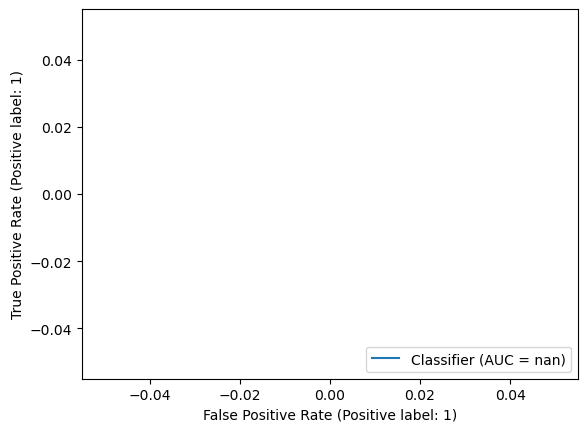

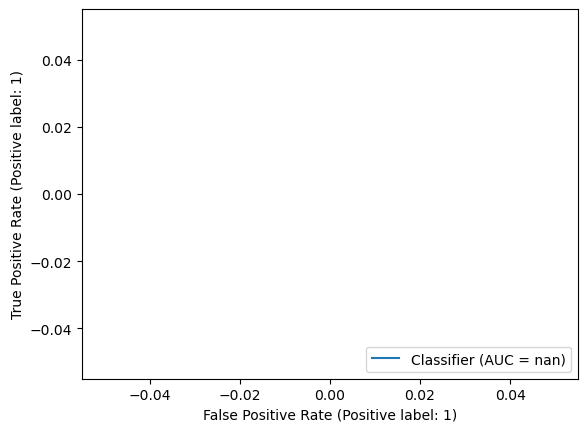

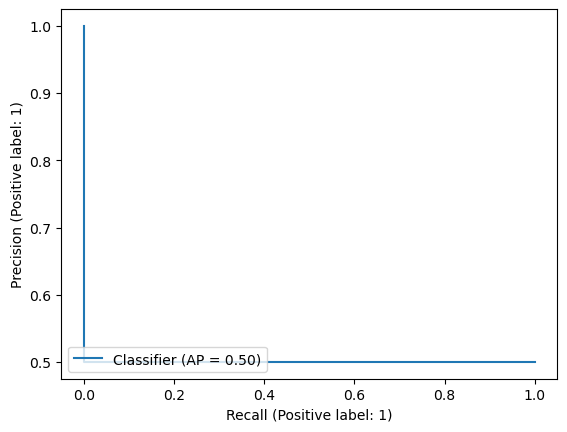

In [14]:
"""## Supervised Training of Representations"""
clustering_dataset_batch = 100

total_num_images= len(image_paths)

gc.collect()

from tensorflow.keras.optimizers import SGD
from sklearn.metrics import precision_recall_fscore_support
'''supervised_classifier.compile(loss='categorical_crossentropy',
            optimizer=SGD(learning_rate=0.01, momentum=0.95, nesterov=True,clipnorm=1.0),
            metrics=['accuracy'])'''
f1_scores= []
accuracies=[]

def get_dataset(image_paths,percentage):
    total_num_images= len(image_paths)
    clustering_dataset= tf.data.Dataset.from_tensor_slices(image_paths[:round(percentage*total_num_images)])
    print(len(image_paths[:round(percentage*total_num_images)]))
    clustering_dataset= clustering_dataset.map(read_and_preprocess_image)
    clustering_dataset= clustering_dataset.batch(clustering_dataset_batch, drop_remainder= False)

    return clustering_dataset

def get_embeddings(clustering_dataset):
    clustering_datapoints=[]
    ctr=0
    for datapoint_batch in clustering_dataset:
      embeddings= contrastiveClusteringModel.call_contrastive(datapoint_batch)
      for datapoint in embeddings:
        clustering_datapoints.append(datapoint.numpy())
      ctr+=1

    return np.array(clustering_datapoints)

def get_supervised_classifier2():
  embedding_layer= tf.keras.models.load_model('/content/sup_class_bin.h5', compile= False)
  added_layer= tf.keras.layers.Dense(32,activation = 'relu')(embedding_layer.output)
  embedding_layer2= Model(embedding_layer.input, added_layer,name='embedding_layer')
  return embedding_layer2

def get_supervised_classifier():
    supervised_classifier = tf.keras.Sequential()
    supervised_classifier.add(tf.keras.layers.Dense(256, activation="relu"))
    supervised_classifier.add(tf.keras.layers.BatchNormalization())
    supervised_classifier.add(tf.keras.layers.Dense(256, activation="relu"))
    supervised_classifier.add(tf.keras.layers.BatchNormalization())
    supervised_classifier.add(tf.keras.layers.Dense(128))
    supervised_classifier.add(tf.keras.layers.Dense(128, activation="relu"))
    supervised_classifier.add(tf.keras.layers.BatchNormalization())
    supervised_classifier.add(tf.keras.layers.Dense(64, activation="relu"))
    supervised_classifier.add(tf.keras.layers.BatchNormalization())
    supervised_classifier.add(tf.keras.layers.Dense(32, activation="relu"))
    supervised_classifier.add(tf.keras.layers.Dropout(0.4))
    supervised_classifier.add(tf.keras.layers.Dense(16, activation="relu"))
    supervised_classifier.add(tf.keras.layers.BatchNormalization())
    supervised_classifier.add(tf.keras.layers.Dense(num_classes,activation='softmax'))

    return supervised_classifier


test_dataset = tf.data.Dataset.from_tensor_slices(testing_paths)

test_dataset= test_dataset.map(read_and_preprocess_image)
test_dataset= test_dataset.batch(batch_size)

test_embeddings_output =[]
ctr=0
for mini_batch in test_dataset:
  test_embeddings= contrastiveClusteringModel.call_contrastive(mini_batch)
  for vec in test_embeddings:
    test_embeddings_output.append(vec.numpy())
  ##if(ctr>10):
    ##break
  ctr+=1

def encode_values_to_numbers(actual_labels):
    return np.where(pd.get_dummies(actual_labels).values ==1)[1]

test_embeddings_output= np.array(test_embeddings_output)
##x_true= pd.get_dummies(testing_labels).values
#percentages=[0.3, 0.5, 0.6, 0.8,0.9,1.0]
percentages= [1.0]
for percentage in percentages:
    gc.collect()
    clustering_dataset = get_dataset(image_paths, percentage)
    clustering_datapoints= get_embeddings(clustering_dataset)
    train_cluster_dataset= np.array(clustering_datapoints)

    train_y= pd.get_dummies(training_labels[:round(percentage*total_num_images)]).values

    supervised_classifier= get_supervised_classifier()

    supervised_classifier.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

    
    history = supervised_classifier.fit(train_cluster_dataset,train_y,batch_size= 32,epochs= 100,validation_split=0.2)
    


    evaluate_output = supervised_classifier.evaluate(test_embeddings_output, pd.get_dummies(testing_labels).values ==1)
    
    print(evaluate_output)
    accuracies.append(evaluate_output[1])

    predictions = supervised_classifier(test_embeddings_output)

    e2= encode_values_to_numbers(testing_labels)

    e1= []
    for i in predictions:
        e1.append(np.where(i==max(i))[0][0])

    output = precision_recall_fscore_support(e1,e2, average='weighted')
    print(output[2])
    f1_scores.append(output[2])
    #accuracies.append()

from tensorflow.keras.optimizers import SGD
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import RocCurveDisplay
'''supervised_classifier.compile(loss='categorical_crossentropy',
            optimizer=SGD(learning_rate=0.01, momentum=0.95, nesterov=True,clipnorm=1.0),
            metrics=['accuracy'])'''
f1_scores= []
accuracies=[]

def get_dataset(image_paths,percentage):
    total_num_images= len(image_paths)
    clustering_dataset= tf.data.Dataset.from_tensor_slices(image_paths[:round(percentage*total_num_images)])
    print(len(image_paths[:round(percentage*total_num_images)]))
    clustering_dataset= clustering_dataset.map(read_and_preprocess_image)
    clustering_dataset= clustering_dataset.batch(clustering_dataset_batch, drop_remainder= False)

    return clustering_dataset

def get_embeddings(clustering_dataset):
    clustering_datapoints=[]
    ctr=0
    for datapoint_batch in clustering_dataset:
      embeddings= contrastiveClusteringModel.call_contrastive(datapoint_batch)
      for datapoint in embeddings:
        clustering_datapoints.append(datapoint.numpy())
      ctr+=1

    return np.array(clustering_datapoints)

def get_supervised_classifier2():
  embedding_layer= tf.keras.models.load_model('/content/sup_class_bin.h5', compile= False)
  #added_layer= tf.keras.layers.Dense(32,activation = 'relu')(embedding_layer.output)
  #embedding_layer2= Model(embedding_layer.input, added_layer,name='embedding_layer')
  return embedding_layer

def get_supervised_classifier():
    supervised_classifier = tf.keras.Sequential()
    supervised_classifier.add(tf.keras.layers.Dense(256, activation="relu"))
    supervised_classifier.add(tf.keras.layers.BatchNormalization())
    supervised_classifier.add(tf.keras.layers.Dense(256, activation="relu"))
    supervised_classifier.add(tf.keras.layers.BatchNormalization())
    supervised_classifier.add(tf.keras.layers.Dense(128))
    supervised_classifier.add(tf.keras.layers.Dense(128, activation="relu"))
    supervised_classifier.add(tf.keras.layers.BatchNormalization())
    supervised_classifier.add(tf.keras.layers.Dense(64, activation="relu"))
    supervised_classifier.add(tf.keras.layers.BatchNormalization())
    supervised_classifier.add(tf.keras.layers.Dense(32, activation="relu"))
    supervised_classifier.add(tf.keras.layers.Dropout(0.4))
    supervised_classifier.add(tf.keras.layers.Dense(16, activation="relu"))
    supervised_classifier.add(tf.keras.layers.BatchNormalization())
    supervised_classifier.add(tf.keras.layers.Dense(num_classes,activation='softmax'))

    return supervised_classifier


test_dataset = tf.data.Dataset.from_tensor_slices(testing_paths)

test_dataset= test_dataset.map(read_and_preprocess_image)
test_dataset= test_dataset.batch(batch_size)

test_embeddings_output =[]
ctr=0
for mini_batch in test_dataset:
  test_embeddings= contrastiveClusteringModel.call_contrastive(mini_batch)
  for vec in test_embeddings:
    test_embeddings_output.append(vec.numpy())
  ##if(ctr>10):
    ##break
  ctr+=1

def encode_values_to_numbers(actual_labels):
    return np.where(pd.get_dummies(actual_labels).values ==1)[1]

test_embeddings_output= np.array(test_embeddings_output)
##x_true= pd.get_dummies(testing_labels).values
#percentages=[0.3, 0.5, 0.6, 0.8,0.9,1.0]
percentages= [1.0]
for percentage in percentages:
    gc.collect()
    clustering_dataset = get_dataset(image_paths, percentage)
    clustering_datapoints= get_embeddings(clustering_dataset)
    train_cluster_dataset= np.array(clustering_datapoints)

    train_y= pd.get_dummies(training_labels[:round(percentage*total_num_images)]).values

    supervised_classifier= get_supervised_classifier()
    supervised_classifier.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

    history = supervised_classifier.fit(train_cluster_dataset,train_y,batch_size= 32,epochs= 100,validation_split=0.2)

    predictions = supervised_classifier(test_embeddings_output)
    e2= encode_values_to_numbers(testing_labels)
    e1= []
    for i in predictions:
        print(i)
        e1.append(np.where(i==max(i))[0][0])
    
    RocCurveDisplay.from_predictions(e1, e2);

fig= RocCurveDisplay.from_predictions(e1, e2).figure_

fig.savefig('ROC_imagenet.png')

from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_predictions(e2, e1).figure_.savefig('PR_imagenet.png')

#supervised_classifier= tf.keras.models.load_model('/content/sup_class_bin.h5', compile= False)

from tensorflow.keras.optimizers import SGD
from sklearn.metrics import precision_recall_fscore_support
'''supervised_classifier.compile(loss='categorical_crossentropy',
            optimizer=SGD(learning_rate=0.01, momentum=0.95, nesterov=True,clipnorm=1.0),
            metrics=['accuracy'])'''
f1_scores= []
accuracies=[]

def get_dataset(image_paths,percentage):
    total_num_images= len(image_paths)
    clustering_dataset= tf.data.Dataset.from_tensor_slices(image_paths[:round(percentage*total_num_images)])
    print(len(image_paths[:round(percentage*total_num_images)]))
    clustering_dataset= clustering_dataset.map(read_and_preprocess_image)
    clustering_dataset= clustering_dataset.batch(clustering_dataset_batch, drop_remainder= False)

    return clustering_dataset

def get_embeddings(clustering_dataset):
    clustering_datapoints=[]
    ctr=0
    for datapoint_batch in clustering_dataset:
      embeddings= contrastiveClusteringModel.call_contrastive(datapoint_batch)
      for datapoint in embeddings:
        clustering_datapoints.append(datapoint.numpy())
      ctr+=1

    return np.array(clustering_datapoints)

def get_supervised_classifier2():
  embedding_layer= tf.keras.models.load_model('/content/sup_class_bin.h5', compile= False)
  added_layer= tf.keras.layers.Dense(32,activation = 'relu')(embedding_layer.output)
  embedding_layer2= Model(embedding_layer.input, added_layer,name='embedding_layer')
  return embedding_layer2

def get_supervised_classifier():
    supervised_classifier = tf.keras.Sequential()
    supervised_classifier.add(tf.keras.layers.Dense(256, activation="relu"))
    supervised_classifier.add(tf.keras.layers.BatchNormalization())
    supervised_classifier.add(tf.keras.layers.Dense(256, activation="relu"))
    supervised_classifier.add(tf.keras.layers.BatchNormalization())
    supervised_classifier.add(tf.keras.layers.Dense(128))
    supervised_classifier.add(tf.keras.layers.Dense(128, activation="relu"))
    supervised_classifier.add(tf.keras.layers.BatchNormalization())
    supervised_classifier.add(tf.keras.layers.Dense(64, activation="relu"))
    supervised_classifier.add(tf.keras.layers.BatchNormalization())
    supervised_classifier.add(tf.keras.layers.Dense(32, activation="relu"))
    supervised_classifier.add(tf.keras.layers.Dropout(0.4))
    supervised_classifier.add(tf.keras.layers.Dense(16, activation="relu"))
    supervised_classifier.add(tf.keras.layers.BatchNormalization())
    supervised_classifier.add(tf.keras.layers.Dense(num_classes,activation='softmax'))

    return supervised_classifier


test_dataset = tf.data.Dataset.from_tensor_slices(testing_paths)

test_dataset= test_dataset.map(read_and_preprocess_image)
test_dataset= test_dataset.batch(batch_size)

test_embeddings_output =[]
ctr=0
for mini_batch in test_dataset:
  test_embeddings= contrastiveClusteringModel.call_contrastive(mini_batch)
  for vec in test_embeddings:
    test_embeddings_output.append(vec.numpy())
  ##if(ctr>10):
    ##break
  ctr+=1

def encode_values_to_numbers(actual_labels):
    return np.where(pd.get_dummies(actual_labels).values ==1)[1]

test_embeddings_output= np.array(test_embeddings_output)
##x_true= pd.get_dummies(testing_labels).values
#percentages=[0.3, 0.5, 0.6, 0.8,0.9,1.0]
percentages= [1.0]

for _ in range(10):
      percentage=1.0
      gc.collect()
      clustering_dataset = get_dataset(image_paths, percentage)
      clustering_datapoints= get_embeddings(clustering_dataset)
      train_cluster_dataset= np.array(clustering_datapoints)

      train_y= pd.get_dummies(training_labels[:round(percentage*total_num_images)]).values

      supervised_classifier= get_supervised_classifier()

      supervised_classifier.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

      history = supervised_classifier.fit(train_cluster_dataset,train_y,batch_size= 32,epochs= 100,validation_split=0.2)


      evaluate_output = supervised_classifier.evaluate(test_embeddings_output, pd.get_dummies(testing_labels).values ==1)
      print(evaluate_output)
      accuracies.append(evaluate_output[1])

      predictions = supervised_classifier(test_embeddings_output)

      e2= encode_values_to_numbers(testing_labels)

      e1= []
      for i in predictions:
          e1.append(np.where(i==max(i))[0][0])

      output = precision_recall_fscore_support(e1,e2, average='weighted')
      print(output[2])
      f1_scores.append(output[2])
      #accuracies.append()
print(accuracies)
print(f1_scores)

print(f1_scores)

print(accuracies)

e2

print("Animesh Hogaya")

print(accuracies)

print(f1_scores)

clustering_dataset= tf.data.Dataset.from_tensor_slices(image_paths)
clustering_dataset= clustering_dataset.map(read_and_preprocess_image)
clustering_dataset= clustering_dataset.batch(clustering_dataset_batch, drop_remainder= False)

clustering_datapoints=[]
ctr=0
for datapoint_batch in clustering_dataset:
  embeddings= contrastiveClusteringModel.call_contrastive(datapoint_batch)
  for datapoint in embeddings:
    clustering_datapoints.append(datapoint.numpy())
  ctr+=1

train_cluster_dataset= np.array(clustering_datapoints)

train_cluster_dataset.shape

train_y= pd.get_dummies(training_labels).values

supervised_classifier = tf.keras.Sequential()
supervised_classifier.add(tf.keras.layers.Dense(256, activation="relu"))
supervised_classifier.add(tf.keras.layers.BatchNormalization())
supervised_classifier.add(tf.keras.layers.Dense(256, activation="relu"))
supervised_classifier.add(tf.keras.layers.BatchNormalization())
supervised_classifier.add(tf.keras.layers.Dense(128))
supervised_classifier.add(tf.keras.layers.Dense(128, activation="relu"))
supervised_classifier.add(tf.keras.layers.BatchNormalization())
supervised_classifier.add(tf.keras.layers.Dense(64, activation="relu"))
supervised_classifier.add(tf.keras.layers.BatchNormalization())
supervised_classifier.add(tf.keras.layers.Dense(32, activation="relu"))
supervised_classifier.add(tf.keras.layers.Dropout(0.4))
supervised_classifier.add(tf.keras.layers.Dense(16, activation="relu"))
supervised_classifier.add(tf.keras.layers.BatchNormalization())
supervised_classifier.add(tf.keras.layers.Dense(num_classes,activation='softmax'))

from tensorflow.keras.optimizers import SGD
'''supervised_classifier.compile(loss='categorical_crossentropy',
            optimizer=SGD(learning_rate=0.01, momentum=0.95, nesterov=True,clipnorm=1.0),
            metrics=['accuracy'])'''
supervised_classifier.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

train_cluster_dataset.shape

train_y.shape

history_2 = supervised_classifier.fit(train_cluster_dataset,train_y,batch_size= 16,epochs= 100,validation_split=0.1)

supervised_classifier.summary()

C:\Users\HTK\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


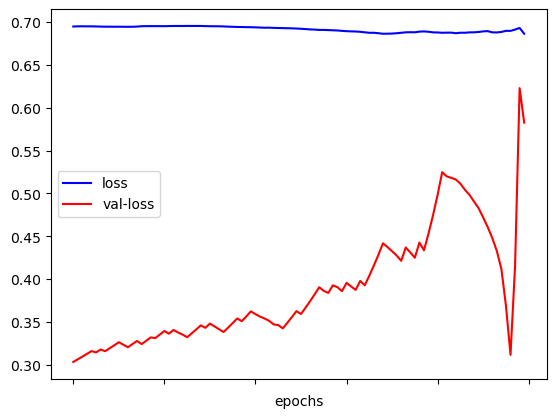

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [15]:
"""## Importing and initializing Test Dataset """

test_dataset = tf.data.Dataset.from_tensor_slices(testing_paths)

test_dataset= test_dataset.map(read_and_preprocess_image)
test_dataset= test_dataset.batch(batch_size)

pd.get_dummies(testing_labels).values

def encode_values_to_numbers(actual_labels):
    return np.where(pd.get_dummies(actual_labels).values ==1)[1]

encoded_labels = encode_values_to_numbers(testing_labels)

testing_labels= np.array(testing_labels)

history_2.history.keys()

accuracy=[]
window= 1000
y= history_2.history['accuracy']
for ind in range(len(y)):
  accuracy.append(np.mean(y[ind:ind+window]))

loss=[]
window= 1000
y= history_2.history['loss']
for ind in range(len(y)):
  loss.append(np.mean(y[ind:ind+window]))

val_loss= []
window= 1000
y= history_2.history['val_loss']
for ind in range(len(y)):
  val_loss.append(np.mean(y[ind:ind+window]))

val_accuracy=[]
window= 1000
y= history_2.history['val_accuracy']
for ind in range(len(y)):
  val_accuracy.append(np.mean(y[ind:ind+window]))

np.sort(np.unique(y))

supervised_classifier.save('sup_class_bin_2.h5')



import matplotlib.pyplot as plt
plt.plot(accuracy[:16000], label= 'loss',color='blue')
plt.plot(val_accuracy[:16000], label= 'val-loss',color='red')
plt.xlabel('epochs')
##plt.ylabel('accuracy')
##plt.plot(average_y_2, label='loss', color='red')
plt.legend()
ax= plt.gca()
ax.axes.xaxis.set_ticklabels([])
plt.show()
#plt.plot(history.history['loss'])

history.history.keys()


In [16]:
"""## Saving Model Weights"""

embedding_layer.save('/content/drive/MyDrive/embedding_layer_series_3')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/embedding_layer_series_3\assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/embedding_layer_series_3\assets


In [17]:
"""## *Generating Predictions from the Test Dataset and clustering algos* """

embeddings_output =[]
ctr=0
for mini_batch in test_dataset:
  embeddings= contrastiveClusteringModel.call_contrastive(mini_batch)
  for vec in embeddings:
    embeddings_output.append(vec.numpy())
  ##if(ctr>10):
    ##break
  ctr+=1

In [18]:
import pickle

##with open('/content/drive/MyDrive/embeddings_series_output','wb') as f:
  ##pickle.dump(embeddings_output,f)

embeddings_output= np.array(embeddings_output)

x_true= pd.get_dummies(testing_labels).values

predictions = supervised_classifier(embeddings_output)

print('Predictions')
# print(predictions)

predictions.shape


# from sklearn.preprocessing import OneHotEncoder

# # Assuming testing_labels is a list or array of labels

# # Create a OneHotEncoder instance
# encoder = OneHotEncoder(sparse=False, categories='auto')

# # Fit and transform the testing_labels to one-hot encoded format
# testing_labels_encoded = encoder.fit_transform(np.array(testing_labels).reshape(-1, 1))

# # Evaluate the classifier
# evaluate_output = supervised_classifier.evaluate(test_embeddings_output, testing_labels_encoded)


supervised_classifier.evaluate(embeddings_output, pd.get_dummies(testing_labels).values ==1)

##e1= encode_values_to_numbers(embeddings_output)
e2= encode_values_to_numbers(testing_labels)

e1= []
for i in predictions:
  if(max(i) == i[0]):
    e1.append(0)
  else:
    e1.append(1)

print('e1')
print(len(e1))
print(e1)

print('e2')
print(len(e2))
print(e2)



Predictions
35/35 [==============================] - 0s 1ms/step - loss: 0.7459 - accuracy: 0.6391
e1
1100
[0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1

Confusion matrix
[[328 175]
 [222 375]]


0.6538796861377506

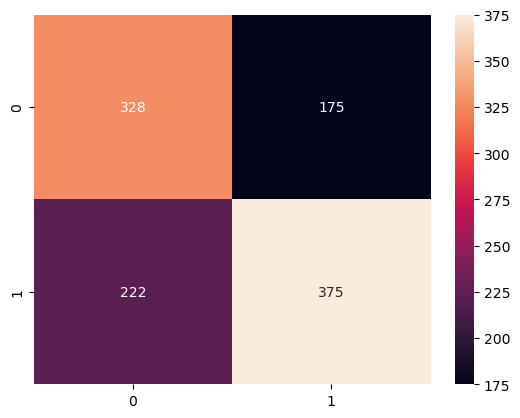

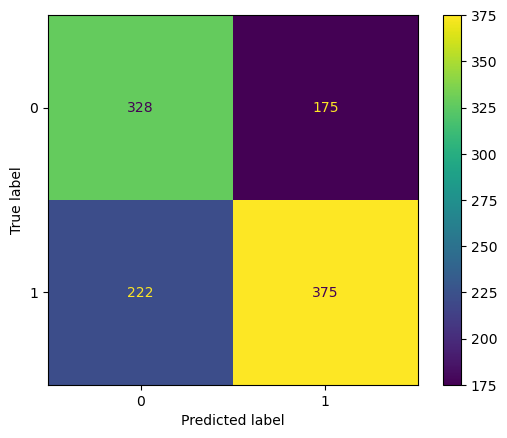

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
sns.heatmap(confusion_matrix(e1,e2),annot=True,fmt='d')
ConfusionMatrixDisplay(confusion_matrix(e1,e2)).plot()

matrix = confusion_matrix(e1,e2)

print('Confusion matrix')
print(matrix)
tp= matrix[1][1]
fp= matrix[1][0]
fn = matrix[0][1]

precision = tp/(tp+fp)

recall = tp/(tp+fn)

f1_score= (2*precision*recall/(precision+recall))

with open('history_2','wb') as f:
  pickle.dump(history_2.history,f)

precision

recall

f1_score

# """## NMI Score / Adjusted Rand Score"""

# from sklearn.metrics.cluster import normalized_mutual_info_score
# from sklearn.metrics.cluster import adjusted_rand_score
# from sklearn.metrics.cluster import fowlkes_mallows_score

# def generate_output(actual_labels, predicted_labels):
#   actual_labels= np.reshape(actual_labels, actual_labels.shape)
#   nmi_score= normalized_mutual_info_score(actual_labels,predicted_labels)
#   rand_score= adjusted_rand_score(actual_labels, predicted_labels)
#   fowlkes_score= fowlkes_mallows_score (actual_labels, predicted_labels)

#   print("NMI score --> "+ str(nmi_score))
#   print("RAND score --> "+ str(rand_score))
#   print("Fowlkes Score --> "+ str(fowlkes_score))

# print("MKMC Output --> ")
# generate_output(encoded_labels,predictions_mkmc)

# print("KMEANS output --> ")
# generate_output(encoded_labels,predictions_kmeans)

# print("DBSCAN output --> ")
# generate_output(encoded_labels, predictions_dbscan)

# gc.collect()

# embedding_layer.summary()

# 99.22

# 66.74